In [1]:
import wandb
from data_loaders import make_train_data, make_test_val_data, make_model
from train import train, test, precision, recall, f1_score
import torch
import time
import gc
import config_file
from clean_data import load_all_houses_with_device
import random
import optuna
from data_loaders import PecanStreetDataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from lstm import LSTM
from clean_data import normalize_y
from sklearn import metrics

In [2]:
wandb.login()

print(torch.cuda.is_available())

gc.collect()
torch.cuda.empty_cache()

print(torch.__version__)

wandb: Currently logged in as: nilm (use `wandb login --relogin` to force relogin)


True
1.10.2


In [3]:
config_ = config_file.load_hyperparameters("refrigerator1")

In [4]:
homes = load_all_houses_with_device(config_file.path, config_['appliance'])

In [5]:
def model_pipeline(hyperparameters, train_months, test_month, appliance, window_length, train_buildings,
                   test_buildings, patience):
    with wandb.init(project="global_models_feb1", config=hyperparameters):
        wandb.run.name = str(config_['appliance'])+"_Test:"+str(test_buildings)+"_Train:" + str(train_buildings)

        config = wandb.config

        # lengths = [85320, 132480, 132480, 132480, 132480, 132480, 132480]

        model, criterion, optimizer = make_model(config)

        print(model)
        print("Window Length: ", window_length)

        wandb.watch(model, criterion, log="all", log_freq=10)

        example_ct = 0
        batch_ct = 0
        all_epochs = 0

        #Scheduler for training on single building
#         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.85, verbose=True)
        
        #base_lr: 0.001*lr, max_lr: 4*lr, step_size_up:50, step_size_down:2000
        scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr = 0.1*config_['learning_rate'], #0.01
            max_lr = 5*config_['learning_rate'], #1
            step_size_up = 50, #200
            step_size_down = 6000, #1000
            gamma = 0.9, #1
            cycle_momentum=False,
            verbose=True
        )

        validation_loader, test_loader, test_val_seq_min, test_val_seq_max = make_test_val_data(
            config,
            test_month,
            appliance,
            window_length,
            test_buildings
        )

        time_log = time.time()
        train_loader, train_seq_min, train_seq_max = make_train_data(
            config,
            train_months,
            appliance,
            window_length,
            train_buildings
        )
        
        model, example_ct, batch_ct, all_epochs, best_model = train( 
            model,
            train_loader,
            validation_loader,
            criterion,
            optimizer,
            config,
            example_ct,
            batch_ct,
            all_epochs,
            scheduler,
            test_val_seq_min,
            test_val_seq_max,
            train_seq_min,
            train_seq_max,
            patience
        )

        print("Time to train on one home: ", time.time() - time_log)

        results = test(best_model, test_loader, criterion, test_val_seq_min, test_val_seq_max)

    return model, results, best_model


In [6]:
home_ids = homes.dataid.unique()

In [7]:
len(home_ids)

33

In [8]:
home_ids

array([  142,   183,   335,   387,   526,   690,  1417,  2126,  2358,
        2561,  3383,  3488,  3700,  3976,  3996,  5058,  6178,  6240,
        6526,  6672,  7021,  7069,  7365,  8825,  9004,  9053,  9290,
        9973, 10164, 10182, 10811, 10983, 11878], dtype=int64)

In [9]:
random_select = [1,5,10,15,20,25,30,33]
#random_select = [len(home_ids)]
#random_select = [53]

In [34]:
PATH = r"C:\Users\aar245\Desktop\privacy_preserving_nn\new_models"

In [25]:
train_homes_from_fl = [
    [5058, 2358, 8825, 10811, 526],
    [142, 10811, 2358, 6240, 2126, 1417, 7365, 5058, 10182, 9004],
    [9053, 2561, 2126, 7021, 526, 9973, 6178, 3700, 8825, 142, 7069, 335, 690, 6526, 183],
    [183, 6240, 5058, 6672, 8825, 3700, 7365, 9053, 3976, 9973, 6526, 3996, 526, 3488, 387, 11878, 7021, 10811, 9290, 6178],
    [6672, 9290, 6178, 10983, 3700, 6526, 3488, 6240, 9973, 3976, 9004, 2126, 3383, 142, 2358, 690, 7021, 387, 10182, 10811, 5058, 8825, 2561, 526, 3996],
    [526, 10811, 9973, 7021, 5058, 335, 3488, 9053, 10983, 3976, 11878, 142, 2561, 8825, 6672, 387, 183, 6178, 1417, 9290, 10182, 690, 2358, 7365, 3383, 6240, 7069, 9004, 3996, 3700],
    [5058, 2358, 3488, 10182, 6672, 11878, 7021, 6526, 335, 10164, 142, 9973, 10983, 6240, 2126, 1417, 7069, 6178, 8825, 3383, 9004, 387, 3976, 3700, 9290, 3996, 690, 7365, 9053, 183, 2561, 526, 10811]
]

In [26]:
test_homes_from_fl = [526, 3488, 10983, 7021, 2358]

In [28]:
final_results = {}
random.seed(3)
train_homes = []
best_models = []

for index, value in enumerate(train_homes_from_fl[2:]):
    gc.collect()
    torch.cuda.empty_cache()
    #training_homes=home_ids
    #training_homes = random.sample(home_ids, k=i)
    training_homes = value
    #testing_homes = [random.choice(training_homes)]
    testing_homes = [test_homes_from_fl[index]]
    patience = int(-150/32*len(training_homes)+200+150/32)
    print("patience: ", patience)
    print("training_home: ", training_homes)
    print("test_home: ", testing_homes)
    model, per_house_result, best_model = model_pipeline(
    config_,
    'sept_oct_nov',
    'dec',
    config_['appliance'],
    config_['window_size'],
    training_homes,
    testing_homes,
    patience)
    result = {str(config_["appliance"])+"_Train_home_"+str(training_homes)+"_Test_home_"+str(testing_homes)+"_total_homes_"+str(1): per_house_result}
    final_results.update(result)
    print(final_results)
    #model.cpu()
    #torch.save(model.state_dict(), PATH+"\\refrigerator_model_total_houses_"+str(random_select[i])+"_trial_3.pth")
    best_model.cpu()
    model.cpu()
    best_models.append(best_model)

patience:  134
training_home:  [9053, 2561, 2126, 7021, 526, 9973, 6178, 3700, 8825, 142, 7069, 335, 690, 6526, 183]
test_home:  [526]


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136
Adjusting learning rate of group 0 to 3.3181e-05.


C:\Users\aar245\Anaconda3\envs\privacy_ml_env\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Adjusting learning rate of group 0 to 6.5698e-05.
Adjusting learning rate of group 0 to 9.8215e-05.
Adjusting learning rate of group 0 to 1.3073e-04.
Adjusting learning rate of group 0 to 1.6325e-04.
Adjusting learning rate of group 0 to 1.9577e-04.
Adjusting learning rate of group 0 to 2.2828e-04.
Adjusting learning rate of group 0 to 2.6080e-04.
Adjusting learning rate of group 0 to 2.9332e-04.
Adjusting learning rate of group 0 to 3.2584e-04.
Adjusting learning rate of group 0 to 3.5835e-04.
Adjusting learning rate of group 0 to 3.9087e-04.
Adjusting learning rate of group 0 to 4.2339e-04.
Adjusting learning rate of group 0 to 4.5591e-04.
Adjusting learning rate of group 0 to 4.8842e-04.
Adjusting learning rate of group 0 to 5.2094e-04.
Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.8597e-04.
Adjusting learning rate of group 0 to 6.1849e-04.
Adjusting learning rate of group 0 to 6.5101e-04.
Adjusting learning rate of group 0 to 6.8353e-04.


Adjusting learning rate of group 0 to 1.6273e-03.
Adjusting learning rate of group 0 to 1.6271e-03.
Adjusting learning rate of group 0 to 1.6268e-03.
Adjusting learning rate of group 0 to 1.6265e-03.
Adjusting learning rate of group 0 to 1.6263e-03.
Adjusting learning rate of group 0 to 1.6260e-03.
Adjusting learning rate of group 0 to 1.6257e-03.
Adjusting learning rate of group 0 to 1.6254e-03.
Adjusting learning rate of group 0 to 1.6252e-03.
Adjusting learning rate of group 0 to 1.6249e-03.
Adjusting learning rate of group 0 to 1.6246e-03.
Adjusting learning rate of group 0 to 1.6244e-03.
Adjusting learning rate of group 0 to 1.6241e-03.
Adjusting learning rate of group 0 to 1.6238e-03.
Adjusting learning rate of group 0 to 1.6235e-03.
Adjusting learning rate of group 0 to 1.6233e-03.
Adjusting learning rate of group 0 to 1.6230e-03.
Adjusting learning rate of group 0 to 1.6227e-03.
Adjusting learning rate of group 0 to 1.6225e-03.
Adjusting learning rate of group 0 to 1.6222e-03.


Adjusting learning rate of group 0 to 1.5829e-03.
Adjusting learning rate of group 0 to 1.5826e-03.
Adjusting learning rate of group 0 to 1.5824e-03.
Adjusting learning rate of group 0 to 1.5821e-03.
Adjusting learning rate of group 0 to 1.5818e-03.
Adjusting learning rate of group 0 to 1.5815e-03.
Adjusting learning rate of group 0 to 1.5813e-03.
Adjusting learning rate of group 0 to 1.5810e-03.
Adjusting learning rate of group 0 to 1.5807e-03.
Adjusting learning rate of group 0 to 1.5805e-03.
Adjusting learning rate of group 0 to 1.5802e-03.
Adjusting learning rate of group 0 to 1.5799e-03.
Adjusting learning rate of group 0 to 1.5796e-03.
Adjusting learning rate of group 0 to 1.5794e-03.
Adjusting learning rate of group 0 to 1.5791e-03.
Adjusting learning rate of group 0 to 1.5788e-03.
Adjusting learning rate of group 0 to 1.5786e-03.
Adjusting learning rate of group 0 to 1.5783e-03.
Adjusting learning rate of group 0 to 1.5780e-03.
Adjusting learning rate of group 0 to 1.5778e-03.


Adjusting learning rate of group 0 to 1.5382e-03.
Adjusting learning rate of group 0 to 1.5379e-03.
Adjusting learning rate of group 0 to 1.5376e-03.
Adjusting learning rate of group 0 to 1.5374e-03.
Adjusting learning rate of group 0 to 1.5371e-03.
Adjusting learning rate of group 0 to 1.5368e-03.
Adjusting learning rate of group 0 to 1.5366e-03.
Adjusting learning rate of group 0 to 1.5363e-03.
Adjusting learning rate of group 0 to 1.5360e-03.
Adjusting learning rate of group 0 to 1.5358e-03.
Adjusting learning rate of group 0 to 1.5355e-03.
Adjusting learning rate of group 0 to 1.5352e-03.
Adjusting learning rate of group 0 to 1.5349e-03.
Adjusting learning rate of group 0 to 1.5347e-03.
Adjusting learning rate of group 0 to 1.5344e-03.
Adjusting learning rate of group 0 to 1.5341e-03.
Adjusting learning rate of group 0 to 1.5339e-03.
Adjusting learning rate of group 0 to 1.5336e-03.
Adjusting learning rate of group 0 to 1.5333e-03.
Adjusting learning rate of group 0 to 1.5330e-03.


Adjusting learning rate of group 0 to 1.4937e-03.
Adjusting learning rate of group 0 to 1.4935e-03.
Adjusting learning rate of group 0 to 1.4932e-03.
Adjusting learning rate of group 0 to 1.4929e-03.
Adjusting learning rate of group 0 to 1.4927e-03.
Adjusting learning rate of group 0 to 1.4924e-03.
Adjusting learning rate of group 0 to 1.4921e-03.
Adjusting learning rate of group 0 to 1.4919e-03.
Adjusting learning rate of group 0 to 1.4916e-03.
Adjusting learning rate of group 0 to 1.4913e-03.
Adjusting learning rate of group 0 to 1.4910e-03.
Adjusting learning rate of group 0 to 1.4908e-03.
Adjusting learning rate of group 0 to 1.4905e-03.
trigger times: 5
Loss after 100751 batches: 0.0767
Adjusting learning rate of group 0 to 1.4902e-03.
Adjusting learning rate of group 0 to 1.4900e-03.
Adjusting learning rate of group 0 to 1.4897e-03.
Adjusting learning rate of group 0 to 1.4894e-03.
Adjusting learning rate of group 0 to 1.4891e-03.
Adjusting learning rate of group 0 to 1.4889e-03.

Adjusting learning rate of group 0 to 1.4496e-03.
Adjusting learning rate of group 0 to 1.4493e-03.
Adjusting learning rate of group 0 to 1.4490e-03.
Adjusting learning rate of group 0 to 1.4488e-03.
Adjusting learning rate of group 0 to 1.4485e-03.
Adjusting learning rate of group 0 to 1.4482e-03.
Adjusting learning rate of group 0 to 1.4480e-03.
Adjusting learning rate of group 0 to 1.4477e-03.
Adjusting learning rate of group 0 to 1.4474e-03.
Adjusting learning rate of group 0 to 1.4471e-03.
Adjusting learning rate of group 0 to 1.4469e-03.
Adjusting learning rate of group 0 to 1.4466e-03.
Adjusting learning rate of group 0 to 1.4463e-03.
Adjusting learning rate of group 0 to 1.4461e-03.
Adjusting learning rate of group 0 to 1.4458e-03.
Adjusting learning rate of group 0 to 1.4455e-03.
Adjusting learning rate of group 0 to 1.4452e-03.
Adjusting learning rate of group 0 to 1.4450e-03.
Adjusting learning rate of group 0 to 1.4447e-03.
Adjusting learning rate of group 0 to 1.4444e-03.


Adjusting learning rate of group 0 to 1.4049e-03.
Adjusting learning rate of group 0 to 1.4046e-03.
Adjusting learning rate of group 0 to 1.4043e-03.
Adjusting learning rate of group 0 to 1.4041e-03.
Adjusting learning rate of group 0 to 1.4038e-03.
Adjusting learning rate of group 0 to 1.4035e-03.
Adjusting learning rate of group 0 to 1.4032e-03.
Adjusting learning rate of group 0 to 1.4030e-03.
Adjusting learning rate of group 0 to 1.4027e-03.
Adjusting learning rate of group 0 to 1.4024e-03.
Adjusting learning rate of group 0 to 1.4022e-03.
Adjusting learning rate of group 0 to 1.4019e-03.
Adjusting learning rate of group 0 to 1.4016e-03.
Adjusting learning rate of group 0 to 1.4013e-03.
Adjusting learning rate of group 0 to 1.4011e-03.
Adjusting learning rate of group 0 to 1.4008e-03.
Adjusting learning rate of group 0 to 1.4005e-03.
Adjusting learning rate of group 0 to 1.4003e-03.
Adjusting learning rate of group 0 to 1.4000e-03.
Adjusting learning rate of group 0 to 1.3997e-03.


trigger times: 0
Loss after 172716 batches: 0.0725
Adjusting learning rate of group 0 to 1.3602e-03.
Adjusting learning rate of group 0 to 1.3599e-03.
Adjusting learning rate of group 0 to 1.3596e-03.
Adjusting learning rate of group 0 to 1.3593e-03.
Adjusting learning rate of group 0 to 1.3591e-03.
Adjusting learning rate of group 0 to 1.3588e-03.
Adjusting learning rate of group 0 to 1.3585e-03.
Adjusting learning rate of group 0 to 1.3583e-03.
Adjusting learning rate of group 0 to 1.3580e-03.
Adjusting learning rate of group 0 to 1.3577e-03.
Adjusting learning rate of group 0 to 1.3574e-03.
Adjusting learning rate of group 0 to 1.3572e-03.
Adjusting learning rate of group 0 to 1.3569e-03.
Adjusting learning rate of group 0 to 1.3566e-03.
Adjusting learning rate of group 0 to 1.3564e-03.
Adjusting learning rate of group 0 to 1.3561e-03.
Adjusting learning rate of group 0 to 1.3558e-03.
Adjusting learning rate of group 0 to 1.3556e-03.
Adjusting learning rate of group 0 to 1.3553e-03.

Adjusting learning rate of group 0 to 1.3154e-03.
Adjusting learning rate of group 0 to 1.3152e-03.
Adjusting learning rate of group 0 to 1.3149e-03.
Adjusting learning rate of group 0 to 1.3146e-03.
Adjusting learning rate of group 0 to 1.3144e-03.
Adjusting learning rate of group 0 to 1.3141e-03.
Adjusting learning rate of group 0 to 1.3138e-03.
Adjusting learning rate of group 0 to 1.3135e-03.
Adjusting learning rate of group 0 to 1.3133e-03.
Adjusting learning rate of group 0 to 1.3130e-03.
Adjusting learning rate of group 0 to 1.3127e-03.
Adjusting learning rate of group 0 to 1.3125e-03.
Adjusting learning rate of group 0 to 1.3122e-03.
Adjusting learning rate of group 0 to 1.3119e-03.
Adjusting learning rate of group 0 to 1.3117e-03.
Adjusting learning rate of group 0 to 1.3114e-03.
Adjusting learning rate of group 0 to 1.3111e-03.
Adjusting learning rate of group 0 to 1.3108e-03.
Adjusting learning rate of group 0 to 1.3106e-03.
Adjusting learning rate of group 0 to 1.3103e-03.


Adjusting learning rate of group 0 to 1.2710e-03.
Adjusting learning rate of group 0 to 1.2707e-03.
Adjusting learning rate of group 0 to 1.2705e-03.
Adjusting learning rate of group 0 to 1.2702e-03.
Adjusting learning rate of group 0 to 1.2699e-03.
Adjusting learning rate of group 0 to 1.2697e-03.
Adjusting learning rate of group 0 to 1.2694e-03.
Adjusting learning rate of group 0 to 1.2691e-03.
Adjusting learning rate of group 0 to 1.2688e-03.
Adjusting learning rate of group 0 to 1.2686e-03.
Adjusting learning rate of group 0 to 1.2683e-03.
Adjusting learning rate of group 0 to 1.2680e-03.
Adjusting learning rate of group 0 to 1.2678e-03.
Adjusting learning rate of group 0 to 1.2675e-03.
Adjusting learning rate of group 0 to 1.2672e-03.
Adjusting learning rate of group 0 to 1.2669e-03.
Adjusting learning rate of group 0 to 1.2667e-03.
Adjusting learning rate of group 0 to 1.2664e-03.
Adjusting learning rate of group 0 to 1.2661e-03.
Adjusting learning rate of group 0 to 1.2659e-03.


Adjusting learning rate of group 0 to 1.2268e-03.
Adjusting learning rate of group 0 to 1.2266e-03.
Adjusting learning rate of group 0 to 1.2263e-03.
Adjusting learning rate of group 0 to 1.2260e-03.
Adjusting learning rate of group 0 to 1.2258e-03.
Adjusting learning rate of group 0 to 1.2255e-03.
Adjusting learning rate of group 0 to 1.2252e-03.
Adjusting learning rate of group 0 to 1.2249e-03.
Adjusting learning rate of group 0 to 1.2247e-03.
Adjusting learning rate of group 0 to 1.2244e-03.
Adjusting learning rate of group 0 to 1.2241e-03.
Adjusting learning rate of group 0 to 1.2239e-03.
Adjusting learning rate of group 0 to 1.2236e-03.
Adjusting learning rate of group 0 to 1.2233e-03.
Adjusting learning rate of group 0 to 1.2230e-03.
Adjusting learning rate of group 0 to 1.2228e-03.
Adjusting learning rate of group 0 to 1.2225e-03.
Adjusting learning rate of group 0 to 1.2222e-03.
Adjusting learning rate of group 0 to 1.2220e-03.
Adjusting learning rate of group 0 to 1.2217e-03.


Adjusting learning rate of group 0 to 1.1821e-03.
Adjusting learning rate of group 0 to 1.1819e-03.
Adjusting learning rate of group 0 to 1.1816e-03.
Adjusting learning rate of group 0 to 1.1813e-03.
Adjusting learning rate of group 0 to 1.1810e-03.
Adjusting learning rate of group 0 to 1.1808e-03.
Adjusting learning rate of group 0 to 1.1805e-03.
Adjusting learning rate of group 0 to 1.1802e-03.
Adjusting learning rate of group 0 to 1.1800e-03.
Adjusting learning rate of group 0 to 1.1797e-03.
Adjusting learning rate of group 0 to 1.1794e-03.
Adjusting learning rate of group 0 to 1.1791e-03.
Adjusting learning rate of group 0 to 1.1789e-03.
Adjusting learning rate of group 0 to 1.1786e-03.
Adjusting learning rate of group 0 to 1.1783e-03.
trigger times: 1
Loss after 273467 batches: 0.0531
Adjusting learning rate of group 0 to 1.1781e-03.
Adjusting learning rate of group 0 to 1.1778e-03.
Adjusting learning rate of group 0 to 1.1775e-03.
Adjusting learning rate of group 0 to 1.1772e-03.

Adjusting learning rate of group 0 to 1.1374e-03.
Adjusting learning rate of group 0 to 1.1371e-03.
Adjusting learning rate of group 0 to 1.1369e-03.
Adjusting learning rate of group 0 to 1.1366e-03.
Adjusting learning rate of group 0 to 1.1363e-03.
Adjusting learning rate of group 0 to 1.1361e-03.
Adjusting learning rate of group 0 to 1.1358e-03.
Adjusting learning rate of group 0 to 1.1355e-03.
Adjusting learning rate of group 0 to 1.1352e-03.
Adjusting learning rate of group 0 to 1.1350e-03.
Adjusting learning rate of group 0 to 1.1347e-03.
Adjusting learning rate of group 0 to 1.1344e-03.
Adjusting learning rate of group 0 to 1.1342e-03.
Adjusting learning rate of group 0 to 1.1339e-03.
Adjusting learning rate of group 0 to 1.1336e-03.
Adjusting learning rate of group 0 to 1.1333e-03.
Adjusting learning rate of group 0 to 1.1331e-03.
Adjusting learning rate of group 0 to 1.1328e-03.
Adjusting learning rate of group 0 to 1.1325e-03.
Adjusting learning rate of group 0 to 1.1323e-03.


Adjusting learning rate of group 0 to 1.0930e-03.
Adjusting learning rate of group 0 to 1.0927e-03.
Adjusting learning rate of group 0 to 1.0924e-03.
Adjusting learning rate of group 0 to 1.0922e-03.
Adjusting learning rate of group 0 to 1.0919e-03.
Adjusting learning rate of group 0 to 1.0916e-03.
Adjusting learning rate of group 0 to 1.0913e-03.
Adjusting learning rate of group 0 to 1.0911e-03.
Adjusting learning rate of group 0 to 1.0908e-03.
Adjusting learning rate of group 0 to 1.0905e-03.
Adjusting learning rate of group 0 to 1.0903e-03.
Adjusting learning rate of group 0 to 1.0900e-03.
Adjusting learning rate of group 0 to 1.0897e-03.
Adjusting learning rate of group 0 to 1.0895e-03.
Adjusting learning rate of group 0 to 1.0892e-03.
Adjusting learning rate of group 0 to 1.0889e-03.
Adjusting learning rate of group 0 to 1.0886e-03.
Adjusting learning rate of group 0 to 1.0884e-03.
Adjusting learning rate of group 0 to 1.0881e-03.
Adjusting learning rate of group 0 to 1.0878e-03.


Adjusting learning rate of group 0 to 1.0488e-03.
Adjusting learning rate of group 0 to 1.0485e-03.
Adjusting learning rate of group 0 to 1.0483e-03.
trigger times: 6
Loss after 345432 batches: 0.0502
Adjusting learning rate of group 0 to 1.0480e-03.
Adjusting learning rate of group 0 to 1.0477e-03.
Adjusting learning rate of group 0 to 1.0474e-03.
Adjusting learning rate of group 0 to 1.0472e-03.
Adjusting learning rate of group 0 to 1.0469e-03.
Adjusting learning rate of group 0 to 1.0466e-03.
Adjusting learning rate of group 0 to 1.0464e-03.
Adjusting learning rate of group 0 to 1.0461e-03.
Adjusting learning rate of group 0 to 1.0458e-03.
Adjusting learning rate of group 0 to 1.0456e-03.
Adjusting learning rate of group 0 to 1.0453e-03.
Adjusting learning rate of group 0 to 1.0450e-03.
Adjusting learning rate of group 0 to 1.0447e-03.
Adjusting learning rate of group 0 to 1.0445e-03.
Adjusting learning rate of group 0 to 1.0442e-03.
Adjusting learning rate of group 0 to 1.0439e-03.

Adjusting learning rate of group 0 to 1.0044e-03.
Adjusting learning rate of group 0 to 1.0041e-03.
Adjusting learning rate of group 0 to 1.0038e-03.
Adjusting learning rate of group 0 to 1.0036e-03.
Adjusting learning rate of group 0 to 1.0033e-03.
Adjusting learning rate of group 0 to 1.0030e-03.
Adjusting learning rate of group 0 to 1.0027e-03.
Adjusting learning rate of group 0 to 1.0025e-03.
Adjusting learning rate of group 0 to 1.0022e-03.
Adjusting learning rate of group 0 to 1.0019e-03.
Adjusting learning rate of group 0 to 1.0017e-03.
Adjusting learning rate of group 0 to 1.0014e-03.
Adjusting learning rate of group 0 to 1.0011e-03.
Adjusting learning rate of group 0 to 1.0008e-03.
Adjusting learning rate of group 0 to 1.0006e-03.
Adjusting learning rate of group 0 to 1.0003e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9976e-04.
Adjusting learning rate of group 0 to 9.9949e-04.
Adjusting learning rate of group 0 to 9.9922e-04.


Adjusting learning rate of group 0 to 9.5992e-04.
Adjusting learning rate of group 0 to 9.5965e-04.
Adjusting learning rate of group 0 to 9.5938e-04.
Adjusting learning rate of group 0 to 9.5911e-04.
Adjusting learning rate of group 0 to 9.5884e-04.
Adjusting learning rate of group 0 to 9.5857e-04.
Adjusting learning rate of group 0 to 9.5830e-04.
Adjusting learning rate of group 0 to 9.5803e-04.
Adjusting learning rate of group 0 to 9.5776e-04.
Adjusting learning rate of group 0 to 9.5748e-04.
Adjusting learning rate of group 0 to 9.5721e-04.
Adjusting learning rate of group 0 to 9.5694e-04.
Adjusting learning rate of group 0 to 9.5667e-04.
Adjusting learning rate of group 0 to 9.5640e-04.
Adjusting learning rate of group 0 to 9.5613e-04.
Adjusting learning rate of group 0 to 9.5586e-04.
Adjusting learning rate of group 0 to 9.5559e-04.
Adjusting learning rate of group 0 to 9.5532e-04.
Adjusting learning rate of group 0 to 9.5505e-04.
Adjusting learning rate of group 0 to 9.5477e-04.


Adjusting learning rate of group 0 to 9.1548e-04.
Adjusting learning rate of group 0 to 9.1521e-04.
Adjusting learning rate of group 0 to 9.1494e-04.
Adjusting learning rate of group 0 to 9.1467e-04.
Adjusting learning rate of group 0 to 9.1440e-04.
Adjusting learning rate of group 0 to 9.1413e-04.
Adjusting learning rate of group 0 to 9.1386e-04.
Adjusting learning rate of group 0 to 9.1359e-04.
Adjusting learning rate of group 0 to 9.1332e-04.
Adjusting learning rate of group 0 to 9.1304e-04.
Adjusting learning rate of group 0 to 9.1277e-04.
Adjusting learning rate of group 0 to 9.1250e-04.
Adjusting learning rate of group 0 to 9.1223e-04.
Adjusting learning rate of group 0 to 9.1196e-04.
Adjusting learning rate of group 0 to 9.1169e-04.
Adjusting learning rate of group 0 to 9.1142e-04.
Adjusting learning rate of group 0 to 9.1115e-04.
Adjusting learning rate of group 0 to 9.1088e-04.
Adjusting learning rate of group 0 to 9.1061e-04.
Adjusting learning rate of group 0 to 9.1033e-04.


Adjusting learning rate of group 0 to 8.7104e-04.
Adjusting learning rate of group 0 to 8.7077e-04.
Adjusting learning rate of group 0 to 8.7050e-04.
Adjusting learning rate of group 0 to 8.7023e-04.
Adjusting learning rate of group 0 to 8.6996e-04.
Adjusting learning rate of group 0 to 8.6969e-04.
Adjusting learning rate of group 0 to 8.6942e-04.
Adjusting learning rate of group 0 to 8.6915e-04.
Adjusting learning rate of group 0 to 8.6888e-04.
Adjusting learning rate of group 0 to 8.6860e-04.
Adjusting learning rate of group 0 to 8.6833e-04.
Adjusting learning rate of group 0 to 8.6806e-04.
Adjusting learning rate of group 0 to 8.6779e-04.
Adjusting learning rate of group 0 to 8.6752e-04.
Adjusting learning rate of group 0 to 8.6725e-04.
Adjusting learning rate of group 0 to 8.6698e-04.
Adjusting learning rate of group 0 to 8.6671e-04.
Adjusting learning rate of group 0 to 8.6644e-04.
Adjusting learning rate of group 0 to 8.6617e-04.
trigger times: 13
Loss after 446183 batches: 0.047

Adjusting learning rate of group 0 to 8.2660e-04.
Adjusting learning rate of group 0 to 8.2633e-04.
Adjusting learning rate of group 0 to 8.2606e-04.
Adjusting learning rate of group 0 to 8.2579e-04.
Adjusting learning rate of group 0 to 8.2552e-04.
Adjusting learning rate of group 0 to 8.2525e-04.
Adjusting learning rate of group 0 to 8.2498e-04.
Adjusting learning rate of group 0 to 8.2471e-04.
Adjusting learning rate of group 0 to 8.2443e-04.
Adjusting learning rate of group 0 to 8.2416e-04.
Adjusting learning rate of group 0 to 8.2389e-04.
Adjusting learning rate of group 0 to 8.2362e-04.
Adjusting learning rate of group 0 to 8.2335e-04.
Adjusting learning rate of group 0 to 8.2308e-04.
Adjusting learning rate of group 0 to 8.2281e-04.
Adjusting learning rate of group 0 to 8.2254e-04.
Adjusting learning rate of group 0 to 8.2227e-04.
Adjusting learning rate of group 0 to 8.2200e-04.
Adjusting learning rate of group 0 to 8.2172e-04.
Adjusting learning rate of group 0 to 8.2145e-04.


Adjusting learning rate of group 0 to 7.8216e-04.
Adjusting learning rate of group 0 to 7.8189e-04.
Adjusting learning rate of group 0 to 7.8162e-04.
Adjusting learning rate of group 0 to 7.8135e-04.
Adjusting learning rate of group 0 to 7.8108e-04.
Adjusting learning rate of group 0 to 7.8081e-04.
Adjusting learning rate of group 0 to 7.8054e-04.
Adjusting learning rate of group 0 to 7.8027e-04.
Adjusting learning rate of group 0 to 7.7999e-04.
Adjusting learning rate of group 0 to 7.7972e-04.
Adjusting learning rate of group 0 to 7.7945e-04.
Adjusting learning rate of group 0 to 7.7918e-04.
Adjusting learning rate of group 0 to 7.7891e-04.
Adjusting learning rate of group 0 to 7.7864e-04.
Adjusting learning rate of group 0 to 7.7837e-04.
Adjusting learning rate of group 0 to 7.7810e-04.
Adjusting learning rate of group 0 to 7.7783e-04.
Adjusting learning rate of group 0 to 7.7756e-04.
Adjusting learning rate of group 0 to 7.7728e-04.
Adjusting learning rate of group 0 to 7.7701e-04.


Adjusting learning rate of group 0 to 7.3772e-04.
Adjusting learning rate of group 0 to 7.3745e-04.
Adjusting learning rate of group 0 to 7.3718e-04.
Adjusting learning rate of group 0 to 7.3691e-04.
Adjusting learning rate of group 0 to 7.3664e-04.
Adjusting learning rate of group 0 to 7.3637e-04.
Adjusting learning rate of group 0 to 7.3610e-04.
trigger times: 1
Loss after 518148 batches: 0.0457
Adjusting learning rate of group 0 to 7.3583e-04.
Adjusting learning rate of group 0 to 7.3555e-04.
Adjusting learning rate of group 0 to 7.3528e-04.
Adjusting learning rate of group 0 to 7.3501e-04.
Adjusting learning rate of group 0 to 7.3474e-04.
Adjusting learning rate of group 0 to 7.3447e-04.
Adjusting learning rate of group 0 to 7.3420e-04.
Adjusting learning rate of group 0 to 7.3393e-04.
Adjusting learning rate of group 0 to 7.3366e-04.
Adjusting learning rate of group 0 to 7.3339e-04.
Adjusting learning rate of group 0 to 7.3312e-04.
Adjusting learning rate of group 0 to 7.3284e-04.

Adjusting learning rate of group 0 to 6.9328e-04.
Adjusting learning rate of group 0 to 6.9301e-04.
Adjusting learning rate of group 0 to 6.9274e-04.
Adjusting learning rate of group 0 to 6.9247e-04.
Adjusting learning rate of group 0 to 6.9220e-04.
Adjusting learning rate of group 0 to 6.9193e-04.
Adjusting learning rate of group 0 to 6.9166e-04.
Adjusting learning rate of group 0 to 6.9138e-04.
Adjusting learning rate of group 0 to 6.9111e-04.
Adjusting learning rate of group 0 to 6.9084e-04.
Adjusting learning rate of group 0 to 6.9057e-04.
Adjusting learning rate of group 0 to 6.9030e-04.
Adjusting learning rate of group 0 to 6.9003e-04.
Adjusting learning rate of group 0 to 6.8976e-04.
Adjusting learning rate of group 0 to 6.8949e-04.
Adjusting learning rate of group 0 to 6.8922e-04.
Adjusting learning rate of group 0 to 6.8895e-04.
Adjusting learning rate of group 0 to 6.8868e-04.
Adjusting learning rate of group 0 to 6.8840e-04.
Adjusting learning rate of group 0 to 6.8813e-04.


Adjusting learning rate of group 0 to 6.4857e-04.
Adjusting learning rate of group 0 to 6.4830e-04.
Adjusting learning rate of group 0 to 6.4803e-04.
Adjusting learning rate of group 0 to 6.4776e-04.
Adjusting learning rate of group 0 to 6.4749e-04.
Adjusting learning rate of group 0 to 6.4722e-04.
Adjusting learning rate of group 0 to 6.4694e-04.
Adjusting learning rate of group 0 to 6.4667e-04.
Adjusting learning rate of group 0 to 6.4640e-04.
Adjusting learning rate of group 0 to 6.4613e-04.
Adjusting learning rate of group 0 to 6.4586e-04.
Adjusting learning rate of group 0 to 6.4559e-04.
Adjusting learning rate of group 0 to 6.4532e-04.
Adjusting learning rate of group 0 to 6.4505e-04.
Adjusting learning rate of group 0 to 6.4478e-04.
Adjusting learning rate of group 0 to 6.4451e-04.
Adjusting learning rate of group 0 to 6.4423e-04.
Adjusting learning rate of group 0 to 6.4396e-04.
Adjusting learning rate of group 0 to 6.4369e-04.
Adjusting learning rate of group 0 to 6.4342e-04.


Adjusting learning rate of group 0 to 6.0413e-04.
Adjusting learning rate of group 0 to 6.0386e-04.
Adjusting learning rate of group 0 to 6.0359e-04.
Adjusting learning rate of group 0 to 6.0332e-04.
Adjusting learning rate of group 0 to 6.0305e-04.
Adjusting learning rate of group 0 to 6.0278e-04.
Adjusting learning rate of group 0 to 6.0250e-04.
Adjusting learning rate of group 0 to 6.0223e-04.
Adjusting learning rate of group 0 to 6.0196e-04.
Adjusting learning rate of group 0 to 6.0169e-04.
Adjusting learning rate of group 0 to 6.0142e-04.
Adjusting learning rate of group 0 to 6.0115e-04.
Adjusting learning rate of group 0 to 6.0088e-04.
Adjusting learning rate of group 0 to 6.0061e-04.
Adjusting learning rate of group 0 to 6.0034e-04.
Adjusting learning rate of group 0 to 6.0007e-04.
Adjusting learning rate of group 0 to 5.9979e-04.
Adjusting learning rate of group 0 to 5.9952e-04.
Adjusting learning rate of group 0 to 5.9925e-04.
Adjusting learning rate of group 0 to 5.9898e-04.


Adjusting learning rate of group 0 to 5.5942e-04.
Adjusting learning rate of group 0 to 5.5915e-04.
Adjusting learning rate of group 0 to 5.5888e-04.
Adjusting learning rate of group 0 to 5.5861e-04.
Adjusting learning rate of group 0 to 5.5833e-04.
Adjusting learning rate of group 0 to 5.5806e-04.
Adjusting learning rate of group 0 to 5.5779e-04.
Adjusting learning rate of group 0 to 5.5752e-04.
Adjusting learning rate of group 0 to 5.5725e-04.
Adjusting learning rate of group 0 to 5.5698e-04.
Adjusting learning rate of group 0 to 5.5671e-04.
Adjusting learning rate of group 0 to 5.5644e-04.
Adjusting learning rate of group 0 to 5.5617e-04.
Adjusting learning rate of group 0 to 5.5590e-04.
Adjusting learning rate of group 0 to 5.5563e-04.
Adjusting learning rate of group 0 to 5.5535e-04.
Adjusting learning rate of group 0 to 5.5508e-04.
Adjusting learning rate of group 0 to 5.5481e-04.
Adjusting learning rate of group 0 to 5.5454e-04.
Adjusting learning rate of group 0 to 5.5427e-04.


Adjusting learning rate of group 0 to 5.1552e-04.
Adjusting learning rate of group 0 to 5.1525e-04.
Adjusting learning rate of group 0 to 5.1498e-04.
Adjusting learning rate of group 0 to 5.1471e-04.
Adjusting learning rate of group 0 to 5.1444e-04.
Adjusting learning rate of group 0 to 5.1417e-04.
Adjusting learning rate of group 0 to 5.1389e-04.
Adjusting learning rate of group 0 to 5.1362e-04.
Adjusting learning rate of group 0 to 5.1335e-04.
Adjusting learning rate of group 0 to 5.1308e-04.
Adjusting learning rate of group 0 to 5.1281e-04.
Adjusting learning rate of group 0 to 5.1254e-04.
Adjusting learning rate of group 0 to 5.1227e-04.
Adjusting learning rate of group 0 to 5.1200e-04.
Adjusting learning rate of group 0 to 5.1173e-04.
Adjusting learning rate of group 0 to 5.1146e-04.
Adjusting learning rate of group 0 to 5.1118e-04.
Adjusting learning rate of group 0 to 5.1091e-04.
Adjusting learning rate of group 0 to 5.1064e-04.
Adjusting learning rate of group 0 to 5.1037e-04.


Adjusting learning rate of group 0 to 4.7108e-04.
Adjusting learning rate of group 0 to 4.7081e-04.
Adjusting learning rate of group 0 to 4.7054e-04.
Adjusting learning rate of group 0 to 4.7027e-04.
Adjusting learning rate of group 0 to 4.7000e-04.
Adjusting learning rate of group 0 to 4.6973e-04.
Adjusting learning rate of group 0 to 4.6945e-04.
Adjusting learning rate of group 0 to 4.6918e-04.
Adjusting learning rate of group 0 to 4.6891e-04.
Adjusting learning rate of group 0 to 4.6864e-04.
Adjusting learning rate of group 0 to 4.6837e-04.
Adjusting learning rate of group 0 to 4.6810e-04.
Adjusting learning rate of group 0 to 4.6783e-04.
Adjusting learning rate of group 0 to 4.6756e-04.
Adjusting learning rate of group 0 to 4.6729e-04.
Adjusting learning rate of group 0 to 4.6702e-04.
Adjusting learning rate of group 0 to 4.6674e-04.
Adjusting learning rate of group 0 to 4.6647e-04.
Adjusting learning rate of group 0 to 4.6620e-04.
Adjusting learning rate of group 0 to 4.6593e-04.


Adjusting learning rate of group 0 to 4.2637e-04.
Adjusting learning rate of group 0 to 4.2610e-04.
Adjusting learning rate of group 0 to 4.2583e-04.
Adjusting learning rate of group 0 to 4.2556e-04.
Adjusting learning rate of group 0 to 4.2529e-04.
Adjusting learning rate of group 0 to 4.2501e-04.
Adjusting learning rate of group 0 to 4.2474e-04.
Adjusting learning rate of group 0 to 4.2447e-04.
Adjusting learning rate of group 0 to 4.2420e-04.
Adjusting learning rate of group 0 to 4.2393e-04.
trigger times: 1
Loss after 690864 batches: 0.0430
Adjusting learning rate of group 0 to 4.2366e-04.
Adjusting learning rate of group 0 to 4.2339e-04.
Adjusting learning rate of group 0 to 4.2312e-04.
Adjusting learning rate of group 0 to 4.2285e-04.
Adjusting learning rate of group 0 to 4.2258e-04.
Adjusting learning rate of group 0 to 4.2230e-04.
Adjusting learning rate of group 0 to 4.2203e-04.
Adjusting learning rate of group 0 to 4.2176e-04.
Adjusting learning rate of group 0 to 4.2149e-04.

Adjusting learning rate of group 0 to 3.8247e-04.
Adjusting learning rate of group 0 to 3.8220e-04.
Adjusting learning rate of group 0 to 3.8193e-04.
Adjusting learning rate of group 0 to 3.8166e-04.
Adjusting learning rate of group 0 to 3.8139e-04.
Adjusting learning rate of group 0 to 3.8112e-04.
Adjusting learning rate of group 0 to 3.8084e-04.
Adjusting learning rate of group 0 to 3.8057e-04.
Adjusting learning rate of group 0 to 3.8030e-04.
Adjusting learning rate of group 0 to 3.8003e-04.
Adjusting learning rate of group 0 to 3.7976e-04.
Adjusting learning rate of group 0 to 3.7949e-04.
Adjusting learning rate of group 0 to 3.7922e-04.
Adjusting learning rate of group 0 to 3.7895e-04.
Adjusting learning rate of group 0 to 3.7868e-04.
Adjusting learning rate of group 0 to 3.7841e-04.
Adjusting learning rate of group 0 to 3.7814e-04.
Adjusting learning rate of group 0 to 3.7786e-04.
Adjusting learning rate of group 0 to 3.7759e-04.
Adjusting learning rate of group 0 to 3.7732e-04.


Adjusting learning rate of group 0 to 3.3776e-04.
Adjusting learning rate of group 0 to 3.3749e-04.
Adjusting learning rate of group 0 to 3.3722e-04.
Adjusting learning rate of group 0 to 3.3695e-04.
Adjusting learning rate of group 0 to 3.3668e-04.
Adjusting learning rate of group 0 to 3.3640e-04.
Adjusting learning rate of group 0 to 3.3613e-04.
Adjusting learning rate of group 0 to 3.3586e-04.
Adjusting learning rate of group 0 to 3.3559e-04.
Adjusting learning rate of group 0 to 3.3532e-04.
Adjusting learning rate of group 0 to 3.3505e-04.
Adjusting learning rate of group 0 to 3.3478e-04.
Adjusting learning rate of group 0 to 3.3451e-04.
Adjusting learning rate of group 0 to 3.3424e-04.
Adjusting learning rate of group 0 to 3.3397e-04.
Adjusting learning rate of group 0 to 3.3369e-04.
Adjusting learning rate of group 0 to 3.3342e-04.
Adjusting learning rate of group 0 to 3.3315e-04.
Adjusting learning rate of group 0 to 3.3288e-04.
Adjusting learning rate of group 0 to 3.3261e-04.


trigger times: 0
Loss after 762829 batches: 0.0423
Adjusting learning rate of group 0 to 2.9359e-04.
Adjusting learning rate of group 0 to 2.9332e-04.
Adjusting learning rate of group 0 to 2.9305e-04.
Adjusting learning rate of group 0 to 2.9278e-04.
Adjusting learning rate of group 0 to 2.9251e-04.
Adjusting learning rate of group 0 to 2.9224e-04.
Adjusting learning rate of group 0 to 2.9196e-04.
Adjusting learning rate of group 0 to 2.9169e-04.
Adjusting learning rate of group 0 to 2.9142e-04.
Adjusting learning rate of group 0 to 2.9115e-04.
Adjusting learning rate of group 0 to 2.9088e-04.
Adjusting learning rate of group 0 to 2.9061e-04.
Adjusting learning rate of group 0 to 2.9034e-04.
Adjusting learning rate of group 0 to 2.9007e-04.
Adjusting learning rate of group 0 to 2.8980e-04.
Adjusting learning rate of group 0 to 2.8953e-04.
Adjusting learning rate of group 0 to 2.8925e-04.
Adjusting learning rate of group 0 to 2.8898e-04.
Adjusting learning rate of group 0 to 2.8871e-04.

Adjusting learning rate of group 0 to 2.4888e-04.
Adjusting learning rate of group 0 to 2.4861e-04.
Adjusting learning rate of group 0 to 2.4834e-04.
Adjusting learning rate of group 0 to 2.4807e-04.
Adjusting learning rate of group 0 to 2.4779e-04.
Adjusting learning rate of group 0 to 2.4752e-04.
Adjusting learning rate of group 0 to 2.4725e-04.
Adjusting learning rate of group 0 to 2.4698e-04.
Adjusting learning rate of group 0 to 2.4671e-04.
Adjusting learning rate of group 0 to 2.4644e-04.
Adjusting learning rate of group 0 to 2.4617e-04.
Adjusting learning rate of group 0 to 2.4590e-04.
Adjusting learning rate of group 0 to 2.4563e-04.
Adjusting learning rate of group 0 to 2.4536e-04.
Adjusting learning rate of group 0 to 2.4509e-04.
Adjusting learning rate of group 0 to 2.4481e-04.
Adjusting learning rate of group 0 to 2.4454e-04.
Adjusting learning rate of group 0 to 2.4427e-04.
Adjusting learning rate of group 0 to 2.4400e-04.
Adjusting learning rate of group 0 to 2.4373e-04.


Adjusting learning rate of group 0 to 2.0444e-04.
Adjusting learning rate of group 0 to 2.0417e-04.
Adjusting learning rate of group 0 to 2.0390e-04.
Adjusting learning rate of group 0 to 2.0363e-04.
Adjusting learning rate of group 0 to 2.0335e-04.
Adjusting learning rate of group 0 to 2.0308e-04.
Adjusting learning rate of group 0 to 2.0281e-04.
Adjusting learning rate of group 0 to 2.0254e-04.
Adjusting learning rate of group 0 to 2.0227e-04.
Adjusting learning rate of group 0 to 2.0200e-04.
Adjusting learning rate of group 0 to 2.0173e-04.
Adjusting learning rate of group 0 to 2.0146e-04.
Adjusting learning rate of group 0 to 2.0119e-04.
Adjusting learning rate of group 0 to 2.0092e-04.
Adjusting learning rate of group 0 to 2.0064e-04.
Adjusting learning rate of group 0 to 2.0037e-04.
Adjusting learning rate of group 0 to 2.0010e-04.
Adjusting learning rate of group 0 to 1.9983e-04.
Adjusting learning rate of group 0 to 1.9956e-04.
Adjusting learning rate of group 0 to 1.9929e-04.


Adjusting learning rate of group 0 to 1.6027e-04.
Adjusting learning rate of group 0 to 1.6000e-04.
Adjusting learning rate of group 0 to 1.5973e-04.
Adjusting learning rate of group 0 to 1.5946e-04.
Adjusting learning rate of group 0 to 1.5919e-04.
Adjusting learning rate of group 0 to 1.5891e-04.
Adjusting learning rate of group 0 to 1.5864e-04.
Adjusting learning rate of group 0 to 1.5837e-04.
Adjusting learning rate of group 0 to 1.5810e-04.
Adjusting learning rate of group 0 to 1.5783e-04.
Adjusting learning rate of group 0 to 1.5756e-04.
Adjusting learning rate of group 0 to 1.5729e-04.
Adjusting learning rate of group 0 to 1.5702e-04.
Adjusting learning rate of group 0 to 1.5675e-04.
Adjusting learning rate of group 0 to 1.5648e-04.
Adjusting learning rate of group 0 to 1.5620e-04.
Adjusting learning rate of group 0 to 1.5593e-04.
Adjusting learning rate of group 0 to 1.5566e-04.
Adjusting learning rate of group 0 to 1.5539e-04.
Adjusting learning rate of group 0 to 1.5512e-04.


Adjusting learning rate of group 0 to 1.1583e-04.
Adjusting learning rate of group 0 to 1.1556e-04.
Adjusting learning rate of group 0 to 1.1529e-04.
Adjusting learning rate of group 0 to 1.1502e-04.
Adjusting learning rate of group 0 to 1.1475e-04.
Adjusting learning rate of group 0 to 1.1447e-04.
Adjusting learning rate of group 0 to 1.1420e-04.
Adjusting learning rate of group 0 to 1.1393e-04.
Adjusting learning rate of group 0 to 1.1366e-04.
Adjusting learning rate of group 0 to 1.1339e-04.
Adjusting learning rate of group 0 to 1.1312e-04.
Adjusting learning rate of group 0 to 1.1285e-04.
Adjusting learning rate of group 0 to 1.1258e-04.
Adjusting learning rate of group 0 to 1.1231e-04.
Adjusting learning rate of group 0 to 1.1204e-04.
Adjusting learning rate of group 0 to 1.1176e-04.
trigger times: 7
Loss after 863580 batches: 0.0413
Adjusting learning rate of group 0 to 1.1149e-04.
Adjusting learning rate of group 0 to 1.1122e-04.
Adjusting learning rate of group 0 to 1.1095e-04.

Adjusting learning rate of group 0 to 7.1389e-05.
Adjusting learning rate of group 0 to 7.1118e-05.
Adjusting learning rate of group 0 to 7.0847e-05.
Adjusting learning rate of group 0 to 7.0576e-05.
Adjusting learning rate of group 0 to 7.0305e-05.
Adjusting learning rate of group 0 to 7.0034e-05.
Adjusting learning rate of group 0 to 6.9763e-05.
Adjusting learning rate of group 0 to 6.9492e-05.
Adjusting learning rate of group 0 to 6.9221e-05.
Adjusting learning rate of group 0 to 6.8950e-05.
Adjusting learning rate of group 0 to 6.8679e-05.
Adjusting learning rate of group 0 to 6.8408e-05.
Adjusting learning rate of group 0 to 6.8137e-05.
Adjusting learning rate of group 0 to 6.7866e-05.
Adjusting learning rate of group 0 to 6.7595e-05.
Adjusting learning rate of group 0 to 6.7324e-05.
Adjusting learning rate of group 0 to 6.7053e-05.
Adjusting learning rate of group 0 to 6.6782e-05.
Adjusting learning rate of group 0 to 6.6511e-05.
Adjusting learning rate of group 0 to 6.6240e-05.


Adjusting learning rate of group 0 to 7.8108e-04.
Adjusting learning rate of group 0 to 8.1360e-04.
Adjusting learning rate of group 0 to 8.4611e-04.
Adjusting learning rate of group 0 to 8.7863e-04.
Adjusting learning rate of group 0 to 9.1115e-04.
Adjusting learning rate of group 0 to 9.4366e-04.
Adjusting learning rate of group 0 to 9.7618e-04.
Adjusting learning rate of group 0 to 1.0087e-03.
Adjusting learning rate of group 0 to 1.0412e-03.
Adjusting learning rate of group 0 to 1.0737e-03.
Adjusting learning rate of group 0 to 1.1063e-03.
Adjusting learning rate of group 0 to 1.1388e-03.
Adjusting learning rate of group 0 to 1.1713e-03.
Adjusting learning rate of group 0 to 1.2038e-03.
Adjusting learning rate of group 0 to 1.2363e-03.
Adjusting learning rate of group 0 to 1.2688e-03.
Adjusting learning rate of group 0 to 1.3014e-03.
Adjusting learning rate of group 0 to 1.3339e-03.
Adjusting learning rate of group 0 to 1.3664e-03.
Adjusting learning rate of group 0 to 1.3989e-03.


Adjusting learning rate of group 0 to 1.6217e-03.
Adjusting learning rate of group 0 to 1.6214e-03.
Adjusting learning rate of group 0 to 1.6211e-03.
trigger times: 12
Loss after 935545 batches: 0.0445
Adjusting learning rate of group 0 to 1.6208e-03.
Adjusting learning rate of group 0 to 1.6206e-03.
Adjusting learning rate of group 0 to 1.6203e-03.
Adjusting learning rate of group 0 to 1.6200e-03.
Adjusting learning rate of group 0 to 1.6198e-03.
Adjusting learning rate of group 0 to 1.6195e-03.
Adjusting learning rate of group 0 to 1.6192e-03.
Adjusting learning rate of group 0 to 1.6189e-03.
Adjusting learning rate of group 0 to 1.6187e-03.
Adjusting learning rate of group 0 to 1.6184e-03.
Adjusting learning rate of group 0 to 1.6181e-03.
Adjusting learning rate of group 0 to 1.6179e-03.
Adjusting learning rate of group 0 to 1.6176e-03.
Adjusting learning rate of group 0 to 1.6173e-03.
Adjusting learning rate of group 0 to 1.6170e-03.
Adjusting learning rate of group 0 to 1.6168e-03

Adjusting learning rate of group 0 to 1.5772e-03.
Adjusting learning rate of group 0 to 1.5769e-03.
Adjusting learning rate of group 0 to 1.5767e-03.
Adjusting learning rate of group 0 to 1.5764e-03.
Adjusting learning rate of group 0 to 1.5761e-03.
Adjusting learning rate of group 0 to 1.5759e-03.
Adjusting learning rate of group 0 to 1.5756e-03.
Adjusting learning rate of group 0 to 1.5753e-03.
Adjusting learning rate of group 0 to 1.5750e-03.
Adjusting learning rate of group 0 to 1.5748e-03.
Adjusting learning rate of group 0 to 1.5745e-03.
Adjusting learning rate of group 0 to 1.5742e-03.
Adjusting learning rate of group 0 to 1.5740e-03.
Adjusting learning rate of group 0 to 1.5737e-03.
Adjusting learning rate of group 0 to 1.5734e-03.
Adjusting learning rate of group 0 to 1.5731e-03.
Adjusting learning rate of group 0 to 1.5729e-03.
Adjusting learning rate of group 0 to 1.5726e-03.
Adjusting learning rate of group 0 to 1.5723e-03.
Adjusting learning rate of group 0 to 1.5721e-03.


Adjusting learning rate of group 0 to 1.5330e-03.
Adjusting learning rate of group 0 to 1.5328e-03.
Adjusting learning rate of group 0 to 1.5325e-03.
Adjusting learning rate of group 0 to 1.5322e-03.
Adjusting learning rate of group 0 to 1.5320e-03.
Adjusting learning rate of group 0 to 1.5317e-03.
Adjusting learning rate of group 0 to 1.5314e-03.
Adjusting learning rate of group 0 to 1.5311e-03.
Adjusting learning rate of group 0 to 1.5309e-03.
Adjusting learning rate of group 0 to 1.5306e-03.
Adjusting learning rate of group 0 to 1.5303e-03.
Adjusting learning rate of group 0 to 1.5301e-03.
Adjusting learning rate of group 0 to 1.5298e-03.
Adjusting learning rate of group 0 to 1.5295e-03.
Adjusting learning rate of group 0 to 1.5292e-03.
Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5287e-03.
Adjusting learning rate of group 0 to 1.5284e-03.
Adjusting learning rate of group 0 to 1.5282e-03.
Adjusting learning rate of group 0 to 1.5279e-03.


Adjusting learning rate of group 0 to 1.4883e-03.
Adjusting learning rate of group 0 to 1.4881e-03.
Adjusting learning rate of group 0 to 1.4878e-03.
Adjusting learning rate of group 0 to 1.4875e-03.
Adjusting learning rate of group 0 to 1.4872e-03.
Adjusting learning rate of group 0 to 1.4870e-03.
Adjusting learning rate of group 0 to 1.4867e-03.
Adjusting learning rate of group 0 to 1.4864e-03.
Adjusting learning rate of group 0 to 1.4862e-03.
Adjusting learning rate of group 0 to 1.4859e-03.
Adjusting learning rate of group 0 to 1.4856e-03.
Adjusting learning rate of group 0 to 1.4853e-03.
Adjusting learning rate of group 0 to 1.4851e-03.
Adjusting learning rate of group 0 to 1.4848e-03.
Adjusting learning rate of group 0 to 1.4845e-03.
Adjusting learning rate of group 0 to 1.4843e-03.
Adjusting learning rate of group 0 to 1.4840e-03.
Adjusting learning rate of group 0 to 1.4837e-03.
Adjusting learning rate of group 0 to 1.4835e-03.
Adjusting learning rate of group 0 to 1.4832e-03.


Adjusting learning rate of group 0 to 1.4436e-03.
Adjusting learning rate of group 0 to 1.4433e-03.
Adjusting learning rate of group 0 to 1.4431e-03.
Adjusting learning rate of group 0 to 1.4428e-03.
Adjusting learning rate of group 0 to 1.4425e-03.
Adjusting learning rate of group 0 to 1.4423e-03.
Adjusting learning rate of group 0 to 1.4420e-03.
Adjusting learning rate of group 0 to 1.4417e-03.
Adjusting learning rate of group 0 to 1.4415e-03.
Adjusting learning rate of group 0 to 1.4412e-03.
Adjusting learning rate of group 0 to 1.4409e-03.
Adjusting learning rate of group 0 to 1.4406e-03.
Adjusting learning rate of group 0 to 1.4404e-03.
Adjusting learning rate of group 0 to 1.4401e-03.
Adjusting learning rate of group 0 to 1.4398e-03.
Adjusting learning rate of group 0 to 1.4396e-03.
Adjusting learning rate of group 0 to 1.4393e-03.
Adjusting learning rate of group 0 to 1.4390e-03.
trigger times: 0
Loss after 1036296 batches: 0.0427
Adjusting learning rate of group 0 to 1.4387e-03

Adjusting learning rate of group 0 to 1.3994e-03.
Adjusting learning rate of group 0 to 1.3992e-03.
Adjusting learning rate of group 0 to 1.3989e-03.
Adjusting learning rate of group 0 to 1.3986e-03.
Adjusting learning rate of group 0 to 1.3984e-03.
Adjusting learning rate of group 0 to 1.3981e-03.
Adjusting learning rate of group 0 to 1.3978e-03.
Adjusting learning rate of group 0 to 1.3976e-03.
Adjusting learning rate of group 0 to 1.3973e-03.
Adjusting learning rate of group 0 to 1.3970e-03.
Adjusting learning rate of group 0 to 1.3967e-03.
Adjusting learning rate of group 0 to 1.3965e-03.
Adjusting learning rate of group 0 to 1.3962e-03.
Adjusting learning rate of group 0 to 1.3959e-03.
Adjusting learning rate of group 0 to 1.3957e-03.
Adjusting learning rate of group 0 to 1.3954e-03.
Adjusting learning rate of group 0 to 1.3951e-03.
Adjusting learning rate of group 0 to 1.3948e-03.
Adjusting learning rate of group 0 to 1.3946e-03.
Adjusting learning rate of group 0 to 1.3943e-03.


Adjusting learning rate of group 0 to 1.3550e-03.
Adjusting learning rate of group 0 to 1.3547e-03.
Adjusting learning rate of group 0 to 1.3545e-03.
Adjusting learning rate of group 0 to 1.3542e-03.
Adjusting learning rate of group 0 to 1.3539e-03.
Adjusting learning rate of group 0 to 1.3537e-03.
Adjusting learning rate of group 0 to 1.3534e-03.
Adjusting learning rate of group 0 to 1.3531e-03.
Adjusting learning rate of group 0 to 1.3528e-03.
Adjusting learning rate of group 0 to 1.3526e-03.
Adjusting learning rate of group 0 to 1.3523e-03.
Adjusting learning rate of group 0 to 1.3520e-03.
Adjusting learning rate of group 0 to 1.3518e-03.
Adjusting learning rate of group 0 to 1.3515e-03.
Adjusting learning rate of group 0 to 1.3512e-03.
Adjusting learning rate of group 0 to 1.3509e-03.
Adjusting learning rate of group 0 to 1.3507e-03.
Adjusting learning rate of group 0 to 1.3504e-03.
Adjusting learning rate of group 0 to 1.3501e-03.
Adjusting learning rate of group 0 to 1.3499e-03.


Adjusting learning rate of group 0 to 1.3100e-03.
Adjusting learning rate of group 0 to 1.3098e-03.
Adjusting learning rate of group 0 to 1.3095e-03.
Adjusting learning rate of group 0 to 1.3092e-03.
Adjusting learning rate of group 0 to 1.3089e-03.
trigger times: 5
Loss after 1108261 batches: 0.0418
Adjusting learning rate of group 0 to 1.3087e-03.
Adjusting learning rate of group 0 to 1.3084e-03.
Adjusting learning rate of group 0 to 1.3081e-03.
Adjusting learning rate of group 0 to 1.3079e-03.
Adjusting learning rate of group 0 to 1.3076e-03.
Adjusting learning rate of group 0 to 1.3073e-03.
Adjusting learning rate of group 0 to 1.3070e-03.
Adjusting learning rate of group 0 to 1.3068e-03.
Adjusting learning rate of group 0 to 1.3065e-03.
Adjusting learning rate of group 0 to 1.3062e-03.
Adjusting learning rate of group 0 to 1.3060e-03.
Adjusting learning rate of group 0 to 1.3057e-03.
Adjusting learning rate of group 0 to 1.3054e-03.
Adjusting learning rate of group 0 to 1.3051e-03

Adjusting learning rate of group 0 to 1.2661e-03.
Adjusting learning rate of group 0 to 1.2659e-03.
Adjusting learning rate of group 0 to 1.2656e-03.
Adjusting learning rate of group 0 to 1.2653e-03.
Adjusting learning rate of group 0 to 1.2650e-03.
Adjusting learning rate of group 0 to 1.2648e-03.
Adjusting learning rate of group 0 to 1.2645e-03.
Adjusting learning rate of group 0 to 1.2642e-03.
Adjusting learning rate of group 0 to 1.2640e-03.
Adjusting learning rate of group 0 to 1.2637e-03.
Adjusting learning rate of group 0 to 1.2634e-03.
Adjusting learning rate of group 0 to 1.2631e-03.
Adjusting learning rate of group 0 to 1.2629e-03.
Adjusting learning rate of group 0 to 1.2626e-03.
Adjusting learning rate of group 0 to 1.2623e-03.
Adjusting learning rate of group 0 to 1.2621e-03.
Adjusting learning rate of group 0 to 1.2618e-03.
Adjusting learning rate of group 0 to 1.2615e-03.
Adjusting learning rate of group 0 to 1.2613e-03.
Adjusting learning rate of group 0 to 1.2610e-03.


Adjusting learning rate of group 0 to 1.2222e-03.
Adjusting learning rate of group 0 to 1.2220e-03.
Adjusting learning rate of group 0 to 1.2217e-03.
Adjusting learning rate of group 0 to 1.2214e-03.
Adjusting learning rate of group 0 to 1.2211e-03.
Adjusting learning rate of group 0 to 1.2209e-03.
Adjusting learning rate of group 0 to 1.2206e-03.
Adjusting learning rate of group 0 to 1.2203e-03.
Adjusting learning rate of group 0 to 1.2201e-03.
Adjusting learning rate of group 0 to 1.2198e-03.
Adjusting learning rate of group 0 to 1.2195e-03.
Adjusting learning rate of group 0 to 1.2192e-03.
Adjusting learning rate of group 0 to 1.2190e-03.
Adjusting learning rate of group 0 to 1.2187e-03.
Adjusting learning rate of group 0 to 1.2184e-03.
Adjusting learning rate of group 0 to 1.2182e-03.
Adjusting learning rate of group 0 to 1.2179e-03.
Adjusting learning rate of group 0 to 1.2176e-03.
Adjusting learning rate of group 0 to 1.2174e-03.
Adjusting learning rate of group 0 to 1.2171e-03.


Adjusting learning rate of group 0 to 1.1783e-03.
Adjusting learning rate of group 0 to 1.1781e-03.
Adjusting learning rate of group 0 to 1.1778e-03.
Adjusting learning rate of group 0 to 1.1775e-03.
Adjusting learning rate of group 0 to 1.1772e-03.
Adjusting learning rate of group 0 to 1.1770e-03.
Adjusting learning rate of group 0 to 1.1767e-03.
Adjusting learning rate of group 0 to 1.1764e-03.
Adjusting learning rate of group 0 to 1.1762e-03.
Adjusting learning rate of group 0 to 1.1759e-03.
Adjusting learning rate of group 0 to 1.1756e-03.
Adjusting learning rate of group 0 to 1.1754e-03.
Adjusting learning rate of group 0 to 1.1751e-03.
Adjusting learning rate of group 0 to 1.1748e-03.
Adjusting learning rate of group 0 to 1.1745e-03.
Adjusting learning rate of group 0 to 1.1743e-03.
Adjusting learning rate of group 0 to 1.1740e-03.
Adjusting learning rate of group 0 to 1.1737e-03.
Adjusting learning rate of group 0 to 1.1735e-03.
Adjusting learning rate of group 0 to 1.1732e-03.


Adjusting learning rate of group 0 to 1.1336e-03.
Adjusting learning rate of group 0 to 1.1333e-03.
Adjusting learning rate of group 0 to 1.1331e-03.
Adjusting learning rate of group 0 to 1.1328e-03.
Adjusting learning rate of group 0 to 1.1325e-03.
Adjusting learning rate of group 0 to 1.1323e-03.
Adjusting learning rate of group 0 to 1.1320e-03.
Adjusting learning rate of group 0 to 1.1317e-03.
Adjusting learning rate of group 0 to 1.1315e-03.
Adjusting learning rate of group 0 to 1.1312e-03.
Adjusting learning rate of group 0 to 1.1309e-03.
Adjusting learning rate of group 0 to 1.1306e-03.
Adjusting learning rate of group 0 to 1.1304e-03.
Adjusting learning rate of group 0 to 1.1301e-03.
Adjusting learning rate of group 0 to 1.1298e-03.
Adjusting learning rate of group 0 to 1.1296e-03.
Adjusting learning rate of group 0 to 1.1293e-03.
Adjusting learning rate of group 0 to 1.1290e-03.
Adjusting learning rate of group 0 to 1.1287e-03.
Adjusting learning rate of group 0 to 1.1285e-03.


Adjusting learning rate of group 0 to 1.0897e-03.
Adjusting learning rate of group 0 to 1.0895e-03.
Adjusting learning rate of group 0 to 1.0892e-03.
Adjusting learning rate of group 0 to 1.0889e-03.
Adjusting learning rate of group 0 to 1.0886e-03.
Adjusting learning rate of group 0 to 1.0884e-03.
Adjusting learning rate of group 0 to 1.0881e-03.
Adjusting learning rate of group 0 to 1.0878e-03.
Adjusting learning rate of group 0 to 1.0876e-03.
Adjusting learning rate of group 0 to 1.0873e-03.
Adjusting learning rate of group 0 to 1.0870e-03.
Adjusting learning rate of group 0 to 1.0867e-03.
Adjusting learning rate of group 0 to 1.0865e-03.
Adjusting learning rate of group 0 to 1.0862e-03.
Adjusting learning rate of group 0 to 1.0859e-03.
Adjusting learning rate of group 0 to 1.0857e-03.
Adjusting learning rate of group 0 to 1.0854e-03.
Adjusting learning rate of group 0 to 1.0851e-03.
Adjusting learning rate of group 0 to 1.0848e-03.
Adjusting learning rate of group 0 to 1.0846e-03.


Adjusting learning rate of group 0 to 1.0456e-03.
Adjusting learning rate of group 0 to 1.0453e-03.
Adjusting learning rate of group 0 to 1.0450e-03.
Adjusting learning rate of group 0 to 1.0447e-03.
Adjusting learning rate of group 0 to 1.0445e-03.
Adjusting learning rate of group 0 to 1.0442e-03.
Adjusting learning rate of group 0 to 1.0439e-03.
Adjusting learning rate of group 0 to 1.0437e-03.
Adjusting learning rate of group 0 to 1.0434e-03.
Adjusting learning rate of group 0 to 1.0431e-03.
Adjusting learning rate of group 0 to 1.0428e-03.
Adjusting learning rate of group 0 to 1.0426e-03.
Adjusting learning rate of group 0 to 1.0423e-03.
Adjusting learning rate of group 0 to 1.0420e-03.
Adjusting learning rate of group 0 to 1.0418e-03.
Adjusting learning rate of group 0 to 1.0415e-03.
Adjusting learning rate of group 0 to 1.0412e-03.
Adjusting learning rate of group 0 to 1.0409e-03.
Adjusting learning rate of group 0 to 1.0407e-03.
Adjusting learning rate of group 0 to 1.0404e-03.


Adjusting learning rate of group 0 to 1.0011e-03.
Adjusting learning rate of group 0 to 1.0008e-03.
Adjusting learning rate of group 0 to 1.0006e-03.
Adjusting learning rate of group 0 to 1.0003e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9976e-04.
Adjusting learning rate of group 0 to 9.9949e-04.
Adjusting learning rate of group 0 to 9.9922e-04.
Adjusting learning rate of group 0 to 9.9894e-04.
Adjusting learning rate of group 0 to 9.9867e-04.
Adjusting learning rate of group 0 to 9.9840e-04.
Adjusting learning rate of group 0 to 9.9813e-04.
Adjusting learning rate of group 0 to 9.9786e-04.
Adjusting learning rate of group 0 to 9.9759e-04.
Adjusting learning rate of group 0 to 9.9732e-04.
Adjusting learning rate of group 0 to 9.9705e-04.
Adjusting learning rate of group 0 to 9.9678e-04.
trigger times: 17
Loss after 1280977 batches: 0.0396
Adjusting learning rate of group 0 to 9.9651e-04.
Adjusting learning rate of group 0 to 9.9623e-0

Adjusting learning rate of group 0 to 9.5694e-04.
Adjusting learning rate of group 0 to 9.5667e-04.
Adjusting learning rate of group 0 to 9.5640e-04.
Adjusting learning rate of group 0 to 9.5613e-04.
Adjusting learning rate of group 0 to 9.5586e-04.
Adjusting learning rate of group 0 to 9.5559e-04.
Adjusting learning rate of group 0 to 9.5532e-04.
Adjusting learning rate of group 0 to 9.5505e-04.
Adjusting learning rate of group 0 to 9.5477e-04.
Adjusting learning rate of group 0 to 9.5450e-04.
Adjusting learning rate of group 0 to 9.5423e-04.
Adjusting learning rate of group 0 to 9.5396e-04.
Adjusting learning rate of group 0 to 9.5369e-04.
Adjusting learning rate of group 0 to 9.5342e-04.
Adjusting learning rate of group 0 to 9.5315e-04.
Adjusting learning rate of group 0 to 9.5288e-04.
Adjusting learning rate of group 0 to 9.5261e-04.
Adjusting learning rate of group 0 to 9.5234e-04.
Adjusting learning rate of group 0 to 9.5207e-04.
Adjusting learning rate of group 0 to 9.5179e-04.


Adjusting learning rate of group 0 to 9.1277e-04.
Adjusting learning rate of group 0 to 9.1250e-04.
Adjusting learning rate of group 0 to 9.1223e-04.
Adjusting learning rate of group 0 to 9.1196e-04.
Adjusting learning rate of group 0 to 9.1169e-04.
Adjusting learning rate of group 0 to 9.1142e-04.
Adjusting learning rate of group 0 to 9.1115e-04.
Adjusting learning rate of group 0 to 9.1088e-04.
Adjusting learning rate of group 0 to 9.1061e-04.
Adjusting learning rate of group 0 to 9.1033e-04.
Adjusting learning rate of group 0 to 9.1006e-04.
Adjusting learning rate of group 0 to 9.0979e-04.
Adjusting learning rate of group 0 to 9.0952e-04.
Adjusting learning rate of group 0 to 9.0925e-04.
Adjusting learning rate of group 0 to 9.0898e-04.
Adjusting learning rate of group 0 to 9.0871e-04.
Adjusting learning rate of group 0 to 9.0844e-04.
Adjusting learning rate of group 0 to 9.0817e-04.
Adjusting learning rate of group 0 to 9.0790e-04.
Adjusting learning rate of group 0 to 9.0762e-04.


Adjusting learning rate of group 0 to 8.6779e-04.
Adjusting learning rate of group 0 to 8.6752e-04.
Adjusting learning rate of group 0 to 8.6725e-04.
Adjusting learning rate of group 0 to 8.6698e-04.
Adjusting learning rate of group 0 to 8.6671e-04.
trigger times: 22
Loss after 1352942 batches: 0.0388
Adjusting learning rate of group 0 to 8.6644e-04.
Adjusting learning rate of group 0 to 8.6617e-04.
Adjusting learning rate of group 0 to 8.6589e-04.
Adjusting learning rate of group 0 to 8.6562e-04.
Adjusting learning rate of group 0 to 8.6535e-04.
Adjusting learning rate of group 0 to 8.6508e-04.
Adjusting learning rate of group 0 to 8.6481e-04.
Adjusting learning rate of group 0 to 8.6454e-04.
Adjusting learning rate of group 0 to 8.6427e-04.
Adjusting learning rate of group 0 to 8.6400e-04.
Adjusting learning rate of group 0 to 8.6373e-04.
Adjusting learning rate of group 0 to 8.6346e-04.
Adjusting learning rate of group 0 to 8.6318e-04.
Adjusting learning rate of group 0 to 8.6291e-0

Adjusting learning rate of group 0 to 8.2335e-04.
Adjusting learning rate of group 0 to 8.2308e-04.
Adjusting learning rate of group 0 to 8.2281e-04.
Adjusting learning rate of group 0 to 8.2254e-04.
Adjusting learning rate of group 0 to 8.2227e-04.
Adjusting learning rate of group 0 to 8.2200e-04.
Adjusting learning rate of group 0 to 8.2172e-04.
Adjusting learning rate of group 0 to 8.2145e-04.
Adjusting learning rate of group 0 to 8.2118e-04.
Adjusting learning rate of group 0 to 8.2091e-04.
Adjusting learning rate of group 0 to 8.2064e-04.
Adjusting learning rate of group 0 to 8.2037e-04.
Adjusting learning rate of group 0 to 8.2010e-04.
Adjusting learning rate of group 0 to 8.1983e-04.
Adjusting learning rate of group 0 to 8.1956e-04.
Adjusting learning rate of group 0 to 8.1929e-04.
Adjusting learning rate of group 0 to 8.1902e-04.
Adjusting learning rate of group 0 to 8.1874e-04.
Adjusting learning rate of group 0 to 8.1847e-04.
Adjusting learning rate of group 0 to 8.1820e-04.


Adjusting learning rate of group 0 to 7.7918e-04.
Adjusting learning rate of group 0 to 7.7891e-04.
Adjusting learning rate of group 0 to 7.7864e-04.
Adjusting learning rate of group 0 to 7.7837e-04.
Adjusting learning rate of group 0 to 7.7810e-04.
Adjusting learning rate of group 0 to 7.7783e-04.
Adjusting learning rate of group 0 to 7.7756e-04.
Adjusting learning rate of group 0 to 7.7728e-04.
Adjusting learning rate of group 0 to 7.7701e-04.
Adjusting learning rate of group 0 to 7.7674e-04.
Adjusting learning rate of group 0 to 7.7647e-04.
Adjusting learning rate of group 0 to 7.7620e-04.
Adjusting learning rate of group 0 to 7.7593e-04.
Adjusting learning rate of group 0 to 7.7566e-04.
Adjusting learning rate of group 0 to 7.7539e-04.
Adjusting learning rate of group 0 to 7.7512e-04.
Adjusting learning rate of group 0 to 7.7485e-04.
Adjusting learning rate of group 0 to 7.7457e-04.
Adjusting learning rate of group 0 to 7.7430e-04.
Adjusting learning rate of group 0 to 7.7403e-04.


Adjusting learning rate of group 0 to 7.3501e-04.
Adjusting learning rate of group 0 to 7.3474e-04.
Adjusting learning rate of group 0 to 7.3447e-04.
Adjusting learning rate of group 0 to 7.3420e-04.
Adjusting learning rate of group 0 to 7.3393e-04.
Adjusting learning rate of group 0 to 7.3366e-04.
Adjusting learning rate of group 0 to 7.3339e-04.
Adjusting learning rate of group 0 to 7.3312e-04.
Adjusting learning rate of group 0 to 7.3284e-04.
Adjusting learning rate of group 0 to 7.3257e-04.
Adjusting learning rate of group 0 to 7.3230e-04.
Adjusting learning rate of group 0 to 7.3203e-04.
Adjusting learning rate of group 0 to 7.3176e-04.
Adjusting learning rate of group 0 to 7.3149e-04.
Adjusting learning rate of group 0 to 7.3122e-04.
Adjusting learning rate of group 0 to 7.3095e-04.
Adjusting learning rate of group 0 to 7.3068e-04.
Adjusting learning rate of group 0 to 7.3041e-04.
Adjusting learning rate of group 0 to 7.3013e-04.
Adjusting learning rate of group 0 to 7.2986e-04.


Adjusting learning rate of group 0 to 6.9057e-04.
Adjusting learning rate of group 0 to 6.9030e-04.
Adjusting learning rate of group 0 to 6.9003e-04.
Adjusting learning rate of group 0 to 6.8976e-04.
Adjusting learning rate of group 0 to 6.8949e-04.
Adjusting learning rate of group 0 to 6.8922e-04.
Adjusting learning rate of group 0 to 6.8895e-04.
Adjusting learning rate of group 0 to 6.8868e-04.
Adjusting learning rate of group 0 to 6.8840e-04.
Adjusting learning rate of group 0 to 6.8813e-04.
Adjusting learning rate of group 0 to 6.8786e-04.
Adjusting learning rate of group 0 to 6.8759e-04.
Adjusting learning rate of group 0 to 6.8732e-04.
Adjusting learning rate of group 0 to 6.8705e-04.
Adjusting learning rate of group 0 to 6.8678e-04.
Adjusting learning rate of group 0 to 6.8651e-04.
Adjusting learning rate of group 0 to 6.8624e-04.
Adjusting learning rate of group 0 to 6.8597e-04.
Adjusting learning rate of group 0 to 6.8569e-04.
Adjusting learning rate of group 0 to 6.8542e-04.


Adjusting learning rate of group 0 to 6.4613e-04.
Adjusting learning rate of group 0 to 6.4586e-04.
Adjusting learning rate of group 0 to 6.4559e-04.
Adjusting learning rate of group 0 to 6.4532e-04.
Adjusting learning rate of group 0 to 6.4505e-04.
Adjusting learning rate of group 0 to 6.4478e-04.
Adjusting learning rate of group 0 to 6.4451e-04.
Adjusting learning rate of group 0 to 6.4423e-04.
Adjusting learning rate of group 0 to 6.4396e-04.
Adjusting learning rate of group 0 to 6.4369e-04.
Adjusting learning rate of group 0 to 6.4342e-04.
Adjusting learning rate of group 0 to 6.4315e-04.
Adjusting learning rate of group 0 to 6.4288e-04.
Adjusting learning rate of group 0 to 6.4261e-04.
Adjusting learning rate of group 0 to 6.4234e-04.
Adjusting learning rate of group 0 to 6.4207e-04.
Adjusting learning rate of group 0 to 6.4180e-04.
Adjusting learning rate of group 0 to 6.4153e-04.
Adjusting learning rate of group 0 to 6.4125e-04.
Adjusting learning rate of group 0 to 6.4098e-04.


Adjusting learning rate of group 0 to 6.0196e-04.
Adjusting learning rate of group 0 to 6.0169e-04.
Adjusting learning rate of group 0 to 6.0142e-04.
Adjusting learning rate of group 0 to 6.0115e-04.
Adjusting learning rate of group 0 to 6.0088e-04.
Adjusting learning rate of group 0 to 6.0061e-04.
Adjusting learning rate of group 0 to 6.0034e-04.
Adjusting learning rate of group 0 to 6.0007e-04.
Adjusting learning rate of group 0 to 5.9979e-04.
Adjusting learning rate of group 0 to 5.9952e-04.
Adjusting learning rate of group 0 to 5.9925e-04.
Adjusting learning rate of group 0 to 5.9898e-04.
Adjusting learning rate of group 0 to 5.9871e-04.
Adjusting learning rate of group 0 to 5.9844e-04.
Adjusting learning rate of group 0 to 5.9817e-04.
Adjusting learning rate of group 0 to 5.9790e-04.
Adjusting learning rate of group 0 to 5.9763e-04.
Adjusting learning rate of group 0 to 5.9736e-04.
Adjusting learning rate of group 0 to 5.9708e-04.
Adjusting learning rate of group 0 to 5.9681e-04.


Adjusting learning rate of group 0 to 5.5752e-04.
Adjusting learning rate of group 0 to 5.5725e-04.
Adjusting learning rate of group 0 to 5.5698e-04.
Adjusting learning rate of group 0 to 5.5671e-04.
Adjusting learning rate of group 0 to 5.5644e-04.
Adjusting learning rate of group 0 to 5.5617e-04.
Adjusting learning rate of group 0 to 5.5590e-04.
Adjusting learning rate of group 0 to 5.5563e-04.
Adjusting learning rate of group 0 to 5.5535e-04.
Adjusting learning rate of group 0 to 5.5508e-04.
Adjusting learning rate of group 0 to 5.5481e-04.
Adjusting learning rate of group 0 to 5.5454e-04.
trigger times: 34
Loss after 1525658 batches: 0.0370
Adjusting learning rate of group 0 to 5.5427e-04.
Adjusting learning rate of group 0 to 5.5400e-04.
Adjusting learning rate of group 0 to 5.5373e-04.
Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.5319e-04.
Adjusting learning rate of group 0 to 5.5292e-04.
Adjusting learning rate of group 0 to 5.5264e-0

Adjusting learning rate of group 0 to 5.1308e-04.
Adjusting learning rate of group 0 to 5.1281e-04.
Adjusting learning rate of group 0 to 5.1254e-04.
Adjusting learning rate of group 0 to 5.1227e-04.
Adjusting learning rate of group 0 to 5.1200e-04.
Adjusting learning rate of group 0 to 5.1173e-04.
Adjusting learning rate of group 0 to 5.1146e-04.
Adjusting learning rate of group 0 to 5.1118e-04.
Adjusting learning rate of group 0 to 5.1091e-04.
Adjusting learning rate of group 0 to 5.1064e-04.
Adjusting learning rate of group 0 to 5.1037e-04.
Adjusting learning rate of group 0 to 5.1010e-04.
Adjusting learning rate of group 0 to 5.0983e-04.
Adjusting learning rate of group 0 to 5.0956e-04.
Adjusting learning rate of group 0 to 5.0929e-04.
Adjusting learning rate of group 0 to 5.0902e-04.
Adjusting learning rate of group 0 to 5.0875e-04.
Adjusting learning rate of group 0 to 5.0848e-04.
Adjusting learning rate of group 0 to 5.0820e-04.
Adjusting learning rate of group 0 to 5.0793e-04.


Adjusting learning rate of group 0 to 4.6837e-04.
Adjusting learning rate of group 0 to 4.6810e-04.
Adjusting learning rate of group 0 to 4.6783e-04.
Adjusting learning rate of group 0 to 4.6756e-04.
Adjusting learning rate of group 0 to 4.6729e-04.
Adjusting learning rate of group 0 to 4.6702e-04.
Adjusting learning rate of group 0 to 4.6674e-04.
Adjusting learning rate of group 0 to 4.6647e-04.
Adjusting learning rate of group 0 to 4.6620e-04.
Adjusting learning rate of group 0 to 4.6593e-04.
Adjusting learning rate of group 0 to 4.6566e-04.
Adjusting learning rate of group 0 to 4.6539e-04.
Adjusting learning rate of group 0 to 4.6512e-04.
Adjusting learning rate of group 0 to 4.6485e-04.
Adjusting learning rate of group 0 to 4.6458e-04.
Adjusting learning rate of group 0 to 4.6431e-04.
Adjusting learning rate of group 0 to 4.6403e-04.
Adjusting learning rate of group 0 to 4.6376e-04.
Adjusting learning rate of group 0 to 4.6349e-04.
Adjusting learning rate of group 0 to 4.6322e-04.


trigger times: 39
Loss after 1597623 batches: 0.0362
Adjusting learning rate of group 0 to 4.2420e-04.
Adjusting learning rate of group 0 to 4.2393e-04.
Adjusting learning rate of group 0 to 4.2366e-04.
Adjusting learning rate of group 0 to 4.2339e-04.
Adjusting learning rate of group 0 to 4.2312e-04.
Adjusting learning rate of group 0 to 4.2285e-04.
Adjusting learning rate of group 0 to 4.2258e-04.
Adjusting learning rate of group 0 to 4.2230e-04.
Adjusting learning rate of group 0 to 4.2203e-04.
Adjusting learning rate of group 0 to 4.2176e-04.
Adjusting learning rate of group 0 to 4.2149e-04.
Adjusting learning rate of group 0 to 4.2122e-04.
Adjusting learning rate of group 0 to 4.2095e-04.
Adjusting learning rate of group 0 to 4.2068e-04.
Adjusting learning rate of group 0 to 4.2041e-04.
Adjusting learning rate of group 0 to 4.2014e-04.
Adjusting learning rate of group 0 to 4.1987e-04.
Adjusting learning rate of group 0 to 4.1959e-04.
Adjusting learning rate of group 0 to 4.1932e-0

Adjusting learning rate of group 0 to 3.8030e-04.
Adjusting learning rate of group 0 to 3.8003e-04.
Adjusting learning rate of group 0 to 3.7976e-04.
Adjusting learning rate of group 0 to 3.7949e-04.
Adjusting learning rate of group 0 to 3.7922e-04.
Adjusting learning rate of group 0 to 3.7895e-04.
Adjusting learning rate of group 0 to 3.7868e-04.
Adjusting learning rate of group 0 to 3.7841e-04.
Adjusting learning rate of group 0 to 3.7814e-04.
Adjusting learning rate of group 0 to 3.7786e-04.
Adjusting learning rate of group 0 to 3.7759e-04.
Adjusting learning rate of group 0 to 3.7732e-04.
Adjusting learning rate of group 0 to 3.7705e-04.
Adjusting learning rate of group 0 to 3.7678e-04.
Adjusting learning rate of group 0 to 3.7651e-04.
Adjusting learning rate of group 0 to 3.7624e-04.
Adjusting learning rate of group 0 to 3.7597e-04.
Adjusting learning rate of group 0 to 3.7570e-04.
Adjusting learning rate of group 0 to 3.7543e-04.
Adjusting learning rate of group 0 to 3.7515e-04.


Adjusting learning rate of group 0 to 3.3559e-04.
Adjusting learning rate of group 0 to 3.3532e-04.
Adjusting learning rate of group 0 to 3.3505e-04.
Adjusting learning rate of group 0 to 3.3478e-04.
Adjusting learning rate of group 0 to 3.3451e-04.
Adjusting learning rate of group 0 to 3.3424e-04.
Adjusting learning rate of group 0 to 3.3397e-04.
Adjusting learning rate of group 0 to 3.3369e-04.
Adjusting learning rate of group 0 to 3.3342e-04.
Adjusting learning rate of group 0 to 3.3315e-04.
Adjusting learning rate of group 0 to 3.3288e-04.
Adjusting learning rate of group 0 to 3.3261e-04.
Adjusting learning rate of group 0 to 3.3234e-04.
Adjusting learning rate of group 0 to 3.3207e-04.
Adjusting learning rate of group 0 to 3.3180e-04.
Adjusting learning rate of group 0 to 3.3153e-04.
Adjusting learning rate of group 0 to 3.3126e-04.
Adjusting learning rate of group 0 to 3.3099e-04.
Adjusting learning rate of group 0 to 3.3071e-04.
Adjusting learning rate of group 0 to 3.3044e-04.


Adjusting learning rate of group 0 to 2.9169e-04.
Adjusting learning rate of group 0 to 2.9142e-04.
Adjusting learning rate of group 0 to 2.9115e-04.
Adjusting learning rate of group 0 to 2.9088e-04.
Adjusting learning rate of group 0 to 2.9061e-04.
Adjusting learning rate of group 0 to 2.9034e-04.
Adjusting learning rate of group 0 to 2.9007e-04.
Adjusting learning rate of group 0 to 2.8980e-04.
Adjusting learning rate of group 0 to 2.8953e-04.
Adjusting learning rate of group 0 to 2.8925e-04.
Adjusting learning rate of group 0 to 2.8898e-04.
Adjusting learning rate of group 0 to 2.8871e-04.
Adjusting learning rate of group 0 to 2.8844e-04.
Adjusting learning rate of group 0 to 2.8817e-04.
Adjusting learning rate of group 0 to 2.8790e-04.
Adjusting learning rate of group 0 to 2.8763e-04.
Adjusting learning rate of group 0 to 2.8736e-04.
Adjusting learning rate of group 0 to 2.8709e-04.
Adjusting learning rate of group 0 to 2.8682e-04.
Adjusting learning rate of group 0 to 2.8654e-04.


Adjusting learning rate of group 0 to 2.4671e-04.
Adjusting learning rate of group 0 to 2.4644e-04.
Adjusting learning rate of group 0 to 2.4617e-04.
Adjusting learning rate of group 0 to 2.4590e-04.
Adjusting learning rate of group 0 to 2.4563e-04.
Adjusting learning rate of group 0 to 2.4536e-04.
Adjusting learning rate of group 0 to 2.4509e-04.
Adjusting learning rate of group 0 to 2.4481e-04.
Adjusting learning rate of group 0 to 2.4454e-04.
Adjusting learning rate of group 0 to 2.4427e-04.
Adjusting learning rate of group 0 to 2.4400e-04.
Adjusting learning rate of group 0 to 2.4373e-04.
Adjusting learning rate of group 0 to 2.4346e-04.
Adjusting learning rate of group 0 to 2.4319e-04.
Adjusting learning rate of group 0 to 2.4292e-04.
Adjusting learning rate of group 0 to 2.4265e-04.
Adjusting learning rate of group 0 to 2.4238e-04.
trigger times: 46
Loss after 1698374 batches: 0.0352
Adjusting learning rate of group 0 to 2.4210e-04.
Adjusting learning rate of group 0 to 2.4183e-0

Adjusting learning rate of group 0 to 2.0281e-04.
Adjusting learning rate of group 0 to 2.0254e-04.
Adjusting learning rate of group 0 to 2.0227e-04.
Adjusting learning rate of group 0 to 2.0200e-04.
Adjusting learning rate of group 0 to 2.0173e-04.
Adjusting learning rate of group 0 to 2.0146e-04.
Adjusting learning rate of group 0 to 2.0119e-04.
Adjusting learning rate of group 0 to 2.0092e-04.
Adjusting learning rate of group 0 to 2.0064e-04.
Adjusting learning rate of group 0 to 2.0037e-04.
Adjusting learning rate of group 0 to 2.0010e-04.
Adjusting learning rate of group 0 to 1.9983e-04.
Adjusting learning rate of group 0 to 1.9956e-04.
Adjusting learning rate of group 0 to 1.9929e-04.
Adjusting learning rate of group 0 to 1.9902e-04.
Adjusting learning rate of group 0 to 1.9875e-04.
Adjusting learning rate of group 0 to 1.9848e-04.
Adjusting learning rate of group 0 to 1.9821e-04.
Adjusting learning rate of group 0 to 1.9794e-04.
Adjusting learning rate of group 0 to 1.9766e-04.


Adjusting learning rate of group 0 to 1.5810e-04.
Adjusting learning rate of group 0 to 1.5783e-04.
Adjusting learning rate of group 0 to 1.5756e-04.
Adjusting learning rate of group 0 to 1.5729e-04.
Adjusting learning rate of group 0 to 1.5702e-04.
Adjusting learning rate of group 0 to 1.5675e-04.
Adjusting learning rate of group 0 to 1.5648e-04.
Adjusting learning rate of group 0 to 1.5620e-04.
Adjusting learning rate of group 0 to 1.5593e-04.
Adjusting learning rate of group 0 to 1.5566e-04.
Adjusting learning rate of group 0 to 1.5539e-04.
Adjusting learning rate of group 0 to 1.5512e-04.
Adjusting learning rate of group 0 to 1.5485e-04.
Adjusting learning rate of group 0 to 1.5458e-04.
Adjusting learning rate of group 0 to 1.5431e-04.
Adjusting learning rate of group 0 to 1.5404e-04.
Adjusting learning rate of group 0 to 1.5377e-04.
Adjusting learning rate of group 0 to 1.5349e-04.
Adjusting learning rate of group 0 to 1.5322e-04.
Adjusting learning rate of group 0 to 1.5295e-04.


Adjusting learning rate of group 0 to 1.1339e-04.
Adjusting learning rate of group 0 to 1.1312e-04.
Adjusting learning rate of group 0 to 1.1285e-04.
Adjusting learning rate of group 0 to 1.1258e-04.
Adjusting learning rate of group 0 to 1.1231e-04.
trigger times: 51
Loss after 1770339 batches: 0.0345
Adjusting learning rate of group 0 to 1.1204e-04.
Adjusting learning rate of group 0 to 1.1176e-04.
Adjusting learning rate of group 0 to 1.1149e-04.
Adjusting learning rate of group 0 to 1.1122e-04.
Adjusting learning rate of group 0 to 1.1095e-04.
Adjusting learning rate of group 0 to 1.1068e-04.
Adjusting learning rate of group 0 to 1.1041e-04.
Adjusting learning rate of group 0 to 1.1014e-04.
Adjusting learning rate of group 0 to 1.0987e-04.
Adjusting learning rate of group 0 to 1.0960e-04.
Adjusting learning rate of group 0 to 1.0933e-04.
Adjusting learning rate of group 0 to 1.0905e-04.
Adjusting learning rate of group 0 to 1.0878e-04.
Adjusting learning rate of group 0 to 1.0851e-0

Adjusting learning rate of group 0 to 6.8679e-05.
Adjusting learning rate of group 0 to 6.8408e-05.
Adjusting learning rate of group 0 to 6.8137e-05.
Adjusting learning rate of group 0 to 6.7866e-05.
Adjusting learning rate of group 0 to 6.7595e-05.
Adjusting learning rate of group 0 to 6.7324e-05.
Adjusting learning rate of group 0 to 6.7053e-05.
Adjusting learning rate of group 0 to 6.6782e-05.
Adjusting learning rate of group 0 to 6.6511e-05.
Adjusting learning rate of group 0 to 6.6240e-05.
Adjusting learning rate of group 0 to 6.5969e-05.
Adjusting learning rate of group 0 to 6.5698e-05.
Adjusting learning rate of group 0 to 6.5427e-05.
Adjusting learning rate of group 0 to 6.5156e-05.
Adjusting learning rate of group 0 to 6.4885e-05.
Adjusting learning rate of group 0 to 6.4614e-05.
Adjusting learning rate of group 0 to 6.4343e-05.
Adjusting learning rate of group 0 to 6.4072e-05.
Adjusting learning rate of group 0 to 6.3801e-05.
Adjusting learning rate of group 0 to 6.3530e-05.


Adjusting learning rate of group 0 to 1.1388e-03.
Adjusting learning rate of group 0 to 1.1713e-03.
Adjusting learning rate of group 0 to 1.2038e-03.
Adjusting learning rate of group 0 to 1.2363e-03.
Adjusting learning rate of group 0 to 1.2688e-03.
Adjusting learning rate of group 0 to 1.3014e-03.
Adjusting learning rate of group 0 to 1.3339e-03.
Adjusting learning rate of group 0 to 1.3664e-03.
Adjusting learning rate of group 0 to 1.3989e-03.
Adjusting learning rate of group 0 to 1.4314e-03.
Adjusting learning rate of group 0 to 1.4639e-03.
Adjusting learning rate of group 0 to 1.4965e-03.
Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5615e-03.
Adjusting learning rate of group 0 to 1.5940e-03.
Adjusting learning rate of group 0 to 1.6265e-03.
Adjusting learning rate of group 0 to 1.6590e-03.
Adjusting learning rate of group 0 to 1.6588e-03.
Adjusting learning rate of group 0 to 1.6585e-03.
Adjusting learning rate of group 0 to 1.6582e-03.


Adjusting learning rate of group 0 to 1.6189e-03.
Adjusting learning rate of group 0 to 1.6187e-03.
Adjusting learning rate of group 0 to 1.6184e-03.
Adjusting learning rate of group 0 to 1.6181e-03.
Adjusting learning rate of group 0 to 1.6179e-03.
Adjusting learning rate of group 0 to 1.6176e-03.
Adjusting learning rate of group 0 to 1.6173e-03.
Adjusting learning rate of group 0 to 1.6170e-03.
Adjusting learning rate of group 0 to 1.6168e-03.
Adjusting learning rate of group 0 to 1.6165e-03.
Adjusting learning rate of group 0 to 1.6162e-03.
Adjusting learning rate of group 0 to 1.6160e-03.
Adjusting learning rate of group 0 to 1.6157e-03.
Adjusting learning rate of group 0 to 1.6154e-03.
Adjusting learning rate of group 0 to 1.6151e-03.
Adjusting learning rate of group 0 to 1.6149e-03.
Adjusting learning rate of group 0 to 1.6146e-03.
Adjusting learning rate of group 0 to 1.6143e-03.
Adjusting learning rate of group 0 to 1.6141e-03.
Adjusting learning rate of group 0 to 1.6138e-03.


Adjusting learning rate of group 0 to 1.5748e-03.
Adjusting learning rate of group 0 to 1.5745e-03.
Adjusting learning rate of group 0 to 1.5742e-03.
Adjusting learning rate of group 0 to 1.5740e-03.
Adjusting learning rate of group 0 to 1.5737e-03.
Adjusting learning rate of group 0 to 1.5734e-03.
Adjusting learning rate of group 0 to 1.5731e-03.
Adjusting learning rate of group 0 to 1.5729e-03.
Adjusting learning rate of group 0 to 1.5726e-03.
Adjusting learning rate of group 0 to 1.5723e-03.
Adjusting learning rate of group 0 to 1.5721e-03.
Adjusting learning rate of group 0 to 1.5718e-03.
Adjusting learning rate of group 0 to 1.5715e-03.
Adjusting learning rate of group 0 to 1.5712e-03.
Adjusting learning rate of group 0 to 1.5710e-03.
Adjusting learning rate of group 0 to 1.5707e-03.
Adjusting learning rate of group 0 to 1.5704e-03.
Adjusting learning rate of group 0 to 1.5702e-03.
Adjusting learning rate of group 0 to 1.5699e-03.
Adjusting learning rate of group 0 to 1.5696e-03.


Adjusting learning rate of group 0 to 1.5303e-03.
Adjusting learning rate of group 0 to 1.5301e-03.
Adjusting learning rate of group 0 to 1.5298e-03.
Adjusting learning rate of group 0 to 1.5295e-03.
Adjusting learning rate of group 0 to 1.5292e-03.
Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5287e-03.
Adjusting learning rate of group 0 to 1.5284e-03.
Adjusting learning rate of group 0 to 1.5282e-03.
Adjusting learning rate of group 0 to 1.5279e-03.
Adjusting learning rate of group 0 to 1.5276e-03.
Adjusting learning rate of group 0 to 1.5273e-03.
Adjusting learning rate of group 0 to 1.5271e-03.
Adjusting learning rate of group 0 to 1.5268e-03.
Adjusting learning rate of group 0 to 1.5265e-03.
Adjusting learning rate of group 0 to 1.5263e-03.
Adjusting learning rate of group 0 to 1.5260e-03.
Adjusting learning rate of group 0 to 1.5257e-03.
Adjusting learning rate of group 0 to 1.5255e-03.
Adjusting learning rate of group 0 to 1.5252e-03.


Adjusting learning rate of group 0 to 1.4862e-03.
Adjusting learning rate of group 0 to 1.4859e-03.
Adjusting learning rate of group 0 to 1.4856e-03.
Adjusting learning rate of group 0 to 1.4853e-03.
Adjusting learning rate of group 0 to 1.4851e-03.
Adjusting learning rate of group 0 to 1.4848e-03.
Adjusting learning rate of group 0 to 1.4845e-03.
Adjusting learning rate of group 0 to 1.4843e-03.
Adjusting learning rate of group 0 to 1.4840e-03.
Adjusting learning rate of group 0 to 1.4837e-03.
Adjusting learning rate of group 0 to 1.4835e-03.
Adjusting learning rate of group 0 to 1.4832e-03.
Adjusting learning rate of group 0 to 1.4829e-03.
Adjusting learning rate of group 0 to 1.4826e-03.
Adjusting learning rate of group 0 to 1.4824e-03.
Adjusting learning rate of group 0 to 1.4821e-03.
Adjusting learning rate of group 0 to 1.4818e-03.
Adjusting learning rate of group 0 to 1.4816e-03.
Adjusting learning rate of group 0 to 1.4813e-03.
Adjusting learning rate of group 0 to 1.4810e-03.


Adjusting learning rate of group 0 to 1.4412e-03.
Adjusting learning rate of group 0 to 1.4409e-03.
Adjusting learning rate of group 0 to 1.4406e-03.
Adjusting learning rate of group 0 to 1.4404e-03.
Adjusting learning rate of group 0 to 1.4401e-03.
Adjusting learning rate of group 0 to 1.4398e-03.
Adjusting learning rate of group 0 to 1.4396e-03.
trigger times: 63
Loss after 1943055 batches: 0.0375
Adjusting learning rate of group 0 to 1.4393e-03.
Adjusting learning rate of group 0 to 1.4390e-03.
Adjusting learning rate of group 0 to 1.4387e-03.
Adjusting learning rate of group 0 to 1.4385e-03.
Adjusting learning rate of group 0 to 1.4382e-03.
Adjusting learning rate of group 0 to 1.4379e-03.
Adjusting learning rate of group 0 to 1.4377e-03.
Adjusting learning rate of group 0 to 1.4374e-03.
Adjusting learning rate of group 0 to 1.4371e-03.
Adjusting learning rate of group 0 to 1.4368e-03.
Adjusting learning rate of group 0 to 1.4366e-03.
Adjusting learning rate of group 0 to 1.4363e-0

Adjusting learning rate of group 0 to 1.3965e-03.
Adjusting learning rate of group 0 to 1.3962e-03.
Adjusting learning rate of group 0 to 1.3959e-03.
Adjusting learning rate of group 0 to 1.3957e-03.
Adjusting learning rate of group 0 to 1.3954e-03.
Adjusting learning rate of group 0 to 1.3951e-03.
Adjusting learning rate of group 0 to 1.3948e-03.
Adjusting learning rate of group 0 to 1.3946e-03.
Adjusting learning rate of group 0 to 1.3943e-03.
Adjusting learning rate of group 0 to 1.3940e-03.
Adjusting learning rate of group 0 to 1.3938e-03.
Adjusting learning rate of group 0 to 1.3935e-03.
Adjusting learning rate of group 0 to 1.3932e-03.
Adjusting learning rate of group 0 to 1.3929e-03.
Adjusting learning rate of group 0 to 1.3927e-03.
Adjusting learning rate of group 0 to 1.3924e-03.
Adjusting learning rate of group 0 to 1.3921e-03.
Adjusting learning rate of group 0 to 1.3919e-03.
Adjusting learning rate of group 0 to 1.3916e-03.
Adjusting learning rate of group 0 to 1.3913e-03.


Adjusting learning rate of group 0 to 1.3520e-03.
Adjusting learning rate of group 0 to 1.3518e-03.
Adjusting learning rate of group 0 to 1.3515e-03.
Adjusting learning rate of group 0 to 1.3512e-03.
Adjusting learning rate of group 0 to 1.3509e-03.
Adjusting learning rate of group 0 to 1.3507e-03.
Adjusting learning rate of group 0 to 1.3504e-03.
Adjusting learning rate of group 0 to 1.3501e-03.
Adjusting learning rate of group 0 to 1.3499e-03.
Adjusting learning rate of group 0 to 1.3496e-03.
Adjusting learning rate of group 0 to 1.3493e-03.
Adjusting learning rate of group 0 to 1.3490e-03.
Adjusting learning rate of group 0 to 1.3488e-03.
Adjusting learning rate of group 0 to 1.3485e-03.
Adjusting learning rate of group 0 to 1.3482e-03.
Adjusting learning rate of group 0 to 1.3480e-03.
Adjusting learning rate of group 0 to 1.3477e-03.
Adjusting learning rate of group 0 to 1.3474e-03.
Adjusting learning rate of group 0 to 1.3472e-03.
Adjusting learning rate of group 0 to 1.3469e-03.


Adjusting learning rate of group 0 to 1.3081e-03.
Adjusting learning rate of group 0 to 1.3079e-03.
Adjusting learning rate of group 0 to 1.3076e-03.
Adjusting learning rate of group 0 to 1.3073e-03.
Adjusting learning rate of group 0 to 1.3070e-03.
Adjusting learning rate of group 0 to 1.3068e-03.
Adjusting learning rate of group 0 to 1.3065e-03.
Adjusting learning rate of group 0 to 1.3062e-03.
Adjusting learning rate of group 0 to 1.3060e-03.
Adjusting learning rate of group 0 to 1.3057e-03.
Adjusting learning rate of group 0 to 1.3054e-03.
Adjusting learning rate of group 0 to 1.3051e-03.
Adjusting learning rate of group 0 to 1.3049e-03.
Adjusting learning rate of group 0 to 1.3046e-03.
Adjusting learning rate of group 0 to 1.3043e-03.
Adjusting learning rate of group 0 to 1.3041e-03.
Adjusting learning rate of group 0 to 1.3038e-03.
Adjusting learning rate of group 0 to 1.3035e-03.
Adjusting learning rate of group 0 to 1.3033e-03.
Adjusting learning rate of group 0 to 1.3030e-03.


Adjusting learning rate of group 0 to 1.2634e-03.
Adjusting learning rate of group 0 to 1.2631e-03.
Adjusting learning rate of group 0 to 1.2629e-03.
Adjusting learning rate of group 0 to 1.2626e-03.
Adjusting learning rate of group 0 to 1.2623e-03.
Adjusting learning rate of group 0 to 1.2621e-03.
Adjusting learning rate of group 0 to 1.2618e-03.
Adjusting learning rate of group 0 to 1.2615e-03.
Adjusting learning rate of group 0 to 1.2613e-03.
Adjusting learning rate of group 0 to 1.2610e-03.
Adjusting learning rate of group 0 to 1.2607e-03.
Adjusting learning rate of group 0 to 1.2604e-03.
Adjusting learning rate of group 0 to 1.2602e-03.
Adjusting learning rate of group 0 to 1.2599e-03.
Adjusting learning rate of group 0 to 1.2596e-03.
Adjusting learning rate of group 0 to 1.2594e-03.
Adjusting learning rate of group 0 to 1.2591e-03.
Adjusting learning rate of group 0 to 1.2588e-03.
Adjusting learning rate of group 0 to 1.2585e-03.
Adjusting learning rate of group 0 to 1.2583e-03.


Adjusting learning rate of group 0 to 1.2187e-03.
Adjusting learning rate of group 0 to 1.2184e-03.
Adjusting learning rate of group 0 to 1.2182e-03.
Adjusting learning rate of group 0 to 1.2179e-03.
Adjusting learning rate of group 0 to 1.2176e-03.
Adjusting learning rate of group 0 to 1.2174e-03.
Adjusting learning rate of group 0 to 1.2171e-03.
Adjusting learning rate of group 0 to 1.2168e-03.
Adjusting learning rate of group 0 to 1.2165e-03.
Adjusting learning rate of group 0 to 1.2163e-03.
Adjusting learning rate of group 0 to 1.2160e-03.
Adjusting learning rate of group 0 to 1.2157e-03.
Adjusting learning rate of group 0 to 1.2155e-03.
Adjusting learning rate of group 0 to 1.2152e-03.
Adjusting learning rate of group 0 to 1.2149e-03.
Adjusting learning rate of group 0 to 1.2146e-03.
Adjusting learning rate of group 0 to 1.2144e-03.
Adjusting learning rate of group 0 to 1.2141e-03.
Adjusting learning rate of group 0 to 1.2138e-03.
Adjusting learning rate of group 0 to 1.2136e-03.


Adjusting learning rate of group 0 to 1.1748e-03.
Adjusting learning rate of group 0 to 1.1745e-03.
Adjusting learning rate of group 0 to 1.1743e-03.
Adjusting learning rate of group 0 to 1.1740e-03.
Adjusting learning rate of group 0 to 1.1737e-03.
Adjusting learning rate of group 0 to 1.1735e-03.
Adjusting learning rate of group 0 to 1.1732e-03.
Adjusting learning rate of group 0 to 1.1729e-03.
Adjusting learning rate of group 0 to 1.1726e-03.
Adjusting learning rate of group 0 to 1.1724e-03.
Adjusting learning rate of group 0 to 1.1721e-03.
Adjusting learning rate of group 0 to 1.1718e-03.
Adjusting learning rate of group 0 to 1.1716e-03.
Adjusting learning rate of group 0 to 1.1713e-03.
Adjusting learning rate of group 0 to 1.1710e-03.
Adjusting learning rate of group 0 to 1.1707e-03.
Adjusting learning rate of group 0 to 1.1705e-03.
Adjusting learning rate of group 0 to 1.1702e-03.
Adjusting learning rate of group 0 to 1.1699e-03.
Adjusting learning rate of group 0 to 1.1697e-03.


Adjusting learning rate of group 0 to 1.1304e-03.
Adjusting learning rate of group 0 to 1.1301e-03.
Adjusting learning rate of group 0 to 1.1298e-03.
Adjusting learning rate of group 0 to 1.1296e-03.
Adjusting learning rate of group 0 to 1.1293e-03.
Adjusting learning rate of group 0 to 1.1290e-03.
Adjusting learning rate of group 0 to 1.1287e-03.
Adjusting learning rate of group 0 to 1.1285e-03.
Adjusting learning rate of group 0 to 1.1282e-03.
Adjusting learning rate of group 0 to 1.1279e-03.
Adjusting learning rate of group 0 to 1.1277e-03.
Adjusting learning rate of group 0 to 1.1274e-03.
trigger times: 75
Loss after 2115771 batches: 0.0358
Adjusting learning rate of group 0 to 1.1271e-03.
Adjusting learning rate of group 0 to 1.1268e-03.
Adjusting learning rate of group 0 to 1.1266e-03.
Adjusting learning rate of group 0 to 1.1263e-03.
Adjusting learning rate of group 0 to 1.1260e-03.
Adjusting learning rate of group 0 to 1.1258e-03.
Adjusting learning rate of group 0 to 1.1255e-0

Adjusting learning rate of group 0 to 1.0859e-03.
Adjusting learning rate of group 0 to 1.0857e-03.
Adjusting learning rate of group 0 to 1.0854e-03.
Adjusting learning rate of group 0 to 1.0851e-03.
Adjusting learning rate of group 0 to 1.0848e-03.
Adjusting learning rate of group 0 to 1.0846e-03.
Adjusting learning rate of group 0 to 1.0843e-03.
Adjusting learning rate of group 0 to 1.0840e-03.
Adjusting learning rate of group 0 to 1.0838e-03.
Adjusting learning rate of group 0 to 1.0835e-03.
Adjusting learning rate of group 0 to 1.0832e-03.
Adjusting learning rate of group 0 to 1.0829e-03.
Adjusting learning rate of group 0 to 1.0827e-03.
Adjusting learning rate of group 0 to 1.0824e-03.
Adjusting learning rate of group 0 to 1.0821e-03.
Adjusting learning rate of group 0 to 1.0819e-03.
Adjusting learning rate of group 0 to 1.0816e-03.
Adjusting learning rate of group 0 to 1.0813e-03.
Adjusting learning rate of group 0 to 1.0811e-03.
Adjusting learning rate of group 0 to 1.0808e-03.


Adjusting learning rate of group 0 to 1.0415e-03.
Adjusting learning rate of group 0 to 1.0412e-03.
Adjusting learning rate of group 0 to 1.0409e-03.
Adjusting learning rate of group 0 to 1.0407e-03.
Adjusting learning rate of group 0 to 1.0404e-03.
Adjusting learning rate of group 0 to 1.0401e-03.
Adjusting learning rate of group 0 to 1.0399e-03.
Adjusting learning rate of group 0 to 1.0396e-03.
Adjusting learning rate of group 0 to 1.0393e-03.
Adjusting learning rate of group 0 to 1.0390e-03.
Adjusting learning rate of group 0 to 1.0388e-03.
Adjusting learning rate of group 0 to 1.0385e-03.
Adjusting learning rate of group 0 to 1.0382e-03.
Adjusting learning rate of group 0 to 1.0380e-03.
Adjusting learning rate of group 0 to 1.0377e-03.
Adjusting learning rate of group 0 to 1.0374e-03.
Adjusting learning rate of group 0 to 1.0372e-03.
Adjusting learning rate of group 0 to 1.0369e-03.
Adjusting learning rate of group 0 to 1.0366e-03.
Adjusting learning rate of group 0 to 1.0363e-03.


trigger times: 80
Loss after 2187736 batches: 0.0355
Adjusting learning rate of group 0 to 9.9705e-04.
Adjusting learning rate of group 0 to 9.9678e-04.
Adjusting learning rate of group 0 to 9.9651e-04.
Adjusting learning rate of group 0 to 9.9623e-04.
Adjusting learning rate of group 0 to 9.9596e-04.
Adjusting learning rate of group 0 to 9.9569e-04.
Adjusting learning rate of group 0 to 9.9542e-04.
Adjusting learning rate of group 0 to 9.9515e-04.
Adjusting learning rate of group 0 to 9.9488e-04.
Adjusting learning rate of group 0 to 9.9461e-04.
Adjusting learning rate of group 0 to 9.9434e-04.
Adjusting learning rate of group 0 to 9.9407e-04.
Adjusting learning rate of group 0 to 9.9380e-04.
Adjusting learning rate of group 0 to 9.9352e-04.
Adjusting learning rate of group 0 to 9.9325e-04.
Adjusting learning rate of group 0 to 9.9298e-04.
Adjusting learning rate of group 0 to 9.9271e-04.
Adjusting learning rate of group 0 to 9.9244e-04.
Adjusting learning rate of group 0 to 9.9217e-0

Adjusting learning rate of group 0 to 9.5261e-04.
Adjusting learning rate of group 0 to 9.5234e-04.
Adjusting learning rate of group 0 to 9.5207e-04.
Adjusting learning rate of group 0 to 9.5179e-04.
Adjusting learning rate of group 0 to 9.5152e-04.
Adjusting learning rate of group 0 to 9.5125e-04.
Adjusting learning rate of group 0 to 9.5098e-04.
Adjusting learning rate of group 0 to 9.5071e-04.
Adjusting learning rate of group 0 to 9.5044e-04.
Adjusting learning rate of group 0 to 9.5017e-04.
Adjusting learning rate of group 0 to 9.4990e-04.
Adjusting learning rate of group 0 to 9.4963e-04.
Adjusting learning rate of group 0 to 9.4936e-04.
Adjusting learning rate of group 0 to 9.4908e-04.
Adjusting learning rate of group 0 to 9.4881e-04.
Adjusting learning rate of group 0 to 9.4854e-04.
Adjusting learning rate of group 0 to 9.4827e-04.
Adjusting learning rate of group 0 to 9.4800e-04.
Adjusting learning rate of group 0 to 9.4773e-04.
Adjusting learning rate of group 0 to 9.4746e-04.


Adjusting learning rate of group 0 to 9.0871e-04.
Adjusting learning rate of group 0 to 9.0844e-04.
Adjusting learning rate of group 0 to 9.0817e-04.
Adjusting learning rate of group 0 to 9.0790e-04.
Adjusting learning rate of group 0 to 9.0762e-04.
Adjusting learning rate of group 0 to 9.0735e-04.
Adjusting learning rate of group 0 to 9.0708e-04.
Adjusting learning rate of group 0 to 9.0681e-04.
Adjusting learning rate of group 0 to 9.0654e-04.
Adjusting learning rate of group 0 to 9.0627e-04.
Adjusting learning rate of group 0 to 9.0600e-04.
Adjusting learning rate of group 0 to 9.0573e-04.
Adjusting learning rate of group 0 to 9.0546e-04.
Adjusting learning rate of group 0 to 9.0519e-04.
Adjusting learning rate of group 0 to 9.0492e-04.
Adjusting learning rate of group 0 to 9.0464e-04.
Adjusting learning rate of group 0 to 9.0437e-04.
Adjusting learning rate of group 0 to 9.0410e-04.
Adjusting learning rate of group 0 to 9.0383e-04.
Adjusting learning rate of group 0 to 9.0356e-04.


Adjusting learning rate of group 0 to 8.6481e-04.
Adjusting learning rate of group 0 to 8.6454e-04.
Adjusting learning rate of group 0 to 8.6427e-04.
Adjusting learning rate of group 0 to 8.6400e-04.
Adjusting learning rate of group 0 to 8.6373e-04.
Adjusting learning rate of group 0 to 8.6346e-04.
Adjusting learning rate of group 0 to 8.6318e-04.
Adjusting learning rate of group 0 to 8.6291e-04.
Adjusting learning rate of group 0 to 8.6264e-04.
Adjusting learning rate of group 0 to 8.6237e-04.
Adjusting learning rate of group 0 to 8.6210e-04.
Adjusting learning rate of group 0 to 8.6183e-04.
Adjusting learning rate of group 0 to 8.6156e-04.
Adjusting learning rate of group 0 to 8.6129e-04.
Adjusting learning rate of group 0 to 8.6102e-04.
Adjusting learning rate of group 0 to 8.6075e-04.
Adjusting learning rate of group 0 to 8.6047e-04.
Adjusting learning rate of group 0 to 8.6020e-04.
Adjusting learning rate of group 0 to 8.5993e-04.
Adjusting learning rate of group 0 to 8.5966e-04.


Adjusting learning rate of group 0 to 8.2064e-04.
Adjusting learning rate of group 0 to 8.2037e-04.
Adjusting learning rate of group 0 to 8.2010e-04.
Adjusting learning rate of group 0 to 8.1983e-04.
Adjusting learning rate of group 0 to 8.1956e-04.
Adjusting learning rate of group 0 to 8.1929e-04.
Adjusting learning rate of group 0 to 8.1902e-04.
Adjusting learning rate of group 0 to 8.1874e-04.
Adjusting learning rate of group 0 to 8.1847e-04.
Adjusting learning rate of group 0 to 8.1820e-04.
Adjusting learning rate of group 0 to 8.1793e-04.
Adjusting learning rate of group 0 to 8.1766e-04.
Adjusting learning rate of group 0 to 8.1739e-04.
Adjusting learning rate of group 0 to 8.1712e-04.
Adjusting learning rate of group 0 to 8.1685e-04.
Adjusting learning rate of group 0 to 8.1658e-04.
Adjusting learning rate of group 0 to 8.1631e-04.
Adjusting learning rate of group 0 to 8.1603e-04.
Adjusting learning rate of group 0 to 8.1576e-04.
Adjusting learning rate of group 0 to 8.1549e-04.


Adjusting learning rate of group 0 to 7.7620e-04.
Adjusting learning rate of group 0 to 7.7593e-04.
Adjusting learning rate of group 0 to 7.7566e-04.
Adjusting learning rate of group 0 to 7.7539e-04.
Adjusting learning rate of group 0 to 7.7512e-04.
Adjusting learning rate of group 0 to 7.7485e-04.
Adjusting learning rate of group 0 to 7.7457e-04.
Adjusting learning rate of group 0 to 7.7430e-04.
Adjusting learning rate of group 0 to 7.7403e-04.
Adjusting learning rate of group 0 to 7.7376e-04.
Adjusting learning rate of group 0 to 7.7349e-04.
Adjusting learning rate of group 0 to 7.7322e-04.
Adjusting learning rate of group 0 to 7.7295e-04.
Adjusting learning rate of group 0 to 7.7268e-04.
Adjusting learning rate of group 0 to 7.7241e-04.
Adjusting learning rate of group 0 to 7.7214e-04.
Adjusting learning rate of group 0 to 7.7187e-04.
Adjusting learning rate of group 0 to 7.7159e-04.
Adjusting learning rate of group 0 to 7.7132e-04.
Adjusting learning rate of group 0 to 7.7105e-04.


Adjusting learning rate of group 0 to 7.3176e-04.
Adjusting learning rate of group 0 to 7.3149e-04.
Adjusting learning rate of group 0 to 7.3122e-04.
Adjusting learning rate of group 0 to 7.3095e-04.
Adjusting learning rate of group 0 to 7.3068e-04.
Adjusting learning rate of group 0 to 7.3041e-04.
Adjusting learning rate of group 0 to 7.3013e-04.
Adjusting learning rate of group 0 to 7.2986e-04.
Adjusting learning rate of group 0 to 7.2959e-04.
Adjusting learning rate of group 0 to 7.2932e-04.
Adjusting learning rate of group 0 to 7.2905e-04.
Adjusting learning rate of group 0 to 7.2878e-04.
Adjusting learning rate of group 0 to 7.2851e-04.
Adjusting learning rate of group 0 to 7.2824e-04.
Adjusting learning rate of group 0 to 7.2797e-04.
Adjusting learning rate of group 0 to 7.2770e-04.
Adjusting learning rate of group 0 to 7.2742e-04.
Adjusting learning rate of group 0 to 7.2715e-04.
Adjusting learning rate of group 0 to 7.2688e-04.
Adjusting learning rate of group 0 to 7.2661e-04.


Adjusting learning rate of group 0 to 6.8678e-04.
Adjusting learning rate of group 0 to 6.8651e-04.
Adjusting learning rate of group 0 to 6.8624e-04.
Adjusting learning rate of group 0 to 6.8597e-04.
Adjusting learning rate of group 0 to 6.8569e-04.
Adjusting learning rate of group 0 to 6.8542e-04.
Adjusting learning rate of group 0 to 6.8515e-04.
trigger times: 92
Loss after 2360452 batches: 0.0339
Adjusting learning rate of group 0 to 6.8488e-04.
Adjusting learning rate of group 0 to 6.8461e-04.
Adjusting learning rate of group 0 to 6.8434e-04.
Adjusting learning rate of group 0 to 6.8407e-04.
Adjusting learning rate of group 0 to 6.8380e-04.
Adjusting learning rate of group 0 to 6.8353e-04.
Adjusting learning rate of group 0 to 6.8326e-04.
Adjusting learning rate of group 0 to 6.8298e-04.
Adjusting learning rate of group 0 to 6.8271e-04.
Adjusting learning rate of group 0 to 6.8244e-04.
Adjusting learning rate of group 0 to 6.8217e-04.
Adjusting learning rate of group 0 to 6.8190e-0

Adjusting learning rate of group 0 to 6.4261e-04.
Adjusting learning rate of group 0 to 6.4234e-04.
Adjusting learning rate of group 0 to 6.4207e-04.
Adjusting learning rate of group 0 to 6.4180e-04.
Adjusting learning rate of group 0 to 6.4153e-04.
Adjusting learning rate of group 0 to 6.4125e-04.
Adjusting learning rate of group 0 to 6.4098e-04.
Adjusting learning rate of group 0 to 6.4071e-04.
Adjusting learning rate of group 0 to 6.4044e-04.
Adjusting learning rate of group 0 to 6.4017e-04.
Adjusting learning rate of group 0 to 6.3990e-04.
Adjusting learning rate of group 0 to 6.3963e-04.
Adjusting learning rate of group 0 to 6.3936e-04.
Adjusting learning rate of group 0 to 6.3909e-04.
Adjusting learning rate of group 0 to 6.3882e-04.
Adjusting learning rate of group 0 to 6.3854e-04.
Adjusting learning rate of group 0 to 6.3827e-04.
Adjusting learning rate of group 0 to 6.3800e-04.
Adjusting learning rate of group 0 to 6.3773e-04.
Adjusting learning rate of group 0 to 6.3746e-04.


Adjusting learning rate of group 0 to 5.9790e-04.
Adjusting learning rate of group 0 to 5.9763e-04.
Adjusting learning rate of group 0 to 5.9736e-04.
Adjusting learning rate of group 0 to 5.9708e-04.
Adjusting learning rate of group 0 to 5.9681e-04.
Adjusting learning rate of group 0 to 5.9654e-04.
Adjusting learning rate of group 0 to 5.9627e-04.
Adjusting learning rate of group 0 to 5.9600e-04.
Adjusting learning rate of group 0 to 5.9573e-04.
Adjusting learning rate of group 0 to 5.9546e-04.
Adjusting learning rate of group 0 to 5.9519e-04.
Adjusting learning rate of group 0 to 5.9492e-04.
Adjusting learning rate of group 0 to 5.9465e-04.
Adjusting learning rate of group 0 to 5.9437e-04.
Adjusting learning rate of group 0 to 5.9410e-04.
Adjusting learning rate of group 0 to 5.9383e-04.
Adjusting learning rate of group 0 to 5.9356e-04.
Adjusting learning rate of group 0 to 5.9329e-04.
Adjusting learning rate of group 0 to 5.9302e-04.
Adjusting learning rate of group 0 to 5.9275e-04.


Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.5319e-04.
Adjusting learning rate of group 0 to 5.5292e-04.
Adjusting learning rate of group 0 to 5.5264e-04.
Adjusting learning rate of group 0 to 5.5237e-04.
Adjusting learning rate of group 0 to 5.5210e-04.
Adjusting learning rate of group 0 to 5.5183e-04.
Adjusting learning rate of group 0 to 5.5156e-04.
Adjusting learning rate of group 0 to 5.5129e-04.
Adjusting learning rate of group 0 to 5.5102e-04.
Adjusting learning rate of group 0 to 5.5075e-04.
Adjusting learning rate of group 0 to 5.5048e-04.
Adjusting learning rate of group 0 to 5.5021e-04.
Adjusting learning rate of group 0 to 5.4993e-04.
Adjusting learning rate of group 0 to 5.4966e-04.
Adjusting learning rate of group 0 to 5.4939e-04.
Adjusting learning rate of group 0 to 5.4912e-04.
Adjusting learning rate of group 0 to 5.4885e-04.
Adjusting learning rate of group 0 to 5.4858e-04.
Adjusting learning rate of group 0 to 5.4831e-04.


Adjusting learning rate of group 0 to 5.0902e-04.
Adjusting learning rate of group 0 to 5.0875e-04.
Adjusting learning rate of group 0 to 5.0848e-04.
Adjusting learning rate of group 0 to 5.0820e-04.
Adjusting learning rate of group 0 to 5.0793e-04.
Adjusting learning rate of group 0 to 5.0766e-04.
Adjusting learning rate of group 0 to 5.0739e-04.
Adjusting learning rate of group 0 to 5.0712e-04.
Adjusting learning rate of group 0 to 5.0685e-04.
Adjusting learning rate of group 0 to 5.0658e-04.
Adjusting learning rate of group 0 to 5.0631e-04.
Adjusting learning rate of group 0 to 5.0604e-04.
Adjusting learning rate of group 0 to 5.0577e-04.
Adjusting learning rate of group 0 to 5.0549e-04.
Adjusting learning rate of group 0 to 5.0522e-04.
Adjusting learning rate of group 0 to 5.0495e-04.
Adjusting learning rate of group 0 to 5.0468e-04.
Adjusting learning rate of group 0 to 5.0441e-04.
Adjusting learning rate of group 0 to 5.0414e-04.
Adjusting learning rate of group 0 to 5.0387e-04.


Adjusting learning rate of group 0 to 4.6458e-04.
Adjusting learning rate of group 0 to 4.6431e-04.
Adjusting learning rate of group 0 to 4.6403e-04.
Adjusting learning rate of group 0 to 4.6376e-04.
Adjusting learning rate of group 0 to 4.6349e-04.
Adjusting learning rate of group 0 to 4.6322e-04.
Adjusting learning rate of group 0 to 4.6295e-04.
Adjusting learning rate of group 0 to 4.6268e-04.
Adjusting learning rate of group 0 to 4.6241e-04.
Adjusting learning rate of group 0 to 4.6214e-04.
Adjusting learning rate of group 0 to 4.6187e-04.
Adjusting learning rate of group 0 to 4.6160e-04.
Adjusting learning rate of group 0 to 4.6133e-04.
Adjusting learning rate of group 0 to 4.6105e-04.
Adjusting learning rate of group 0 to 4.6078e-04.
Adjusting learning rate of group 0 to 4.6051e-04.
Adjusting learning rate of group 0 to 4.6024e-04.
Adjusting learning rate of group 0 to 4.5997e-04.
Adjusting learning rate of group 0 to 4.5970e-04.
Adjusting learning rate of group 0 to 4.5943e-04.


Adjusting learning rate of group 0 to 4.2068e-04.
Adjusting learning rate of group 0 to 4.2041e-04.
Adjusting learning rate of group 0 to 4.2014e-04.
Adjusting learning rate of group 0 to 4.1987e-04.
Adjusting learning rate of group 0 to 4.1959e-04.
Adjusting learning rate of group 0 to 4.1932e-04.
Adjusting learning rate of group 0 to 4.1905e-04.
Adjusting learning rate of group 0 to 4.1878e-04.
Adjusting learning rate of group 0 to 4.1851e-04.
Adjusting learning rate of group 0 to 4.1824e-04.
Adjusting learning rate of group 0 to 4.1797e-04.
Adjusting learning rate of group 0 to 4.1770e-04.
Adjusting learning rate of group 0 to 4.1743e-04.
Adjusting learning rate of group 0 to 4.1716e-04.
Adjusting learning rate of group 0 to 4.1688e-04.
Adjusting learning rate of group 0 to 4.1661e-04.
Adjusting learning rate of group 0 to 4.1634e-04.
Adjusting learning rate of group 0 to 4.1607e-04.
Adjusting learning rate of group 0 to 4.1580e-04.
Adjusting learning rate of group 0 to 4.1553e-04.


Adjusting learning rate of group 0 to 3.7597e-04.
Adjusting learning rate of group 0 to 3.7570e-04.
Adjusting learning rate of group 0 to 3.7543e-04.
Adjusting learning rate of group 0 to 3.7515e-04.
Adjusting learning rate of group 0 to 3.7488e-04.
Adjusting learning rate of group 0 to 3.7461e-04.
Adjusting learning rate of group 0 to 3.7434e-04.
Adjusting learning rate of group 0 to 3.7407e-04.
Adjusting learning rate of group 0 to 3.7380e-04.
Adjusting learning rate of group 0 to 3.7353e-04.
Adjusting learning rate of group 0 to 3.7326e-04.
Adjusting learning rate of group 0 to 3.7299e-04.
trigger times: 104
Loss after 2533168 batches: 0.0321
Adjusting learning rate of group 0 to 3.7272e-04.
Adjusting learning rate of group 0 to 3.7244e-04.
Adjusting learning rate of group 0 to 3.7217e-04.
Adjusting learning rate of group 0 to 3.7190e-04.
Adjusting learning rate of group 0 to 3.7163e-04.
Adjusting learning rate of group 0 to 3.7136e-04.
Adjusting learning rate of group 0 to 3.7109e-

Adjusting learning rate of group 0 to 3.3180e-04.
Adjusting learning rate of group 0 to 3.3153e-04.
Adjusting learning rate of group 0 to 3.3126e-04.
Adjusting learning rate of group 0 to 3.3099e-04.
Adjusting learning rate of group 0 to 3.3071e-04.
Adjusting learning rate of group 0 to 3.3044e-04.
Adjusting learning rate of group 0 to 3.3017e-04.
Adjusting learning rate of group 0 to 3.2990e-04.
Adjusting learning rate of group 0 to 3.2963e-04.
Adjusting learning rate of group 0 to 3.2936e-04.
Adjusting learning rate of group 0 to 3.2909e-04.
Adjusting learning rate of group 0 to 3.2882e-04.
Adjusting learning rate of group 0 to 3.2855e-04.
Adjusting learning rate of group 0 to 3.2828e-04.
Adjusting learning rate of group 0 to 3.2800e-04.
Adjusting learning rate of group 0 to 3.2773e-04.
Adjusting learning rate of group 0 to 3.2746e-04.
Adjusting learning rate of group 0 to 3.2719e-04.
Adjusting learning rate of group 0 to 3.2692e-04.
Adjusting learning rate of group 0 to 3.2665e-04.


Adjusting learning rate of group 0 to 2.8736e-04.
Adjusting learning rate of group 0 to 2.8709e-04.
Adjusting learning rate of group 0 to 2.8682e-04.
Adjusting learning rate of group 0 to 2.8654e-04.
Adjusting learning rate of group 0 to 2.8627e-04.
Adjusting learning rate of group 0 to 2.8600e-04.
Adjusting learning rate of group 0 to 2.8573e-04.
Adjusting learning rate of group 0 to 2.8546e-04.
Adjusting learning rate of group 0 to 2.8519e-04.
Adjusting learning rate of group 0 to 2.8492e-04.
Adjusting learning rate of group 0 to 2.8465e-04.
Adjusting learning rate of group 0 to 2.8438e-04.
Adjusting learning rate of group 0 to 2.8411e-04.
Adjusting learning rate of group 0 to 2.8383e-04.
Adjusting learning rate of group 0 to 2.8356e-04.
Adjusting learning rate of group 0 to 2.8329e-04.
Adjusting learning rate of group 0 to 2.8302e-04.
Adjusting learning rate of group 0 to 2.8275e-04.
Adjusting learning rate of group 0 to 2.8248e-04.
Adjusting learning rate of group 0 to 2.8221e-04.


Adjusting learning rate of group 0 to 2.4292e-04.
trigger times: 109
Loss after 2605133 batches: 0.0314
Adjusting learning rate of group 0 to 2.4265e-04.
Adjusting learning rate of group 0 to 2.4238e-04.
Adjusting learning rate of group 0 to 2.4210e-04.
Adjusting learning rate of group 0 to 2.4183e-04.
Adjusting learning rate of group 0 to 2.4156e-04.
Adjusting learning rate of group 0 to 2.4129e-04.
Adjusting learning rate of group 0 to 2.4102e-04.
Adjusting learning rate of group 0 to 2.4075e-04.
Adjusting learning rate of group 0 to 2.4048e-04.
Adjusting learning rate of group 0 to 2.4021e-04.
Adjusting learning rate of group 0 to 2.3994e-04.
Adjusting learning rate of group 0 to 2.3967e-04.
Adjusting learning rate of group 0 to 2.3939e-04.
Adjusting learning rate of group 0 to 2.3912e-04.
Adjusting learning rate of group 0 to 2.3885e-04.
Adjusting learning rate of group 0 to 2.3858e-04.
Adjusting learning rate of group 0 to 2.3831e-04.
Adjusting learning rate of group 0 to 2.3804e-

Adjusting learning rate of group 0 to 1.9848e-04.
Adjusting learning rate of group 0 to 1.9821e-04.
Adjusting learning rate of group 0 to 1.9794e-04.
Adjusting learning rate of group 0 to 1.9766e-04.
Adjusting learning rate of group 0 to 1.9739e-04.
Adjusting learning rate of group 0 to 1.9712e-04.
Adjusting learning rate of group 0 to 1.9685e-04.
Adjusting learning rate of group 0 to 1.9658e-04.
Adjusting learning rate of group 0 to 1.9631e-04.
Adjusting learning rate of group 0 to 1.9604e-04.
Adjusting learning rate of group 0 to 1.9577e-04.
Adjusting learning rate of group 0 to 1.9550e-04.
Adjusting learning rate of group 0 to 1.9523e-04.
Adjusting learning rate of group 0 to 1.9495e-04.
Adjusting learning rate of group 0 to 1.9468e-04.
Adjusting learning rate of group 0 to 1.9441e-04.
Adjusting learning rate of group 0 to 1.9414e-04.
Adjusting learning rate of group 0 to 1.9387e-04.
Adjusting learning rate of group 0 to 1.9360e-04.
Adjusting learning rate of group 0 to 1.9333e-04.


Adjusting learning rate of group 0 to 1.5377e-04.
Adjusting learning rate of group 0 to 1.5349e-04.
Adjusting learning rate of group 0 to 1.5322e-04.
Adjusting learning rate of group 0 to 1.5295e-04.
Adjusting learning rate of group 0 to 1.5268e-04.
Adjusting learning rate of group 0 to 1.5241e-04.
Adjusting learning rate of group 0 to 1.5214e-04.
Adjusting learning rate of group 0 to 1.5187e-04.
Adjusting learning rate of group 0 to 1.5160e-04.
Adjusting learning rate of group 0 to 1.5133e-04.
Adjusting learning rate of group 0 to 1.5106e-04.
Adjusting learning rate of group 0 to 1.5079e-04.
Adjusting learning rate of group 0 to 1.5051e-04.
Adjusting learning rate of group 0 to 1.5024e-04.
Adjusting learning rate of group 0 to 1.4997e-04.
Adjusting learning rate of group 0 to 1.4970e-04.
Adjusting learning rate of group 0 to 1.4943e-04.
Adjusting learning rate of group 0 to 1.4916e-04.
Adjusting learning rate of group 0 to 1.4889e-04.
Adjusting learning rate of group 0 to 1.4862e-04.


Adjusting learning rate of group 0 to 1.0987e-04.
Adjusting learning rate of group 0 to 1.0960e-04.
Adjusting learning rate of group 0 to 1.0933e-04.
Adjusting learning rate of group 0 to 1.0905e-04.
Adjusting learning rate of group 0 to 1.0878e-04.
Adjusting learning rate of group 0 to 1.0851e-04.
Adjusting learning rate of group 0 to 1.0824e-04.
Adjusting learning rate of group 0 to 1.0797e-04.
Adjusting learning rate of group 0 to 1.0770e-04.
Adjusting learning rate of group 0 to 1.0743e-04.
Adjusting learning rate of group 0 to 1.0716e-04.
Adjusting learning rate of group 0 to 1.0689e-04.
Adjusting learning rate of group 0 to 1.0662e-04.
Adjusting learning rate of group 0 to 1.0634e-04.
Adjusting learning rate of group 0 to 1.0607e-04.
Adjusting learning rate of group 0 to 1.0580e-04.
Adjusting learning rate of group 0 to 1.0553e-04.
Adjusting learning rate of group 0 to 1.0526e-04.
Adjusting learning rate of group 0 to 1.0499e-04.
Adjusting learning rate of group 0 to 1.0472e-04.


Adjusting learning rate of group 0 to 6.5427e-05.
Adjusting learning rate of group 0 to 6.5156e-05.
Adjusting learning rate of group 0 to 6.4885e-05.
Adjusting learning rate of group 0 to 6.4614e-05.
Adjusting learning rate of group 0 to 6.4343e-05.
Adjusting learning rate of group 0 to 6.4072e-05.
Adjusting learning rate of group 0 to 6.3801e-05.
Adjusting learning rate of group 0 to 6.3530e-05.
Adjusting learning rate of group 0 to 6.3259e-05.
Adjusting learning rate of group 0 to 6.2988e-05.
Adjusting learning rate of group 0 to 6.2717e-05.
Adjusting learning rate of group 0 to 6.2446e-05.
Adjusting learning rate of group 0 to 6.2175e-05.
Adjusting learning rate of group 0 to 6.1904e-05.
Adjusting learning rate of group 0 to 6.1634e-05.
Adjusting learning rate of group 0 to 6.1363e-05.
Adjusting learning rate of group 0 to 6.1092e-05.
Adjusting learning rate of group 0 to 6.0821e-05.
trigger times: 116
Loss after 2705884 batches: 0.0305
Adjusting learning rate of group 0 to 6.0550e-

Adjusting learning rate of group 0 to 1.4639e-03.
Adjusting learning rate of group 0 to 1.4965e-03.
Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5615e-03.
Adjusting learning rate of group 0 to 1.5940e-03.
Adjusting learning rate of group 0 to 1.6265e-03.
Adjusting learning rate of group 0 to 1.6590e-03.
Adjusting learning rate of group 0 to 1.6588e-03.
Adjusting learning rate of group 0 to 1.6585e-03.
Adjusting learning rate of group 0 to 1.6582e-03.
Adjusting learning rate of group 0 to 1.6580e-03.
Adjusting learning rate of group 0 to 1.6577e-03.
Adjusting learning rate of group 0 to 1.6574e-03.
Adjusting learning rate of group 0 to 1.6571e-03.
Adjusting learning rate of group 0 to 1.6569e-03.
Adjusting learning rate of group 0 to 1.6566e-03.
Adjusting learning rate of group 0 to 1.6563e-03.
Adjusting learning rate of group 0 to 1.6561e-03.
Adjusting learning rate of group 0 to 1.6558e-03.
Adjusting learning rate of group 0 to 1.6555e-03.


Adjusting learning rate of group 0 to 1.6162e-03.
Adjusting learning rate of group 0 to 1.6160e-03.
Adjusting learning rate of group 0 to 1.6157e-03.
Adjusting learning rate of group 0 to 1.6154e-03.
Adjusting learning rate of group 0 to 1.6151e-03.
Adjusting learning rate of group 0 to 1.6149e-03.
Adjusting learning rate of group 0 to 1.6146e-03.
Adjusting learning rate of group 0 to 1.6143e-03.
Adjusting learning rate of group 0 to 1.6141e-03.
Adjusting learning rate of group 0 to 1.6138e-03.
Adjusting learning rate of group 0 to 1.6135e-03.
Adjusting learning rate of group 0 to 1.6132e-03.
Adjusting learning rate of group 0 to 1.6130e-03.
Adjusting learning rate of group 0 to 1.6127e-03.
Adjusting learning rate of group 0 to 1.6124e-03.
Adjusting learning rate of group 0 to 1.6122e-03.
Adjusting learning rate of group 0 to 1.6119e-03.
Adjusting learning rate of group 0 to 1.6116e-03.
Adjusting learning rate of group 0 to 1.6114e-03.
Adjusting learning rate of group 0 to 1.6111e-03.


Adjusting learning rate of group 0 to 1.5718e-03.
Adjusting learning rate of group 0 to 1.5715e-03.
Adjusting learning rate of group 0 to 1.5712e-03.
Adjusting learning rate of group 0 to 1.5710e-03.
Adjusting learning rate of group 0 to 1.5707e-03.
Adjusting learning rate of group 0 to 1.5704e-03.
Adjusting learning rate of group 0 to 1.5702e-03.
trigger times: 121
Loss after 2777849 batches: 0.0354
Adjusting learning rate of group 0 to 1.5699e-03.
Adjusting learning rate of group 0 to 1.5696e-03.
Adjusting learning rate of group 0 to 1.5694e-03.
Adjusting learning rate of group 0 to 1.5691e-03.
Adjusting learning rate of group 0 to 1.5688e-03.
Adjusting learning rate of group 0 to 1.5685e-03.
Adjusting learning rate of group 0 to 1.5683e-03.
Adjusting learning rate of group 0 to 1.5680e-03.
Adjusting learning rate of group 0 to 1.5677e-03.
Adjusting learning rate of group 0 to 1.5675e-03.
Adjusting learning rate of group 0 to 1.5672e-03.
Adjusting learning rate of group 0 to 1.5669e-

Adjusting learning rate of group 0 to 1.5279e-03.
Adjusting learning rate of group 0 to 1.5276e-03.
Adjusting learning rate of group 0 to 1.5273e-03.
Adjusting learning rate of group 0 to 1.5271e-03.
Adjusting learning rate of group 0 to 1.5268e-03.
Adjusting learning rate of group 0 to 1.5265e-03.
Adjusting learning rate of group 0 to 1.5263e-03.
Adjusting learning rate of group 0 to 1.5260e-03.
Adjusting learning rate of group 0 to 1.5257e-03.
Adjusting learning rate of group 0 to 1.5255e-03.
Adjusting learning rate of group 0 to 1.5252e-03.
Adjusting learning rate of group 0 to 1.5249e-03.
Adjusting learning rate of group 0 to 1.5246e-03.
Adjusting learning rate of group 0 to 1.5244e-03.
Adjusting learning rate of group 0 to 1.5241e-03.
Adjusting learning rate of group 0 to 1.5238e-03.
Adjusting learning rate of group 0 to 1.5236e-03.
Adjusting learning rate of group 0 to 1.5233e-03.
Adjusting learning rate of group 0 to 1.5230e-03.
Adjusting learning rate of group 0 to 1.5227e-03.


Adjusting learning rate of group 0 to 1.4840e-03.
Adjusting learning rate of group 0 to 1.4837e-03.
Adjusting learning rate of group 0 to 1.4835e-03.
Adjusting learning rate of group 0 to 1.4832e-03.
Adjusting learning rate of group 0 to 1.4829e-03.
Adjusting learning rate of group 0 to 1.4826e-03.
Adjusting learning rate of group 0 to 1.4824e-03.
Adjusting learning rate of group 0 to 1.4821e-03.
Adjusting learning rate of group 0 to 1.4818e-03.
Adjusting learning rate of group 0 to 1.4816e-03.
Adjusting learning rate of group 0 to 1.4813e-03.
Adjusting learning rate of group 0 to 1.4810e-03.
Adjusting learning rate of group 0 to 1.4807e-03.
Adjusting learning rate of group 0 to 1.4805e-03.
Adjusting learning rate of group 0 to 1.4802e-03.
Adjusting learning rate of group 0 to 1.4799e-03.
Adjusting learning rate of group 0 to 1.4797e-03.
Adjusting learning rate of group 0 to 1.4794e-03.
Adjusting learning rate of group 0 to 1.4791e-03.
Adjusting learning rate of group 0 to 1.4788e-03.


trigger times: 126
Loss after 2849814 batches: 0.0350
Adjusting learning rate of group 0 to 1.4398e-03.
Adjusting learning rate of group 0 to 1.4396e-03.
Adjusting learning rate of group 0 to 1.4393e-03.
Adjusting learning rate of group 0 to 1.4390e-03.
Adjusting learning rate of group 0 to 1.4387e-03.
Adjusting learning rate of group 0 to 1.4385e-03.
Adjusting learning rate of group 0 to 1.4382e-03.
Adjusting learning rate of group 0 to 1.4379e-03.
Adjusting learning rate of group 0 to 1.4377e-03.
Adjusting learning rate of group 0 to 1.4374e-03.
Adjusting learning rate of group 0 to 1.4371e-03.
Adjusting learning rate of group 0 to 1.4368e-03.
Adjusting learning rate of group 0 to 1.4366e-03.
Adjusting learning rate of group 0 to 1.4363e-03.
Adjusting learning rate of group 0 to 1.4360e-03.
Adjusting learning rate of group 0 to 1.4358e-03.
Adjusting learning rate of group 0 to 1.4355e-03.
Adjusting learning rate of group 0 to 1.4352e-03.
Adjusting learning rate of group 0 to 1.4349e-

Adjusting learning rate of group 0 to 1.3951e-03.
Adjusting learning rate of group 0 to 1.3948e-03.
Adjusting learning rate of group 0 to 1.3946e-03.
Adjusting learning rate of group 0 to 1.3943e-03.
Adjusting learning rate of group 0 to 1.3940e-03.
Adjusting learning rate of group 0 to 1.3938e-03.
Adjusting learning rate of group 0 to 1.3935e-03.
Adjusting learning rate of group 0 to 1.3932e-03.
Adjusting learning rate of group 0 to 1.3929e-03.
Adjusting learning rate of group 0 to 1.3927e-03.
Adjusting learning rate of group 0 to 1.3924e-03.
Adjusting learning rate of group 0 to 1.3921e-03.
Adjusting learning rate of group 0 to 1.3919e-03.
Adjusting learning rate of group 0 to 1.3916e-03.
Adjusting learning rate of group 0 to 1.3913e-03.
Adjusting learning rate of group 0 to 1.3910e-03.
Adjusting learning rate of group 0 to 1.3908e-03.
Adjusting learning rate of group 0 to 1.3905e-03.
Adjusting learning rate of group 0 to 1.3902e-03.
Adjusting learning rate of group 0 to 1.3900e-03.


Adjusting learning rate of group 0 to 1.3507e-03.
Adjusting learning rate of group 0 to 1.3504e-03.
Adjusting learning rate of group 0 to 1.3501e-03.
Adjusting learning rate of group 0 to 1.3499e-03.
Adjusting learning rate of group 0 to 1.3496e-03.
Adjusting learning rate of group 0 to 1.3493e-03.
Adjusting learning rate of group 0 to 1.3490e-03.
Adjusting learning rate of group 0 to 1.3488e-03.
Adjusting learning rate of group 0 to 1.3485e-03.
Adjusting learning rate of group 0 to 1.3482e-03.
Adjusting learning rate of group 0 to 1.3480e-03.
Adjusting learning rate of group 0 to 1.3477e-03.
Adjusting learning rate of group 0 to 1.3474e-03.
Adjusting learning rate of group 0 to 1.3472e-03.
Adjusting learning rate of group 0 to 1.3469e-03.
Adjusting learning rate of group 0 to 1.3466e-03.
Adjusting learning rate of group 0 to 1.3463e-03.
Adjusting learning rate of group 0 to 1.3461e-03.
Adjusting learning rate of group 0 to 1.3458e-03.
Adjusting learning rate of group 0 to 1.3455e-03.


Adjusting learning rate of group 0 to 1.3062e-03.
Adjusting learning rate of group 0 to 1.3060e-03.
Adjusting learning rate of group 0 to 1.3057e-03.
Adjusting learning rate of group 0 to 1.3054e-03.
Adjusting learning rate of group 0 to 1.3051e-03.
Adjusting learning rate of group 0 to 1.3049e-03.
Adjusting learning rate of group 0 to 1.3046e-03.
Adjusting learning rate of group 0 to 1.3043e-03.
Adjusting learning rate of group 0 to 1.3041e-03.
Adjusting learning rate of group 0 to 1.3038e-03.
Adjusting learning rate of group 0 to 1.3035e-03.
Adjusting learning rate of group 0 to 1.3033e-03.
Adjusting learning rate of group 0 to 1.3030e-03.
Adjusting learning rate of group 0 to 1.3027e-03.
Adjusting learning rate of group 0 to 1.3024e-03.
Adjusting learning rate of group 0 to 1.3022e-03.
Adjusting learning rate of group 0 to 1.3019e-03.
Adjusting learning rate of group 0 to 1.3016e-03.
Adjusting learning rate of group 0 to 1.3014e-03.
Adjusting learning rate of group 0 to 1.3011e-03.


Adjusting learning rate of group 0 to 1.2615e-03.
Adjusting learning rate of group 0 to 1.2613e-03.
Adjusting learning rate of group 0 to 1.2610e-03.
Adjusting learning rate of group 0 to 1.2607e-03.
Adjusting learning rate of group 0 to 1.2604e-03.
Adjusting learning rate of group 0 to 1.2602e-03.
Adjusting learning rate of group 0 to 1.2599e-03.
Adjusting learning rate of group 0 to 1.2596e-03.
Adjusting learning rate of group 0 to 1.2594e-03.
Adjusting learning rate of group 0 to 1.2591e-03.
Adjusting learning rate of group 0 to 1.2588e-03.
Adjusting learning rate of group 0 to 1.2585e-03.
Adjusting learning rate of group 0 to 1.2583e-03.
Adjusting learning rate of group 0 to 1.2580e-03.
trigger times: 133
Loss after 2950565 batches: 0.0342
Adjusting learning rate of group 0 to 1.2577e-03.
Adjusting learning rate of group 0 to 1.2575e-03.
Adjusting learning rate of group 0 to 1.2572e-03.
Adjusting learning rate of group 0 to 1.2569e-03.
Adjusting learning rate of group 0 to 1.2566e-

C:\Users\aar245\Anaconda3\envs\privacy_ml_env\lib\site-packages\torch\nn\modules\rnn.py:691: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


{'refrigerator1_Train_home_[9053, 2561, 2126, 7021, 526, 9973, 6178, 3700, 8825, 142, 7069, 335, 690, 6526, 183]_Test_home_[526]_total_homes_1': [0.06385402381420135, -0.4628522335864773, 0.49107740259077615, 0.7152726879472437, 0.5601414451587194, 64.71432432724721, 7430.313]}
patience:  110
training_home:  [183, 6240, 5058, 6672, 8825, 3700, 7365, 9053, 3976, 9973, 6526, 3996, 526, 3488, 387, 11878, 7021, 10811, 9290, 6178]
test_home:  [3488]


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136
Adjusting learning rate of group 0 to 3.3181e-05.


C:\Users\aar245\Anaconda3\envs\privacy_ml_env\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Adjusting learning rate of group 0 to 6.5698e-05.
Adjusting learning rate of group 0 to 9.8215e-05.
Adjusting learning rate of group 0 to 1.3073e-04.
Adjusting learning rate of group 0 to 1.6325e-04.
Adjusting learning rate of group 0 to 1.9577e-04.
Adjusting learning rate of group 0 to 2.2828e-04.
Adjusting learning rate of group 0 to 2.6080e-04.
Adjusting learning rate of group 0 to 2.9332e-04.
Adjusting learning rate of group 0 to 3.2584e-04.
Adjusting learning rate of group 0 to 3.5835e-04.
Adjusting learning rate of group 0 to 3.9087e-04.
Adjusting learning rate of group 0 to 4.2339e-04.
Adjusting learning rate of group 0 to 4.5591e-04.
Adjusting learning rate of group 0 to 4.8842e-04.
Adjusting learning rate of group 0 to 5.2094e-04.
Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.8597e-04.
Adjusting learning rate of group 0 to 6.1849e-04.
Adjusting learning rate of group 0 to 6.5101e-04.
Adjusting learning rate of group 0 to 6.8353e-04.


Adjusting learning rate of group 0 to 1.6273e-03.
Adjusting learning rate of group 0 to 1.6271e-03.
Adjusting learning rate of group 0 to 1.6268e-03.
Adjusting learning rate of group 0 to 1.6265e-03.
Adjusting learning rate of group 0 to 1.6263e-03.
Adjusting learning rate of group 0 to 1.6260e-03.
Adjusting learning rate of group 0 to 1.6257e-03.
Adjusting learning rate of group 0 to 1.6254e-03.
Adjusting learning rate of group 0 to 1.6252e-03.
Adjusting learning rate of group 0 to 1.6249e-03.
Adjusting learning rate of group 0 to 1.6246e-03.
Adjusting learning rate of group 0 to 1.6244e-03.
Adjusting learning rate of group 0 to 1.6241e-03.
Adjusting learning rate of group 0 to 1.6238e-03.
Adjusting learning rate of group 0 to 1.6235e-03.
Adjusting learning rate of group 0 to 1.6233e-03.
Adjusting learning rate of group 0 to 1.6230e-03.
Adjusting learning rate of group 0 to 1.6227e-03.
Adjusting learning rate of group 0 to 1.6225e-03.
Adjusting learning rate of group 0 to 1.6222e-03.


Adjusting learning rate of group 0 to 1.5832e-03.
Adjusting learning rate of group 0 to 1.5829e-03.
Adjusting learning rate of group 0 to 1.5826e-03.
Adjusting learning rate of group 0 to 1.5824e-03.
Adjusting learning rate of group 0 to 1.5821e-03.
Adjusting learning rate of group 0 to 1.5818e-03.
Adjusting learning rate of group 0 to 1.5815e-03.
Adjusting learning rate of group 0 to 1.5813e-03.
Adjusting learning rate of group 0 to 1.5810e-03.
Adjusting learning rate of group 0 to 1.5807e-03.
Adjusting learning rate of group 0 to 1.5805e-03.
Adjusting learning rate of group 0 to 1.5802e-03.
Adjusting learning rate of group 0 to 1.5799e-03.
Adjusting learning rate of group 0 to 1.5796e-03.
Adjusting learning rate of group 0 to 1.5794e-03.
Adjusting learning rate of group 0 to 1.5791e-03.
Adjusting learning rate of group 0 to 1.5788e-03.
Adjusting learning rate of group 0 to 1.5786e-03.
Adjusting learning rate of group 0 to 1.5783e-03.
Adjusting learning rate of group 0 to 1.5780e-03.


Adjusting learning rate of group 0 to 1.5382e-03.
Adjusting learning rate of group 0 to 1.5379e-03.
Adjusting learning rate of group 0 to 1.5376e-03.
Adjusting learning rate of group 0 to 1.5374e-03.
Adjusting learning rate of group 0 to 1.5371e-03.
Adjusting learning rate of group 0 to 1.5368e-03.
Adjusting learning rate of group 0 to 1.5366e-03.
Adjusting learning rate of group 0 to 1.5363e-03.
Adjusting learning rate of group 0 to 1.5360e-03.
Adjusting learning rate of group 0 to 1.5358e-03.
Adjusting learning rate of group 0 to 1.5355e-03.
Adjusting learning rate of group 0 to 1.5352e-03.
Adjusting learning rate of group 0 to 1.5349e-03.
Adjusting learning rate of group 0 to 1.5347e-03.
Adjusting learning rate of group 0 to 1.5344e-03.
Adjusting learning rate of group 0 to 1.5341e-03.
Adjusting learning rate of group 0 to 1.5339e-03.
trigger times: 2
Loss after 76496 batches: 0.0683
Adjusting learning rate of group 0 to 1.5336e-03.
Adjusting learning rate of group 0 to 1.5333e-03.


Adjusting learning rate of group 0 to 1.4943e-03.
Adjusting learning rate of group 0 to 1.4940e-03.
Adjusting learning rate of group 0 to 1.4937e-03.
Adjusting learning rate of group 0 to 1.4935e-03.
Adjusting learning rate of group 0 to 1.4932e-03.
Adjusting learning rate of group 0 to 1.4929e-03.
Adjusting learning rate of group 0 to 1.4927e-03.
Adjusting learning rate of group 0 to 1.4924e-03.
Adjusting learning rate of group 0 to 1.4921e-03.
Adjusting learning rate of group 0 to 1.4919e-03.
Adjusting learning rate of group 0 to 1.4916e-03.
Adjusting learning rate of group 0 to 1.4913e-03.
Adjusting learning rate of group 0 to 1.4910e-03.
Adjusting learning rate of group 0 to 1.4908e-03.
Adjusting learning rate of group 0 to 1.4905e-03.
Adjusting learning rate of group 0 to 1.4902e-03.
Adjusting learning rate of group 0 to 1.4900e-03.
Adjusting learning rate of group 0 to 1.4897e-03.
Adjusting learning rate of group 0 to 1.4894e-03.
Adjusting learning rate of group 0 to 1.4891e-03.


Adjusting learning rate of group 0 to 1.4493e-03.
Adjusting learning rate of group 0 to 1.4490e-03.
Adjusting learning rate of group 0 to 1.4488e-03.
Adjusting learning rate of group 0 to 1.4485e-03.
Adjusting learning rate of group 0 to 1.4482e-03.
Adjusting learning rate of group 0 to 1.4480e-03.
Adjusting learning rate of group 0 to 1.4477e-03.
Adjusting learning rate of group 0 to 1.4474e-03.
Adjusting learning rate of group 0 to 1.4471e-03.
Adjusting learning rate of group 0 to 1.4469e-03.
Adjusting learning rate of group 0 to 1.4466e-03.
Adjusting learning rate of group 0 to 1.4463e-03.
Adjusting learning rate of group 0 to 1.4461e-03.
Adjusting learning rate of group 0 to 1.4458e-03.
Adjusting learning rate of group 0 to 1.4455e-03.
Adjusting learning rate of group 0 to 1.4452e-03.
Adjusting learning rate of group 0 to 1.4450e-03.
Adjusting learning rate of group 0 to 1.4447e-03.
Adjusting learning rate of group 0 to 1.4444e-03.
Adjusting learning rate of group 0 to 1.4442e-03.


Adjusting learning rate of group 0 to 1.4046e-03.
Adjusting learning rate of group 0 to 1.4043e-03.
Adjusting learning rate of group 0 to 1.4041e-03.
Adjusting learning rate of group 0 to 1.4038e-03.
Adjusting learning rate of group 0 to 1.4035e-03.
Adjusting learning rate of group 0 to 1.4032e-03.
Adjusting learning rate of group 0 to 1.4030e-03.
Adjusting learning rate of group 0 to 1.4027e-03.
Adjusting learning rate of group 0 to 1.4024e-03.
Adjusting learning rate of group 0 to 1.4022e-03.
Adjusting learning rate of group 0 to 1.4019e-03.
Adjusting learning rate of group 0 to 1.4016e-03.
Adjusting learning rate of group 0 to 1.4013e-03.
Adjusting learning rate of group 0 to 1.4011e-03.
Adjusting learning rate of group 0 to 1.4008e-03.
Adjusting learning rate of group 0 to 1.4005e-03.
Adjusting learning rate of group 0 to 1.4003e-03.
Adjusting learning rate of group 0 to 1.4000e-03.
Adjusting learning rate of group 0 to 1.3997e-03.
Adjusting learning rate of group 0 to 1.3994e-03.


trigger times: 7
Loss after 172116 batches: 0.0495
Adjusting learning rate of group 0 to 1.3602e-03.
Adjusting learning rate of group 0 to 1.3599e-03.
Adjusting learning rate of group 0 to 1.3596e-03.
Adjusting learning rate of group 0 to 1.3593e-03.
Adjusting learning rate of group 0 to 1.3591e-03.
Adjusting learning rate of group 0 to 1.3588e-03.
Adjusting learning rate of group 0 to 1.3585e-03.
Adjusting learning rate of group 0 to 1.3583e-03.
Adjusting learning rate of group 0 to 1.3580e-03.
Adjusting learning rate of group 0 to 1.3577e-03.
Adjusting learning rate of group 0 to 1.3574e-03.
Adjusting learning rate of group 0 to 1.3572e-03.
Adjusting learning rate of group 0 to 1.3569e-03.
Adjusting learning rate of group 0 to 1.3566e-03.
Adjusting learning rate of group 0 to 1.3564e-03.
Adjusting learning rate of group 0 to 1.3561e-03.
Adjusting learning rate of group 0 to 1.3558e-03.
Adjusting learning rate of group 0 to 1.3556e-03.
Adjusting learning rate of group 0 to 1.3553e-03.

Adjusting learning rate of group 0 to 1.3160e-03.
Adjusting learning rate of group 0 to 1.3157e-03.
Adjusting learning rate of group 0 to 1.3154e-03.
Adjusting learning rate of group 0 to 1.3152e-03.
Adjusting learning rate of group 0 to 1.3149e-03.
Adjusting learning rate of group 0 to 1.3146e-03.
Adjusting learning rate of group 0 to 1.3144e-03.
Adjusting learning rate of group 0 to 1.3141e-03.
Adjusting learning rate of group 0 to 1.3138e-03.
Adjusting learning rate of group 0 to 1.3135e-03.
Adjusting learning rate of group 0 to 1.3133e-03.
Adjusting learning rate of group 0 to 1.3130e-03.
Adjusting learning rate of group 0 to 1.3127e-03.
Adjusting learning rate of group 0 to 1.3125e-03.
Adjusting learning rate of group 0 to 1.3122e-03.
Adjusting learning rate of group 0 to 1.3119e-03.
Adjusting learning rate of group 0 to 1.3117e-03.
Adjusting learning rate of group 0 to 1.3114e-03.
Adjusting learning rate of group 0 to 1.3111e-03.
Adjusting learning rate of group 0 to 1.3108e-03.


Adjusting learning rate of group 0 to 1.2713e-03.
Adjusting learning rate of group 0 to 1.2710e-03.
Adjusting learning rate of group 0 to 1.2707e-03.
Adjusting learning rate of group 0 to 1.2705e-03.
Adjusting learning rate of group 0 to 1.2702e-03.
Adjusting learning rate of group 0 to 1.2699e-03.
Adjusting learning rate of group 0 to 1.2697e-03.
Adjusting learning rate of group 0 to 1.2694e-03.
Adjusting learning rate of group 0 to 1.2691e-03.
Adjusting learning rate of group 0 to 1.2688e-03.
Adjusting learning rate of group 0 to 1.2686e-03.
Adjusting learning rate of group 0 to 1.2683e-03.
Adjusting learning rate of group 0 to 1.2680e-03.
Adjusting learning rate of group 0 to 1.2678e-03.
Adjusting learning rate of group 0 to 1.2675e-03.
Adjusting learning rate of group 0 to 1.2672e-03.
Adjusting learning rate of group 0 to 1.2669e-03.
Adjusting learning rate of group 0 to 1.2667e-03.
Adjusting learning rate of group 0 to 1.2664e-03.
Adjusting learning rate of group 0 to 1.2661e-03.


Adjusting learning rate of group 0 to 1.2266e-03.
Adjusting learning rate of group 0 to 1.2263e-03.
Adjusting learning rate of group 0 to 1.2260e-03.
Adjusting learning rate of group 0 to 1.2258e-03.
Adjusting learning rate of group 0 to 1.2255e-03.
Adjusting learning rate of group 0 to 1.2252e-03.
Adjusting learning rate of group 0 to 1.2249e-03.
Adjusting learning rate of group 0 to 1.2247e-03.
Adjusting learning rate of group 0 to 1.2244e-03.
Adjusting learning rate of group 0 to 1.2241e-03.
Adjusting learning rate of group 0 to 1.2239e-03.
Adjusting learning rate of group 0 to 1.2236e-03.
Adjusting learning rate of group 0 to 1.2233e-03.
Adjusting learning rate of group 0 to 1.2230e-03.
Adjusting learning rate of group 0 to 1.2228e-03.
Adjusting learning rate of group 0 to 1.2225e-03.
Adjusting learning rate of group 0 to 1.2222e-03.
Adjusting learning rate of group 0 to 1.2220e-03.
Adjusting learning rate of group 0 to 1.2217e-03.
trigger times: 11
Loss after 248612 batches: 0.046

Adjusting learning rate of group 0 to 1.1827e-03.
Adjusting learning rate of group 0 to 1.1824e-03.
Adjusting learning rate of group 0 to 1.1821e-03.
Adjusting learning rate of group 0 to 1.1819e-03.
Adjusting learning rate of group 0 to 1.1816e-03.
Adjusting learning rate of group 0 to 1.1813e-03.
Adjusting learning rate of group 0 to 1.1810e-03.
Adjusting learning rate of group 0 to 1.1808e-03.
Adjusting learning rate of group 0 to 1.1805e-03.
Adjusting learning rate of group 0 to 1.1802e-03.
Adjusting learning rate of group 0 to 1.1800e-03.
Adjusting learning rate of group 0 to 1.1797e-03.
Adjusting learning rate of group 0 to 1.1794e-03.
Adjusting learning rate of group 0 to 1.1791e-03.
Adjusting learning rate of group 0 to 1.1789e-03.
Adjusting learning rate of group 0 to 1.1786e-03.
Adjusting learning rate of group 0 to 1.1783e-03.
Adjusting learning rate of group 0 to 1.1781e-03.
Adjusting learning rate of group 0 to 1.1778e-03.
Adjusting learning rate of group 0 to 1.1775e-03.


Adjusting learning rate of group 0 to 1.1377e-03.
Adjusting learning rate of group 0 to 1.1374e-03.
Adjusting learning rate of group 0 to 1.1371e-03.
Adjusting learning rate of group 0 to 1.1369e-03.
Adjusting learning rate of group 0 to 1.1366e-03.
Adjusting learning rate of group 0 to 1.1363e-03.
Adjusting learning rate of group 0 to 1.1361e-03.
Adjusting learning rate of group 0 to 1.1358e-03.
Adjusting learning rate of group 0 to 1.1355e-03.
Adjusting learning rate of group 0 to 1.1352e-03.
Adjusting learning rate of group 0 to 1.1350e-03.
Adjusting learning rate of group 0 to 1.1347e-03.
Adjusting learning rate of group 0 to 1.1344e-03.
Adjusting learning rate of group 0 to 1.1342e-03.
Adjusting learning rate of group 0 to 1.1339e-03.
Adjusting learning rate of group 0 to 1.1336e-03.
Adjusting learning rate of group 0 to 1.1333e-03.
Adjusting learning rate of group 0 to 1.1331e-03.
Adjusting learning rate of group 0 to 1.1328e-03.
Adjusting learning rate of group 0 to 1.1325e-03.


Adjusting learning rate of group 0 to 1.0932e-03.
Adjusting learning rate of group 0 to 1.0930e-03.
Adjusting learning rate of group 0 to 1.0927e-03.
Adjusting learning rate of group 0 to 1.0924e-03.
Adjusting learning rate of group 0 to 1.0922e-03.
Adjusting learning rate of group 0 to 1.0919e-03.
Adjusting learning rate of group 0 to 1.0916e-03.
Adjusting learning rate of group 0 to 1.0913e-03.
Adjusting learning rate of group 0 to 1.0911e-03.
Adjusting learning rate of group 0 to 1.0908e-03.
Adjusting learning rate of group 0 to 1.0905e-03.
Adjusting learning rate of group 0 to 1.0903e-03.
Adjusting learning rate of group 0 to 1.0900e-03.
Adjusting learning rate of group 0 to 1.0897e-03.
Adjusting learning rate of group 0 to 1.0895e-03.
Adjusting learning rate of group 0 to 1.0892e-03.
Adjusting learning rate of group 0 to 1.0889e-03.
Adjusting learning rate of group 0 to 1.0886e-03.
Adjusting learning rate of group 0 to 1.0884e-03.
Adjusting learning rate of group 0 to 1.0881e-03.


Adjusting learning rate of group 0 to 1.0491e-03.
Adjusting learning rate of group 0 to 1.0488e-03.
Adjusting learning rate of group 0 to 1.0485e-03.
Adjusting learning rate of group 0 to 1.0483e-03.
trigger times: 16
Loss after 344232 batches: 0.0430
Adjusting learning rate of group 0 to 1.0480e-03.
Adjusting learning rate of group 0 to 1.0477e-03.
Adjusting learning rate of group 0 to 1.0474e-03.
Adjusting learning rate of group 0 to 1.0472e-03.
Adjusting learning rate of group 0 to 1.0469e-03.
Adjusting learning rate of group 0 to 1.0466e-03.
Adjusting learning rate of group 0 to 1.0464e-03.
Adjusting learning rate of group 0 to 1.0461e-03.
Adjusting learning rate of group 0 to 1.0458e-03.
Adjusting learning rate of group 0 to 1.0456e-03.
Adjusting learning rate of group 0 to 1.0453e-03.
Adjusting learning rate of group 0 to 1.0450e-03.
Adjusting learning rate of group 0 to 1.0447e-03.
Adjusting learning rate of group 0 to 1.0445e-03.
Adjusting learning rate of group 0 to 1.0442e-03

Adjusting learning rate of group 0 to 1.0049e-03.
Adjusting learning rate of group 0 to 1.0046e-03.
Adjusting learning rate of group 0 to 1.0044e-03.
Adjusting learning rate of group 0 to 1.0041e-03.
Adjusting learning rate of group 0 to 1.0038e-03.
Adjusting learning rate of group 0 to 1.0036e-03.
Adjusting learning rate of group 0 to 1.0033e-03.
Adjusting learning rate of group 0 to 1.0030e-03.
Adjusting learning rate of group 0 to 1.0027e-03.
Adjusting learning rate of group 0 to 1.0025e-03.
Adjusting learning rate of group 0 to 1.0022e-03.
Adjusting learning rate of group 0 to 1.0019e-03.
Adjusting learning rate of group 0 to 1.0017e-03.
Adjusting learning rate of group 0 to 1.0014e-03.
Adjusting learning rate of group 0 to 1.0011e-03.
Adjusting learning rate of group 0 to 1.0008e-03.
Adjusting learning rate of group 0 to 1.0006e-03.
Adjusting learning rate of group 0 to 1.0003e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9976e-04.


Adjusting learning rate of group 0 to 9.5992e-04.
Adjusting learning rate of group 0 to 9.5965e-04.
Adjusting learning rate of group 0 to 9.5938e-04.
Adjusting learning rate of group 0 to 9.5911e-04.
Adjusting learning rate of group 0 to 9.5884e-04.
Adjusting learning rate of group 0 to 9.5857e-04.
Adjusting learning rate of group 0 to 9.5830e-04.
Adjusting learning rate of group 0 to 9.5803e-04.
Adjusting learning rate of group 0 to 9.5776e-04.
Adjusting learning rate of group 0 to 9.5748e-04.
Adjusting learning rate of group 0 to 9.5721e-04.
Adjusting learning rate of group 0 to 9.5694e-04.
Adjusting learning rate of group 0 to 9.5667e-04.
Adjusting learning rate of group 0 to 9.5640e-04.
Adjusting learning rate of group 0 to 9.5613e-04.
Adjusting learning rate of group 0 to 9.5586e-04.
Adjusting learning rate of group 0 to 9.5559e-04.
Adjusting learning rate of group 0 to 9.5532e-04.
Adjusting learning rate of group 0 to 9.5505e-04.
Adjusting learning rate of group 0 to 9.5477e-04.


Adjusting learning rate of group 0 to 9.1494e-04.
Adjusting learning rate of group 0 to 9.1467e-04.
Adjusting learning rate of group 0 to 9.1440e-04.
Adjusting learning rate of group 0 to 9.1413e-04.
Adjusting learning rate of group 0 to 9.1386e-04.
Adjusting learning rate of group 0 to 9.1359e-04.
Adjusting learning rate of group 0 to 9.1332e-04.
Adjusting learning rate of group 0 to 9.1304e-04.
Adjusting learning rate of group 0 to 9.1277e-04.
Adjusting learning rate of group 0 to 9.1250e-04.
Adjusting learning rate of group 0 to 9.1223e-04.
Adjusting learning rate of group 0 to 9.1196e-04.
Adjusting learning rate of group 0 to 9.1169e-04.
Adjusting learning rate of group 0 to 9.1142e-04.
Adjusting learning rate of group 0 to 9.1115e-04.
Adjusting learning rate of group 0 to 9.1088e-04.
Adjusting learning rate of group 0 to 9.1061e-04.
Adjusting learning rate of group 0 to 9.1033e-04.
Adjusting learning rate of group 0 to 9.1006e-04.
Adjusting learning rate of group 0 to 9.0979e-04.


Adjusting learning rate of group 0 to 8.7104e-04.
Adjusting learning rate of group 0 to 8.7077e-04.
Adjusting learning rate of group 0 to 8.7050e-04.
Adjusting learning rate of group 0 to 8.7023e-04.
Adjusting learning rate of group 0 to 8.6996e-04.
Adjusting learning rate of group 0 to 8.6969e-04.
Adjusting learning rate of group 0 to 8.6942e-04.
Adjusting learning rate of group 0 to 8.6915e-04.
Adjusting learning rate of group 0 to 8.6888e-04.
Adjusting learning rate of group 0 to 8.6860e-04.
Adjusting learning rate of group 0 to 8.6833e-04.
Adjusting learning rate of group 0 to 8.6806e-04.
Adjusting learning rate of group 0 to 8.6779e-04.
Adjusting learning rate of group 0 to 8.6752e-04.
Adjusting learning rate of group 0 to 8.6725e-04.
Adjusting learning rate of group 0 to 8.6698e-04.
Adjusting learning rate of group 0 to 8.6671e-04.
Adjusting learning rate of group 0 to 8.6644e-04.
Adjusting learning rate of group 0 to 8.6617e-04.
Adjusting learning rate of group 0 to 8.6589e-04.


Adjusting learning rate of group 0 to 8.2687e-04.
Adjusting learning rate of group 0 to 8.2660e-04.
Adjusting learning rate of group 0 to 8.2633e-04.
Adjusting learning rate of group 0 to 8.2606e-04.
Adjusting learning rate of group 0 to 8.2579e-04.
Adjusting learning rate of group 0 to 8.2552e-04.
Adjusting learning rate of group 0 to 8.2525e-04.
Adjusting learning rate of group 0 to 8.2498e-04.
Adjusting learning rate of group 0 to 8.2471e-04.
Adjusting learning rate of group 0 to 8.2443e-04.
Adjusting learning rate of group 0 to 8.2416e-04.
Adjusting learning rate of group 0 to 8.2389e-04.
Adjusting learning rate of group 0 to 8.2362e-04.
Adjusting learning rate of group 0 to 8.2335e-04.
Adjusting learning rate of group 0 to 8.2308e-04.
Adjusting learning rate of group 0 to 8.2281e-04.
Adjusting learning rate of group 0 to 8.2254e-04.
Adjusting learning rate of group 0 to 8.2227e-04.
Adjusting learning rate of group 0 to 8.2200e-04.
Adjusting learning rate of group 0 to 8.2172e-04.


Adjusting learning rate of group 0 to 7.8243e-04.
Adjusting learning rate of group 0 to 7.8216e-04.
Adjusting learning rate of group 0 to 7.8189e-04.
Adjusting learning rate of group 0 to 7.8162e-04.
Adjusting learning rate of group 0 to 7.8135e-04.
Adjusting learning rate of group 0 to 7.8108e-04.
Adjusting learning rate of group 0 to 7.8081e-04.
Adjusting learning rate of group 0 to 7.8054e-04.
Adjusting learning rate of group 0 to 7.8027e-04.
Adjusting learning rate of group 0 to 7.7999e-04.
Adjusting learning rate of group 0 to 7.7972e-04.
Adjusting learning rate of group 0 to 7.7945e-04.
Adjusting learning rate of group 0 to 7.7918e-04.
Adjusting learning rate of group 0 to 7.7891e-04.
Adjusting learning rate of group 0 to 7.7864e-04.
Adjusting learning rate of group 0 to 7.7837e-04.
Adjusting learning rate of group 0 to 7.7810e-04.
Adjusting learning rate of group 0 to 7.7783e-04.
Adjusting learning rate of group 0 to 7.7756e-04.
Adjusting learning rate of group 0 to 7.7728e-04.


Adjusting learning rate of group 0 to 7.3826e-04.
Adjusting learning rate of group 0 to 7.3799e-04.
Adjusting learning rate of group 0 to 7.3772e-04.
Adjusting learning rate of group 0 to 7.3745e-04.
Adjusting learning rate of group 0 to 7.3718e-04.
Adjusting learning rate of group 0 to 7.3691e-04.
Adjusting learning rate of group 0 to 7.3664e-04.
Adjusting learning rate of group 0 to 7.3637e-04.
Adjusting learning rate of group 0 to 7.3610e-04.
trigger times: 25
Loss after 516348 batches: 0.0395
Adjusting learning rate of group 0 to 7.3583e-04.
Adjusting learning rate of group 0 to 7.3555e-04.
Adjusting learning rate of group 0 to 7.3528e-04.
Adjusting learning rate of group 0 to 7.3501e-04.
Adjusting learning rate of group 0 to 7.3474e-04.
Adjusting learning rate of group 0 to 7.3447e-04.
Adjusting learning rate of group 0 to 7.3420e-04.
Adjusting learning rate of group 0 to 7.3393e-04.
Adjusting learning rate of group 0 to 7.3366e-04.
Adjusting learning rate of group 0 to 7.3339e-04

Adjusting learning rate of group 0 to 6.9409e-04.
Adjusting learning rate of group 0 to 6.9382e-04.
Adjusting learning rate of group 0 to 6.9355e-04.
Adjusting learning rate of group 0 to 6.9328e-04.
Adjusting learning rate of group 0 to 6.9301e-04.
Adjusting learning rate of group 0 to 6.9274e-04.
Adjusting learning rate of group 0 to 6.9247e-04.
Adjusting learning rate of group 0 to 6.9220e-04.
Adjusting learning rate of group 0 to 6.9193e-04.
Adjusting learning rate of group 0 to 6.9166e-04.
Adjusting learning rate of group 0 to 6.9138e-04.
Adjusting learning rate of group 0 to 6.9111e-04.
Adjusting learning rate of group 0 to 6.9084e-04.
Adjusting learning rate of group 0 to 6.9057e-04.
Adjusting learning rate of group 0 to 6.9030e-04.
Adjusting learning rate of group 0 to 6.9003e-04.
Adjusting learning rate of group 0 to 6.8976e-04.
Adjusting learning rate of group 0 to 6.8949e-04.
Adjusting learning rate of group 0 to 6.8922e-04.
Adjusting learning rate of group 0 to 6.8895e-04.


Adjusting learning rate of group 0 to 6.4938e-04.
Adjusting learning rate of group 0 to 6.4911e-04.
Adjusting learning rate of group 0 to 6.4884e-04.
Adjusting learning rate of group 0 to 6.4857e-04.
Adjusting learning rate of group 0 to 6.4830e-04.
Adjusting learning rate of group 0 to 6.4803e-04.
Adjusting learning rate of group 0 to 6.4776e-04.
Adjusting learning rate of group 0 to 6.4749e-04.
Adjusting learning rate of group 0 to 6.4722e-04.
Adjusting learning rate of group 0 to 6.4694e-04.
Adjusting learning rate of group 0 to 6.4667e-04.
Adjusting learning rate of group 0 to 6.4640e-04.
Adjusting learning rate of group 0 to 6.4613e-04.
Adjusting learning rate of group 0 to 6.4586e-04.
Adjusting learning rate of group 0 to 6.4559e-04.
Adjusting learning rate of group 0 to 6.4532e-04.
Adjusting learning rate of group 0 to 6.4505e-04.
Adjusting learning rate of group 0 to 6.4478e-04.
Adjusting learning rate of group 0 to 6.4451e-04.
Adjusting learning rate of group 0 to 6.4423e-04.


Adjusting learning rate of group 0 to 6.0521e-04.
Adjusting learning rate of group 0 to 6.0494e-04.
Adjusting learning rate of group 0 to 6.0467e-04.
Adjusting learning rate of group 0 to 6.0440e-04.
Adjusting learning rate of group 0 to 6.0413e-04.
Adjusting learning rate of group 0 to 6.0386e-04.
Adjusting learning rate of group 0 to 6.0359e-04.
Adjusting learning rate of group 0 to 6.0332e-04.
Adjusting learning rate of group 0 to 6.0305e-04.
Adjusting learning rate of group 0 to 6.0278e-04.
Adjusting learning rate of group 0 to 6.0250e-04.
Adjusting learning rate of group 0 to 6.0223e-04.
Adjusting learning rate of group 0 to 6.0196e-04.
Adjusting learning rate of group 0 to 6.0169e-04.
Adjusting learning rate of group 0 to 6.0142e-04.
Adjusting learning rate of group 0 to 6.0115e-04.
Adjusting learning rate of group 0 to 6.0088e-04.
Adjusting learning rate of group 0 to 6.0061e-04.
Adjusting learning rate of group 0 to 6.0034e-04.
Adjusting learning rate of group 0 to 6.0007e-04.


Adjusting learning rate of group 0 to 5.6104e-04.
Adjusting learning rate of group 0 to 5.6077e-04.
Adjusting learning rate of group 0 to 5.6050e-04.
Adjusting learning rate of group 0 to 5.6023e-04.
Adjusting learning rate of group 0 to 5.5996e-04.
Adjusting learning rate of group 0 to 5.5969e-04.
Adjusting learning rate of group 0 to 5.5942e-04.
Adjusting learning rate of group 0 to 5.5915e-04.
Adjusting learning rate of group 0 to 5.5888e-04.
Adjusting learning rate of group 0 to 5.5861e-04.
Adjusting learning rate of group 0 to 5.5833e-04.
Adjusting learning rate of group 0 to 5.5806e-04.
Adjusting learning rate of group 0 to 5.5779e-04.
Adjusting learning rate of group 0 to 5.5752e-04.
Adjusting learning rate of group 0 to 5.5725e-04.
Adjusting learning rate of group 0 to 5.5698e-04.
Adjusting learning rate of group 0 to 5.5671e-04.
Adjusting learning rate of group 0 to 5.5644e-04.
Adjusting learning rate of group 0 to 5.5617e-04.
Adjusting learning rate of group 0 to 5.5590e-04.


Adjusting learning rate of group 0 to 5.1606e-04.
Adjusting learning rate of group 0 to 5.1579e-04.
Adjusting learning rate of group 0 to 5.1552e-04.
Adjusting learning rate of group 0 to 5.1525e-04.
Adjusting learning rate of group 0 to 5.1498e-04.
Adjusting learning rate of group 0 to 5.1471e-04.
Adjusting learning rate of group 0 to 5.1444e-04.
Adjusting learning rate of group 0 to 5.1417e-04.
Adjusting learning rate of group 0 to 5.1389e-04.
Adjusting learning rate of group 0 to 5.1362e-04.
Adjusting learning rate of group 0 to 5.1335e-04.
Adjusting learning rate of group 0 to 5.1308e-04.
Adjusting learning rate of group 0 to 5.1281e-04.
Adjusting learning rate of group 0 to 5.1254e-04.
Adjusting learning rate of group 0 to 5.1227e-04.
Adjusting learning rate of group 0 to 5.1200e-04.
Adjusting learning rate of group 0 to 5.1173e-04.
Adjusting learning rate of group 0 to 5.1146e-04.
Adjusting learning rate of group 0 to 5.1118e-04.
Adjusting learning rate of group 0 to 5.1091e-04.


Adjusting learning rate of group 0 to 4.7108e-04.
Adjusting learning rate of group 0 to 4.7081e-04.
Adjusting learning rate of group 0 to 4.7054e-04.
Adjusting learning rate of group 0 to 4.7027e-04.
Adjusting learning rate of group 0 to 4.7000e-04.
Adjusting learning rate of group 0 to 4.6973e-04.
Adjusting learning rate of group 0 to 4.6945e-04.
Adjusting learning rate of group 0 to 4.6918e-04.
Adjusting learning rate of group 0 to 4.6891e-04.
Adjusting learning rate of group 0 to 4.6864e-04.
Adjusting learning rate of group 0 to 4.6837e-04.
Adjusting learning rate of group 0 to 4.6810e-04.
Adjusting learning rate of group 0 to 4.6783e-04.
Adjusting learning rate of group 0 to 4.6756e-04.
Adjusting learning rate of group 0 to 4.6729e-04.
Adjusting learning rate of group 0 to 4.6702e-04.
Adjusting learning rate of group 0 to 4.6674e-04.
Adjusting learning rate of group 0 to 4.6647e-04.
Adjusting learning rate of group 0 to 4.6620e-04.
Adjusting learning rate of group 0 to 4.6593e-04.


Adjusting learning rate of group 0 to 4.2691e-04.
Adjusting learning rate of group 0 to 4.2664e-04.
Adjusting learning rate of group 0 to 4.2637e-04.
Adjusting learning rate of group 0 to 4.2610e-04.
Adjusting learning rate of group 0 to 4.2583e-04.
Adjusting learning rate of group 0 to 4.2556e-04.
Adjusting learning rate of group 0 to 4.2529e-04.
Adjusting learning rate of group 0 to 4.2501e-04.
Adjusting learning rate of group 0 to 4.2474e-04.
Adjusting learning rate of group 0 to 4.2447e-04.
Adjusting learning rate of group 0 to 4.2420e-04.
Adjusting learning rate of group 0 to 4.2393e-04.
trigger times: 34
Loss after 688464 batches: 0.0373
Adjusting learning rate of group 0 to 4.2366e-04.
Adjusting learning rate of group 0 to 4.2339e-04.
Adjusting learning rate of group 0 to 4.2312e-04.
Adjusting learning rate of group 0 to 4.2285e-04.
Adjusting learning rate of group 0 to 4.2258e-04.
Adjusting learning rate of group 0 to 4.2230e-04.
Adjusting learning rate of group 0 to 4.2203e-04

Adjusting learning rate of group 0 to 3.8247e-04.
Adjusting learning rate of group 0 to 3.8220e-04.
Adjusting learning rate of group 0 to 3.8193e-04.
Adjusting learning rate of group 0 to 3.8166e-04.
Adjusting learning rate of group 0 to 3.8139e-04.
Adjusting learning rate of group 0 to 3.8112e-04.
Adjusting learning rate of group 0 to 3.8084e-04.
Adjusting learning rate of group 0 to 3.8057e-04.
Adjusting learning rate of group 0 to 3.8030e-04.
Adjusting learning rate of group 0 to 3.8003e-04.
Adjusting learning rate of group 0 to 3.7976e-04.
Adjusting learning rate of group 0 to 3.7949e-04.
Adjusting learning rate of group 0 to 3.7922e-04.
Adjusting learning rate of group 0 to 3.7895e-04.
Adjusting learning rate of group 0 to 3.7868e-04.
Adjusting learning rate of group 0 to 3.7841e-04.
Adjusting learning rate of group 0 to 3.7814e-04.
Adjusting learning rate of group 0 to 3.7786e-04.
Adjusting learning rate of group 0 to 3.7759e-04.
Adjusting learning rate of group 0 to 3.7732e-04.


Adjusting learning rate of group 0 to 3.3776e-04.
Adjusting learning rate of group 0 to 3.3749e-04.
Adjusting learning rate of group 0 to 3.3722e-04.
Adjusting learning rate of group 0 to 3.3695e-04.
Adjusting learning rate of group 0 to 3.3668e-04.
Adjusting learning rate of group 0 to 3.3640e-04.
Adjusting learning rate of group 0 to 3.3613e-04.
Adjusting learning rate of group 0 to 3.3586e-04.
Adjusting learning rate of group 0 to 3.3559e-04.
Adjusting learning rate of group 0 to 3.3532e-04.
Adjusting learning rate of group 0 to 3.3505e-04.
Adjusting learning rate of group 0 to 3.3478e-04.
Adjusting learning rate of group 0 to 3.3451e-04.
Adjusting learning rate of group 0 to 3.3424e-04.
Adjusting learning rate of group 0 to 3.3397e-04.
Adjusting learning rate of group 0 to 3.3369e-04.
Adjusting learning rate of group 0 to 3.3342e-04.
Adjusting learning rate of group 0 to 3.3315e-04.
Adjusting learning rate of group 0 to 3.3288e-04.
Adjusting learning rate of group 0 to 3.3261e-04.


Adjusting learning rate of group 0 to 2.9305e-04.
Adjusting learning rate of group 0 to 2.9278e-04.
Adjusting learning rate of group 0 to 2.9251e-04.
Adjusting learning rate of group 0 to 2.9224e-04.
Adjusting learning rate of group 0 to 2.9196e-04.
Adjusting learning rate of group 0 to 2.9169e-04.
Adjusting learning rate of group 0 to 2.9142e-04.
Adjusting learning rate of group 0 to 2.9115e-04.
Adjusting learning rate of group 0 to 2.9088e-04.
Adjusting learning rate of group 0 to 2.9061e-04.
Adjusting learning rate of group 0 to 2.9034e-04.
Adjusting learning rate of group 0 to 2.9007e-04.
Adjusting learning rate of group 0 to 2.8980e-04.
Adjusting learning rate of group 0 to 2.8953e-04.
Adjusting learning rate of group 0 to 2.8925e-04.
Adjusting learning rate of group 0 to 2.8898e-04.
Adjusting learning rate of group 0 to 2.8871e-04.
Adjusting learning rate of group 0 to 2.8844e-04.
Adjusting learning rate of group 0 to 2.8817e-04.
Adjusting learning rate of group 0 to 2.8790e-04.


Adjusting learning rate of group 0 to 2.4861e-04.
Adjusting learning rate of group 0 to 2.4834e-04.
Adjusting learning rate of group 0 to 2.4807e-04.
Adjusting learning rate of group 0 to 2.4779e-04.
Adjusting learning rate of group 0 to 2.4752e-04.
Adjusting learning rate of group 0 to 2.4725e-04.
Adjusting learning rate of group 0 to 2.4698e-04.
Adjusting learning rate of group 0 to 2.4671e-04.
Adjusting learning rate of group 0 to 2.4644e-04.
Adjusting learning rate of group 0 to 2.4617e-04.
Adjusting learning rate of group 0 to 2.4590e-04.
Adjusting learning rate of group 0 to 2.4563e-04.
Adjusting learning rate of group 0 to 2.4536e-04.
Adjusting learning rate of group 0 to 2.4509e-04.
Adjusting learning rate of group 0 to 2.4481e-04.
Adjusting learning rate of group 0 to 2.4454e-04.
Adjusting learning rate of group 0 to 2.4427e-04.
Adjusting learning rate of group 0 to 2.4400e-04.
Adjusting learning rate of group 0 to 2.4373e-04.
Adjusting learning rate of group 0 to 2.4346e-04.


Adjusting learning rate of group 0 to 2.0444e-04.
Adjusting learning rate of group 0 to 2.0417e-04.
Adjusting learning rate of group 0 to 2.0390e-04.
Adjusting learning rate of group 0 to 2.0363e-04.
Adjusting learning rate of group 0 to 2.0335e-04.
Adjusting learning rate of group 0 to 2.0308e-04.
Adjusting learning rate of group 0 to 2.0281e-04.
Adjusting learning rate of group 0 to 2.0254e-04.
Adjusting learning rate of group 0 to 2.0227e-04.
Adjusting learning rate of group 0 to 2.0200e-04.
Adjusting learning rate of group 0 to 2.0173e-04.
Adjusting learning rate of group 0 to 2.0146e-04.
Adjusting learning rate of group 0 to 2.0119e-04.
Adjusting learning rate of group 0 to 2.0092e-04.
Adjusting learning rate of group 0 to 2.0064e-04.
Adjusting learning rate of group 0 to 2.0037e-04.
Adjusting learning rate of group 0 to 2.0010e-04.
Adjusting learning rate of group 0 to 1.9983e-04.
Adjusting learning rate of group 0 to 1.9956e-04.
Adjusting learning rate of group 0 to 1.9929e-04.


Adjusting learning rate of group 0 to 1.6027e-04.
Adjusting learning rate of group 0 to 1.6000e-04.
Adjusting learning rate of group 0 to 1.5973e-04.
Adjusting learning rate of group 0 to 1.5946e-04.
Adjusting learning rate of group 0 to 1.5919e-04.
Adjusting learning rate of group 0 to 1.5891e-04.
Adjusting learning rate of group 0 to 1.5864e-04.
Adjusting learning rate of group 0 to 1.5837e-04.
Adjusting learning rate of group 0 to 1.5810e-04.
Adjusting learning rate of group 0 to 1.5783e-04.
Adjusting learning rate of group 0 to 1.5756e-04.
Adjusting learning rate of group 0 to 1.5729e-04.
Adjusting learning rate of group 0 to 1.5702e-04.
Adjusting learning rate of group 0 to 1.5675e-04.
Adjusting learning rate of group 0 to 1.5648e-04.
Adjusting learning rate of group 0 to 1.5620e-04.
Adjusting learning rate of group 0 to 1.5593e-04.
Adjusting learning rate of group 0 to 1.5566e-04.
Adjusting learning rate of group 0 to 1.5539e-04.
Adjusting learning rate of group 0 to 1.5512e-04.


Adjusting learning rate of group 0 to 1.1610e-04.
Adjusting learning rate of group 0 to 1.1583e-04.
Adjusting learning rate of group 0 to 1.1556e-04.
Adjusting learning rate of group 0 to 1.1529e-04.
Adjusting learning rate of group 0 to 1.1502e-04.
Adjusting learning rate of group 0 to 1.1475e-04.
Adjusting learning rate of group 0 to 1.1447e-04.
Adjusting learning rate of group 0 to 1.1420e-04.
Adjusting learning rate of group 0 to 1.1393e-04.
Adjusting learning rate of group 0 to 1.1366e-04.
Adjusting learning rate of group 0 to 1.1339e-04.
Adjusting learning rate of group 0 to 1.1312e-04.
Adjusting learning rate of group 0 to 1.1285e-04.
Adjusting learning rate of group 0 to 1.1258e-04.
Adjusting learning rate of group 0 to 1.1231e-04.
Adjusting learning rate of group 0 to 1.1204e-04.
Adjusting learning rate of group 0 to 1.1176e-04.
trigger times: 43
Loss after 860580 batches: 0.0357
Adjusting learning rate of group 0 to 1.1149e-04.
Adjusting learning rate of group 0 to 1.1122e-04

Adjusting learning rate of group 0 to 7.1660e-05.
Adjusting learning rate of group 0 to 7.1389e-05.
Adjusting learning rate of group 0 to 7.1118e-05.
Adjusting learning rate of group 0 to 7.0847e-05.
Adjusting learning rate of group 0 to 7.0576e-05.
Adjusting learning rate of group 0 to 7.0305e-05.
Adjusting learning rate of group 0 to 7.0034e-05.
Adjusting learning rate of group 0 to 6.9763e-05.
Adjusting learning rate of group 0 to 6.9492e-05.
Adjusting learning rate of group 0 to 6.9221e-05.
Adjusting learning rate of group 0 to 6.8950e-05.
Adjusting learning rate of group 0 to 6.8679e-05.
Adjusting learning rate of group 0 to 6.8408e-05.
Adjusting learning rate of group 0 to 6.8137e-05.
Adjusting learning rate of group 0 to 6.7866e-05.
Adjusting learning rate of group 0 to 6.7595e-05.
Adjusting learning rate of group 0 to 6.7324e-05.
Adjusting learning rate of group 0 to 6.7053e-05.
Adjusting learning rate of group 0 to 6.6782e-05.
Adjusting learning rate of group 0 to 6.6511e-05.


Adjusting learning rate of group 0 to 7.1604e-04.
Adjusting learning rate of group 0 to 7.4856e-04.
Adjusting learning rate of group 0 to 7.8108e-04.
Adjusting learning rate of group 0 to 8.1360e-04.
Adjusting learning rate of group 0 to 8.4611e-04.
Adjusting learning rate of group 0 to 8.7863e-04.
Adjusting learning rate of group 0 to 9.1115e-04.
Adjusting learning rate of group 0 to 9.4366e-04.
Adjusting learning rate of group 0 to 9.7618e-04.
Adjusting learning rate of group 0 to 1.0087e-03.
Adjusting learning rate of group 0 to 1.0412e-03.
Adjusting learning rate of group 0 to 1.0737e-03.
Adjusting learning rate of group 0 to 1.1063e-03.
Adjusting learning rate of group 0 to 1.1388e-03.
Adjusting learning rate of group 0 to 1.1713e-03.
Adjusting learning rate of group 0 to 1.2038e-03.
Adjusting learning rate of group 0 to 1.2363e-03.
Adjusting learning rate of group 0 to 1.2688e-03.
Adjusting learning rate of group 0 to 1.3014e-03.
Adjusting learning rate of group 0 to 1.3339e-03.


Adjusting learning rate of group 0 to 1.6222e-03.
Adjusting learning rate of group 0 to 1.6219e-03.
Adjusting learning rate of group 0 to 1.6217e-03.
Adjusting learning rate of group 0 to 1.6214e-03.
Adjusting learning rate of group 0 to 1.6211e-03.
Adjusting learning rate of group 0 to 1.6208e-03.
Adjusting learning rate of group 0 to 1.6206e-03.
Adjusting learning rate of group 0 to 1.6203e-03.
Adjusting learning rate of group 0 to 1.6200e-03.
Adjusting learning rate of group 0 to 1.6198e-03.
Adjusting learning rate of group 0 to 1.6195e-03.
Adjusting learning rate of group 0 to 1.6192e-03.
Adjusting learning rate of group 0 to 1.6189e-03.
Adjusting learning rate of group 0 to 1.6187e-03.
Adjusting learning rate of group 0 to 1.6184e-03.
Adjusting learning rate of group 0 to 1.6181e-03.
Adjusting learning rate of group 0 to 1.6179e-03.
Adjusting learning rate of group 0 to 1.6176e-03.
Adjusting learning rate of group 0 to 1.6173e-03.
Adjusting learning rate of group 0 to 1.6170e-03.


Adjusting learning rate of group 0 to 1.5780e-03.
Adjusting learning rate of group 0 to 1.5778e-03.
trigger times: 48
Loss after 956200 batches: 0.0380
Adjusting learning rate of group 0 to 1.5775e-03.
Adjusting learning rate of group 0 to 1.5772e-03.
Adjusting learning rate of group 0 to 1.5769e-03.
Adjusting learning rate of group 0 to 1.5767e-03.
Adjusting learning rate of group 0 to 1.5764e-03.
Adjusting learning rate of group 0 to 1.5761e-03.
Adjusting learning rate of group 0 to 1.5759e-03.
Adjusting learning rate of group 0 to 1.5756e-03.
Adjusting learning rate of group 0 to 1.5753e-03.
Adjusting learning rate of group 0 to 1.5750e-03.
Adjusting learning rate of group 0 to 1.5748e-03.
Adjusting learning rate of group 0 to 1.5745e-03.
Adjusting learning rate of group 0 to 1.5742e-03.
Adjusting learning rate of group 0 to 1.5740e-03.
Adjusting learning rate of group 0 to 1.5737e-03.
Adjusting learning rate of group 0 to 1.5734e-03.
Adjusting learning rate of group 0 to 1.5731e-03

Adjusting learning rate of group 0 to 1.5339e-03.
Adjusting learning rate of group 0 to 1.5336e-03.
Adjusting learning rate of group 0 to 1.5333e-03.
Adjusting learning rate of group 0 to 1.5330e-03.
Adjusting learning rate of group 0 to 1.5328e-03.
Adjusting learning rate of group 0 to 1.5325e-03.
Adjusting learning rate of group 0 to 1.5322e-03.
Adjusting learning rate of group 0 to 1.5320e-03.
Adjusting learning rate of group 0 to 1.5317e-03.
Adjusting learning rate of group 0 to 1.5314e-03.
Adjusting learning rate of group 0 to 1.5311e-03.
Adjusting learning rate of group 0 to 1.5309e-03.
Adjusting learning rate of group 0 to 1.5306e-03.
Adjusting learning rate of group 0 to 1.5303e-03.
Adjusting learning rate of group 0 to 1.5301e-03.
Adjusting learning rate of group 0 to 1.5298e-03.
Adjusting learning rate of group 0 to 1.5295e-03.
Adjusting learning rate of group 0 to 1.5292e-03.
Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5287e-03.


Adjusting learning rate of group 0 to 1.4894e-03.
Adjusting learning rate of group 0 to 1.4891e-03.
Adjusting learning rate of group 0 to 1.4889e-03.
Adjusting learning rate of group 0 to 1.4886e-03.
Adjusting learning rate of group 0 to 1.4883e-03.
Adjusting learning rate of group 0 to 1.4881e-03.
Adjusting learning rate of group 0 to 1.4878e-03.
Adjusting learning rate of group 0 to 1.4875e-03.
Adjusting learning rate of group 0 to 1.4872e-03.
Adjusting learning rate of group 0 to 1.4870e-03.
Adjusting learning rate of group 0 to 1.4867e-03.
Adjusting learning rate of group 0 to 1.4864e-03.
Adjusting learning rate of group 0 to 1.4862e-03.
Adjusting learning rate of group 0 to 1.4859e-03.
Adjusting learning rate of group 0 to 1.4856e-03.
Adjusting learning rate of group 0 to 1.4853e-03.
Adjusting learning rate of group 0 to 1.4851e-03.
Adjusting learning rate of group 0 to 1.4848e-03.
Adjusting learning rate of group 0 to 1.4845e-03.
Adjusting learning rate of group 0 to 1.4843e-03.


Adjusting learning rate of group 0 to 1.4450e-03.
Adjusting learning rate of group 0 to 1.4447e-03.
Adjusting learning rate of group 0 to 1.4444e-03.
Adjusting learning rate of group 0 to 1.4442e-03.
Adjusting learning rate of group 0 to 1.4439e-03.
Adjusting learning rate of group 0 to 1.4436e-03.
Adjusting learning rate of group 0 to 1.4433e-03.
Adjusting learning rate of group 0 to 1.4431e-03.
Adjusting learning rate of group 0 to 1.4428e-03.
Adjusting learning rate of group 0 to 1.4425e-03.
Adjusting learning rate of group 0 to 1.4423e-03.
Adjusting learning rate of group 0 to 1.4420e-03.
Adjusting learning rate of group 0 to 1.4417e-03.
Adjusting learning rate of group 0 to 1.4415e-03.
Adjusting learning rate of group 0 to 1.4412e-03.
Adjusting learning rate of group 0 to 1.4409e-03.
Adjusting learning rate of group 0 to 1.4406e-03.
Adjusting learning rate of group 0 to 1.4404e-03.
Adjusting learning rate of group 0 to 1.4401e-03.
Adjusting learning rate of group 0 to 1.4398e-03.


Adjusting learning rate of group 0 to 1.4011e-03.
Adjusting learning rate of group 0 to 1.4008e-03.
Adjusting learning rate of group 0 to 1.4005e-03.
Adjusting learning rate of group 0 to 1.4003e-03.
Adjusting learning rate of group 0 to 1.4000e-03.
Adjusting learning rate of group 0 to 1.3997e-03.
Adjusting learning rate of group 0 to 1.3994e-03.
Adjusting learning rate of group 0 to 1.3992e-03.
Adjusting learning rate of group 0 to 1.3989e-03.
Adjusting learning rate of group 0 to 1.3986e-03.
Adjusting learning rate of group 0 to 1.3984e-03.
Adjusting learning rate of group 0 to 1.3981e-03.
Adjusting learning rate of group 0 to 1.3978e-03.
Adjusting learning rate of group 0 to 1.3976e-03.
Adjusting learning rate of group 0 to 1.3973e-03.
Adjusting learning rate of group 0 to 1.3970e-03.
Adjusting learning rate of group 0 to 1.3967e-03.
Adjusting learning rate of group 0 to 1.3965e-03.
Adjusting learning rate of group 0 to 1.3962e-03.
Adjusting learning rate of group 0 to 1.3959e-03.


Adjusting learning rate of group 0 to 1.3569e-03.
Adjusting learning rate of group 0 to 1.3566e-03.
Adjusting learning rate of group 0 to 1.3564e-03.
Adjusting learning rate of group 0 to 1.3561e-03.
Adjusting learning rate of group 0 to 1.3558e-03.
Adjusting learning rate of group 0 to 1.3556e-03.
Adjusting learning rate of group 0 to 1.3553e-03.
Adjusting learning rate of group 0 to 1.3550e-03.
Adjusting learning rate of group 0 to 1.3547e-03.
Adjusting learning rate of group 0 to 1.3545e-03.
Adjusting learning rate of group 0 to 1.3542e-03.
Adjusting learning rate of group 0 to 1.3539e-03.
Adjusting learning rate of group 0 to 1.3537e-03.
Adjusting learning rate of group 0 to 1.3534e-03.
Adjusting learning rate of group 0 to 1.3531e-03.
Adjusting learning rate of group 0 to 1.3528e-03.
Adjusting learning rate of group 0 to 1.3526e-03.
Adjusting learning rate of group 0 to 1.3523e-03.
Adjusting learning rate of group 0 to 1.3520e-03.
Adjusting learning rate of group 0 to 1.3518e-03.


Adjusting learning rate of group 0 to 1.3122e-03.
Adjusting learning rate of group 0 to 1.3119e-03.
Adjusting learning rate of group 0 to 1.3117e-03.
Adjusting learning rate of group 0 to 1.3114e-03.
Adjusting learning rate of group 0 to 1.3111e-03.
Adjusting learning rate of group 0 to 1.3108e-03.
Adjusting learning rate of group 0 to 1.3106e-03.
Adjusting learning rate of group 0 to 1.3103e-03.
Adjusting learning rate of group 0 to 1.3100e-03.
Adjusting learning rate of group 0 to 1.3098e-03.
Adjusting learning rate of group 0 to 1.3095e-03.
Adjusting learning rate of group 0 to 1.3092e-03.
Adjusting learning rate of group 0 to 1.3089e-03.
Adjusting learning rate of group 0 to 1.3087e-03.
Adjusting learning rate of group 0 to 1.3084e-03.
Adjusting learning rate of group 0 to 1.3081e-03.
Adjusting learning rate of group 0 to 1.3079e-03.
Adjusting learning rate of group 0 to 1.3076e-03.
Adjusting learning rate of group 0 to 1.3073e-03.
Adjusting learning rate of group 0 to 1.3070e-03.


Adjusting learning rate of group 0 to 1.2672e-03.
Adjusting learning rate of group 0 to 1.2669e-03.
Adjusting learning rate of group 0 to 1.2667e-03.
Adjusting learning rate of group 0 to 1.2664e-03.
Adjusting learning rate of group 0 to 1.2661e-03.
Adjusting learning rate of group 0 to 1.2659e-03.
Adjusting learning rate of group 0 to 1.2656e-03.
trigger times: 57
Loss after 1128316 batches: 0.0362
Adjusting learning rate of group 0 to 1.2653e-03.
Adjusting learning rate of group 0 to 1.2650e-03.
Adjusting learning rate of group 0 to 1.2648e-03.
Adjusting learning rate of group 0 to 1.2645e-03.
Adjusting learning rate of group 0 to 1.2642e-03.
Adjusting learning rate of group 0 to 1.2640e-03.
Adjusting learning rate of group 0 to 1.2637e-03.
Adjusting learning rate of group 0 to 1.2634e-03.
Adjusting learning rate of group 0 to 1.2631e-03.
Adjusting learning rate of group 0 to 1.2629e-03.
Adjusting learning rate of group 0 to 1.2626e-03.
Adjusting learning rate of group 0 to 1.2623e-0

Adjusting learning rate of group 0 to 1.2230e-03.
Adjusting learning rate of group 0 to 1.2228e-03.
Adjusting learning rate of group 0 to 1.2225e-03.
Adjusting learning rate of group 0 to 1.2222e-03.
Adjusting learning rate of group 0 to 1.2220e-03.
Adjusting learning rate of group 0 to 1.2217e-03.
Adjusting learning rate of group 0 to 1.2214e-03.
Adjusting learning rate of group 0 to 1.2211e-03.
Adjusting learning rate of group 0 to 1.2209e-03.
Adjusting learning rate of group 0 to 1.2206e-03.
Adjusting learning rate of group 0 to 1.2203e-03.
Adjusting learning rate of group 0 to 1.2201e-03.
Adjusting learning rate of group 0 to 1.2198e-03.
Adjusting learning rate of group 0 to 1.2195e-03.
Adjusting learning rate of group 0 to 1.2192e-03.
Adjusting learning rate of group 0 to 1.2190e-03.
Adjusting learning rate of group 0 to 1.2187e-03.
Adjusting learning rate of group 0 to 1.2184e-03.
Adjusting learning rate of group 0 to 1.2182e-03.
Adjusting learning rate of group 0 to 1.2179e-03.


Adjusting learning rate of group 0 to 1.1789e-03.
Adjusting learning rate of group 0 to 1.1786e-03.
Adjusting learning rate of group 0 to 1.1783e-03.
Adjusting learning rate of group 0 to 1.1781e-03.
Adjusting learning rate of group 0 to 1.1778e-03.
Adjusting learning rate of group 0 to 1.1775e-03.
Adjusting learning rate of group 0 to 1.1772e-03.
Adjusting learning rate of group 0 to 1.1770e-03.
Adjusting learning rate of group 0 to 1.1767e-03.
Adjusting learning rate of group 0 to 1.1764e-03.
Adjusting learning rate of group 0 to 1.1762e-03.
Adjusting learning rate of group 0 to 1.1759e-03.
Adjusting learning rate of group 0 to 1.1756e-03.
Adjusting learning rate of group 0 to 1.1754e-03.
Adjusting learning rate of group 0 to 1.1751e-03.
Adjusting learning rate of group 0 to 1.1748e-03.
Adjusting learning rate of group 0 to 1.1745e-03.
Adjusting learning rate of group 0 to 1.1743e-03.
Adjusting learning rate of group 0 to 1.1740e-03.
Adjusting learning rate of group 0 to 1.1737e-03.


Adjusting learning rate of group 0 to 1.1347e-03.
Adjusting learning rate of group 0 to 1.1344e-03.
Adjusting learning rate of group 0 to 1.1342e-03.
Adjusting learning rate of group 0 to 1.1339e-03.
Adjusting learning rate of group 0 to 1.1336e-03.
Adjusting learning rate of group 0 to 1.1333e-03.
Adjusting learning rate of group 0 to 1.1331e-03.
Adjusting learning rate of group 0 to 1.1328e-03.
Adjusting learning rate of group 0 to 1.1325e-03.
Adjusting learning rate of group 0 to 1.1323e-03.
Adjusting learning rate of group 0 to 1.1320e-03.
Adjusting learning rate of group 0 to 1.1317e-03.
Adjusting learning rate of group 0 to 1.1315e-03.
Adjusting learning rate of group 0 to 1.1312e-03.
Adjusting learning rate of group 0 to 1.1309e-03.
Adjusting learning rate of group 0 to 1.1306e-03.
Adjusting learning rate of group 0 to 1.1304e-03.
Adjusting learning rate of group 0 to 1.1301e-03.
Adjusting learning rate of group 0 to 1.1298e-03.
Adjusting learning rate of group 0 to 1.1296e-03.


Adjusting learning rate of group 0 to 1.0905e-03.
Adjusting learning rate of group 0 to 1.0903e-03.
Adjusting learning rate of group 0 to 1.0900e-03.
Adjusting learning rate of group 0 to 1.0897e-03.
Adjusting learning rate of group 0 to 1.0895e-03.
Adjusting learning rate of group 0 to 1.0892e-03.
Adjusting learning rate of group 0 to 1.0889e-03.
Adjusting learning rate of group 0 to 1.0886e-03.
Adjusting learning rate of group 0 to 1.0884e-03.
Adjusting learning rate of group 0 to 1.0881e-03.
Adjusting learning rate of group 0 to 1.0878e-03.
Adjusting learning rate of group 0 to 1.0876e-03.
Adjusting learning rate of group 0 to 1.0873e-03.
Adjusting learning rate of group 0 to 1.0870e-03.
Adjusting learning rate of group 0 to 1.0867e-03.
Adjusting learning rate of group 0 to 1.0865e-03.
Adjusting learning rate of group 0 to 1.0862e-03.
Adjusting learning rate of group 0 to 1.0859e-03.
Adjusting learning rate of group 0 to 1.0857e-03.
Adjusting learning rate of group 0 to 1.0854e-03.


Adjusting learning rate of group 0 to 1.0461e-03.
Adjusting learning rate of group 0 to 1.0458e-03.
Adjusting learning rate of group 0 to 1.0456e-03.
Adjusting learning rate of group 0 to 1.0453e-03.
Adjusting learning rate of group 0 to 1.0450e-03.
Adjusting learning rate of group 0 to 1.0447e-03.
Adjusting learning rate of group 0 to 1.0445e-03.
Adjusting learning rate of group 0 to 1.0442e-03.
Adjusting learning rate of group 0 to 1.0439e-03.
Adjusting learning rate of group 0 to 1.0437e-03.
Adjusting learning rate of group 0 to 1.0434e-03.
Adjusting learning rate of group 0 to 1.0431e-03.
Adjusting learning rate of group 0 to 1.0428e-03.
Adjusting learning rate of group 0 to 1.0426e-03.
Adjusting learning rate of group 0 to 1.0423e-03.
Adjusting learning rate of group 0 to 1.0420e-03.
Adjusting learning rate of group 0 to 1.0418e-03.
Adjusting learning rate of group 0 to 1.0415e-03.
Adjusting learning rate of group 0 to 1.0412e-03.
Adjusting learning rate of group 0 to 1.0409e-03.


Adjusting learning rate of group 0 to 1.0011e-03.
Adjusting learning rate of group 0 to 1.0008e-03.
Adjusting learning rate of group 0 to 1.0006e-03.
Adjusting learning rate of group 0 to 1.0003e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9976e-04.
Adjusting learning rate of group 0 to 9.9949e-04.
Adjusting learning rate of group 0 to 9.9922e-04.
Adjusting learning rate of group 0 to 9.9894e-04.
Adjusting learning rate of group 0 to 9.9867e-04.
Adjusting learning rate of group 0 to 9.9840e-04.
Adjusting learning rate of group 0 to 9.9813e-04.
Adjusting learning rate of group 0 to 9.9786e-04.
Adjusting learning rate of group 0 to 9.9759e-04.
Adjusting learning rate of group 0 to 9.9732e-04.
Adjusting learning rate of group 0 to 9.9705e-04.
Adjusting learning rate of group 0 to 9.9678e-04.
Adjusting learning rate of group 0 to 9.9651e-04.
Adjusting learning rate of group 0 to 9.9623e-04.
Adjusting learning rate of group 0 to 9.9596e-04.


Adjusting learning rate of group 0 to 9.5667e-04.
Adjusting learning rate of group 0 to 9.5640e-04.
Adjusting learning rate of group 0 to 9.5613e-04.
Adjusting learning rate of group 0 to 9.5586e-04.
Adjusting learning rate of group 0 to 9.5559e-04.
Adjusting learning rate of group 0 to 9.5532e-04.
Adjusting learning rate of group 0 to 9.5505e-04.
Adjusting learning rate of group 0 to 9.5477e-04.
Adjusting learning rate of group 0 to 9.5450e-04.
Adjusting learning rate of group 0 to 9.5423e-04.
Adjusting learning rate of group 0 to 9.5396e-04.
Adjusting learning rate of group 0 to 9.5369e-04.
Adjusting learning rate of group 0 to 9.5342e-04.
trigger times: 66
Loss after 1300432 batches: 0.0342
Adjusting learning rate of group 0 to 9.5315e-04.
Adjusting learning rate of group 0 to 9.5288e-04.
Adjusting learning rate of group 0 to 9.5261e-04.
Adjusting learning rate of group 0 to 9.5234e-04.
Adjusting learning rate of group 0 to 9.5207e-04.
Adjusting learning rate of group 0 to 9.5179e-0

Adjusting learning rate of group 0 to 9.1250e-04.
Adjusting learning rate of group 0 to 9.1223e-04.
Adjusting learning rate of group 0 to 9.1196e-04.
Adjusting learning rate of group 0 to 9.1169e-04.
Adjusting learning rate of group 0 to 9.1142e-04.
Adjusting learning rate of group 0 to 9.1115e-04.
Adjusting learning rate of group 0 to 9.1088e-04.
Adjusting learning rate of group 0 to 9.1061e-04.
Adjusting learning rate of group 0 to 9.1033e-04.
Adjusting learning rate of group 0 to 9.1006e-04.
Adjusting learning rate of group 0 to 9.0979e-04.
Adjusting learning rate of group 0 to 9.0952e-04.
Adjusting learning rate of group 0 to 9.0925e-04.
Adjusting learning rate of group 0 to 9.0898e-04.
Adjusting learning rate of group 0 to 9.0871e-04.
Adjusting learning rate of group 0 to 9.0844e-04.
Adjusting learning rate of group 0 to 9.0817e-04.
Adjusting learning rate of group 0 to 9.0790e-04.
Adjusting learning rate of group 0 to 9.0762e-04.
Adjusting learning rate of group 0 to 9.0735e-04.


Adjusting learning rate of group 0 to 8.6833e-04.
Adjusting learning rate of group 0 to 8.6806e-04.
Adjusting learning rate of group 0 to 8.6779e-04.
Adjusting learning rate of group 0 to 8.6752e-04.
Adjusting learning rate of group 0 to 8.6725e-04.
Adjusting learning rate of group 0 to 8.6698e-04.
Adjusting learning rate of group 0 to 8.6671e-04.
Adjusting learning rate of group 0 to 8.6644e-04.
Adjusting learning rate of group 0 to 8.6617e-04.
Adjusting learning rate of group 0 to 8.6589e-04.
Adjusting learning rate of group 0 to 8.6562e-04.
Adjusting learning rate of group 0 to 8.6535e-04.
Adjusting learning rate of group 0 to 8.6508e-04.
Adjusting learning rate of group 0 to 8.6481e-04.
Adjusting learning rate of group 0 to 8.6454e-04.
Adjusting learning rate of group 0 to 8.6427e-04.
Adjusting learning rate of group 0 to 8.6400e-04.
Adjusting learning rate of group 0 to 8.6373e-04.
Adjusting learning rate of group 0 to 8.6346e-04.
Adjusting learning rate of group 0 to 8.6318e-04.


Adjusting learning rate of group 0 to 8.2389e-04.
Adjusting learning rate of group 0 to 8.2362e-04.
Adjusting learning rate of group 0 to 8.2335e-04.
Adjusting learning rate of group 0 to 8.2308e-04.
Adjusting learning rate of group 0 to 8.2281e-04.
Adjusting learning rate of group 0 to 8.2254e-04.
Adjusting learning rate of group 0 to 8.2227e-04.
Adjusting learning rate of group 0 to 8.2200e-04.
Adjusting learning rate of group 0 to 8.2172e-04.
Adjusting learning rate of group 0 to 8.2145e-04.
Adjusting learning rate of group 0 to 8.2118e-04.
Adjusting learning rate of group 0 to 8.2091e-04.
Adjusting learning rate of group 0 to 8.2064e-04.
Adjusting learning rate of group 0 to 8.2037e-04.
Adjusting learning rate of group 0 to 8.2010e-04.
Adjusting learning rate of group 0 to 8.1983e-04.
Adjusting learning rate of group 0 to 8.1956e-04.
Adjusting learning rate of group 0 to 8.1929e-04.
Adjusting learning rate of group 0 to 8.1902e-04.
Adjusting learning rate of group 0 to 8.1874e-04.


trigger times: 71
Loss after 1396052 batches: 0.0334
Adjusting learning rate of group 0 to 7.7972e-04.
Adjusting learning rate of group 0 to 7.7945e-04.
Adjusting learning rate of group 0 to 7.7918e-04.
Adjusting learning rate of group 0 to 7.7891e-04.
Adjusting learning rate of group 0 to 7.7864e-04.
Adjusting learning rate of group 0 to 7.7837e-04.
Adjusting learning rate of group 0 to 7.7810e-04.
Adjusting learning rate of group 0 to 7.7783e-04.
Adjusting learning rate of group 0 to 7.7756e-04.
Adjusting learning rate of group 0 to 7.7728e-04.
Adjusting learning rate of group 0 to 7.7701e-04.
Adjusting learning rate of group 0 to 7.7674e-04.
Adjusting learning rate of group 0 to 7.7647e-04.
Adjusting learning rate of group 0 to 7.7620e-04.
Adjusting learning rate of group 0 to 7.7593e-04.
Adjusting learning rate of group 0 to 7.7566e-04.
Adjusting learning rate of group 0 to 7.7539e-04.
Adjusting learning rate of group 0 to 7.7512e-04.
Adjusting learning rate of group 0 to 7.7485e-0

Adjusting learning rate of group 0 to 7.3583e-04.
Adjusting learning rate of group 0 to 7.3555e-04.
Adjusting learning rate of group 0 to 7.3528e-04.
Adjusting learning rate of group 0 to 7.3501e-04.
Adjusting learning rate of group 0 to 7.3474e-04.
Adjusting learning rate of group 0 to 7.3447e-04.
Adjusting learning rate of group 0 to 7.3420e-04.
Adjusting learning rate of group 0 to 7.3393e-04.
Adjusting learning rate of group 0 to 7.3366e-04.
Adjusting learning rate of group 0 to 7.3339e-04.
Adjusting learning rate of group 0 to 7.3312e-04.
Adjusting learning rate of group 0 to 7.3284e-04.
Adjusting learning rate of group 0 to 7.3257e-04.
Adjusting learning rate of group 0 to 7.3230e-04.
Adjusting learning rate of group 0 to 7.3203e-04.
Adjusting learning rate of group 0 to 7.3176e-04.
Adjusting learning rate of group 0 to 7.3149e-04.
Adjusting learning rate of group 0 to 7.3122e-04.
Adjusting learning rate of group 0 to 7.3095e-04.
Adjusting learning rate of group 0 to 7.3068e-04.


Adjusting learning rate of group 0 to 6.9111e-04.
Adjusting learning rate of group 0 to 6.9084e-04.
Adjusting learning rate of group 0 to 6.9057e-04.
Adjusting learning rate of group 0 to 6.9030e-04.
Adjusting learning rate of group 0 to 6.9003e-04.
Adjusting learning rate of group 0 to 6.8976e-04.
Adjusting learning rate of group 0 to 6.8949e-04.
Adjusting learning rate of group 0 to 6.8922e-04.
Adjusting learning rate of group 0 to 6.8895e-04.
Adjusting learning rate of group 0 to 6.8868e-04.
Adjusting learning rate of group 0 to 6.8840e-04.
Adjusting learning rate of group 0 to 6.8813e-04.
Adjusting learning rate of group 0 to 6.8786e-04.
Adjusting learning rate of group 0 to 6.8759e-04.
Adjusting learning rate of group 0 to 6.8732e-04.
Adjusting learning rate of group 0 to 6.8705e-04.
Adjusting learning rate of group 0 to 6.8678e-04.
Adjusting learning rate of group 0 to 6.8651e-04.
Adjusting learning rate of group 0 to 6.8624e-04.
Adjusting learning rate of group 0 to 6.8597e-04.


Adjusting learning rate of group 0 to 6.4667e-04.
Adjusting learning rate of group 0 to 6.4640e-04.
Adjusting learning rate of group 0 to 6.4613e-04.
Adjusting learning rate of group 0 to 6.4586e-04.
Adjusting learning rate of group 0 to 6.4559e-04.
Adjusting learning rate of group 0 to 6.4532e-04.
Adjusting learning rate of group 0 to 6.4505e-04.
Adjusting learning rate of group 0 to 6.4478e-04.
Adjusting learning rate of group 0 to 6.4451e-04.
Adjusting learning rate of group 0 to 6.4423e-04.
Adjusting learning rate of group 0 to 6.4396e-04.
Adjusting learning rate of group 0 to 6.4369e-04.
Adjusting learning rate of group 0 to 6.4342e-04.
Adjusting learning rate of group 0 to 6.4315e-04.
Adjusting learning rate of group 0 to 6.4288e-04.
Adjusting learning rate of group 0 to 6.4261e-04.
Adjusting learning rate of group 0 to 6.4234e-04.
Adjusting learning rate of group 0 to 6.4207e-04.
Adjusting learning rate of group 0 to 6.4180e-04.
Adjusting learning rate of group 0 to 6.4153e-04.


Adjusting learning rate of group 0 to 6.0278e-04.
Adjusting learning rate of group 0 to 6.0250e-04.
Adjusting learning rate of group 0 to 6.0223e-04.
Adjusting learning rate of group 0 to 6.0196e-04.
Adjusting learning rate of group 0 to 6.0169e-04.
Adjusting learning rate of group 0 to 6.0142e-04.
Adjusting learning rate of group 0 to 6.0115e-04.
Adjusting learning rate of group 0 to 6.0088e-04.
Adjusting learning rate of group 0 to 6.0061e-04.
Adjusting learning rate of group 0 to 6.0034e-04.
Adjusting learning rate of group 0 to 6.0007e-04.
Adjusting learning rate of group 0 to 5.9979e-04.
Adjusting learning rate of group 0 to 5.9952e-04.
Adjusting learning rate of group 0 to 5.9925e-04.
Adjusting learning rate of group 0 to 5.9898e-04.
Adjusting learning rate of group 0 to 5.9871e-04.
Adjusting learning rate of group 0 to 5.9844e-04.
Adjusting learning rate of group 0 to 5.9817e-04.
Adjusting learning rate of group 0 to 5.9790e-04.
Adjusting learning rate of group 0 to 5.9763e-04.


Adjusting learning rate of group 0 to 5.5806e-04.
Adjusting learning rate of group 0 to 5.5779e-04.
Adjusting learning rate of group 0 to 5.5752e-04.
Adjusting learning rate of group 0 to 5.5725e-04.
Adjusting learning rate of group 0 to 5.5698e-04.
Adjusting learning rate of group 0 to 5.5671e-04.
Adjusting learning rate of group 0 to 5.5644e-04.
Adjusting learning rate of group 0 to 5.5617e-04.
Adjusting learning rate of group 0 to 5.5590e-04.
Adjusting learning rate of group 0 to 5.5563e-04.
Adjusting learning rate of group 0 to 5.5535e-04.
Adjusting learning rate of group 0 to 5.5508e-04.
Adjusting learning rate of group 0 to 5.5481e-04.
Adjusting learning rate of group 0 to 5.5454e-04.
Adjusting learning rate of group 0 to 5.5427e-04.
Adjusting learning rate of group 0 to 5.5400e-04.
Adjusting learning rate of group 0 to 5.5373e-04.
Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.5319e-04.
Adjusting learning rate of group 0 to 5.5292e-04.


Adjusting learning rate of group 0 to 5.1335e-04.
Adjusting learning rate of group 0 to 5.1308e-04.
Adjusting learning rate of group 0 to 5.1281e-04.
Adjusting learning rate of group 0 to 5.1254e-04.
Adjusting learning rate of group 0 to 5.1227e-04.
Adjusting learning rate of group 0 to 5.1200e-04.
Adjusting learning rate of group 0 to 5.1173e-04.
Adjusting learning rate of group 0 to 5.1146e-04.
Adjusting learning rate of group 0 to 5.1118e-04.
Adjusting learning rate of group 0 to 5.1091e-04.
Adjusting learning rate of group 0 to 5.1064e-04.
Adjusting learning rate of group 0 to 5.1037e-04.
Adjusting learning rate of group 0 to 5.1010e-04.
Adjusting learning rate of group 0 to 5.0983e-04.
Adjusting learning rate of group 0 to 5.0956e-04.
Adjusting learning rate of group 0 to 5.0929e-04.
Adjusting learning rate of group 0 to 5.0902e-04.
Adjusting learning rate of group 0 to 5.0875e-04.
Adjusting learning rate of group 0 to 5.0848e-04.
Adjusting learning rate of group 0 to 5.0820e-04.


Adjusting learning rate of group 0 to 4.6918e-04.
Adjusting learning rate of group 0 to 4.6891e-04.
Adjusting learning rate of group 0 to 4.6864e-04.
Adjusting learning rate of group 0 to 4.6837e-04.
Adjusting learning rate of group 0 to 4.6810e-04.
Adjusting learning rate of group 0 to 4.6783e-04.
trigger times: 80
Loss after 1568168 batches: 0.0318
Adjusting learning rate of group 0 to 4.6756e-04.
Adjusting learning rate of group 0 to 4.6729e-04.
Adjusting learning rate of group 0 to 4.6702e-04.
Adjusting learning rate of group 0 to 4.6674e-04.
Adjusting learning rate of group 0 to 4.6647e-04.
Adjusting learning rate of group 0 to 4.6620e-04.
Adjusting learning rate of group 0 to 4.6593e-04.
Adjusting learning rate of group 0 to 4.6566e-04.
Adjusting learning rate of group 0 to 4.6539e-04.
Adjusting learning rate of group 0 to 4.6512e-04.
Adjusting learning rate of group 0 to 4.6485e-04.
Adjusting learning rate of group 0 to 4.6458e-04.
Adjusting learning rate of group 0 to 4.6431e-0

Adjusting learning rate of group 0 to 4.2501e-04.
Adjusting learning rate of group 0 to 4.2474e-04.
Adjusting learning rate of group 0 to 4.2447e-04.
Adjusting learning rate of group 0 to 4.2420e-04.
Adjusting learning rate of group 0 to 4.2393e-04.
Adjusting learning rate of group 0 to 4.2366e-04.
Adjusting learning rate of group 0 to 4.2339e-04.
Adjusting learning rate of group 0 to 4.2312e-04.
Adjusting learning rate of group 0 to 4.2285e-04.
Adjusting learning rate of group 0 to 4.2258e-04.
Adjusting learning rate of group 0 to 4.2230e-04.
Adjusting learning rate of group 0 to 4.2203e-04.
Adjusting learning rate of group 0 to 4.2176e-04.
Adjusting learning rate of group 0 to 4.2149e-04.
Adjusting learning rate of group 0 to 4.2122e-04.
Adjusting learning rate of group 0 to 4.2095e-04.
Adjusting learning rate of group 0 to 4.2068e-04.
Adjusting learning rate of group 0 to 4.2041e-04.
Adjusting learning rate of group 0 to 4.2014e-04.
Adjusting learning rate of group 0 to 4.1987e-04.


Adjusting learning rate of group 0 to 3.8057e-04.
Adjusting learning rate of group 0 to 3.8030e-04.
Adjusting learning rate of group 0 to 3.8003e-04.
Adjusting learning rate of group 0 to 3.7976e-04.
Adjusting learning rate of group 0 to 3.7949e-04.
Adjusting learning rate of group 0 to 3.7922e-04.
Adjusting learning rate of group 0 to 3.7895e-04.
Adjusting learning rate of group 0 to 3.7868e-04.
Adjusting learning rate of group 0 to 3.7841e-04.
Adjusting learning rate of group 0 to 3.7814e-04.
Adjusting learning rate of group 0 to 3.7786e-04.
Adjusting learning rate of group 0 to 3.7759e-04.
Adjusting learning rate of group 0 to 3.7732e-04.
Adjusting learning rate of group 0 to 3.7705e-04.
Adjusting learning rate of group 0 to 3.7678e-04.
Adjusting learning rate of group 0 to 3.7651e-04.
Adjusting learning rate of group 0 to 3.7624e-04.
Adjusting learning rate of group 0 to 3.7597e-04.
Adjusting learning rate of group 0 to 3.7570e-04.
Adjusting learning rate of group 0 to 3.7543e-04.


Adjusting learning rate of group 0 to 3.3640e-04.
Adjusting learning rate of group 0 to 3.3613e-04.
Adjusting learning rate of group 0 to 3.3586e-04.
Adjusting learning rate of group 0 to 3.3559e-04.
Adjusting learning rate of group 0 to 3.3532e-04.
Adjusting learning rate of group 0 to 3.3505e-04.
Adjusting learning rate of group 0 to 3.3478e-04.
Adjusting learning rate of group 0 to 3.3451e-04.
Adjusting learning rate of group 0 to 3.3424e-04.
Adjusting learning rate of group 0 to 3.3397e-04.
Adjusting learning rate of group 0 to 3.3369e-04.
Adjusting learning rate of group 0 to 3.3342e-04.
Adjusting learning rate of group 0 to 3.3315e-04.
Adjusting learning rate of group 0 to 3.3288e-04.
Adjusting learning rate of group 0 to 3.3261e-04.
Adjusting learning rate of group 0 to 3.3234e-04.
Adjusting learning rate of group 0 to 3.3207e-04.
Adjusting learning rate of group 0 to 3.3180e-04.
Adjusting learning rate of group 0 to 3.3153e-04.
Adjusting learning rate of group 0 to 3.3126e-04.


Adjusting learning rate of group 0 to 2.9196e-04.
Adjusting learning rate of group 0 to 2.9169e-04.
Adjusting learning rate of group 0 to 2.9142e-04.
Adjusting learning rate of group 0 to 2.9115e-04.
Adjusting learning rate of group 0 to 2.9088e-04.
Adjusting learning rate of group 0 to 2.9061e-04.
Adjusting learning rate of group 0 to 2.9034e-04.
Adjusting learning rate of group 0 to 2.9007e-04.
Adjusting learning rate of group 0 to 2.8980e-04.
Adjusting learning rate of group 0 to 2.8953e-04.
Adjusting learning rate of group 0 to 2.8925e-04.
Adjusting learning rate of group 0 to 2.8898e-04.
Adjusting learning rate of group 0 to 2.8871e-04.
Adjusting learning rate of group 0 to 2.8844e-04.
Adjusting learning rate of group 0 to 2.8817e-04.
Adjusting learning rate of group 0 to 2.8790e-04.
Adjusting learning rate of group 0 to 2.8763e-04.
Adjusting learning rate of group 0 to 2.8736e-04.
Adjusting learning rate of group 0 to 2.8709e-04.
Adjusting learning rate of group 0 to 2.8682e-04.


Adjusting learning rate of group 0 to 2.4779e-04.
Adjusting learning rate of group 0 to 2.4752e-04.
Adjusting learning rate of group 0 to 2.4725e-04.
Adjusting learning rate of group 0 to 2.4698e-04.
Adjusting learning rate of group 0 to 2.4671e-04.
Adjusting learning rate of group 0 to 2.4644e-04.
Adjusting learning rate of group 0 to 2.4617e-04.
Adjusting learning rate of group 0 to 2.4590e-04.
Adjusting learning rate of group 0 to 2.4563e-04.
Adjusting learning rate of group 0 to 2.4536e-04.
Adjusting learning rate of group 0 to 2.4509e-04.
Adjusting learning rate of group 0 to 2.4481e-04.
Adjusting learning rate of group 0 to 2.4454e-04.
Adjusting learning rate of group 0 to 2.4427e-04.
Adjusting learning rate of group 0 to 2.4400e-04.
Adjusting learning rate of group 0 to 2.4373e-04.
Adjusting learning rate of group 0 to 2.4346e-04.
Adjusting learning rate of group 0 to 2.4319e-04.
Adjusting learning rate of group 0 to 2.4292e-04.
Adjusting learning rate of group 0 to 2.4265e-04.


Adjusting learning rate of group 0 to 2.0281e-04.
Adjusting learning rate of group 0 to 2.0254e-04.
Adjusting learning rate of group 0 to 2.0227e-04.
Adjusting learning rate of group 0 to 2.0200e-04.
Adjusting learning rate of group 0 to 2.0173e-04.
Adjusting learning rate of group 0 to 2.0146e-04.
Adjusting learning rate of group 0 to 2.0119e-04.
Adjusting learning rate of group 0 to 2.0092e-04.
Adjusting learning rate of group 0 to 2.0064e-04.
Adjusting learning rate of group 0 to 2.0037e-04.
Adjusting learning rate of group 0 to 2.0010e-04.
Adjusting learning rate of group 0 to 1.9983e-04.
Adjusting learning rate of group 0 to 1.9956e-04.
Adjusting learning rate of group 0 to 1.9929e-04.
Adjusting learning rate of group 0 to 1.9902e-04.
Adjusting learning rate of group 0 to 1.9875e-04.
Adjusting learning rate of group 0 to 1.9848e-04.
Adjusting learning rate of group 0 to 1.9821e-04.
Adjusting learning rate of group 0 to 1.9794e-04.
Adjusting learning rate of group 0 to 1.9766e-04.


Adjusting learning rate of group 0 to 1.5837e-04.
Adjusting learning rate of group 0 to 1.5810e-04.
Adjusting learning rate of group 0 to 1.5783e-04.
Adjusting learning rate of group 0 to 1.5756e-04.
Adjusting learning rate of group 0 to 1.5729e-04.
Adjusting learning rate of group 0 to 1.5702e-04.
Adjusting learning rate of group 0 to 1.5675e-04.
Adjusting learning rate of group 0 to 1.5648e-04.
Adjusting learning rate of group 0 to 1.5620e-04.
Adjusting learning rate of group 0 to 1.5593e-04.
Adjusting learning rate of group 0 to 1.5566e-04.
trigger times: 89
Loss after 1740284 batches: 0.0304
Adjusting learning rate of group 0 to 1.5539e-04.
Adjusting learning rate of group 0 to 1.5512e-04.
Adjusting learning rate of group 0 to 1.5485e-04.
Adjusting learning rate of group 0 to 1.5458e-04.
Adjusting learning rate of group 0 to 1.5431e-04.
Adjusting learning rate of group 0 to 1.5404e-04.
Adjusting learning rate of group 0 to 1.5377e-04.
Adjusting learning rate of group 0 to 1.5349e-0

Adjusting learning rate of group 0 to 1.1447e-04.
Adjusting learning rate of group 0 to 1.1420e-04.
Adjusting learning rate of group 0 to 1.1393e-04.
Adjusting learning rate of group 0 to 1.1366e-04.
Adjusting learning rate of group 0 to 1.1339e-04.
Adjusting learning rate of group 0 to 1.1312e-04.
Adjusting learning rate of group 0 to 1.1285e-04.
Adjusting learning rate of group 0 to 1.1258e-04.
Adjusting learning rate of group 0 to 1.1231e-04.
Adjusting learning rate of group 0 to 1.1204e-04.
Adjusting learning rate of group 0 to 1.1176e-04.
Adjusting learning rate of group 0 to 1.1149e-04.
Adjusting learning rate of group 0 to 1.1122e-04.
Adjusting learning rate of group 0 to 1.1095e-04.
Adjusting learning rate of group 0 to 1.1068e-04.
Adjusting learning rate of group 0 to 1.1041e-04.
Adjusting learning rate of group 0 to 1.1014e-04.
Adjusting learning rate of group 0 to 1.0987e-04.
Adjusting learning rate of group 0 to 1.0960e-04.
Adjusting learning rate of group 0 to 1.0933e-04.


Adjusting learning rate of group 0 to 6.9492e-05.
Adjusting learning rate of group 0 to 6.9221e-05.
Adjusting learning rate of group 0 to 6.8950e-05.
Adjusting learning rate of group 0 to 6.8679e-05.
Adjusting learning rate of group 0 to 6.8408e-05.
Adjusting learning rate of group 0 to 6.8137e-05.
Adjusting learning rate of group 0 to 6.7866e-05.
Adjusting learning rate of group 0 to 6.7595e-05.
Adjusting learning rate of group 0 to 6.7324e-05.
Adjusting learning rate of group 0 to 6.7053e-05.
Adjusting learning rate of group 0 to 6.6782e-05.
Adjusting learning rate of group 0 to 6.6511e-05.
Adjusting learning rate of group 0 to 6.6240e-05.
Adjusting learning rate of group 0 to 6.5969e-05.
Adjusting learning rate of group 0 to 6.5698e-05.
Adjusting learning rate of group 0 to 6.5427e-05.
Adjusting learning rate of group 0 to 6.5156e-05.
Adjusting learning rate of group 0 to 6.4885e-05.
Adjusting learning rate of group 0 to 6.4614e-05.
Adjusting learning rate of group 0 to 6.4343e-05.


Adjusting learning rate of group 0 to 1.0412e-03.
Adjusting learning rate of group 0 to 1.0737e-03.
Adjusting learning rate of group 0 to 1.1063e-03.
Adjusting learning rate of group 0 to 1.1388e-03.
Adjusting learning rate of group 0 to 1.1713e-03.
Adjusting learning rate of group 0 to 1.2038e-03.
Adjusting learning rate of group 0 to 1.2363e-03.
Adjusting learning rate of group 0 to 1.2688e-03.
Adjusting learning rate of group 0 to 1.3014e-03.
Adjusting learning rate of group 0 to 1.3339e-03.
Adjusting learning rate of group 0 to 1.3664e-03.
Adjusting learning rate of group 0 to 1.3989e-03.
Adjusting learning rate of group 0 to 1.4314e-03.
Adjusting learning rate of group 0 to 1.4639e-03.
Adjusting learning rate of group 0 to 1.4965e-03.
Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5615e-03.
Adjusting learning rate of group 0 to 1.5940e-03.
Adjusting learning rate of group 0 to 1.6265e-03.
Adjusting learning rate of group 0 to 1.6590e-03.


Adjusting learning rate of group 0 to 1.6195e-03.
Adjusting learning rate of group 0 to 1.6192e-03.
Adjusting learning rate of group 0 to 1.6189e-03.
Adjusting learning rate of group 0 to 1.6187e-03.
Adjusting learning rate of group 0 to 1.6184e-03.
Adjusting learning rate of group 0 to 1.6181e-03.
Adjusting learning rate of group 0 to 1.6179e-03.
Adjusting learning rate of group 0 to 1.6176e-03.
Adjusting learning rate of group 0 to 1.6173e-03.
Adjusting learning rate of group 0 to 1.6170e-03.
Adjusting learning rate of group 0 to 1.6168e-03.
Adjusting learning rate of group 0 to 1.6165e-03.
Adjusting learning rate of group 0 to 1.6162e-03.
Adjusting learning rate of group 0 to 1.6160e-03.
Adjusting learning rate of group 0 to 1.6157e-03.
Adjusting learning rate of group 0 to 1.6154e-03.
Adjusting learning rate of group 0 to 1.6151e-03.
Adjusting learning rate of group 0 to 1.6149e-03.
Adjusting learning rate of group 0 to 1.6146e-03.
Adjusting learning rate of group 0 to 1.6143e-03.


Adjusting learning rate of group 0 to 1.5748e-03.
Adjusting learning rate of group 0 to 1.5745e-03.
Adjusting learning rate of group 0 to 1.5742e-03.
Adjusting learning rate of group 0 to 1.5740e-03.
Adjusting learning rate of group 0 to 1.5737e-03.
Adjusting learning rate of group 0 to 1.5734e-03.
Adjusting learning rate of group 0 to 1.5731e-03.
Adjusting learning rate of group 0 to 1.5729e-03.
Adjusting learning rate of group 0 to 1.5726e-03.
Adjusting learning rate of group 0 to 1.5723e-03.
Adjusting learning rate of group 0 to 1.5721e-03.
Adjusting learning rate of group 0 to 1.5718e-03.
Adjusting learning rate of group 0 to 1.5715e-03.
Adjusting learning rate of group 0 to 1.5712e-03.
Adjusting learning rate of group 0 to 1.5710e-03.
Adjusting learning rate of group 0 to 1.5707e-03.
Adjusting learning rate of group 0 to 1.5704e-03.
Adjusting learning rate of group 0 to 1.5702e-03.
Adjusting learning rate of group 0 to 1.5699e-03.
Adjusting learning rate of group 0 to 1.5696e-03.


Adjusting learning rate of group 0 to 1.5298e-03.
Adjusting learning rate of group 0 to 1.5295e-03.
Adjusting learning rate of group 0 to 1.5292e-03.
Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5287e-03.
Adjusting learning rate of group 0 to 1.5284e-03.
Adjusting learning rate of group 0 to 1.5282e-03.
Adjusting learning rate of group 0 to 1.5279e-03.
Adjusting learning rate of group 0 to 1.5276e-03.
Adjusting learning rate of group 0 to 1.5273e-03.
Adjusting learning rate of group 0 to 1.5271e-03.
Adjusting learning rate of group 0 to 1.5268e-03.
Adjusting learning rate of group 0 to 1.5265e-03.
Adjusting learning rate of group 0 to 1.5263e-03.
Adjusting learning rate of group 0 to 1.5260e-03.
Adjusting learning rate of group 0 to 1.5257e-03.
Adjusting learning rate of group 0 to 1.5255e-03.
Adjusting learning rate of group 0 to 1.5252e-03.
Adjusting learning rate of group 0 to 1.5249e-03.
Adjusting learning rate of group 0 to 1.5246e-03.


Adjusting learning rate of group 0 to 1.4853e-03.
Adjusting learning rate of group 0 to 1.4851e-03.
Adjusting learning rate of group 0 to 1.4848e-03.
Adjusting learning rate of group 0 to 1.4845e-03.
Adjusting learning rate of group 0 to 1.4843e-03.
Adjusting learning rate of group 0 to 1.4840e-03.
Adjusting learning rate of group 0 to 1.4837e-03.
Adjusting learning rate of group 0 to 1.4835e-03.
Adjusting learning rate of group 0 to 1.4832e-03.
Adjusting learning rate of group 0 to 1.4829e-03.
trigger times: 98
Loss after 1912400 batches: 0.0337
Adjusting learning rate of group 0 to 1.4826e-03.
Adjusting learning rate of group 0 to 1.4824e-03.
Adjusting learning rate of group 0 to 1.4821e-03.
Adjusting learning rate of group 0 to 1.4818e-03.
Adjusting learning rate of group 0 to 1.4816e-03.
Adjusting learning rate of group 0 to 1.4813e-03.
Adjusting learning rate of group 0 to 1.4810e-03.
Adjusting learning rate of group 0 to 1.4807e-03.
Adjusting learning rate of group 0 to 1.4805e-0

Adjusting learning rate of group 0 to 1.4406e-03.
Adjusting learning rate of group 0 to 1.4404e-03.
Adjusting learning rate of group 0 to 1.4401e-03.
Adjusting learning rate of group 0 to 1.4398e-03.
Adjusting learning rate of group 0 to 1.4396e-03.
Adjusting learning rate of group 0 to 1.4393e-03.
Adjusting learning rate of group 0 to 1.4390e-03.
Adjusting learning rate of group 0 to 1.4387e-03.
Adjusting learning rate of group 0 to 1.4385e-03.
Adjusting learning rate of group 0 to 1.4382e-03.
Adjusting learning rate of group 0 to 1.4379e-03.
Adjusting learning rate of group 0 to 1.4377e-03.
Adjusting learning rate of group 0 to 1.4374e-03.
Adjusting learning rate of group 0 to 1.4371e-03.
Adjusting learning rate of group 0 to 1.4368e-03.
Adjusting learning rate of group 0 to 1.4366e-03.
Adjusting learning rate of group 0 to 1.4363e-03.
Adjusting learning rate of group 0 to 1.4360e-03.
Adjusting learning rate of group 0 to 1.4358e-03.
Adjusting learning rate of group 0 to 1.4355e-03.


Adjusting learning rate of group 0 to 1.3959e-03.
Adjusting learning rate of group 0 to 1.3957e-03.
Adjusting learning rate of group 0 to 1.3954e-03.
Adjusting learning rate of group 0 to 1.3951e-03.
Adjusting learning rate of group 0 to 1.3948e-03.
Adjusting learning rate of group 0 to 1.3946e-03.
Adjusting learning rate of group 0 to 1.3943e-03.
Adjusting learning rate of group 0 to 1.3940e-03.
Adjusting learning rate of group 0 to 1.3938e-03.
Adjusting learning rate of group 0 to 1.3935e-03.
Adjusting learning rate of group 0 to 1.3932e-03.
Adjusting learning rate of group 0 to 1.3929e-03.
Adjusting learning rate of group 0 to 1.3927e-03.
Adjusting learning rate of group 0 to 1.3924e-03.
Adjusting learning rate of group 0 to 1.3921e-03.
Adjusting learning rate of group 0 to 1.3919e-03.
Adjusting learning rate of group 0 to 1.3916e-03.
Adjusting learning rate of group 0 to 1.3913e-03.
Adjusting learning rate of group 0 to 1.3910e-03.
Adjusting learning rate of group 0 to 1.3908e-03.


Adjusting learning rate of group 0 to 1.3518e-03.
Adjusting learning rate of group 0 to 1.3515e-03.
Adjusting learning rate of group 0 to 1.3512e-03.
Adjusting learning rate of group 0 to 1.3509e-03.
Adjusting learning rate of group 0 to 1.3507e-03.
Adjusting learning rate of group 0 to 1.3504e-03.
Adjusting learning rate of group 0 to 1.3501e-03.
Adjusting learning rate of group 0 to 1.3499e-03.
Adjusting learning rate of group 0 to 1.3496e-03.
Adjusting learning rate of group 0 to 1.3493e-03.
Adjusting learning rate of group 0 to 1.3490e-03.
Adjusting learning rate of group 0 to 1.3488e-03.
Adjusting learning rate of group 0 to 1.3485e-03.
Adjusting learning rate of group 0 to 1.3482e-03.
Adjusting learning rate of group 0 to 1.3480e-03.
Adjusting learning rate of group 0 to 1.3477e-03.
Adjusting learning rate of group 0 to 1.3474e-03.
Adjusting learning rate of group 0 to 1.3472e-03.
Adjusting learning rate of group 0 to 1.3469e-03.
Adjusting learning rate of group 0 to 1.3466e-03.


Adjusting learning rate of group 0 to 1.3076e-03.
Adjusting learning rate of group 0 to 1.3073e-03.
Adjusting learning rate of group 0 to 1.3070e-03.
Adjusting learning rate of group 0 to 1.3068e-03.
Adjusting learning rate of group 0 to 1.3065e-03.
Adjusting learning rate of group 0 to 1.3062e-03.
Adjusting learning rate of group 0 to 1.3060e-03.
Adjusting learning rate of group 0 to 1.3057e-03.
Adjusting learning rate of group 0 to 1.3054e-03.
Adjusting learning rate of group 0 to 1.3051e-03.
Adjusting learning rate of group 0 to 1.3049e-03.
Adjusting learning rate of group 0 to 1.3046e-03.
Adjusting learning rate of group 0 to 1.3043e-03.
Adjusting learning rate of group 0 to 1.3041e-03.
Adjusting learning rate of group 0 to 1.3038e-03.
Adjusting learning rate of group 0 to 1.3035e-03.
Adjusting learning rate of group 0 to 1.3033e-03.
Adjusting learning rate of group 0 to 1.3030e-03.
Adjusting learning rate of group 0 to 1.3027e-03.
Adjusting learning rate of group 0 to 1.3024e-03.


Adjusting learning rate of group 0 to 1.2629e-03.
Adjusting learning rate of group 0 to 1.2626e-03.
Adjusting learning rate of group 0 to 1.2623e-03.
Adjusting learning rate of group 0 to 1.2621e-03.
Adjusting learning rate of group 0 to 1.2618e-03.
Adjusting learning rate of group 0 to 1.2615e-03.
Adjusting learning rate of group 0 to 1.2613e-03.
Adjusting learning rate of group 0 to 1.2610e-03.
Adjusting learning rate of group 0 to 1.2607e-03.
Adjusting learning rate of group 0 to 1.2604e-03.
Adjusting learning rate of group 0 to 1.2602e-03.
Adjusting learning rate of group 0 to 1.2599e-03.
Adjusting learning rate of group 0 to 1.2596e-03.
Adjusting learning rate of group 0 to 1.2594e-03.
Adjusting learning rate of group 0 to 1.2591e-03.
Adjusting learning rate of group 0 to 1.2588e-03.
Adjusting learning rate of group 0 to 1.2585e-03.
Adjusting learning rate of group 0 to 1.2583e-03.
Adjusting learning rate of group 0 to 1.2580e-03.
Adjusting learning rate of group 0 to 1.2577e-03.


Adjusting learning rate of group 0 to 1.2179e-03.
Adjusting learning rate of group 0 to 1.2176e-03.
Adjusting learning rate of group 0 to 1.2174e-03.
Adjusting learning rate of group 0 to 1.2171e-03.
Adjusting learning rate of group 0 to 1.2168e-03.
Adjusting learning rate of group 0 to 1.2165e-03.
Adjusting learning rate of group 0 to 1.2163e-03.
Adjusting learning rate of group 0 to 1.2160e-03.
Adjusting learning rate of group 0 to 1.2157e-03.
Adjusting learning rate of group 0 to 1.2155e-03.
Adjusting learning rate of group 0 to 1.2152e-03.
Adjusting learning rate of group 0 to 1.2149e-03.
Adjusting learning rate of group 0 to 1.2146e-03.
Adjusting learning rate of group 0 to 1.2144e-03.
Adjusting learning rate of group 0 to 1.2141e-03.
Adjusting learning rate of group 0 to 1.2138e-03.
Adjusting learning rate of group 0 to 1.2136e-03.
Adjusting learning rate of group 0 to 1.2133e-03.
Adjusting learning rate of group 0 to 1.2130e-03.
Adjusting learning rate of group 0 to 1.2127e-03.


Adjusting learning rate of group 0 to 1.1732e-03.
Adjusting learning rate of group 0 to 1.1729e-03.
Adjusting learning rate of group 0 to 1.1726e-03.
Adjusting learning rate of group 0 to 1.1724e-03.
Adjusting learning rate of group 0 to 1.1721e-03.
Adjusting learning rate of group 0 to 1.1718e-03.
Adjusting learning rate of group 0 to 1.1716e-03.
Adjusting learning rate of group 0 to 1.1713e-03.
Adjusting learning rate of group 0 to 1.1710e-03.
Adjusting learning rate of group 0 to 1.1707e-03.
trigger times: 107
Loss after 2084516 batches: 0.0319
Adjusting learning rate of group 0 to 1.1705e-03.
Adjusting learning rate of group 0 to 1.1702e-03.
Adjusting learning rate of group 0 to 1.1699e-03.
Adjusting learning rate of group 0 to 1.1697e-03.
Adjusting learning rate of group 0 to 1.1694e-03.
Adjusting learning rate of group 0 to 1.1691e-03.
Adjusting learning rate of group 0 to 1.1688e-03.
Adjusting learning rate of group 0 to 1.1686e-03.
Adjusting learning rate of group 0 to 1.1683e-

Adjusting learning rate of group 0 to 1.1285e-03.
Adjusting learning rate of group 0 to 1.1282e-03.
Adjusting learning rate of group 0 to 1.1279e-03.
Adjusting learning rate of group 0 to 1.1277e-03.
Adjusting learning rate of group 0 to 1.1274e-03.
Adjusting learning rate of group 0 to 1.1271e-03.
Adjusting learning rate of group 0 to 1.1268e-03.
Adjusting learning rate of group 0 to 1.1266e-03.
Adjusting learning rate of group 0 to 1.1263e-03.
Adjusting learning rate of group 0 to 1.1260e-03.
Adjusting learning rate of group 0 to 1.1258e-03.
Adjusting learning rate of group 0 to 1.1255e-03.
Adjusting learning rate of group 0 to 1.1252e-03.
Adjusting learning rate of group 0 to 1.1249e-03.
Adjusting learning rate of group 0 to 1.1247e-03.
Adjusting learning rate of group 0 to 1.1244e-03.
Adjusting learning rate of group 0 to 1.1241e-03.
Adjusting learning rate of group 0 to 1.1239e-03.
Adjusting learning rate of group 0 to 1.1236e-03.
Adjusting learning rate of group 0 to 1.1233e-03.


Adjusting learning rate of group 0 to 1.0835e-03.
Adjusting learning rate of group 0 to 1.0832e-03.
Adjusting learning rate of group 0 to 1.0829e-03.
Adjusting learning rate of group 0 to 1.0827e-03.
Adjusting learning rate of group 0 to 1.0824e-03.
Adjusting learning rate of group 0 to 1.0821e-03.
Adjusting learning rate of group 0 to 1.0819e-03.
Adjusting learning rate of group 0 to 1.0816e-03.
Adjusting learning rate of group 0 to 1.0813e-03.
Adjusting learning rate of group 0 to 1.0811e-03.
Adjusting learning rate of group 0 to 1.0808e-03.
Adjusting learning rate of group 0 to 1.0805e-03.
Adjusting learning rate of group 0 to 1.0802e-03.
Adjusting learning rate of group 0 to 1.0800e-03.
Adjusting learning rate of group 0 to 1.0797e-03.
Adjusting learning rate of group 0 to 1.0794e-03.
Adjusting learning rate of group 0 to 1.0792e-03.
Adjusting learning rate of group 0 to 1.0789e-03.
Adjusting learning rate of group 0 to 1.0786e-03.
Adjusting learning rate of group 0 to 1.0783e-03.


C:\Users\aar245\Anaconda3\envs\privacy_ml_env\lib\site-packages\torch\nn\modules\rnn.py:691: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


{'refrigerator1_Train_home_[9053, 2561, 2126, 7021, 526, 9973, 6178, 3700, 8825, 142, 7069, 335, 690, 6526, 183]_Test_home_[526]_total_homes_1': [0.06385402381420135, -0.4628522335864773, 0.49107740259077615, 0.7152726879472437, 0.5601414451587194, 64.71432432724721, 7430.313], 'refrigerator1_Train_home_[183, 6240, 5058, 6672, 8825, 3700, 7365, 9053, 3976, 9973, 6526, 3996, 526, 3488, 387, 11878, 7021, 10811, 9290, 6178]_Test_home_[3488]_total_homes_1': [0.09433641284704208, -0.8002592189500999, 0.22801898974608253, 0.8891239263915133, 0.8522904219017756, 43.92138218708668, 3949.6262]}
patience:  87
training_home:  [6672, 9290, 6178, 10983, 3700, 6526, 3488, 6240, 9973, 3976, 9004, 2126, 3383, 142, 2358, 690, 7021, 387, 10182, 10811, 5058, 8825, 2561, 526, 3996]
test_home:  [10983]


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136
Adjusting learning rate of group 0 to 3.3181e-05.


C:\Users\aar245\Anaconda3\envs\privacy_ml_env\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Adjusting learning rate of group 0 to 6.5698e-05.
Adjusting learning rate of group 0 to 9.8215e-05.
Adjusting learning rate of group 0 to 1.3073e-04.
Adjusting learning rate of group 0 to 1.6325e-04.
Adjusting learning rate of group 0 to 1.9577e-04.
Adjusting learning rate of group 0 to 2.2828e-04.
Adjusting learning rate of group 0 to 2.6080e-04.
Adjusting learning rate of group 0 to 2.9332e-04.
Adjusting learning rate of group 0 to 3.2584e-04.
Adjusting learning rate of group 0 to 3.5835e-04.
Adjusting learning rate of group 0 to 3.9087e-04.
Adjusting learning rate of group 0 to 4.2339e-04.
Adjusting learning rate of group 0 to 4.5591e-04.
Adjusting learning rate of group 0 to 4.8842e-04.
Adjusting learning rate of group 0 to 5.2094e-04.
Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.8597e-04.
Adjusting learning rate of group 0 to 6.1849e-04.
Adjusting learning rate of group 0 to 6.5101e-04.
Adjusting learning rate of group 0 to 6.8353e-04.


Adjusting learning rate of group 0 to 1.6282e-03.
Adjusting learning rate of group 0 to 1.6279e-03.
Adjusting learning rate of group 0 to 1.6276e-03.
Adjusting learning rate of group 0 to 1.6273e-03.
Adjusting learning rate of group 0 to 1.6271e-03.
Adjusting learning rate of group 0 to 1.6268e-03.
Adjusting learning rate of group 0 to 1.6265e-03.
Adjusting learning rate of group 0 to 1.6263e-03.
Adjusting learning rate of group 0 to 1.6260e-03.
Adjusting learning rate of group 0 to 1.6257e-03.
Adjusting learning rate of group 0 to 1.6254e-03.
Adjusting learning rate of group 0 to 1.6252e-03.
Adjusting learning rate of group 0 to 1.6249e-03.
Adjusting learning rate of group 0 to 1.6246e-03.
Adjusting learning rate of group 0 to 1.6244e-03.
Adjusting learning rate of group 0 to 1.6241e-03.
Adjusting learning rate of group 0 to 1.6238e-03.
Adjusting learning rate of group 0 to 1.6235e-03.
Adjusting learning rate of group 0 to 1.6233e-03.
Adjusting learning rate of group 0 to 1.6230e-03.


Adjusting learning rate of group 0 to 1.5834e-03.
Adjusting learning rate of group 0 to 1.5832e-03.
Adjusting learning rate of group 0 to 1.5829e-03.
Adjusting learning rate of group 0 to 1.5826e-03.
Adjusting learning rate of group 0 to 1.5824e-03.
Adjusting learning rate of group 0 to 1.5821e-03.
Adjusting learning rate of group 0 to 1.5818e-03.
Adjusting learning rate of group 0 to 1.5815e-03.
Adjusting learning rate of group 0 to 1.5813e-03.
Adjusting learning rate of group 0 to 1.5810e-03.
Adjusting learning rate of group 0 to 1.5807e-03.
Adjusting learning rate of group 0 to 1.5805e-03.
Adjusting learning rate of group 0 to 1.5802e-03.
Adjusting learning rate of group 0 to 1.5799e-03.
Adjusting learning rate of group 0 to 1.5796e-03.
Adjusting learning rate of group 0 to 1.5794e-03.
Adjusting learning rate of group 0 to 1.5791e-03.
Adjusting learning rate of group 0 to 1.5788e-03.
Adjusting learning rate of group 0 to 1.5786e-03.
Adjusting learning rate of group 0 to 1.5783e-03.


Adjusting learning rate of group 0 to 1.5393e-03.
Adjusting learning rate of group 0 to 1.5390e-03.
Adjusting learning rate of group 0 to 1.5387e-03.
Adjusting learning rate of group 0 to 1.5385e-03.
Adjusting learning rate of group 0 to 1.5382e-03.
Adjusting learning rate of group 0 to 1.5379e-03.
Adjusting learning rate of group 0 to 1.5376e-03.
Adjusting learning rate of group 0 to 1.5374e-03.
Adjusting learning rate of group 0 to 1.5371e-03.
Adjusting learning rate of group 0 to 1.5368e-03.
Adjusting learning rate of group 0 to 1.5366e-03.
Adjusting learning rate of group 0 to 1.5363e-03.
Adjusting learning rate of group 0 to 1.5360e-03.
Adjusting learning rate of group 0 to 1.5358e-03.
Adjusting learning rate of group 0 to 1.5355e-03.
Adjusting learning rate of group 0 to 1.5352e-03.
Adjusting learning rate of group 0 to 1.5349e-03.
Adjusting learning rate of group 0 to 1.5347e-03.
Adjusting learning rate of group 0 to 1.5344e-03.
Adjusting learning rate of group 0 to 1.5341e-03.


Adjusting learning rate of group 0 to 1.4943e-03.
Adjusting learning rate of group 0 to 1.4940e-03.
Adjusting learning rate of group 0 to 1.4937e-03.
Adjusting learning rate of group 0 to 1.4935e-03.
Adjusting learning rate of group 0 to 1.4932e-03.
Adjusting learning rate of group 0 to 1.4929e-03.
Adjusting learning rate of group 0 to 1.4927e-03.
Adjusting learning rate of group 0 to 1.4924e-03.
Adjusting learning rate of group 0 to 1.4921e-03.
Adjusting learning rate of group 0 to 1.4919e-03.
Adjusting learning rate of group 0 to 1.4916e-03.
Adjusting learning rate of group 0 to 1.4913e-03.
Adjusting learning rate of group 0 to 1.4910e-03.
Adjusting learning rate of group 0 to 1.4908e-03.
Adjusting learning rate of group 0 to 1.4905e-03.
Adjusting learning rate of group 0 to 1.4902e-03.
Adjusting learning rate of group 0 to 1.4900e-03.
Adjusting learning rate of group 0 to 1.4897e-03.
Adjusting learning rate of group 0 to 1.4894e-03.
Adjusting learning rate of group 0 to 1.4891e-03.


Adjusting learning rate of group 0 to 1.4501e-03.
Adjusting learning rate of group 0 to 1.4499e-03.
Adjusting learning rate of group 0 to 1.4496e-03.
Adjusting learning rate of group 0 to 1.4493e-03.
Adjusting learning rate of group 0 to 1.4490e-03.
Adjusting learning rate of group 0 to 1.4488e-03.
Adjusting learning rate of group 0 to 1.4485e-03.
Adjusting learning rate of group 0 to 1.4482e-03.
Adjusting learning rate of group 0 to 1.4480e-03.
Adjusting learning rate of group 0 to 1.4477e-03.
Adjusting learning rate of group 0 to 1.4474e-03.
Adjusting learning rate of group 0 to 1.4471e-03.
Adjusting learning rate of group 0 to 1.4469e-03.
Adjusting learning rate of group 0 to 1.4466e-03.
Adjusting learning rate of group 0 to 1.4463e-03.
Adjusting learning rate of group 0 to 1.4461e-03.
Adjusting learning rate of group 0 to 1.4458e-03.
Adjusting learning rate of group 0 to 1.4455e-03.
Adjusting learning rate of group 0 to 1.4452e-03.
Adjusting learning rate of group 0 to 1.4450e-03.


Adjusting learning rate of group 0 to 1.4054e-03.
Adjusting learning rate of group 0 to 1.4051e-03.
Adjusting learning rate of group 0 to 1.4049e-03.
Adjusting learning rate of group 0 to 1.4046e-03.
Adjusting learning rate of group 0 to 1.4043e-03.
Adjusting learning rate of group 0 to 1.4041e-03.
Adjusting learning rate of group 0 to 1.4038e-03.
Adjusting learning rate of group 0 to 1.4035e-03.
Adjusting learning rate of group 0 to 1.4032e-03.
Adjusting learning rate of group 0 to 1.4030e-03.
Adjusting learning rate of group 0 to 1.4027e-03.
Adjusting learning rate of group 0 to 1.4024e-03.
Adjusting learning rate of group 0 to 1.4022e-03.
Adjusting learning rate of group 0 to 1.4019e-03.
Adjusting learning rate of group 0 to 1.4016e-03.
Adjusting learning rate of group 0 to 1.4013e-03.
Adjusting learning rate of group 0 to 1.4011e-03.
Adjusting learning rate of group 0 to 1.4008e-03.
Adjusting learning rate of group 0 to 1.4005e-03.
Adjusting learning rate of group 0 to 1.4003e-03.


Adjusting learning rate of group 0 to 1.3610e-03.
Adjusting learning rate of group 0 to 1.3607e-03.
Adjusting learning rate of group 0 to 1.3604e-03.
Adjusting learning rate of group 0 to 1.3602e-03.
Adjusting learning rate of group 0 to 1.3599e-03.
Adjusting learning rate of group 0 to 1.3596e-03.
Adjusting learning rate of group 0 to 1.3593e-03.
Adjusting learning rate of group 0 to 1.3591e-03.
Adjusting learning rate of group 0 to 1.3588e-03.
Adjusting learning rate of group 0 to 1.3585e-03.
Adjusting learning rate of group 0 to 1.3583e-03.
Adjusting learning rate of group 0 to 1.3580e-03.
Adjusting learning rate of group 0 to 1.3577e-03.
Adjusting learning rate of group 0 to 1.3574e-03.
Adjusting learning rate of group 0 to 1.3572e-03.
Adjusting learning rate of group 0 to 1.3569e-03.
Adjusting learning rate of group 0 to 1.3566e-03.
Adjusting learning rate of group 0 to 1.3564e-03.
Adjusting learning rate of group 0 to 1.3561e-03.
Adjusting learning rate of group 0 to 1.3558e-03.


Adjusting learning rate of group 0 to 1.3163e-03.
Adjusting learning rate of group 0 to 1.3160e-03.
Adjusting learning rate of group 0 to 1.3157e-03.
Adjusting learning rate of group 0 to 1.3154e-03.
Adjusting learning rate of group 0 to 1.3152e-03.
Adjusting learning rate of group 0 to 1.3149e-03.
Adjusting learning rate of group 0 to 1.3146e-03.
Adjusting learning rate of group 0 to 1.3144e-03.
Adjusting learning rate of group 0 to 1.3141e-03.
Adjusting learning rate of group 0 to 1.3138e-03.
Adjusting learning rate of group 0 to 1.3135e-03.
Adjusting learning rate of group 0 to 1.3133e-03.
Adjusting learning rate of group 0 to 1.3130e-03.
Adjusting learning rate of group 0 to 1.3127e-03.
Adjusting learning rate of group 0 to 1.3125e-03.
Adjusting learning rate of group 0 to 1.3122e-03.
Adjusting learning rate of group 0 to 1.3119e-03.
Adjusting learning rate of group 0 to 1.3117e-03.
Adjusting learning rate of group 0 to 1.3114e-03.
Adjusting learning rate of group 0 to 1.3111e-03.


Adjusting learning rate of group 0 to 1.2715e-03.
Adjusting learning rate of group 0 to 1.2713e-03.
Adjusting learning rate of group 0 to 1.2710e-03.
Adjusting learning rate of group 0 to 1.2707e-03.
Adjusting learning rate of group 0 to 1.2705e-03.
Adjusting learning rate of group 0 to 1.2702e-03.
Adjusting learning rate of group 0 to 1.2699e-03.
Adjusting learning rate of group 0 to 1.2697e-03.
Adjusting learning rate of group 0 to 1.2694e-03.
Adjusting learning rate of group 0 to 1.2691e-03.
Adjusting learning rate of group 0 to 1.2688e-03.
Adjusting learning rate of group 0 to 1.2686e-03.
Adjusting learning rate of group 0 to 1.2683e-03.
Adjusting learning rate of group 0 to 1.2680e-03.
Adjusting learning rate of group 0 to 1.2678e-03.
Adjusting learning rate of group 0 to 1.2675e-03.
Adjusting learning rate of group 0 to 1.2672e-03.
Adjusting learning rate of group 0 to 1.2669e-03.
Adjusting learning rate of group 0 to 1.2667e-03.
Adjusting learning rate of group 0 to 1.2664e-03.


Adjusting learning rate of group 0 to 1.2271e-03.
Adjusting learning rate of group 0 to 1.2268e-03.
Adjusting learning rate of group 0 to 1.2266e-03.
Adjusting learning rate of group 0 to 1.2263e-03.
Adjusting learning rate of group 0 to 1.2260e-03.
Adjusting learning rate of group 0 to 1.2258e-03.
Adjusting learning rate of group 0 to 1.2255e-03.
Adjusting learning rate of group 0 to 1.2252e-03.
Adjusting learning rate of group 0 to 1.2249e-03.
Adjusting learning rate of group 0 to 1.2247e-03.
Adjusting learning rate of group 0 to 1.2244e-03.
Adjusting learning rate of group 0 to 1.2241e-03.
Adjusting learning rate of group 0 to 1.2239e-03.
Adjusting learning rate of group 0 to 1.2236e-03.
Adjusting learning rate of group 0 to 1.2233e-03.
Adjusting learning rate of group 0 to 1.2230e-03.
Adjusting learning rate of group 0 to 1.2228e-03.
Adjusting learning rate of group 0 to 1.2225e-03.
Adjusting learning rate of group 0 to 1.2222e-03.
Adjusting learning rate of group 0 to 1.2220e-03.


Adjusting learning rate of group 0 to 1.1824e-03.
Adjusting learning rate of group 0 to 1.1821e-03.
Adjusting learning rate of group 0 to 1.1819e-03.
Adjusting learning rate of group 0 to 1.1816e-03.
Adjusting learning rate of group 0 to 1.1813e-03.
Adjusting learning rate of group 0 to 1.1810e-03.
Adjusting learning rate of group 0 to 1.1808e-03.
Adjusting learning rate of group 0 to 1.1805e-03.
Adjusting learning rate of group 0 to 1.1802e-03.
Adjusting learning rate of group 0 to 1.1800e-03.
Adjusting learning rate of group 0 to 1.1797e-03.
Adjusting learning rate of group 0 to 1.1794e-03.
Adjusting learning rate of group 0 to 1.1791e-03.
Adjusting learning rate of group 0 to 1.1789e-03.
Adjusting learning rate of group 0 to 1.1786e-03.
Adjusting learning rate of group 0 to 1.1783e-03.
Adjusting learning rate of group 0 to 1.1781e-03.
Adjusting learning rate of group 0 to 1.1778e-03.
Adjusting learning rate of group 0 to 1.1775e-03.
Adjusting learning rate of group 0 to 1.1772e-03.


Adjusting learning rate of group 0 to 1.1380e-03.
Adjusting learning rate of group 0 to 1.1377e-03.
Adjusting learning rate of group 0 to 1.1374e-03.
Adjusting learning rate of group 0 to 1.1371e-03.
Adjusting learning rate of group 0 to 1.1369e-03.
Adjusting learning rate of group 0 to 1.1366e-03.
Adjusting learning rate of group 0 to 1.1363e-03.
Adjusting learning rate of group 0 to 1.1361e-03.
Adjusting learning rate of group 0 to 1.1358e-03.
Adjusting learning rate of group 0 to 1.1355e-03.
Adjusting learning rate of group 0 to 1.1352e-03.
Adjusting learning rate of group 0 to 1.1350e-03.
Adjusting learning rate of group 0 to 1.1347e-03.
Adjusting learning rate of group 0 to 1.1344e-03.
Adjusting learning rate of group 0 to 1.1342e-03.
Adjusting learning rate of group 0 to 1.1339e-03.
Adjusting learning rate of group 0 to 1.1336e-03.
Adjusting learning rate of group 0 to 1.1333e-03.
Adjusting learning rate of group 0 to 1.1331e-03.
Adjusting learning rate of group 0 to 1.1328e-03.


Adjusting learning rate of group 0 to 1.0938e-03.
Adjusting learning rate of group 0 to 1.0935e-03.
Adjusting learning rate of group 0 to 1.0932e-03.
Adjusting learning rate of group 0 to 1.0930e-03.
Adjusting learning rate of group 0 to 1.0927e-03.
Adjusting learning rate of group 0 to 1.0924e-03.
Adjusting learning rate of group 0 to 1.0922e-03.
Adjusting learning rate of group 0 to 1.0919e-03.
Adjusting learning rate of group 0 to 1.0916e-03.
Adjusting learning rate of group 0 to 1.0913e-03.
Adjusting learning rate of group 0 to 1.0911e-03.
Adjusting learning rate of group 0 to 1.0908e-03.
Adjusting learning rate of group 0 to 1.0905e-03.
Adjusting learning rate of group 0 to 1.0903e-03.
Adjusting learning rate of group 0 to 1.0900e-03.
Adjusting learning rate of group 0 to 1.0897e-03.
Adjusting learning rate of group 0 to 1.0895e-03.
Adjusting learning rate of group 0 to 1.0892e-03.
Adjusting learning rate of group 0 to 1.0889e-03.
Adjusting learning rate of group 0 to 1.0886e-03.


Adjusting learning rate of group 0 to 1.0496e-03.
Adjusting learning rate of group 0 to 1.0493e-03.
Adjusting learning rate of group 0 to 1.0491e-03.
Adjusting learning rate of group 0 to 1.0488e-03.
Adjusting learning rate of group 0 to 1.0485e-03.
Adjusting learning rate of group 0 to 1.0483e-03.
Adjusting learning rate of group 0 to 1.0480e-03.
Adjusting learning rate of group 0 to 1.0477e-03.
Adjusting learning rate of group 0 to 1.0474e-03.
Adjusting learning rate of group 0 to 1.0472e-03.
Adjusting learning rate of group 0 to 1.0469e-03.
Adjusting learning rate of group 0 to 1.0466e-03.
Adjusting learning rate of group 0 to 1.0464e-03.
Adjusting learning rate of group 0 to 1.0461e-03.
Adjusting learning rate of group 0 to 1.0458e-03.
Adjusting learning rate of group 0 to 1.0456e-03.
Adjusting learning rate of group 0 to 1.0453e-03.
Adjusting learning rate of group 0 to 1.0450e-03.
Adjusting learning rate of group 0 to 1.0447e-03.
Adjusting learning rate of group 0 to 1.0445e-03.


Adjusting learning rate of group 0 to 1.0054e-03.
Adjusting learning rate of group 0 to 1.0052e-03.
Adjusting learning rate of group 0 to 1.0049e-03.
Adjusting learning rate of group 0 to 1.0046e-03.
Adjusting learning rate of group 0 to 1.0044e-03.
Adjusting learning rate of group 0 to 1.0041e-03.
Adjusting learning rate of group 0 to 1.0038e-03.
Adjusting learning rate of group 0 to 1.0036e-03.
Adjusting learning rate of group 0 to 1.0033e-03.
Adjusting learning rate of group 0 to 1.0030e-03.
Adjusting learning rate of group 0 to 1.0027e-03.
Adjusting learning rate of group 0 to 1.0025e-03.
Adjusting learning rate of group 0 to 1.0022e-03.
Adjusting learning rate of group 0 to 1.0019e-03.
Adjusting learning rate of group 0 to 1.0017e-03.
Adjusting learning rate of group 0 to 1.0014e-03.
Adjusting learning rate of group 0 to 1.0011e-03.
Adjusting learning rate of group 0 to 1.0008e-03.
Adjusting learning rate of group 0 to 1.0006e-03.
Adjusting learning rate of group 0 to 1.0003e-03.


Adjusting learning rate of group 0 to 9.6047e-04.
Adjusting learning rate of group 0 to 9.6019e-04.
Adjusting learning rate of group 0 to 9.5992e-04.
Adjusting learning rate of group 0 to 9.5965e-04.
Adjusting learning rate of group 0 to 9.5938e-04.
Adjusting learning rate of group 0 to 9.5911e-04.
Adjusting learning rate of group 0 to 9.5884e-04.
Adjusting learning rate of group 0 to 9.5857e-04.
Adjusting learning rate of group 0 to 9.5830e-04.
Adjusting learning rate of group 0 to 9.5803e-04.
Adjusting learning rate of group 0 to 9.5776e-04.
Adjusting learning rate of group 0 to 9.5748e-04.
Adjusting learning rate of group 0 to 9.5721e-04.
Adjusting learning rate of group 0 to 9.5694e-04.
Adjusting learning rate of group 0 to 9.5667e-04.
Adjusting learning rate of group 0 to 9.5640e-04.
Adjusting learning rate of group 0 to 9.5613e-04.
Adjusting learning rate of group 0 to 9.5586e-04.
Adjusting learning rate of group 0 to 9.5559e-04.
Adjusting learning rate of group 0 to 9.5532e-04.


Adjusting learning rate of group 0 to 9.1630e-04.
Adjusting learning rate of group 0 to 9.1603e-04.
Adjusting learning rate of group 0 to 9.1575e-04.
Adjusting learning rate of group 0 to 9.1548e-04.
Adjusting learning rate of group 0 to 9.1521e-04.
Adjusting learning rate of group 0 to 9.1494e-04.
Adjusting learning rate of group 0 to 9.1467e-04.
Adjusting learning rate of group 0 to 9.1440e-04.
Adjusting learning rate of group 0 to 9.1413e-04.
Adjusting learning rate of group 0 to 9.1386e-04.
Adjusting learning rate of group 0 to 9.1359e-04.
Adjusting learning rate of group 0 to 9.1332e-04.
Adjusting learning rate of group 0 to 9.1304e-04.
Adjusting learning rate of group 0 to 9.1277e-04.
Adjusting learning rate of group 0 to 9.1250e-04.
Adjusting learning rate of group 0 to 9.1223e-04.
Adjusting learning rate of group 0 to 9.1196e-04.
Adjusting learning rate of group 0 to 9.1169e-04.
Adjusting learning rate of group 0 to 9.1142e-04.
Adjusting learning rate of group 0 to 9.1115e-04.


Adjusting learning rate of group 0 to 8.7213e-04.
Adjusting learning rate of group 0 to 8.7186e-04.
Adjusting learning rate of group 0 to 8.7158e-04.
Adjusting learning rate of group 0 to 8.7131e-04.
Adjusting learning rate of group 0 to 8.7104e-04.
Adjusting learning rate of group 0 to 8.7077e-04.
Adjusting learning rate of group 0 to 8.7050e-04.
Adjusting learning rate of group 0 to 8.7023e-04.
Adjusting learning rate of group 0 to 8.6996e-04.
Adjusting learning rate of group 0 to 8.6969e-04.
Adjusting learning rate of group 0 to 8.6942e-04.
Adjusting learning rate of group 0 to 8.6915e-04.
Adjusting learning rate of group 0 to 8.6888e-04.
Adjusting learning rate of group 0 to 8.6860e-04.
Adjusting learning rate of group 0 to 8.6833e-04.
Adjusting learning rate of group 0 to 8.6806e-04.
Adjusting learning rate of group 0 to 8.6779e-04.
Adjusting learning rate of group 0 to 8.6752e-04.
Adjusting learning rate of group 0 to 8.6725e-04.
Adjusting learning rate of group 0 to 8.6698e-04.


Adjusting learning rate of group 0 to 8.2769e-04.
Adjusting learning rate of group 0 to 8.2742e-04.
Adjusting learning rate of group 0 to 8.2714e-04.
Adjusting learning rate of group 0 to 8.2687e-04.
Adjusting learning rate of group 0 to 8.2660e-04.
Adjusting learning rate of group 0 to 8.2633e-04.
Adjusting learning rate of group 0 to 8.2606e-04.
Adjusting learning rate of group 0 to 8.2579e-04.
Adjusting learning rate of group 0 to 8.2552e-04.
Adjusting learning rate of group 0 to 8.2525e-04.
Adjusting learning rate of group 0 to 8.2498e-04.
Adjusting learning rate of group 0 to 8.2471e-04.
Adjusting learning rate of group 0 to 8.2443e-04.
Adjusting learning rate of group 0 to 8.2416e-04.
Adjusting learning rate of group 0 to 8.2389e-04.
Adjusting learning rate of group 0 to 8.2362e-04.
Adjusting learning rate of group 0 to 8.2335e-04.
Adjusting learning rate of group 0 to 8.2308e-04.
Adjusting learning rate of group 0 to 8.2281e-04.
Adjusting learning rate of group 0 to 8.2254e-04.


Adjusting learning rate of group 0 to 7.8270e-04.
Adjusting learning rate of group 0 to 7.8243e-04.
Adjusting learning rate of group 0 to 7.8216e-04.
Adjusting learning rate of group 0 to 7.8189e-04.
Adjusting learning rate of group 0 to 7.8162e-04.
Adjusting learning rate of group 0 to 7.8135e-04.
Adjusting learning rate of group 0 to 7.8108e-04.
Adjusting learning rate of group 0 to 7.8081e-04.
Adjusting learning rate of group 0 to 7.8054e-04.
Adjusting learning rate of group 0 to 7.8027e-04.
Adjusting learning rate of group 0 to 7.7999e-04.
Adjusting learning rate of group 0 to 7.7972e-04.
Adjusting learning rate of group 0 to 7.7945e-04.
Adjusting learning rate of group 0 to 7.7918e-04.
Adjusting learning rate of group 0 to 7.7891e-04.
Adjusting learning rate of group 0 to 7.7864e-04.
Adjusting learning rate of group 0 to 7.7837e-04.
Adjusting learning rate of group 0 to 7.7810e-04.
Adjusting learning rate of group 0 to 7.7783e-04.
Adjusting learning rate of group 0 to 7.7756e-04.


Adjusting learning rate of group 0 to 7.3772e-04.
Adjusting learning rate of group 0 to 7.3745e-04.
Adjusting learning rate of group 0 to 7.3718e-04.
Adjusting learning rate of group 0 to 7.3691e-04.
Adjusting learning rate of group 0 to 7.3664e-04.
Adjusting learning rate of group 0 to 7.3637e-04.
Adjusting learning rate of group 0 to 7.3610e-04.
Adjusting learning rate of group 0 to 7.3583e-04.
Adjusting learning rate of group 0 to 7.3555e-04.
Adjusting learning rate of group 0 to 7.3528e-04.
Adjusting learning rate of group 0 to 7.3501e-04.
Adjusting learning rate of group 0 to 7.3474e-04.
Adjusting learning rate of group 0 to 7.3447e-04.
Adjusting learning rate of group 0 to 7.3420e-04.
Adjusting learning rate of group 0 to 7.3393e-04.
Adjusting learning rate of group 0 to 7.3366e-04.
Adjusting learning rate of group 0 to 7.3339e-04.
Adjusting learning rate of group 0 to 7.3312e-04.
Adjusting learning rate of group 0 to 7.3284e-04.
Adjusting learning rate of group 0 to 7.3257e-04.


Adjusting learning rate of group 0 to 6.9274e-04.
Adjusting learning rate of group 0 to 6.9247e-04.
Adjusting learning rate of group 0 to 6.9220e-04.
Adjusting learning rate of group 0 to 6.9193e-04.
Adjusting learning rate of group 0 to 6.9166e-04.
Adjusting learning rate of group 0 to 6.9138e-04.
Adjusting learning rate of group 0 to 6.9111e-04.
Adjusting learning rate of group 0 to 6.9084e-04.
Adjusting learning rate of group 0 to 6.9057e-04.
Adjusting learning rate of group 0 to 6.9030e-04.
Adjusting learning rate of group 0 to 6.9003e-04.
Adjusting learning rate of group 0 to 6.8976e-04.
Adjusting learning rate of group 0 to 6.8949e-04.
Adjusting learning rate of group 0 to 6.8922e-04.
Adjusting learning rate of group 0 to 6.8895e-04.
Adjusting learning rate of group 0 to 6.8868e-04.
Adjusting learning rate of group 0 to 6.8840e-04.
Adjusting learning rate of group 0 to 6.8813e-04.
Adjusting learning rate of group 0 to 6.8786e-04.
Adjusting learning rate of group 0 to 6.8759e-04.


Adjusting learning rate of group 0 to 6.4803e-04.
Adjusting learning rate of group 0 to 6.4776e-04.
Adjusting learning rate of group 0 to 6.4749e-04.
Adjusting learning rate of group 0 to 6.4722e-04.
Adjusting learning rate of group 0 to 6.4694e-04.
Adjusting learning rate of group 0 to 6.4667e-04.
Adjusting learning rate of group 0 to 6.4640e-04.
Adjusting learning rate of group 0 to 6.4613e-04.
Adjusting learning rate of group 0 to 6.4586e-04.
Adjusting learning rate of group 0 to 6.4559e-04.
Adjusting learning rate of group 0 to 6.4532e-04.
Adjusting learning rate of group 0 to 6.4505e-04.
Adjusting learning rate of group 0 to 6.4478e-04.
Adjusting learning rate of group 0 to 6.4451e-04.
Adjusting learning rate of group 0 to 6.4423e-04.
Adjusting learning rate of group 0 to 6.4396e-04.
Adjusting learning rate of group 0 to 6.4369e-04.
Adjusting learning rate of group 0 to 6.4342e-04.
Adjusting learning rate of group 0 to 6.4315e-04.
Adjusting learning rate of group 0 to 6.4288e-04.


Adjusting learning rate of group 0 to 6.0305e-04.
Adjusting learning rate of group 0 to 6.0278e-04.
Adjusting learning rate of group 0 to 6.0250e-04.
Adjusting learning rate of group 0 to 6.0223e-04.
Adjusting learning rate of group 0 to 6.0196e-04.
Adjusting learning rate of group 0 to 6.0169e-04.
Adjusting learning rate of group 0 to 6.0142e-04.
Adjusting learning rate of group 0 to 6.0115e-04.
Adjusting learning rate of group 0 to 6.0088e-04.
Adjusting learning rate of group 0 to 6.0061e-04.
Adjusting learning rate of group 0 to 6.0034e-04.
Adjusting learning rate of group 0 to 6.0007e-04.
Adjusting learning rate of group 0 to 5.9979e-04.
Adjusting learning rate of group 0 to 5.9952e-04.
Adjusting learning rate of group 0 to 5.9925e-04.
Adjusting learning rate of group 0 to 5.9898e-04.
Adjusting learning rate of group 0 to 5.9871e-04.
Adjusting learning rate of group 0 to 5.9844e-04.
Adjusting learning rate of group 0 to 5.9817e-04.
Adjusting learning rate of group 0 to 5.9790e-04.


Adjusting learning rate of group 0 to 5.5833e-04.
Adjusting learning rate of group 0 to 5.5806e-04.
Adjusting learning rate of group 0 to 5.5779e-04.
Adjusting learning rate of group 0 to 5.5752e-04.
Adjusting learning rate of group 0 to 5.5725e-04.
Adjusting learning rate of group 0 to 5.5698e-04.
Adjusting learning rate of group 0 to 5.5671e-04.
Adjusting learning rate of group 0 to 5.5644e-04.
Adjusting learning rate of group 0 to 5.5617e-04.
Adjusting learning rate of group 0 to 5.5590e-04.
Adjusting learning rate of group 0 to 5.5563e-04.
Adjusting learning rate of group 0 to 5.5535e-04.
Adjusting learning rate of group 0 to 5.5508e-04.
Adjusting learning rate of group 0 to 5.5481e-04.
Adjusting learning rate of group 0 to 5.5454e-04.
Adjusting learning rate of group 0 to 5.5427e-04.
Adjusting learning rate of group 0 to 5.5400e-04.
Adjusting learning rate of group 0 to 5.5373e-04.
Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.5319e-04.


Adjusting learning rate of group 0 to 5.1335e-04.
Adjusting learning rate of group 0 to 5.1308e-04.
Adjusting learning rate of group 0 to 5.1281e-04.
Adjusting learning rate of group 0 to 5.1254e-04.
Adjusting learning rate of group 0 to 5.1227e-04.
Adjusting learning rate of group 0 to 5.1200e-04.
Adjusting learning rate of group 0 to 5.1173e-04.
Adjusting learning rate of group 0 to 5.1146e-04.
Adjusting learning rate of group 0 to 5.1118e-04.
Adjusting learning rate of group 0 to 5.1091e-04.
Adjusting learning rate of group 0 to 5.1064e-04.
Adjusting learning rate of group 0 to 5.1037e-04.
Adjusting learning rate of group 0 to 5.1010e-04.
Adjusting learning rate of group 0 to 5.0983e-04.
Adjusting learning rate of group 0 to 5.0956e-04.
Adjusting learning rate of group 0 to 5.0929e-04.
Adjusting learning rate of group 0 to 5.0902e-04.
Adjusting learning rate of group 0 to 5.0875e-04.
Adjusting learning rate of group 0 to 5.0848e-04.
Adjusting learning rate of group 0 to 5.0820e-04.


Adjusting learning rate of group 0 to 4.6891e-04.
Adjusting learning rate of group 0 to 4.6864e-04.
Adjusting learning rate of group 0 to 4.6837e-04.
Adjusting learning rate of group 0 to 4.6810e-04.
Adjusting learning rate of group 0 to 4.6783e-04.
Adjusting learning rate of group 0 to 4.6756e-04.
Adjusting learning rate of group 0 to 4.6729e-04.
Adjusting learning rate of group 0 to 4.6702e-04.
Adjusting learning rate of group 0 to 4.6674e-04.
Adjusting learning rate of group 0 to 4.6647e-04.
Adjusting learning rate of group 0 to 4.6620e-04.
Adjusting learning rate of group 0 to 4.6593e-04.
Adjusting learning rate of group 0 to 4.6566e-04.
Adjusting learning rate of group 0 to 4.6539e-04.
Adjusting learning rate of group 0 to 4.6512e-04.
Adjusting learning rate of group 0 to 4.6485e-04.
Adjusting learning rate of group 0 to 4.6458e-04.
Adjusting learning rate of group 0 to 4.6431e-04.
Adjusting learning rate of group 0 to 4.6403e-04.
Adjusting learning rate of group 0 to 4.6376e-04.


Adjusting learning rate of group 0 to 4.2420e-04.
Adjusting learning rate of group 0 to 4.2393e-04.
Adjusting learning rate of group 0 to 4.2366e-04.
Adjusting learning rate of group 0 to 4.2339e-04.
Adjusting learning rate of group 0 to 4.2312e-04.
Adjusting learning rate of group 0 to 4.2285e-04.
Adjusting learning rate of group 0 to 4.2258e-04.
Adjusting learning rate of group 0 to 4.2230e-04.
Adjusting learning rate of group 0 to 4.2203e-04.
Adjusting learning rate of group 0 to 4.2176e-04.
Adjusting learning rate of group 0 to 4.2149e-04.
Adjusting learning rate of group 0 to 4.2122e-04.
Adjusting learning rate of group 0 to 4.2095e-04.
Adjusting learning rate of group 0 to 4.2068e-04.
Adjusting learning rate of group 0 to 4.2041e-04.
Adjusting learning rate of group 0 to 4.2014e-04.
Adjusting learning rate of group 0 to 4.1987e-04.
Adjusting learning rate of group 0 to 4.1959e-04.
Adjusting learning rate of group 0 to 4.1932e-04.
Adjusting learning rate of group 0 to 4.1905e-04.


Adjusting learning rate of group 0 to 3.7976e-04.
Adjusting learning rate of group 0 to 3.7949e-04.
Adjusting learning rate of group 0 to 3.7922e-04.
Adjusting learning rate of group 0 to 3.7895e-04.
Adjusting learning rate of group 0 to 3.7868e-04.
Adjusting learning rate of group 0 to 3.7841e-04.
Adjusting learning rate of group 0 to 3.7814e-04.
Adjusting learning rate of group 0 to 3.7786e-04.
Adjusting learning rate of group 0 to 3.7759e-04.
Adjusting learning rate of group 0 to 3.7732e-04.
Adjusting learning rate of group 0 to 3.7705e-04.
Adjusting learning rate of group 0 to 3.7678e-04.
Adjusting learning rate of group 0 to 3.7651e-04.
Adjusting learning rate of group 0 to 3.7624e-04.
Adjusting learning rate of group 0 to 3.7597e-04.
Adjusting learning rate of group 0 to 3.7570e-04.
Adjusting learning rate of group 0 to 3.7543e-04.
Adjusting learning rate of group 0 to 3.7515e-04.
Adjusting learning rate of group 0 to 3.7488e-04.
Adjusting learning rate of group 0 to 3.7461e-04.


Adjusting learning rate of group 0 to 3.3559e-04.
Adjusting learning rate of group 0 to 3.3532e-04.
Adjusting learning rate of group 0 to 3.3505e-04.
Adjusting learning rate of group 0 to 3.3478e-04.
Adjusting learning rate of group 0 to 3.3451e-04.
Adjusting learning rate of group 0 to 3.3424e-04.
Adjusting learning rate of group 0 to 3.3397e-04.
Adjusting learning rate of group 0 to 3.3369e-04.
Adjusting learning rate of group 0 to 3.3342e-04.
Adjusting learning rate of group 0 to 3.3315e-04.
Adjusting learning rate of group 0 to 3.3288e-04.
Adjusting learning rate of group 0 to 3.3261e-04.
Adjusting learning rate of group 0 to 3.3234e-04.
Adjusting learning rate of group 0 to 3.3207e-04.
Adjusting learning rate of group 0 to 3.3180e-04.
Adjusting learning rate of group 0 to 3.3153e-04.
Adjusting learning rate of group 0 to 3.3126e-04.
Adjusting learning rate of group 0 to 3.3099e-04.
Adjusting learning rate of group 0 to 3.3071e-04.
Adjusting learning rate of group 0 to 3.3044e-04.


Adjusting learning rate of group 0 to 2.9115e-04.
Adjusting learning rate of group 0 to 2.9088e-04.
Adjusting learning rate of group 0 to 2.9061e-04.
Adjusting learning rate of group 0 to 2.9034e-04.
Adjusting learning rate of group 0 to 2.9007e-04.
Adjusting learning rate of group 0 to 2.8980e-04.
Adjusting learning rate of group 0 to 2.8953e-04.
Adjusting learning rate of group 0 to 2.8925e-04.
Adjusting learning rate of group 0 to 2.8898e-04.
Adjusting learning rate of group 0 to 2.8871e-04.
Adjusting learning rate of group 0 to 2.8844e-04.
Adjusting learning rate of group 0 to 2.8817e-04.
Adjusting learning rate of group 0 to 2.8790e-04.
Adjusting learning rate of group 0 to 2.8763e-04.
Adjusting learning rate of group 0 to 2.8736e-04.
Adjusting learning rate of group 0 to 2.8709e-04.
Adjusting learning rate of group 0 to 2.8682e-04.
Adjusting learning rate of group 0 to 2.8654e-04.
Adjusting learning rate of group 0 to 2.8627e-04.
Adjusting learning rate of group 0 to 2.8600e-04.


Adjusting learning rate of group 0 to 2.4671e-04.
Adjusting learning rate of group 0 to 2.4644e-04.
Adjusting learning rate of group 0 to 2.4617e-04.
Adjusting learning rate of group 0 to 2.4590e-04.
Adjusting learning rate of group 0 to 2.4563e-04.
Adjusting learning rate of group 0 to 2.4536e-04.
Adjusting learning rate of group 0 to 2.4509e-04.
Adjusting learning rate of group 0 to 2.4481e-04.
Adjusting learning rate of group 0 to 2.4454e-04.
Adjusting learning rate of group 0 to 2.4427e-04.
Adjusting learning rate of group 0 to 2.4400e-04.
Adjusting learning rate of group 0 to 2.4373e-04.
Adjusting learning rate of group 0 to 2.4346e-04.
Adjusting learning rate of group 0 to 2.4319e-04.
Adjusting learning rate of group 0 to 2.4292e-04.
Adjusting learning rate of group 0 to 2.4265e-04.
Adjusting learning rate of group 0 to 2.4238e-04.
Adjusting learning rate of group 0 to 2.4210e-04.
Adjusting learning rate of group 0 to 2.4183e-04.
trigger times: 2
Loss after 787908 batches: 0.0366

Adjusting learning rate of group 0 to 2.0173e-04.
Adjusting learning rate of group 0 to 2.0146e-04.
Adjusting learning rate of group 0 to 2.0119e-04.
Adjusting learning rate of group 0 to 2.0092e-04.
Adjusting learning rate of group 0 to 2.0064e-04.
Adjusting learning rate of group 0 to 2.0037e-04.
Adjusting learning rate of group 0 to 2.0010e-04.
Adjusting learning rate of group 0 to 1.9983e-04.
Adjusting learning rate of group 0 to 1.9956e-04.
Adjusting learning rate of group 0 to 1.9929e-04.
Adjusting learning rate of group 0 to 1.9902e-04.
Adjusting learning rate of group 0 to 1.9875e-04.
Adjusting learning rate of group 0 to 1.9848e-04.
trigger times: 3
Loss after 811784 batches: 0.0364
Adjusting learning rate of group 0 to 1.9821e-04.
Adjusting learning rate of group 0 to 1.9794e-04.
Adjusting learning rate of group 0 to 1.9766e-04.
Adjusting learning rate of group 0 to 1.9739e-04.
Adjusting learning rate of group 0 to 1.9712e-04.
Adjusting learning rate of group 0 to 1.9685e-04.

Adjusting learning rate of group 0 to 1.5756e-04.
Adjusting learning rate of group 0 to 1.5729e-04.
Adjusting learning rate of group 0 to 1.5702e-04.
Adjusting learning rate of group 0 to 1.5675e-04.
Adjusting learning rate of group 0 to 1.5648e-04.
Adjusting learning rate of group 0 to 1.5620e-04.
Adjusting learning rate of group 0 to 1.5593e-04.
Adjusting learning rate of group 0 to 1.5566e-04.
Adjusting learning rate of group 0 to 1.5539e-04.
Adjusting learning rate of group 0 to 1.5512e-04.
trigger times: 4
Loss after 835660 batches: 0.0363
Adjusting learning rate of group 0 to 1.5485e-04.
Adjusting learning rate of group 0 to 1.5458e-04.
Adjusting learning rate of group 0 to 1.5431e-04.
Adjusting learning rate of group 0 to 1.5404e-04.
Adjusting learning rate of group 0 to 1.5377e-04.
Adjusting learning rate of group 0 to 1.5349e-04.
Adjusting learning rate of group 0 to 1.5322e-04.
Adjusting learning rate of group 0 to 1.5295e-04.
Adjusting learning rate of group 0 to 1.5268e-04.

Adjusting learning rate of group 0 to 1.1312e-04.
Adjusting learning rate of group 0 to 1.1285e-04.
Adjusting learning rate of group 0 to 1.1258e-04.
Adjusting learning rate of group 0 to 1.1231e-04.
Adjusting learning rate of group 0 to 1.1204e-04.
Adjusting learning rate of group 0 to 1.1176e-04.
trigger times: 5
Loss after 859536 batches: 0.0360
Adjusting learning rate of group 0 to 1.1149e-04.
Adjusting learning rate of group 0 to 1.1122e-04.
Adjusting learning rate of group 0 to 1.1095e-04.
Adjusting learning rate of group 0 to 1.1068e-04.
Adjusting learning rate of group 0 to 1.1041e-04.
Adjusting learning rate of group 0 to 1.1014e-04.
Adjusting learning rate of group 0 to 1.0987e-04.
Adjusting learning rate of group 0 to 1.0960e-04.
Adjusting learning rate of group 0 to 1.0933e-04.
Adjusting learning rate of group 0 to 1.0905e-04.
Adjusting learning rate of group 0 to 1.0878e-04.
Adjusting learning rate of group 0 to 1.0851e-04.
Adjusting learning rate of group 0 to 1.0824e-04.

Adjusting learning rate of group 0 to 6.8679e-05.
Adjusting learning rate of group 0 to 6.8408e-05.
trigger times: 6
Loss after 883412 batches: 0.0359
Adjusting learning rate of group 0 to 6.8137e-05.
Adjusting learning rate of group 0 to 6.7866e-05.
Adjusting learning rate of group 0 to 6.7595e-05.
Adjusting learning rate of group 0 to 6.7324e-05.
Adjusting learning rate of group 0 to 6.7053e-05.
Adjusting learning rate of group 0 to 6.6782e-05.
Adjusting learning rate of group 0 to 6.6511e-05.
Adjusting learning rate of group 0 to 6.6240e-05.
Adjusting learning rate of group 0 to 6.5969e-05.
Adjusting learning rate of group 0 to 6.5698e-05.
Adjusting learning rate of group 0 to 6.5427e-05.
Adjusting learning rate of group 0 to 6.5156e-05.
Adjusting learning rate of group 0 to 6.4885e-05.
Adjusting learning rate of group 0 to 6.4614e-05.
Adjusting learning rate of group 0 to 6.4343e-05.
Adjusting learning rate of group 0 to 6.4072e-05.
Adjusting learning rate of group 0 to 6.3801e-05.

Adjusting learning rate of group 0 to 1.0412e-03.
Adjusting learning rate of group 0 to 1.0737e-03.
Adjusting learning rate of group 0 to 1.1063e-03.
Adjusting learning rate of group 0 to 1.1388e-03.
Adjusting learning rate of group 0 to 1.1713e-03.
Adjusting learning rate of group 0 to 1.2038e-03.
Adjusting learning rate of group 0 to 1.2363e-03.
Adjusting learning rate of group 0 to 1.2688e-03.
Adjusting learning rate of group 0 to 1.3014e-03.
Adjusting learning rate of group 0 to 1.3339e-03.
Adjusting learning rate of group 0 to 1.3664e-03.
Adjusting learning rate of group 0 to 1.3989e-03.
Adjusting learning rate of group 0 to 1.4314e-03.
Adjusting learning rate of group 0 to 1.4639e-03.
Adjusting learning rate of group 0 to 1.4965e-03.
Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5615e-03.
Adjusting learning rate of group 0 to 1.5940e-03.
Adjusting learning rate of group 0 to 1.6265e-03.
Adjusting learning rate of group 0 to 1.6590e-03.


Adjusting learning rate of group 0 to 1.6198e-03.
Adjusting learning rate of group 0 to 1.6195e-03.
Adjusting learning rate of group 0 to 1.6192e-03.
Adjusting learning rate of group 0 to 1.6189e-03.
Adjusting learning rate of group 0 to 1.6187e-03.
Adjusting learning rate of group 0 to 1.6184e-03.
Adjusting learning rate of group 0 to 1.6181e-03.
Adjusting learning rate of group 0 to 1.6179e-03.
Adjusting learning rate of group 0 to 1.6176e-03.
Adjusting learning rate of group 0 to 1.6173e-03.
Adjusting learning rate of group 0 to 1.6170e-03.
Adjusting learning rate of group 0 to 1.6168e-03.
Adjusting learning rate of group 0 to 1.6165e-03.
Adjusting learning rate of group 0 to 1.6162e-03.
Adjusting learning rate of group 0 to 1.6160e-03.
Adjusting learning rate of group 0 to 1.6157e-03.
Adjusting learning rate of group 0 to 1.6154e-03.
Adjusting learning rate of group 0 to 1.6151e-03.
Adjusting learning rate of group 0 to 1.6149e-03.
Adjusting learning rate of group 0 to 1.6146e-03.


Adjusting learning rate of group 0 to 1.5750e-03.
Adjusting learning rate of group 0 to 1.5748e-03.
Adjusting learning rate of group 0 to 1.5745e-03.
Adjusting learning rate of group 0 to 1.5742e-03.
Adjusting learning rate of group 0 to 1.5740e-03.
Adjusting learning rate of group 0 to 1.5737e-03.
Adjusting learning rate of group 0 to 1.5734e-03.
Adjusting learning rate of group 0 to 1.5731e-03.
Adjusting learning rate of group 0 to 1.5729e-03.
Adjusting learning rate of group 0 to 1.5726e-03.
Adjusting learning rate of group 0 to 1.5723e-03.
Adjusting learning rate of group 0 to 1.5721e-03.
Adjusting learning rate of group 0 to 1.5718e-03.
Adjusting learning rate of group 0 to 1.5715e-03.
Adjusting learning rate of group 0 to 1.5712e-03.
Adjusting learning rate of group 0 to 1.5710e-03.
Adjusting learning rate of group 0 to 1.5707e-03.
Adjusting learning rate of group 0 to 1.5704e-03.
Adjusting learning rate of group 0 to 1.5702e-03.
Adjusting learning rate of group 0 to 1.5699e-03.


Adjusting learning rate of group 0 to 1.5301e-03.
Adjusting learning rate of group 0 to 1.5298e-03.
Adjusting learning rate of group 0 to 1.5295e-03.
Adjusting learning rate of group 0 to 1.5292e-03.
Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5287e-03.
Adjusting learning rate of group 0 to 1.5284e-03.
Adjusting learning rate of group 0 to 1.5282e-03.
Adjusting learning rate of group 0 to 1.5279e-03.
Adjusting learning rate of group 0 to 1.5276e-03.
Adjusting learning rate of group 0 to 1.5273e-03.
Adjusting learning rate of group 0 to 1.5271e-03.
Adjusting learning rate of group 0 to 1.5268e-03.
Adjusting learning rate of group 0 to 1.5265e-03.
Adjusting learning rate of group 0 to 1.5263e-03.
Adjusting learning rate of group 0 to 1.5260e-03.
Adjusting learning rate of group 0 to 1.5257e-03.
Adjusting learning rate of group 0 to 1.5255e-03.
Adjusting learning rate of group 0 to 1.5252e-03.
Adjusting learning rate of group 0 to 1.5249e-03.


Adjusting learning rate of group 0 to 1.4856e-03.
Adjusting learning rate of group 0 to 1.4853e-03.
Adjusting learning rate of group 0 to 1.4851e-03.
Adjusting learning rate of group 0 to 1.4848e-03.
Adjusting learning rate of group 0 to 1.4845e-03.
Adjusting learning rate of group 0 to 1.4843e-03.
Adjusting learning rate of group 0 to 1.4840e-03.
Adjusting learning rate of group 0 to 1.4837e-03.
Adjusting learning rate of group 0 to 1.4835e-03.
Adjusting learning rate of group 0 to 1.4832e-03.
Adjusting learning rate of group 0 to 1.4829e-03.
Adjusting learning rate of group 0 to 1.4826e-03.
Adjusting learning rate of group 0 to 1.4824e-03.
Adjusting learning rate of group 0 to 1.4821e-03.
Adjusting learning rate of group 0 to 1.4818e-03.
Adjusting learning rate of group 0 to 1.4816e-03.
Adjusting learning rate of group 0 to 1.4813e-03.
Adjusting learning rate of group 0 to 1.4810e-03.
Adjusting learning rate of group 0 to 1.4807e-03.
Adjusting learning rate of group 0 to 1.4805e-03.


Adjusting learning rate of group 0 to 1.4409e-03.
Adjusting learning rate of group 0 to 1.4406e-03.
Adjusting learning rate of group 0 to 1.4404e-03.
Adjusting learning rate of group 0 to 1.4401e-03.
Adjusting learning rate of group 0 to 1.4398e-03.
Adjusting learning rate of group 0 to 1.4396e-03.
Adjusting learning rate of group 0 to 1.4393e-03.
Adjusting learning rate of group 0 to 1.4390e-03.
Adjusting learning rate of group 0 to 1.4387e-03.
Adjusting learning rate of group 0 to 1.4385e-03.
Adjusting learning rate of group 0 to 1.4382e-03.
Adjusting learning rate of group 0 to 1.4379e-03.
Adjusting learning rate of group 0 to 1.4377e-03.
Adjusting learning rate of group 0 to 1.4374e-03.
Adjusting learning rate of group 0 to 1.4371e-03.
Adjusting learning rate of group 0 to 1.4368e-03.
Adjusting learning rate of group 0 to 1.4366e-03.
Adjusting learning rate of group 0 to 1.4363e-03.
Adjusting learning rate of group 0 to 1.4360e-03.
Adjusting learning rate of group 0 to 1.4358e-03.


Adjusting learning rate of group 0 to 1.3967e-03.
Adjusting learning rate of group 0 to 1.3965e-03.
Adjusting learning rate of group 0 to 1.3962e-03.
Adjusting learning rate of group 0 to 1.3959e-03.
Adjusting learning rate of group 0 to 1.3957e-03.
Adjusting learning rate of group 0 to 1.3954e-03.
Adjusting learning rate of group 0 to 1.3951e-03.
Adjusting learning rate of group 0 to 1.3948e-03.
Adjusting learning rate of group 0 to 1.3946e-03.
Adjusting learning rate of group 0 to 1.3943e-03.
Adjusting learning rate of group 0 to 1.3940e-03.
Adjusting learning rate of group 0 to 1.3938e-03.
Adjusting learning rate of group 0 to 1.3935e-03.
Adjusting learning rate of group 0 to 1.3932e-03.
Adjusting learning rate of group 0 to 1.3929e-03.
Adjusting learning rate of group 0 to 1.3927e-03.
Adjusting learning rate of group 0 to 1.3924e-03.
Adjusting learning rate of group 0 to 1.3921e-03.
Adjusting learning rate of group 0 to 1.3919e-03.
Adjusting learning rate of group 0 to 1.3916e-03.


Adjusting learning rate of group 0 to 1.3518e-03.
Adjusting learning rate of group 0 to 1.3515e-03.
Adjusting learning rate of group 0 to 1.3512e-03.
Adjusting learning rate of group 0 to 1.3509e-03.
Adjusting learning rate of group 0 to 1.3507e-03.
Adjusting learning rate of group 0 to 1.3504e-03.
Adjusting learning rate of group 0 to 1.3501e-03.
Adjusting learning rate of group 0 to 1.3499e-03.
Adjusting learning rate of group 0 to 1.3496e-03.
Adjusting learning rate of group 0 to 1.3493e-03.
Adjusting learning rate of group 0 to 1.3490e-03.
Adjusting learning rate of group 0 to 1.3488e-03.
Adjusting learning rate of group 0 to 1.3485e-03.
Adjusting learning rate of group 0 to 1.3482e-03.
Adjusting learning rate of group 0 to 1.3480e-03.
Adjusting learning rate of group 0 to 1.3477e-03.
Adjusting learning rate of group 0 to 1.3474e-03.
Adjusting learning rate of group 0 to 1.3472e-03.
Adjusting learning rate of group 0 to 1.3469e-03.
Adjusting learning rate of group 0 to 1.3466e-03.


Adjusting learning rate of group 0 to 1.3068e-03.
Adjusting learning rate of group 0 to 1.3065e-03.
Adjusting learning rate of group 0 to 1.3062e-03.
Adjusting learning rate of group 0 to 1.3060e-03.
Adjusting learning rate of group 0 to 1.3057e-03.
Adjusting learning rate of group 0 to 1.3054e-03.
Adjusting learning rate of group 0 to 1.3051e-03.
Adjusting learning rate of group 0 to 1.3049e-03.
Adjusting learning rate of group 0 to 1.3046e-03.
Adjusting learning rate of group 0 to 1.3043e-03.
Adjusting learning rate of group 0 to 1.3041e-03.
Adjusting learning rate of group 0 to 1.3038e-03.
Adjusting learning rate of group 0 to 1.3035e-03.
Adjusting learning rate of group 0 to 1.3033e-03.
Adjusting learning rate of group 0 to 1.3030e-03.
Adjusting learning rate of group 0 to 1.3027e-03.
Adjusting learning rate of group 0 to 1.3024e-03.
Adjusting learning rate of group 0 to 1.3022e-03.
Adjusting learning rate of group 0 to 1.3019e-03.
Adjusting learning rate of group 0 to 1.3016e-03.


Adjusting learning rate of group 0 to 1.2621e-03.
Adjusting learning rate of group 0 to 1.2618e-03.
Adjusting learning rate of group 0 to 1.2615e-03.
Adjusting learning rate of group 0 to 1.2613e-03.
Adjusting learning rate of group 0 to 1.2610e-03.
Adjusting learning rate of group 0 to 1.2607e-03.
Adjusting learning rate of group 0 to 1.2604e-03.
Adjusting learning rate of group 0 to 1.2602e-03.
Adjusting learning rate of group 0 to 1.2599e-03.
Adjusting learning rate of group 0 to 1.2596e-03.
Adjusting learning rate of group 0 to 1.2594e-03.
Adjusting learning rate of group 0 to 1.2591e-03.
Adjusting learning rate of group 0 to 1.2588e-03.
Adjusting learning rate of group 0 to 1.2585e-03.
Adjusting learning rate of group 0 to 1.2583e-03.
Adjusting learning rate of group 0 to 1.2580e-03.
Adjusting learning rate of group 0 to 1.2577e-03.
Adjusting learning rate of group 0 to 1.2575e-03.
Adjusting learning rate of group 0 to 1.2572e-03.
Adjusting learning rate of group 0 to 1.2569e-03.


Adjusting learning rate of group 0 to 1.2174e-03.
Adjusting learning rate of group 0 to 1.2171e-03.
Adjusting learning rate of group 0 to 1.2168e-03.
Adjusting learning rate of group 0 to 1.2165e-03.
Adjusting learning rate of group 0 to 1.2163e-03.
Adjusting learning rate of group 0 to 1.2160e-03.
Adjusting learning rate of group 0 to 1.2157e-03.
Adjusting learning rate of group 0 to 1.2155e-03.
Adjusting learning rate of group 0 to 1.2152e-03.
Adjusting learning rate of group 0 to 1.2149e-03.
Adjusting learning rate of group 0 to 1.2146e-03.
Adjusting learning rate of group 0 to 1.2144e-03.
Adjusting learning rate of group 0 to 1.2141e-03.
Adjusting learning rate of group 0 to 1.2138e-03.
Adjusting learning rate of group 0 to 1.2136e-03.
Adjusting learning rate of group 0 to 1.2133e-03.
Adjusting learning rate of group 0 to 1.2130e-03.
Adjusting learning rate of group 0 to 1.2127e-03.
Adjusting learning rate of group 0 to 1.2125e-03.
Adjusting learning rate of group 0 to 1.2122e-03.


Adjusting learning rate of group 0 to 1.1726e-03.
Adjusting learning rate of group 0 to 1.1724e-03.
Adjusting learning rate of group 0 to 1.1721e-03.
Adjusting learning rate of group 0 to 1.1718e-03.
Adjusting learning rate of group 0 to 1.1716e-03.
Adjusting learning rate of group 0 to 1.1713e-03.
Adjusting learning rate of group 0 to 1.1710e-03.
Adjusting learning rate of group 0 to 1.1707e-03.
Adjusting learning rate of group 0 to 1.1705e-03.
Adjusting learning rate of group 0 to 1.1702e-03.
Adjusting learning rate of group 0 to 1.1699e-03.
Adjusting learning rate of group 0 to 1.1697e-03.
Adjusting learning rate of group 0 to 1.1694e-03.
Adjusting learning rate of group 0 to 1.1691e-03.
Adjusting learning rate of group 0 to 1.1688e-03.
Adjusting learning rate of group 0 to 1.1686e-03.
Adjusting learning rate of group 0 to 1.1683e-03.
Adjusting learning rate of group 0 to 1.1680e-03.
Adjusting learning rate of group 0 to 1.1678e-03.
Adjusting learning rate of group 0 to 1.1675e-03.


Adjusting learning rate of group 0 to 1.1279e-03.
Adjusting learning rate of group 0 to 1.1277e-03.
Adjusting learning rate of group 0 to 1.1274e-03.
Adjusting learning rate of group 0 to 1.1271e-03.
Adjusting learning rate of group 0 to 1.1268e-03.
Adjusting learning rate of group 0 to 1.1266e-03.
Adjusting learning rate of group 0 to 1.1263e-03.
Adjusting learning rate of group 0 to 1.1260e-03.
Adjusting learning rate of group 0 to 1.1258e-03.
Adjusting learning rate of group 0 to 1.1255e-03.
Adjusting learning rate of group 0 to 1.1252e-03.
Adjusting learning rate of group 0 to 1.1249e-03.
Adjusting learning rate of group 0 to 1.1247e-03.
Adjusting learning rate of group 0 to 1.1244e-03.
Adjusting learning rate of group 0 to 1.1241e-03.
Adjusting learning rate of group 0 to 1.1239e-03.
Adjusting learning rate of group 0 to 1.1236e-03.
Adjusting learning rate of group 0 to 1.1233e-03.
Adjusting learning rate of group 0 to 1.1231e-03.
Adjusting learning rate of group 0 to 1.1228e-03.


Adjusting learning rate of group 0 to 1.0832e-03.
Adjusting learning rate of group 0 to 1.0829e-03.
Adjusting learning rate of group 0 to 1.0827e-03.
Adjusting learning rate of group 0 to 1.0824e-03.
Adjusting learning rate of group 0 to 1.0821e-03.
Adjusting learning rate of group 0 to 1.0819e-03.
Adjusting learning rate of group 0 to 1.0816e-03.
Adjusting learning rate of group 0 to 1.0813e-03.
Adjusting learning rate of group 0 to 1.0811e-03.
Adjusting learning rate of group 0 to 1.0808e-03.
Adjusting learning rate of group 0 to 1.0805e-03.
Adjusting learning rate of group 0 to 1.0802e-03.
Adjusting learning rate of group 0 to 1.0800e-03.
Adjusting learning rate of group 0 to 1.0797e-03.
Adjusting learning rate of group 0 to 1.0794e-03.
Adjusting learning rate of group 0 to 1.0792e-03.
Adjusting learning rate of group 0 to 1.0789e-03.
Adjusting learning rate of group 0 to 1.0786e-03.
Adjusting learning rate of group 0 to 1.0783e-03.
Adjusting learning rate of group 0 to 1.0781e-03.


Adjusting learning rate of group 0 to 1.0390e-03.
Adjusting learning rate of group 0 to 1.0388e-03.
Adjusting learning rate of group 0 to 1.0385e-03.
Adjusting learning rate of group 0 to 1.0382e-03.
Adjusting learning rate of group 0 to 1.0380e-03.
Adjusting learning rate of group 0 to 1.0377e-03.
Adjusting learning rate of group 0 to 1.0374e-03.
Adjusting learning rate of group 0 to 1.0372e-03.
Adjusting learning rate of group 0 to 1.0369e-03.
Adjusting learning rate of group 0 to 1.0366e-03.
Adjusting learning rate of group 0 to 1.0363e-03.
Adjusting learning rate of group 0 to 1.0361e-03.
Adjusting learning rate of group 0 to 1.0358e-03.
Adjusting learning rate of group 0 to 1.0355e-03.
Adjusting learning rate of group 0 to 1.0353e-03.
Adjusting learning rate of group 0 to 1.0350e-03.
Adjusting learning rate of group 0 to 1.0347e-03.
Adjusting learning rate of group 0 to 1.0344e-03.
Adjusting learning rate of group 0 to 1.0342e-03.
Adjusting learning rate of group 0 to 1.0339e-03.


Adjusting learning rate of group 0 to 9.9488e-04.
Adjusting learning rate of group 0 to 9.9461e-04.
Adjusting learning rate of group 0 to 9.9434e-04.
Adjusting learning rate of group 0 to 9.9407e-04.
Adjusting learning rate of group 0 to 9.9380e-04.
Adjusting learning rate of group 0 to 9.9352e-04.
Adjusting learning rate of group 0 to 9.9325e-04.
Adjusting learning rate of group 0 to 9.9298e-04.
Adjusting learning rate of group 0 to 9.9271e-04.
Adjusting learning rate of group 0 to 9.9244e-04.
Adjusting learning rate of group 0 to 9.9217e-04.
Adjusting learning rate of group 0 to 9.9190e-04.
Adjusting learning rate of group 0 to 9.9163e-04.
Adjusting learning rate of group 0 to 9.9136e-04.
Adjusting learning rate of group 0 to 9.9109e-04.
Adjusting learning rate of group 0 to 9.9081e-04.
Adjusting learning rate of group 0 to 9.9054e-04.
Adjusting learning rate of group 0 to 9.9027e-04.
Adjusting learning rate of group 0 to 9.9000e-04.
Adjusting learning rate of group 0 to 9.8973e-04.


Adjusting learning rate of group 0 to 9.5044e-04.
Adjusting learning rate of group 0 to 9.5017e-04.
Adjusting learning rate of group 0 to 9.4990e-04.
Adjusting learning rate of group 0 to 9.4963e-04.
Adjusting learning rate of group 0 to 9.4936e-04.
Adjusting learning rate of group 0 to 9.4908e-04.
Adjusting learning rate of group 0 to 9.4881e-04.
Adjusting learning rate of group 0 to 9.4854e-04.
Adjusting learning rate of group 0 to 9.4827e-04.
Adjusting learning rate of group 0 to 9.4800e-04.
Adjusting learning rate of group 0 to 9.4773e-04.
Adjusting learning rate of group 0 to 9.4746e-04.
Adjusting learning rate of group 0 to 9.4719e-04.
Adjusting learning rate of group 0 to 9.4692e-04.
Adjusting learning rate of group 0 to 9.4665e-04.
Adjusting learning rate of group 0 to 9.4637e-04.
Adjusting learning rate of group 0 to 9.4610e-04.
Adjusting learning rate of group 0 to 9.4583e-04.
Adjusting learning rate of group 0 to 9.4556e-04.
Adjusting learning rate of group 0 to 9.4529e-04.


Adjusting learning rate of group 0 to 9.0573e-04.
Adjusting learning rate of group 0 to 9.0546e-04.
Adjusting learning rate of group 0 to 9.0519e-04.
Adjusting learning rate of group 0 to 9.0492e-04.
Adjusting learning rate of group 0 to 9.0464e-04.
Adjusting learning rate of group 0 to 9.0437e-04.
Adjusting learning rate of group 0 to 9.0410e-04.
Adjusting learning rate of group 0 to 9.0383e-04.
Adjusting learning rate of group 0 to 9.0356e-04.
Adjusting learning rate of group 0 to 9.0329e-04.
Adjusting learning rate of group 0 to 9.0302e-04.
Adjusting learning rate of group 0 to 9.0275e-04.
Adjusting learning rate of group 0 to 9.0248e-04.
Adjusting learning rate of group 0 to 9.0221e-04.
Adjusting learning rate of group 0 to 9.0193e-04.
Adjusting learning rate of group 0 to 9.0166e-04.
Adjusting learning rate of group 0 to 9.0139e-04.
Adjusting learning rate of group 0 to 9.0112e-04.
Adjusting learning rate of group 0 to 9.0085e-04.
Adjusting learning rate of group 0 to 9.0058e-04.


Adjusting learning rate of group 0 to 8.6102e-04.
Adjusting learning rate of group 0 to 8.6075e-04.
Adjusting learning rate of group 0 to 8.6047e-04.
Adjusting learning rate of group 0 to 8.6020e-04.
Adjusting learning rate of group 0 to 8.5993e-04.
Adjusting learning rate of group 0 to 8.5966e-04.
Adjusting learning rate of group 0 to 8.5939e-04.
Adjusting learning rate of group 0 to 8.5912e-04.
Adjusting learning rate of group 0 to 8.5885e-04.
Adjusting learning rate of group 0 to 8.5858e-04.
Adjusting learning rate of group 0 to 8.5831e-04.
Adjusting learning rate of group 0 to 8.5804e-04.
Adjusting learning rate of group 0 to 8.5776e-04.
Adjusting learning rate of group 0 to 8.5749e-04.
Adjusting learning rate of group 0 to 8.5722e-04.
Adjusting learning rate of group 0 to 8.5695e-04.
Adjusting learning rate of group 0 to 8.5668e-04.
Adjusting learning rate of group 0 to 8.5641e-04.
Adjusting learning rate of group 0 to 8.5614e-04.
Adjusting learning rate of group 0 to 8.5587e-04.


Adjusting learning rate of group 0 to 8.1658e-04.
Adjusting learning rate of group 0 to 8.1631e-04.
Adjusting learning rate of group 0 to 8.1603e-04.
Adjusting learning rate of group 0 to 8.1576e-04.
Adjusting learning rate of group 0 to 8.1549e-04.
Adjusting learning rate of group 0 to 8.1522e-04.
Adjusting learning rate of group 0 to 8.1495e-04.
Adjusting learning rate of group 0 to 8.1468e-04.
Adjusting learning rate of group 0 to 8.1441e-04.
Adjusting learning rate of group 0 to 8.1414e-04.
Adjusting learning rate of group 0 to 8.1387e-04.
Adjusting learning rate of group 0 to 8.1360e-04.
Adjusting learning rate of group 0 to 8.1332e-04.
Adjusting learning rate of group 0 to 8.1305e-04.
Adjusting learning rate of group 0 to 8.1278e-04.
Adjusting learning rate of group 0 to 8.1251e-04.
Adjusting learning rate of group 0 to 8.1224e-04.
Adjusting learning rate of group 0 to 8.1197e-04.
Adjusting learning rate of group 0 to 8.1170e-04.
Adjusting learning rate of group 0 to 8.1143e-04.


Adjusting learning rate of group 0 to 7.7159e-04.
Adjusting learning rate of group 0 to 7.7132e-04.
Adjusting learning rate of group 0 to 7.7105e-04.
Adjusting learning rate of group 0 to 7.7078e-04.
Adjusting learning rate of group 0 to 7.7051e-04.
Adjusting learning rate of group 0 to 7.7024e-04.
Adjusting learning rate of group 0 to 7.6997e-04.
Adjusting learning rate of group 0 to 7.6970e-04.
Adjusting learning rate of group 0 to 7.6943e-04.
Adjusting learning rate of group 0 to 7.6916e-04.
Adjusting learning rate of group 0 to 7.6888e-04.
Adjusting learning rate of group 0 to 7.6861e-04.
Adjusting learning rate of group 0 to 7.6834e-04.
Adjusting learning rate of group 0 to 7.6807e-04.
Adjusting learning rate of group 0 to 7.6780e-04.
Adjusting learning rate of group 0 to 7.6753e-04.
Adjusting learning rate of group 0 to 7.6726e-04.
Adjusting learning rate of group 0 to 7.6699e-04.
Adjusting learning rate of group 0 to 7.6672e-04.
Adjusting learning rate of group 0 to 7.6645e-04.


Adjusting learning rate of group 0 to 7.2715e-04.
Adjusting learning rate of group 0 to 7.2688e-04.
Adjusting learning rate of group 0 to 7.2661e-04.
Adjusting learning rate of group 0 to 7.2634e-04.
Adjusting learning rate of group 0 to 7.2607e-04.
Adjusting learning rate of group 0 to 7.2580e-04.
Adjusting learning rate of group 0 to 7.2553e-04.
Adjusting learning rate of group 0 to 7.2526e-04.
Adjusting learning rate of group 0 to 7.2499e-04.
Adjusting learning rate of group 0 to 7.2472e-04.
Adjusting learning rate of group 0 to 7.2444e-04.
Adjusting learning rate of group 0 to 7.2417e-04.
Adjusting learning rate of group 0 to 7.2390e-04.
Adjusting learning rate of group 0 to 7.2363e-04.
Adjusting learning rate of group 0 to 7.2336e-04.
Adjusting learning rate of group 0 to 7.2309e-04.
Adjusting learning rate of group 0 to 7.2282e-04.
Adjusting learning rate of group 0 to 7.2255e-04.
Adjusting learning rate of group 0 to 7.2228e-04.
Adjusting learning rate of group 0 to 7.2201e-04.


Adjusting learning rate of group 0 to 6.8298e-04.
Adjusting learning rate of group 0 to 6.8271e-04.
Adjusting learning rate of group 0 to 6.8244e-04.
Adjusting learning rate of group 0 to 6.8217e-04.
Adjusting learning rate of group 0 to 6.8190e-04.
Adjusting learning rate of group 0 to 6.8163e-04.
Adjusting learning rate of group 0 to 6.8136e-04.
Adjusting learning rate of group 0 to 6.8109e-04.
Adjusting learning rate of group 0 to 6.8082e-04.
Adjusting learning rate of group 0 to 6.8055e-04.
Adjusting learning rate of group 0 to 6.8027e-04.
Adjusting learning rate of group 0 to 6.8000e-04.
Adjusting learning rate of group 0 to 6.7973e-04.
Adjusting learning rate of group 0 to 6.7946e-04.
Adjusting learning rate of group 0 to 6.7919e-04.
Adjusting learning rate of group 0 to 6.7892e-04.
Adjusting learning rate of group 0 to 6.7865e-04.
Adjusting learning rate of group 0 to 6.7838e-04.
Adjusting learning rate of group 0 to 6.7811e-04.
Adjusting learning rate of group 0 to 6.7784e-04.


Adjusting learning rate of group 0 to 6.3854e-04.
Adjusting learning rate of group 0 to 6.3827e-04.
Adjusting learning rate of group 0 to 6.3800e-04.
Adjusting learning rate of group 0 to 6.3773e-04.
Adjusting learning rate of group 0 to 6.3746e-04.
Adjusting learning rate of group 0 to 6.3719e-04.
Adjusting learning rate of group 0 to 6.3692e-04.
Adjusting learning rate of group 0 to 6.3665e-04.
Adjusting learning rate of group 0 to 6.3638e-04.
Adjusting learning rate of group 0 to 6.3611e-04.
Adjusting learning rate of group 0 to 6.3583e-04.
Adjusting learning rate of group 0 to 6.3556e-04.
Adjusting learning rate of group 0 to 6.3529e-04.
Adjusting learning rate of group 0 to 6.3502e-04.
Adjusting learning rate of group 0 to 6.3475e-04.
Adjusting learning rate of group 0 to 6.3448e-04.
Adjusting learning rate of group 0 to 6.3421e-04.
Adjusting learning rate of group 0 to 6.3394e-04.
Adjusting learning rate of group 0 to 6.3367e-04.
Adjusting learning rate of group 0 to 6.3340e-04.


Adjusting learning rate of group 0 to 5.9356e-04.
Adjusting learning rate of group 0 to 5.9329e-04.
Adjusting learning rate of group 0 to 5.9302e-04.
Adjusting learning rate of group 0 to 5.9275e-04.
Adjusting learning rate of group 0 to 5.9248e-04.
Adjusting learning rate of group 0 to 5.9221e-04.
Adjusting learning rate of group 0 to 5.9194e-04.
Adjusting learning rate of group 0 to 5.9167e-04.
Adjusting learning rate of group 0 to 5.9139e-04.
Adjusting learning rate of group 0 to 5.9112e-04.
Adjusting learning rate of group 0 to 5.9085e-04.
Adjusting learning rate of group 0 to 5.9058e-04.
Adjusting learning rate of group 0 to 5.9031e-04.
Adjusting learning rate of group 0 to 5.9004e-04.
Adjusting learning rate of group 0 to 5.8977e-04.
Adjusting learning rate of group 0 to 5.8950e-04.
Adjusting learning rate of group 0 to 5.8923e-04.
Adjusting learning rate of group 0 to 5.8896e-04.
Adjusting learning rate of group 0 to 5.8868e-04.
Adjusting learning rate of group 0 to 5.8841e-04.


Adjusting learning rate of group 0 to 5.4912e-04.
Adjusting learning rate of group 0 to 5.4885e-04.
Adjusting learning rate of group 0 to 5.4858e-04.
Adjusting learning rate of group 0 to 5.4831e-04.
Adjusting learning rate of group 0 to 5.4804e-04.
Adjusting learning rate of group 0 to 5.4777e-04.
Adjusting learning rate of group 0 to 5.4750e-04.
Adjusting learning rate of group 0 to 5.4722e-04.
Adjusting learning rate of group 0 to 5.4695e-04.
Adjusting learning rate of group 0 to 5.4668e-04.
Adjusting learning rate of group 0 to 5.4641e-04.
Adjusting learning rate of group 0 to 5.4614e-04.
Adjusting learning rate of group 0 to 5.4587e-04.
Adjusting learning rate of group 0 to 5.4560e-04.
Adjusting learning rate of group 0 to 5.4533e-04.
Adjusting learning rate of group 0 to 5.4506e-04.
Adjusting learning rate of group 0 to 5.4479e-04.
Adjusting learning rate of group 0 to 5.4452e-04.
Adjusting learning rate of group 0 to 5.4424e-04.
Adjusting learning rate of group 0 to 5.4397e-04.


Adjusting learning rate of group 0 to 5.0468e-04.
Adjusting learning rate of group 0 to 5.0441e-04.
Adjusting learning rate of group 0 to 5.0414e-04.
Adjusting learning rate of group 0 to 5.0387e-04.
Adjusting learning rate of group 0 to 5.0360e-04.
Adjusting learning rate of group 0 to 5.0333e-04.
Adjusting learning rate of group 0 to 5.0306e-04.
Adjusting learning rate of group 0 to 5.0278e-04.
Adjusting learning rate of group 0 to 5.0251e-04.
Adjusting learning rate of group 0 to 5.0224e-04.
Adjusting learning rate of group 0 to 5.0197e-04.
Adjusting learning rate of group 0 to 5.0170e-04.
Adjusting learning rate of group 0 to 5.0143e-04.
Adjusting learning rate of group 0 to 5.0116e-04.
Adjusting learning rate of group 0 to 5.0089e-04.
Adjusting learning rate of group 0 to 5.0062e-04.
Adjusting learning rate of group 0 to 5.0035e-04.
Adjusting learning rate of group 0 to 5.0007e-04.
Adjusting learning rate of group 0 to 4.9980e-04.
Adjusting learning rate of group 0 to 4.9953e-04.


Adjusting learning rate of group 0 to 4.5997e-04.
Adjusting learning rate of group 0 to 4.5970e-04.
Adjusting learning rate of group 0 to 4.5943e-04.
Adjusting learning rate of group 0 to 4.5916e-04.
Adjusting learning rate of group 0 to 4.5889e-04.
Adjusting learning rate of group 0 to 4.5862e-04.
Adjusting learning rate of group 0 to 4.5834e-04.
Adjusting learning rate of group 0 to 4.5807e-04.
Adjusting learning rate of group 0 to 4.5780e-04.
Adjusting learning rate of group 0 to 4.5753e-04.
Adjusting learning rate of group 0 to 4.5726e-04.
Adjusting learning rate of group 0 to 4.5699e-04.
Adjusting learning rate of group 0 to 4.5672e-04.
Adjusting learning rate of group 0 to 4.5645e-04.
Adjusting learning rate of group 0 to 4.5618e-04.
Adjusting learning rate of group 0 to 4.5591e-04.
Adjusting learning rate of group 0 to 4.5563e-04.
Adjusting learning rate of group 0 to 4.5536e-04.
Adjusting learning rate of group 0 to 4.5509e-04.
Adjusting learning rate of group 0 to 4.5482e-04.


Adjusting learning rate of group 0 to 4.1580e-04.
Adjusting learning rate of group 0 to 4.1553e-04.
Adjusting learning rate of group 0 to 4.1526e-04.
Adjusting learning rate of group 0 to 4.1499e-04.
Adjusting learning rate of group 0 to 4.1472e-04.
Adjusting learning rate of group 0 to 4.1445e-04.
Adjusting learning rate of group 0 to 4.1418e-04.
Adjusting learning rate of group 0 to 4.1390e-04.
Adjusting learning rate of group 0 to 4.1363e-04.
Adjusting learning rate of group 0 to 4.1336e-04.
Adjusting learning rate of group 0 to 4.1309e-04.
Adjusting learning rate of group 0 to 4.1282e-04.
Adjusting learning rate of group 0 to 4.1255e-04.
Adjusting learning rate of group 0 to 4.1228e-04.
Adjusting learning rate of group 0 to 4.1201e-04.
Adjusting learning rate of group 0 to 4.1174e-04.
Adjusting learning rate of group 0 to 4.1147e-04.
Adjusting learning rate of group 0 to 4.1119e-04.
Adjusting learning rate of group 0 to 4.1092e-04.
Adjusting learning rate of group 0 to 4.1065e-04.


Adjusting learning rate of group 0 to 3.7109e-04.
Adjusting learning rate of group 0 to 3.7082e-04.
Adjusting learning rate of group 0 to 3.7055e-04.
Adjusting learning rate of group 0 to 3.7028e-04.
Adjusting learning rate of group 0 to 3.7001e-04.
Adjusting learning rate of group 0 to 3.6973e-04.
Adjusting learning rate of group 0 to 3.6946e-04.
Adjusting learning rate of group 0 to 3.6919e-04.
Adjusting learning rate of group 0 to 3.6892e-04.
Adjusting learning rate of group 0 to 3.6865e-04.
Adjusting learning rate of group 0 to 3.6838e-04.
Adjusting learning rate of group 0 to 3.6811e-04.
Adjusting learning rate of group 0 to 3.6784e-04.
Adjusting learning rate of group 0 to 3.6757e-04.
Adjusting learning rate of group 0 to 3.6730e-04.
Adjusting learning rate of group 0 to 3.6702e-04.
Adjusting learning rate of group 0 to 3.6675e-04.
Adjusting learning rate of group 0 to 3.6648e-04.
Adjusting learning rate of group 0 to 3.6621e-04.
Adjusting learning rate of group 0 to 3.6594e-04.


Adjusting learning rate of group 0 to 3.2692e-04.
Adjusting learning rate of group 0 to 3.2665e-04.
Adjusting learning rate of group 0 to 3.2638e-04.
Adjusting learning rate of group 0 to 3.2611e-04.
Adjusting learning rate of group 0 to 3.2584e-04.
Adjusting learning rate of group 0 to 3.2557e-04.
Adjusting learning rate of group 0 to 3.2529e-04.
Adjusting learning rate of group 0 to 3.2502e-04.
Adjusting learning rate of group 0 to 3.2475e-04.
Adjusting learning rate of group 0 to 3.2448e-04.
Adjusting learning rate of group 0 to 3.2421e-04.
Adjusting learning rate of group 0 to 3.2394e-04.
Adjusting learning rate of group 0 to 3.2367e-04.
Adjusting learning rate of group 0 to 3.2340e-04.
Adjusting learning rate of group 0 to 3.2313e-04.
Adjusting learning rate of group 0 to 3.2286e-04.
Adjusting learning rate of group 0 to 3.2258e-04.
Adjusting learning rate of group 0 to 3.2231e-04.
Adjusting learning rate of group 0 to 3.2204e-04.
Adjusting learning rate of group 0 to 3.2177e-04.


Adjusting learning rate of group 0 to 2.8275e-04.
Adjusting learning rate of group 0 to 2.8248e-04.
Adjusting learning rate of group 0 to 2.8221e-04.
Adjusting learning rate of group 0 to 2.8194e-04.
Adjusting learning rate of group 0 to 2.8167e-04.
Adjusting learning rate of group 0 to 2.8140e-04.
Adjusting learning rate of group 0 to 2.8113e-04.
Adjusting learning rate of group 0 to 2.8085e-04.
Adjusting learning rate of group 0 to 2.8058e-04.
Adjusting learning rate of group 0 to 2.8031e-04.
Adjusting learning rate of group 0 to 2.8004e-04.
Adjusting learning rate of group 0 to 2.7977e-04.
Adjusting learning rate of group 0 to 2.7950e-04.
Adjusting learning rate of group 0 to 2.7923e-04.
Adjusting learning rate of group 0 to 2.7896e-04.
Adjusting learning rate of group 0 to 2.7869e-04.
Adjusting learning rate of group 0 to 2.7842e-04.
Adjusting learning rate of group 0 to 2.7814e-04.
Adjusting learning rate of group 0 to 2.7787e-04.
Adjusting learning rate of group 0 to 2.7760e-04.


Adjusting learning rate of group 0 to 2.3858e-04.
Adjusting learning rate of group 0 to 2.3831e-04.
Adjusting learning rate of group 0 to 2.3804e-04.
Adjusting learning rate of group 0 to 2.3777e-04.
Adjusting learning rate of group 0 to 2.3750e-04.
Adjusting learning rate of group 0 to 2.3723e-04.
Adjusting learning rate of group 0 to 2.3696e-04.
Adjusting learning rate of group 0 to 2.3668e-04.
Adjusting learning rate of group 0 to 2.3641e-04.
Adjusting learning rate of group 0 to 2.3614e-04.
Adjusting learning rate of group 0 to 2.3587e-04.
Adjusting learning rate of group 0 to 2.3560e-04.
Adjusting learning rate of group 0 to 2.3533e-04.
Adjusting learning rate of group 0 to 2.3506e-04.
Adjusting learning rate of group 0 to 2.3479e-04.
Adjusting learning rate of group 0 to 2.3452e-04.
Adjusting learning rate of group 0 to 2.3425e-04.
Adjusting learning rate of group 0 to 2.3398e-04.
Adjusting learning rate of group 0 to 2.3370e-04.
trigger times: 40
Loss after 1695196 batches: 0.03

Adjusting learning rate of group 0 to 1.9360e-04.
Adjusting learning rate of group 0 to 1.9333e-04.
Adjusting learning rate of group 0 to 1.9306e-04.
Adjusting learning rate of group 0 to 1.9279e-04.
Adjusting learning rate of group 0 to 1.9252e-04.
Adjusting learning rate of group 0 to 1.9224e-04.
Adjusting learning rate of group 0 to 1.9197e-04.
Adjusting learning rate of group 0 to 1.9170e-04.
Adjusting learning rate of group 0 to 1.9143e-04.
Adjusting learning rate of group 0 to 1.9116e-04.
Adjusting learning rate of group 0 to 1.9089e-04.
Adjusting learning rate of group 0 to 1.9062e-04.
Adjusting learning rate of group 0 to 1.9035e-04.
trigger times: 41
Loss after 1719072 batches: 0.0323
Adjusting learning rate of group 0 to 1.9008e-04.
Adjusting learning rate of group 0 to 1.8981e-04.
Adjusting learning rate of group 0 to 1.8953e-04.
Adjusting learning rate of group 0 to 1.8926e-04.
Adjusting learning rate of group 0 to 1.8899e-04.
Adjusting learning rate of group 0 to 1.8872e-0

Adjusting learning rate of group 0 to 1.4943e-04.
Adjusting learning rate of group 0 to 1.4916e-04.
Adjusting learning rate of group 0 to 1.4889e-04.
Adjusting learning rate of group 0 to 1.4862e-04.
Adjusting learning rate of group 0 to 1.4835e-04.
Adjusting learning rate of group 0 to 1.4808e-04.
Adjusting learning rate of group 0 to 1.4780e-04.
Adjusting learning rate of group 0 to 1.4753e-04.
Adjusting learning rate of group 0 to 1.4726e-04.
Adjusting learning rate of group 0 to 1.4699e-04.
trigger times: 42
Loss after 1742948 batches: 0.0321
Adjusting learning rate of group 0 to 1.4672e-04.
Adjusting learning rate of group 0 to 1.4645e-04.
Adjusting learning rate of group 0 to 1.4618e-04.
Adjusting learning rate of group 0 to 1.4591e-04.
Adjusting learning rate of group 0 to 1.4564e-04.
Adjusting learning rate of group 0 to 1.4537e-04.
Adjusting learning rate of group 0 to 1.4509e-04.
Adjusting learning rate of group 0 to 1.4482e-04.
Adjusting learning rate of group 0 to 1.4455e-0

Adjusting learning rate of group 0 to 1.0472e-04.
Adjusting learning rate of group 0 to 1.0445e-04.
Adjusting learning rate of group 0 to 1.0418e-04.
Adjusting learning rate of group 0 to 1.0391e-04.
Adjusting learning rate of group 0 to 1.0364e-04.
trigger times: 43
Loss after 1766824 batches: 0.0319
Adjusting learning rate of group 0 to 1.0336e-04.
Adjusting learning rate of group 0 to 1.0309e-04.
Adjusting learning rate of group 0 to 1.0282e-04.
Adjusting learning rate of group 0 to 1.0255e-04.
Adjusting learning rate of group 0 to 1.0228e-04.
Adjusting learning rate of group 0 to 1.0201e-04.
Adjusting learning rate of group 0 to 1.0174e-04.
Adjusting learning rate of group 0 to 1.0147e-04.
Adjusting learning rate of group 0 to 1.0120e-04.
Adjusting learning rate of group 0 to 1.0093e-04.
Adjusting learning rate of group 0 to 1.0065e-04.
Adjusting learning rate of group 0 to 1.0038e-04.
Adjusting learning rate of group 0 to 1.0011e-04.
Adjusting learning rate of group 0 to 9.9841e-0

Adjusting learning rate of group 0 to 6.0279e-05.
trigger times: 44
Loss after 1790700 batches: 0.0318
Adjusting learning rate of group 0 to 6.0008e-05.
Adjusting learning rate of group 0 to 5.9737e-05.
Adjusting learning rate of group 0 to 5.9466e-05.
Adjusting learning rate of group 0 to 5.9195e-05.
Adjusting learning rate of group 0 to 5.8924e-05.
Adjusting learning rate of group 0 to 5.8653e-05.
Adjusting learning rate of group 0 to 5.8382e-05.
Adjusting learning rate of group 0 to 5.8111e-05.
Adjusting learning rate of group 0 to 5.7840e-05.
Adjusting learning rate of group 0 to 5.7569e-05.
Adjusting learning rate of group 0 to 5.7298e-05.
Adjusting learning rate of group 0 to 5.7027e-05.
Adjusting learning rate of group 0 to 5.6756e-05.
Adjusting learning rate of group 0 to 5.6485e-05.
Adjusting learning rate of group 0 to 5.6214e-05.
Adjusting learning rate of group 0 to 5.5943e-05.
Adjusting learning rate of group 0 to 5.5672e-05.
Adjusting learning rate of group 0 to 5.5401e-0

Adjusting learning rate of group 0 to 1.6553e-03.
Adjusting learning rate of group 0 to 1.6550e-03.
Adjusting learning rate of group 0 to 1.6547e-03.
Adjusting learning rate of group 0 to 1.6544e-03.
Adjusting learning rate of group 0 to 1.6542e-03.
Adjusting learning rate of group 0 to 1.6539e-03.
Adjusting learning rate of group 0 to 1.6536e-03.
Adjusting learning rate of group 0 to 1.6534e-03.
Adjusting learning rate of group 0 to 1.6531e-03.
Adjusting learning rate of group 0 to 1.6528e-03.
Adjusting learning rate of group 0 to 1.6525e-03.
Adjusting learning rate of group 0 to 1.6523e-03.
Adjusting learning rate of group 0 to 1.6520e-03.
Adjusting learning rate of group 0 to 1.6517e-03.
Adjusting learning rate of group 0 to 1.6515e-03.
Adjusting learning rate of group 0 to 1.6512e-03.
Adjusting learning rate of group 0 to 1.6509e-03.
Adjusting learning rate of group 0 to 1.6506e-03.
Adjusting learning rate of group 0 to 1.6504e-03.
Adjusting learning rate of group 0 to 1.6501e-03.


Adjusting learning rate of group 0 to 1.6103e-03.
Adjusting learning rate of group 0 to 1.6100e-03.
Adjusting learning rate of group 0 to 1.6097e-03.
Adjusting learning rate of group 0 to 1.6095e-03.
Adjusting learning rate of group 0 to 1.6092e-03.
Adjusting learning rate of group 0 to 1.6089e-03.
Adjusting learning rate of group 0 to 1.6086e-03.
Adjusting learning rate of group 0 to 1.6084e-03.
Adjusting learning rate of group 0 to 1.6081e-03.
Adjusting learning rate of group 0 to 1.6078e-03.
Adjusting learning rate of group 0 to 1.6076e-03.
Adjusting learning rate of group 0 to 1.6073e-03.
Adjusting learning rate of group 0 to 1.6070e-03.
Adjusting learning rate of group 0 to 1.6067e-03.
Adjusting learning rate of group 0 to 1.6065e-03.
Adjusting learning rate of group 0 to 1.6062e-03.
Adjusting learning rate of group 0 to 1.6059e-03.
Adjusting learning rate of group 0 to 1.6057e-03.
Adjusting learning rate of group 0 to 1.6054e-03.
Adjusting learning rate of group 0 to 1.6051e-03.


Adjusting learning rate of group 0 to 1.5653e-03.
Adjusting learning rate of group 0 to 1.5650e-03.
Adjusting learning rate of group 0 to 1.5647e-03.
Adjusting learning rate of group 0 to 1.5645e-03.
Adjusting learning rate of group 0 to 1.5642e-03.
Adjusting learning rate of group 0 to 1.5639e-03.
Adjusting learning rate of group 0 to 1.5637e-03.
Adjusting learning rate of group 0 to 1.5634e-03.
Adjusting learning rate of group 0 to 1.5631e-03.
Adjusting learning rate of group 0 to 1.5628e-03.
Adjusting learning rate of group 0 to 1.5626e-03.
Adjusting learning rate of group 0 to 1.5623e-03.
Adjusting learning rate of group 0 to 1.5620e-03.
Adjusting learning rate of group 0 to 1.5618e-03.
Adjusting learning rate of group 0 to 1.5615e-03.
Adjusting learning rate of group 0 to 1.5612e-03.
Adjusting learning rate of group 0 to 1.5610e-03.
Adjusting learning rate of group 0 to 1.5607e-03.
Adjusting learning rate of group 0 to 1.5604e-03.
Adjusting learning rate of group 0 to 1.5601e-03.


Adjusting learning rate of group 0 to 1.5211e-03.
Adjusting learning rate of group 0 to 1.5208e-03.
Adjusting learning rate of group 0 to 1.5206e-03.
Adjusting learning rate of group 0 to 1.5203e-03.
Adjusting learning rate of group 0 to 1.5200e-03.
Adjusting learning rate of group 0 to 1.5198e-03.
Adjusting learning rate of group 0 to 1.5195e-03.
Adjusting learning rate of group 0 to 1.5192e-03.
Adjusting learning rate of group 0 to 1.5189e-03.
Adjusting learning rate of group 0 to 1.5187e-03.
Adjusting learning rate of group 0 to 1.5184e-03.
Adjusting learning rate of group 0 to 1.5181e-03.
Adjusting learning rate of group 0 to 1.5179e-03.
Adjusting learning rate of group 0 to 1.5176e-03.
Adjusting learning rate of group 0 to 1.5173e-03.
Adjusting learning rate of group 0 to 1.5171e-03.
Adjusting learning rate of group 0 to 1.5168e-03.
Adjusting learning rate of group 0 to 1.5165e-03.
Adjusting learning rate of group 0 to 1.5162e-03.
Adjusting learning rate of group 0 to 1.5160e-03.


Adjusting learning rate of group 0 to 1.4764e-03.
Adjusting learning rate of group 0 to 1.4761e-03.
Adjusting learning rate of group 0 to 1.4759e-03.
Adjusting learning rate of group 0 to 1.4756e-03.
Adjusting learning rate of group 0 to 1.4753e-03.
Adjusting learning rate of group 0 to 1.4751e-03.
Adjusting learning rate of group 0 to 1.4748e-03.
Adjusting learning rate of group 0 to 1.4745e-03.
Adjusting learning rate of group 0 to 1.4742e-03.
Adjusting learning rate of group 0 to 1.4740e-03.
Adjusting learning rate of group 0 to 1.4737e-03.
Adjusting learning rate of group 0 to 1.4734e-03.
Adjusting learning rate of group 0 to 1.4732e-03.
Adjusting learning rate of group 0 to 1.4729e-03.
Adjusting learning rate of group 0 to 1.4726e-03.
Adjusting learning rate of group 0 to 1.4723e-03.
Adjusting learning rate of group 0 to 1.4721e-03.
Adjusting learning rate of group 0 to 1.4718e-03.
Adjusting learning rate of group 0 to 1.4715e-03.
Adjusting learning rate of group 0 to 1.4713e-03.


Adjusting learning rate of group 0 to 1.4320e-03.
Adjusting learning rate of group 0 to 1.4317e-03.
Adjusting learning rate of group 0 to 1.4314e-03.
Adjusting learning rate of group 0 to 1.4312e-03.
Adjusting learning rate of group 0 to 1.4309e-03.
Adjusting learning rate of group 0 to 1.4306e-03.
Adjusting learning rate of group 0 to 1.4303e-03.
Adjusting learning rate of group 0 to 1.4301e-03.
Adjusting learning rate of group 0 to 1.4298e-03.
Adjusting learning rate of group 0 to 1.4295e-03.
Adjusting learning rate of group 0 to 1.4293e-03.
Adjusting learning rate of group 0 to 1.4290e-03.
Adjusting learning rate of group 0 to 1.4287e-03.
Adjusting learning rate of group 0 to 1.4284e-03.
Adjusting learning rate of group 0 to 1.4282e-03.
Adjusting learning rate of group 0 to 1.4279e-03.
Adjusting learning rate of group 0 to 1.4276e-03.
Adjusting learning rate of group 0 to 1.4274e-03.
Adjusting learning rate of group 0 to 1.4271e-03.
Adjusting learning rate of group 0 to 1.4268e-03.


Adjusting learning rate of group 0 to 1.3870e-03.
Adjusting learning rate of group 0 to 1.3867e-03.
Adjusting learning rate of group 0 to 1.3864e-03.
Adjusting learning rate of group 0 to 1.3862e-03.
Adjusting learning rate of group 0 to 1.3859e-03.
Adjusting learning rate of group 0 to 1.3856e-03.
Adjusting learning rate of group 0 to 1.3854e-03.
Adjusting learning rate of group 0 to 1.3851e-03.
Adjusting learning rate of group 0 to 1.3848e-03.
Adjusting learning rate of group 0 to 1.3845e-03.
Adjusting learning rate of group 0 to 1.3843e-03.
Adjusting learning rate of group 0 to 1.3840e-03.
Adjusting learning rate of group 0 to 1.3837e-03.
Adjusting learning rate of group 0 to 1.3835e-03.
Adjusting learning rate of group 0 to 1.3832e-03.
Adjusting learning rate of group 0 to 1.3829e-03.
Adjusting learning rate of group 0 to 1.3826e-03.
Adjusting learning rate of group 0 to 1.3824e-03.
Adjusting learning rate of group 0 to 1.3821e-03.
Adjusting learning rate of group 0 to 1.3818e-03.


Adjusting learning rate of group 0 to 1.3425e-03.
Adjusting learning rate of group 0 to 1.3423e-03.
Adjusting learning rate of group 0 to 1.3420e-03.
Adjusting learning rate of group 0 to 1.3417e-03.
Adjusting learning rate of group 0 to 1.3415e-03.
Adjusting learning rate of group 0 to 1.3412e-03.
Adjusting learning rate of group 0 to 1.3409e-03.
Adjusting learning rate of group 0 to 1.3406e-03.
Adjusting learning rate of group 0 to 1.3404e-03.
Adjusting learning rate of group 0 to 1.3401e-03.
Adjusting learning rate of group 0 to 1.3398e-03.
Adjusting learning rate of group 0 to 1.3396e-03.
Adjusting learning rate of group 0 to 1.3393e-03.
Adjusting learning rate of group 0 to 1.3390e-03.
Adjusting learning rate of group 0 to 1.3387e-03.
Adjusting learning rate of group 0 to 1.3385e-03.
Adjusting learning rate of group 0 to 1.3382e-03.
Adjusting learning rate of group 0 to 1.3379e-03.
Adjusting learning rate of group 0 to 1.3377e-03.
Adjusting learning rate of group 0 to 1.3374e-03.


Adjusting learning rate of group 0 to 1.2981e-03.
Adjusting learning rate of group 0 to 1.2978e-03.
Adjusting learning rate of group 0 to 1.2976e-03.
Adjusting learning rate of group 0 to 1.2973e-03.
Adjusting learning rate of group 0 to 1.2970e-03.
Adjusting learning rate of group 0 to 1.2967e-03.
Adjusting learning rate of group 0 to 1.2965e-03.
Adjusting learning rate of group 0 to 1.2962e-03.
Adjusting learning rate of group 0 to 1.2959e-03.
Adjusting learning rate of group 0 to 1.2957e-03.
Adjusting learning rate of group 0 to 1.2954e-03.
Adjusting learning rate of group 0 to 1.2951e-03.
Adjusting learning rate of group 0 to 1.2949e-03.
Adjusting learning rate of group 0 to 1.2946e-03.
Adjusting learning rate of group 0 to 1.2943e-03.
Adjusting learning rate of group 0 to 1.2940e-03.
Adjusting learning rate of group 0 to 1.2938e-03.
Adjusting learning rate of group 0 to 1.2935e-03.
Adjusting learning rate of group 0 to 1.2932e-03.
Adjusting learning rate of group 0 to 1.2930e-03.


Adjusting learning rate of group 0 to 1.2531e-03.
Adjusting learning rate of group 0 to 1.2528e-03.
Adjusting learning rate of group 0 to 1.2526e-03.
Adjusting learning rate of group 0 to 1.2523e-03.
Adjusting learning rate of group 0 to 1.2520e-03.
Adjusting learning rate of group 0 to 1.2518e-03.
Adjusting learning rate of group 0 to 1.2515e-03.
Adjusting learning rate of group 0 to 1.2512e-03.
Adjusting learning rate of group 0 to 1.2510e-03.
Adjusting learning rate of group 0 to 1.2507e-03.
Adjusting learning rate of group 0 to 1.2504e-03.
Adjusting learning rate of group 0 to 1.2501e-03.
Adjusting learning rate of group 0 to 1.2499e-03.
Adjusting learning rate of group 0 to 1.2496e-03.
Adjusting learning rate of group 0 to 1.2493e-03.
Adjusting learning rate of group 0 to 1.2491e-03.
Adjusting learning rate of group 0 to 1.2488e-03.
Adjusting learning rate of group 0 to 1.2485e-03.
Adjusting learning rate of group 0 to 1.2482e-03.
Adjusting learning rate of group 0 to 1.2480e-03.


Adjusting learning rate of group 0 to 1.2087e-03.
Adjusting learning rate of group 0 to 1.2084e-03.
Adjusting learning rate of group 0 to 1.2081e-03.
Adjusting learning rate of group 0 to 1.2079e-03.
Adjusting learning rate of group 0 to 1.2076e-03.
Adjusting learning rate of group 0 to 1.2073e-03.
Adjusting learning rate of group 0 to 1.2071e-03.
Adjusting learning rate of group 0 to 1.2068e-03.
Adjusting learning rate of group 0 to 1.2065e-03.
Adjusting learning rate of group 0 to 1.2062e-03.
Adjusting learning rate of group 0 to 1.2060e-03.
Adjusting learning rate of group 0 to 1.2057e-03.
Adjusting learning rate of group 0 to 1.2054e-03.
Adjusting learning rate of group 0 to 1.2052e-03.
Adjusting learning rate of group 0 to 1.2049e-03.
Adjusting learning rate of group 0 to 1.2046e-03.
Adjusting learning rate of group 0 to 1.2043e-03.
Adjusting learning rate of group 0 to 1.2041e-03.
Adjusting learning rate of group 0 to 1.2038e-03.
Adjusting learning rate of group 0 to 1.2035e-03.


Adjusting learning rate of group 0 to 1.1640e-03.
Adjusting learning rate of group 0 to 1.1637e-03.
Adjusting learning rate of group 0 to 1.1634e-03.
Adjusting learning rate of group 0 to 1.1632e-03.
Adjusting learning rate of group 0 to 1.1629e-03.
Adjusting learning rate of group 0 to 1.1626e-03.
Adjusting learning rate of group 0 to 1.1623e-03.
Adjusting learning rate of group 0 to 1.1621e-03.
Adjusting learning rate of group 0 to 1.1618e-03.
Adjusting learning rate of group 0 to 1.1615e-03.
Adjusting learning rate of group 0 to 1.1613e-03.
Adjusting learning rate of group 0 to 1.1610e-03.
Adjusting learning rate of group 0 to 1.1607e-03.
Adjusting learning rate of group 0 to 1.1604e-03.
Adjusting learning rate of group 0 to 1.1602e-03.
Adjusting learning rate of group 0 to 1.1599e-03.
Adjusting learning rate of group 0 to 1.1596e-03.
Adjusting learning rate of group 0 to 1.1594e-03.
Adjusting learning rate of group 0 to 1.1591e-03.
Adjusting learning rate of group 0 to 1.1588e-03.


Adjusting learning rate of group 0 to 1.1193e-03.
Adjusting learning rate of group 0 to 1.1190e-03.
Adjusting learning rate of group 0 to 1.1187e-03.
Adjusting learning rate of group 0 to 1.1184e-03.
Adjusting learning rate of group 0 to 1.1182e-03.
Adjusting learning rate of group 0 to 1.1179e-03.
Adjusting learning rate of group 0 to 1.1176e-03.
Adjusting learning rate of group 0 to 1.1174e-03.
Adjusting learning rate of group 0 to 1.1171e-03.
Adjusting learning rate of group 0 to 1.1168e-03.
Adjusting learning rate of group 0 to 1.1165e-03.
Adjusting learning rate of group 0 to 1.1163e-03.
Adjusting learning rate of group 0 to 1.1160e-03.
Adjusting learning rate of group 0 to 1.1157e-03.
Adjusting learning rate of group 0 to 1.1155e-03.
Adjusting learning rate of group 0 to 1.1152e-03.
Adjusting learning rate of group 0 to 1.1149e-03.
Adjusting learning rate of group 0 to 1.1147e-03.
Adjusting learning rate of group 0 to 1.1144e-03.
Adjusting learning rate of group 0 to 1.1141e-03.


Adjusting learning rate of group 0 to 1.0745e-03.
Adjusting learning rate of group 0 to 1.0743e-03.
Adjusting learning rate of group 0 to 1.0740e-03.
Adjusting learning rate of group 0 to 1.0737e-03.
Adjusting learning rate of group 0 to 1.0735e-03.
Adjusting learning rate of group 0 to 1.0732e-03.
Adjusting learning rate of group 0 to 1.0729e-03.
Adjusting learning rate of group 0 to 1.0727e-03.
Adjusting learning rate of group 0 to 1.0724e-03.
Adjusting learning rate of group 0 to 1.0721e-03.
Adjusting learning rate of group 0 to 1.0718e-03.
Adjusting learning rate of group 0 to 1.0716e-03.
Adjusting learning rate of group 0 to 1.0713e-03.
Adjusting learning rate of group 0 to 1.0710e-03.
Adjusting learning rate of group 0 to 1.0708e-03.
Adjusting learning rate of group 0 to 1.0705e-03.
Adjusting learning rate of group 0 to 1.0702e-03.
Adjusting learning rate of group 0 to 1.0699e-03.
Adjusting learning rate of group 0 to 1.0697e-03.
Adjusting learning rate of group 0 to 1.0694e-03.


Adjusting learning rate of group 0 to 1.0298e-03.
Adjusting learning rate of group 0 to 1.0296e-03.
Adjusting learning rate of group 0 to 1.0293e-03.
Adjusting learning rate of group 0 to 1.0290e-03.
Adjusting learning rate of group 0 to 1.0288e-03.
Adjusting learning rate of group 0 to 1.0285e-03.
Adjusting learning rate of group 0 to 1.0282e-03.
Adjusting learning rate of group 0 to 1.0279e-03.
Adjusting learning rate of group 0 to 1.0277e-03.
Adjusting learning rate of group 0 to 1.0274e-03.
Adjusting learning rate of group 0 to 1.0271e-03.
Adjusting learning rate of group 0 to 1.0269e-03.
Adjusting learning rate of group 0 to 1.0266e-03.
Adjusting learning rate of group 0 to 1.0263e-03.
Adjusting learning rate of group 0 to 1.0260e-03.
Adjusting learning rate of group 0 to 1.0258e-03.
Adjusting learning rate of group 0 to 1.0255e-03.
Adjusting learning rate of group 0 to 1.0252e-03.
Adjusting learning rate of group 0 to 1.0250e-03.
Adjusting learning rate of group 0 to 1.0247e-03.


Adjusting learning rate of group 0 to 9.8512e-04.
Adjusting learning rate of group 0 to 9.8485e-04.
Adjusting learning rate of group 0 to 9.8458e-04.
Adjusting learning rate of group 0 to 9.8431e-04.
Adjusting learning rate of group 0 to 9.8404e-04.
Adjusting learning rate of group 0 to 9.8377e-04.
Adjusting learning rate of group 0 to 9.8350e-04.
Adjusting learning rate of group 0 to 9.8323e-04.
Adjusting learning rate of group 0 to 9.8296e-04.
Adjusting learning rate of group 0 to 9.8269e-04.
Adjusting learning rate of group 0 to 9.8241e-04.
Adjusting learning rate of group 0 to 9.8214e-04.
Adjusting learning rate of group 0 to 9.8187e-04.
Adjusting learning rate of group 0 to 9.8160e-04.
Adjusting learning rate of group 0 to 9.8133e-04.
Adjusting learning rate of group 0 to 9.8106e-04.
Adjusting learning rate of group 0 to 9.8079e-04.
Adjusting learning rate of group 0 to 9.8052e-04.
Adjusting learning rate of group 0 to 9.8025e-04.
Adjusting learning rate of group 0 to 9.7998e-04.


Adjusting learning rate of group 0 to 9.4096e-04.
Adjusting learning rate of group 0 to 9.4068e-04.
Adjusting learning rate of group 0 to 9.4041e-04.
Adjusting learning rate of group 0 to 9.4014e-04.
Adjusting learning rate of group 0 to 9.3987e-04.
Adjusting learning rate of group 0 to 9.3960e-04.
Adjusting learning rate of group 0 to 9.3933e-04.
Adjusting learning rate of group 0 to 9.3906e-04.
Adjusting learning rate of group 0 to 9.3879e-04.
Adjusting learning rate of group 0 to 9.3852e-04.
Adjusting learning rate of group 0 to 9.3825e-04.
Adjusting learning rate of group 0 to 9.3797e-04.
Adjusting learning rate of group 0 to 9.3770e-04.
Adjusting learning rate of group 0 to 9.3743e-04.
Adjusting learning rate of group 0 to 9.3716e-04.
Adjusting learning rate of group 0 to 9.3689e-04.
Adjusting learning rate of group 0 to 9.3662e-04.
Adjusting learning rate of group 0 to 9.3635e-04.
Adjusting learning rate of group 0 to 9.3608e-04.
Adjusting learning rate of group 0 to 9.3581e-04.


Adjusting learning rate of group 0 to 8.9651e-04.
Adjusting learning rate of group 0 to 8.9624e-04.
Adjusting learning rate of group 0 to 8.9597e-04.
Adjusting learning rate of group 0 to 8.9570e-04.
Adjusting learning rate of group 0 to 8.9543e-04.
Adjusting learning rate of group 0 to 8.9516e-04.
Adjusting learning rate of group 0 to 8.9489e-04.
Adjusting learning rate of group 0 to 8.9462e-04.
Adjusting learning rate of group 0 to 8.9435e-04.
Adjusting learning rate of group 0 to 8.9408e-04.
Adjusting learning rate of group 0 to 8.9380e-04.
Adjusting learning rate of group 0 to 8.9353e-04.
Adjusting learning rate of group 0 to 8.9326e-04.
Adjusting learning rate of group 0 to 8.9299e-04.
Adjusting learning rate of group 0 to 8.9272e-04.
Adjusting learning rate of group 0 to 8.9245e-04.
Adjusting learning rate of group 0 to 8.9218e-04.
Adjusting learning rate of group 0 to 8.9191e-04.
Adjusting learning rate of group 0 to 8.9164e-04.
Adjusting learning rate of group 0 to 8.9137e-04.


Adjusting learning rate of group 0 to 8.5235e-04.
Adjusting learning rate of group 0 to 8.5207e-04.
Adjusting learning rate of group 0 to 8.5180e-04.
Adjusting learning rate of group 0 to 8.5153e-04.
Adjusting learning rate of group 0 to 8.5126e-04.
Adjusting learning rate of group 0 to 8.5099e-04.
Adjusting learning rate of group 0 to 8.5072e-04.
Adjusting learning rate of group 0 to 8.5045e-04.
Adjusting learning rate of group 0 to 8.5018e-04.
Adjusting learning rate of group 0 to 8.4991e-04.
Adjusting learning rate of group 0 to 8.4964e-04.
Adjusting learning rate of group 0 to 8.4936e-04.
Adjusting learning rate of group 0 to 8.4909e-04.
Adjusting learning rate of group 0 to 8.4882e-04.
Adjusting learning rate of group 0 to 8.4855e-04.
Adjusting learning rate of group 0 to 8.4828e-04.
Adjusting learning rate of group 0 to 8.4801e-04.
Adjusting learning rate of group 0 to 8.4774e-04.
Adjusting learning rate of group 0 to 8.4747e-04.
Adjusting learning rate of group 0 to 8.4720e-04.


Adjusting learning rate of group 0 to 8.0791e-04.
Adjusting learning rate of group 0 to 8.0763e-04.
Adjusting learning rate of group 0 to 8.0736e-04.
Adjusting learning rate of group 0 to 8.0709e-04.
Adjusting learning rate of group 0 to 8.0682e-04.
Adjusting learning rate of group 0 to 8.0655e-04.
Adjusting learning rate of group 0 to 8.0628e-04.
Adjusting learning rate of group 0 to 8.0601e-04.
Adjusting learning rate of group 0 to 8.0574e-04.
Adjusting learning rate of group 0 to 8.0547e-04.
Adjusting learning rate of group 0 to 8.0520e-04.
Adjusting learning rate of group 0 to 8.0492e-04.
Adjusting learning rate of group 0 to 8.0465e-04.
Adjusting learning rate of group 0 to 8.0438e-04.
Adjusting learning rate of group 0 to 8.0411e-04.
Adjusting learning rate of group 0 to 8.0384e-04.
Adjusting learning rate of group 0 to 8.0357e-04.
Adjusting learning rate of group 0 to 8.0330e-04.
Adjusting learning rate of group 0 to 8.0303e-04.
Adjusting learning rate of group 0 to 8.0276e-04.


Adjusting learning rate of group 0 to 7.6374e-04.
Adjusting learning rate of group 0 to 7.6346e-04.
Adjusting learning rate of group 0 to 7.6319e-04.
Adjusting learning rate of group 0 to 7.6292e-04.
Adjusting learning rate of group 0 to 7.6265e-04.
Adjusting learning rate of group 0 to 7.6238e-04.
Adjusting learning rate of group 0 to 7.6211e-04.
Adjusting learning rate of group 0 to 7.6184e-04.
Adjusting learning rate of group 0 to 7.6157e-04.
Adjusting learning rate of group 0 to 7.6130e-04.
Adjusting learning rate of group 0 to 7.6103e-04.
Adjusting learning rate of group 0 to 7.6076e-04.
Adjusting learning rate of group 0 to 7.6048e-04.
Adjusting learning rate of group 0 to 7.6021e-04.
Adjusting learning rate of group 0 to 7.5994e-04.
Adjusting learning rate of group 0 to 7.5967e-04.
Adjusting learning rate of group 0 to 7.5940e-04.
Adjusting learning rate of group 0 to 7.5913e-04.
Adjusting learning rate of group 0 to 7.5886e-04.
Adjusting learning rate of group 0 to 7.5859e-04.


Adjusting learning rate of group 0 to 7.1902e-04.
Adjusting learning rate of group 0 to 7.1875e-04.
Adjusting learning rate of group 0 to 7.1848e-04.
Adjusting learning rate of group 0 to 7.1821e-04.
Adjusting learning rate of group 0 to 7.1794e-04.
Adjusting learning rate of group 0 to 7.1767e-04.
Adjusting learning rate of group 0 to 7.1740e-04.
Adjusting learning rate of group 0 to 7.1713e-04.
Adjusting learning rate of group 0 to 7.1686e-04.
Adjusting learning rate of group 0 to 7.1659e-04.
Adjusting learning rate of group 0 to 7.1631e-04.
Adjusting learning rate of group 0 to 7.1604e-04.
Adjusting learning rate of group 0 to 7.1577e-04.
Adjusting learning rate of group 0 to 7.1550e-04.
Adjusting learning rate of group 0 to 7.1523e-04.
Adjusting learning rate of group 0 to 7.1496e-04.
Adjusting learning rate of group 0 to 7.1469e-04.
Adjusting learning rate of group 0 to 7.1442e-04.
Adjusting learning rate of group 0 to 7.1415e-04.
Adjusting learning rate of group 0 to 7.1388e-04.


Adjusting learning rate of group 0 to 6.7431e-04.
Adjusting learning rate of group 0 to 6.7404e-04.
Adjusting learning rate of group 0 to 6.7377e-04.
Adjusting learning rate of group 0 to 6.7350e-04.
Adjusting learning rate of group 0 to 6.7323e-04.
Adjusting learning rate of group 0 to 6.7296e-04.
Adjusting learning rate of group 0 to 6.7269e-04.
Adjusting learning rate of group 0 to 6.7242e-04.
Adjusting learning rate of group 0 to 6.7215e-04.
Adjusting learning rate of group 0 to 6.7187e-04.
Adjusting learning rate of group 0 to 6.7160e-04.
Adjusting learning rate of group 0 to 6.7133e-04.
Adjusting learning rate of group 0 to 6.7106e-04.
Adjusting learning rate of group 0 to 6.7079e-04.
Adjusting learning rate of group 0 to 6.7052e-04.
Adjusting learning rate of group 0 to 6.7025e-04.
Adjusting learning rate of group 0 to 6.6998e-04.
Adjusting learning rate of group 0 to 6.6971e-04.
Adjusting learning rate of group 0 to 6.6944e-04.
Adjusting learning rate of group 0 to 6.6916e-04.


Adjusting learning rate of group 0 to 6.3014e-04.
Adjusting learning rate of group 0 to 6.2987e-04.
Adjusting learning rate of group 0 to 6.2960e-04.
Adjusting learning rate of group 0 to 6.2933e-04.
Adjusting learning rate of group 0 to 6.2906e-04.
Adjusting learning rate of group 0 to 6.2879e-04.
Adjusting learning rate of group 0 to 6.2852e-04.
Adjusting learning rate of group 0 to 6.2825e-04.
Adjusting learning rate of group 0 to 6.2798e-04.
Adjusting learning rate of group 0 to 6.2771e-04.
Adjusting learning rate of group 0 to 6.2743e-04.
Adjusting learning rate of group 0 to 6.2716e-04.
Adjusting learning rate of group 0 to 6.2689e-04.
Adjusting learning rate of group 0 to 6.2662e-04.
Adjusting learning rate of group 0 to 6.2635e-04.
Adjusting learning rate of group 0 to 6.2608e-04.
Adjusting learning rate of group 0 to 6.2581e-04.
Adjusting learning rate of group 0 to 6.2554e-04.
Adjusting learning rate of group 0 to 6.2527e-04.
Adjusting learning rate of group 0 to 6.2500e-04.


Adjusting learning rate of group 0 to 5.8570e-04.
Adjusting learning rate of group 0 to 5.8543e-04.
Adjusting learning rate of group 0 to 5.8516e-04.
Adjusting learning rate of group 0 to 5.8489e-04.
Adjusting learning rate of group 0 to 5.8462e-04.
Adjusting learning rate of group 0 to 5.8435e-04.
Adjusting learning rate of group 0 to 5.8408e-04.
Adjusting learning rate of group 0 to 5.8381e-04.
Adjusting learning rate of group 0 to 5.8354e-04.
Adjusting learning rate of group 0 to 5.8326e-04.
Adjusting learning rate of group 0 to 5.8299e-04.
Adjusting learning rate of group 0 to 5.8272e-04.
Adjusting learning rate of group 0 to 5.8245e-04.
Adjusting learning rate of group 0 to 5.8218e-04.
Adjusting learning rate of group 0 to 5.8191e-04.
Adjusting learning rate of group 0 to 5.8164e-04.
Adjusting learning rate of group 0 to 5.8137e-04.
Adjusting learning rate of group 0 to 5.8110e-04.
Adjusting learning rate of group 0 to 5.8083e-04.
Adjusting learning rate of group 0 to 5.8056e-04.


Adjusting learning rate of group 0 to 5.4126e-04.
Adjusting learning rate of group 0 to 5.4099e-04.
Adjusting learning rate of group 0 to 5.4072e-04.
Adjusting learning rate of group 0 to 5.4045e-04.
Adjusting learning rate of group 0 to 5.4018e-04.
Adjusting learning rate of group 0 to 5.3991e-04.
Adjusting learning rate of group 0 to 5.3964e-04.
Adjusting learning rate of group 0 to 5.3937e-04.
Adjusting learning rate of group 0 to 5.3910e-04.
Adjusting learning rate of group 0 to 5.3882e-04.
Adjusting learning rate of group 0 to 5.3855e-04.
Adjusting learning rate of group 0 to 5.3828e-04.
Adjusting learning rate of group 0 to 5.3801e-04.
Adjusting learning rate of group 0 to 5.3774e-04.
Adjusting learning rate of group 0 to 5.3747e-04.
Adjusting learning rate of group 0 to 5.3720e-04.
Adjusting learning rate of group 0 to 5.3693e-04.
Adjusting learning rate of group 0 to 5.3666e-04.
Adjusting learning rate of group 0 to 5.3639e-04.
Adjusting learning rate of group 0 to 5.3611e-04.


Adjusting learning rate of group 0 to 4.9682e-04.
Adjusting learning rate of group 0 to 4.9655e-04.
Adjusting learning rate of group 0 to 4.9628e-04.
Adjusting learning rate of group 0 to 4.9601e-04.
Adjusting learning rate of group 0 to 4.9574e-04.
Adjusting learning rate of group 0 to 4.9547e-04.
Adjusting learning rate of group 0 to 4.9520e-04.
Adjusting learning rate of group 0 to 4.9493e-04.
Adjusting learning rate of group 0 to 4.9466e-04.
Adjusting learning rate of group 0 to 4.9438e-04.
Adjusting learning rate of group 0 to 4.9411e-04.
Adjusting learning rate of group 0 to 4.9384e-04.
Adjusting learning rate of group 0 to 4.9357e-04.
Adjusting learning rate of group 0 to 4.9330e-04.
Adjusting learning rate of group 0 to 4.9303e-04.
Adjusting learning rate of group 0 to 4.9276e-04.
Adjusting learning rate of group 0 to 4.9249e-04.
Adjusting learning rate of group 0 to 4.9222e-04.
Adjusting learning rate of group 0 to 4.9195e-04.
Adjusting learning rate of group 0 to 4.9167e-04.


Adjusting learning rate of group 0 to 4.5184e-04.
Adjusting learning rate of group 0 to 4.5157e-04.
Adjusting learning rate of group 0 to 4.5130e-04.
Adjusting learning rate of group 0 to 4.5103e-04.
Adjusting learning rate of group 0 to 4.5076e-04.
Adjusting learning rate of group 0 to 4.5049e-04.
Adjusting learning rate of group 0 to 4.5022e-04.
Adjusting learning rate of group 0 to 4.4994e-04.
Adjusting learning rate of group 0 to 4.4967e-04.
Adjusting learning rate of group 0 to 4.4940e-04.
Adjusting learning rate of group 0 to 4.4913e-04.
Adjusting learning rate of group 0 to 4.4886e-04.
Adjusting learning rate of group 0 to 4.4859e-04.
Adjusting learning rate of group 0 to 4.4832e-04.
Adjusting learning rate of group 0 to 4.4805e-04.
Adjusting learning rate of group 0 to 4.4778e-04.
Adjusting learning rate of group 0 to 4.4751e-04.
Adjusting learning rate of group 0 to 4.4723e-04.
Adjusting learning rate of group 0 to 4.4696e-04.
Adjusting learning rate of group 0 to 4.4669e-04.


Adjusting learning rate of group 0 to 4.0767e-04.
Adjusting learning rate of group 0 to 4.0740e-04.
Adjusting learning rate of group 0 to 4.0713e-04.
Adjusting learning rate of group 0 to 4.0686e-04.
Adjusting learning rate of group 0 to 4.0659e-04.
Adjusting learning rate of group 0 to 4.0632e-04.
Adjusting learning rate of group 0 to 4.0605e-04.
Adjusting learning rate of group 0 to 4.0577e-04.
Adjusting learning rate of group 0 to 4.0550e-04.
Adjusting learning rate of group 0 to 4.0523e-04.
Adjusting learning rate of group 0 to 4.0496e-04.
Adjusting learning rate of group 0 to 4.0469e-04.
Adjusting learning rate of group 0 to 4.0442e-04.
Adjusting learning rate of group 0 to 4.0415e-04.
Adjusting learning rate of group 0 to 4.0388e-04.
Adjusting learning rate of group 0 to 4.0361e-04.
Adjusting learning rate of group 0 to 4.0334e-04.
Adjusting learning rate of group 0 to 4.0306e-04.
Adjusting learning rate of group 0 to 4.0279e-04.
Adjusting learning rate of group 0 to 4.0252e-04.


Adjusting learning rate of group 0 to 3.6350e-04.
Adjusting learning rate of group 0 to 3.6323e-04.
Adjusting learning rate of group 0 to 3.6296e-04.
Adjusting learning rate of group 0 to 3.6269e-04.
Adjusting learning rate of group 0 to 3.6242e-04.
Adjusting learning rate of group 0 to 3.6215e-04.
Adjusting learning rate of group 0 to 3.6188e-04.
Adjusting learning rate of group 0 to 3.6161e-04.
Adjusting learning rate of group 0 to 3.6133e-04.
Adjusting learning rate of group 0 to 3.6106e-04.
Adjusting learning rate of group 0 to 3.6079e-04.
Adjusting learning rate of group 0 to 3.6052e-04.
Adjusting learning rate of group 0 to 3.6025e-04.
Adjusting learning rate of group 0 to 3.5998e-04.
Adjusting learning rate of group 0 to 3.5971e-04.
Adjusting learning rate of group 0 to 3.5944e-04.
Adjusting learning rate of group 0 to 3.5917e-04.
Adjusting learning rate of group 0 to 3.5890e-04.
Adjusting learning rate of group 0 to 3.5862e-04.
Adjusting learning rate of group 0 to 3.5835e-04.


Adjusting learning rate of group 0 to 3.1906e-04.
Adjusting learning rate of group 0 to 3.1879e-04.
Adjusting learning rate of group 0 to 3.1852e-04.
Adjusting learning rate of group 0 to 3.1825e-04.
Adjusting learning rate of group 0 to 3.1798e-04.
Adjusting learning rate of group 0 to 3.1771e-04.
Adjusting learning rate of group 0 to 3.1744e-04.
Adjusting learning rate of group 0 to 3.1717e-04.
Adjusting learning rate of group 0 to 3.1689e-04.
Adjusting learning rate of group 0 to 3.1662e-04.
Adjusting learning rate of group 0 to 3.1635e-04.
Adjusting learning rate of group 0 to 3.1608e-04.
Adjusting learning rate of group 0 to 3.1581e-04.
Adjusting learning rate of group 0 to 3.1554e-04.
Adjusting learning rate of group 0 to 3.1527e-04.
Adjusting learning rate of group 0 to 3.1500e-04.
Adjusting learning rate of group 0 to 3.1473e-04.
Adjusting learning rate of group 0 to 3.1446e-04.
Adjusting learning rate of group 0 to 3.1418e-04.
Adjusting learning rate of group 0 to 3.1391e-04.


Adjusting learning rate of group 0 to 2.7489e-04.
Adjusting learning rate of group 0 to 2.7462e-04.
Adjusting learning rate of group 0 to 2.7435e-04.
Adjusting learning rate of group 0 to 2.7408e-04.
Adjusting learning rate of group 0 to 2.7381e-04.
Adjusting learning rate of group 0 to 2.7354e-04.
Adjusting learning rate of group 0 to 2.7327e-04.
Adjusting learning rate of group 0 to 2.7300e-04.
Adjusting learning rate of group 0 to 2.7272e-04.
Adjusting learning rate of group 0 to 2.7245e-04.
Adjusting learning rate of group 0 to 2.7218e-04.
Adjusting learning rate of group 0 to 2.7191e-04.
Adjusting learning rate of group 0 to 2.7164e-04.
Adjusting learning rate of group 0 to 2.7137e-04.
Adjusting learning rate of group 0 to 2.7110e-04.
Adjusting learning rate of group 0 to 2.7083e-04.
Adjusting learning rate of group 0 to 2.7056e-04.
Adjusting learning rate of group 0 to 2.7029e-04.
Adjusting learning rate of group 0 to 2.7002e-04.
Adjusting learning rate of group 0 to 2.6974e-04.


Adjusting learning rate of group 0 to 2.3072e-04.
Adjusting learning rate of group 0 to 2.3045e-04.
Adjusting learning rate of group 0 to 2.3018e-04.
Adjusting learning rate of group 0 to 2.2991e-04.
Adjusting learning rate of group 0 to 2.2964e-04.
Adjusting learning rate of group 0 to 2.2937e-04.
Adjusting learning rate of group 0 to 2.2910e-04.
Adjusting learning rate of group 0 to 2.2883e-04.
Adjusting learning rate of group 0 to 2.2856e-04.
Adjusting learning rate of group 0 to 2.2828e-04.
Adjusting learning rate of group 0 to 2.2801e-04.
Adjusting learning rate of group 0 to 2.2774e-04.
Adjusting learning rate of group 0 to 2.2747e-04.
Adjusting learning rate of group 0 to 2.2720e-04.
Adjusting learning rate of group 0 to 2.2693e-04.
Adjusting learning rate of group 0 to 2.2666e-04.
Adjusting learning rate of group 0 to 2.2639e-04.
Adjusting learning rate of group 0 to 2.2612e-04.
Adjusting learning rate of group 0 to 2.2585e-04.
Adjusting learning rate of group 0 to 2.2557e-04.


Adjusting learning rate of group 0 to 1.8655e-04.
Adjusting learning rate of group 0 to 1.8628e-04.
Adjusting learning rate of group 0 to 1.8601e-04.
Adjusting learning rate of group 0 to 1.8574e-04.
Adjusting learning rate of group 0 to 1.8547e-04.
Adjusting learning rate of group 0 to 1.8520e-04.
Adjusting learning rate of group 0 to 1.8493e-04.
Adjusting learning rate of group 0 to 1.8466e-04.
Adjusting learning rate of group 0 to 1.8439e-04.
Adjusting learning rate of group 0 to 1.8412e-04.
Adjusting learning rate of group 0 to 1.8384e-04.
Adjusting learning rate of group 0 to 1.8357e-04.
Adjusting learning rate of group 0 to 1.8330e-04.
Adjusting learning rate of group 0 to 1.8303e-04.
Adjusting learning rate of group 0 to 1.8276e-04.
Adjusting learning rate of group 0 to 1.8249e-04.
Adjusting learning rate of group 0 to 1.8222e-04.
trigger times: 31
Loss after 2626360 batches: 0.0296
Adjusting learning rate of group 0 to 1.8195e-04.
Adjusting learning rate of group 0 to 1.8168e-0

Adjusting learning rate of group 0 to 1.4211e-04.
Adjusting learning rate of group 0 to 1.4184e-04.
Adjusting learning rate of group 0 to 1.4157e-04.
Adjusting learning rate of group 0 to 1.4130e-04.
Adjusting learning rate of group 0 to 1.4103e-04.
Adjusting learning rate of group 0 to 1.4076e-04.
Adjusting learning rate of group 0 to 1.4049e-04.
Adjusting learning rate of group 0 to 1.4022e-04.
Adjusting learning rate of group 0 to 1.3995e-04.
Adjusting learning rate of group 0 to 1.3967e-04.
Adjusting learning rate of group 0 to 1.3940e-04.
Adjusting learning rate of group 0 to 1.3913e-04.
Adjusting learning rate of group 0 to 1.3886e-04.
trigger times: 0
Loss after 2650236 batches: 0.0296
Adjusting learning rate of group 0 to 1.3859e-04.
Adjusting learning rate of group 0 to 1.3832e-04.
Adjusting learning rate of group 0 to 1.3805e-04.
Adjusting learning rate of group 0 to 1.3778e-04.
Adjusting learning rate of group 0 to 1.3751e-04.
Adjusting learning rate of group 0 to 1.3724e-04

Adjusting learning rate of group 0 to 9.7674e-05.
Adjusting learning rate of group 0 to 9.7403e-05.
Adjusting learning rate of group 0 to 9.7132e-05.
Adjusting learning rate of group 0 to 9.6861e-05.
Adjusting learning rate of group 0 to 9.6590e-05.
Adjusting learning rate of group 0 to 9.6319e-05.
Adjusting learning rate of group 0 to 9.6048e-05.
Adjusting learning rate of group 0 to 9.5777e-05.
Adjusting learning rate of group 0 to 9.5506e-05.
trigger times: 1
Loss after 2674112 batches: 0.0295
Adjusting learning rate of group 0 to 9.5235e-05.
Adjusting learning rate of group 0 to 9.4964e-05.
Adjusting learning rate of group 0 to 9.4693e-05.
Adjusting learning rate of group 0 to 9.4422e-05.
Adjusting learning rate of group 0 to 9.4151e-05.
Adjusting learning rate of group 0 to 9.3880e-05.
Adjusting learning rate of group 0 to 9.3609e-05.
Adjusting learning rate of group 0 to 9.3338e-05.
Adjusting learning rate of group 0 to 9.3067e-05.
Adjusting learning rate of group 0 to 9.2796e-05

Adjusting learning rate of group 0 to 5.3504e-05.
Adjusting learning rate of group 0 to 5.3233e-05.
Adjusting learning rate of group 0 to 5.2962e-05.
Adjusting learning rate of group 0 to 5.2691e-05.
Adjusting learning rate of group 0 to 5.2420e-05.
Adjusting learning rate of group 0 to 5.2149e-05.
trigger times: 2
Loss after 2697988 batches: 0.0292
Adjusting learning rate of group 0 to 5.1878e-05.
Adjusting learning rate of group 0 to 5.1607e-05.
Adjusting learning rate of group 0 to 5.1336e-05.
Adjusting learning rate of group 0 to 5.1065e-05.
Adjusting learning rate of group 0 to 5.0794e-05.
Adjusting learning rate of group 0 to 5.0523e-05.
Adjusting learning rate of group 0 to 5.0252e-05.
Adjusting learning rate of group 0 to 4.9981e-05.
Adjusting learning rate of group 0 to 4.9711e-05.
Adjusting learning rate of group 0 to 4.9440e-05.
Adjusting learning rate of group 0 to 4.9169e-05.
Adjusting learning rate of group 0 to 4.8898e-05.
Adjusting learning rate of group 0 to 4.8627e-05

Adjusting learning rate of group 0 to 1.6485e-03.
Adjusting learning rate of group 0 to 1.6482e-03.
trigger times: 3
Loss after 2721864 batches: 0.0307
Adjusting learning rate of group 0 to 1.6479e-03.
Adjusting learning rate of group 0 to 1.6477e-03.
Adjusting learning rate of group 0 to 1.6474e-03.
Adjusting learning rate of group 0 to 1.6471e-03.
Adjusting learning rate of group 0 to 1.6469e-03.
Adjusting learning rate of group 0 to 1.6466e-03.
Adjusting learning rate of group 0 to 1.6463e-03.
Adjusting learning rate of group 0 to 1.6460e-03.
Adjusting learning rate of group 0 to 1.6458e-03.
Adjusting learning rate of group 0 to 1.6455e-03.
Adjusting learning rate of group 0 to 1.6452e-03.
Adjusting learning rate of group 0 to 1.6450e-03.
Adjusting learning rate of group 0 to 1.6447e-03.
Adjusting learning rate of group 0 to 1.6444e-03.
Adjusting learning rate of group 0 to 1.6441e-03.
Adjusting learning rate of group 0 to 1.6439e-03.
Adjusting learning rate of group 0 to 1.6436e-03

Adjusting learning rate of group 0 to 1.6046e-03.
Adjusting learning rate of group 0 to 1.6043e-03.
Adjusting learning rate of group 0 to 1.6040e-03.
Adjusting learning rate of group 0 to 1.6038e-03.
Adjusting learning rate of group 0 to 1.6035e-03.
Adjusting learning rate of group 0 to 1.6032e-03.
Adjusting learning rate of group 0 to 1.6030e-03.
Adjusting learning rate of group 0 to 1.6027e-03.
Adjusting learning rate of group 0 to 1.6024e-03.
Adjusting learning rate of group 0 to 1.6021e-03.
Adjusting learning rate of group 0 to 1.6019e-03.
Adjusting learning rate of group 0 to 1.6016e-03.
Adjusting learning rate of group 0 to 1.6013e-03.
Adjusting learning rate of group 0 to 1.6011e-03.
Adjusting learning rate of group 0 to 1.6008e-03.
Adjusting learning rate of group 0 to 1.6005e-03.
Adjusting learning rate of group 0 to 1.6002e-03.
Adjusting learning rate of group 0 to 1.6000e-03.
Adjusting learning rate of group 0 to 1.5997e-03.
Adjusting learning rate of group 0 to 1.5994e-03.


Adjusting learning rate of group 0 to 1.5604e-03.
Adjusting learning rate of group 0 to 1.5601e-03.
Adjusting learning rate of group 0 to 1.5599e-03.
Adjusting learning rate of group 0 to 1.5596e-03.
Adjusting learning rate of group 0 to 1.5593e-03.
Adjusting learning rate of group 0 to 1.5591e-03.
Adjusting learning rate of group 0 to 1.5588e-03.
Adjusting learning rate of group 0 to 1.5585e-03.
Adjusting learning rate of group 0 to 1.5582e-03.
Adjusting learning rate of group 0 to 1.5580e-03.
Adjusting learning rate of group 0 to 1.5577e-03.
Adjusting learning rate of group 0 to 1.5574e-03.
Adjusting learning rate of group 0 to 1.5572e-03.
Adjusting learning rate of group 0 to 1.5569e-03.
Adjusting learning rate of group 0 to 1.5566e-03.
Adjusting learning rate of group 0 to 1.5563e-03.
Adjusting learning rate of group 0 to 1.5561e-03.
Adjusting learning rate of group 0 to 1.5558e-03.
Adjusting learning rate of group 0 to 1.5555e-03.
Adjusting learning rate of group 0 to 1.5553e-03.


Adjusting learning rate of group 0 to 1.5160e-03.
Adjusting learning rate of group 0 to 1.5157e-03.
Adjusting learning rate of group 0 to 1.5154e-03.
Adjusting learning rate of group 0 to 1.5152e-03.
Adjusting learning rate of group 0 to 1.5149e-03.
Adjusting learning rate of group 0 to 1.5146e-03.
Adjusting learning rate of group 0 to 1.5143e-03.
Adjusting learning rate of group 0 to 1.5141e-03.
Adjusting learning rate of group 0 to 1.5138e-03.
Adjusting learning rate of group 0 to 1.5135e-03.
Adjusting learning rate of group 0 to 1.5133e-03.
Adjusting learning rate of group 0 to 1.5130e-03.
Adjusting learning rate of group 0 to 1.5127e-03.
Adjusting learning rate of group 0 to 1.5124e-03.
Adjusting learning rate of group 0 to 1.5122e-03.
Adjusting learning rate of group 0 to 1.5119e-03.
Adjusting learning rate of group 0 to 1.5116e-03.
Adjusting learning rate of group 0 to 1.5114e-03.
Adjusting learning rate of group 0 to 1.5111e-03.
Adjusting learning rate of group 0 to 1.5108e-03.


Adjusting learning rate of group 0 to 1.4713e-03.
Adjusting learning rate of group 0 to 1.4710e-03.
Adjusting learning rate of group 0 to 1.4707e-03.
Adjusting learning rate of group 0 to 1.4704e-03.
Adjusting learning rate of group 0 to 1.4702e-03.
Adjusting learning rate of group 0 to 1.4699e-03.
Adjusting learning rate of group 0 to 1.4696e-03.
Adjusting learning rate of group 0 to 1.4694e-03.
Adjusting learning rate of group 0 to 1.4691e-03.
Adjusting learning rate of group 0 to 1.4688e-03.
Adjusting learning rate of group 0 to 1.4685e-03.
Adjusting learning rate of group 0 to 1.4683e-03.
Adjusting learning rate of group 0 to 1.4680e-03.
Adjusting learning rate of group 0 to 1.4677e-03.
Adjusting learning rate of group 0 to 1.4675e-03.
Adjusting learning rate of group 0 to 1.4672e-03.
Adjusting learning rate of group 0 to 1.4669e-03.
Adjusting learning rate of group 0 to 1.4667e-03.
Adjusting learning rate of group 0 to 1.4664e-03.
Adjusting learning rate of group 0 to 1.4661e-03.


Adjusting learning rate of group 0 to 1.4271e-03.
Adjusting learning rate of group 0 to 1.4268e-03.
Adjusting learning rate of group 0 to 1.4265e-03.
Adjusting learning rate of group 0 to 1.4263e-03.
Adjusting learning rate of group 0 to 1.4260e-03.
Adjusting learning rate of group 0 to 1.4257e-03.
Adjusting learning rate of group 0 to 1.4255e-03.
Adjusting learning rate of group 0 to 1.4252e-03.
Adjusting learning rate of group 0 to 1.4249e-03.
Adjusting learning rate of group 0 to 1.4246e-03.
Adjusting learning rate of group 0 to 1.4244e-03.
Adjusting learning rate of group 0 to 1.4241e-03.
Adjusting learning rate of group 0 to 1.4238e-03.
Adjusting learning rate of group 0 to 1.4236e-03.
Adjusting learning rate of group 0 to 1.4233e-03.
Adjusting learning rate of group 0 to 1.4230e-03.
Adjusting learning rate of group 0 to 1.4228e-03.
Adjusting learning rate of group 0 to 1.4225e-03.
Adjusting learning rate of group 0 to 1.4222e-03.
Adjusting learning rate of group 0 to 1.4219e-03.


Adjusting learning rate of group 0 to 1.3826e-03.
Adjusting learning rate of group 0 to 1.3824e-03.
Adjusting learning rate of group 0 to 1.3821e-03.
Adjusting learning rate of group 0 to 1.3818e-03.
Adjusting learning rate of group 0 to 1.3816e-03.
Adjusting learning rate of group 0 to 1.3813e-03.
Adjusting learning rate of group 0 to 1.3810e-03.
Adjusting learning rate of group 0 to 1.3808e-03.
Adjusting learning rate of group 0 to 1.3805e-03.
Adjusting learning rate of group 0 to 1.3802e-03.
Adjusting learning rate of group 0 to 1.3799e-03.
Adjusting learning rate of group 0 to 1.3797e-03.
Adjusting learning rate of group 0 to 1.3794e-03.
Adjusting learning rate of group 0 to 1.3791e-03.
Adjusting learning rate of group 0 to 1.3789e-03.
Adjusting learning rate of group 0 to 1.3786e-03.
Adjusting learning rate of group 0 to 1.3783e-03.
Adjusting learning rate of group 0 to 1.3780e-03.
Adjusting learning rate of group 0 to 1.3778e-03.
Adjusting learning rate of group 0 to 1.3775e-03.


Adjusting learning rate of group 0 to 1.3377e-03.
Adjusting learning rate of group 0 to 1.3374e-03.
Adjusting learning rate of group 0 to 1.3371e-03.
Adjusting learning rate of group 0 to 1.3369e-03.
Adjusting learning rate of group 0 to 1.3366e-03.
Adjusting learning rate of group 0 to 1.3363e-03.
Adjusting learning rate of group 0 to 1.3360e-03.
Adjusting learning rate of group 0 to 1.3358e-03.
Adjusting learning rate of group 0 to 1.3355e-03.
Adjusting learning rate of group 0 to 1.3352e-03.
Adjusting learning rate of group 0 to 1.3350e-03.
Adjusting learning rate of group 0 to 1.3347e-03.
Adjusting learning rate of group 0 to 1.3344e-03.
Adjusting learning rate of group 0 to 1.3341e-03.
Adjusting learning rate of group 0 to 1.3339e-03.
Adjusting learning rate of group 0 to 1.3336e-03.
Adjusting learning rate of group 0 to 1.3333e-03.
Adjusting learning rate of group 0 to 1.3331e-03.
Adjusting learning rate of group 0 to 1.3328e-03.
Adjusting learning rate of group 0 to 1.3325e-03.


Adjusting learning rate of group 0 to 1.2932e-03.
Adjusting learning rate of group 0 to 1.2930e-03.
Adjusting learning rate of group 0 to 1.2927e-03.
Adjusting learning rate of group 0 to 1.2924e-03.
Adjusting learning rate of group 0 to 1.2921e-03.
Adjusting learning rate of group 0 to 1.2919e-03.
Adjusting learning rate of group 0 to 1.2916e-03.
Adjusting learning rate of group 0 to 1.2913e-03.
Adjusting learning rate of group 0 to 1.2911e-03.
Adjusting learning rate of group 0 to 1.2908e-03.
Adjusting learning rate of group 0 to 1.2905e-03.
Adjusting learning rate of group 0 to 1.2902e-03.
Adjusting learning rate of group 0 to 1.2900e-03.
Adjusting learning rate of group 0 to 1.2897e-03.
Adjusting learning rate of group 0 to 1.2894e-03.
Adjusting learning rate of group 0 to 1.2892e-03.
Adjusting learning rate of group 0 to 1.2889e-03.
Adjusting learning rate of group 0 to 1.2886e-03.
Adjusting learning rate of group 0 to 1.2883e-03.
Adjusting learning rate of group 0 to 1.2881e-03.


Adjusting learning rate of group 0 to 1.2485e-03.
Adjusting learning rate of group 0 to 1.2482e-03.
Adjusting learning rate of group 0 to 1.2480e-03.
Adjusting learning rate of group 0 to 1.2477e-03.
Adjusting learning rate of group 0 to 1.2474e-03.
Adjusting learning rate of group 0 to 1.2472e-03.
Adjusting learning rate of group 0 to 1.2469e-03.
Adjusting learning rate of group 0 to 1.2466e-03.
Adjusting learning rate of group 0 to 1.2463e-03.
Adjusting learning rate of group 0 to 1.2461e-03.
Adjusting learning rate of group 0 to 1.2458e-03.
Adjusting learning rate of group 0 to 1.2455e-03.
Adjusting learning rate of group 0 to 1.2453e-03.
Adjusting learning rate of group 0 to 1.2450e-03.
Adjusting learning rate of group 0 to 1.2447e-03.
Adjusting learning rate of group 0 to 1.2444e-03.
Adjusting learning rate of group 0 to 1.2442e-03.
Adjusting learning rate of group 0 to 1.2439e-03.
Adjusting learning rate of group 0 to 1.2436e-03.
Adjusting learning rate of group 0 to 1.2434e-03.


Adjusting learning rate of group 0 to 1.2038e-03.
Adjusting learning rate of group 0 to 1.2035e-03.
Adjusting learning rate of group 0 to 1.2033e-03.
Adjusting learning rate of group 0 to 1.2030e-03.
Adjusting learning rate of group 0 to 1.2027e-03.
Adjusting learning rate of group 0 to 1.2024e-03.
Adjusting learning rate of group 0 to 1.2022e-03.
Adjusting learning rate of group 0 to 1.2019e-03.
Adjusting learning rate of group 0 to 1.2016e-03.
Adjusting learning rate of group 0 to 1.2014e-03.
Adjusting learning rate of group 0 to 1.2011e-03.
Adjusting learning rate of group 0 to 1.2008e-03.
Adjusting learning rate of group 0 to 1.2006e-03.
Adjusting learning rate of group 0 to 1.2003e-03.
Adjusting learning rate of group 0 to 1.2000e-03.
Adjusting learning rate of group 0 to 1.1997e-03.
Adjusting learning rate of group 0 to 1.1995e-03.
Adjusting learning rate of group 0 to 1.1992e-03.
Adjusting learning rate of group 0 to 1.1989e-03.
Adjusting learning rate of group 0 to 1.1987e-03.


Adjusting learning rate of group 0 to 1.1588e-03.
Adjusting learning rate of group 0 to 1.1585e-03.
Adjusting learning rate of group 0 to 1.1583e-03.
Adjusting learning rate of group 0 to 1.1580e-03.
Adjusting learning rate of group 0 to 1.1577e-03.
Adjusting learning rate of group 0 to 1.1575e-03.
Adjusting learning rate of group 0 to 1.1572e-03.
Adjusting learning rate of group 0 to 1.1569e-03.
Adjusting learning rate of group 0 to 1.1567e-03.
Adjusting learning rate of group 0 to 1.1564e-03.
Adjusting learning rate of group 0 to 1.1561e-03.
Adjusting learning rate of group 0 to 1.1558e-03.
Adjusting learning rate of group 0 to 1.1556e-03.
Adjusting learning rate of group 0 to 1.1553e-03.
Adjusting learning rate of group 0 to 1.1550e-03.
Adjusting learning rate of group 0 to 1.1548e-03.
Adjusting learning rate of group 0 to 1.1545e-03.
Adjusting learning rate of group 0 to 1.1542e-03.
Adjusting learning rate of group 0 to 1.1539e-03.
Adjusting learning rate of group 0 to 1.1537e-03.


Adjusting learning rate of group 0 to 1.1141e-03.
Adjusting learning rate of group 0 to 1.1138e-03.
Adjusting learning rate of group 0 to 1.1136e-03.
Adjusting learning rate of group 0 to 1.1133e-03.
Adjusting learning rate of group 0 to 1.1130e-03.
Adjusting learning rate of group 0 to 1.1128e-03.
Adjusting learning rate of group 0 to 1.1125e-03.
Adjusting learning rate of group 0 to 1.1122e-03.
Adjusting learning rate of group 0 to 1.1119e-03.
Adjusting learning rate of group 0 to 1.1117e-03.
Adjusting learning rate of group 0 to 1.1114e-03.
Adjusting learning rate of group 0 to 1.1111e-03.
Adjusting learning rate of group 0 to 1.1109e-03.
Adjusting learning rate of group 0 to 1.1106e-03.
Adjusting learning rate of group 0 to 1.1103e-03.
Adjusting learning rate of group 0 to 1.1100e-03.
Adjusting learning rate of group 0 to 1.1098e-03.
Adjusting learning rate of group 0 to 1.1095e-03.
Adjusting learning rate of group 0 to 1.1092e-03.
Adjusting learning rate of group 0 to 1.1090e-03.


Adjusting learning rate of group 0 to 1.0691e-03.
Adjusting learning rate of group 0 to 1.0689e-03.
Adjusting learning rate of group 0 to 1.0686e-03.
Adjusting learning rate of group 0 to 1.0683e-03.
Adjusting learning rate of group 0 to 1.0680e-03.
Adjusting learning rate of group 0 to 1.0678e-03.
Adjusting learning rate of group 0 to 1.0675e-03.
Adjusting learning rate of group 0 to 1.0672e-03.
Adjusting learning rate of group 0 to 1.0670e-03.
Adjusting learning rate of group 0 to 1.0667e-03.
Adjusting learning rate of group 0 to 1.0664e-03.
Adjusting learning rate of group 0 to 1.0661e-03.
Adjusting learning rate of group 0 to 1.0659e-03.
Adjusting learning rate of group 0 to 1.0656e-03.
Adjusting learning rate of group 0 to 1.0653e-03.
Adjusting learning rate of group 0 to 1.0651e-03.
Adjusting learning rate of group 0 to 1.0648e-03.
Adjusting learning rate of group 0 to 1.0645e-03.
Adjusting learning rate of group 0 to 1.0642e-03.
Adjusting learning rate of group 0 to 1.0640e-03.


Adjusting learning rate of group 0 to 1.0250e-03.
Adjusting learning rate of group 0 to 1.0247e-03.
Adjusting learning rate of group 0 to 1.0244e-03.
Adjusting learning rate of group 0 to 1.0241e-03.
Adjusting learning rate of group 0 to 1.0239e-03.
Adjusting learning rate of group 0 to 1.0236e-03.
Adjusting learning rate of group 0 to 1.0233e-03.
Adjusting learning rate of group 0 to 1.0231e-03.
Adjusting learning rate of group 0 to 1.0228e-03.
Adjusting learning rate of group 0 to 1.0225e-03.
Adjusting learning rate of group 0 to 1.0222e-03.
Adjusting learning rate of group 0 to 1.0220e-03.
Adjusting learning rate of group 0 to 1.0217e-03.
Adjusting learning rate of group 0 to 1.0214e-03.
Adjusting learning rate of group 0 to 1.0212e-03.
Adjusting learning rate of group 0 to 1.0209e-03.
Adjusting learning rate of group 0 to 1.0206e-03.
Adjusting learning rate of group 0 to 1.0204e-03.
Adjusting learning rate of group 0 to 1.0201e-03.
Adjusting learning rate of group 0 to 1.0198e-03.


Adjusting learning rate of group 0 to 9.8025e-04.
Adjusting learning rate of group 0 to 9.7998e-04.
Adjusting learning rate of group 0 to 9.7970e-04.
Adjusting learning rate of group 0 to 9.7943e-04.
Adjusting learning rate of group 0 to 9.7916e-04.
Adjusting learning rate of group 0 to 9.7889e-04.
Adjusting learning rate of group 0 to 9.7862e-04.
Adjusting learning rate of group 0 to 9.7835e-04.
Adjusting learning rate of group 0 to 9.7808e-04.
Adjusting learning rate of group 0 to 9.7781e-04.
Adjusting learning rate of group 0 to 9.7754e-04.
Adjusting learning rate of group 0 to 9.7727e-04.
Adjusting learning rate of group 0 to 9.7700e-04.
Adjusting learning rate of group 0 to 9.7672e-04.
Adjusting learning rate of group 0 to 9.7645e-04.
Adjusting learning rate of group 0 to 9.7618e-04.
Adjusting learning rate of group 0 to 9.7591e-04.
Adjusting learning rate of group 0 to 9.7564e-04.
Adjusting learning rate of group 0 to 9.7537e-04.
Adjusting learning rate of group 0 to 9.7510e-04.


Adjusting learning rate of group 0 to 9.3581e-04.
Adjusting learning rate of group 0 to 9.3554e-04.
Adjusting learning rate of group 0 to 9.3526e-04.
Adjusting learning rate of group 0 to 9.3499e-04.
Adjusting learning rate of group 0 to 9.3472e-04.
Adjusting learning rate of group 0 to 9.3445e-04.
Adjusting learning rate of group 0 to 9.3418e-04.
Adjusting learning rate of group 0 to 9.3391e-04.
Adjusting learning rate of group 0 to 9.3364e-04.
Adjusting learning rate of group 0 to 9.3337e-04.
Adjusting learning rate of group 0 to 9.3310e-04.
Adjusting learning rate of group 0 to 9.3283e-04.
Adjusting learning rate of group 0 to 9.3255e-04.
Adjusting learning rate of group 0 to 9.3228e-04.
Adjusting learning rate of group 0 to 9.3201e-04.
Adjusting learning rate of group 0 to 9.3174e-04.
Adjusting learning rate of group 0 to 9.3147e-04.
Adjusting learning rate of group 0 to 9.3120e-04.
Adjusting learning rate of group 0 to 9.3093e-04.
Adjusting learning rate of group 0 to 9.3066e-04.


Adjusting learning rate of group 0 to 8.9164e-04.
Adjusting learning rate of group 0 to 8.9137e-04.
Adjusting learning rate of group 0 to 8.9110e-04.
Adjusting learning rate of group 0 to 8.9082e-04.
Adjusting learning rate of group 0 to 8.9055e-04.
Adjusting learning rate of group 0 to 8.9028e-04.
Adjusting learning rate of group 0 to 8.9001e-04.
Adjusting learning rate of group 0 to 8.8974e-04.
Adjusting learning rate of group 0 to 8.8947e-04.
Adjusting learning rate of group 0 to 8.8920e-04.
Adjusting learning rate of group 0 to 8.8893e-04.
Adjusting learning rate of group 0 to 8.8866e-04.
Adjusting learning rate of group 0 to 8.8839e-04.
Adjusting learning rate of group 0 to 8.8811e-04.
Adjusting learning rate of group 0 to 8.8784e-04.
Adjusting learning rate of group 0 to 8.8757e-04.
Adjusting learning rate of group 0 to 8.8730e-04.
Adjusting learning rate of group 0 to 8.8703e-04.
Adjusting learning rate of group 0 to 8.8676e-04.
Adjusting learning rate of group 0 to 8.8649e-04.


Adjusting learning rate of group 0 to 8.4720e-04.
Adjusting learning rate of group 0 to 8.4693e-04.
Adjusting learning rate of group 0 to 8.4665e-04.
Adjusting learning rate of group 0 to 8.4638e-04.
Adjusting learning rate of group 0 to 8.4611e-04.
Adjusting learning rate of group 0 to 8.4584e-04.
Adjusting learning rate of group 0 to 8.4557e-04.
Adjusting learning rate of group 0 to 8.4530e-04.
Adjusting learning rate of group 0 to 8.4503e-04.
Adjusting learning rate of group 0 to 8.4476e-04.
Adjusting learning rate of group 0 to 8.4449e-04.
Adjusting learning rate of group 0 to 8.4422e-04.
Adjusting learning rate of group 0 to 8.4395e-04.
Adjusting learning rate of group 0 to 8.4367e-04.
Adjusting learning rate of group 0 to 8.4340e-04.
Adjusting learning rate of group 0 to 8.4313e-04.
Adjusting learning rate of group 0 to 8.4286e-04.
Adjusting learning rate of group 0 to 8.4259e-04.
Adjusting learning rate of group 0 to 8.4232e-04.
Adjusting learning rate of group 0 to 8.4205e-04.


Adjusting learning rate of group 0 to 8.0303e-04.
Adjusting learning rate of group 0 to 8.0276e-04.
Adjusting learning rate of group 0 to 8.0249e-04.
Adjusting learning rate of group 0 to 8.0221e-04.
Adjusting learning rate of group 0 to 8.0194e-04.
Adjusting learning rate of group 0 to 8.0167e-04.
Adjusting learning rate of group 0 to 8.0140e-04.
Adjusting learning rate of group 0 to 8.0113e-04.
Adjusting learning rate of group 0 to 8.0086e-04.
Adjusting learning rate of group 0 to 8.0059e-04.
Adjusting learning rate of group 0 to 8.0032e-04.
Adjusting learning rate of group 0 to 8.0005e-04.
Adjusting learning rate of group 0 to 7.9978e-04.
Adjusting learning rate of group 0 to 7.9950e-04.
Adjusting learning rate of group 0 to 7.9923e-04.
Adjusting learning rate of group 0 to 7.9896e-04.
Adjusting learning rate of group 0 to 7.9869e-04.
Adjusting learning rate of group 0 to 7.9842e-04.
Adjusting learning rate of group 0 to 7.9815e-04.
Adjusting learning rate of group 0 to 7.9788e-04.


Adjusting learning rate of group 0 to 7.5832e-04.
Adjusting learning rate of group 0 to 7.5805e-04.
Adjusting learning rate of group 0 to 7.5777e-04.
Adjusting learning rate of group 0 to 7.5750e-04.
Adjusting learning rate of group 0 to 7.5723e-04.
Adjusting learning rate of group 0 to 7.5696e-04.
Adjusting learning rate of group 0 to 7.5669e-04.
Adjusting learning rate of group 0 to 7.5642e-04.
Adjusting learning rate of group 0 to 7.5615e-04.
Adjusting learning rate of group 0 to 7.5588e-04.
Adjusting learning rate of group 0 to 7.5561e-04.
Adjusting learning rate of group 0 to 7.5534e-04.
Adjusting learning rate of group 0 to 7.5506e-04.
Adjusting learning rate of group 0 to 7.5479e-04.
Adjusting learning rate of group 0 to 7.5452e-04.
Adjusting learning rate of group 0 to 7.5425e-04.
Adjusting learning rate of group 0 to 7.5398e-04.
Adjusting learning rate of group 0 to 7.5371e-04.
Adjusting learning rate of group 0 to 7.5344e-04.
Adjusting learning rate of group 0 to 7.5317e-04.


Adjusting learning rate of group 0 to 7.1388e-04.
Adjusting learning rate of group 0 to 7.1361e-04.
Adjusting learning rate of group 0 to 7.1333e-04.
Adjusting learning rate of group 0 to 7.1306e-04.
Adjusting learning rate of group 0 to 7.1279e-04.
Adjusting learning rate of group 0 to 7.1252e-04.
Adjusting learning rate of group 0 to 7.1225e-04.
Adjusting learning rate of group 0 to 7.1198e-04.
Adjusting learning rate of group 0 to 7.1171e-04.
Adjusting learning rate of group 0 to 7.1144e-04.
Adjusting learning rate of group 0 to 7.1117e-04.
Adjusting learning rate of group 0 to 7.1090e-04.
Adjusting learning rate of group 0 to 7.1062e-04.
Adjusting learning rate of group 0 to 7.1035e-04.
Adjusting learning rate of group 0 to 7.1008e-04.
Adjusting learning rate of group 0 to 7.0981e-04.
Adjusting learning rate of group 0 to 7.0954e-04.
Adjusting learning rate of group 0 to 7.0927e-04.
Adjusting learning rate of group 0 to 7.0900e-04.
Adjusting learning rate of group 0 to 7.0873e-04.


Adjusting learning rate of group 0 to 6.6971e-04.
Adjusting learning rate of group 0 to 6.6944e-04.
Adjusting learning rate of group 0 to 6.6916e-04.
Adjusting learning rate of group 0 to 6.6889e-04.
Adjusting learning rate of group 0 to 6.6862e-04.
Adjusting learning rate of group 0 to 6.6835e-04.
Adjusting learning rate of group 0 to 6.6808e-04.
Adjusting learning rate of group 0 to 6.6781e-04.
Adjusting learning rate of group 0 to 6.6754e-04.
Adjusting learning rate of group 0 to 6.6727e-04.
Adjusting learning rate of group 0 to 6.6700e-04.
Adjusting learning rate of group 0 to 6.6673e-04.
Adjusting learning rate of group 0 to 6.6645e-04.
Adjusting learning rate of group 0 to 6.6618e-04.
Adjusting learning rate of group 0 to 6.6591e-04.
Adjusting learning rate of group 0 to 6.6564e-04.
Adjusting learning rate of group 0 to 6.6537e-04.
Adjusting learning rate of group 0 to 6.6510e-04.
Adjusting learning rate of group 0 to 6.6483e-04.
Adjusting learning rate of group 0 to 6.6456e-04.


Adjusting learning rate of group 0 to 6.2500e-04.
Adjusting learning rate of group 0 to 6.2472e-04.
Adjusting learning rate of group 0 to 6.2445e-04.
Adjusting learning rate of group 0 to 6.2418e-04.
Adjusting learning rate of group 0 to 6.2391e-04.
Adjusting learning rate of group 0 to 6.2364e-04.
Adjusting learning rate of group 0 to 6.2337e-04.
Adjusting learning rate of group 0 to 6.2310e-04.
Adjusting learning rate of group 0 to 6.2283e-04.
Adjusting learning rate of group 0 to 6.2256e-04.
Adjusting learning rate of group 0 to 6.2229e-04.
Adjusting learning rate of group 0 to 6.2201e-04.
Adjusting learning rate of group 0 to 6.2174e-04.
Adjusting learning rate of group 0 to 6.2147e-04.
Adjusting learning rate of group 0 to 6.2120e-04.
Adjusting learning rate of group 0 to 6.2093e-04.
Adjusting learning rate of group 0 to 6.2066e-04.
Adjusting learning rate of group 0 to 6.2039e-04.
Adjusting learning rate of group 0 to 6.2012e-04.
Adjusting learning rate of group 0 to 6.1985e-04.


Adjusting learning rate of group 0 to 5.8083e-04.
Adjusting learning rate of group 0 to 5.8056e-04.
Adjusting learning rate of group 0 to 5.8028e-04.
Adjusting learning rate of group 0 to 5.8001e-04.
Adjusting learning rate of group 0 to 5.7974e-04.
Adjusting learning rate of group 0 to 5.7947e-04.
Adjusting learning rate of group 0 to 5.7920e-04.
Adjusting learning rate of group 0 to 5.7893e-04.
Adjusting learning rate of group 0 to 5.7866e-04.
Adjusting learning rate of group 0 to 5.7839e-04.
Adjusting learning rate of group 0 to 5.7812e-04.
Adjusting learning rate of group 0 to 5.7785e-04.
Adjusting learning rate of group 0 to 5.7757e-04.
Adjusting learning rate of group 0 to 5.7730e-04.
Adjusting learning rate of group 0 to 5.7703e-04.
Adjusting learning rate of group 0 to 5.7676e-04.
Adjusting learning rate of group 0 to 5.7649e-04.
Adjusting learning rate of group 0 to 5.7622e-04.
Adjusting learning rate of group 0 to 5.7595e-04.
Adjusting learning rate of group 0 to 5.7568e-04.


Adjusting learning rate of group 0 to 5.3584e-04.
Adjusting learning rate of group 0 to 5.3557e-04.
Adjusting learning rate of group 0 to 5.3530e-04.
Adjusting learning rate of group 0 to 5.3503e-04.
Adjusting learning rate of group 0 to 5.3476e-04.
Adjusting learning rate of group 0 to 5.3449e-04.
Adjusting learning rate of group 0 to 5.3422e-04.
Adjusting learning rate of group 0 to 5.3395e-04.
Adjusting learning rate of group 0 to 5.3368e-04.
Adjusting learning rate of group 0 to 5.3341e-04.
Adjusting learning rate of group 0 to 5.3313e-04.
Adjusting learning rate of group 0 to 5.3286e-04.
Adjusting learning rate of group 0 to 5.3259e-04.
Adjusting learning rate of group 0 to 5.3232e-04.
Adjusting learning rate of group 0 to 5.3205e-04.
Adjusting learning rate of group 0 to 5.3178e-04.
Adjusting learning rate of group 0 to 5.3151e-04.
Adjusting learning rate of group 0 to 5.3124e-04.
Adjusting learning rate of group 0 to 5.3097e-04.
Adjusting learning rate of group 0 to 5.3070e-04.


Adjusting learning rate of group 0 to 4.9140e-04.
Adjusting learning rate of group 0 to 4.9113e-04.
Adjusting learning rate of group 0 to 4.9086e-04.
Adjusting learning rate of group 0 to 4.9059e-04.
Adjusting learning rate of group 0 to 4.9032e-04.
Adjusting learning rate of group 0 to 4.9005e-04.
Adjusting learning rate of group 0 to 4.8978e-04.
Adjusting learning rate of group 0 to 4.8951e-04.
Adjusting learning rate of group 0 to 4.8924e-04.
Adjusting learning rate of group 0 to 4.8896e-04.
Adjusting learning rate of group 0 to 4.8869e-04.
Adjusting learning rate of group 0 to 4.8842e-04.
Adjusting learning rate of group 0 to 4.8815e-04.
Adjusting learning rate of group 0 to 4.8788e-04.
Adjusting learning rate of group 0 to 4.8761e-04.
Adjusting learning rate of group 0 to 4.8734e-04.
Adjusting learning rate of group 0 to 4.8707e-04.
Adjusting learning rate of group 0 to 4.8680e-04.
Adjusting learning rate of group 0 to 4.8653e-04.
Adjusting learning rate of group 0 to 4.8626e-04.


Adjusting learning rate of group 0 to 4.4669e-04.
Adjusting learning rate of group 0 to 4.4642e-04.
Adjusting learning rate of group 0 to 4.4615e-04.
Adjusting learning rate of group 0 to 4.4588e-04.
Adjusting learning rate of group 0 to 4.4561e-04.
Adjusting learning rate of group 0 to 4.4534e-04.
Adjusting learning rate of group 0 to 4.4507e-04.
Adjusting learning rate of group 0 to 4.4480e-04.
Adjusting learning rate of group 0 to 4.4452e-04.
Adjusting learning rate of group 0 to 4.4425e-04.
Adjusting learning rate of group 0 to 4.4398e-04.
Adjusting learning rate of group 0 to 4.4371e-04.
Adjusting learning rate of group 0 to 4.4344e-04.
Adjusting learning rate of group 0 to 4.4317e-04.
Adjusting learning rate of group 0 to 4.4290e-04.
Adjusting learning rate of group 0 to 4.4263e-04.
Adjusting learning rate of group 0 to 4.4236e-04.
Adjusting learning rate of group 0 to 4.4209e-04.
Adjusting learning rate of group 0 to 4.4181e-04.
Adjusting learning rate of group 0 to 4.4154e-04.


Adjusting learning rate of group 0 to 4.0198e-04.
Adjusting learning rate of group 0 to 4.0171e-04.
Adjusting learning rate of group 0 to 4.0144e-04.
Adjusting learning rate of group 0 to 4.0117e-04.
Adjusting learning rate of group 0 to 4.0090e-04.
Adjusting learning rate of group 0 to 4.0063e-04.
Adjusting learning rate of group 0 to 4.0036e-04.
Adjusting learning rate of group 0 to 4.0008e-04.
Adjusting learning rate of group 0 to 3.9981e-04.
Adjusting learning rate of group 0 to 3.9954e-04.
Adjusting learning rate of group 0 to 3.9927e-04.
Adjusting learning rate of group 0 to 3.9900e-04.
Adjusting learning rate of group 0 to 3.9873e-04.
Adjusting learning rate of group 0 to 3.9846e-04.
Adjusting learning rate of group 0 to 3.9819e-04.
Adjusting learning rate of group 0 to 3.9792e-04.
Adjusting learning rate of group 0 to 3.9765e-04.
Adjusting learning rate of group 0 to 3.9737e-04.
Adjusting learning rate of group 0 to 3.9710e-04.
Adjusting learning rate of group 0 to 3.9683e-04.


Adjusting learning rate of group 0 to 3.5727e-04.
Adjusting learning rate of group 0 to 3.5700e-04.
Adjusting learning rate of group 0 to 3.5673e-04.
Adjusting learning rate of group 0 to 3.5646e-04.
Adjusting learning rate of group 0 to 3.5619e-04.
Adjusting learning rate of group 0 to 3.5591e-04.
Adjusting learning rate of group 0 to 3.5564e-04.
Adjusting learning rate of group 0 to 3.5537e-04.
Adjusting learning rate of group 0 to 3.5510e-04.
Adjusting learning rate of group 0 to 3.5483e-04.
Adjusting learning rate of group 0 to 3.5456e-04.
Adjusting learning rate of group 0 to 3.5429e-04.
Adjusting learning rate of group 0 to 3.5402e-04.
Adjusting learning rate of group 0 to 3.5375e-04.
Adjusting learning rate of group 0 to 3.5348e-04.
Adjusting learning rate of group 0 to 3.5321e-04.
Adjusting learning rate of group 0 to 3.5293e-04.
Adjusting learning rate of group 0 to 3.5266e-04.
Adjusting learning rate of group 0 to 3.5239e-04.
Adjusting learning rate of group 0 to 3.5212e-04.


Adjusting learning rate of group 0 to 3.1283e-04.
Adjusting learning rate of group 0 to 3.1256e-04.
Adjusting learning rate of group 0 to 3.1229e-04.
Adjusting learning rate of group 0 to 3.1202e-04.
Adjusting learning rate of group 0 to 3.1175e-04.
Adjusting learning rate of group 0 to 3.1147e-04.
Adjusting learning rate of group 0 to 3.1120e-04.
Adjusting learning rate of group 0 to 3.1093e-04.
Adjusting learning rate of group 0 to 3.1066e-04.
Adjusting learning rate of group 0 to 3.1039e-04.
Adjusting learning rate of group 0 to 3.1012e-04.
Adjusting learning rate of group 0 to 3.0985e-04.
Adjusting learning rate of group 0 to 3.0958e-04.
Adjusting learning rate of group 0 to 3.0931e-04.
Adjusting learning rate of group 0 to 3.0904e-04.
Adjusting learning rate of group 0 to 3.0876e-04.
Adjusting learning rate of group 0 to 3.0849e-04.
Adjusting learning rate of group 0 to 3.0822e-04.
Adjusting learning rate of group 0 to 3.0795e-04.
Adjusting learning rate of group 0 to 3.0768e-04.


Adjusting learning rate of group 0 to 2.6839e-04.
Adjusting learning rate of group 0 to 2.6812e-04.
Adjusting learning rate of group 0 to 2.6785e-04.
Adjusting learning rate of group 0 to 2.6758e-04.
Adjusting learning rate of group 0 to 2.6731e-04.
Adjusting learning rate of group 0 to 2.6703e-04.
Adjusting learning rate of group 0 to 2.6676e-04.
Adjusting learning rate of group 0 to 2.6649e-04.
Adjusting learning rate of group 0 to 2.6622e-04.
Adjusting learning rate of group 0 to 2.6595e-04.
Adjusting learning rate of group 0 to 2.6568e-04.
Adjusting learning rate of group 0 to 2.6541e-04.
Adjusting learning rate of group 0 to 2.6514e-04.
Adjusting learning rate of group 0 to 2.6487e-04.
Adjusting learning rate of group 0 to 2.6460e-04.
Adjusting learning rate of group 0 to 2.6432e-04.
Adjusting learning rate of group 0 to 2.6405e-04.
Adjusting learning rate of group 0 to 2.6378e-04.
Adjusting learning rate of group 0 to 2.6351e-04.
Adjusting learning rate of group 0 to 2.6324e-04.


Adjusting learning rate of group 0 to 2.2368e-04.
Adjusting learning rate of group 0 to 2.2341e-04.
Adjusting learning rate of group 0 to 2.2314e-04.
Adjusting learning rate of group 0 to 2.2287e-04.
Adjusting learning rate of group 0 to 2.2259e-04.
Adjusting learning rate of group 0 to 2.2232e-04.
Adjusting learning rate of group 0 to 2.2205e-04.
Adjusting learning rate of group 0 to 2.2178e-04.
Adjusting learning rate of group 0 to 2.2151e-04.
Adjusting learning rate of group 0 to 2.2124e-04.
Adjusting learning rate of group 0 to 2.2097e-04.
Adjusting learning rate of group 0 to 2.2070e-04.
Adjusting learning rate of group 0 to 2.2043e-04.
Adjusting learning rate of group 0 to 2.2016e-04.
Adjusting learning rate of group 0 to 2.1988e-04.
Adjusting learning rate of group 0 to 2.1961e-04.
Adjusting learning rate of group 0 to 2.1934e-04.
Adjusting learning rate of group 0 to 2.1907e-04.
Adjusting learning rate of group 0 to 2.1880e-04.
Adjusting learning rate of group 0 to 2.1853e-04.


Adjusting learning rate of group 0 to 1.7924e-04.
Adjusting learning rate of group 0 to 1.7897e-04.
Adjusting learning rate of group 0 to 1.7870e-04.
Adjusting learning rate of group 0 to 1.7842e-04.
Adjusting learning rate of group 0 to 1.7815e-04.
Adjusting learning rate of group 0 to 1.7788e-04.
Adjusting learning rate of group 0 to 1.7761e-04.
Adjusting learning rate of group 0 to 1.7734e-04.
Adjusting learning rate of group 0 to 1.7707e-04.
Adjusting learning rate of group 0 to 1.7680e-04.
Adjusting learning rate of group 0 to 1.7653e-04.
Adjusting learning rate of group 0 to 1.7626e-04.
Adjusting learning rate of group 0 to 1.7599e-04.
Adjusting learning rate of group 0 to 1.7571e-04.
Adjusting learning rate of group 0 to 1.7544e-04.
Adjusting learning rate of group 0 to 1.7517e-04.
Adjusting learning rate of group 0 to 1.7490e-04.
Adjusting learning rate of group 0 to 1.7463e-04.
Adjusting learning rate of group 0 to 1.7436e-04.
Adjusting learning rate of group 0 to 1.7409e-04.


Adjusting learning rate of group 0 to 1.3453e-04.
Adjusting learning rate of group 0 to 1.3426e-04.
Adjusting learning rate of group 0 to 1.3398e-04.
Adjusting learning rate of group 0 to 1.3371e-04.
Adjusting learning rate of group 0 to 1.3344e-04.
Adjusting learning rate of group 0 to 1.3317e-04.
Adjusting learning rate of group 0 to 1.3290e-04.
Adjusting learning rate of group 0 to 1.3263e-04.
Adjusting learning rate of group 0 to 1.3236e-04.
Adjusting learning rate of group 0 to 1.3209e-04.
Adjusting learning rate of group 0 to 1.3182e-04.
Adjusting learning rate of group 0 to 1.3155e-04.
Adjusting learning rate of group 0 to 1.3127e-04.
Adjusting learning rate of group 0 to 1.3100e-04.
Adjusting learning rate of group 0 to 1.3073e-04.
trigger times: 3
Loss after 3557524 batches: 0.0278
Adjusting learning rate of group 0 to 1.3046e-04.
Adjusting learning rate of group 0 to 1.3019e-04.
Adjusting learning rate of group 0 to 1.2992e-04.
Adjusting learning rate of group 0 to 1.2965e-04

Adjusting learning rate of group 0 to 9.0086e-05.
Adjusting learning rate of group 0 to 8.9815e-05.
Adjusting learning rate of group 0 to 8.9544e-05.
Adjusting learning rate of group 0 to 8.9273e-05.
Adjusting learning rate of group 0 to 8.9002e-05.
Adjusting learning rate of group 0 to 8.8731e-05.
Adjusting learning rate of group 0 to 8.8460e-05.
Adjusting learning rate of group 0 to 8.8189e-05.
Adjusting learning rate of group 0 to 8.7918e-05.
Adjusting learning rate of group 0 to 8.7647e-05.
Adjusting learning rate of group 0 to 8.7376e-05.
trigger times: 4
Loss after 3581400 batches: 0.0276
Adjusting learning rate of group 0 to 8.7105e-05.
Adjusting learning rate of group 0 to 8.6834e-05.
Adjusting learning rate of group 0 to 8.6563e-05.
Adjusting learning rate of group 0 to 8.6292e-05.
Adjusting learning rate of group 0 to 8.6021e-05.
Adjusting learning rate of group 0 to 8.5751e-05.
Adjusting learning rate of group 0 to 8.5480e-05.
Adjusting learning rate of group 0 to 8.5209e-05

Adjusting learning rate of group 0 to 4.5104e-05.
Adjusting learning rate of group 0 to 4.4833e-05.
Adjusting learning rate of group 0 to 4.4562e-05.
Adjusting learning rate of group 0 to 4.4291e-05.
Adjusting learning rate of group 0 to 4.4020e-05.
trigger times: 5
Loss after 3605276 batches: 0.0275
Adjusting learning rate of group 0 to 4.3749e-05.
Adjusting learning rate of group 0 to 4.3478e-05.
Adjusting learning rate of group 0 to 4.3207e-05.
Adjusting learning rate of group 0 to 4.2936e-05.
Adjusting learning rate of group 0 to 4.2665e-05.
Adjusting learning rate of group 0 to 4.2394e-05.
Adjusting learning rate of group 0 to 4.2123e-05.
Adjusting learning rate of group 0 to 4.1852e-05.
Adjusting learning rate of group 0 to 4.1581e-05.
Adjusting learning rate of group 0 to 4.1310e-05.
Adjusting learning rate of group 0 to 4.1039e-05.
Adjusting learning rate of group 0 to 4.0768e-05.
Adjusting learning rate of group 0 to 4.0497e-05.
Adjusting learning rate of group 0 to 4.0226e-05

Adjusting learning rate of group 0 to 1.6401e-03.
trigger times: 6
Loss after 3629152 batches: 0.0301
Adjusting learning rate of group 0 to 1.6398e-03.
Adjusting learning rate of group 0 to 1.6395e-03.
Adjusting learning rate of group 0 to 1.6393e-03.
Adjusting learning rate of group 0 to 1.6390e-03.
Adjusting learning rate of group 0 to 1.6387e-03.
Adjusting learning rate of group 0 to 1.6385e-03.
Adjusting learning rate of group 0 to 1.6382e-03.
Adjusting learning rate of group 0 to 1.6379e-03.
Adjusting learning rate of group 0 to 1.6376e-03.
Adjusting learning rate of group 0 to 1.6374e-03.
Adjusting learning rate of group 0 to 1.6371e-03.
Adjusting learning rate of group 0 to 1.6368e-03.
Adjusting learning rate of group 0 to 1.6366e-03.
Adjusting learning rate of group 0 to 1.6363e-03.
Adjusting learning rate of group 0 to 1.6360e-03.
Adjusting learning rate of group 0 to 1.6357e-03.
Adjusting learning rate of group 0 to 1.6355e-03.
Adjusting learning rate of group 0 to 1.6352e-03

Adjusting learning rate of group 0 to 1.5962e-03.
Adjusting learning rate of group 0 to 1.5959e-03.
Adjusting learning rate of group 0 to 1.5956e-03.
Adjusting learning rate of group 0 to 1.5954e-03.
Adjusting learning rate of group 0 to 1.5951e-03.
Adjusting learning rate of group 0 to 1.5948e-03.
Adjusting learning rate of group 0 to 1.5946e-03.
Adjusting learning rate of group 0 to 1.5943e-03.
Adjusting learning rate of group 0 to 1.5940e-03.
Adjusting learning rate of group 0 to 1.5937e-03.
Adjusting learning rate of group 0 to 1.5935e-03.
Adjusting learning rate of group 0 to 1.5932e-03.
Adjusting learning rate of group 0 to 1.5929e-03.
Adjusting learning rate of group 0 to 1.5927e-03.
Adjusting learning rate of group 0 to 1.5924e-03.
Adjusting learning rate of group 0 to 1.5921e-03.
Adjusting learning rate of group 0 to 1.5918e-03.
Adjusting learning rate of group 0 to 1.5916e-03.
Adjusting learning rate of group 0 to 1.5913e-03.
Adjusting learning rate of group 0 to 1.5910e-03.


Adjusting learning rate of group 0 to 1.5515e-03.
Adjusting learning rate of group 0 to 1.5512e-03.
Adjusting learning rate of group 0 to 1.5509e-03.
Adjusting learning rate of group 0 to 1.5507e-03.
Adjusting learning rate of group 0 to 1.5504e-03.
Adjusting learning rate of group 0 to 1.5501e-03.
Adjusting learning rate of group 0 to 1.5498e-03.
Adjusting learning rate of group 0 to 1.5496e-03.
Adjusting learning rate of group 0 to 1.5493e-03.
Adjusting learning rate of group 0 to 1.5490e-03.
Adjusting learning rate of group 0 to 1.5488e-03.
Adjusting learning rate of group 0 to 1.5485e-03.
Adjusting learning rate of group 0 to 1.5482e-03.
Adjusting learning rate of group 0 to 1.5479e-03.
Adjusting learning rate of group 0 to 1.5477e-03.
Adjusting learning rate of group 0 to 1.5474e-03.
Adjusting learning rate of group 0 to 1.5471e-03.
Adjusting learning rate of group 0 to 1.5469e-03.
Adjusting learning rate of group 0 to 1.5466e-03.
Adjusting learning rate of group 0 to 1.5463e-03.


Adjusting learning rate of group 0 to 1.5068e-03.
Adjusting learning rate of group 0 to 1.5065e-03.
Adjusting learning rate of group 0 to 1.5062e-03.
Adjusting learning rate of group 0 to 1.5059e-03.
Adjusting learning rate of group 0 to 1.5057e-03.
Adjusting learning rate of group 0 to 1.5054e-03.
Adjusting learning rate of group 0 to 1.5051e-03.
Adjusting learning rate of group 0 to 1.5049e-03.
Adjusting learning rate of group 0 to 1.5046e-03.
Adjusting learning rate of group 0 to 1.5043e-03.
Adjusting learning rate of group 0 to 1.5040e-03.
Adjusting learning rate of group 0 to 1.5038e-03.
Adjusting learning rate of group 0 to 1.5035e-03.
Adjusting learning rate of group 0 to 1.5032e-03.
Adjusting learning rate of group 0 to 1.5030e-03.
Adjusting learning rate of group 0 to 1.5027e-03.
Adjusting learning rate of group 0 to 1.5024e-03.
Adjusting learning rate of group 0 to 1.5021e-03.
Adjusting learning rate of group 0 to 1.5019e-03.
Adjusting learning rate of group 0 to 1.5016e-03.


Adjusting learning rate of group 0 to 1.4618e-03.
Adjusting learning rate of group 0 to 1.4615e-03.
Adjusting learning rate of group 0 to 1.4612e-03.
Adjusting learning rate of group 0 to 1.4610e-03.
Adjusting learning rate of group 0 to 1.4607e-03.
Adjusting learning rate of group 0 to 1.4604e-03.
Adjusting learning rate of group 0 to 1.4601e-03.
Adjusting learning rate of group 0 to 1.4599e-03.
Adjusting learning rate of group 0 to 1.4596e-03.
Adjusting learning rate of group 0 to 1.4593e-03.
Adjusting learning rate of group 0 to 1.4591e-03.
Adjusting learning rate of group 0 to 1.4588e-03.
Adjusting learning rate of group 0 to 1.4585e-03.
Adjusting learning rate of group 0 to 1.4583e-03.
Adjusting learning rate of group 0 to 1.4580e-03.
Adjusting learning rate of group 0 to 1.4577e-03.
Adjusting learning rate of group 0 to 1.4574e-03.
Adjusting learning rate of group 0 to 1.4572e-03.
Adjusting learning rate of group 0 to 1.4569e-03.
Adjusting learning rate of group 0 to 1.4566e-03.


Adjusting learning rate of group 0 to 1.4171e-03.
Adjusting learning rate of group 0 to 1.4168e-03.
Adjusting learning rate of group 0 to 1.4165e-03.
Adjusting learning rate of group 0 to 1.4162e-03.
Adjusting learning rate of group 0 to 1.4160e-03.
Adjusting learning rate of group 0 to 1.4157e-03.
Adjusting learning rate of group 0 to 1.4154e-03.
Adjusting learning rate of group 0 to 1.4152e-03.
Adjusting learning rate of group 0 to 1.4149e-03.
Adjusting learning rate of group 0 to 1.4146e-03.
Adjusting learning rate of group 0 to 1.4144e-03.
Adjusting learning rate of group 0 to 1.4141e-03.
Adjusting learning rate of group 0 to 1.4138e-03.
Adjusting learning rate of group 0 to 1.4135e-03.
Adjusting learning rate of group 0 to 1.4133e-03.
Adjusting learning rate of group 0 to 1.4130e-03.
Adjusting learning rate of group 0 to 1.4127e-03.
Adjusting learning rate of group 0 to 1.4125e-03.
Adjusting learning rate of group 0 to 1.4122e-03.
Adjusting learning rate of group 0 to 1.4119e-03.


Adjusting learning rate of group 0 to 1.3724e-03.
Adjusting learning rate of group 0 to 1.3721e-03.
Adjusting learning rate of group 0 to 1.3718e-03.
Adjusting learning rate of group 0 to 1.3715e-03.
Adjusting learning rate of group 0 to 1.3713e-03.
Adjusting learning rate of group 0 to 1.3710e-03.
Adjusting learning rate of group 0 to 1.3707e-03.
Adjusting learning rate of group 0 to 1.3705e-03.
Adjusting learning rate of group 0 to 1.3702e-03.
Adjusting learning rate of group 0 to 1.3699e-03.
Adjusting learning rate of group 0 to 1.3696e-03.
Adjusting learning rate of group 0 to 1.3694e-03.
Adjusting learning rate of group 0 to 1.3691e-03.
Adjusting learning rate of group 0 to 1.3688e-03.
Adjusting learning rate of group 0 to 1.3686e-03.
Adjusting learning rate of group 0 to 1.3683e-03.
Adjusting learning rate of group 0 to 1.3680e-03.
Adjusting learning rate of group 0 to 1.3677e-03.
Adjusting learning rate of group 0 to 1.3675e-03.
Adjusting learning rate of group 0 to 1.3672e-03.


Adjusting learning rate of group 0 to 1.3274e-03.
Adjusting learning rate of group 0 to 1.3271e-03.
Adjusting learning rate of group 0 to 1.3268e-03.
Adjusting learning rate of group 0 to 1.3266e-03.
Adjusting learning rate of group 0 to 1.3263e-03.
Adjusting learning rate of group 0 to 1.3260e-03.
Adjusting learning rate of group 0 to 1.3257e-03.
Adjusting learning rate of group 0 to 1.3255e-03.
Adjusting learning rate of group 0 to 1.3252e-03.
Adjusting learning rate of group 0 to 1.3249e-03.
Adjusting learning rate of group 0 to 1.3247e-03.
Adjusting learning rate of group 0 to 1.3244e-03.
Adjusting learning rate of group 0 to 1.3241e-03.
Adjusting learning rate of group 0 to 1.3238e-03.
Adjusting learning rate of group 0 to 1.3236e-03.
Adjusting learning rate of group 0 to 1.3233e-03.
Adjusting learning rate of group 0 to 1.3230e-03.
Adjusting learning rate of group 0 to 1.3228e-03.
Adjusting learning rate of group 0 to 1.3225e-03.
Adjusting learning rate of group 0 to 1.3222e-03.


Adjusting learning rate of group 0 to 1.2824e-03.
Adjusting learning rate of group 0 to 1.2821e-03.
Adjusting learning rate of group 0 to 1.2818e-03.
Adjusting learning rate of group 0 to 1.2816e-03.
Adjusting learning rate of group 0 to 1.2813e-03.
Adjusting learning rate of group 0 to 1.2810e-03.
Adjusting learning rate of group 0 to 1.2808e-03.
Adjusting learning rate of group 0 to 1.2805e-03.
Adjusting learning rate of group 0 to 1.2802e-03.
Adjusting learning rate of group 0 to 1.2799e-03.
Adjusting learning rate of group 0 to 1.2797e-03.
Adjusting learning rate of group 0 to 1.2794e-03.
Adjusting learning rate of group 0 to 1.2791e-03.
Adjusting learning rate of group 0 to 1.2789e-03.
Adjusting learning rate of group 0 to 1.2786e-03.
Adjusting learning rate of group 0 to 1.2783e-03.
Adjusting learning rate of group 0 to 1.2781e-03.
Adjusting learning rate of group 0 to 1.2778e-03.
Adjusting learning rate of group 0 to 1.2775e-03.
Adjusting learning rate of group 0 to 1.2772e-03.


Adjusting learning rate of group 0 to 1.2379e-03.
Adjusting learning rate of group 0 to 1.2377e-03.
Adjusting learning rate of group 0 to 1.2374e-03.
Adjusting learning rate of group 0 to 1.2371e-03.
Adjusting learning rate of group 0 to 1.2369e-03.
Adjusting learning rate of group 0 to 1.2366e-03.
Adjusting learning rate of group 0 to 1.2363e-03.
Adjusting learning rate of group 0 to 1.2360e-03.
Adjusting learning rate of group 0 to 1.2358e-03.
Adjusting learning rate of group 0 to 1.2355e-03.
Adjusting learning rate of group 0 to 1.2352e-03.
Adjusting learning rate of group 0 to 1.2350e-03.
Adjusting learning rate of group 0 to 1.2347e-03.
Adjusting learning rate of group 0 to 1.2344e-03.
Adjusting learning rate of group 0 to 1.2342e-03.
Adjusting learning rate of group 0 to 1.2339e-03.
Adjusting learning rate of group 0 to 1.2336e-03.
Adjusting learning rate of group 0 to 1.2333e-03.
Adjusting learning rate of group 0 to 1.2331e-03.
Adjusting learning rate of group 0 to 1.2328e-03.


Adjusting learning rate of group 0 to 1.1935e-03.
Adjusting learning rate of group 0 to 1.1932e-03.
Adjusting learning rate of group 0 to 1.1930e-03.
Adjusting learning rate of group 0 to 1.1927e-03.
Adjusting learning rate of group 0 to 1.1924e-03.
Adjusting learning rate of group 0 to 1.1922e-03.
Adjusting learning rate of group 0 to 1.1919e-03.
Adjusting learning rate of group 0 to 1.1916e-03.
Adjusting learning rate of group 0 to 1.1913e-03.
Adjusting learning rate of group 0 to 1.1911e-03.
Adjusting learning rate of group 0 to 1.1908e-03.
Adjusting learning rate of group 0 to 1.1905e-03.
Adjusting learning rate of group 0 to 1.1903e-03.
Adjusting learning rate of group 0 to 1.1900e-03.
Adjusting learning rate of group 0 to 1.1897e-03.
Adjusting learning rate of group 0 to 1.1894e-03.
Adjusting learning rate of group 0 to 1.1892e-03.
Adjusting learning rate of group 0 to 1.1889e-03.
Adjusting learning rate of group 0 to 1.1886e-03.
Adjusting learning rate of group 0 to 1.1884e-03.


Adjusting learning rate of group 0 to 1.1485e-03.
Adjusting learning rate of group 0 to 1.1483e-03.
Adjusting learning rate of group 0 to 1.1480e-03.
Adjusting learning rate of group 0 to 1.1477e-03.
Adjusting learning rate of group 0 to 1.1474e-03.
Adjusting learning rate of group 0 to 1.1472e-03.
Adjusting learning rate of group 0 to 1.1469e-03.
Adjusting learning rate of group 0 to 1.1466e-03.
Adjusting learning rate of group 0 to 1.1464e-03.
Adjusting learning rate of group 0 to 1.1461e-03.
Adjusting learning rate of group 0 to 1.1458e-03.
Adjusting learning rate of group 0 to 1.1455e-03.
Adjusting learning rate of group 0 to 1.1453e-03.
Adjusting learning rate of group 0 to 1.1450e-03.
Adjusting learning rate of group 0 to 1.1447e-03.
Adjusting learning rate of group 0 to 1.1445e-03.
Adjusting learning rate of group 0 to 1.1442e-03.
Adjusting learning rate of group 0 to 1.1439e-03.
Adjusting learning rate of group 0 to 1.1436e-03.
Adjusting learning rate of group 0 to 1.1434e-03.


Adjusting learning rate of group 0 to 1.1044e-03.
Adjusting learning rate of group 0 to 1.1041e-03.
Adjusting learning rate of group 0 to 1.1038e-03.
Adjusting learning rate of group 0 to 1.1035e-03.
Adjusting learning rate of group 0 to 1.1033e-03.
Adjusting learning rate of group 0 to 1.1030e-03.
Adjusting learning rate of group 0 to 1.1027e-03.
Adjusting learning rate of group 0 to 1.1025e-03.
Adjusting learning rate of group 0 to 1.1022e-03.
Adjusting learning rate of group 0 to 1.1019e-03.
Adjusting learning rate of group 0 to 1.1016e-03.
Adjusting learning rate of group 0 to 1.1014e-03.
Adjusting learning rate of group 0 to 1.1011e-03.
Adjusting learning rate of group 0 to 1.1008e-03.
Adjusting learning rate of group 0 to 1.1006e-03.
Adjusting learning rate of group 0 to 1.1003e-03.
Adjusting learning rate of group 0 to 1.1000e-03.
Adjusting learning rate of group 0 to 1.0997e-03.
Adjusting learning rate of group 0 to 1.0995e-03.
Adjusting learning rate of group 0 to 1.0992e-03.


Adjusting learning rate of group 0 to 1.0602e-03.
Adjusting learning rate of group 0 to 1.0599e-03.
Adjusting learning rate of group 0 to 1.0596e-03.
Adjusting learning rate of group 0 to 1.0594e-03.
Adjusting learning rate of group 0 to 1.0591e-03.
Adjusting learning rate of group 0 to 1.0588e-03.
Adjusting learning rate of group 0 to 1.0586e-03.
Adjusting learning rate of group 0 to 1.0583e-03.
Adjusting learning rate of group 0 to 1.0580e-03.
Adjusting learning rate of group 0 to 1.0577e-03.
Adjusting learning rate of group 0 to 1.0575e-03.
Adjusting learning rate of group 0 to 1.0572e-03.
Adjusting learning rate of group 0 to 1.0569e-03.
Adjusting learning rate of group 0 to 1.0567e-03.
Adjusting learning rate of group 0 to 1.0564e-03.
Adjusting learning rate of group 0 to 1.0561e-03.
Adjusting learning rate of group 0 to 1.0558e-03.
Adjusting learning rate of group 0 to 1.0556e-03.
Adjusting learning rate of group 0 to 1.0553e-03.
Adjusting learning rate of group 0 to 1.0550e-03.


Adjusting learning rate of group 0 to 1.0157e-03.
Adjusting learning rate of group 0 to 1.0155e-03.
Adjusting learning rate of group 0 to 1.0152e-03.
Adjusting learning rate of group 0 to 1.0149e-03.
Adjusting learning rate of group 0 to 1.0147e-03.
Adjusting learning rate of group 0 to 1.0144e-03.
Adjusting learning rate of group 0 to 1.0141e-03.
Adjusting learning rate of group 0 to 1.0138e-03.
Adjusting learning rate of group 0 to 1.0136e-03.
Adjusting learning rate of group 0 to 1.0133e-03.
Adjusting learning rate of group 0 to 1.0130e-03.
Adjusting learning rate of group 0 to 1.0128e-03.
Adjusting learning rate of group 0 to 1.0125e-03.
Adjusting learning rate of group 0 to 1.0122e-03.
Adjusting learning rate of group 0 to 1.0120e-03.
Adjusting learning rate of group 0 to 1.0117e-03.
Adjusting learning rate of group 0 to 1.0114e-03.
Adjusting learning rate of group 0 to 1.0111e-03.
Adjusting learning rate of group 0 to 1.0109e-03.
Adjusting learning rate of group 0 to 1.0106e-03.


Adjusting learning rate of group 0 to 9.7158e-04.
Adjusting learning rate of group 0 to 9.7130e-04.
Adjusting learning rate of group 0 to 9.7103e-04.
Adjusting learning rate of group 0 to 9.7076e-04.
Adjusting learning rate of group 0 to 9.7049e-04.
Adjusting learning rate of group 0 to 9.7022e-04.
Adjusting learning rate of group 0 to 9.6995e-04.
Adjusting learning rate of group 0 to 9.6968e-04.
Adjusting learning rate of group 0 to 9.6941e-04.
Adjusting learning rate of group 0 to 9.6914e-04.
Adjusting learning rate of group 0 to 9.6887e-04.
Adjusting learning rate of group 0 to 9.6859e-04.
Adjusting learning rate of group 0 to 9.6832e-04.
Adjusting learning rate of group 0 to 9.6805e-04.
Adjusting learning rate of group 0 to 9.6778e-04.
Adjusting learning rate of group 0 to 9.6751e-04.
Adjusting learning rate of group 0 to 9.6724e-04.
Adjusting learning rate of group 0 to 9.6697e-04.
Adjusting learning rate of group 0 to 9.6670e-04.
Adjusting learning rate of group 0 to 9.6643e-04.


Adjusting learning rate of group 0 to 9.2714e-04.
Adjusting learning rate of group 0 to 9.2686e-04.
Adjusting learning rate of group 0 to 9.2659e-04.
Adjusting learning rate of group 0 to 9.2632e-04.
Adjusting learning rate of group 0 to 9.2605e-04.
Adjusting learning rate of group 0 to 9.2578e-04.
Adjusting learning rate of group 0 to 9.2551e-04.
Adjusting learning rate of group 0 to 9.2524e-04.
Adjusting learning rate of group 0 to 9.2497e-04.
Adjusting learning rate of group 0 to 9.2470e-04.
Adjusting learning rate of group 0 to 9.2443e-04.
Adjusting learning rate of group 0 to 9.2415e-04.
Adjusting learning rate of group 0 to 9.2388e-04.
Adjusting learning rate of group 0 to 9.2361e-04.
Adjusting learning rate of group 0 to 9.2334e-04.
Adjusting learning rate of group 0 to 9.2307e-04.
Adjusting learning rate of group 0 to 9.2280e-04.
Adjusting learning rate of group 0 to 9.2253e-04.
Adjusting learning rate of group 0 to 9.2226e-04.
Adjusting learning rate of group 0 to 9.2199e-04.


Adjusting learning rate of group 0 to 8.8297e-04.
Adjusting learning rate of group 0 to 8.8269e-04.
Adjusting learning rate of group 0 to 8.8242e-04.
Adjusting learning rate of group 0 to 8.8215e-04.
Adjusting learning rate of group 0 to 8.8188e-04.
Adjusting learning rate of group 0 to 8.8161e-04.
Adjusting learning rate of group 0 to 8.8134e-04.
Adjusting learning rate of group 0 to 8.8107e-04.
Adjusting learning rate of group 0 to 8.8080e-04.
Adjusting learning rate of group 0 to 8.8053e-04.
Adjusting learning rate of group 0 to 8.8026e-04.
Adjusting learning rate of group 0 to 8.7999e-04.
Adjusting learning rate of group 0 to 8.7971e-04.
Adjusting learning rate of group 0 to 8.7944e-04.
Adjusting learning rate of group 0 to 8.7917e-04.
Adjusting learning rate of group 0 to 8.7890e-04.
Adjusting learning rate of group 0 to 8.7863e-04.
Adjusting learning rate of group 0 to 8.7836e-04.
Adjusting learning rate of group 0 to 8.7809e-04.
Adjusting learning rate of group 0 to 8.7782e-04.


Adjusting learning rate of group 0 to 8.3825e-04.
Adjusting learning rate of group 0 to 8.3798e-04.
Adjusting learning rate of group 0 to 8.3771e-04.
Adjusting learning rate of group 0 to 8.3744e-04.
Adjusting learning rate of group 0 to 8.3717e-04.
Adjusting learning rate of group 0 to 8.3690e-04.
Adjusting learning rate of group 0 to 8.3663e-04.
Adjusting learning rate of group 0 to 8.3636e-04.
Adjusting learning rate of group 0 to 8.3609e-04.
Adjusting learning rate of group 0 to 8.3582e-04.
Adjusting learning rate of group 0 to 8.3554e-04.
Adjusting learning rate of group 0 to 8.3527e-04.
Adjusting learning rate of group 0 to 8.3500e-04.
Adjusting learning rate of group 0 to 8.3473e-04.
Adjusting learning rate of group 0 to 8.3446e-04.
Adjusting learning rate of group 0 to 8.3419e-04.
Adjusting learning rate of group 0 to 8.3392e-04.
Adjusting learning rate of group 0 to 8.3365e-04.
Adjusting learning rate of group 0 to 8.3338e-04.
Adjusting learning rate of group 0 to 8.3311e-04.


Adjusting learning rate of group 0 to 7.9354e-04.
Adjusting learning rate of group 0 to 7.9327e-04.
Adjusting learning rate of group 0 to 7.9300e-04.
Adjusting learning rate of group 0 to 7.9273e-04.
Adjusting learning rate of group 0 to 7.9246e-04.
Adjusting learning rate of group 0 to 7.9219e-04.
Adjusting learning rate of group 0 to 7.9192e-04.
Adjusting learning rate of group 0 to 7.9165e-04.
Adjusting learning rate of group 0 to 7.9138e-04.
Adjusting learning rate of group 0 to 7.9110e-04.
Adjusting learning rate of group 0 to 7.9083e-04.
Adjusting learning rate of group 0 to 7.9056e-04.
Adjusting learning rate of group 0 to 7.9029e-04.
Adjusting learning rate of group 0 to 7.9002e-04.
Adjusting learning rate of group 0 to 7.8975e-04.
Adjusting learning rate of group 0 to 7.8948e-04.
Adjusting learning rate of group 0 to 7.8921e-04.
Adjusting learning rate of group 0 to 7.8894e-04.
Adjusting learning rate of group 0 to 7.8867e-04.
Adjusting learning rate of group 0 to 7.8839e-04.


Adjusting learning rate of group 0 to 7.4856e-04.
Adjusting learning rate of group 0 to 7.4829e-04.
Adjusting learning rate of group 0 to 7.4802e-04.
Adjusting learning rate of group 0 to 7.4775e-04.
Adjusting learning rate of group 0 to 7.4748e-04.
Adjusting learning rate of group 0 to 7.4721e-04.
Adjusting learning rate of group 0 to 7.4694e-04.
Adjusting learning rate of group 0 to 7.4666e-04.
Adjusting learning rate of group 0 to 7.4639e-04.
Adjusting learning rate of group 0 to 7.4612e-04.
Adjusting learning rate of group 0 to 7.4585e-04.
Adjusting learning rate of group 0 to 7.4558e-04.
Adjusting learning rate of group 0 to 7.4531e-04.
Adjusting learning rate of group 0 to 7.4504e-04.
Adjusting learning rate of group 0 to 7.4477e-04.
Adjusting learning rate of group 0 to 7.4450e-04.
Adjusting learning rate of group 0 to 7.4423e-04.
Adjusting learning rate of group 0 to 7.4395e-04.
Adjusting learning rate of group 0 to 7.4368e-04.
Adjusting learning rate of group 0 to 7.4341e-04.


Adjusting learning rate of group 0 to 7.0385e-04.
Adjusting learning rate of group 0 to 7.0358e-04.
Adjusting learning rate of group 0 to 7.0331e-04.
Adjusting learning rate of group 0 to 7.0304e-04.
Adjusting learning rate of group 0 to 7.0277e-04.
Adjusting learning rate of group 0 to 7.0249e-04.
Adjusting learning rate of group 0 to 7.0222e-04.
Adjusting learning rate of group 0 to 7.0195e-04.
Adjusting learning rate of group 0 to 7.0168e-04.
Adjusting learning rate of group 0 to 7.0141e-04.
Adjusting learning rate of group 0 to 7.0114e-04.
Adjusting learning rate of group 0 to 7.0087e-04.
Adjusting learning rate of group 0 to 7.0060e-04.
Adjusting learning rate of group 0 to 7.0033e-04.
Adjusting learning rate of group 0 to 7.0006e-04.
Adjusting learning rate of group 0 to 6.9979e-04.
Adjusting learning rate of group 0 to 6.9951e-04.
Adjusting learning rate of group 0 to 6.9924e-04.
Adjusting learning rate of group 0 to 6.9897e-04.
Adjusting learning rate of group 0 to 6.9870e-04.


Adjusting learning rate of group 0 to 6.5941e-04.
Adjusting learning rate of group 0 to 6.5914e-04.
Adjusting learning rate of group 0 to 6.5887e-04.
Adjusting learning rate of group 0 to 6.5860e-04.
Adjusting learning rate of group 0 to 6.5833e-04.
Adjusting learning rate of group 0 to 6.5805e-04.
Adjusting learning rate of group 0 to 6.5778e-04.
Adjusting learning rate of group 0 to 6.5751e-04.
Adjusting learning rate of group 0 to 6.5724e-04.
Adjusting learning rate of group 0 to 6.5697e-04.
Adjusting learning rate of group 0 to 6.5670e-04.
Adjusting learning rate of group 0 to 6.5643e-04.
Adjusting learning rate of group 0 to 6.5616e-04.
Adjusting learning rate of group 0 to 6.5589e-04.
Adjusting learning rate of group 0 to 6.5562e-04.
Adjusting learning rate of group 0 to 6.5534e-04.
Adjusting learning rate of group 0 to 6.5507e-04.
Adjusting learning rate of group 0 to 6.5480e-04.
Adjusting learning rate of group 0 to 6.5453e-04.
Adjusting learning rate of group 0 to 6.5426e-04.


Adjusting learning rate of group 0 to 6.1470e-04.
Adjusting learning rate of group 0 to 6.1443e-04.
Adjusting learning rate of group 0 to 6.1416e-04.
Adjusting learning rate of group 0 to 6.1389e-04.
Adjusting learning rate of group 0 to 6.1361e-04.
Adjusting learning rate of group 0 to 6.1334e-04.
Adjusting learning rate of group 0 to 6.1307e-04.
Adjusting learning rate of group 0 to 6.1280e-04.
Adjusting learning rate of group 0 to 6.1253e-04.
Adjusting learning rate of group 0 to 6.1226e-04.
Adjusting learning rate of group 0 to 6.1199e-04.
Adjusting learning rate of group 0 to 6.1172e-04.
Adjusting learning rate of group 0 to 6.1145e-04.
Adjusting learning rate of group 0 to 6.1118e-04.
Adjusting learning rate of group 0 to 6.1090e-04.
Adjusting learning rate of group 0 to 6.1063e-04.
Adjusting learning rate of group 0 to 6.1036e-04.
Adjusting learning rate of group 0 to 6.1009e-04.
Adjusting learning rate of group 0 to 6.0982e-04.
Adjusting learning rate of group 0 to 6.0955e-04.


Adjusting learning rate of group 0 to 5.6999e-04.
Adjusting learning rate of group 0 to 5.6972e-04.
Adjusting learning rate of group 0 to 5.6945e-04.
Adjusting learning rate of group 0 to 5.6917e-04.
Adjusting learning rate of group 0 to 5.6890e-04.
Adjusting learning rate of group 0 to 5.6863e-04.
Adjusting learning rate of group 0 to 5.6836e-04.
Adjusting learning rate of group 0 to 5.6809e-04.
Adjusting learning rate of group 0 to 5.6782e-04.
Adjusting learning rate of group 0 to 5.6755e-04.
Adjusting learning rate of group 0 to 5.6728e-04.
Adjusting learning rate of group 0 to 5.6701e-04.
Adjusting learning rate of group 0 to 5.6674e-04.
Adjusting learning rate of group 0 to 5.6646e-04.
Adjusting learning rate of group 0 to 5.6619e-04.
Adjusting learning rate of group 0 to 5.6592e-04.
Adjusting learning rate of group 0 to 5.6565e-04.
Adjusting learning rate of group 0 to 5.6538e-04.
Adjusting learning rate of group 0 to 5.6511e-04.
Adjusting learning rate of group 0 to 5.6484e-04.


Adjusting learning rate of group 0 to 5.2582e-04.
Adjusting learning rate of group 0 to 5.2555e-04.
Adjusting learning rate of group 0 to 5.2528e-04.
Adjusting learning rate of group 0 to 5.2500e-04.
Adjusting learning rate of group 0 to 5.2473e-04.
Adjusting learning rate of group 0 to 5.2446e-04.
Adjusting learning rate of group 0 to 5.2419e-04.
Adjusting learning rate of group 0 to 5.2392e-04.
Adjusting learning rate of group 0 to 5.2365e-04.
Adjusting learning rate of group 0 to 5.2338e-04.
Adjusting learning rate of group 0 to 5.2311e-04.
Adjusting learning rate of group 0 to 5.2284e-04.
Adjusting learning rate of group 0 to 5.2257e-04.
Adjusting learning rate of group 0 to 5.2230e-04.
Adjusting learning rate of group 0 to 5.2202e-04.
Adjusting learning rate of group 0 to 5.2175e-04.
Adjusting learning rate of group 0 to 5.2148e-04.
Adjusting learning rate of group 0 to 5.2121e-04.
Adjusting learning rate of group 0 to 5.2094e-04.
Adjusting learning rate of group 0 to 5.2067e-04.


Adjusting learning rate of group 0 to 4.8111e-04.
Adjusting learning rate of group 0 to 4.8084e-04.
Adjusting learning rate of group 0 to 4.8056e-04.
Adjusting learning rate of group 0 to 4.8029e-04.
Adjusting learning rate of group 0 to 4.8002e-04.
Adjusting learning rate of group 0 to 4.7975e-04.
Adjusting learning rate of group 0 to 4.7948e-04.
Adjusting learning rate of group 0 to 4.7921e-04.
Adjusting learning rate of group 0 to 4.7894e-04.
Adjusting learning rate of group 0 to 4.7867e-04.
Adjusting learning rate of group 0 to 4.7840e-04.
Adjusting learning rate of group 0 to 4.7813e-04.
Adjusting learning rate of group 0 to 4.7785e-04.
Adjusting learning rate of group 0 to 4.7758e-04.
Adjusting learning rate of group 0 to 4.7731e-04.
Adjusting learning rate of group 0 to 4.7704e-04.
Adjusting learning rate of group 0 to 4.7677e-04.
Adjusting learning rate of group 0 to 4.7650e-04.
Adjusting learning rate of group 0 to 4.7623e-04.
Adjusting learning rate of group 0 to 4.7596e-04.


Adjusting learning rate of group 0 to 4.3694e-04.
Adjusting learning rate of group 0 to 4.3667e-04.
Adjusting learning rate of group 0 to 4.3640e-04.
Adjusting learning rate of group 0 to 4.3612e-04.
Adjusting learning rate of group 0 to 4.3585e-04.
Adjusting learning rate of group 0 to 4.3558e-04.
Adjusting learning rate of group 0 to 4.3531e-04.
Adjusting learning rate of group 0 to 4.3504e-04.
Adjusting learning rate of group 0 to 4.3477e-04.
Adjusting learning rate of group 0 to 4.3450e-04.
Adjusting learning rate of group 0 to 4.3423e-04.
Adjusting learning rate of group 0 to 4.3396e-04.
Adjusting learning rate of group 0 to 4.3369e-04.
Adjusting learning rate of group 0 to 4.3341e-04.
Adjusting learning rate of group 0 to 4.3314e-04.
Adjusting learning rate of group 0 to 4.3287e-04.
Adjusting learning rate of group 0 to 4.3260e-04.
Adjusting learning rate of group 0 to 4.3233e-04.
Adjusting learning rate of group 0 to 4.3206e-04.
Adjusting learning rate of group 0 to 4.3179e-04.


Adjusting learning rate of group 0 to 3.9223e-04.
Adjusting learning rate of group 0 to 3.9195e-04.
Adjusting learning rate of group 0 to 3.9168e-04.
Adjusting learning rate of group 0 to 3.9141e-04.
Adjusting learning rate of group 0 to 3.9114e-04.
Adjusting learning rate of group 0 to 3.9087e-04.
Adjusting learning rate of group 0 to 3.9060e-04.
Adjusting learning rate of group 0 to 3.9033e-04.
Adjusting learning rate of group 0 to 3.9006e-04.
Adjusting learning rate of group 0 to 3.8979e-04.
Adjusting learning rate of group 0 to 3.8952e-04.
Adjusting learning rate of group 0 to 3.8925e-04.
Adjusting learning rate of group 0 to 3.8897e-04.
Adjusting learning rate of group 0 to 3.8870e-04.
Adjusting learning rate of group 0 to 3.8843e-04.
Adjusting learning rate of group 0 to 3.8816e-04.
Adjusting learning rate of group 0 to 3.8789e-04.
Adjusting learning rate of group 0 to 3.8762e-04.
Adjusting learning rate of group 0 to 3.8735e-04.
Adjusting learning rate of group 0 to 3.8708e-04.


Adjusting learning rate of group 0 to 3.4806e-04.
Adjusting learning rate of group 0 to 3.4779e-04.
Adjusting learning rate of group 0 to 3.4751e-04.
Adjusting learning rate of group 0 to 3.4724e-04.
Adjusting learning rate of group 0 to 3.4697e-04.
Adjusting learning rate of group 0 to 3.4670e-04.
Adjusting learning rate of group 0 to 3.4643e-04.
Adjusting learning rate of group 0 to 3.4616e-04.
Adjusting learning rate of group 0 to 3.4589e-04.
Adjusting learning rate of group 0 to 3.4562e-04.
Adjusting learning rate of group 0 to 3.4535e-04.
Adjusting learning rate of group 0 to 3.4508e-04.
Adjusting learning rate of group 0 to 3.4480e-04.
Adjusting learning rate of group 0 to 3.4453e-04.
Adjusting learning rate of group 0 to 3.4426e-04.
Adjusting learning rate of group 0 to 3.4399e-04.
Adjusting learning rate of group 0 to 3.4372e-04.
Adjusting learning rate of group 0 to 3.4345e-04.
Adjusting learning rate of group 0 to 3.4318e-04.
Adjusting learning rate of group 0 to 3.4291e-04.


Adjusting learning rate of group 0 to 3.0389e-04.
Adjusting learning rate of group 0 to 3.0362e-04.
Adjusting learning rate of group 0 to 3.0335e-04.
Adjusting learning rate of group 0 to 3.0307e-04.
Adjusting learning rate of group 0 to 3.0280e-04.
Adjusting learning rate of group 0 to 3.0253e-04.
Adjusting learning rate of group 0 to 3.0226e-04.
Adjusting learning rate of group 0 to 3.0199e-04.
Adjusting learning rate of group 0 to 3.0172e-04.
Adjusting learning rate of group 0 to 3.0145e-04.
Adjusting learning rate of group 0 to 3.0118e-04.
Adjusting learning rate of group 0 to 3.0091e-04.
Adjusting learning rate of group 0 to 3.0064e-04.
Adjusting learning rate of group 0 to 3.0036e-04.
Adjusting learning rate of group 0 to 3.0009e-04.
Adjusting learning rate of group 0 to 2.9982e-04.
Adjusting learning rate of group 0 to 2.9955e-04.
Adjusting learning rate of group 0 to 2.9928e-04.
Adjusting learning rate of group 0 to 2.9901e-04.
Adjusting learning rate of group 0 to 2.9874e-04.


Adjusting learning rate of group 0 to 2.5945e-04.
Adjusting learning rate of group 0 to 2.5918e-04.
Adjusting learning rate of group 0 to 2.5891e-04.
Adjusting learning rate of group 0 to 2.5863e-04.
Adjusting learning rate of group 0 to 2.5836e-04.
Adjusting learning rate of group 0 to 2.5809e-04.
Adjusting learning rate of group 0 to 2.5782e-04.
Adjusting learning rate of group 0 to 2.5755e-04.
Adjusting learning rate of group 0 to 2.5728e-04.
Adjusting learning rate of group 0 to 2.5701e-04.
Adjusting learning rate of group 0 to 2.5674e-04.
Adjusting learning rate of group 0 to 2.5647e-04.
Adjusting learning rate of group 0 to 2.5620e-04.
Adjusting learning rate of group 0 to 2.5592e-04.
Adjusting learning rate of group 0 to 2.5565e-04.
Adjusting learning rate of group 0 to 2.5538e-04.
Adjusting learning rate of group 0 to 2.5511e-04.
Adjusting learning rate of group 0 to 2.5484e-04.
Adjusting learning rate of group 0 to 2.5457e-04.
Adjusting learning rate of group 0 to 2.5430e-04.


Adjusting learning rate of group 0 to 2.1528e-04.
Adjusting learning rate of group 0 to 2.1501e-04.
Adjusting learning rate of group 0 to 2.1474e-04.
Adjusting learning rate of group 0 to 2.1446e-04.
Adjusting learning rate of group 0 to 2.1419e-04.
Adjusting learning rate of group 0 to 2.1392e-04.
Adjusting learning rate of group 0 to 2.1365e-04.
Adjusting learning rate of group 0 to 2.1338e-04.
Adjusting learning rate of group 0 to 2.1311e-04.
Adjusting learning rate of group 0 to 2.1284e-04.
Adjusting learning rate of group 0 to 2.1257e-04.
Adjusting learning rate of group 0 to 2.1230e-04.
Adjusting learning rate of group 0 to 2.1203e-04.
Adjusting learning rate of group 0 to 2.1175e-04.
Adjusting learning rate of group 0 to 2.1148e-04.
Adjusting learning rate of group 0 to 2.1121e-04.
Adjusting learning rate of group 0 to 2.1094e-04.
Adjusting learning rate of group 0 to 2.1067e-04.
Adjusting learning rate of group 0 to 2.1040e-04.
Adjusting learning rate of group 0 to 2.1013e-04.


Adjusting learning rate of group 0 to 1.7084e-04.
Adjusting learning rate of group 0 to 1.7057e-04.
Adjusting learning rate of group 0 to 1.7030e-04.
Adjusting learning rate of group 0 to 1.7002e-04.
Adjusting learning rate of group 0 to 1.6975e-04.
Adjusting learning rate of group 0 to 1.6948e-04.
Adjusting learning rate of group 0 to 1.6921e-04.
Adjusting learning rate of group 0 to 1.6894e-04.
Adjusting learning rate of group 0 to 1.6867e-04.
Adjusting learning rate of group 0 to 1.6840e-04.
Adjusting learning rate of group 0 to 1.6813e-04.
Adjusting learning rate of group 0 to 1.6786e-04.
Adjusting learning rate of group 0 to 1.6759e-04.
Adjusting learning rate of group 0 to 1.6731e-04.
Adjusting learning rate of group 0 to 1.6704e-04.
Adjusting learning rate of group 0 to 1.6677e-04.
Adjusting learning rate of group 0 to 1.6650e-04.
Adjusting learning rate of group 0 to 1.6623e-04.
Adjusting learning rate of group 0 to 1.6596e-04.
trigger times: 8
Loss after 4440936 batches: 0.026

Adjusting learning rate of group 0 to 1.2586e-04.
Adjusting learning rate of group 0 to 1.2558e-04.
Adjusting learning rate of group 0 to 1.2531e-04.
Adjusting learning rate of group 0 to 1.2504e-04.
Adjusting learning rate of group 0 to 1.2477e-04.
Adjusting learning rate of group 0 to 1.2450e-04.
Adjusting learning rate of group 0 to 1.2423e-04.
Adjusting learning rate of group 0 to 1.2396e-04.
Adjusting learning rate of group 0 to 1.2369e-04.
Adjusting learning rate of group 0 to 1.2342e-04.
Adjusting learning rate of group 0 to 1.2315e-04.
Adjusting learning rate of group 0 to 1.2287e-04.
Adjusting learning rate of group 0 to 1.2260e-04.
trigger times: 9
Loss after 4464812 batches: 0.0264
Adjusting learning rate of group 0 to 1.2233e-04.
Adjusting learning rate of group 0 to 1.2206e-04.
Adjusting learning rate of group 0 to 1.2179e-04.
Adjusting learning rate of group 0 to 1.2152e-04.
Adjusting learning rate of group 0 to 1.2125e-04.
Adjusting learning rate of group 0 to 1.2098e-04

Adjusting learning rate of group 0 to 8.1686e-05.
Adjusting learning rate of group 0 to 8.1415e-05.
Adjusting learning rate of group 0 to 8.1144e-05.
Adjusting learning rate of group 0 to 8.0873e-05.
Adjusting learning rate of group 0 to 8.0602e-05.
Adjusting learning rate of group 0 to 8.0331e-05.
Adjusting learning rate of group 0 to 8.0060e-05.
Adjusting learning rate of group 0 to 7.9789e-05.
Adjusting learning rate of group 0 to 7.9518e-05.
Adjusting learning rate of group 0 to 7.9247e-05.
trigger times: 10
Loss after 4488688 batches: 0.0262
Adjusting learning rate of group 0 to 7.8976e-05.
Adjusting learning rate of group 0 to 7.8705e-05.
Adjusting learning rate of group 0 to 7.8434e-05.
Adjusting learning rate of group 0 to 7.8163e-05.
Adjusting learning rate of group 0 to 7.7892e-05.
Adjusting learning rate of group 0 to 7.7621e-05.
Adjusting learning rate of group 0 to 7.7350e-05.
Adjusting learning rate of group 0 to 7.7079e-05.
Adjusting learning rate of group 0 to 7.6808e-0

Adjusting learning rate of group 0 to 3.7517e-05.
Adjusting learning rate of group 0 to 3.7246e-05.
Adjusting learning rate of group 0 to 3.6975e-05.
Adjusting learning rate of group 0 to 3.6704e-05.
Adjusting learning rate of group 0 to 3.6433e-05.
Adjusting learning rate of group 0 to 3.6162e-05.
Adjusting learning rate of group 0 to 3.5891e-05.
trigger times: 11
Loss after 4512564 batches: 0.0262
Adjusting learning rate of group 0 to 3.5620e-05.
Adjusting learning rate of group 0 to 3.5349e-05.
Adjusting learning rate of group 0 to 3.5078e-05.
Adjusting learning rate of group 0 to 3.4807e-05.
Adjusting learning rate of group 0 to 3.4536e-05.
Adjusting learning rate of group 0 to 3.4265e-05.
Adjusting learning rate of group 0 to 3.3994e-05.
Adjusting learning rate of group 0 to 3.3723e-05.
Adjusting learning rate of group 0 to 3.3452e-05.
Adjusting learning rate of group 0 to 3.3181e-05.
Adjusting learning rate of group 0 to 6.5698e-05.
Adjusting learning rate of group 0 to 9.8215e-0

Adjusting learning rate of group 0 to 1.6325e-03.
Adjusting learning rate of group 0 to 1.6322e-03.
Adjusting learning rate of group 0 to 1.6319e-03.
trigger times: 0
Loss after 4536440 batches: 0.0303
Adjusting learning rate of group 0 to 1.6317e-03.
Adjusting learning rate of group 0 to 1.6314e-03.
Adjusting learning rate of group 0 to 1.6311e-03.
Adjusting learning rate of group 0 to 1.6309e-03.
Adjusting learning rate of group 0 to 1.6306e-03.
Adjusting learning rate of group 0 to 1.6303e-03.
Adjusting learning rate of group 0 to 1.6301e-03.
Adjusting learning rate of group 0 to 1.6298e-03.
Adjusting learning rate of group 0 to 1.6295e-03.
Adjusting learning rate of group 0 to 1.6292e-03.
Adjusting learning rate of group 0 to 1.6290e-03.
Adjusting learning rate of group 0 to 1.6287e-03.
Adjusting learning rate of group 0 to 1.6284e-03.
Adjusting learning rate of group 0 to 1.6282e-03.
Adjusting learning rate of group 0 to 1.6279e-03.
Adjusting learning rate of group 0 to 1.6276e-03

trigger times: 1
Loss after 4560316 batches: 0.0318
Adjusting learning rate of group 0 to 1.5883e-03.
Adjusting learning rate of group 0 to 1.5880e-03.
Adjusting learning rate of group 0 to 1.5878e-03.
Adjusting learning rate of group 0 to 1.5875e-03.
Adjusting learning rate of group 0 to 1.5872e-03.
Adjusting learning rate of group 0 to 1.5870e-03.
Adjusting learning rate of group 0 to 1.5867e-03.
Adjusting learning rate of group 0 to 1.5864e-03.
Adjusting learning rate of group 0 to 1.5862e-03.
Adjusting learning rate of group 0 to 1.5859e-03.
Adjusting learning rate of group 0 to 1.5856e-03.
Adjusting learning rate of group 0 to 1.5853e-03.
Adjusting learning rate of group 0 to 1.5851e-03.
Adjusting learning rate of group 0 to 1.5848e-03.
Adjusting learning rate of group 0 to 1.5845e-03.
Adjusting learning rate of group 0 to 1.5843e-03.
Adjusting learning rate of group 0 to 1.5840e-03.
Adjusting learning rate of group 0 to 1.5837e-03.
Adjusting learning rate of group 0 to 1.5834e-03

Adjusting learning rate of group 0 to 1.5439e-03.
Adjusting learning rate of group 0 to 1.5436e-03.
Adjusting learning rate of group 0 to 1.5433e-03.
Adjusting learning rate of group 0 to 1.5431e-03.
Adjusting learning rate of group 0 to 1.5428e-03.
Adjusting learning rate of group 0 to 1.5425e-03.
Adjusting learning rate of group 0 to 1.5423e-03.
Adjusting learning rate of group 0 to 1.5420e-03.
Adjusting learning rate of group 0 to 1.5417e-03.
Adjusting learning rate of group 0 to 1.5414e-03.
Adjusting learning rate of group 0 to 1.5412e-03.
Adjusting learning rate of group 0 to 1.5409e-03.
Adjusting learning rate of group 0 to 1.5406e-03.
Adjusting learning rate of group 0 to 1.5404e-03.
Adjusting learning rate of group 0 to 1.5401e-03.
Adjusting learning rate of group 0 to 1.5398e-03.
Adjusting learning rate of group 0 to 1.5395e-03.
Adjusting learning rate of group 0 to 1.5393e-03.
Adjusting learning rate of group 0 to 1.5390e-03.
Adjusting learning rate of group 0 to 1.5387e-03.


Adjusting learning rate of group 0 to 1.4992e-03.
Adjusting learning rate of group 0 to 1.4989e-03.
Adjusting learning rate of group 0 to 1.4986e-03.
Adjusting learning rate of group 0 to 1.4984e-03.
Adjusting learning rate of group 0 to 1.4981e-03.
Adjusting learning rate of group 0 to 1.4978e-03.
Adjusting learning rate of group 0 to 1.4975e-03.
Adjusting learning rate of group 0 to 1.4973e-03.
Adjusting learning rate of group 0 to 1.4970e-03.
Adjusting learning rate of group 0 to 1.4967e-03.
Adjusting learning rate of group 0 to 1.4965e-03.
Adjusting learning rate of group 0 to 1.4962e-03.
Adjusting learning rate of group 0 to 1.4959e-03.
Adjusting learning rate of group 0 to 1.4956e-03.
Adjusting learning rate of group 0 to 1.4954e-03.
Adjusting learning rate of group 0 to 1.4951e-03.
Adjusting learning rate of group 0 to 1.4948e-03.
Adjusting learning rate of group 0 to 1.4946e-03.
Adjusting learning rate of group 0 to 1.4943e-03.
Adjusting learning rate of group 0 to 1.4940e-03.


Adjusting learning rate of group 0 to 1.4545e-03.
Adjusting learning rate of group 0 to 1.4542e-03.
Adjusting learning rate of group 0 to 1.4539e-03.
Adjusting learning rate of group 0 to 1.4536e-03.
Adjusting learning rate of group 0 to 1.4534e-03.
Adjusting learning rate of group 0 to 1.4531e-03.
Adjusting learning rate of group 0 to 1.4528e-03.
Adjusting learning rate of group 0 to 1.4526e-03.
Adjusting learning rate of group 0 to 1.4523e-03.
Adjusting learning rate of group 0 to 1.4520e-03.
Adjusting learning rate of group 0 to 1.4517e-03.
Adjusting learning rate of group 0 to 1.4515e-03.
Adjusting learning rate of group 0 to 1.4512e-03.
Adjusting learning rate of group 0 to 1.4509e-03.
Adjusting learning rate of group 0 to 1.4507e-03.
Adjusting learning rate of group 0 to 1.4504e-03.
Adjusting learning rate of group 0 to 1.4501e-03.
Adjusting learning rate of group 0 to 1.4499e-03.
Adjusting learning rate of group 0 to 1.4496e-03.
Adjusting learning rate of group 0 to 1.4493e-03.


Adjusting learning rate of group 0 to 1.4100e-03.
Adjusting learning rate of group 0 to 1.4097e-03.
Adjusting learning rate of group 0 to 1.4095e-03.
Adjusting learning rate of group 0 to 1.4092e-03.
Adjusting learning rate of group 0 to 1.4089e-03.
Adjusting learning rate of group 0 to 1.4087e-03.
Adjusting learning rate of group 0 to 1.4084e-03.
Adjusting learning rate of group 0 to 1.4081e-03.
Adjusting learning rate of group 0 to 1.4078e-03.
Adjusting learning rate of group 0 to 1.4076e-03.
Adjusting learning rate of group 0 to 1.4073e-03.
Adjusting learning rate of group 0 to 1.4070e-03.
Adjusting learning rate of group 0 to 1.4068e-03.
Adjusting learning rate of group 0 to 1.4065e-03.
Adjusting learning rate of group 0 to 1.4062e-03.
Adjusting learning rate of group 0 to 1.4060e-03.
Adjusting learning rate of group 0 to 1.4057e-03.
Adjusting learning rate of group 0 to 1.4054e-03.
Adjusting learning rate of group 0 to 1.4051e-03.
Adjusting learning rate of group 0 to 1.4049e-03.


Adjusting learning rate of group 0 to 1.3658e-03.
Adjusting learning rate of group 0 to 1.3656e-03.
Adjusting learning rate of group 0 to 1.3653e-03.
Adjusting learning rate of group 0 to 1.3650e-03.
Adjusting learning rate of group 0 to 1.3648e-03.
Adjusting learning rate of group 0 to 1.3645e-03.
Adjusting learning rate of group 0 to 1.3642e-03.
Adjusting learning rate of group 0 to 1.3640e-03.
Adjusting learning rate of group 0 to 1.3637e-03.
Adjusting learning rate of group 0 to 1.3634e-03.
Adjusting learning rate of group 0 to 1.3631e-03.
Adjusting learning rate of group 0 to 1.3629e-03.
Adjusting learning rate of group 0 to 1.3626e-03.
Adjusting learning rate of group 0 to 1.3623e-03.
Adjusting learning rate of group 0 to 1.3621e-03.
Adjusting learning rate of group 0 to 1.3618e-03.
Adjusting learning rate of group 0 to 1.3615e-03.
Adjusting learning rate of group 0 to 1.3612e-03.
Adjusting learning rate of group 0 to 1.3610e-03.
Adjusting learning rate of group 0 to 1.3607e-03.


Adjusting learning rate of group 0 to 1.3211e-03.
Adjusting learning rate of group 0 to 1.3209e-03.
Adjusting learning rate of group 0 to 1.3206e-03.
Adjusting learning rate of group 0 to 1.3203e-03.
Adjusting learning rate of group 0 to 1.3201e-03.
Adjusting learning rate of group 0 to 1.3198e-03.
Adjusting learning rate of group 0 to 1.3195e-03.
Adjusting learning rate of group 0 to 1.3192e-03.
Adjusting learning rate of group 0 to 1.3190e-03.
Adjusting learning rate of group 0 to 1.3187e-03.
Adjusting learning rate of group 0 to 1.3184e-03.
Adjusting learning rate of group 0 to 1.3182e-03.
Adjusting learning rate of group 0 to 1.3179e-03.
Adjusting learning rate of group 0 to 1.3176e-03.
Adjusting learning rate of group 0 to 1.3173e-03.
Adjusting learning rate of group 0 to 1.3171e-03.
Adjusting learning rate of group 0 to 1.3168e-03.
Adjusting learning rate of group 0 to 1.3165e-03.
Adjusting learning rate of group 0 to 1.3163e-03.
Adjusting learning rate of group 0 to 1.3160e-03.


Adjusting learning rate of group 0 to 1.2767e-03.
Adjusting learning rate of group 0 to 1.2764e-03.
Adjusting learning rate of group 0 to 1.2762e-03.
Adjusting learning rate of group 0 to 1.2759e-03.
Adjusting learning rate of group 0 to 1.2756e-03.
Adjusting learning rate of group 0 to 1.2753e-03.
Adjusting learning rate of group 0 to 1.2751e-03.
Adjusting learning rate of group 0 to 1.2748e-03.
Adjusting learning rate of group 0 to 1.2745e-03.
Adjusting learning rate of group 0 to 1.2743e-03.
Adjusting learning rate of group 0 to 1.2740e-03.
Adjusting learning rate of group 0 to 1.2737e-03.
Adjusting learning rate of group 0 to 1.2734e-03.
Adjusting learning rate of group 0 to 1.2732e-03.
Adjusting learning rate of group 0 to 1.2729e-03.
Adjusting learning rate of group 0 to 1.2726e-03.
Adjusting learning rate of group 0 to 1.2724e-03.
Adjusting learning rate of group 0 to 1.2721e-03.
Adjusting learning rate of group 0 to 1.2718e-03.
Adjusting learning rate of group 0 to 1.2715e-03.


Adjusting learning rate of group 0 to 1.2320e-03.
Adjusting learning rate of group 0 to 1.2317e-03.
Adjusting learning rate of group 0 to 1.2314e-03.
Adjusting learning rate of group 0 to 1.2312e-03.
Adjusting learning rate of group 0 to 1.2309e-03.
Adjusting learning rate of group 0 to 1.2306e-03.
Adjusting learning rate of group 0 to 1.2304e-03.
Adjusting learning rate of group 0 to 1.2301e-03.
Adjusting learning rate of group 0 to 1.2298e-03.
Adjusting learning rate of group 0 to 1.2295e-03.
Adjusting learning rate of group 0 to 1.2293e-03.
Adjusting learning rate of group 0 to 1.2290e-03.
Adjusting learning rate of group 0 to 1.2287e-03.
Adjusting learning rate of group 0 to 1.2285e-03.
Adjusting learning rate of group 0 to 1.2282e-03.
Adjusting learning rate of group 0 to 1.2279e-03.
Adjusting learning rate of group 0 to 1.2276e-03.
Adjusting learning rate of group 0 to 1.2274e-03.
Adjusting learning rate of group 0 to 1.2271e-03.
Adjusting learning rate of group 0 to 1.2268e-03.


Adjusting learning rate of group 0 to 1.1878e-03.
Adjusting learning rate of group 0 to 1.1875e-03.
Adjusting learning rate of group 0 to 1.1873e-03.
Adjusting learning rate of group 0 to 1.1870e-03.
Adjusting learning rate of group 0 to 1.1867e-03.
Adjusting learning rate of group 0 to 1.1865e-03.
Adjusting learning rate of group 0 to 1.1862e-03.
Adjusting learning rate of group 0 to 1.1859e-03.
Adjusting learning rate of group 0 to 1.1856e-03.
Adjusting learning rate of group 0 to 1.1854e-03.
Adjusting learning rate of group 0 to 1.1851e-03.
Adjusting learning rate of group 0 to 1.1848e-03.
Adjusting learning rate of group 0 to 1.1846e-03.
Adjusting learning rate of group 0 to 1.1843e-03.
Adjusting learning rate of group 0 to 1.1840e-03.
Adjusting learning rate of group 0 to 1.1838e-03.
Adjusting learning rate of group 0 to 1.1835e-03.
Adjusting learning rate of group 0 to 1.1832e-03.
Adjusting learning rate of group 0 to 1.1829e-03.
Adjusting learning rate of group 0 to 1.1827e-03.


Adjusting learning rate of group 0 to 1.1436e-03.
Adjusting learning rate of group 0 to 1.1434e-03.
Adjusting learning rate of group 0 to 1.1431e-03.
Adjusting learning rate of group 0 to 1.1428e-03.
Adjusting learning rate of group 0 to 1.1426e-03.
Adjusting learning rate of group 0 to 1.1423e-03.
Adjusting learning rate of group 0 to 1.1420e-03.
Adjusting learning rate of group 0 to 1.1417e-03.
Adjusting learning rate of group 0 to 1.1415e-03.
Adjusting learning rate of group 0 to 1.1412e-03.
Adjusting learning rate of group 0 to 1.1409e-03.
Adjusting learning rate of group 0 to 1.1407e-03.
Adjusting learning rate of group 0 to 1.1404e-03.
Adjusting learning rate of group 0 to 1.1401e-03.
Adjusting learning rate of group 0 to 1.1399e-03.
Adjusting learning rate of group 0 to 1.1396e-03.
Adjusting learning rate of group 0 to 1.1393e-03.
Adjusting learning rate of group 0 to 1.1390e-03.
Adjusting learning rate of group 0 to 1.1388e-03.
Adjusting learning rate of group 0 to 1.1385e-03.


Adjusting learning rate of group 0 to 1.0989e-03.
Adjusting learning rate of group 0 to 1.0987e-03.
Adjusting learning rate of group 0 to 1.0984e-03.
Adjusting learning rate of group 0 to 1.0981e-03.
Adjusting learning rate of group 0 to 1.0979e-03.
Adjusting learning rate of group 0 to 1.0976e-03.
Adjusting learning rate of group 0 to 1.0973e-03.
Adjusting learning rate of group 0 to 1.0970e-03.
Adjusting learning rate of group 0 to 1.0968e-03.
Adjusting learning rate of group 0 to 1.0965e-03.
Adjusting learning rate of group 0 to 1.0962e-03.
Adjusting learning rate of group 0 to 1.0960e-03.
Adjusting learning rate of group 0 to 1.0957e-03.
Adjusting learning rate of group 0 to 1.0954e-03.
Adjusting learning rate of group 0 to 1.0951e-03.
Adjusting learning rate of group 0 to 1.0949e-03.
Adjusting learning rate of group 0 to 1.0946e-03.
Adjusting learning rate of group 0 to 1.0943e-03.
Adjusting learning rate of group 0 to 1.0941e-03.
Adjusting learning rate of group 0 to 1.0938e-03.


Adjusting learning rate of group 0 to 1.0542e-03.
Adjusting learning rate of group 0 to 1.0540e-03.
Adjusting learning rate of group 0 to 1.0537e-03.
Adjusting learning rate of group 0 to 1.0534e-03.
Adjusting learning rate of group 0 to 1.0531e-03.
Adjusting learning rate of group 0 to 1.0529e-03.
Adjusting learning rate of group 0 to 1.0526e-03.
Adjusting learning rate of group 0 to 1.0523e-03.
Adjusting learning rate of group 0 to 1.0521e-03.
Adjusting learning rate of group 0 to 1.0518e-03.
Adjusting learning rate of group 0 to 1.0515e-03.
Adjusting learning rate of group 0 to 1.0512e-03.
Adjusting learning rate of group 0 to 1.0510e-03.
Adjusting learning rate of group 0 to 1.0507e-03.
Adjusting learning rate of group 0 to 1.0504e-03.
Adjusting learning rate of group 0 to 1.0502e-03.
Adjusting learning rate of group 0 to 1.0499e-03.
Adjusting learning rate of group 0 to 1.0496e-03.
Adjusting learning rate of group 0 to 1.0493e-03.
Adjusting learning rate of group 0 to 1.0491e-03.


Adjusting learning rate of group 0 to 1.0098e-03.
Adjusting learning rate of group 0 to 1.0095e-03.
Adjusting learning rate of group 0 to 1.0092e-03.
Adjusting learning rate of group 0 to 1.0090e-03.
Adjusting learning rate of group 0 to 1.0087e-03.
Adjusting learning rate of group 0 to 1.0084e-03.
Adjusting learning rate of group 0 to 1.0082e-03.
Adjusting learning rate of group 0 to 1.0079e-03.
Adjusting learning rate of group 0 to 1.0076e-03.
Adjusting learning rate of group 0 to 1.0073e-03.
Adjusting learning rate of group 0 to 1.0071e-03.
Adjusting learning rate of group 0 to 1.0068e-03.
Adjusting learning rate of group 0 to 1.0065e-03.
Adjusting learning rate of group 0 to 1.0063e-03.
Adjusting learning rate of group 0 to 1.0060e-03.
Adjusting learning rate of group 0 to 1.0057e-03.
Adjusting learning rate of group 0 to 1.0054e-03.
Adjusting learning rate of group 0 to 1.0052e-03.
Adjusting learning rate of group 0 to 1.0049e-03.
Adjusting learning rate of group 0 to 1.0046e-03.


Adjusting learning rate of group 0 to 9.6534e-04.
Adjusting learning rate of group 0 to 9.6507e-04.
Adjusting learning rate of group 0 to 9.6480e-04.
Adjusting learning rate of group 0 to 9.6453e-04.
Adjusting learning rate of group 0 to 9.6426e-04.
Adjusting learning rate of group 0 to 9.6399e-04.
Adjusting learning rate of group 0 to 9.6372e-04.
Adjusting learning rate of group 0 to 9.6345e-04.
Adjusting learning rate of group 0 to 9.6318e-04.
Adjusting learning rate of group 0 to 9.6290e-04.
Adjusting learning rate of group 0 to 9.6263e-04.
Adjusting learning rate of group 0 to 9.6236e-04.
Adjusting learning rate of group 0 to 9.6209e-04.
Adjusting learning rate of group 0 to 9.6182e-04.
Adjusting learning rate of group 0 to 9.6155e-04.
Adjusting learning rate of group 0 to 9.6128e-04.
Adjusting learning rate of group 0 to 9.6101e-04.
Adjusting learning rate of group 0 to 9.6074e-04.
Adjusting learning rate of group 0 to 9.6047e-04.
Adjusting learning rate of group 0 to 9.6019e-04.


Adjusting learning rate of group 0 to 9.2036e-04.
Adjusting learning rate of group 0 to 9.2009e-04.
Adjusting learning rate of group 0 to 9.1982e-04.
Adjusting learning rate of group 0 to 9.1955e-04.
Adjusting learning rate of group 0 to 9.1928e-04.
Adjusting learning rate of group 0 to 9.1901e-04.
Adjusting learning rate of group 0 to 9.1873e-04.
Adjusting learning rate of group 0 to 9.1846e-04.
Adjusting learning rate of group 0 to 9.1819e-04.
Adjusting learning rate of group 0 to 9.1792e-04.
Adjusting learning rate of group 0 to 9.1765e-04.
Adjusting learning rate of group 0 to 9.1738e-04.
Adjusting learning rate of group 0 to 9.1711e-04.
Adjusting learning rate of group 0 to 9.1684e-04.
Adjusting learning rate of group 0 to 9.1657e-04.
Adjusting learning rate of group 0 to 9.1630e-04.
Adjusting learning rate of group 0 to 9.1603e-04.
Adjusting learning rate of group 0 to 9.1575e-04.
Adjusting learning rate of group 0 to 9.1548e-04.
Adjusting learning rate of group 0 to 9.1521e-04.


Adjusting learning rate of group 0 to 8.7565e-04.
Adjusting learning rate of group 0 to 8.7538e-04.
Adjusting learning rate of group 0 to 8.7511e-04.
Adjusting learning rate of group 0 to 8.7484e-04.
Adjusting learning rate of group 0 to 8.7457e-04.
Adjusting learning rate of group 0 to 8.7429e-04.
Adjusting learning rate of group 0 to 8.7402e-04.
Adjusting learning rate of group 0 to 8.7375e-04.
Adjusting learning rate of group 0 to 8.7348e-04.
Adjusting learning rate of group 0 to 8.7321e-04.
Adjusting learning rate of group 0 to 8.7294e-04.
Adjusting learning rate of group 0 to 8.7267e-04.
Adjusting learning rate of group 0 to 8.7240e-04.
Adjusting learning rate of group 0 to 8.7213e-04.
Adjusting learning rate of group 0 to 8.7186e-04.
Adjusting learning rate of group 0 to 8.7158e-04.
Adjusting learning rate of group 0 to 8.7131e-04.
Adjusting learning rate of group 0 to 8.7104e-04.
Adjusting learning rate of group 0 to 8.7077e-04.
Adjusting learning rate of group 0 to 8.7050e-04.


Adjusting learning rate of group 0 to 8.3121e-04.
Adjusting learning rate of group 0 to 8.3094e-04.
Adjusting learning rate of group 0 to 8.3067e-04.
Adjusting learning rate of group 0 to 8.3040e-04.
Adjusting learning rate of group 0 to 8.3013e-04.
Adjusting learning rate of group 0 to 8.2985e-04.
Adjusting learning rate of group 0 to 8.2958e-04.
Adjusting learning rate of group 0 to 8.2931e-04.
Adjusting learning rate of group 0 to 8.2904e-04.
Adjusting learning rate of group 0 to 8.2877e-04.
Adjusting learning rate of group 0 to 8.2850e-04.
Adjusting learning rate of group 0 to 8.2823e-04.
Adjusting learning rate of group 0 to 8.2796e-04.
Adjusting learning rate of group 0 to 8.2769e-04.
Adjusting learning rate of group 0 to 8.2742e-04.
Adjusting learning rate of group 0 to 8.2714e-04.
Adjusting learning rate of group 0 to 8.2687e-04.
Adjusting learning rate of group 0 to 8.2660e-04.
Adjusting learning rate of group 0 to 8.2633e-04.
Adjusting learning rate of group 0 to 8.2606e-04.


Adjusting learning rate of group 0 to 7.8650e-04.
Adjusting learning rate of group 0 to 7.8623e-04.
Adjusting learning rate of group 0 to 7.8596e-04.
Adjusting learning rate of group 0 to 7.8568e-04.
Adjusting learning rate of group 0 to 7.8541e-04.
Adjusting learning rate of group 0 to 7.8514e-04.
Adjusting learning rate of group 0 to 7.8487e-04.
Adjusting learning rate of group 0 to 7.8460e-04.
Adjusting learning rate of group 0 to 7.8433e-04.
Adjusting learning rate of group 0 to 7.8406e-04.
Adjusting learning rate of group 0 to 7.8379e-04.
Adjusting learning rate of group 0 to 7.8352e-04.
Adjusting learning rate of group 0 to 7.8325e-04.
Adjusting learning rate of group 0 to 7.8298e-04.
Adjusting learning rate of group 0 to 7.8270e-04.
Adjusting learning rate of group 0 to 7.8243e-04.
Adjusting learning rate of group 0 to 7.8216e-04.
Adjusting learning rate of group 0 to 7.8189e-04.
Adjusting learning rate of group 0 to 7.8162e-04.
Adjusting learning rate of group 0 to 7.8135e-04.


Adjusting learning rate of group 0 to 7.4152e-04.
Adjusting learning rate of group 0 to 7.4124e-04.
Adjusting learning rate of group 0 to 7.4097e-04.
Adjusting learning rate of group 0 to 7.4070e-04.
Adjusting learning rate of group 0 to 7.4043e-04.
Adjusting learning rate of group 0 to 7.4016e-04.
Adjusting learning rate of group 0 to 7.3989e-04.
Adjusting learning rate of group 0 to 7.3962e-04.
Adjusting learning rate of group 0 to 7.3935e-04.
Adjusting learning rate of group 0 to 7.3908e-04.
Adjusting learning rate of group 0 to 7.3881e-04.
Adjusting learning rate of group 0 to 7.3853e-04.
Adjusting learning rate of group 0 to 7.3826e-04.
Adjusting learning rate of group 0 to 7.3799e-04.
Adjusting learning rate of group 0 to 7.3772e-04.
Adjusting learning rate of group 0 to 7.3745e-04.
Adjusting learning rate of group 0 to 7.3718e-04.
Adjusting learning rate of group 0 to 7.3691e-04.
Adjusting learning rate of group 0 to 7.3664e-04.
Adjusting learning rate of group 0 to 7.3637e-04.


Adjusting learning rate of group 0 to 6.9708e-04.
Adjusting learning rate of group 0 to 6.9680e-04.
Adjusting learning rate of group 0 to 6.9653e-04.
Adjusting learning rate of group 0 to 6.9626e-04.
Adjusting learning rate of group 0 to 6.9599e-04.
Adjusting learning rate of group 0 to 6.9572e-04.
Adjusting learning rate of group 0 to 6.9545e-04.
Adjusting learning rate of group 0 to 6.9518e-04.
Adjusting learning rate of group 0 to 6.9491e-04.
Adjusting learning rate of group 0 to 6.9464e-04.
Adjusting learning rate of group 0 to 6.9437e-04.
Adjusting learning rate of group 0 to 6.9409e-04.
Adjusting learning rate of group 0 to 6.9382e-04.
Adjusting learning rate of group 0 to 6.9355e-04.
Adjusting learning rate of group 0 to 6.9328e-04.
Adjusting learning rate of group 0 to 6.9301e-04.
Adjusting learning rate of group 0 to 6.9274e-04.
Adjusting learning rate of group 0 to 6.9247e-04.
Adjusting learning rate of group 0 to 6.9220e-04.
Adjusting learning rate of group 0 to 6.9193e-04.


Adjusting learning rate of group 0 to 6.5209e-04.
Adjusting learning rate of group 0 to 6.5182e-04.
Adjusting learning rate of group 0 to 6.5155e-04.
Adjusting learning rate of group 0 to 6.5128e-04.
Adjusting learning rate of group 0 to 6.5101e-04.
Adjusting learning rate of group 0 to 6.5074e-04.
Adjusting learning rate of group 0 to 6.5047e-04.
Adjusting learning rate of group 0 to 6.5020e-04.
Adjusting learning rate of group 0 to 6.4993e-04.
Adjusting learning rate of group 0 to 6.4965e-04.
Adjusting learning rate of group 0 to 6.4938e-04.
Adjusting learning rate of group 0 to 6.4911e-04.
Adjusting learning rate of group 0 to 6.4884e-04.
Adjusting learning rate of group 0 to 6.4857e-04.
Adjusting learning rate of group 0 to 6.4830e-04.
Adjusting learning rate of group 0 to 6.4803e-04.
Adjusting learning rate of group 0 to 6.4776e-04.
Adjusting learning rate of group 0 to 6.4749e-04.
Adjusting learning rate of group 0 to 6.4722e-04.
Adjusting learning rate of group 0 to 6.4694e-04.


Adjusting learning rate of group 0 to 6.0765e-04.
Adjusting learning rate of group 0 to 6.0738e-04.
Adjusting learning rate of group 0 to 6.0711e-04.
Adjusting learning rate of group 0 to 6.0684e-04.
Adjusting learning rate of group 0 to 6.0657e-04.
Adjusting learning rate of group 0 to 6.0630e-04.
Adjusting learning rate of group 0 to 6.0603e-04.
Adjusting learning rate of group 0 to 6.0576e-04.
Adjusting learning rate of group 0 to 6.0549e-04.
Adjusting learning rate of group 0 to 6.0521e-04.
Adjusting learning rate of group 0 to 6.0494e-04.
Adjusting learning rate of group 0 to 6.0467e-04.
Adjusting learning rate of group 0 to 6.0440e-04.
Adjusting learning rate of group 0 to 6.0413e-04.
Adjusting learning rate of group 0 to 6.0386e-04.
Adjusting learning rate of group 0 to 6.0359e-04.
Adjusting learning rate of group 0 to 6.0332e-04.
Adjusting learning rate of group 0 to 6.0305e-04.
Adjusting learning rate of group 0 to 6.0278e-04.
Adjusting learning rate of group 0 to 6.0250e-04.


Adjusting learning rate of group 0 to 5.6294e-04.
Adjusting learning rate of group 0 to 5.6267e-04.
Adjusting learning rate of group 0 to 5.6240e-04.
Adjusting learning rate of group 0 to 5.6213e-04.
Adjusting learning rate of group 0 to 5.6186e-04.
Adjusting learning rate of group 0 to 5.6159e-04.
Adjusting learning rate of group 0 to 5.6132e-04.
Adjusting learning rate of group 0 to 5.6104e-04.
Adjusting learning rate of group 0 to 5.6077e-04.
Adjusting learning rate of group 0 to 5.6050e-04.
Adjusting learning rate of group 0 to 5.6023e-04.
Adjusting learning rate of group 0 to 5.5996e-04.
Adjusting learning rate of group 0 to 5.5969e-04.
Adjusting learning rate of group 0 to 5.5942e-04.
Adjusting learning rate of group 0 to 5.5915e-04.
Adjusting learning rate of group 0 to 5.5888e-04.
Adjusting learning rate of group 0 to 5.5861e-04.
Adjusting learning rate of group 0 to 5.5833e-04.
Adjusting learning rate of group 0 to 5.5806e-04.
Adjusting learning rate of group 0 to 5.5779e-04.


Adjusting learning rate of group 0 to 5.1877e-04.
Adjusting learning rate of group 0 to 5.1850e-04.
Adjusting learning rate of group 0 to 5.1823e-04.
Adjusting learning rate of group 0 to 5.1796e-04.
Adjusting learning rate of group 0 to 5.1769e-04.
Adjusting learning rate of group 0 to 5.1742e-04.
Adjusting learning rate of group 0 to 5.1715e-04.
Adjusting learning rate of group 0 to 5.1688e-04.
Adjusting learning rate of group 0 to 5.1660e-04.
Adjusting learning rate of group 0 to 5.1633e-04.
Adjusting learning rate of group 0 to 5.1606e-04.
Adjusting learning rate of group 0 to 5.1579e-04.
Adjusting learning rate of group 0 to 5.1552e-04.
Adjusting learning rate of group 0 to 5.1525e-04.
Adjusting learning rate of group 0 to 5.1498e-04.
Adjusting learning rate of group 0 to 5.1471e-04.
Adjusting learning rate of group 0 to 5.1444e-04.
Adjusting learning rate of group 0 to 5.1417e-04.
Adjusting learning rate of group 0 to 5.1389e-04.
Adjusting learning rate of group 0 to 5.1362e-04.


Adjusting learning rate of group 0 to 4.7379e-04.
Adjusting learning rate of group 0 to 4.7352e-04.
Adjusting learning rate of group 0 to 4.7325e-04.
Adjusting learning rate of group 0 to 4.7298e-04.
Adjusting learning rate of group 0 to 4.7271e-04.
Adjusting learning rate of group 0 to 4.7244e-04.
Adjusting learning rate of group 0 to 4.7216e-04.
Adjusting learning rate of group 0 to 4.7189e-04.
Adjusting learning rate of group 0 to 4.7162e-04.
Adjusting learning rate of group 0 to 4.7135e-04.
Adjusting learning rate of group 0 to 4.7108e-04.
Adjusting learning rate of group 0 to 4.7081e-04.
Adjusting learning rate of group 0 to 4.7054e-04.
Adjusting learning rate of group 0 to 4.7027e-04.
Adjusting learning rate of group 0 to 4.7000e-04.
Adjusting learning rate of group 0 to 4.6973e-04.
Adjusting learning rate of group 0 to 4.6945e-04.
Adjusting learning rate of group 0 to 4.6918e-04.
Adjusting learning rate of group 0 to 4.6891e-04.
Adjusting learning rate of group 0 to 4.6864e-04.


Adjusting learning rate of group 0 to 4.2908e-04.
Adjusting learning rate of group 0 to 4.2881e-04.
Adjusting learning rate of group 0 to 4.2854e-04.
Adjusting learning rate of group 0 to 4.2827e-04.
Adjusting learning rate of group 0 to 4.2799e-04.
Adjusting learning rate of group 0 to 4.2772e-04.
Adjusting learning rate of group 0 to 4.2745e-04.
Adjusting learning rate of group 0 to 4.2718e-04.
Adjusting learning rate of group 0 to 4.2691e-04.
Adjusting learning rate of group 0 to 4.2664e-04.
Adjusting learning rate of group 0 to 4.2637e-04.
Adjusting learning rate of group 0 to 4.2610e-04.
Adjusting learning rate of group 0 to 4.2583e-04.
Adjusting learning rate of group 0 to 4.2556e-04.
Adjusting learning rate of group 0 to 4.2529e-04.
Adjusting learning rate of group 0 to 4.2501e-04.
Adjusting learning rate of group 0 to 4.2474e-04.
Adjusting learning rate of group 0 to 4.2447e-04.
Adjusting learning rate of group 0 to 4.2420e-04.
Adjusting learning rate of group 0 to 4.2393e-04.


Adjusting learning rate of group 0 to 3.8437e-04.
Adjusting learning rate of group 0 to 3.8410e-04.
Adjusting learning rate of group 0 to 3.8383e-04.
Adjusting learning rate of group 0 to 3.8355e-04.
Adjusting learning rate of group 0 to 3.8328e-04.
Adjusting learning rate of group 0 to 3.8301e-04.
Adjusting learning rate of group 0 to 3.8274e-04.
Adjusting learning rate of group 0 to 3.8247e-04.
Adjusting learning rate of group 0 to 3.8220e-04.
Adjusting learning rate of group 0 to 3.8193e-04.
Adjusting learning rate of group 0 to 3.8166e-04.
Adjusting learning rate of group 0 to 3.8139e-04.
Adjusting learning rate of group 0 to 3.8112e-04.
Adjusting learning rate of group 0 to 3.8084e-04.
Adjusting learning rate of group 0 to 3.8057e-04.
Adjusting learning rate of group 0 to 3.8030e-04.
Adjusting learning rate of group 0 to 3.8003e-04.
Adjusting learning rate of group 0 to 3.7976e-04.
Adjusting learning rate of group 0 to 3.7949e-04.
Adjusting learning rate of group 0 to 3.7922e-04.


Adjusting learning rate of group 0 to 3.3939e-04.
Adjusting learning rate of group 0 to 3.3911e-04.
Adjusting learning rate of group 0 to 3.3884e-04.
Adjusting learning rate of group 0 to 3.3857e-04.
Adjusting learning rate of group 0 to 3.3830e-04.
Adjusting learning rate of group 0 to 3.3803e-04.
Adjusting learning rate of group 0 to 3.3776e-04.
Adjusting learning rate of group 0 to 3.3749e-04.
Adjusting learning rate of group 0 to 3.3722e-04.
Adjusting learning rate of group 0 to 3.3695e-04.
Adjusting learning rate of group 0 to 3.3668e-04.
Adjusting learning rate of group 0 to 3.3640e-04.
Adjusting learning rate of group 0 to 3.3613e-04.
Adjusting learning rate of group 0 to 3.3586e-04.
Adjusting learning rate of group 0 to 3.3559e-04.
Adjusting learning rate of group 0 to 3.3532e-04.
Adjusting learning rate of group 0 to 3.3505e-04.
Adjusting learning rate of group 0 to 3.3478e-04.
Adjusting learning rate of group 0 to 3.3451e-04.
Adjusting learning rate of group 0 to 3.3424e-04.


Adjusting learning rate of group 0 to 2.9467e-04.
Adjusting learning rate of group 0 to 2.9440e-04.
Adjusting learning rate of group 0 to 2.9413e-04.
Adjusting learning rate of group 0 to 2.9386e-04.
Adjusting learning rate of group 0 to 2.9359e-04.
Adjusting learning rate of group 0 to 2.9332e-04.
Adjusting learning rate of group 0 to 2.9305e-04.
Adjusting learning rate of group 0 to 2.9278e-04.
Adjusting learning rate of group 0 to 2.9251e-04.
Adjusting learning rate of group 0 to 2.9224e-04.
Adjusting learning rate of group 0 to 2.9196e-04.
Adjusting learning rate of group 0 to 2.9169e-04.
Adjusting learning rate of group 0 to 2.9142e-04.
Adjusting learning rate of group 0 to 2.9115e-04.
Adjusting learning rate of group 0 to 2.9088e-04.
Adjusting learning rate of group 0 to 2.9061e-04.
Adjusting learning rate of group 0 to 2.9034e-04.
Adjusting learning rate of group 0 to 2.9007e-04.
Adjusting learning rate of group 0 to 2.8980e-04.
Adjusting learning rate of group 0 to 2.8953e-04.


Adjusting learning rate of group 0 to 2.4996e-04.
Adjusting learning rate of group 0 to 2.4969e-04.
Adjusting learning rate of group 0 to 2.4942e-04.
Adjusting learning rate of group 0 to 2.4915e-04.
Adjusting learning rate of group 0 to 2.4888e-04.
Adjusting learning rate of group 0 to 2.4861e-04.
Adjusting learning rate of group 0 to 2.4834e-04.
Adjusting learning rate of group 0 to 2.4807e-04.
Adjusting learning rate of group 0 to 2.4779e-04.
Adjusting learning rate of group 0 to 2.4752e-04.
Adjusting learning rate of group 0 to 2.4725e-04.
Adjusting learning rate of group 0 to 2.4698e-04.
Adjusting learning rate of group 0 to 2.4671e-04.
Adjusting learning rate of group 0 to 2.4644e-04.
Adjusting learning rate of group 0 to 2.4617e-04.
Adjusting learning rate of group 0 to 2.4590e-04.
Adjusting learning rate of group 0 to 2.4563e-04.
Adjusting learning rate of group 0 to 2.4536e-04.
Adjusting learning rate of group 0 to 2.4509e-04.
Adjusting learning rate of group 0 to 2.4481e-04.


Adjusting learning rate of group 0 to 2.0525e-04.
Adjusting learning rate of group 0 to 2.0498e-04.
Adjusting learning rate of group 0 to 2.0471e-04.
Adjusting learning rate of group 0 to 2.0444e-04.
Adjusting learning rate of group 0 to 2.0417e-04.
Adjusting learning rate of group 0 to 2.0390e-04.
Adjusting learning rate of group 0 to 2.0363e-04.
Adjusting learning rate of group 0 to 2.0335e-04.
Adjusting learning rate of group 0 to 2.0308e-04.
Adjusting learning rate of group 0 to 2.0281e-04.
Adjusting learning rate of group 0 to 2.0254e-04.
Adjusting learning rate of group 0 to 2.0227e-04.
Adjusting learning rate of group 0 to 2.0200e-04.
Adjusting learning rate of group 0 to 2.0173e-04.
Adjusting learning rate of group 0 to 2.0146e-04.
Adjusting learning rate of group 0 to 2.0119e-04.
trigger times: 12
Loss after 5324348 batches: 0.0256
Adjusting learning rate of group 0 to 2.0092e-04.
Adjusting learning rate of group 0 to 2.0064e-04.
Adjusting learning rate of group 0 to 2.0037e-0

Adjusting learning rate of group 0 to 1.6108e-04.
Adjusting learning rate of group 0 to 1.6081e-04.
Adjusting learning rate of group 0 to 1.6054e-04.
Adjusting learning rate of group 0 to 1.6027e-04.
Adjusting learning rate of group 0 to 1.6000e-04.
Adjusting learning rate of group 0 to 1.5973e-04.
Adjusting learning rate of group 0 to 1.5946e-04.
Adjusting learning rate of group 0 to 1.5919e-04.
Adjusting learning rate of group 0 to 1.5891e-04.
Adjusting learning rate of group 0 to 1.5864e-04.
Adjusting learning rate of group 0 to 1.5837e-04.
Adjusting learning rate of group 0 to 1.5810e-04.
Adjusting learning rate of group 0 to 1.5783e-04.
trigger times: 13
Loss after 5348224 batches: 0.0256
Adjusting learning rate of group 0 to 1.5756e-04.
Adjusting learning rate of group 0 to 1.5729e-04.
Adjusting learning rate of group 0 to 1.5702e-04.
Adjusting learning rate of group 0 to 1.5675e-04.
Adjusting learning rate of group 0 to 1.5648e-04.
Adjusting learning rate of group 0 to 1.5620e-0

Adjusting learning rate of group 0 to 1.1664e-04.
Adjusting learning rate of group 0 to 1.1637e-04.
Adjusting learning rate of group 0 to 1.1610e-04.
Adjusting learning rate of group 0 to 1.1583e-04.
Adjusting learning rate of group 0 to 1.1556e-04.
Adjusting learning rate of group 0 to 1.1529e-04.
Adjusting learning rate of group 0 to 1.1502e-04.
Adjusting learning rate of group 0 to 1.1475e-04.
Adjusting learning rate of group 0 to 1.1447e-04.
trigger times: 14
Loss after 5372100 batches: 0.0253
Adjusting learning rate of group 0 to 1.1420e-04.
Adjusting learning rate of group 0 to 1.1393e-04.
Adjusting learning rate of group 0 to 1.1366e-04.
Adjusting learning rate of group 0 to 1.1339e-04.
Adjusting learning rate of group 0 to 1.1312e-04.
Adjusting learning rate of group 0 to 1.1285e-04.
Adjusting learning rate of group 0 to 1.1258e-04.
Adjusting learning rate of group 0 to 1.1231e-04.
Adjusting learning rate of group 0 to 1.1204e-04.
Adjusting learning rate of group 0 to 1.1176e-0

Adjusting learning rate of group 0 to 7.1660e-05.
Adjusting learning rate of group 0 to 7.1389e-05.
Adjusting learning rate of group 0 to 7.1118e-05.
trigger times: 15
Loss after 5395976 batches: 0.0250
Adjusting learning rate of group 0 to 7.0847e-05.
Adjusting learning rate of group 0 to 7.0576e-05.
Adjusting learning rate of group 0 to 7.0305e-05.
Adjusting learning rate of group 0 to 7.0034e-05.
Adjusting learning rate of group 0 to 6.9763e-05.
Adjusting learning rate of group 0 to 6.9492e-05.
Adjusting learning rate of group 0 to 6.9221e-05.
Adjusting learning rate of group 0 to 6.8950e-05.
Adjusting learning rate of group 0 to 6.8679e-05.
Adjusting learning rate of group 0 to 6.8408e-05.
Adjusting learning rate of group 0 to 6.8137e-05.
Adjusting learning rate of group 0 to 6.7866e-05.
Adjusting learning rate of group 0 to 6.7595e-05.
Adjusting learning rate of group 0 to 6.7324e-05.
Adjusting learning rate of group 0 to 6.7053e-05.
Adjusting learning rate of group 0 to 6.6782e-0

trigger times: 16
Loss after 5419852 batches: 0.0251
Adjusting learning rate of group 0 to 7.1604e-04.
Adjusting learning rate of group 0 to 7.4856e-04.
Adjusting learning rate of group 0 to 7.8108e-04.
Adjusting learning rate of group 0 to 8.1360e-04.
Adjusting learning rate of group 0 to 8.4611e-04.
Adjusting learning rate of group 0 to 8.7863e-04.
Adjusting learning rate of group 0 to 9.1115e-04.
Adjusting learning rate of group 0 to 9.4366e-04.
Adjusting learning rate of group 0 to 9.7618e-04.
Adjusting learning rate of group 0 to 1.0087e-03.
Adjusting learning rate of group 0 to 1.0412e-03.
Adjusting learning rate of group 0 to 1.0737e-03.
Adjusting learning rate of group 0 to 1.1063e-03.
Adjusting learning rate of group 0 to 1.1388e-03.
Adjusting learning rate of group 0 to 1.1713e-03.
Adjusting learning rate of group 0 to 1.2038e-03.
Adjusting learning rate of group 0 to 1.2363e-03.
Adjusting learning rate of group 0 to 1.2688e-03.
Adjusting learning rate of group 0 to 1.3014e-0

Adjusting learning rate of group 0 to 1.6227e-03.
Adjusting learning rate of group 0 to 1.6225e-03.
Adjusting learning rate of group 0 to 1.6222e-03.
Adjusting learning rate of group 0 to 1.6219e-03.
Adjusting learning rate of group 0 to 1.6217e-03.
Adjusting learning rate of group 0 to 1.6214e-03.
Adjusting learning rate of group 0 to 1.6211e-03.
Adjusting learning rate of group 0 to 1.6208e-03.
Adjusting learning rate of group 0 to 1.6206e-03.
Adjusting learning rate of group 0 to 1.6203e-03.
Adjusting learning rate of group 0 to 1.6200e-03.
Adjusting learning rate of group 0 to 1.6198e-03.
Adjusting learning rate of group 0 to 1.6195e-03.
Adjusting learning rate of group 0 to 1.6192e-03.
Adjusting learning rate of group 0 to 1.6189e-03.
Adjusting learning rate of group 0 to 1.6187e-03.
Adjusting learning rate of group 0 to 1.6184e-03.
Adjusting learning rate of group 0 to 1.6181e-03.
Adjusting learning rate of group 0 to 1.6179e-03.
Adjusting learning rate of group 0 to 1.6176e-03.


Adjusting learning rate of group 0 to 1.5786e-03.
Adjusting learning rate of group 0 to 1.5783e-03.
Adjusting learning rate of group 0 to 1.5780e-03.
Adjusting learning rate of group 0 to 1.5778e-03.
Adjusting learning rate of group 0 to 1.5775e-03.
Adjusting learning rate of group 0 to 1.5772e-03.
Adjusting learning rate of group 0 to 1.5769e-03.
Adjusting learning rate of group 0 to 1.5767e-03.
Adjusting learning rate of group 0 to 1.5764e-03.
Adjusting learning rate of group 0 to 1.5761e-03.
Adjusting learning rate of group 0 to 1.5759e-03.
Adjusting learning rate of group 0 to 1.5756e-03.
Adjusting learning rate of group 0 to 1.5753e-03.
Adjusting learning rate of group 0 to 1.5750e-03.
Adjusting learning rate of group 0 to 1.5748e-03.
Adjusting learning rate of group 0 to 1.5745e-03.
Adjusting learning rate of group 0 to 1.5742e-03.
Adjusting learning rate of group 0 to 1.5740e-03.
Adjusting learning rate of group 0 to 1.5737e-03.
Adjusting learning rate of group 0 to 1.5734e-03.


Adjusting learning rate of group 0 to 1.5339e-03.
Adjusting learning rate of group 0 to 1.5336e-03.
Adjusting learning rate of group 0 to 1.5333e-03.
Adjusting learning rate of group 0 to 1.5330e-03.
Adjusting learning rate of group 0 to 1.5328e-03.
Adjusting learning rate of group 0 to 1.5325e-03.
Adjusting learning rate of group 0 to 1.5322e-03.
Adjusting learning rate of group 0 to 1.5320e-03.
Adjusting learning rate of group 0 to 1.5317e-03.
Adjusting learning rate of group 0 to 1.5314e-03.
Adjusting learning rate of group 0 to 1.5311e-03.
Adjusting learning rate of group 0 to 1.5309e-03.
Adjusting learning rate of group 0 to 1.5306e-03.
Adjusting learning rate of group 0 to 1.5303e-03.
Adjusting learning rate of group 0 to 1.5301e-03.
Adjusting learning rate of group 0 to 1.5298e-03.
Adjusting learning rate of group 0 to 1.5295e-03.
Adjusting learning rate of group 0 to 1.5292e-03.
Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5287e-03.


Adjusting learning rate of group 0 to 1.4894e-03.
Adjusting learning rate of group 0 to 1.4891e-03.
Adjusting learning rate of group 0 to 1.4889e-03.
Adjusting learning rate of group 0 to 1.4886e-03.
Adjusting learning rate of group 0 to 1.4883e-03.
Adjusting learning rate of group 0 to 1.4881e-03.
Adjusting learning rate of group 0 to 1.4878e-03.
Adjusting learning rate of group 0 to 1.4875e-03.
Adjusting learning rate of group 0 to 1.4872e-03.
Adjusting learning rate of group 0 to 1.4870e-03.
Adjusting learning rate of group 0 to 1.4867e-03.
Adjusting learning rate of group 0 to 1.4864e-03.
Adjusting learning rate of group 0 to 1.4862e-03.
Adjusting learning rate of group 0 to 1.4859e-03.
Adjusting learning rate of group 0 to 1.4856e-03.
Adjusting learning rate of group 0 to 1.4853e-03.
Adjusting learning rate of group 0 to 1.4851e-03.
Adjusting learning rate of group 0 to 1.4848e-03.
Adjusting learning rate of group 0 to 1.4845e-03.
Adjusting learning rate of group 0 to 1.4843e-03.


Adjusting learning rate of group 0 to 1.4447e-03.
Adjusting learning rate of group 0 to 1.4444e-03.
Adjusting learning rate of group 0 to 1.4442e-03.
Adjusting learning rate of group 0 to 1.4439e-03.
Adjusting learning rate of group 0 to 1.4436e-03.
Adjusting learning rate of group 0 to 1.4433e-03.
Adjusting learning rate of group 0 to 1.4431e-03.
Adjusting learning rate of group 0 to 1.4428e-03.
Adjusting learning rate of group 0 to 1.4425e-03.
Adjusting learning rate of group 0 to 1.4423e-03.
Adjusting learning rate of group 0 to 1.4420e-03.
Adjusting learning rate of group 0 to 1.4417e-03.
Adjusting learning rate of group 0 to 1.4415e-03.
Adjusting learning rate of group 0 to 1.4412e-03.
Adjusting learning rate of group 0 to 1.4409e-03.
Adjusting learning rate of group 0 to 1.4406e-03.
Adjusting learning rate of group 0 to 1.4404e-03.
Adjusting learning rate of group 0 to 1.4401e-03.
Adjusting learning rate of group 0 to 1.4398e-03.
Adjusting learning rate of group 0 to 1.4396e-03.


Adjusting learning rate of group 0 to 1.4005e-03.
Adjusting learning rate of group 0 to 1.4003e-03.
Adjusting learning rate of group 0 to 1.4000e-03.
Adjusting learning rate of group 0 to 1.3997e-03.
Adjusting learning rate of group 0 to 1.3994e-03.
Adjusting learning rate of group 0 to 1.3992e-03.
Adjusting learning rate of group 0 to 1.3989e-03.
Adjusting learning rate of group 0 to 1.3986e-03.
Adjusting learning rate of group 0 to 1.3984e-03.
Adjusting learning rate of group 0 to 1.3981e-03.
Adjusting learning rate of group 0 to 1.3978e-03.
Adjusting learning rate of group 0 to 1.3976e-03.
Adjusting learning rate of group 0 to 1.3973e-03.
Adjusting learning rate of group 0 to 1.3970e-03.
Adjusting learning rate of group 0 to 1.3967e-03.
Adjusting learning rate of group 0 to 1.3965e-03.
Adjusting learning rate of group 0 to 1.3962e-03.
Adjusting learning rate of group 0 to 1.3959e-03.
Adjusting learning rate of group 0 to 1.3957e-03.
Adjusting learning rate of group 0 to 1.3954e-03.


Adjusting learning rate of group 0 to 1.3564e-03.
Adjusting learning rate of group 0 to 1.3561e-03.
Adjusting learning rate of group 0 to 1.3558e-03.
Adjusting learning rate of group 0 to 1.3556e-03.
Adjusting learning rate of group 0 to 1.3553e-03.
Adjusting learning rate of group 0 to 1.3550e-03.
Adjusting learning rate of group 0 to 1.3547e-03.
Adjusting learning rate of group 0 to 1.3545e-03.
Adjusting learning rate of group 0 to 1.3542e-03.
Adjusting learning rate of group 0 to 1.3539e-03.
Adjusting learning rate of group 0 to 1.3537e-03.
Adjusting learning rate of group 0 to 1.3534e-03.
Adjusting learning rate of group 0 to 1.3531e-03.
Adjusting learning rate of group 0 to 1.3528e-03.
Adjusting learning rate of group 0 to 1.3526e-03.
Adjusting learning rate of group 0 to 1.3523e-03.
Adjusting learning rate of group 0 to 1.3520e-03.
Adjusting learning rate of group 0 to 1.3518e-03.
Adjusting learning rate of group 0 to 1.3515e-03.
Adjusting learning rate of group 0 to 1.3512e-03.


Adjusting learning rate of group 0 to 1.3117e-03.
Adjusting learning rate of group 0 to 1.3114e-03.
Adjusting learning rate of group 0 to 1.3111e-03.
Adjusting learning rate of group 0 to 1.3108e-03.
Adjusting learning rate of group 0 to 1.3106e-03.
Adjusting learning rate of group 0 to 1.3103e-03.
Adjusting learning rate of group 0 to 1.3100e-03.
Adjusting learning rate of group 0 to 1.3098e-03.
Adjusting learning rate of group 0 to 1.3095e-03.
Adjusting learning rate of group 0 to 1.3092e-03.
Adjusting learning rate of group 0 to 1.3089e-03.
Adjusting learning rate of group 0 to 1.3087e-03.
Adjusting learning rate of group 0 to 1.3084e-03.
Adjusting learning rate of group 0 to 1.3081e-03.
Adjusting learning rate of group 0 to 1.3079e-03.
Adjusting learning rate of group 0 to 1.3076e-03.
Adjusting learning rate of group 0 to 1.3073e-03.
Adjusting learning rate of group 0 to 1.3070e-03.
Adjusting learning rate of group 0 to 1.3068e-03.
Adjusting learning rate of group 0 to 1.3065e-03.


Adjusting learning rate of group 0 to 1.2667e-03.
Adjusting learning rate of group 0 to 1.2664e-03.
Adjusting learning rate of group 0 to 1.2661e-03.
Adjusting learning rate of group 0 to 1.2659e-03.
Adjusting learning rate of group 0 to 1.2656e-03.
Adjusting learning rate of group 0 to 1.2653e-03.
Adjusting learning rate of group 0 to 1.2650e-03.
Adjusting learning rate of group 0 to 1.2648e-03.
Adjusting learning rate of group 0 to 1.2645e-03.
Adjusting learning rate of group 0 to 1.2642e-03.
Adjusting learning rate of group 0 to 1.2640e-03.
Adjusting learning rate of group 0 to 1.2637e-03.
Adjusting learning rate of group 0 to 1.2634e-03.
Adjusting learning rate of group 0 to 1.2631e-03.
Adjusting learning rate of group 0 to 1.2629e-03.
Adjusting learning rate of group 0 to 1.2626e-03.
Adjusting learning rate of group 0 to 1.2623e-03.
Adjusting learning rate of group 0 to 1.2621e-03.
Adjusting learning rate of group 0 to 1.2618e-03.
Adjusting learning rate of group 0 to 1.2615e-03.


Adjusting learning rate of group 0 to 1.2222e-03.
Adjusting learning rate of group 0 to 1.2220e-03.
Adjusting learning rate of group 0 to 1.2217e-03.
Adjusting learning rate of group 0 to 1.2214e-03.
Adjusting learning rate of group 0 to 1.2211e-03.
Adjusting learning rate of group 0 to 1.2209e-03.
Adjusting learning rate of group 0 to 1.2206e-03.
Adjusting learning rate of group 0 to 1.2203e-03.
Adjusting learning rate of group 0 to 1.2201e-03.
Adjusting learning rate of group 0 to 1.2198e-03.
Adjusting learning rate of group 0 to 1.2195e-03.
Adjusting learning rate of group 0 to 1.2192e-03.
Adjusting learning rate of group 0 to 1.2190e-03.
Adjusting learning rate of group 0 to 1.2187e-03.
Adjusting learning rate of group 0 to 1.2184e-03.
Adjusting learning rate of group 0 to 1.2182e-03.
Adjusting learning rate of group 0 to 1.2179e-03.
Adjusting learning rate of group 0 to 1.2176e-03.
Adjusting learning rate of group 0 to 1.2174e-03.
Adjusting learning rate of group 0 to 1.2171e-03.


Adjusting learning rate of group 0 to 1.1775e-03.
Adjusting learning rate of group 0 to 1.1772e-03.
Adjusting learning rate of group 0 to 1.1770e-03.
Adjusting learning rate of group 0 to 1.1767e-03.
Adjusting learning rate of group 0 to 1.1764e-03.
Adjusting learning rate of group 0 to 1.1762e-03.
Adjusting learning rate of group 0 to 1.1759e-03.
Adjusting learning rate of group 0 to 1.1756e-03.
Adjusting learning rate of group 0 to 1.1754e-03.
Adjusting learning rate of group 0 to 1.1751e-03.
Adjusting learning rate of group 0 to 1.1748e-03.
Adjusting learning rate of group 0 to 1.1745e-03.
Adjusting learning rate of group 0 to 1.1743e-03.
Adjusting learning rate of group 0 to 1.1740e-03.
Adjusting learning rate of group 0 to 1.1737e-03.
Adjusting learning rate of group 0 to 1.1735e-03.
Adjusting learning rate of group 0 to 1.1732e-03.
Adjusting learning rate of group 0 to 1.1729e-03.
Adjusting learning rate of group 0 to 1.1726e-03.
Adjusting learning rate of group 0 to 1.1724e-03.


Adjusting learning rate of group 0 to 1.1333e-03.
Adjusting learning rate of group 0 to 1.1331e-03.
Adjusting learning rate of group 0 to 1.1328e-03.
Adjusting learning rate of group 0 to 1.1325e-03.
Adjusting learning rate of group 0 to 1.1323e-03.
Adjusting learning rate of group 0 to 1.1320e-03.
Adjusting learning rate of group 0 to 1.1317e-03.
Adjusting learning rate of group 0 to 1.1315e-03.
Adjusting learning rate of group 0 to 1.1312e-03.
Adjusting learning rate of group 0 to 1.1309e-03.
Adjusting learning rate of group 0 to 1.1306e-03.
Adjusting learning rate of group 0 to 1.1304e-03.
Adjusting learning rate of group 0 to 1.1301e-03.
Adjusting learning rate of group 0 to 1.1298e-03.
Adjusting learning rate of group 0 to 1.1296e-03.
Adjusting learning rate of group 0 to 1.1293e-03.
Adjusting learning rate of group 0 to 1.1290e-03.
Adjusting learning rate of group 0 to 1.1287e-03.
Adjusting learning rate of group 0 to 1.1285e-03.
Adjusting learning rate of group 0 to 1.1282e-03.


Adjusting learning rate of group 0 to 1.0889e-03.
Adjusting learning rate of group 0 to 1.0886e-03.
Adjusting learning rate of group 0 to 1.0884e-03.
Adjusting learning rate of group 0 to 1.0881e-03.
Adjusting learning rate of group 0 to 1.0878e-03.
Adjusting learning rate of group 0 to 1.0876e-03.
Adjusting learning rate of group 0 to 1.0873e-03.
Adjusting learning rate of group 0 to 1.0870e-03.
Adjusting learning rate of group 0 to 1.0867e-03.
Adjusting learning rate of group 0 to 1.0865e-03.
Adjusting learning rate of group 0 to 1.0862e-03.
Adjusting learning rate of group 0 to 1.0859e-03.
Adjusting learning rate of group 0 to 1.0857e-03.
Adjusting learning rate of group 0 to 1.0854e-03.
Adjusting learning rate of group 0 to 1.0851e-03.
Adjusting learning rate of group 0 to 1.0848e-03.
Adjusting learning rate of group 0 to 1.0846e-03.
Adjusting learning rate of group 0 to 1.0843e-03.
Adjusting learning rate of group 0 to 1.0840e-03.
Adjusting learning rate of group 0 to 1.0838e-03.


Adjusting learning rate of group 0 to 1.0442e-03.
Adjusting learning rate of group 0 to 1.0439e-03.
Adjusting learning rate of group 0 to 1.0437e-03.
Adjusting learning rate of group 0 to 1.0434e-03.
Adjusting learning rate of group 0 to 1.0431e-03.
Adjusting learning rate of group 0 to 1.0428e-03.
Adjusting learning rate of group 0 to 1.0426e-03.
Adjusting learning rate of group 0 to 1.0423e-03.
Adjusting learning rate of group 0 to 1.0420e-03.
Adjusting learning rate of group 0 to 1.0418e-03.
Adjusting learning rate of group 0 to 1.0415e-03.
Adjusting learning rate of group 0 to 1.0412e-03.
Adjusting learning rate of group 0 to 1.0409e-03.
Adjusting learning rate of group 0 to 1.0407e-03.
Adjusting learning rate of group 0 to 1.0404e-03.
Adjusting learning rate of group 0 to 1.0401e-03.
Adjusting learning rate of group 0 to 1.0399e-03.
Adjusting learning rate of group 0 to 1.0396e-03.
Adjusting learning rate of group 0 to 1.0393e-03.
Adjusting learning rate of group 0 to 1.0390e-03.


Adjusting learning rate of group 0 to 9.9949e-04.
Adjusting learning rate of group 0 to 9.9922e-04.
Adjusting learning rate of group 0 to 9.9894e-04.
Adjusting learning rate of group 0 to 9.9867e-04.
Adjusting learning rate of group 0 to 9.9840e-04.
Adjusting learning rate of group 0 to 9.9813e-04.
Adjusting learning rate of group 0 to 9.9786e-04.
Adjusting learning rate of group 0 to 9.9759e-04.
Adjusting learning rate of group 0 to 9.9732e-04.
Adjusting learning rate of group 0 to 9.9705e-04.
Adjusting learning rate of group 0 to 9.9678e-04.
Adjusting learning rate of group 0 to 9.9651e-04.
Adjusting learning rate of group 0 to 9.9623e-04.
Adjusting learning rate of group 0 to 9.9596e-04.
Adjusting learning rate of group 0 to 9.9569e-04.
Adjusting learning rate of group 0 to 9.9542e-04.
Adjusting learning rate of group 0 to 9.9515e-04.
Adjusting learning rate of group 0 to 9.9488e-04.
Adjusting learning rate of group 0 to 9.9461e-04.
Adjusting learning rate of group 0 to 9.9434e-04.


Adjusting learning rate of group 0 to 9.5505e-04.
Adjusting learning rate of group 0 to 9.5477e-04.
Adjusting learning rate of group 0 to 9.5450e-04.
Adjusting learning rate of group 0 to 9.5423e-04.
Adjusting learning rate of group 0 to 9.5396e-04.
Adjusting learning rate of group 0 to 9.5369e-04.
Adjusting learning rate of group 0 to 9.5342e-04.
Adjusting learning rate of group 0 to 9.5315e-04.
Adjusting learning rate of group 0 to 9.5288e-04.
Adjusting learning rate of group 0 to 9.5261e-04.
Adjusting learning rate of group 0 to 9.5234e-04.
Adjusting learning rate of group 0 to 9.5207e-04.
Adjusting learning rate of group 0 to 9.5179e-04.
Adjusting learning rate of group 0 to 9.5152e-04.
Adjusting learning rate of group 0 to 9.5125e-04.
Adjusting learning rate of group 0 to 9.5098e-04.
Adjusting learning rate of group 0 to 9.5071e-04.
Adjusting learning rate of group 0 to 9.5044e-04.
Adjusting learning rate of group 0 to 9.5017e-04.
Adjusting learning rate of group 0 to 9.4990e-04.


Adjusting learning rate of group 0 to 9.1061e-04.
Adjusting learning rate of group 0 to 9.1033e-04.
Adjusting learning rate of group 0 to 9.1006e-04.
Adjusting learning rate of group 0 to 9.0979e-04.
Adjusting learning rate of group 0 to 9.0952e-04.
Adjusting learning rate of group 0 to 9.0925e-04.
Adjusting learning rate of group 0 to 9.0898e-04.
Adjusting learning rate of group 0 to 9.0871e-04.
Adjusting learning rate of group 0 to 9.0844e-04.
Adjusting learning rate of group 0 to 9.0817e-04.
Adjusting learning rate of group 0 to 9.0790e-04.
Adjusting learning rate of group 0 to 9.0762e-04.
Adjusting learning rate of group 0 to 9.0735e-04.
Adjusting learning rate of group 0 to 9.0708e-04.
Adjusting learning rate of group 0 to 9.0681e-04.
Adjusting learning rate of group 0 to 9.0654e-04.
Adjusting learning rate of group 0 to 9.0627e-04.
Adjusting learning rate of group 0 to 9.0600e-04.
Adjusting learning rate of group 0 to 9.0573e-04.
Adjusting learning rate of group 0 to 9.0546e-04.


Adjusting learning rate of group 0 to 8.6644e-04.
Adjusting learning rate of group 0 to 8.6617e-04.
Adjusting learning rate of group 0 to 8.6589e-04.
Adjusting learning rate of group 0 to 8.6562e-04.
Adjusting learning rate of group 0 to 8.6535e-04.
Adjusting learning rate of group 0 to 8.6508e-04.
Adjusting learning rate of group 0 to 8.6481e-04.
Adjusting learning rate of group 0 to 8.6454e-04.
Adjusting learning rate of group 0 to 8.6427e-04.
Adjusting learning rate of group 0 to 8.6400e-04.
Adjusting learning rate of group 0 to 8.6373e-04.
Adjusting learning rate of group 0 to 8.6346e-04.
Adjusting learning rate of group 0 to 8.6318e-04.
Adjusting learning rate of group 0 to 8.6291e-04.
Adjusting learning rate of group 0 to 8.6264e-04.
Adjusting learning rate of group 0 to 8.6237e-04.
Adjusting learning rate of group 0 to 8.6210e-04.
Adjusting learning rate of group 0 to 8.6183e-04.
Adjusting learning rate of group 0 to 8.6156e-04.
Adjusting learning rate of group 0 to 8.6129e-04.


Adjusting learning rate of group 0 to 8.2172e-04.
Adjusting learning rate of group 0 to 8.2145e-04.
Adjusting learning rate of group 0 to 8.2118e-04.
Adjusting learning rate of group 0 to 8.2091e-04.
Adjusting learning rate of group 0 to 8.2064e-04.
Adjusting learning rate of group 0 to 8.2037e-04.
Adjusting learning rate of group 0 to 8.2010e-04.
Adjusting learning rate of group 0 to 8.1983e-04.
Adjusting learning rate of group 0 to 8.1956e-04.
Adjusting learning rate of group 0 to 8.1929e-04.
Adjusting learning rate of group 0 to 8.1902e-04.
Adjusting learning rate of group 0 to 8.1874e-04.
Adjusting learning rate of group 0 to 8.1847e-04.
Adjusting learning rate of group 0 to 8.1820e-04.
Adjusting learning rate of group 0 to 8.1793e-04.
Adjusting learning rate of group 0 to 8.1766e-04.
Adjusting learning rate of group 0 to 8.1739e-04.
Adjusting learning rate of group 0 to 8.1712e-04.
Adjusting learning rate of group 0 to 8.1685e-04.
Adjusting learning rate of group 0 to 8.1658e-04.


Adjusting learning rate of group 0 to 7.7701e-04.
Adjusting learning rate of group 0 to 7.7674e-04.
Adjusting learning rate of group 0 to 7.7647e-04.
Adjusting learning rate of group 0 to 7.7620e-04.
Adjusting learning rate of group 0 to 7.7593e-04.
Adjusting learning rate of group 0 to 7.7566e-04.
Adjusting learning rate of group 0 to 7.7539e-04.
Adjusting learning rate of group 0 to 7.7512e-04.
Adjusting learning rate of group 0 to 7.7485e-04.
Adjusting learning rate of group 0 to 7.7457e-04.
Adjusting learning rate of group 0 to 7.7430e-04.
Adjusting learning rate of group 0 to 7.7403e-04.
Adjusting learning rate of group 0 to 7.7376e-04.
Adjusting learning rate of group 0 to 7.7349e-04.
Adjusting learning rate of group 0 to 7.7322e-04.
Adjusting learning rate of group 0 to 7.7295e-04.
Adjusting learning rate of group 0 to 7.7268e-04.
Adjusting learning rate of group 0 to 7.7241e-04.
Adjusting learning rate of group 0 to 7.7214e-04.
Adjusting learning rate of group 0 to 7.7187e-04.


Adjusting learning rate of group 0 to 7.3230e-04.
Adjusting learning rate of group 0 to 7.3203e-04.
Adjusting learning rate of group 0 to 7.3176e-04.
Adjusting learning rate of group 0 to 7.3149e-04.
Adjusting learning rate of group 0 to 7.3122e-04.
Adjusting learning rate of group 0 to 7.3095e-04.
Adjusting learning rate of group 0 to 7.3068e-04.
Adjusting learning rate of group 0 to 7.3041e-04.
Adjusting learning rate of group 0 to 7.3013e-04.
Adjusting learning rate of group 0 to 7.2986e-04.
Adjusting learning rate of group 0 to 7.2959e-04.
Adjusting learning rate of group 0 to 7.2932e-04.
Adjusting learning rate of group 0 to 7.2905e-04.
Adjusting learning rate of group 0 to 7.2878e-04.
Adjusting learning rate of group 0 to 7.2851e-04.
Adjusting learning rate of group 0 to 7.2824e-04.
Adjusting learning rate of group 0 to 7.2797e-04.
Adjusting learning rate of group 0 to 7.2770e-04.
Adjusting learning rate of group 0 to 7.2742e-04.
Adjusting learning rate of group 0 to 7.2715e-04.


Adjusting learning rate of group 0 to 6.8813e-04.
Adjusting learning rate of group 0 to 6.8786e-04.
Adjusting learning rate of group 0 to 6.8759e-04.
Adjusting learning rate of group 0 to 6.8732e-04.
Adjusting learning rate of group 0 to 6.8705e-04.
Adjusting learning rate of group 0 to 6.8678e-04.
Adjusting learning rate of group 0 to 6.8651e-04.
Adjusting learning rate of group 0 to 6.8624e-04.
Adjusting learning rate of group 0 to 6.8597e-04.
Adjusting learning rate of group 0 to 6.8569e-04.
Adjusting learning rate of group 0 to 6.8542e-04.
Adjusting learning rate of group 0 to 6.8515e-04.
Adjusting learning rate of group 0 to 6.8488e-04.
Adjusting learning rate of group 0 to 6.8461e-04.
Adjusting learning rate of group 0 to 6.8434e-04.
Adjusting learning rate of group 0 to 6.8407e-04.
Adjusting learning rate of group 0 to 6.8380e-04.
Adjusting learning rate of group 0 to 6.8353e-04.
Adjusting learning rate of group 0 to 6.8326e-04.
Adjusting learning rate of group 0 to 6.8298e-04.


Adjusting learning rate of group 0 to 6.4342e-04.
Adjusting learning rate of group 0 to 6.4315e-04.
Adjusting learning rate of group 0 to 6.4288e-04.
Adjusting learning rate of group 0 to 6.4261e-04.
Adjusting learning rate of group 0 to 6.4234e-04.
Adjusting learning rate of group 0 to 6.4207e-04.
Adjusting learning rate of group 0 to 6.4180e-04.
Adjusting learning rate of group 0 to 6.4153e-04.
Adjusting learning rate of group 0 to 6.4125e-04.
Adjusting learning rate of group 0 to 6.4098e-04.
Adjusting learning rate of group 0 to 6.4071e-04.
Adjusting learning rate of group 0 to 6.4044e-04.
Adjusting learning rate of group 0 to 6.4017e-04.
Adjusting learning rate of group 0 to 6.3990e-04.
Adjusting learning rate of group 0 to 6.3963e-04.
Adjusting learning rate of group 0 to 6.3936e-04.
Adjusting learning rate of group 0 to 6.3909e-04.
Adjusting learning rate of group 0 to 6.3882e-04.
Adjusting learning rate of group 0 to 6.3854e-04.
Adjusting learning rate of group 0 to 6.3827e-04.


Adjusting learning rate of group 0 to 5.9898e-04.
Adjusting learning rate of group 0 to 5.9871e-04.
Adjusting learning rate of group 0 to 5.9844e-04.
Adjusting learning rate of group 0 to 5.9817e-04.
Adjusting learning rate of group 0 to 5.9790e-04.
Adjusting learning rate of group 0 to 5.9763e-04.
Adjusting learning rate of group 0 to 5.9736e-04.
Adjusting learning rate of group 0 to 5.9708e-04.
Adjusting learning rate of group 0 to 5.9681e-04.
Adjusting learning rate of group 0 to 5.9654e-04.
Adjusting learning rate of group 0 to 5.9627e-04.
Adjusting learning rate of group 0 to 5.9600e-04.
Adjusting learning rate of group 0 to 5.9573e-04.
Adjusting learning rate of group 0 to 5.9546e-04.
Adjusting learning rate of group 0 to 5.9519e-04.
Adjusting learning rate of group 0 to 5.9492e-04.
Adjusting learning rate of group 0 to 5.9465e-04.
Adjusting learning rate of group 0 to 5.9437e-04.
Adjusting learning rate of group 0 to 5.9410e-04.
Adjusting learning rate of group 0 to 5.9383e-04.


Adjusting learning rate of group 0 to 5.5481e-04.
Adjusting learning rate of group 0 to 5.5454e-04.
Adjusting learning rate of group 0 to 5.5427e-04.
Adjusting learning rate of group 0 to 5.5400e-04.
Adjusting learning rate of group 0 to 5.5373e-04.
Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.5319e-04.
Adjusting learning rate of group 0 to 5.5292e-04.
Adjusting learning rate of group 0 to 5.5264e-04.
Adjusting learning rate of group 0 to 5.5237e-04.
Adjusting learning rate of group 0 to 5.5210e-04.
Adjusting learning rate of group 0 to 5.5183e-04.
Adjusting learning rate of group 0 to 5.5156e-04.
Adjusting learning rate of group 0 to 5.5129e-04.
Adjusting learning rate of group 0 to 5.5102e-04.
Adjusting learning rate of group 0 to 5.5075e-04.
Adjusting learning rate of group 0 to 5.5048e-04.
Adjusting learning rate of group 0 to 5.5021e-04.
Adjusting learning rate of group 0 to 5.4993e-04.
Adjusting learning rate of group 0 to 5.4966e-04.


Adjusting learning rate of group 0 to 5.1037e-04.
Adjusting learning rate of group 0 to 5.1010e-04.
Adjusting learning rate of group 0 to 5.0983e-04.
Adjusting learning rate of group 0 to 5.0956e-04.
Adjusting learning rate of group 0 to 5.0929e-04.
Adjusting learning rate of group 0 to 5.0902e-04.
Adjusting learning rate of group 0 to 5.0875e-04.
Adjusting learning rate of group 0 to 5.0848e-04.
Adjusting learning rate of group 0 to 5.0820e-04.
Adjusting learning rate of group 0 to 5.0793e-04.
Adjusting learning rate of group 0 to 5.0766e-04.
Adjusting learning rate of group 0 to 5.0739e-04.
Adjusting learning rate of group 0 to 5.0712e-04.
Adjusting learning rate of group 0 to 5.0685e-04.
Adjusting learning rate of group 0 to 5.0658e-04.
Adjusting learning rate of group 0 to 5.0631e-04.
Adjusting learning rate of group 0 to 5.0604e-04.
Adjusting learning rate of group 0 to 5.0577e-04.
Adjusting learning rate of group 0 to 5.0549e-04.
Adjusting learning rate of group 0 to 5.0522e-04.


Adjusting learning rate of group 0 to 4.6539e-04.
Adjusting learning rate of group 0 to 4.6512e-04.
Adjusting learning rate of group 0 to 4.6485e-04.
Adjusting learning rate of group 0 to 4.6458e-04.
Adjusting learning rate of group 0 to 4.6431e-04.
Adjusting learning rate of group 0 to 4.6403e-04.
Adjusting learning rate of group 0 to 4.6376e-04.
Adjusting learning rate of group 0 to 4.6349e-04.
Adjusting learning rate of group 0 to 4.6322e-04.
Adjusting learning rate of group 0 to 4.6295e-04.
Adjusting learning rate of group 0 to 4.6268e-04.
Adjusting learning rate of group 0 to 4.6241e-04.
Adjusting learning rate of group 0 to 4.6214e-04.
Adjusting learning rate of group 0 to 4.6187e-04.
Adjusting learning rate of group 0 to 4.6160e-04.
Adjusting learning rate of group 0 to 4.6133e-04.
Adjusting learning rate of group 0 to 4.6105e-04.
Adjusting learning rate of group 0 to 4.6078e-04.
Adjusting learning rate of group 0 to 4.6051e-04.
Adjusting learning rate of group 0 to 4.6024e-04.


Adjusting learning rate of group 0 to 4.2095e-04.
Adjusting learning rate of group 0 to 4.2068e-04.
Adjusting learning rate of group 0 to 4.2041e-04.
Adjusting learning rate of group 0 to 4.2014e-04.
Adjusting learning rate of group 0 to 4.1987e-04.
Adjusting learning rate of group 0 to 4.1959e-04.
Adjusting learning rate of group 0 to 4.1932e-04.
Adjusting learning rate of group 0 to 4.1905e-04.
Adjusting learning rate of group 0 to 4.1878e-04.
Adjusting learning rate of group 0 to 4.1851e-04.
Adjusting learning rate of group 0 to 4.1824e-04.
Adjusting learning rate of group 0 to 4.1797e-04.
Adjusting learning rate of group 0 to 4.1770e-04.
Adjusting learning rate of group 0 to 4.1743e-04.
Adjusting learning rate of group 0 to 4.1716e-04.
Adjusting learning rate of group 0 to 4.1688e-04.
Adjusting learning rate of group 0 to 4.1661e-04.
Adjusting learning rate of group 0 to 4.1634e-04.
Adjusting learning rate of group 0 to 4.1607e-04.
Adjusting learning rate of group 0 to 4.1580e-04.


Adjusting learning rate of group 0 to 3.7597e-04.
Adjusting learning rate of group 0 to 3.7570e-04.
Adjusting learning rate of group 0 to 3.7543e-04.
Adjusting learning rate of group 0 to 3.7515e-04.
Adjusting learning rate of group 0 to 3.7488e-04.
Adjusting learning rate of group 0 to 3.7461e-04.
Adjusting learning rate of group 0 to 3.7434e-04.
Adjusting learning rate of group 0 to 3.7407e-04.
Adjusting learning rate of group 0 to 3.7380e-04.
Adjusting learning rate of group 0 to 3.7353e-04.
Adjusting learning rate of group 0 to 3.7326e-04.
Adjusting learning rate of group 0 to 3.7299e-04.
Adjusting learning rate of group 0 to 3.7272e-04.
Adjusting learning rate of group 0 to 3.7244e-04.
Adjusting learning rate of group 0 to 3.7217e-04.
Adjusting learning rate of group 0 to 3.7190e-04.
Adjusting learning rate of group 0 to 3.7163e-04.
Adjusting learning rate of group 0 to 3.7136e-04.
Adjusting learning rate of group 0 to 3.7109e-04.
Adjusting learning rate of group 0 to 3.7082e-04.


Adjusting learning rate of group 0 to 3.3126e-04.
Adjusting learning rate of group 0 to 3.3099e-04.
Adjusting learning rate of group 0 to 3.3071e-04.
Adjusting learning rate of group 0 to 3.3044e-04.
Adjusting learning rate of group 0 to 3.3017e-04.
Adjusting learning rate of group 0 to 3.2990e-04.
Adjusting learning rate of group 0 to 3.2963e-04.
Adjusting learning rate of group 0 to 3.2936e-04.
Adjusting learning rate of group 0 to 3.2909e-04.
Adjusting learning rate of group 0 to 3.2882e-04.
Adjusting learning rate of group 0 to 3.2855e-04.
Adjusting learning rate of group 0 to 3.2828e-04.
Adjusting learning rate of group 0 to 3.2800e-04.
Adjusting learning rate of group 0 to 3.2773e-04.
Adjusting learning rate of group 0 to 3.2746e-04.
Adjusting learning rate of group 0 to 3.2719e-04.
Adjusting learning rate of group 0 to 3.2692e-04.
Adjusting learning rate of group 0 to 3.2665e-04.
Adjusting learning rate of group 0 to 3.2638e-04.
Adjusting learning rate of group 0 to 3.2611e-04.


Adjusting learning rate of group 0 to 2.8627e-04.
Adjusting learning rate of group 0 to 2.8600e-04.
Adjusting learning rate of group 0 to 2.8573e-04.
Adjusting learning rate of group 0 to 2.8546e-04.
Adjusting learning rate of group 0 to 2.8519e-04.
Adjusting learning rate of group 0 to 2.8492e-04.
Adjusting learning rate of group 0 to 2.8465e-04.
Adjusting learning rate of group 0 to 2.8438e-04.
Adjusting learning rate of group 0 to 2.8411e-04.
Adjusting learning rate of group 0 to 2.8383e-04.
Adjusting learning rate of group 0 to 2.8356e-04.
Adjusting learning rate of group 0 to 2.8329e-04.
Adjusting learning rate of group 0 to 2.8302e-04.
Adjusting learning rate of group 0 to 2.8275e-04.
Adjusting learning rate of group 0 to 2.8248e-04.
Adjusting learning rate of group 0 to 2.8221e-04.
Adjusting learning rate of group 0 to 2.8194e-04.
Adjusting learning rate of group 0 to 2.8167e-04.
Adjusting learning rate of group 0 to 2.8140e-04.
Adjusting learning rate of group 0 to 2.8113e-04.


Adjusting learning rate of group 0 to 2.4183e-04.
Adjusting learning rate of group 0 to 2.4156e-04.
Adjusting learning rate of group 0 to 2.4129e-04.
Adjusting learning rate of group 0 to 2.4102e-04.
Adjusting learning rate of group 0 to 2.4075e-04.
Adjusting learning rate of group 0 to 2.4048e-04.
Adjusting learning rate of group 0 to 2.4021e-04.
Adjusting learning rate of group 0 to 2.3994e-04.
Adjusting learning rate of group 0 to 2.3967e-04.
Adjusting learning rate of group 0 to 2.3939e-04.
Adjusting learning rate of group 0 to 2.3912e-04.
Adjusting learning rate of group 0 to 2.3885e-04.
Adjusting learning rate of group 0 to 2.3858e-04.
Adjusting learning rate of group 0 to 2.3831e-04.
Adjusting learning rate of group 0 to 2.3804e-04.
Adjusting learning rate of group 0 to 2.3777e-04.
Adjusting learning rate of group 0 to 2.3750e-04.
Adjusting learning rate of group 0 to 2.3723e-04.
Adjusting learning rate of group 0 to 2.3696e-04.
Adjusting learning rate of group 0 to 2.3668e-04.


Adjusting learning rate of group 0 to 1.9712e-04.
Adjusting learning rate of group 0 to 1.9685e-04.
Adjusting learning rate of group 0 to 1.9658e-04.
Adjusting learning rate of group 0 to 1.9631e-04.
Adjusting learning rate of group 0 to 1.9604e-04.
Adjusting learning rate of group 0 to 1.9577e-04.
Adjusting learning rate of group 0 to 1.9550e-04.
Adjusting learning rate of group 0 to 1.9523e-04.
Adjusting learning rate of group 0 to 1.9495e-04.
Adjusting learning rate of group 0 to 1.9468e-04.
Adjusting learning rate of group 0 to 1.9441e-04.
Adjusting learning rate of group 0 to 1.9414e-04.
Adjusting learning rate of group 0 to 1.9387e-04.
Adjusting learning rate of group 0 to 1.9360e-04.
Adjusting learning rate of group 0 to 1.9333e-04.
Adjusting learning rate of group 0 to 1.9306e-04.
trigger times: 50
Loss after 6231636 batches: 0.0248
Adjusting learning rate of group 0 to 1.9279e-04.
Adjusting learning rate of group 0 to 1.9252e-04.
Adjusting learning rate of group 0 to 1.9224e-0

Adjusting learning rate of group 0 to 1.5295e-04.
Adjusting learning rate of group 0 to 1.5268e-04.
Adjusting learning rate of group 0 to 1.5241e-04.
Adjusting learning rate of group 0 to 1.5214e-04.
Adjusting learning rate of group 0 to 1.5187e-04.
Adjusting learning rate of group 0 to 1.5160e-04.
Adjusting learning rate of group 0 to 1.5133e-04.
Adjusting learning rate of group 0 to 1.5106e-04.
Adjusting learning rate of group 0 to 1.5079e-04.
Adjusting learning rate of group 0 to 1.5051e-04.
Adjusting learning rate of group 0 to 1.5024e-04.
Adjusting learning rate of group 0 to 1.4997e-04.
Adjusting learning rate of group 0 to 1.4970e-04.
trigger times: 51
Loss after 6255512 batches: 0.0247
Adjusting learning rate of group 0 to 1.4943e-04.
Adjusting learning rate of group 0 to 1.4916e-04.
Adjusting learning rate of group 0 to 1.4889e-04.
Adjusting learning rate of group 0 to 1.4862e-04.
Adjusting learning rate of group 0 to 1.4835e-04.
Adjusting learning rate of group 0 to 1.4808e-0

Adjusting learning rate of group 0 to 1.0851e-04.
Adjusting learning rate of group 0 to 1.0824e-04.
Adjusting learning rate of group 0 to 1.0797e-04.
Adjusting learning rate of group 0 to 1.0770e-04.
Adjusting learning rate of group 0 to 1.0743e-04.
Adjusting learning rate of group 0 to 1.0716e-04.
Adjusting learning rate of group 0 to 1.0689e-04.
Adjusting learning rate of group 0 to 1.0662e-04.
Adjusting learning rate of group 0 to 1.0634e-04.
trigger times: 52
Loss after 6279388 batches: 0.0246
Adjusting learning rate of group 0 to 1.0607e-04.
Adjusting learning rate of group 0 to 1.0580e-04.
Adjusting learning rate of group 0 to 1.0553e-04.
Adjusting learning rate of group 0 to 1.0526e-04.
Adjusting learning rate of group 0 to 1.0499e-04.
Adjusting learning rate of group 0 to 1.0472e-04.
Adjusting learning rate of group 0 to 1.0445e-04.
Adjusting learning rate of group 0 to 1.0418e-04.
Adjusting learning rate of group 0 to 1.0391e-04.
Adjusting learning rate of group 0 to 1.0364e-0

Adjusting learning rate of group 0 to 6.4343e-05.
Adjusting learning rate of group 0 to 6.4072e-05.
Adjusting learning rate of group 0 to 6.3801e-05.
Adjusting learning rate of group 0 to 6.3530e-05.
Adjusting learning rate of group 0 to 6.3259e-05.
Adjusting learning rate of group 0 to 6.2988e-05.
trigger times: 53
Loss after 6303264 batches: 0.0243
Adjusting learning rate of group 0 to 6.2717e-05.
Adjusting learning rate of group 0 to 6.2446e-05.
Adjusting learning rate of group 0 to 6.2175e-05.
Adjusting learning rate of group 0 to 6.1904e-05.
Adjusting learning rate of group 0 to 6.1634e-05.
Adjusting learning rate of group 0 to 6.1363e-05.
Adjusting learning rate of group 0 to 6.1092e-05.
Adjusting learning rate of group 0 to 6.0821e-05.
Adjusting learning rate of group 0 to 6.0550e-05.
Adjusting learning rate of group 0 to 6.0279e-05.
Adjusting learning rate of group 0 to 6.0008e-05.
Adjusting learning rate of group 0 to 5.9737e-05.
Adjusting learning rate of group 0 to 5.9466e-0

Adjusting learning rate of group 0 to 1.5940e-03.
Adjusting learning rate of group 0 to 1.6265e-03.
Adjusting learning rate of group 0 to 1.6590e-03.
trigger times: 54
Loss after 6327140 batches: 0.0247
Adjusting learning rate of group 0 to 1.6588e-03.
Adjusting learning rate of group 0 to 1.6585e-03.
Adjusting learning rate of group 0 to 1.6582e-03.
Adjusting learning rate of group 0 to 1.6580e-03.
Adjusting learning rate of group 0 to 1.6577e-03.
Adjusting learning rate of group 0 to 1.6574e-03.
Adjusting learning rate of group 0 to 1.6571e-03.
Adjusting learning rate of group 0 to 1.6569e-03.
Adjusting learning rate of group 0 to 1.6566e-03.
Adjusting learning rate of group 0 to 1.6563e-03.
Adjusting learning rate of group 0 to 1.6561e-03.
Adjusting learning rate of group 0 to 1.6558e-03.
Adjusting learning rate of group 0 to 1.6555e-03.
Adjusting learning rate of group 0 to 1.6553e-03.
Adjusting learning rate of group 0 to 1.6550e-03.
Adjusting learning rate of group 0 to 1.6547e-0

trigger times: 55
Loss after 6351016 batches: 0.0306
Adjusting learning rate of group 0 to 1.6154e-03.
Adjusting learning rate of group 0 to 1.6151e-03.
Adjusting learning rate of group 0 to 1.6149e-03.
Adjusting learning rate of group 0 to 1.6146e-03.
Adjusting learning rate of group 0 to 1.6143e-03.
Adjusting learning rate of group 0 to 1.6141e-03.
Adjusting learning rate of group 0 to 1.6138e-03.
Adjusting learning rate of group 0 to 1.6135e-03.
Adjusting learning rate of group 0 to 1.6132e-03.
Adjusting learning rate of group 0 to 1.6130e-03.
Adjusting learning rate of group 0 to 1.6127e-03.
Adjusting learning rate of group 0 to 1.6124e-03.
Adjusting learning rate of group 0 to 1.6122e-03.
Adjusting learning rate of group 0 to 1.6119e-03.
Adjusting learning rate of group 0 to 1.6116e-03.
Adjusting learning rate of group 0 to 1.6114e-03.
Adjusting learning rate of group 0 to 1.6111e-03.
Adjusting learning rate of group 0 to 1.6108e-03.
Adjusting learning rate of group 0 to 1.6105e-0

Adjusting learning rate of group 0 to 1.5707e-03.
Adjusting learning rate of group 0 to 1.5704e-03.
Adjusting learning rate of group 0 to 1.5702e-03.
Adjusting learning rate of group 0 to 1.5699e-03.
Adjusting learning rate of group 0 to 1.5696e-03.
Adjusting learning rate of group 0 to 1.5694e-03.
Adjusting learning rate of group 0 to 1.5691e-03.
Adjusting learning rate of group 0 to 1.5688e-03.
Adjusting learning rate of group 0 to 1.5685e-03.
Adjusting learning rate of group 0 to 1.5683e-03.
Adjusting learning rate of group 0 to 1.5680e-03.
Adjusting learning rate of group 0 to 1.5677e-03.
Adjusting learning rate of group 0 to 1.5675e-03.
Adjusting learning rate of group 0 to 1.5672e-03.
Adjusting learning rate of group 0 to 1.5669e-03.
Adjusting learning rate of group 0 to 1.5666e-03.
Adjusting learning rate of group 0 to 1.5664e-03.
Adjusting learning rate of group 0 to 1.5661e-03.
Adjusting learning rate of group 0 to 1.5658e-03.
Adjusting learning rate of group 0 to 1.5656e-03.


Adjusting learning rate of group 0 to 1.5260e-03.
Adjusting learning rate of group 0 to 1.5257e-03.
Adjusting learning rate of group 0 to 1.5255e-03.
Adjusting learning rate of group 0 to 1.5252e-03.
Adjusting learning rate of group 0 to 1.5249e-03.
Adjusting learning rate of group 0 to 1.5246e-03.
Adjusting learning rate of group 0 to 1.5244e-03.
Adjusting learning rate of group 0 to 1.5241e-03.
Adjusting learning rate of group 0 to 1.5238e-03.
Adjusting learning rate of group 0 to 1.5236e-03.
Adjusting learning rate of group 0 to 1.5233e-03.
Adjusting learning rate of group 0 to 1.5230e-03.
Adjusting learning rate of group 0 to 1.5227e-03.
Adjusting learning rate of group 0 to 1.5225e-03.
Adjusting learning rate of group 0 to 1.5222e-03.
Adjusting learning rate of group 0 to 1.5219e-03.
Adjusting learning rate of group 0 to 1.5217e-03.
Adjusting learning rate of group 0 to 1.5214e-03.
Adjusting learning rate of group 0 to 1.5211e-03.
Adjusting learning rate of group 0 to 1.5208e-03.


Adjusting learning rate of group 0 to 1.4813e-03.
Adjusting learning rate of group 0 to 1.4810e-03.
Adjusting learning rate of group 0 to 1.4807e-03.
Adjusting learning rate of group 0 to 1.4805e-03.
Adjusting learning rate of group 0 to 1.4802e-03.
Adjusting learning rate of group 0 to 1.4799e-03.
Adjusting learning rate of group 0 to 1.4797e-03.
Adjusting learning rate of group 0 to 1.4794e-03.
Adjusting learning rate of group 0 to 1.4791e-03.
Adjusting learning rate of group 0 to 1.4788e-03.
Adjusting learning rate of group 0 to 1.4786e-03.
Adjusting learning rate of group 0 to 1.4783e-03.
Adjusting learning rate of group 0 to 1.4780e-03.
Adjusting learning rate of group 0 to 1.4778e-03.
Adjusting learning rate of group 0 to 1.4775e-03.
Adjusting learning rate of group 0 to 1.4772e-03.
Adjusting learning rate of group 0 to 1.4769e-03.
Adjusting learning rate of group 0 to 1.4767e-03.
Adjusting learning rate of group 0 to 1.4764e-03.
Adjusting learning rate of group 0 to 1.4761e-03.


Adjusting learning rate of group 0 to 1.4368e-03.
Adjusting learning rate of group 0 to 1.4366e-03.
Adjusting learning rate of group 0 to 1.4363e-03.
Adjusting learning rate of group 0 to 1.4360e-03.
Adjusting learning rate of group 0 to 1.4358e-03.
Adjusting learning rate of group 0 to 1.4355e-03.
Adjusting learning rate of group 0 to 1.4352e-03.
Adjusting learning rate of group 0 to 1.4349e-03.
Adjusting learning rate of group 0 to 1.4347e-03.
Adjusting learning rate of group 0 to 1.4344e-03.
Adjusting learning rate of group 0 to 1.4341e-03.
Adjusting learning rate of group 0 to 1.4339e-03.
Adjusting learning rate of group 0 to 1.4336e-03.
Adjusting learning rate of group 0 to 1.4333e-03.
Adjusting learning rate of group 0 to 1.4330e-03.
Adjusting learning rate of group 0 to 1.4328e-03.
Adjusting learning rate of group 0 to 1.4325e-03.
Adjusting learning rate of group 0 to 1.4322e-03.
Adjusting learning rate of group 0 to 1.4320e-03.
Adjusting learning rate of group 0 to 1.4317e-03.


Adjusting learning rate of group 0 to 1.3921e-03.
Adjusting learning rate of group 0 to 1.3919e-03.
Adjusting learning rate of group 0 to 1.3916e-03.
Adjusting learning rate of group 0 to 1.3913e-03.
Adjusting learning rate of group 0 to 1.3910e-03.
Adjusting learning rate of group 0 to 1.3908e-03.
Adjusting learning rate of group 0 to 1.3905e-03.
Adjusting learning rate of group 0 to 1.3902e-03.
Adjusting learning rate of group 0 to 1.3900e-03.
Adjusting learning rate of group 0 to 1.3897e-03.
Adjusting learning rate of group 0 to 1.3894e-03.
Adjusting learning rate of group 0 to 1.3892e-03.
Adjusting learning rate of group 0 to 1.3889e-03.
Adjusting learning rate of group 0 to 1.3886e-03.
Adjusting learning rate of group 0 to 1.3883e-03.
Adjusting learning rate of group 0 to 1.3881e-03.
Adjusting learning rate of group 0 to 1.3878e-03.
Adjusting learning rate of group 0 to 1.3875e-03.
Adjusting learning rate of group 0 to 1.3873e-03.
Adjusting learning rate of group 0 to 1.3870e-03.


Adjusting learning rate of group 0 to 1.3480e-03.
Adjusting learning rate of group 0 to 1.3477e-03.
Adjusting learning rate of group 0 to 1.3474e-03.
Adjusting learning rate of group 0 to 1.3472e-03.
Adjusting learning rate of group 0 to 1.3469e-03.
Adjusting learning rate of group 0 to 1.3466e-03.
Adjusting learning rate of group 0 to 1.3463e-03.
Adjusting learning rate of group 0 to 1.3461e-03.
Adjusting learning rate of group 0 to 1.3458e-03.
Adjusting learning rate of group 0 to 1.3455e-03.
Adjusting learning rate of group 0 to 1.3453e-03.
Adjusting learning rate of group 0 to 1.3450e-03.
Adjusting learning rate of group 0 to 1.3447e-03.
Adjusting learning rate of group 0 to 1.3444e-03.
Adjusting learning rate of group 0 to 1.3442e-03.
Adjusting learning rate of group 0 to 1.3439e-03.
Adjusting learning rate of group 0 to 1.3436e-03.
Adjusting learning rate of group 0 to 1.3434e-03.
Adjusting learning rate of group 0 to 1.3431e-03.
Adjusting learning rate of group 0 to 1.3428e-03.


Adjusting learning rate of group 0 to 1.3038e-03.
Adjusting learning rate of group 0 to 1.3035e-03.
Adjusting learning rate of group 0 to 1.3033e-03.
Adjusting learning rate of group 0 to 1.3030e-03.
Adjusting learning rate of group 0 to 1.3027e-03.
Adjusting learning rate of group 0 to 1.3024e-03.
Adjusting learning rate of group 0 to 1.3022e-03.
Adjusting learning rate of group 0 to 1.3019e-03.
Adjusting learning rate of group 0 to 1.3016e-03.
Adjusting learning rate of group 0 to 1.3014e-03.
Adjusting learning rate of group 0 to 1.3011e-03.
Adjusting learning rate of group 0 to 1.3008e-03.
Adjusting learning rate of group 0 to 1.3005e-03.
Adjusting learning rate of group 0 to 1.3003e-03.
Adjusting learning rate of group 0 to 1.3000e-03.
Adjusting learning rate of group 0 to 1.2997e-03.
Adjusting learning rate of group 0 to 1.2995e-03.
Adjusting learning rate of group 0 to 1.2992e-03.
Adjusting learning rate of group 0 to 1.2989e-03.
Adjusting learning rate of group 0 to 1.2986e-03.


Adjusting learning rate of group 0 to 1.2596e-03.
Adjusting learning rate of group 0 to 1.2594e-03.
Adjusting learning rate of group 0 to 1.2591e-03.
Adjusting learning rate of group 0 to 1.2588e-03.
Adjusting learning rate of group 0 to 1.2585e-03.
Adjusting learning rate of group 0 to 1.2583e-03.
Adjusting learning rate of group 0 to 1.2580e-03.
Adjusting learning rate of group 0 to 1.2577e-03.
Adjusting learning rate of group 0 to 1.2575e-03.
Adjusting learning rate of group 0 to 1.2572e-03.
Adjusting learning rate of group 0 to 1.2569e-03.
Adjusting learning rate of group 0 to 1.2566e-03.
Adjusting learning rate of group 0 to 1.2564e-03.
Adjusting learning rate of group 0 to 1.2561e-03.
Adjusting learning rate of group 0 to 1.2558e-03.
Adjusting learning rate of group 0 to 1.2556e-03.
Adjusting learning rate of group 0 to 1.2553e-03.
Adjusting learning rate of group 0 to 1.2550e-03.
Adjusting learning rate of group 0 to 1.2547e-03.
Adjusting learning rate of group 0 to 1.2545e-03.


Adjusting learning rate of group 0 to 1.2149e-03.
Adjusting learning rate of group 0 to 1.2146e-03.
Adjusting learning rate of group 0 to 1.2144e-03.
Adjusting learning rate of group 0 to 1.2141e-03.
Adjusting learning rate of group 0 to 1.2138e-03.
Adjusting learning rate of group 0 to 1.2136e-03.
Adjusting learning rate of group 0 to 1.2133e-03.
Adjusting learning rate of group 0 to 1.2130e-03.
Adjusting learning rate of group 0 to 1.2127e-03.
Adjusting learning rate of group 0 to 1.2125e-03.
Adjusting learning rate of group 0 to 1.2122e-03.
Adjusting learning rate of group 0 to 1.2119e-03.
Adjusting learning rate of group 0 to 1.2117e-03.
Adjusting learning rate of group 0 to 1.2114e-03.
Adjusting learning rate of group 0 to 1.2111e-03.
Adjusting learning rate of group 0 to 1.2108e-03.
Adjusting learning rate of group 0 to 1.2106e-03.
Adjusting learning rate of group 0 to 1.2103e-03.
Adjusting learning rate of group 0 to 1.2100e-03.
Adjusting learning rate of group 0 to 1.2098e-03.


Adjusting learning rate of group 0 to 1.1707e-03.
Adjusting learning rate of group 0 to 1.1705e-03.
Adjusting learning rate of group 0 to 1.1702e-03.
Adjusting learning rate of group 0 to 1.1699e-03.
Adjusting learning rate of group 0 to 1.1697e-03.
Adjusting learning rate of group 0 to 1.1694e-03.
Adjusting learning rate of group 0 to 1.1691e-03.
Adjusting learning rate of group 0 to 1.1688e-03.
Adjusting learning rate of group 0 to 1.1686e-03.
Adjusting learning rate of group 0 to 1.1683e-03.
Adjusting learning rate of group 0 to 1.1680e-03.
Adjusting learning rate of group 0 to 1.1678e-03.
Adjusting learning rate of group 0 to 1.1675e-03.
Adjusting learning rate of group 0 to 1.1672e-03.
Adjusting learning rate of group 0 to 1.1670e-03.
Adjusting learning rate of group 0 to 1.1667e-03.
Adjusting learning rate of group 0 to 1.1664e-03.
Adjusting learning rate of group 0 to 1.1661e-03.
Adjusting learning rate of group 0 to 1.1659e-03.
Adjusting learning rate of group 0 to 1.1656e-03.


Adjusting learning rate of group 0 to 1.1260e-03.
Adjusting learning rate of group 0 to 1.1258e-03.
Adjusting learning rate of group 0 to 1.1255e-03.
Adjusting learning rate of group 0 to 1.1252e-03.
Adjusting learning rate of group 0 to 1.1249e-03.
Adjusting learning rate of group 0 to 1.1247e-03.
Adjusting learning rate of group 0 to 1.1244e-03.
Adjusting learning rate of group 0 to 1.1241e-03.
Adjusting learning rate of group 0 to 1.1239e-03.
Adjusting learning rate of group 0 to 1.1236e-03.
Adjusting learning rate of group 0 to 1.1233e-03.
Adjusting learning rate of group 0 to 1.1231e-03.
Adjusting learning rate of group 0 to 1.1228e-03.
Adjusting learning rate of group 0 to 1.1225e-03.
Adjusting learning rate of group 0 to 1.1222e-03.
Adjusting learning rate of group 0 to 1.1220e-03.
Adjusting learning rate of group 0 to 1.1217e-03.
Adjusting learning rate of group 0 to 1.1214e-03.
Adjusting learning rate of group 0 to 1.1212e-03.
Adjusting learning rate of group 0 to 1.1209e-03.


Adjusting learning rate of group 0 to 1.0819e-03.
Adjusting learning rate of group 0 to 1.0816e-03.
Adjusting learning rate of group 0 to 1.0813e-03.
Adjusting learning rate of group 0 to 1.0811e-03.
Adjusting learning rate of group 0 to 1.0808e-03.
Adjusting learning rate of group 0 to 1.0805e-03.
Adjusting learning rate of group 0 to 1.0802e-03.
Adjusting learning rate of group 0 to 1.0800e-03.
Adjusting learning rate of group 0 to 1.0797e-03.
Adjusting learning rate of group 0 to 1.0794e-03.
Adjusting learning rate of group 0 to 1.0792e-03.
Adjusting learning rate of group 0 to 1.0789e-03.
Adjusting learning rate of group 0 to 1.0786e-03.
Adjusting learning rate of group 0 to 1.0783e-03.
Adjusting learning rate of group 0 to 1.0781e-03.
Adjusting learning rate of group 0 to 1.0778e-03.
Adjusting learning rate of group 0 to 1.0775e-03.
Adjusting learning rate of group 0 to 1.0773e-03.
Adjusting learning rate of group 0 to 1.0770e-03.
Adjusting learning rate of group 0 to 1.0767e-03.


Adjusting learning rate of group 0 to 1.0374e-03.
Adjusting learning rate of group 0 to 1.0372e-03.
Adjusting learning rate of group 0 to 1.0369e-03.
Adjusting learning rate of group 0 to 1.0366e-03.
Adjusting learning rate of group 0 to 1.0363e-03.
Adjusting learning rate of group 0 to 1.0361e-03.
Adjusting learning rate of group 0 to 1.0358e-03.
Adjusting learning rate of group 0 to 1.0355e-03.
Adjusting learning rate of group 0 to 1.0353e-03.
Adjusting learning rate of group 0 to 1.0350e-03.
Adjusting learning rate of group 0 to 1.0347e-03.
Adjusting learning rate of group 0 to 1.0344e-03.
Adjusting learning rate of group 0 to 1.0342e-03.
Adjusting learning rate of group 0 to 1.0339e-03.
Adjusting learning rate of group 0 to 1.0336e-03.
Adjusting learning rate of group 0 to 1.0334e-03.
Adjusting learning rate of group 0 to 1.0331e-03.
Adjusting learning rate of group 0 to 1.0328e-03.
Adjusting learning rate of group 0 to 1.0325e-03.
Adjusting learning rate of group 0 to 1.0323e-03.


Adjusting learning rate of group 0 to 9.9271e-04.
Adjusting learning rate of group 0 to 9.9244e-04.
Adjusting learning rate of group 0 to 9.9217e-04.
Adjusting learning rate of group 0 to 9.9190e-04.
Adjusting learning rate of group 0 to 9.9163e-04.
Adjusting learning rate of group 0 to 9.9136e-04.
Adjusting learning rate of group 0 to 9.9109e-04.
Adjusting learning rate of group 0 to 9.9081e-04.
Adjusting learning rate of group 0 to 9.9054e-04.
Adjusting learning rate of group 0 to 9.9027e-04.
Adjusting learning rate of group 0 to 9.9000e-04.
Adjusting learning rate of group 0 to 9.8973e-04.
Adjusting learning rate of group 0 to 9.8946e-04.
Adjusting learning rate of group 0 to 9.8919e-04.
Adjusting learning rate of group 0 to 9.8892e-04.
Adjusting learning rate of group 0 to 9.8865e-04.
Adjusting learning rate of group 0 to 9.8838e-04.
Adjusting learning rate of group 0 to 9.8811e-04.
Adjusting learning rate of group 0 to 9.8783e-04.
Adjusting learning rate of group 0 to 9.8756e-04.


Adjusting learning rate of group 0 to 9.4773e-04.
Adjusting learning rate of group 0 to 9.4746e-04.
Adjusting learning rate of group 0 to 9.4719e-04.
Adjusting learning rate of group 0 to 9.4692e-04.
Adjusting learning rate of group 0 to 9.4665e-04.
Adjusting learning rate of group 0 to 9.4637e-04.
Adjusting learning rate of group 0 to 9.4610e-04.
Adjusting learning rate of group 0 to 9.4583e-04.
Adjusting learning rate of group 0 to 9.4556e-04.
Adjusting learning rate of group 0 to 9.4529e-04.
Adjusting learning rate of group 0 to 9.4502e-04.
Adjusting learning rate of group 0 to 9.4475e-04.
Adjusting learning rate of group 0 to 9.4448e-04.
Adjusting learning rate of group 0 to 9.4421e-04.
Adjusting learning rate of group 0 to 9.4394e-04.
Adjusting learning rate of group 0 to 9.4366e-04.
Adjusting learning rate of group 0 to 9.4339e-04.
Adjusting learning rate of group 0 to 9.4312e-04.
Adjusting learning rate of group 0 to 9.4285e-04.
Adjusting learning rate of group 0 to 9.4258e-04.


Adjusting learning rate of group 0 to 9.0356e-04.
Adjusting learning rate of group 0 to 9.0329e-04.
Adjusting learning rate of group 0 to 9.0302e-04.
Adjusting learning rate of group 0 to 9.0275e-04.
Adjusting learning rate of group 0 to 9.0248e-04.
Adjusting learning rate of group 0 to 9.0221e-04.
Adjusting learning rate of group 0 to 9.0193e-04.
Adjusting learning rate of group 0 to 9.0166e-04.
Adjusting learning rate of group 0 to 9.0139e-04.
Adjusting learning rate of group 0 to 9.0112e-04.
Adjusting learning rate of group 0 to 9.0085e-04.
Adjusting learning rate of group 0 to 9.0058e-04.
Adjusting learning rate of group 0 to 9.0031e-04.
Adjusting learning rate of group 0 to 9.0004e-04.
Adjusting learning rate of group 0 to 8.9977e-04.
Adjusting learning rate of group 0 to 8.9950e-04.
Adjusting learning rate of group 0 to 8.9922e-04.
Adjusting learning rate of group 0 to 8.9895e-04.
Adjusting learning rate of group 0 to 8.9868e-04.
Adjusting learning rate of group 0 to 8.9841e-04.


Adjusting learning rate of group 0 to 8.5858e-04.
Adjusting learning rate of group 0 to 8.5831e-04.
Adjusting learning rate of group 0 to 8.5804e-04.
Adjusting learning rate of group 0 to 8.5776e-04.
Adjusting learning rate of group 0 to 8.5749e-04.
Adjusting learning rate of group 0 to 8.5722e-04.
Adjusting learning rate of group 0 to 8.5695e-04.
Adjusting learning rate of group 0 to 8.5668e-04.
Adjusting learning rate of group 0 to 8.5641e-04.
Adjusting learning rate of group 0 to 8.5614e-04.
Adjusting learning rate of group 0 to 8.5587e-04.
Adjusting learning rate of group 0 to 8.5560e-04.
Adjusting learning rate of group 0 to 8.5533e-04.
Adjusting learning rate of group 0 to 8.5506e-04.
Adjusting learning rate of group 0 to 8.5478e-04.
Adjusting learning rate of group 0 to 8.5451e-04.
Adjusting learning rate of group 0 to 8.5424e-04.
Adjusting learning rate of group 0 to 8.5397e-04.
Adjusting learning rate of group 0 to 8.5370e-04.
Adjusting learning rate of group 0 to 8.5343e-04.


Adjusting learning rate of group 0 to 8.1414e-04.
Adjusting learning rate of group 0 to 8.1387e-04.
Adjusting learning rate of group 0 to 8.1360e-04.
Adjusting learning rate of group 0 to 8.1332e-04.
Adjusting learning rate of group 0 to 8.1305e-04.
Adjusting learning rate of group 0 to 8.1278e-04.
Adjusting learning rate of group 0 to 8.1251e-04.
Adjusting learning rate of group 0 to 8.1224e-04.
Adjusting learning rate of group 0 to 8.1197e-04.
Adjusting learning rate of group 0 to 8.1170e-04.
Adjusting learning rate of group 0 to 8.1143e-04.
Adjusting learning rate of group 0 to 8.1116e-04.
Adjusting learning rate of group 0 to 8.1089e-04.
Adjusting learning rate of group 0 to 8.1061e-04.
Adjusting learning rate of group 0 to 8.1034e-04.
Adjusting learning rate of group 0 to 8.1007e-04.
Adjusting learning rate of group 0 to 8.0980e-04.
Adjusting learning rate of group 0 to 8.0953e-04.
Adjusting learning rate of group 0 to 8.0926e-04.
Adjusting learning rate of group 0 to 8.0899e-04.


Adjusting learning rate of group 0 to 7.6997e-04.
Adjusting learning rate of group 0 to 7.6970e-04.
Adjusting learning rate of group 0 to 7.6943e-04.
Adjusting learning rate of group 0 to 7.6916e-04.
Adjusting learning rate of group 0 to 7.6888e-04.
Adjusting learning rate of group 0 to 7.6861e-04.
Adjusting learning rate of group 0 to 7.6834e-04.
Adjusting learning rate of group 0 to 7.6807e-04.
Adjusting learning rate of group 0 to 7.6780e-04.
Adjusting learning rate of group 0 to 7.6753e-04.
Adjusting learning rate of group 0 to 7.6726e-04.
Adjusting learning rate of group 0 to 7.6699e-04.
Adjusting learning rate of group 0 to 7.6672e-04.
Adjusting learning rate of group 0 to 7.6645e-04.
Adjusting learning rate of group 0 to 7.6617e-04.
Adjusting learning rate of group 0 to 7.6590e-04.
Adjusting learning rate of group 0 to 7.6563e-04.
Adjusting learning rate of group 0 to 7.6536e-04.
Adjusting learning rate of group 0 to 7.6509e-04.
Adjusting learning rate of group 0 to 7.6482e-04.


Adjusting learning rate of group 0 to 7.2526e-04.
Adjusting learning rate of group 0 to 7.2499e-04.
Adjusting learning rate of group 0 to 7.2472e-04.
Adjusting learning rate of group 0 to 7.2444e-04.
Adjusting learning rate of group 0 to 7.2417e-04.
Adjusting learning rate of group 0 to 7.2390e-04.
Adjusting learning rate of group 0 to 7.2363e-04.
Adjusting learning rate of group 0 to 7.2336e-04.
Adjusting learning rate of group 0 to 7.2309e-04.
Adjusting learning rate of group 0 to 7.2282e-04.
Adjusting learning rate of group 0 to 7.2255e-04.
Adjusting learning rate of group 0 to 7.2228e-04.
Adjusting learning rate of group 0 to 7.2201e-04.
Adjusting learning rate of group 0 to 7.2173e-04.
Adjusting learning rate of group 0 to 7.2146e-04.
Adjusting learning rate of group 0 to 7.2119e-04.
Adjusting learning rate of group 0 to 7.2092e-04.
Adjusting learning rate of group 0 to 7.2065e-04.
Adjusting learning rate of group 0 to 7.2038e-04.
Adjusting learning rate of group 0 to 7.2011e-04.


Adjusting learning rate of group 0 to 6.8055e-04.
Adjusting learning rate of group 0 to 6.8027e-04.
Adjusting learning rate of group 0 to 6.8000e-04.
Adjusting learning rate of group 0 to 6.7973e-04.
Adjusting learning rate of group 0 to 6.7946e-04.
Adjusting learning rate of group 0 to 6.7919e-04.
Adjusting learning rate of group 0 to 6.7892e-04.
Adjusting learning rate of group 0 to 6.7865e-04.
Adjusting learning rate of group 0 to 6.7838e-04.
Adjusting learning rate of group 0 to 6.7811e-04.
Adjusting learning rate of group 0 to 6.7784e-04.
Adjusting learning rate of group 0 to 6.7757e-04.
Adjusting learning rate of group 0 to 6.7729e-04.
Adjusting learning rate of group 0 to 6.7702e-04.
Adjusting learning rate of group 0 to 6.7675e-04.
Adjusting learning rate of group 0 to 6.7648e-04.
Adjusting learning rate of group 0 to 6.7621e-04.
Adjusting learning rate of group 0 to 6.7594e-04.
Adjusting learning rate of group 0 to 6.7567e-04.
Adjusting learning rate of group 0 to 6.7540e-04.


Adjusting learning rate of group 0 to 6.3583e-04.
Adjusting learning rate of group 0 to 6.3556e-04.
Adjusting learning rate of group 0 to 6.3529e-04.
Adjusting learning rate of group 0 to 6.3502e-04.
Adjusting learning rate of group 0 to 6.3475e-04.
Adjusting learning rate of group 0 to 6.3448e-04.
Adjusting learning rate of group 0 to 6.3421e-04.
Adjusting learning rate of group 0 to 6.3394e-04.
Adjusting learning rate of group 0 to 6.3367e-04.
Adjusting learning rate of group 0 to 6.3340e-04.
Adjusting learning rate of group 0 to 6.3312e-04.
Adjusting learning rate of group 0 to 6.3285e-04.
Adjusting learning rate of group 0 to 6.3258e-04.
Adjusting learning rate of group 0 to 6.3231e-04.
Adjusting learning rate of group 0 to 6.3204e-04.
Adjusting learning rate of group 0 to 6.3177e-04.
Adjusting learning rate of group 0 to 6.3150e-04.
Adjusting learning rate of group 0 to 6.3123e-04.
Adjusting learning rate of group 0 to 6.3096e-04.
Adjusting learning rate of group 0 to 6.3069e-04.


Adjusting learning rate of group 0 to 5.9112e-04.
Adjusting learning rate of group 0 to 5.9085e-04.
Adjusting learning rate of group 0 to 5.9058e-04.
Adjusting learning rate of group 0 to 5.9031e-04.
Adjusting learning rate of group 0 to 5.9004e-04.
Adjusting learning rate of group 0 to 5.8977e-04.
Adjusting learning rate of group 0 to 5.8950e-04.
Adjusting learning rate of group 0 to 5.8923e-04.
Adjusting learning rate of group 0 to 5.8896e-04.
Adjusting learning rate of group 0 to 5.8868e-04.
Adjusting learning rate of group 0 to 5.8841e-04.
Adjusting learning rate of group 0 to 5.8814e-04.
Adjusting learning rate of group 0 to 5.8787e-04.
Adjusting learning rate of group 0 to 5.8760e-04.
Adjusting learning rate of group 0 to 5.8733e-04.
Adjusting learning rate of group 0 to 5.8706e-04.
Adjusting learning rate of group 0 to 5.8679e-04.
Adjusting learning rate of group 0 to 5.8652e-04.
Adjusting learning rate of group 0 to 5.8625e-04.
Adjusting learning rate of group 0 to 5.8597e-04.


Adjusting learning rate of group 0 to 5.4695e-04.
Adjusting learning rate of group 0 to 5.4668e-04.
Adjusting learning rate of group 0 to 5.4641e-04.
Adjusting learning rate of group 0 to 5.4614e-04.
Adjusting learning rate of group 0 to 5.4587e-04.
Adjusting learning rate of group 0 to 5.4560e-04.
Adjusting learning rate of group 0 to 5.4533e-04.
Adjusting learning rate of group 0 to 5.4506e-04.
Adjusting learning rate of group 0 to 5.4479e-04.
Adjusting learning rate of group 0 to 5.4452e-04.
Adjusting learning rate of group 0 to 5.4424e-04.
Adjusting learning rate of group 0 to 5.4397e-04.
Adjusting learning rate of group 0 to 5.4370e-04.
Adjusting learning rate of group 0 to 5.4343e-04.
Adjusting learning rate of group 0 to 5.4316e-04.
Adjusting learning rate of group 0 to 5.4289e-04.
Adjusting learning rate of group 0 to 5.4262e-04.
Adjusting learning rate of group 0 to 5.4235e-04.
Adjusting learning rate of group 0 to 5.4208e-04.
Adjusting learning rate of group 0 to 5.4181e-04.


Adjusting learning rate of group 0 to 5.0224e-04.
Adjusting learning rate of group 0 to 5.0197e-04.
Adjusting learning rate of group 0 to 5.0170e-04.
Adjusting learning rate of group 0 to 5.0143e-04.
Adjusting learning rate of group 0 to 5.0116e-04.
Adjusting learning rate of group 0 to 5.0089e-04.
Adjusting learning rate of group 0 to 5.0062e-04.
Adjusting learning rate of group 0 to 5.0035e-04.
Adjusting learning rate of group 0 to 5.0007e-04.
Adjusting learning rate of group 0 to 4.9980e-04.
Adjusting learning rate of group 0 to 4.9953e-04.
Adjusting learning rate of group 0 to 4.9926e-04.
Adjusting learning rate of group 0 to 4.9899e-04.
Adjusting learning rate of group 0 to 4.9872e-04.
Adjusting learning rate of group 0 to 4.9845e-04.
Adjusting learning rate of group 0 to 4.9818e-04.
Adjusting learning rate of group 0 to 4.9791e-04.
Adjusting learning rate of group 0 to 4.9764e-04.
Adjusting learning rate of group 0 to 4.9737e-04.
Adjusting learning rate of group 0 to 4.9709e-04.


Adjusting learning rate of group 0 to 4.5807e-04.
Adjusting learning rate of group 0 to 4.5780e-04.
Adjusting learning rate of group 0 to 4.5753e-04.
Adjusting learning rate of group 0 to 4.5726e-04.
Adjusting learning rate of group 0 to 4.5699e-04.
Adjusting learning rate of group 0 to 4.5672e-04.
Adjusting learning rate of group 0 to 4.5645e-04.
Adjusting learning rate of group 0 to 4.5618e-04.
Adjusting learning rate of group 0 to 4.5591e-04.
Adjusting learning rate of group 0 to 4.5563e-04.
Adjusting learning rate of group 0 to 4.5536e-04.
Adjusting learning rate of group 0 to 4.5509e-04.
Adjusting learning rate of group 0 to 4.5482e-04.
Adjusting learning rate of group 0 to 4.5455e-04.
Adjusting learning rate of group 0 to 4.5428e-04.
Adjusting learning rate of group 0 to 4.5401e-04.
Adjusting learning rate of group 0 to 4.5374e-04.
Adjusting learning rate of group 0 to 4.5347e-04.
Adjusting learning rate of group 0 to 4.5320e-04.
Adjusting learning rate of group 0 to 4.5292e-04.


Adjusting learning rate of group 0 to 4.1309e-04.
Adjusting learning rate of group 0 to 4.1282e-04.
Adjusting learning rate of group 0 to 4.1255e-04.
Adjusting learning rate of group 0 to 4.1228e-04.
Adjusting learning rate of group 0 to 4.1201e-04.
Adjusting learning rate of group 0 to 4.1174e-04.
Adjusting learning rate of group 0 to 4.1147e-04.
Adjusting learning rate of group 0 to 4.1119e-04.
Adjusting learning rate of group 0 to 4.1092e-04.
Adjusting learning rate of group 0 to 4.1065e-04.
Adjusting learning rate of group 0 to 4.1038e-04.
Adjusting learning rate of group 0 to 4.1011e-04.
Adjusting learning rate of group 0 to 4.0984e-04.
Adjusting learning rate of group 0 to 4.0957e-04.
Adjusting learning rate of group 0 to 4.0930e-04.
Adjusting learning rate of group 0 to 4.0903e-04.
Adjusting learning rate of group 0 to 4.0876e-04.
Adjusting learning rate of group 0 to 4.0848e-04.
Adjusting learning rate of group 0 to 4.0821e-04.
Adjusting learning rate of group 0 to 4.0794e-04.


Adjusting learning rate of group 0 to 3.6892e-04.
Adjusting learning rate of group 0 to 3.6865e-04.
Adjusting learning rate of group 0 to 3.6838e-04.
Adjusting learning rate of group 0 to 3.6811e-04.
Adjusting learning rate of group 0 to 3.6784e-04.
Adjusting learning rate of group 0 to 3.6757e-04.
Adjusting learning rate of group 0 to 3.6730e-04.
Adjusting learning rate of group 0 to 3.6702e-04.
Adjusting learning rate of group 0 to 3.6675e-04.
Adjusting learning rate of group 0 to 3.6648e-04.
Adjusting learning rate of group 0 to 3.6621e-04.
Adjusting learning rate of group 0 to 3.6594e-04.
Adjusting learning rate of group 0 to 3.6567e-04.
Adjusting learning rate of group 0 to 3.6540e-04.
Adjusting learning rate of group 0 to 3.6513e-04.
Adjusting learning rate of group 0 to 3.6486e-04.
Adjusting learning rate of group 0 to 3.6459e-04.
Adjusting learning rate of group 0 to 3.6432e-04.
Adjusting learning rate of group 0 to 3.6404e-04.
Adjusting learning rate of group 0 to 3.6377e-04.


Adjusting learning rate of group 0 to 3.2448e-04.
Adjusting learning rate of group 0 to 3.2421e-04.
Adjusting learning rate of group 0 to 3.2394e-04.
Adjusting learning rate of group 0 to 3.2367e-04.
Adjusting learning rate of group 0 to 3.2340e-04.
Adjusting learning rate of group 0 to 3.2313e-04.
Adjusting learning rate of group 0 to 3.2286e-04.
Adjusting learning rate of group 0 to 3.2258e-04.
Adjusting learning rate of group 0 to 3.2231e-04.
Adjusting learning rate of group 0 to 3.2204e-04.
Adjusting learning rate of group 0 to 3.2177e-04.
Adjusting learning rate of group 0 to 3.2150e-04.
Adjusting learning rate of group 0 to 3.2123e-04.
Adjusting learning rate of group 0 to 3.2096e-04.
Adjusting learning rate of group 0 to 3.2069e-04.
Adjusting learning rate of group 0 to 3.2042e-04.
Adjusting learning rate of group 0 to 3.2015e-04.
Adjusting learning rate of group 0 to 3.1987e-04.
Adjusting learning rate of group 0 to 3.1960e-04.
Adjusting learning rate of group 0 to 3.1933e-04.


Adjusting learning rate of group 0 to 2.8004e-04.
Adjusting learning rate of group 0 to 2.7977e-04.
Adjusting learning rate of group 0 to 2.7950e-04.
Adjusting learning rate of group 0 to 2.7923e-04.
Adjusting learning rate of group 0 to 2.7896e-04.
Adjusting learning rate of group 0 to 2.7869e-04.
Adjusting learning rate of group 0 to 2.7842e-04.
Adjusting learning rate of group 0 to 2.7814e-04.
Adjusting learning rate of group 0 to 2.7787e-04.
Adjusting learning rate of group 0 to 2.7760e-04.
Adjusting learning rate of group 0 to 2.7733e-04.
Adjusting learning rate of group 0 to 2.7706e-04.
Adjusting learning rate of group 0 to 2.7679e-04.
Adjusting learning rate of group 0 to 2.7652e-04.
Adjusting learning rate of group 0 to 2.7625e-04.
Adjusting learning rate of group 0 to 2.7598e-04.
Adjusting learning rate of group 0 to 2.7571e-04.
Adjusting learning rate of group 0 to 2.7543e-04.
Adjusting learning rate of group 0 to 2.7516e-04.
Adjusting learning rate of group 0 to 2.7489e-04.


Adjusting learning rate of group 0 to 2.3587e-04.
Adjusting learning rate of group 0 to 2.3560e-04.
Adjusting learning rate of group 0 to 2.3533e-04.
Adjusting learning rate of group 0 to 2.3506e-04.
Adjusting learning rate of group 0 to 2.3479e-04.
Adjusting learning rate of group 0 to 2.3452e-04.
Adjusting learning rate of group 0 to 2.3425e-04.
Adjusting learning rate of group 0 to 2.3398e-04.
Adjusting learning rate of group 0 to 2.3370e-04.
Adjusting learning rate of group 0 to 2.3343e-04.
Adjusting learning rate of group 0 to 2.3316e-04.
Adjusting learning rate of group 0 to 2.3289e-04.
Adjusting learning rate of group 0 to 2.3262e-04.
Adjusting learning rate of group 0 to 2.3235e-04.
Adjusting learning rate of group 0 to 2.3208e-04.
Adjusting learning rate of group 0 to 2.3181e-04.
Adjusting learning rate of group 0 to 2.3154e-04.
Adjusting learning rate of group 0 to 2.3127e-04.
Adjusting learning rate of group 0 to 2.3099e-04.
Adjusting learning rate of group 0 to 2.3072e-04.


C:\Users\aar245\Anaconda3\envs\privacy_ml_env\lib\site-packages\torch\nn\modules\rnn.py:691: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


{'refrigerator1_Train_home_[9053, 2561, 2126, 7021, 526, 9973, 6178, 3700, 8825, 142, 7069, 335, 690, 6526, 183]_Test_home_[526]_total_homes_1': [0.06385402381420135, -0.4628522335864773, 0.49107740259077615, 0.7152726879472437, 0.5601414451587194, 64.71432432724721, 7430.313], 'refrigerator1_Train_home_[183, 6240, 5058, 6672, 8825, 3700, 7365, 9053, 3976, 9973, 6526, 3996, 526, 3488, 387, 11878, 7021, 10811, 9290, 6178]_Test_home_[3488]_total_homes_1': [0.09433641284704208, -0.8002592189500999, 0.22801898974608253, 0.8891239263915133, 0.8522904219017756, 43.92138218708668, 3949.6262], 'refrigerator1_Train_home_[6672, 9290, 6178, 10983, 3700, 6526, 3488, 6240, 9973, 3976, 9004, 2126, 3383, 142, 2358, 690, 7021, 387, 10182, 10811, 5058, 8825, 2561, 526, 3996]_Test_home_[10983]_total_homes_1': [0.07492890954017639, -0.15239803144512098, 0.2134617420747588, 0.941641726959595, 0.8113936398474219, 49.567447591204214, 7597.94]}
patience:  64
training_home:  [526, 10811, 9973, 7021, 5058, 335

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136
Adjusting learning rate of group 0 to 3.3181e-05.


C:\Users\aar245\Anaconda3\envs\privacy_ml_env\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Adjusting learning rate of group 0 to 6.5698e-05.
Adjusting learning rate of group 0 to 9.8215e-05.
Adjusting learning rate of group 0 to 1.3073e-04.
Adjusting learning rate of group 0 to 1.6325e-04.
Adjusting learning rate of group 0 to 1.9577e-04.
Adjusting learning rate of group 0 to 2.2828e-04.
Adjusting learning rate of group 0 to 2.6080e-04.
Adjusting learning rate of group 0 to 2.9332e-04.
Adjusting learning rate of group 0 to 3.2584e-04.
Adjusting learning rate of group 0 to 3.5835e-04.
Adjusting learning rate of group 0 to 3.9087e-04.
Adjusting learning rate of group 0 to 4.2339e-04.
Adjusting learning rate of group 0 to 4.5591e-04.
Adjusting learning rate of group 0 to 4.8842e-04.
Adjusting learning rate of group 0 to 5.2094e-04.
Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.8597e-04.
Adjusting learning rate of group 0 to 6.1849e-04.
Adjusting learning rate of group 0 to 6.5101e-04.
Adjusting learning rate of group 0 to 6.8353e-04.


Adjusting learning rate of group 0 to 1.6271e-03.
Adjusting learning rate of group 0 to 1.6268e-03.
Adjusting learning rate of group 0 to 1.6265e-03.
Adjusting learning rate of group 0 to 1.6263e-03.
Adjusting learning rate of group 0 to 1.6260e-03.
Adjusting learning rate of group 0 to 1.6257e-03.
Adjusting learning rate of group 0 to 1.6254e-03.
Adjusting learning rate of group 0 to 1.6252e-03.
Adjusting learning rate of group 0 to 1.6249e-03.
Adjusting learning rate of group 0 to 1.6246e-03.
Adjusting learning rate of group 0 to 1.6244e-03.
Adjusting learning rate of group 0 to 1.6241e-03.
Adjusting learning rate of group 0 to 1.6238e-03.
Adjusting learning rate of group 0 to 1.6235e-03.
Adjusting learning rate of group 0 to 1.6233e-03.
Adjusting learning rate of group 0 to 1.6230e-03.
Adjusting learning rate of group 0 to 1.6227e-03.
Adjusting learning rate of group 0 to 1.6225e-03.
Adjusting learning rate of group 0 to 1.6222e-03.
Adjusting learning rate of group 0 to 1.6219e-03.


Adjusting learning rate of group 0 to 1.5826e-03.
Adjusting learning rate of group 0 to 1.5824e-03.
Adjusting learning rate of group 0 to 1.5821e-03.
Adjusting learning rate of group 0 to 1.5818e-03.
Adjusting learning rate of group 0 to 1.5815e-03.
Adjusting learning rate of group 0 to 1.5813e-03.
Adjusting learning rate of group 0 to 1.5810e-03.
Adjusting learning rate of group 0 to 1.5807e-03.
Adjusting learning rate of group 0 to 1.5805e-03.
Adjusting learning rate of group 0 to 1.5802e-03.
Adjusting learning rate of group 0 to 1.5799e-03.
Adjusting learning rate of group 0 to 1.5796e-03.
Adjusting learning rate of group 0 to 1.5794e-03.
Adjusting learning rate of group 0 to 1.5791e-03.
Adjusting learning rate of group 0 to 1.5788e-03.
Adjusting learning rate of group 0 to 1.5786e-03.
Adjusting learning rate of group 0 to 1.5783e-03.
Adjusting learning rate of group 0 to 1.5780e-03.
Adjusting learning rate of group 0 to 1.5778e-03.
Adjusting learning rate of group 0 to 1.5775e-03.


Adjusting learning rate of group 0 to 1.5382e-03.
Adjusting learning rate of group 0 to 1.5379e-03.
Adjusting learning rate of group 0 to 1.5376e-03.
Adjusting learning rate of group 0 to 1.5374e-03.
Adjusting learning rate of group 0 to 1.5371e-03.
Adjusting learning rate of group 0 to 1.5368e-03.
Adjusting learning rate of group 0 to 1.5366e-03.
Adjusting learning rate of group 0 to 1.5363e-03.
Adjusting learning rate of group 0 to 1.5360e-03.
Adjusting learning rate of group 0 to 1.5358e-03.
Adjusting learning rate of group 0 to 1.5355e-03.
Adjusting learning rate of group 0 to 1.5352e-03.
Adjusting learning rate of group 0 to 1.5349e-03.
Adjusting learning rate of group 0 to 1.5347e-03.
Adjusting learning rate of group 0 to 1.5344e-03.
Adjusting learning rate of group 0 to 1.5341e-03.
Adjusting learning rate of group 0 to 1.5339e-03.
Adjusting learning rate of group 0 to 1.5336e-03.
Adjusting learning rate of group 0 to 1.5333e-03.
Adjusting learning rate of group 0 to 1.5330e-03.


Adjusting learning rate of group 0 to 1.4940e-03.
Adjusting learning rate of group 0 to 1.4937e-03.
Adjusting learning rate of group 0 to 1.4935e-03.
Adjusting learning rate of group 0 to 1.4932e-03.
Adjusting learning rate of group 0 to 1.4929e-03.
Adjusting learning rate of group 0 to 1.4927e-03.
Adjusting learning rate of group 0 to 1.4924e-03.
Adjusting learning rate of group 0 to 1.4921e-03.
Adjusting learning rate of group 0 to 1.4919e-03.
Adjusting learning rate of group 0 to 1.4916e-03.
Adjusting learning rate of group 0 to 1.4913e-03.
Adjusting learning rate of group 0 to 1.4910e-03.
Adjusting learning rate of group 0 to 1.4908e-03.
Adjusting learning rate of group 0 to 1.4905e-03.
Adjusting learning rate of group 0 to 1.4902e-03.
Adjusting learning rate of group 0 to 1.4900e-03.
Adjusting learning rate of group 0 to 1.4897e-03.
Adjusting learning rate of group 0 to 1.4894e-03.
Adjusting learning rate of group 0 to 1.4891e-03.
Adjusting learning rate of group 0 to 1.4889e-03.


Adjusting learning rate of group 0 to 1.4490e-03.
Adjusting learning rate of group 0 to 1.4488e-03.
Adjusting learning rate of group 0 to 1.4485e-03.
Adjusting learning rate of group 0 to 1.4482e-03.
Adjusting learning rate of group 0 to 1.4480e-03.
Adjusting learning rate of group 0 to 1.4477e-03.
Adjusting learning rate of group 0 to 1.4474e-03.
Adjusting learning rate of group 0 to 1.4471e-03.
Adjusting learning rate of group 0 to 1.4469e-03.
Adjusting learning rate of group 0 to 1.4466e-03.
Adjusting learning rate of group 0 to 1.4463e-03.
Adjusting learning rate of group 0 to 1.4461e-03.
Adjusting learning rate of group 0 to 1.4458e-03.
Adjusting learning rate of group 0 to 1.4455e-03.
Adjusting learning rate of group 0 to 1.4452e-03.
Adjusting learning rate of group 0 to 1.4450e-03.
Adjusting learning rate of group 0 to 1.4447e-03.
Adjusting learning rate of group 0 to 1.4444e-03.
Adjusting learning rate of group 0 to 1.4442e-03.
Adjusting learning rate of group 0 to 1.4439e-03.


Adjusting learning rate of group 0 to 1.4049e-03.
Adjusting learning rate of group 0 to 1.4046e-03.
Adjusting learning rate of group 0 to 1.4043e-03.
Adjusting learning rate of group 0 to 1.4041e-03.
Adjusting learning rate of group 0 to 1.4038e-03.
Adjusting learning rate of group 0 to 1.4035e-03.
Adjusting learning rate of group 0 to 1.4032e-03.
Adjusting learning rate of group 0 to 1.4030e-03.
Adjusting learning rate of group 0 to 1.4027e-03.
Adjusting learning rate of group 0 to 1.4024e-03.
Adjusting learning rate of group 0 to 1.4022e-03.
Adjusting learning rate of group 0 to 1.4019e-03.
Adjusting learning rate of group 0 to 1.4016e-03.
Adjusting learning rate of group 0 to 1.4013e-03.
Adjusting learning rate of group 0 to 1.4011e-03.
Adjusting learning rate of group 0 to 1.4008e-03.
Adjusting learning rate of group 0 to 1.4005e-03.
Adjusting learning rate of group 0 to 1.4003e-03.
Adjusting learning rate of group 0 to 1.4000e-03.
Adjusting learning rate of group 0 to 1.3997e-03.


trigger times: 2
Loss after 172134 batches: 0.0479
Adjusting learning rate of group 0 to 1.3602e-03.
Adjusting learning rate of group 0 to 1.3599e-03.
Adjusting learning rate of group 0 to 1.3596e-03.
Adjusting learning rate of group 0 to 1.3593e-03.
Adjusting learning rate of group 0 to 1.3591e-03.
Adjusting learning rate of group 0 to 1.3588e-03.
Adjusting learning rate of group 0 to 1.3585e-03.
Adjusting learning rate of group 0 to 1.3583e-03.
Adjusting learning rate of group 0 to 1.3580e-03.
Adjusting learning rate of group 0 to 1.3577e-03.
Adjusting learning rate of group 0 to 1.3574e-03.
Adjusting learning rate of group 0 to 1.3572e-03.
Adjusting learning rate of group 0 to 1.3569e-03.
Adjusting learning rate of group 0 to 1.3566e-03.
Adjusting learning rate of group 0 to 1.3564e-03.
Adjusting learning rate of group 0 to 1.3561e-03.
Adjusting learning rate of group 0 to 1.3558e-03.
Adjusting learning rate of group 0 to 1.3556e-03.
Adjusting learning rate of group 0 to 1.3553e-03.

Adjusting learning rate of group 0 to 1.3154e-03.
Adjusting learning rate of group 0 to 1.3152e-03.
Adjusting learning rate of group 0 to 1.3149e-03.
Adjusting learning rate of group 0 to 1.3146e-03.
Adjusting learning rate of group 0 to 1.3144e-03.
Adjusting learning rate of group 0 to 1.3141e-03.
Adjusting learning rate of group 0 to 1.3138e-03.
Adjusting learning rate of group 0 to 1.3135e-03.
Adjusting learning rate of group 0 to 1.3133e-03.
Adjusting learning rate of group 0 to 1.3130e-03.
Adjusting learning rate of group 0 to 1.3127e-03.
Adjusting learning rate of group 0 to 1.3125e-03.
Adjusting learning rate of group 0 to 1.3122e-03.
Adjusting learning rate of group 0 to 1.3119e-03.
Adjusting learning rate of group 0 to 1.3117e-03.
Adjusting learning rate of group 0 to 1.3114e-03.
Adjusting learning rate of group 0 to 1.3111e-03.
Adjusting learning rate of group 0 to 1.3108e-03.
Adjusting learning rate of group 0 to 1.3106e-03.
Adjusting learning rate of group 0 to 1.3103e-03.


Adjusting learning rate of group 0 to 1.2710e-03.
Adjusting learning rate of group 0 to 1.2707e-03.
Adjusting learning rate of group 0 to 1.2705e-03.
Adjusting learning rate of group 0 to 1.2702e-03.
Adjusting learning rate of group 0 to 1.2699e-03.
Adjusting learning rate of group 0 to 1.2697e-03.
Adjusting learning rate of group 0 to 1.2694e-03.
Adjusting learning rate of group 0 to 1.2691e-03.
Adjusting learning rate of group 0 to 1.2688e-03.
Adjusting learning rate of group 0 to 1.2686e-03.
Adjusting learning rate of group 0 to 1.2683e-03.
Adjusting learning rate of group 0 to 1.2680e-03.
Adjusting learning rate of group 0 to 1.2678e-03.
Adjusting learning rate of group 0 to 1.2675e-03.
Adjusting learning rate of group 0 to 1.2672e-03.
Adjusting learning rate of group 0 to 1.2669e-03.
Adjusting learning rate of group 0 to 1.2667e-03.
Adjusting learning rate of group 0 to 1.2664e-03.
Adjusting learning rate of group 0 to 1.2661e-03.
Adjusting learning rate of group 0 to 1.2659e-03.


Adjusting learning rate of group 0 to 1.2260e-03.
Adjusting learning rate of group 0 to 1.2258e-03.
Adjusting learning rate of group 0 to 1.2255e-03.
Adjusting learning rate of group 0 to 1.2252e-03.
Adjusting learning rate of group 0 to 1.2249e-03.
Adjusting learning rate of group 0 to 1.2247e-03.
Adjusting learning rate of group 0 to 1.2244e-03.
Adjusting learning rate of group 0 to 1.2241e-03.
Adjusting learning rate of group 0 to 1.2239e-03.
Adjusting learning rate of group 0 to 1.2236e-03.
Adjusting learning rate of group 0 to 1.2233e-03.
Adjusting learning rate of group 0 to 1.2230e-03.
Adjusting learning rate of group 0 to 1.2228e-03.
Adjusting learning rate of group 0 to 1.2225e-03.
Adjusting learning rate of group 0 to 1.2222e-03.
Adjusting learning rate of group 0 to 1.2220e-03.
Adjusting learning rate of group 0 to 1.2217e-03.
Adjusting learning rate of group 0 to 1.2214e-03.
Adjusting learning rate of group 0 to 1.2211e-03.
Adjusting learning rate of group 0 to 1.2209e-03.


Adjusting learning rate of group 0 to 1.1819e-03.
Adjusting learning rate of group 0 to 1.1816e-03.
Adjusting learning rate of group 0 to 1.1813e-03.
Adjusting learning rate of group 0 to 1.1810e-03.
Adjusting learning rate of group 0 to 1.1808e-03.
Adjusting learning rate of group 0 to 1.1805e-03.
Adjusting learning rate of group 0 to 1.1802e-03.
Adjusting learning rate of group 0 to 1.1800e-03.
Adjusting learning rate of group 0 to 1.1797e-03.
Adjusting learning rate of group 0 to 1.1794e-03.
Adjusting learning rate of group 0 to 1.1791e-03.
Adjusting learning rate of group 0 to 1.1789e-03.
Adjusting learning rate of group 0 to 1.1786e-03.
Adjusting learning rate of group 0 to 1.1783e-03.
Adjusting learning rate of group 0 to 1.1781e-03.
Adjusting learning rate of group 0 to 1.1778e-03.
Adjusting learning rate of group 0 to 1.1775e-03.
Adjusting learning rate of group 0 to 1.1772e-03.
Adjusting learning rate of group 0 to 1.1770e-03.
Adjusting learning rate of group 0 to 1.1767e-03.


Adjusting learning rate of group 0 to 1.1374e-03.
Adjusting learning rate of group 0 to 1.1371e-03.
Adjusting learning rate of group 0 to 1.1369e-03.
Adjusting learning rate of group 0 to 1.1366e-03.
Adjusting learning rate of group 0 to 1.1363e-03.
Adjusting learning rate of group 0 to 1.1361e-03.
Adjusting learning rate of group 0 to 1.1358e-03.
Adjusting learning rate of group 0 to 1.1355e-03.
Adjusting learning rate of group 0 to 1.1352e-03.
Adjusting learning rate of group 0 to 1.1350e-03.
Adjusting learning rate of group 0 to 1.1347e-03.
Adjusting learning rate of group 0 to 1.1344e-03.
Adjusting learning rate of group 0 to 1.1342e-03.
Adjusting learning rate of group 0 to 1.1339e-03.
Adjusting learning rate of group 0 to 1.1336e-03.
Adjusting learning rate of group 0 to 1.1333e-03.
Adjusting learning rate of group 0 to 1.1331e-03.
Adjusting learning rate of group 0 to 1.1328e-03.
Adjusting learning rate of group 0 to 1.1325e-03.
Adjusting learning rate of group 0 to 1.1323e-03.


Adjusting learning rate of group 0 to 1.0930e-03.
Adjusting learning rate of group 0 to 1.0927e-03.
Adjusting learning rate of group 0 to 1.0924e-03.
Adjusting learning rate of group 0 to 1.0922e-03.
Adjusting learning rate of group 0 to 1.0919e-03.
Adjusting learning rate of group 0 to 1.0916e-03.
Adjusting learning rate of group 0 to 1.0913e-03.
Adjusting learning rate of group 0 to 1.0911e-03.
Adjusting learning rate of group 0 to 1.0908e-03.
Adjusting learning rate of group 0 to 1.0905e-03.
Adjusting learning rate of group 0 to 1.0903e-03.
Adjusting learning rate of group 0 to 1.0900e-03.
Adjusting learning rate of group 0 to 1.0897e-03.
Adjusting learning rate of group 0 to 1.0895e-03.
Adjusting learning rate of group 0 to 1.0892e-03.
Adjusting learning rate of group 0 to 1.0889e-03.
Adjusting learning rate of group 0 to 1.0886e-03.
Adjusting learning rate of group 0 to 1.0884e-03.
Adjusting learning rate of group 0 to 1.0881e-03.
Adjusting learning rate of group 0 to 1.0878e-03.


trigger times: 0
Loss after 344268 batches: 0.0433
Adjusting learning rate of group 0 to 1.0480e-03.
Adjusting learning rate of group 0 to 1.0477e-03.
Adjusting learning rate of group 0 to 1.0474e-03.
Adjusting learning rate of group 0 to 1.0472e-03.
Adjusting learning rate of group 0 to 1.0469e-03.
Adjusting learning rate of group 0 to 1.0466e-03.
Adjusting learning rate of group 0 to 1.0464e-03.
Adjusting learning rate of group 0 to 1.0461e-03.
Adjusting learning rate of group 0 to 1.0458e-03.
Adjusting learning rate of group 0 to 1.0456e-03.
Adjusting learning rate of group 0 to 1.0453e-03.
Adjusting learning rate of group 0 to 1.0450e-03.
Adjusting learning rate of group 0 to 1.0447e-03.
Adjusting learning rate of group 0 to 1.0445e-03.
Adjusting learning rate of group 0 to 1.0442e-03.
Adjusting learning rate of group 0 to 1.0439e-03.
Adjusting learning rate of group 0 to 1.0437e-03.
Adjusting learning rate of group 0 to 1.0434e-03.
Adjusting learning rate of group 0 to 1.0431e-03.

Adjusting learning rate of group 0 to 1.0036e-03.
Adjusting learning rate of group 0 to 1.0033e-03.
Adjusting learning rate of group 0 to 1.0030e-03.
Adjusting learning rate of group 0 to 1.0027e-03.
Adjusting learning rate of group 0 to 1.0025e-03.
Adjusting learning rate of group 0 to 1.0022e-03.
Adjusting learning rate of group 0 to 1.0019e-03.
Adjusting learning rate of group 0 to 1.0017e-03.
Adjusting learning rate of group 0 to 1.0014e-03.
Adjusting learning rate of group 0 to 1.0011e-03.
Adjusting learning rate of group 0 to 1.0008e-03.
Adjusting learning rate of group 0 to 1.0006e-03.
Adjusting learning rate of group 0 to 1.0003e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9976e-04.
Adjusting learning rate of group 0 to 9.9949e-04.
Adjusting learning rate of group 0 to 9.9922e-04.
Adjusting learning rate of group 0 to 9.9894e-04.
Adjusting learning rate of group 0 to 9.9867e-04.
Adjusting learning rate of group 0 to 9.9840e-04.


Adjusting learning rate of group 0 to 9.5884e-04.
Adjusting learning rate of group 0 to 9.5857e-04.
Adjusting learning rate of group 0 to 9.5830e-04.
Adjusting learning rate of group 0 to 9.5803e-04.
Adjusting learning rate of group 0 to 9.5776e-04.
Adjusting learning rate of group 0 to 9.5748e-04.
Adjusting learning rate of group 0 to 9.5721e-04.
Adjusting learning rate of group 0 to 9.5694e-04.
Adjusting learning rate of group 0 to 9.5667e-04.
Adjusting learning rate of group 0 to 9.5640e-04.
Adjusting learning rate of group 0 to 9.5613e-04.
Adjusting learning rate of group 0 to 9.5586e-04.
Adjusting learning rate of group 0 to 9.5559e-04.
Adjusting learning rate of group 0 to 9.5532e-04.
Adjusting learning rate of group 0 to 9.5505e-04.
Adjusting learning rate of group 0 to 9.5477e-04.
Adjusting learning rate of group 0 to 9.5450e-04.
Adjusting learning rate of group 0 to 9.5423e-04.
Adjusting learning rate of group 0 to 9.5396e-04.
Adjusting learning rate of group 0 to 9.5369e-04.


Adjusting learning rate of group 0 to 9.1467e-04.
Adjusting learning rate of group 0 to 9.1440e-04.
Adjusting learning rate of group 0 to 9.1413e-04.
Adjusting learning rate of group 0 to 9.1386e-04.
Adjusting learning rate of group 0 to 9.1359e-04.
Adjusting learning rate of group 0 to 9.1332e-04.
Adjusting learning rate of group 0 to 9.1304e-04.
Adjusting learning rate of group 0 to 9.1277e-04.
Adjusting learning rate of group 0 to 9.1250e-04.
Adjusting learning rate of group 0 to 9.1223e-04.
Adjusting learning rate of group 0 to 9.1196e-04.
Adjusting learning rate of group 0 to 9.1169e-04.
Adjusting learning rate of group 0 to 9.1142e-04.
Adjusting learning rate of group 0 to 9.1115e-04.
Adjusting learning rate of group 0 to 9.1088e-04.
Adjusting learning rate of group 0 to 9.1061e-04.
Adjusting learning rate of group 0 to 9.1033e-04.
Adjusting learning rate of group 0 to 9.1006e-04.
Adjusting learning rate of group 0 to 9.0979e-04.
Adjusting learning rate of group 0 to 9.0952e-04.


Adjusting learning rate of group 0 to 8.6969e-04.
Adjusting learning rate of group 0 to 8.6942e-04.
Adjusting learning rate of group 0 to 8.6915e-04.
Adjusting learning rate of group 0 to 8.6888e-04.
Adjusting learning rate of group 0 to 8.6860e-04.
Adjusting learning rate of group 0 to 8.6833e-04.
Adjusting learning rate of group 0 to 8.6806e-04.
Adjusting learning rate of group 0 to 8.6779e-04.
Adjusting learning rate of group 0 to 8.6752e-04.
Adjusting learning rate of group 0 to 8.6725e-04.
Adjusting learning rate of group 0 to 8.6698e-04.
Adjusting learning rate of group 0 to 8.6671e-04.
Adjusting learning rate of group 0 to 8.6644e-04.
Adjusting learning rate of group 0 to 8.6617e-04.
Adjusting learning rate of group 0 to 8.6589e-04.
Adjusting learning rate of group 0 to 8.6562e-04.
Adjusting learning rate of group 0 to 8.6535e-04.
Adjusting learning rate of group 0 to 8.6508e-04.
Adjusting learning rate of group 0 to 8.6481e-04.
Adjusting learning rate of group 0 to 8.6454e-04.


Adjusting learning rate of group 0 to 8.2498e-04.
Adjusting learning rate of group 0 to 8.2471e-04.
Adjusting learning rate of group 0 to 8.2443e-04.
Adjusting learning rate of group 0 to 8.2416e-04.
Adjusting learning rate of group 0 to 8.2389e-04.
Adjusting learning rate of group 0 to 8.2362e-04.
Adjusting learning rate of group 0 to 8.2335e-04.
Adjusting learning rate of group 0 to 8.2308e-04.
Adjusting learning rate of group 0 to 8.2281e-04.
Adjusting learning rate of group 0 to 8.2254e-04.
Adjusting learning rate of group 0 to 8.2227e-04.
Adjusting learning rate of group 0 to 8.2200e-04.
Adjusting learning rate of group 0 to 8.2172e-04.
Adjusting learning rate of group 0 to 8.2145e-04.
Adjusting learning rate of group 0 to 8.2118e-04.
Adjusting learning rate of group 0 to 8.2091e-04.
Adjusting learning rate of group 0 to 8.2064e-04.
Adjusting learning rate of group 0 to 8.2037e-04.
Adjusting learning rate of group 0 to 8.2010e-04.
Adjusting learning rate of group 0 to 8.1983e-04.


Adjusting learning rate of group 0 to 7.7999e-04.
Adjusting learning rate of group 0 to 7.7972e-04.
Adjusting learning rate of group 0 to 7.7945e-04.
Adjusting learning rate of group 0 to 7.7918e-04.
Adjusting learning rate of group 0 to 7.7891e-04.
Adjusting learning rate of group 0 to 7.7864e-04.
Adjusting learning rate of group 0 to 7.7837e-04.
Adjusting learning rate of group 0 to 7.7810e-04.
Adjusting learning rate of group 0 to 7.7783e-04.
Adjusting learning rate of group 0 to 7.7756e-04.
Adjusting learning rate of group 0 to 7.7728e-04.
Adjusting learning rate of group 0 to 7.7701e-04.
Adjusting learning rate of group 0 to 7.7674e-04.
Adjusting learning rate of group 0 to 7.7647e-04.
Adjusting learning rate of group 0 to 7.7620e-04.
Adjusting learning rate of group 0 to 7.7593e-04.
Adjusting learning rate of group 0 to 7.7566e-04.
Adjusting learning rate of group 0 to 7.7539e-04.
Adjusting learning rate of group 0 to 7.7512e-04.
Adjusting learning rate of group 0 to 7.7485e-04.


Adjusting learning rate of group 0 to 7.3583e-04.
Adjusting learning rate of group 0 to 7.3555e-04.
Adjusting learning rate of group 0 to 7.3528e-04.
Adjusting learning rate of group 0 to 7.3501e-04.
Adjusting learning rate of group 0 to 7.3474e-04.
Adjusting learning rate of group 0 to 7.3447e-04.
Adjusting learning rate of group 0 to 7.3420e-04.
Adjusting learning rate of group 0 to 7.3393e-04.
Adjusting learning rate of group 0 to 7.3366e-04.
Adjusting learning rate of group 0 to 7.3339e-04.
Adjusting learning rate of group 0 to 7.3312e-04.
Adjusting learning rate of group 0 to 7.3284e-04.
Adjusting learning rate of group 0 to 7.3257e-04.
Adjusting learning rate of group 0 to 7.3230e-04.
Adjusting learning rate of group 0 to 7.3203e-04.
Adjusting learning rate of group 0 to 7.3176e-04.
Adjusting learning rate of group 0 to 7.3149e-04.
Adjusting learning rate of group 0 to 7.3122e-04.
Adjusting learning rate of group 0 to 7.3095e-04.
Adjusting learning rate of group 0 to 7.3068e-04.


Adjusting learning rate of group 0 to 6.9111e-04.
Adjusting learning rate of group 0 to 6.9084e-04.
Adjusting learning rate of group 0 to 6.9057e-04.
Adjusting learning rate of group 0 to 6.9030e-04.
Adjusting learning rate of group 0 to 6.9003e-04.
Adjusting learning rate of group 0 to 6.8976e-04.
Adjusting learning rate of group 0 to 6.8949e-04.
Adjusting learning rate of group 0 to 6.8922e-04.
Adjusting learning rate of group 0 to 6.8895e-04.
Adjusting learning rate of group 0 to 6.8868e-04.
Adjusting learning rate of group 0 to 6.8840e-04.
Adjusting learning rate of group 0 to 6.8813e-04.
Adjusting learning rate of group 0 to 6.8786e-04.
Adjusting learning rate of group 0 to 6.8759e-04.
Adjusting learning rate of group 0 to 6.8732e-04.
Adjusting learning rate of group 0 to 6.8705e-04.
Adjusting learning rate of group 0 to 6.8678e-04.
Adjusting learning rate of group 0 to 6.8651e-04.
Adjusting learning rate of group 0 to 6.8624e-04.
Adjusting learning rate of group 0 to 6.8597e-04.


Adjusting learning rate of group 0 to 6.4667e-04.
Adjusting learning rate of group 0 to 6.4640e-04.
Adjusting learning rate of group 0 to 6.4613e-04.
Adjusting learning rate of group 0 to 6.4586e-04.
Adjusting learning rate of group 0 to 6.4559e-04.
Adjusting learning rate of group 0 to 6.4532e-04.
Adjusting learning rate of group 0 to 6.4505e-04.
Adjusting learning rate of group 0 to 6.4478e-04.
Adjusting learning rate of group 0 to 6.4451e-04.
Adjusting learning rate of group 0 to 6.4423e-04.
Adjusting learning rate of group 0 to 6.4396e-04.
Adjusting learning rate of group 0 to 6.4369e-04.
Adjusting learning rate of group 0 to 6.4342e-04.
Adjusting learning rate of group 0 to 6.4315e-04.
Adjusting learning rate of group 0 to 6.4288e-04.
Adjusting learning rate of group 0 to 6.4261e-04.
Adjusting learning rate of group 0 to 6.4234e-04.
Adjusting learning rate of group 0 to 6.4207e-04.
Adjusting learning rate of group 0 to 6.4180e-04.
Adjusting learning rate of group 0 to 6.4153e-04.


Adjusting learning rate of group 0 to 6.0223e-04.
Adjusting learning rate of group 0 to 6.0196e-04.
Adjusting learning rate of group 0 to 6.0169e-04.
Adjusting learning rate of group 0 to 6.0142e-04.
Adjusting learning rate of group 0 to 6.0115e-04.
Adjusting learning rate of group 0 to 6.0088e-04.
Adjusting learning rate of group 0 to 6.0061e-04.
Adjusting learning rate of group 0 to 6.0034e-04.
Adjusting learning rate of group 0 to 6.0007e-04.
Adjusting learning rate of group 0 to 5.9979e-04.
Adjusting learning rate of group 0 to 5.9952e-04.
Adjusting learning rate of group 0 to 5.9925e-04.
Adjusting learning rate of group 0 to 5.9898e-04.
Adjusting learning rate of group 0 to 5.9871e-04.
Adjusting learning rate of group 0 to 5.9844e-04.
Adjusting learning rate of group 0 to 5.9817e-04.
Adjusting learning rate of group 0 to 5.9790e-04.
Adjusting learning rate of group 0 to 5.9763e-04.
Adjusting learning rate of group 0 to 5.9736e-04.
Adjusting learning rate of group 0 to 5.9708e-04.


Adjusting learning rate of group 0 to 5.5752e-04.
Adjusting learning rate of group 0 to 5.5725e-04.
Adjusting learning rate of group 0 to 5.5698e-04.
Adjusting learning rate of group 0 to 5.5671e-04.
Adjusting learning rate of group 0 to 5.5644e-04.
Adjusting learning rate of group 0 to 5.5617e-04.
Adjusting learning rate of group 0 to 5.5590e-04.
Adjusting learning rate of group 0 to 5.5563e-04.
Adjusting learning rate of group 0 to 5.5535e-04.
Adjusting learning rate of group 0 to 5.5508e-04.
Adjusting learning rate of group 0 to 5.5481e-04.
Adjusting learning rate of group 0 to 5.5454e-04.
Adjusting learning rate of group 0 to 5.5427e-04.
Adjusting learning rate of group 0 to 5.5400e-04.
Adjusting learning rate of group 0 to 5.5373e-04.
Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.5319e-04.
Adjusting learning rate of group 0 to 5.5292e-04.
Adjusting learning rate of group 0 to 5.5264e-04.
Adjusting learning rate of group 0 to 5.5237e-04.


Adjusting learning rate of group 0 to 5.1335e-04.
Adjusting learning rate of group 0 to 5.1308e-04.
Adjusting learning rate of group 0 to 5.1281e-04.
Adjusting learning rate of group 0 to 5.1254e-04.
Adjusting learning rate of group 0 to 5.1227e-04.
Adjusting learning rate of group 0 to 5.1200e-04.
Adjusting learning rate of group 0 to 5.1173e-04.
Adjusting learning rate of group 0 to 5.1146e-04.
Adjusting learning rate of group 0 to 5.1118e-04.
Adjusting learning rate of group 0 to 5.1091e-04.
Adjusting learning rate of group 0 to 5.1064e-04.
Adjusting learning rate of group 0 to 5.1037e-04.
Adjusting learning rate of group 0 to 5.1010e-04.
Adjusting learning rate of group 0 to 5.0983e-04.
Adjusting learning rate of group 0 to 5.0956e-04.
Adjusting learning rate of group 0 to 5.0929e-04.
Adjusting learning rate of group 0 to 5.0902e-04.
Adjusting learning rate of group 0 to 5.0875e-04.
Adjusting learning rate of group 0 to 5.0848e-04.
Adjusting learning rate of group 0 to 5.0820e-04.


Adjusting learning rate of group 0 to 4.6891e-04.
Adjusting learning rate of group 0 to 4.6864e-04.
Adjusting learning rate of group 0 to 4.6837e-04.
Adjusting learning rate of group 0 to 4.6810e-04.
Adjusting learning rate of group 0 to 4.6783e-04.
Adjusting learning rate of group 0 to 4.6756e-04.
Adjusting learning rate of group 0 to 4.6729e-04.
Adjusting learning rate of group 0 to 4.6702e-04.
Adjusting learning rate of group 0 to 4.6674e-04.
Adjusting learning rate of group 0 to 4.6647e-04.
Adjusting learning rate of group 0 to 4.6620e-04.
Adjusting learning rate of group 0 to 4.6593e-04.
Adjusting learning rate of group 0 to 4.6566e-04.
Adjusting learning rate of group 0 to 4.6539e-04.
Adjusting learning rate of group 0 to 4.6512e-04.
Adjusting learning rate of group 0 to 4.6485e-04.
Adjusting learning rate of group 0 to 4.6458e-04.
Adjusting learning rate of group 0 to 4.6431e-04.
Adjusting learning rate of group 0 to 4.6403e-04.
Adjusting learning rate of group 0 to 4.6376e-04.


Adjusting learning rate of group 0 to 4.2447e-04.
Adjusting learning rate of group 0 to 4.2420e-04.
Adjusting learning rate of group 0 to 4.2393e-04.
trigger times: 4
Loss after 688536 batches: 0.0390
Adjusting learning rate of group 0 to 4.2366e-04.
Adjusting learning rate of group 0 to 4.2339e-04.
Adjusting learning rate of group 0 to 4.2312e-04.
Adjusting learning rate of group 0 to 4.2285e-04.
Adjusting learning rate of group 0 to 4.2258e-04.
Adjusting learning rate of group 0 to 4.2230e-04.
Adjusting learning rate of group 0 to 4.2203e-04.
Adjusting learning rate of group 0 to 4.2176e-04.
Adjusting learning rate of group 0 to 4.2149e-04.
Adjusting learning rate of group 0 to 4.2122e-04.
Adjusting learning rate of group 0 to 4.2095e-04.
Adjusting learning rate of group 0 to 4.2068e-04.
Adjusting learning rate of group 0 to 4.2041e-04.
Adjusting learning rate of group 0 to 4.2014e-04.
Adjusting learning rate of group 0 to 4.1987e-04.
Adjusting learning rate of group 0 to 4.1959e-04.

Adjusting learning rate of group 0 to 3.8003e-04.
Adjusting learning rate of group 0 to 3.7976e-04.
Adjusting learning rate of group 0 to 3.7949e-04.
Adjusting learning rate of group 0 to 3.7922e-04.
Adjusting learning rate of group 0 to 3.7895e-04.
Adjusting learning rate of group 0 to 3.7868e-04.
Adjusting learning rate of group 0 to 3.7841e-04.
Adjusting learning rate of group 0 to 3.7814e-04.
Adjusting learning rate of group 0 to 3.7786e-04.
Adjusting learning rate of group 0 to 3.7759e-04.
Adjusting learning rate of group 0 to 3.7732e-04.
Adjusting learning rate of group 0 to 3.7705e-04.
Adjusting learning rate of group 0 to 3.7678e-04.
Adjusting learning rate of group 0 to 3.7651e-04.
Adjusting learning rate of group 0 to 3.7624e-04.
Adjusting learning rate of group 0 to 3.7597e-04.
Adjusting learning rate of group 0 to 3.7570e-04.
Adjusting learning rate of group 0 to 3.7543e-04.
Adjusting learning rate of group 0 to 3.7515e-04.
Adjusting learning rate of group 0 to 3.7488e-04.


Adjusting learning rate of group 0 to 3.3559e-04.
Adjusting learning rate of group 0 to 3.3532e-04.
Adjusting learning rate of group 0 to 3.3505e-04.
Adjusting learning rate of group 0 to 3.3478e-04.
Adjusting learning rate of group 0 to 3.3451e-04.
Adjusting learning rate of group 0 to 3.3424e-04.
Adjusting learning rate of group 0 to 3.3397e-04.
Adjusting learning rate of group 0 to 3.3369e-04.
Adjusting learning rate of group 0 to 3.3342e-04.
Adjusting learning rate of group 0 to 3.3315e-04.
Adjusting learning rate of group 0 to 3.3288e-04.
Adjusting learning rate of group 0 to 3.3261e-04.
Adjusting learning rate of group 0 to 3.3234e-04.
Adjusting learning rate of group 0 to 3.3207e-04.
Adjusting learning rate of group 0 to 3.3180e-04.
Adjusting learning rate of group 0 to 3.3153e-04.
Adjusting learning rate of group 0 to 3.3126e-04.
Adjusting learning rate of group 0 to 3.3099e-04.
Adjusting learning rate of group 0 to 3.3071e-04.
Adjusting learning rate of group 0 to 3.3044e-04.


Adjusting learning rate of group 0 to 2.9088e-04.
Adjusting learning rate of group 0 to 2.9061e-04.
Adjusting learning rate of group 0 to 2.9034e-04.
Adjusting learning rate of group 0 to 2.9007e-04.
Adjusting learning rate of group 0 to 2.8980e-04.
Adjusting learning rate of group 0 to 2.8953e-04.
Adjusting learning rate of group 0 to 2.8925e-04.
Adjusting learning rate of group 0 to 2.8898e-04.
Adjusting learning rate of group 0 to 2.8871e-04.
Adjusting learning rate of group 0 to 2.8844e-04.
Adjusting learning rate of group 0 to 2.8817e-04.
Adjusting learning rate of group 0 to 2.8790e-04.
Adjusting learning rate of group 0 to 2.8763e-04.
Adjusting learning rate of group 0 to 2.8736e-04.
Adjusting learning rate of group 0 to 2.8709e-04.
Adjusting learning rate of group 0 to 2.8682e-04.
Adjusting learning rate of group 0 to 2.8654e-04.
Adjusting learning rate of group 0 to 2.8627e-04.
Adjusting learning rate of group 0 to 2.8600e-04.
Adjusting learning rate of group 0 to 2.8573e-04.


Adjusting learning rate of group 0 to 2.4671e-04.
Adjusting learning rate of group 0 to 2.4644e-04.
Adjusting learning rate of group 0 to 2.4617e-04.
Adjusting learning rate of group 0 to 2.4590e-04.
Adjusting learning rate of group 0 to 2.4563e-04.
Adjusting learning rate of group 0 to 2.4536e-04.
Adjusting learning rate of group 0 to 2.4509e-04.
Adjusting learning rate of group 0 to 2.4481e-04.
Adjusting learning rate of group 0 to 2.4454e-04.
Adjusting learning rate of group 0 to 2.4427e-04.
Adjusting learning rate of group 0 to 2.4400e-04.
Adjusting learning rate of group 0 to 2.4373e-04.
Adjusting learning rate of group 0 to 2.4346e-04.
Adjusting learning rate of group 0 to 2.4319e-04.
Adjusting learning rate of group 0 to 2.4292e-04.
Adjusting learning rate of group 0 to 2.4265e-04.
Adjusting learning rate of group 0 to 2.4238e-04.
Adjusting learning rate of group 0 to 2.4210e-04.
Adjusting learning rate of group 0 to 2.4183e-04.
Adjusting learning rate of group 0 to 2.4156e-04.


Adjusting learning rate of group 0 to 2.0173e-04.
Adjusting learning rate of group 0 to 2.0146e-04.
Adjusting learning rate of group 0 to 2.0119e-04.
Adjusting learning rate of group 0 to 2.0092e-04.
Adjusting learning rate of group 0 to 2.0064e-04.
Adjusting learning rate of group 0 to 2.0037e-04.
Adjusting learning rate of group 0 to 2.0010e-04.
Adjusting learning rate of group 0 to 1.9983e-04.
Adjusting learning rate of group 0 to 1.9956e-04.
Adjusting learning rate of group 0 to 1.9929e-04.
Adjusting learning rate of group 0 to 1.9902e-04.
Adjusting learning rate of group 0 to 1.9875e-04.
Adjusting learning rate of group 0 to 1.9848e-04.
Adjusting learning rate of group 0 to 1.9821e-04.
Adjusting learning rate of group 0 to 1.9794e-04.
Adjusting learning rate of group 0 to 1.9766e-04.
Adjusting learning rate of group 0 to 1.9739e-04.
Adjusting learning rate of group 0 to 1.9712e-04.
Adjusting learning rate of group 0 to 1.9685e-04.
Adjusting learning rate of group 0 to 1.9658e-04.


Adjusting learning rate of group 0 to 1.5756e-04.
Adjusting learning rate of group 0 to 1.5729e-04.
Adjusting learning rate of group 0 to 1.5702e-04.
Adjusting learning rate of group 0 to 1.5675e-04.
Adjusting learning rate of group 0 to 1.5648e-04.
Adjusting learning rate of group 0 to 1.5620e-04.
Adjusting learning rate of group 0 to 1.5593e-04.
Adjusting learning rate of group 0 to 1.5566e-04.
Adjusting learning rate of group 0 to 1.5539e-04.
Adjusting learning rate of group 0 to 1.5512e-04.
Adjusting learning rate of group 0 to 1.5485e-04.
Adjusting learning rate of group 0 to 1.5458e-04.
Adjusting learning rate of group 0 to 1.5431e-04.
Adjusting learning rate of group 0 to 1.5404e-04.
Adjusting learning rate of group 0 to 1.5377e-04.
Adjusting learning rate of group 0 to 1.5349e-04.
Adjusting learning rate of group 0 to 1.5322e-04.
Adjusting learning rate of group 0 to 1.5295e-04.
Adjusting learning rate of group 0 to 1.5268e-04.
Adjusting learning rate of group 0 to 1.5241e-04.


Adjusting learning rate of group 0 to 1.1312e-04.
Adjusting learning rate of group 0 to 1.1285e-04.
Adjusting learning rate of group 0 to 1.1258e-04.
Adjusting learning rate of group 0 to 1.1231e-04.
Adjusting learning rate of group 0 to 1.1204e-04.
Adjusting learning rate of group 0 to 1.1176e-04.
trigger times: 10
Loss after 860670 batches: 0.0377
Adjusting learning rate of group 0 to 1.1149e-04.
Adjusting learning rate of group 0 to 1.1122e-04.
Adjusting learning rate of group 0 to 1.1095e-04.
Adjusting learning rate of group 0 to 1.1068e-04.
Adjusting learning rate of group 0 to 1.1041e-04.
Adjusting learning rate of group 0 to 1.1014e-04.
Adjusting learning rate of group 0 to 1.0987e-04.
Adjusting learning rate of group 0 to 1.0960e-04.
Adjusting learning rate of group 0 to 1.0933e-04.
Adjusting learning rate of group 0 to 1.0905e-04.
Adjusting learning rate of group 0 to 1.0878e-04.
Adjusting learning rate of group 0 to 1.0851e-04.
Adjusting learning rate of group 0 to 1.0824e-04

Adjusting learning rate of group 0 to 6.8679e-05.
Adjusting learning rate of group 0 to 6.8408e-05.
Adjusting learning rate of group 0 to 6.8137e-05.
Adjusting learning rate of group 0 to 6.7866e-05.
Adjusting learning rate of group 0 to 6.7595e-05.
Adjusting learning rate of group 0 to 6.7324e-05.
Adjusting learning rate of group 0 to 6.7053e-05.
Adjusting learning rate of group 0 to 6.6782e-05.
Adjusting learning rate of group 0 to 6.6511e-05.
Adjusting learning rate of group 0 to 6.6240e-05.
Adjusting learning rate of group 0 to 6.5969e-05.
Adjusting learning rate of group 0 to 6.5698e-05.
Adjusting learning rate of group 0 to 6.5427e-05.
Adjusting learning rate of group 0 to 6.5156e-05.
Adjusting learning rate of group 0 to 6.4885e-05.
Adjusting learning rate of group 0 to 6.4614e-05.
Adjusting learning rate of group 0 to 6.4343e-05.
Adjusting learning rate of group 0 to 6.4072e-05.
Adjusting learning rate of group 0 to 6.3801e-05.
Adjusting learning rate of group 0 to 6.3530e-05.


Adjusting learning rate of group 0 to 1.1713e-03.
Adjusting learning rate of group 0 to 1.2038e-03.
Adjusting learning rate of group 0 to 1.2363e-03.
Adjusting learning rate of group 0 to 1.2688e-03.
Adjusting learning rate of group 0 to 1.3014e-03.
Adjusting learning rate of group 0 to 1.3339e-03.
Adjusting learning rate of group 0 to 1.3664e-03.
Adjusting learning rate of group 0 to 1.3989e-03.
Adjusting learning rate of group 0 to 1.4314e-03.
Adjusting learning rate of group 0 to 1.4639e-03.
Adjusting learning rate of group 0 to 1.4965e-03.
Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5615e-03.
Adjusting learning rate of group 0 to 1.5940e-03.
Adjusting learning rate of group 0 to 1.6265e-03.
Adjusting learning rate of group 0 to 1.6590e-03.
Adjusting learning rate of group 0 to 1.6588e-03.
Adjusting learning rate of group 0 to 1.6585e-03.
Adjusting learning rate of group 0 to 1.6582e-03.
Adjusting learning rate of group 0 to 1.6580e-03.


Adjusting learning rate of group 0 to 1.6184e-03.
Adjusting learning rate of group 0 to 1.6181e-03.
Adjusting learning rate of group 0 to 1.6179e-03.
Adjusting learning rate of group 0 to 1.6176e-03.
Adjusting learning rate of group 0 to 1.6173e-03.
Adjusting learning rate of group 0 to 1.6170e-03.
Adjusting learning rate of group 0 to 1.6168e-03.
Adjusting learning rate of group 0 to 1.6165e-03.
Adjusting learning rate of group 0 to 1.6162e-03.
Adjusting learning rate of group 0 to 1.6160e-03.
Adjusting learning rate of group 0 to 1.6157e-03.
Adjusting learning rate of group 0 to 1.6154e-03.
Adjusting learning rate of group 0 to 1.6151e-03.
Adjusting learning rate of group 0 to 1.6149e-03.
Adjusting learning rate of group 0 to 1.6146e-03.
Adjusting learning rate of group 0 to 1.6143e-03.
Adjusting learning rate of group 0 to 1.6141e-03.
Adjusting learning rate of group 0 to 1.6138e-03.
Adjusting learning rate of group 0 to 1.6135e-03.
Adjusting learning rate of group 0 to 1.6132e-03.


Adjusting learning rate of group 0 to 1.5740e-03.
Adjusting learning rate of group 0 to 1.5737e-03.
Adjusting learning rate of group 0 to 1.5734e-03.
Adjusting learning rate of group 0 to 1.5731e-03.
Adjusting learning rate of group 0 to 1.5729e-03.
Adjusting learning rate of group 0 to 1.5726e-03.
Adjusting learning rate of group 0 to 1.5723e-03.
Adjusting learning rate of group 0 to 1.5721e-03.
Adjusting learning rate of group 0 to 1.5718e-03.
Adjusting learning rate of group 0 to 1.5715e-03.
Adjusting learning rate of group 0 to 1.5712e-03.
Adjusting learning rate of group 0 to 1.5710e-03.
Adjusting learning rate of group 0 to 1.5707e-03.
Adjusting learning rate of group 0 to 1.5704e-03.
Adjusting learning rate of group 0 to 1.5702e-03.
Adjusting learning rate of group 0 to 1.5699e-03.
Adjusting learning rate of group 0 to 1.5696e-03.
Adjusting learning rate of group 0 to 1.5694e-03.
Adjusting learning rate of group 0 to 1.5691e-03.
Adjusting learning rate of group 0 to 1.5688e-03.


Adjusting learning rate of group 0 to 1.5290e-03.
Adjusting learning rate of group 0 to 1.5287e-03.
Adjusting learning rate of group 0 to 1.5284e-03.
Adjusting learning rate of group 0 to 1.5282e-03.
Adjusting learning rate of group 0 to 1.5279e-03.
Adjusting learning rate of group 0 to 1.5276e-03.
Adjusting learning rate of group 0 to 1.5273e-03.
Adjusting learning rate of group 0 to 1.5271e-03.
Adjusting learning rate of group 0 to 1.5268e-03.
Adjusting learning rate of group 0 to 1.5265e-03.
Adjusting learning rate of group 0 to 1.5263e-03.
Adjusting learning rate of group 0 to 1.5260e-03.
Adjusting learning rate of group 0 to 1.5257e-03.
Adjusting learning rate of group 0 to 1.5255e-03.
Adjusting learning rate of group 0 to 1.5252e-03.
Adjusting learning rate of group 0 to 1.5249e-03.
Adjusting learning rate of group 0 to 1.5246e-03.
Adjusting learning rate of group 0 to 1.5244e-03.
Adjusting learning rate of group 0 to 1.5241e-03.
Adjusting learning rate of group 0 to 1.5238e-03.


Adjusting learning rate of group 0 to 1.4840e-03.
Adjusting learning rate of group 0 to 1.4837e-03.
Adjusting learning rate of group 0 to 1.4835e-03.
Adjusting learning rate of group 0 to 1.4832e-03.
Adjusting learning rate of group 0 to 1.4829e-03.
Adjusting learning rate of group 0 to 1.4826e-03.
Adjusting learning rate of group 0 to 1.4824e-03.
Adjusting learning rate of group 0 to 1.4821e-03.
Adjusting learning rate of group 0 to 1.4818e-03.
Adjusting learning rate of group 0 to 1.4816e-03.
Adjusting learning rate of group 0 to 1.4813e-03.
Adjusting learning rate of group 0 to 1.4810e-03.
Adjusting learning rate of group 0 to 1.4807e-03.
Adjusting learning rate of group 0 to 1.4805e-03.
Adjusting learning rate of group 0 to 1.4802e-03.
Adjusting learning rate of group 0 to 1.4799e-03.
Adjusting learning rate of group 0 to 1.4797e-03.
Adjusting learning rate of group 0 to 1.4794e-03.
Adjusting learning rate of group 0 to 1.4791e-03.
Adjusting learning rate of group 0 to 1.4788e-03.


Adjusting learning rate of group 0 to 1.4396e-03.
Adjusting learning rate of group 0 to 1.4393e-03.
Adjusting learning rate of group 0 to 1.4390e-03.
trigger times: 3
Loss after 1032804 batches: 0.0390
Adjusting learning rate of group 0 to 1.4387e-03.
Adjusting learning rate of group 0 to 1.4385e-03.
Adjusting learning rate of group 0 to 1.4382e-03.
Adjusting learning rate of group 0 to 1.4379e-03.
Adjusting learning rate of group 0 to 1.4377e-03.
Adjusting learning rate of group 0 to 1.4374e-03.
Adjusting learning rate of group 0 to 1.4371e-03.
Adjusting learning rate of group 0 to 1.4368e-03.
Adjusting learning rate of group 0 to 1.4366e-03.
Adjusting learning rate of group 0 to 1.4363e-03.
Adjusting learning rate of group 0 to 1.4360e-03.
Adjusting learning rate of group 0 to 1.4358e-03.
Adjusting learning rate of group 0 to 1.4355e-03.
Adjusting learning rate of group 0 to 1.4352e-03.
Adjusting learning rate of group 0 to 1.4349e-03.
Adjusting learning rate of group 0 to 1.4347e-03

Adjusting learning rate of group 0 to 1.3951e-03.
Adjusting learning rate of group 0 to 1.3948e-03.
Adjusting learning rate of group 0 to 1.3946e-03.
Adjusting learning rate of group 0 to 1.3943e-03.
Adjusting learning rate of group 0 to 1.3940e-03.
Adjusting learning rate of group 0 to 1.3938e-03.
Adjusting learning rate of group 0 to 1.3935e-03.
Adjusting learning rate of group 0 to 1.3932e-03.
Adjusting learning rate of group 0 to 1.3929e-03.
Adjusting learning rate of group 0 to 1.3927e-03.
Adjusting learning rate of group 0 to 1.3924e-03.
Adjusting learning rate of group 0 to 1.3921e-03.
Adjusting learning rate of group 0 to 1.3919e-03.
Adjusting learning rate of group 0 to 1.3916e-03.
Adjusting learning rate of group 0 to 1.3913e-03.
Adjusting learning rate of group 0 to 1.3910e-03.
Adjusting learning rate of group 0 to 1.3908e-03.
Adjusting learning rate of group 0 to 1.3905e-03.
Adjusting learning rate of group 0 to 1.3902e-03.
Adjusting learning rate of group 0 to 1.3900e-03.


Adjusting learning rate of group 0 to 1.3507e-03.
Adjusting learning rate of group 0 to 1.3504e-03.
Adjusting learning rate of group 0 to 1.3501e-03.
Adjusting learning rate of group 0 to 1.3499e-03.
Adjusting learning rate of group 0 to 1.3496e-03.
Adjusting learning rate of group 0 to 1.3493e-03.
Adjusting learning rate of group 0 to 1.3490e-03.
Adjusting learning rate of group 0 to 1.3488e-03.
Adjusting learning rate of group 0 to 1.3485e-03.
Adjusting learning rate of group 0 to 1.3482e-03.
Adjusting learning rate of group 0 to 1.3480e-03.
Adjusting learning rate of group 0 to 1.3477e-03.
Adjusting learning rate of group 0 to 1.3474e-03.
Adjusting learning rate of group 0 to 1.3472e-03.
Adjusting learning rate of group 0 to 1.3469e-03.
Adjusting learning rate of group 0 to 1.3466e-03.
Adjusting learning rate of group 0 to 1.3463e-03.
Adjusting learning rate of group 0 to 1.3461e-03.
Adjusting learning rate of group 0 to 1.3458e-03.
Adjusting learning rate of group 0 to 1.3455e-03.


Adjusting learning rate of group 0 to 1.3062e-03.
Adjusting learning rate of group 0 to 1.3060e-03.
Adjusting learning rate of group 0 to 1.3057e-03.
Adjusting learning rate of group 0 to 1.3054e-03.
Adjusting learning rate of group 0 to 1.3051e-03.
Adjusting learning rate of group 0 to 1.3049e-03.
Adjusting learning rate of group 0 to 1.3046e-03.
Adjusting learning rate of group 0 to 1.3043e-03.
Adjusting learning rate of group 0 to 1.3041e-03.
Adjusting learning rate of group 0 to 1.3038e-03.
Adjusting learning rate of group 0 to 1.3035e-03.
Adjusting learning rate of group 0 to 1.3033e-03.
Adjusting learning rate of group 0 to 1.3030e-03.
Adjusting learning rate of group 0 to 1.3027e-03.
Adjusting learning rate of group 0 to 1.3024e-03.
Adjusting learning rate of group 0 to 1.3022e-03.
Adjusting learning rate of group 0 to 1.3019e-03.
Adjusting learning rate of group 0 to 1.3016e-03.
Adjusting learning rate of group 0 to 1.3014e-03.
Adjusting learning rate of group 0 to 1.3011e-03.


Adjusting learning rate of group 0 to 1.2613e-03.
Adjusting learning rate of group 0 to 1.2610e-03.
Adjusting learning rate of group 0 to 1.2607e-03.
Adjusting learning rate of group 0 to 1.2604e-03.
Adjusting learning rate of group 0 to 1.2602e-03.
Adjusting learning rate of group 0 to 1.2599e-03.
Adjusting learning rate of group 0 to 1.2596e-03.
Adjusting learning rate of group 0 to 1.2594e-03.
Adjusting learning rate of group 0 to 1.2591e-03.
Adjusting learning rate of group 0 to 1.2588e-03.
Adjusting learning rate of group 0 to 1.2585e-03.
Adjusting learning rate of group 0 to 1.2583e-03.
Adjusting learning rate of group 0 to 1.2580e-03.
Adjusting learning rate of group 0 to 1.2577e-03.
Adjusting learning rate of group 0 to 1.2575e-03.
Adjusting learning rate of group 0 to 1.2572e-03.
Adjusting learning rate of group 0 to 1.2569e-03.
Adjusting learning rate of group 0 to 1.2566e-03.
Adjusting learning rate of group 0 to 1.2564e-03.
Adjusting learning rate of group 0 to 1.2561e-03.


Adjusting learning rate of group 0 to 1.2168e-03.
Adjusting learning rate of group 0 to 1.2165e-03.
Adjusting learning rate of group 0 to 1.2163e-03.
Adjusting learning rate of group 0 to 1.2160e-03.
Adjusting learning rate of group 0 to 1.2157e-03.
Adjusting learning rate of group 0 to 1.2155e-03.
Adjusting learning rate of group 0 to 1.2152e-03.
Adjusting learning rate of group 0 to 1.2149e-03.
Adjusting learning rate of group 0 to 1.2146e-03.
Adjusting learning rate of group 0 to 1.2144e-03.
Adjusting learning rate of group 0 to 1.2141e-03.
Adjusting learning rate of group 0 to 1.2138e-03.
Adjusting learning rate of group 0 to 1.2136e-03.
Adjusting learning rate of group 0 to 1.2133e-03.
Adjusting learning rate of group 0 to 1.2130e-03.
Adjusting learning rate of group 0 to 1.2127e-03.
Adjusting learning rate of group 0 to 1.2125e-03.
Adjusting learning rate of group 0 to 1.2122e-03.
Adjusting learning rate of group 0 to 1.2119e-03.
Adjusting learning rate of group 0 to 1.2117e-03.


Adjusting learning rate of group 0 to 1.1726e-03.
Adjusting learning rate of group 0 to 1.1724e-03.
Adjusting learning rate of group 0 to 1.1721e-03.
Adjusting learning rate of group 0 to 1.1718e-03.
Adjusting learning rate of group 0 to 1.1716e-03.
Adjusting learning rate of group 0 to 1.1713e-03.
Adjusting learning rate of group 0 to 1.1710e-03.
Adjusting learning rate of group 0 to 1.1707e-03.
Adjusting learning rate of group 0 to 1.1705e-03.
Adjusting learning rate of group 0 to 1.1702e-03.
Adjusting learning rate of group 0 to 1.1699e-03.
Adjusting learning rate of group 0 to 1.1697e-03.
Adjusting learning rate of group 0 to 1.1694e-03.
Adjusting learning rate of group 0 to 1.1691e-03.
Adjusting learning rate of group 0 to 1.1688e-03.
Adjusting learning rate of group 0 to 1.1686e-03.
Adjusting learning rate of group 0 to 1.1683e-03.
Adjusting learning rate of group 0 to 1.1680e-03.
Adjusting learning rate of group 0 to 1.1678e-03.
Adjusting learning rate of group 0 to 1.1675e-03.


Adjusting learning rate of group 0 to 1.1282e-03.
Adjusting learning rate of group 0 to 1.1279e-03.
Adjusting learning rate of group 0 to 1.1277e-03.
Adjusting learning rate of group 0 to 1.1274e-03.
Adjusting learning rate of group 0 to 1.1271e-03.
Adjusting learning rate of group 0 to 1.1268e-03.
trigger times: 4
Loss after 1204938 batches: 0.0376
Adjusting learning rate of group 0 to 1.1266e-03.
Adjusting learning rate of group 0 to 1.1263e-03.
Adjusting learning rate of group 0 to 1.1260e-03.
Adjusting learning rate of group 0 to 1.1258e-03.
Adjusting learning rate of group 0 to 1.1255e-03.
Adjusting learning rate of group 0 to 1.1252e-03.
Adjusting learning rate of group 0 to 1.1249e-03.
Adjusting learning rate of group 0 to 1.1247e-03.
Adjusting learning rate of group 0 to 1.1244e-03.
Adjusting learning rate of group 0 to 1.1241e-03.
Adjusting learning rate of group 0 to 1.1239e-03.
Adjusting learning rate of group 0 to 1.1236e-03.
Adjusting learning rate of group 0 to 1.1233e-03

Adjusting learning rate of group 0 to 1.0835e-03.
Adjusting learning rate of group 0 to 1.0832e-03.
Adjusting learning rate of group 0 to 1.0829e-03.
Adjusting learning rate of group 0 to 1.0827e-03.
Adjusting learning rate of group 0 to 1.0824e-03.
Adjusting learning rate of group 0 to 1.0821e-03.
Adjusting learning rate of group 0 to 1.0819e-03.
Adjusting learning rate of group 0 to 1.0816e-03.
Adjusting learning rate of group 0 to 1.0813e-03.
Adjusting learning rate of group 0 to 1.0811e-03.
Adjusting learning rate of group 0 to 1.0808e-03.
Adjusting learning rate of group 0 to 1.0805e-03.
Adjusting learning rate of group 0 to 1.0802e-03.
Adjusting learning rate of group 0 to 1.0800e-03.
Adjusting learning rate of group 0 to 1.0797e-03.
Adjusting learning rate of group 0 to 1.0794e-03.
Adjusting learning rate of group 0 to 1.0792e-03.
Adjusting learning rate of group 0 to 1.0789e-03.
Adjusting learning rate of group 0 to 1.0786e-03.
Adjusting learning rate of group 0 to 1.0783e-03.


Adjusting learning rate of group 0 to 1.0393e-03.
Adjusting learning rate of group 0 to 1.0390e-03.
Adjusting learning rate of group 0 to 1.0388e-03.
Adjusting learning rate of group 0 to 1.0385e-03.
Adjusting learning rate of group 0 to 1.0382e-03.
Adjusting learning rate of group 0 to 1.0380e-03.
Adjusting learning rate of group 0 to 1.0377e-03.
Adjusting learning rate of group 0 to 1.0374e-03.
Adjusting learning rate of group 0 to 1.0372e-03.
Adjusting learning rate of group 0 to 1.0369e-03.
Adjusting learning rate of group 0 to 1.0366e-03.
Adjusting learning rate of group 0 to 1.0363e-03.
Adjusting learning rate of group 0 to 1.0361e-03.
Adjusting learning rate of group 0 to 1.0358e-03.
Adjusting learning rate of group 0 to 1.0355e-03.
Adjusting learning rate of group 0 to 1.0353e-03.
Adjusting learning rate of group 0 to 1.0350e-03.
Adjusting learning rate of group 0 to 1.0347e-03.
Adjusting learning rate of group 0 to 1.0344e-03.
Adjusting learning rate of group 0 to 1.0342e-03.


Adjusting learning rate of group 0 to 9.9461e-04.
Adjusting learning rate of group 0 to 9.9434e-04.
Adjusting learning rate of group 0 to 9.9407e-04.
Adjusting learning rate of group 0 to 9.9380e-04.
Adjusting learning rate of group 0 to 9.9352e-04.
Adjusting learning rate of group 0 to 9.9325e-04.
Adjusting learning rate of group 0 to 9.9298e-04.
Adjusting learning rate of group 0 to 9.9271e-04.
Adjusting learning rate of group 0 to 9.9244e-04.
Adjusting learning rate of group 0 to 9.9217e-04.
Adjusting learning rate of group 0 to 9.9190e-04.
Adjusting learning rate of group 0 to 9.9163e-04.
Adjusting learning rate of group 0 to 9.9136e-04.
Adjusting learning rate of group 0 to 9.9109e-04.
Adjusting learning rate of group 0 to 9.9081e-04.
Adjusting learning rate of group 0 to 9.9054e-04.
Adjusting learning rate of group 0 to 9.9027e-04.
Adjusting learning rate of group 0 to 9.9000e-04.
Adjusting learning rate of group 0 to 9.8973e-04.
Adjusting learning rate of group 0 to 9.8946e-04.


Adjusting learning rate of group 0 to 9.5017e-04.
Adjusting learning rate of group 0 to 9.4990e-04.
Adjusting learning rate of group 0 to 9.4963e-04.
Adjusting learning rate of group 0 to 9.4936e-04.
Adjusting learning rate of group 0 to 9.4908e-04.
Adjusting learning rate of group 0 to 9.4881e-04.
Adjusting learning rate of group 0 to 9.4854e-04.
Adjusting learning rate of group 0 to 9.4827e-04.
Adjusting learning rate of group 0 to 9.4800e-04.
Adjusting learning rate of group 0 to 9.4773e-04.
Adjusting learning rate of group 0 to 9.4746e-04.
Adjusting learning rate of group 0 to 9.4719e-04.
Adjusting learning rate of group 0 to 9.4692e-04.
Adjusting learning rate of group 0 to 9.4665e-04.
Adjusting learning rate of group 0 to 9.4637e-04.
Adjusting learning rate of group 0 to 9.4610e-04.
Adjusting learning rate of group 0 to 9.4583e-04.
Adjusting learning rate of group 0 to 9.4556e-04.
Adjusting learning rate of group 0 to 9.4529e-04.
Adjusting learning rate of group 0 to 9.4502e-04.


Adjusting learning rate of group 0 to 9.0573e-04.
Adjusting learning rate of group 0 to 9.0546e-04.
Adjusting learning rate of group 0 to 9.0519e-04.
Adjusting learning rate of group 0 to 9.0492e-04.
Adjusting learning rate of group 0 to 9.0464e-04.
Adjusting learning rate of group 0 to 9.0437e-04.
Adjusting learning rate of group 0 to 9.0410e-04.
Adjusting learning rate of group 0 to 9.0383e-04.
Adjusting learning rate of group 0 to 9.0356e-04.
Adjusting learning rate of group 0 to 9.0329e-04.
Adjusting learning rate of group 0 to 9.0302e-04.
Adjusting learning rate of group 0 to 9.0275e-04.
Adjusting learning rate of group 0 to 9.0248e-04.
Adjusting learning rate of group 0 to 9.0221e-04.
Adjusting learning rate of group 0 to 9.0193e-04.
Adjusting learning rate of group 0 to 9.0166e-04.
Adjusting learning rate of group 0 to 9.0139e-04.
Adjusting learning rate of group 0 to 9.0112e-04.
Adjusting learning rate of group 0 to 9.0085e-04.
Adjusting learning rate of group 0 to 9.0058e-04.


Adjusting learning rate of group 0 to 8.6156e-04.
Adjusting learning rate of group 0 to 8.6129e-04.
Adjusting learning rate of group 0 to 8.6102e-04.
Adjusting learning rate of group 0 to 8.6075e-04.
Adjusting learning rate of group 0 to 8.6047e-04.
Adjusting learning rate of group 0 to 8.6020e-04.
Adjusting learning rate of group 0 to 8.5993e-04.
Adjusting learning rate of group 0 to 8.5966e-04.
Adjusting learning rate of group 0 to 8.5939e-04.
Adjusting learning rate of group 0 to 8.5912e-04.
Adjusting learning rate of group 0 to 8.5885e-04.
Adjusting learning rate of group 0 to 8.5858e-04.
Adjusting learning rate of group 0 to 8.5831e-04.
Adjusting learning rate of group 0 to 8.5804e-04.
Adjusting learning rate of group 0 to 8.5776e-04.
Adjusting learning rate of group 0 to 8.5749e-04.
Adjusting learning rate of group 0 to 8.5722e-04.
Adjusting learning rate of group 0 to 8.5695e-04.
Adjusting learning rate of group 0 to 8.5668e-04.
Adjusting learning rate of group 0 to 8.5641e-04.


Adjusting learning rate of group 0 to 8.1631e-04.
Adjusting learning rate of group 0 to 8.1603e-04.
Adjusting learning rate of group 0 to 8.1576e-04.
Adjusting learning rate of group 0 to 8.1549e-04.
Adjusting learning rate of group 0 to 8.1522e-04.
Adjusting learning rate of group 0 to 8.1495e-04.
Adjusting learning rate of group 0 to 8.1468e-04.
trigger times: 10
Loss after 1377072 batches: 0.0362
Adjusting learning rate of group 0 to 8.1441e-04.
Adjusting learning rate of group 0 to 8.1414e-04.
Adjusting learning rate of group 0 to 8.1387e-04.
Adjusting learning rate of group 0 to 8.1360e-04.
Adjusting learning rate of group 0 to 8.1332e-04.
Adjusting learning rate of group 0 to 8.1305e-04.
Adjusting learning rate of group 0 to 8.1278e-04.
Adjusting learning rate of group 0 to 8.1251e-04.
Adjusting learning rate of group 0 to 8.1224e-04.
Adjusting learning rate of group 0 to 8.1197e-04.
Adjusting learning rate of group 0 to 8.1170e-04.
Adjusting learning rate of group 0 to 8.1143e-0

Adjusting learning rate of group 0 to 7.7159e-04.
Adjusting learning rate of group 0 to 7.7132e-04.
Adjusting learning rate of group 0 to 7.7105e-04.
Adjusting learning rate of group 0 to 7.7078e-04.
Adjusting learning rate of group 0 to 7.7051e-04.
Adjusting learning rate of group 0 to 7.7024e-04.
Adjusting learning rate of group 0 to 7.6997e-04.
Adjusting learning rate of group 0 to 7.6970e-04.
Adjusting learning rate of group 0 to 7.6943e-04.
Adjusting learning rate of group 0 to 7.6916e-04.
Adjusting learning rate of group 0 to 7.6888e-04.
Adjusting learning rate of group 0 to 7.6861e-04.
Adjusting learning rate of group 0 to 7.6834e-04.
Adjusting learning rate of group 0 to 7.6807e-04.
Adjusting learning rate of group 0 to 7.6780e-04.
Adjusting learning rate of group 0 to 7.6753e-04.
Adjusting learning rate of group 0 to 7.6726e-04.
Adjusting learning rate of group 0 to 7.6699e-04.
Adjusting learning rate of group 0 to 7.6672e-04.
Adjusting learning rate of group 0 to 7.6645e-04.


Adjusting learning rate of group 0 to 7.2688e-04.
Adjusting learning rate of group 0 to 7.2661e-04.
Adjusting learning rate of group 0 to 7.2634e-04.
Adjusting learning rate of group 0 to 7.2607e-04.
Adjusting learning rate of group 0 to 7.2580e-04.
Adjusting learning rate of group 0 to 7.2553e-04.
Adjusting learning rate of group 0 to 7.2526e-04.
Adjusting learning rate of group 0 to 7.2499e-04.
Adjusting learning rate of group 0 to 7.2472e-04.
Adjusting learning rate of group 0 to 7.2444e-04.
Adjusting learning rate of group 0 to 7.2417e-04.
Adjusting learning rate of group 0 to 7.2390e-04.
Adjusting learning rate of group 0 to 7.2363e-04.
Adjusting learning rate of group 0 to 7.2336e-04.
Adjusting learning rate of group 0 to 7.2309e-04.
Adjusting learning rate of group 0 to 7.2282e-04.
Adjusting learning rate of group 0 to 7.2255e-04.
Adjusting learning rate of group 0 to 7.2228e-04.
Adjusting learning rate of group 0 to 7.2201e-04.
Adjusting learning rate of group 0 to 7.2173e-04.


Adjusting learning rate of group 0 to 6.8190e-04.
Adjusting learning rate of group 0 to 6.8163e-04.
Adjusting learning rate of group 0 to 6.8136e-04.
Adjusting learning rate of group 0 to 6.8109e-04.
Adjusting learning rate of group 0 to 6.8082e-04.
Adjusting learning rate of group 0 to 6.8055e-04.
Adjusting learning rate of group 0 to 6.8027e-04.
Adjusting learning rate of group 0 to 6.8000e-04.
Adjusting learning rate of group 0 to 6.7973e-04.
Adjusting learning rate of group 0 to 6.7946e-04.
Adjusting learning rate of group 0 to 6.7919e-04.
Adjusting learning rate of group 0 to 6.7892e-04.
Adjusting learning rate of group 0 to 6.7865e-04.
Adjusting learning rate of group 0 to 6.7838e-04.
Adjusting learning rate of group 0 to 6.7811e-04.
Adjusting learning rate of group 0 to 6.7784e-04.
Adjusting learning rate of group 0 to 6.7757e-04.
Adjusting learning rate of group 0 to 6.7729e-04.
Adjusting learning rate of group 0 to 6.7702e-04.
Adjusting learning rate of group 0 to 6.7675e-04.


Adjusting learning rate of group 0 to 6.3719e-04.
Adjusting learning rate of group 0 to 6.3692e-04.
Adjusting learning rate of group 0 to 6.3665e-04.
Adjusting learning rate of group 0 to 6.3638e-04.
Adjusting learning rate of group 0 to 6.3611e-04.
Adjusting learning rate of group 0 to 6.3583e-04.
Adjusting learning rate of group 0 to 6.3556e-04.
Adjusting learning rate of group 0 to 6.3529e-04.
Adjusting learning rate of group 0 to 6.3502e-04.
Adjusting learning rate of group 0 to 6.3475e-04.
Adjusting learning rate of group 0 to 6.3448e-04.
Adjusting learning rate of group 0 to 6.3421e-04.
Adjusting learning rate of group 0 to 6.3394e-04.
Adjusting learning rate of group 0 to 6.3367e-04.
Adjusting learning rate of group 0 to 6.3340e-04.
Adjusting learning rate of group 0 to 6.3312e-04.
Adjusting learning rate of group 0 to 6.3285e-04.
Adjusting learning rate of group 0 to 6.3258e-04.
Adjusting learning rate of group 0 to 6.3231e-04.
Adjusting learning rate of group 0 to 6.3204e-04.


Adjusting learning rate of group 0 to 5.9221e-04.
Adjusting learning rate of group 0 to 5.9194e-04.
Adjusting learning rate of group 0 to 5.9167e-04.
Adjusting learning rate of group 0 to 5.9139e-04.
Adjusting learning rate of group 0 to 5.9112e-04.
Adjusting learning rate of group 0 to 5.9085e-04.
Adjusting learning rate of group 0 to 5.9058e-04.
Adjusting learning rate of group 0 to 5.9031e-04.
Adjusting learning rate of group 0 to 5.9004e-04.
Adjusting learning rate of group 0 to 5.8977e-04.
Adjusting learning rate of group 0 to 5.8950e-04.
Adjusting learning rate of group 0 to 5.8923e-04.
Adjusting learning rate of group 0 to 5.8896e-04.
Adjusting learning rate of group 0 to 5.8868e-04.
Adjusting learning rate of group 0 to 5.8841e-04.
Adjusting learning rate of group 0 to 5.8814e-04.
Adjusting learning rate of group 0 to 5.8787e-04.
Adjusting learning rate of group 0 to 5.8760e-04.
Adjusting learning rate of group 0 to 5.8733e-04.
Adjusting learning rate of group 0 to 5.8706e-04.


Adjusting learning rate of group 0 to 5.4804e-04.
Adjusting learning rate of group 0 to 5.4777e-04.
Adjusting learning rate of group 0 to 5.4750e-04.
Adjusting learning rate of group 0 to 5.4722e-04.
Adjusting learning rate of group 0 to 5.4695e-04.
Adjusting learning rate of group 0 to 5.4668e-04.
Adjusting learning rate of group 0 to 5.4641e-04.
Adjusting learning rate of group 0 to 5.4614e-04.
Adjusting learning rate of group 0 to 5.4587e-04.
Adjusting learning rate of group 0 to 5.4560e-04.
Adjusting learning rate of group 0 to 5.4533e-04.
Adjusting learning rate of group 0 to 5.4506e-04.
Adjusting learning rate of group 0 to 5.4479e-04.
Adjusting learning rate of group 0 to 5.4452e-04.
Adjusting learning rate of group 0 to 5.4424e-04.
Adjusting learning rate of group 0 to 5.4397e-04.
Adjusting learning rate of group 0 to 5.4370e-04.
Adjusting learning rate of group 0 to 5.4343e-04.
Adjusting learning rate of group 0 to 5.4316e-04.
Adjusting learning rate of group 0 to 5.4289e-04.


Adjusting learning rate of group 0 to 5.0333e-04.
Adjusting learning rate of group 0 to 5.0306e-04.
Adjusting learning rate of group 0 to 5.0278e-04.
Adjusting learning rate of group 0 to 5.0251e-04.
trigger times: 16
Loss after 1549206 batches: 0.0349
Adjusting learning rate of group 0 to 5.0224e-04.
Adjusting learning rate of group 0 to 5.0197e-04.
Adjusting learning rate of group 0 to 5.0170e-04.
Adjusting learning rate of group 0 to 5.0143e-04.
Adjusting learning rate of group 0 to 5.0116e-04.
Adjusting learning rate of group 0 to 5.0089e-04.
Adjusting learning rate of group 0 to 5.0062e-04.
Adjusting learning rate of group 0 to 5.0035e-04.
Adjusting learning rate of group 0 to 5.0007e-04.
Adjusting learning rate of group 0 to 4.9980e-04.
Adjusting learning rate of group 0 to 4.9953e-04.
Adjusting learning rate of group 0 to 4.9926e-04.
Adjusting learning rate of group 0 to 4.9899e-04.
Adjusting learning rate of group 0 to 4.9872e-04.
Adjusting learning rate of group 0 to 4.9845e-0

Adjusting learning rate of group 0 to 4.5916e-04.
Adjusting learning rate of group 0 to 4.5889e-04.
Adjusting learning rate of group 0 to 4.5862e-04.
Adjusting learning rate of group 0 to 4.5834e-04.
Adjusting learning rate of group 0 to 4.5807e-04.
Adjusting learning rate of group 0 to 4.5780e-04.
Adjusting learning rate of group 0 to 4.5753e-04.
Adjusting learning rate of group 0 to 4.5726e-04.
Adjusting learning rate of group 0 to 4.5699e-04.
Adjusting learning rate of group 0 to 4.5672e-04.
Adjusting learning rate of group 0 to 4.5645e-04.
Adjusting learning rate of group 0 to 4.5618e-04.
Adjusting learning rate of group 0 to 4.5591e-04.
Adjusting learning rate of group 0 to 4.5563e-04.
Adjusting learning rate of group 0 to 4.5536e-04.
Adjusting learning rate of group 0 to 4.5509e-04.
Adjusting learning rate of group 0 to 4.5482e-04.
Adjusting learning rate of group 0 to 4.5455e-04.
Adjusting learning rate of group 0 to 4.5428e-04.
Adjusting learning rate of group 0 to 4.5401e-04.


Adjusting learning rate of group 0 to 4.1418e-04.
Adjusting learning rate of group 0 to 4.1390e-04.
Adjusting learning rate of group 0 to 4.1363e-04.
Adjusting learning rate of group 0 to 4.1336e-04.
Adjusting learning rate of group 0 to 4.1309e-04.
Adjusting learning rate of group 0 to 4.1282e-04.
Adjusting learning rate of group 0 to 4.1255e-04.
Adjusting learning rate of group 0 to 4.1228e-04.
Adjusting learning rate of group 0 to 4.1201e-04.
Adjusting learning rate of group 0 to 4.1174e-04.
Adjusting learning rate of group 0 to 4.1147e-04.
Adjusting learning rate of group 0 to 4.1119e-04.
Adjusting learning rate of group 0 to 4.1092e-04.
Adjusting learning rate of group 0 to 4.1065e-04.
Adjusting learning rate of group 0 to 4.1038e-04.
Adjusting learning rate of group 0 to 4.1011e-04.
Adjusting learning rate of group 0 to 4.0984e-04.
Adjusting learning rate of group 0 to 4.0957e-04.
Adjusting learning rate of group 0 to 4.0930e-04.
Adjusting learning rate of group 0 to 4.0903e-04.


Adjusting learning rate of group 0 to 3.6973e-04.
Adjusting learning rate of group 0 to 3.6946e-04.
Adjusting learning rate of group 0 to 3.6919e-04.
Adjusting learning rate of group 0 to 3.6892e-04.
Adjusting learning rate of group 0 to 3.6865e-04.
Adjusting learning rate of group 0 to 3.6838e-04.
Adjusting learning rate of group 0 to 3.6811e-04.
Adjusting learning rate of group 0 to 3.6784e-04.
Adjusting learning rate of group 0 to 3.6757e-04.
Adjusting learning rate of group 0 to 3.6730e-04.
Adjusting learning rate of group 0 to 3.6702e-04.
Adjusting learning rate of group 0 to 3.6675e-04.
Adjusting learning rate of group 0 to 3.6648e-04.
Adjusting learning rate of group 0 to 3.6621e-04.
Adjusting learning rate of group 0 to 3.6594e-04.
Adjusting learning rate of group 0 to 3.6567e-04.
Adjusting learning rate of group 0 to 3.6540e-04.
Adjusting learning rate of group 0 to 3.6513e-04.
Adjusting learning rate of group 0 to 3.6486e-04.
Adjusting learning rate of group 0 to 3.6459e-04.


Adjusting learning rate of group 0 to 3.2475e-04.
Adjusting learning rate of group 0 to 3.2448e-04.
Adjusting learning rate of group 0 to 3.2421e-04.
Adjusting learning rate of group 0 to 3.2394e-04.
Adjusting learning rate of group 0 to 3.2367e-04.
Adjusting learning rate of group 0 to 3.2340e-04.
Adjusting learning rate of group 0 to 3.2313e-04.
Adjusting learning rate of group 0 to 3.2286e-04.
Adjusting learning rate of group 0 to 3.2258e-04.
Adjusting learning rate of group 0 to 3.2231e-04.
Adjusting learning rate of group 0 to 3.2204e-04.
Adjusting learning rate of group 0 to 3.2177e-04.
Adjusting learning rate of group 0 to 3.2150e-04.
Adjusting learning rate of group 0 to 3.2123e-04.
Adjusting learning rate of group 0 to 3.2096e-04.
Adjusting learning rate of group 0 to 3.2069e-04.
Adjusting learning rate of group 0 to 3.2042e-04.
Adjusting learning rate of group 0 to 3.2015e-04.
Adjusting learning rate of group 0 to 3.1987e-04.
Adjusting learning rate of group 0 to 3.1960e-04.


Adjusting learning rate of group 0 to 2.8031e-04.
Adjusting learning rate of group 0 to 2.8004e-04.
Adjusting learning rate of group 0 to 2.7977e-04.
Adjusting learning rate of group 0 to 2.7950e-04.
Adjusting learning rate of group 0 to 2.7923e-04.
Adjusting learning rate of group 0 to 2.7896e-04.
Adjusting learning rate of group 0 to 2.7869e-04.
Adjusting learning rate of group 0 to 2.7842e-04.
Adjusting learning rate of group 0 to 2.7814e-04.
Adjusting learning rate of group 0 to 2.7787e-04.
Adjusting learning rate of group 0 to 2.7760e-04.
Adjusting learning rate of group 0 to 2.7733e-04.
Adjusting learning rate of group 0 to 2.7706e-04.
Adjusting learning rate of group 0 to 2.7679e-04.
Adjusting learning rate of group 0 to 2.7652e-04.
Adjusting learning rate of group 0 to 2.7625e-04.
Adjusting learning rate of group 0 to 2.7598e-04.
Adjusting learning rate of group 0 to 2.7571e-04.
Adjusting learning rate of group 0 to 2.7543e-04.
Adjusting learning rate of group 0 to 2.7516e-04.


Adjusting learning rate of group 0 to 2.3614e-04.
Adjusting learning rate of group 0 to 2.3587e-04.
Adjusting learning rate of group 0 to 2.3560e-04.
Adjusting learning rate of group 0 to 2.3533e-04.
Adjusting learning rate of group 0 to 2.3506e-04.
Adjusting learning rate of group 0 to 2.3479e-04.
Adjusting learning rate of group 0 to 2.3452e-04.
Adjusting learning rate of group 0 to 2.3425e-04.
Adjusting learning rate of group 0 to 2.3398e-04.
Adjusting learning rate of group 0 to 2.3370e-04.
Adjusting learning rate of group 0 to 2.3343e-04.
Adjusting learning rate of group 0 to 2.3316e-04.
Adjusting learning rate of group 0 to 2.3289e-04.
Adjusting learning rate of group 0 to 2.3262e-04.
Adjusting learning rate of group 0 to 2.3235e-04.
Adjusting learning rate of group 0 to 2.3208e-04.
Adjusting learning rate of group 0 to 2.3181e-04.
Adjusting learning rate of group 0 to 2.3154e-04.
Adjusting learning rate of group 0 to 2.3127e-04.
Adjusting learning rate of group 0 to 2.3099e-04.


Adjusting learning rate of group 0 to 1.9143e-04.
Adjusting learning rate of group 0 to 1.9116e-04.
Adjusting learning rate of group 0 to 1.9089e-04.
Adjusting learning rate of group 0 to 1.9062e-04.
Adjusting learning rate of group 0 to 1.9035e-04.
trigger times: 22
Loss after 1721340 batches: 0.0338
Adjusting learning rate of group 0 to 1.9008e-04.
Adjusting learning rate of group 0 to 1.8981e-04.
Adjusting learning rate of group 0 to 1.8953e-04.
Adjusting learning rate of group 0 to 1.8926e-04.
Adjusting learning rate of group 0 to 1.8899e-04.
Adjusting learning rate of group 0 to 1.8872e-04.
Adjusting learning rate of group 0 to 1.8845e-04.
Adjusting learning rate of group 0 to 1.8818e-04.
Adjusting learning rate of group 0 to 1.8791e-04.
Adjusting learning rate of group 0 to 1.8764e-04.
Adjusting learning rate of group 0 to 1.8737e-04.
Adjusting learning rate of group 0 to 1.8710e-04.
Adjusting learning rate of group 0 to 1.8683e-04.
Adjusting learning rate of group 0 to 1.8655e-0

Adjusting learning rate of group 0 to 1.4699e-04.
Adjusting learning rate of group 0 to 1.4672e-04.
Adjusting learning rate of group 0 to 1.4645e-04.
Adjusting learning rate of group 0 to 1.4618e-04.
Adjusting learning rate of group 0 to 1.4591e-04.
Adjusting learning rate of group 0 to 1.4564e-04.
Adjusting learning rate of group 0 to 1.4537e-04.
Adjusting learning rate of group 0 to 1.4509e-04.
Adjusting learning rate of group 0 to 1.4482e-04.
Adjusting learning rate of group 0 to 1.4455e-04.
Adjusting learning rate of group 0 to 1.4428e-04.
Adjusting learning rate of group 0 to 1.4401e-04.
Adjusting learning rate of group 0 to 1.4374e-04.
Adjusting learning rate of group 0 to 1.4347e-04.
Adjusting learning rate of group 0 to 1.4320e-04.
Adjusting learning rate of group 0 to 1.4293e-04.
Adjusting learning rate of group 0 to 1.4266e-04.
Adjusting learning rate of group 0 to 1.4238e-04.
Adjusting learning rate of group 0 to 1.4211e-04.
Adjusting learning rate of group 0 to 1.4184e-04.


Adjusting learning rate of group 0 to 1.0228e-04.
Adjusting learning rate of group 0 to 1.0201e-04.
Adjusting learning rate of group 0 to 1.0174e-04.
Adjusting learning rate of group 0 to 1.0147e-04.
Adjusting learning rate of group 0 to 1.0120e-04.
Adjusting learning rate of group 0 to 1.0093e-04.
Adjusting learning rate of group 0 to 1.0065e-04.
Adjusting learning rate of group 0 to 1.0038e-04.
Adjusting learning rate of group 0 to 1.0011e-04.
Adjusting learning rate of group 0 to 9.9841e-05.
Adjusting learning rate of group 0 to 9.9570e-05.
Adjusting learning rate of group 0 to 9.9299e-05.
Adjusting learning rate of group 0 to 9.9028e-05.
Adjusting learning rate of group 0 to 9.8757e-05.
Adjusting learning rate of group 0 to 9.8486e-05.
Adjusting learning rate of group 0 to 9.8215e-05.
Adjusting learning rate of group 0 to 9.7944e-05.
Adjusting learning rate of group 0 to 9.7674e-05.
Adjusting learning rate of group 0 to 9.7403e-05.
Adjusting learning rate of group 0 to 9.7132e-05.


Adjusting learning rate of group 0 to 5.7569e-05.
Adjusting learning rate of group 0 to 5.7298e-05.
Adjusting learning rate of group 0 to 5.7027e-05.
Adjusting learning rate of group 0 to 5.6756e-05.
Adjusting learning rate of group 0 to 5.6485e-05.
Adjusting learning rate of group 0 to 5.6214e-05.
Adjusting learning rate of group 0 to 5.5943e-05.
Adjusting learning rate of group 0 to 5.5672e-05.
Adjusting learning rate of group 0 to 5.5401e-05.
Adjusting learning rate of group 0 to 5.5130e-05.
Adjusting learning rate of group 0 to 5.4859e-05.
Adjusting learning rate of group 0 to 5.4588e-05.
Adjusting learning rate of group 0 to 5.4317e-05.
Adjusting learning rate of group 0 to 5.4046e-05.
Adjusting learning rate of group 0 to 5.3775e-05.
Adjusting learning rate of group 0 to 5.3504e-05.
Adjusting learning rate of group 0 to 5.3233e-05.
Adjusting learning rate of group 0 to 5.2962e-05.
Adjusting learning rate of group 0 to 5.2691e-05.
Adjusting learning rate of group 0 to 5.2420e-05.


Adjusting learning rate of group 0 to 1.6525e-03.
Adjusting learning rate of group 0 to 1.6523e-03.
Adjusting learning rate of group 0 to 1.6520e-03.
Adjusting learning rate of group 0 to 1.6517e-03.
Adjusting learning rate of group 0 to 1.6515e-03.
Adjusting learning rate of group 0 to 1.6512e-03.
Adjusting learning rate of group 0 to 1.6509e-03.
Adjusting learning rate of group 0 to 1.6506e-03.
Adjusting learning rate of group 0 to 1.6504e-03.
Adjusting learning rate of group 0 to 1.6501e-03.
Adjusting learning rate of group 0 to 1.6498e-03.
Adjusting learning rate of group 0 to 1.6496e-03.
Adjusting learning rate of group 0 to 1.6493e-03.
Adjusting learning rate of group 0 to 1.6490e-03.
Adjusting learning rate of group 0 to 1.6487e-03.
Adjusting learning rate of group 0 to 1.6485e-03.
Adjusting learning rate of group 0 to 1.6482e-03.
Adjusting learning rate of group 0 to 1.6479e-03.
Adjusting learning rate of group 0 to 1.6477e-03.
Adjusting learning rate of group 0 to 1.6474e-03.


Adjusting learning rate of group 0 to 1.6078e-03.
Adjusting learning rate of group 0 to 1.6076e-03.
Adjusting learning rate of group 0 to 1.6073e-03.
Adjusting learning rate of group 0 to 1.6070e-03.
Adjusting learning rate of group 0 to 1.6067e-03.
Adjusting learning rate of group 0 to 1.6065e-03.
Adjusting learning rate of group 0 to 1.6062e-03.
Adjusting learning rate of group 0 to 1.6059e-03.
Adjusting learning rate of group 0 to 1.6057e-03.
Adjusting learning rate of group 0 to 1.6054e-03.
Adjusting learning rate of group 0 to 1.6051e-03.
Adjusting learning rate of group 0 to 1.6048e-03.
Adjusting learning rate of group 0 to 1.6046e-03.
Adjusting learning rate of group 0 to 1.6043e-03.
Adjusting learning rate of group 0 to 1.6040e-03.
Adjusting learning rate of group 0 to 1.6038e-03.
Adjusting learning rate of group 0 to 1.6035e-03.
Adjusting learning rate of group 0 to 1.6032e-03.
Adjusting learning rate of group 0 to 1.6030e-03.
Adjusting learning rate of group 0 to 1.6027e-03.


Adjusting learning rate of group 0 to 1.5631e-03.
Adjusting learning rate of group 0 to 1.5628e-03.
Adjusting learning rate of group 0 to 1.5626e-03.
Adjusting learning rate of group 0 to 1.5623e-03.
Adjusting learning rate of group 0 to 1.5620e-03.
Adjusting learning rate of group 0 to 1.5618e-03.
Adjusting learning rate of group 0 to 1.5615e-03.
Adjusting learning rate of group 0 to 1.5612e-03.
Adjusting learning rate of group 0 to 1.5610e-03.
Adjusting learning rate of group 0 to 1.5607e-03.
Adjusting learning rate of group 0 to 1.5604e-03.
Adjusting learning rate of group 0 to 1.5601e-03.
Adjusting learning rate of group 0 to 1.5599e-03.
Adjusting learning rate of group 0 to 1.5596e-03.
Adjusting learning rate of group 0 to 1.5593e-03.
Adjusting learning rate of group 0 to 1.5591e-03.
Adjusting learning rate of group 0 to 1.5588e-03.
Adjusting learning rate of group 0 to 1.5585e-03.
Adjusting learning rate of group 0 to 1.5582e-03.
Adjusting learning rate of group 0 to 1.5580e-03.


Adjusting learning rate of group 0 to 1.5184e-03.
Adjusting learning rate of group 0 to 1.5181e-03.
Adjusting learning rate of group 0 to 1.5179e-03.
Adjusting learning rate of group 0 to 1.5176e-03.
trigger times: 28
Loss after 1893474 batches: 0.0363
Adjusting learning rate of group 0 to 1.5173e-03.
Adjusting learning rate of group 0 to 1.5171e-03.
Adjusting learning rate of group 0 to 1.5168e-03.
Adjusting learning rate of group 0 to 1.5165e-03.
Adjusting learning rate of group 0 to 1.5162e-03.
Adjusting learning rate of group 0 to 1.5160e-03.
Adjusting learning rate of group 0 to 1.5157e-03.
Adjusting learning rate of group 0 to 1.5154e-03.
Adjusting learning rate of group 0 to 1.5152e-03.
Adjusting learning rate of group 0 to 1.5149e-03.
Adjusting learning rate of group 0 to 1.5146e-03.
Adjusting learning rate of group 0 to 1.5143e-03.
Adjusting learning rate of group 0 to 1.5141e-03.
Adjusting learning rate of group 0 to 1.5138e-03.
Adjusting learning rate of group 0 to 1.5135e-0

Adjusting learning rate of group 0 to 1.4742e-03.
Adjusting learning rate of group 0 to 1.4740e-03.
Adjusting learning rate of group 0 to 1.4737e-03.
Adjusting learning rate of group 0 to 1.4734e-03.
Adjusting learning rate of group 0 to 1.4732e-03.
Adjusting learning rate of group 0 to 1.4729e-03.
Adjusting learning rate of group 0 to 1.4726e-03.
Adjusting learning rate of group 0 to 1.4723e-03.
Adjusting learning rate of group 0 to 1.4721e-03.
Adjusting learning rate of group 0 to 1.4718e-03.
Adjusting learning rate of group 0 to 1.4715e-03.
Adjusting learning rate of group 0 to 1.4713e-03.
Adjusting learning rate of group 0 to 1.4710e-03.
Adjusting learning rate of group 0 to 1.4707e-03.
Adjusting learning rate of group 0 to 1.4704e-03.
Adjusting learning rate of group 0 to 1.4702e-03.
Adjusting learning rate of group 0 to 1.4699e-03.
Adjusting learning rate of group 0 to 1.4696e-03.
Adjusting learning rate of group 0 to 1.4694e-03.
Adjusting learning rate of group 0 to 1.4691e-03.


Adjusting learning rate of group 0 to 1.4293e-03.
Adjusting learning rate of group 0 to 1.4290e-03.
Adjusting learning rate of group 0 to 1.4287e-03.
Adjusting learning rate of group 0 to 1.4284e-03.
Adjusting learning rate of group 0 to 1.4282e-03.
Adjusting learning rate of group 0 to 1.4279e-03.
Adjusting learning rate of group 0 to 1.4276e-03.
Adjusting learning rate of group 0 to 1.4274e-03.
Adjusting learning rate of group 0 to 1.4271e-03.
Adjusting learning rate of group 0 to 1.4268e-03.
Adjusting learning rate of group 0 to 1.4265e-03.
Adjusting learning rate of group 0 to 1.4263e-03.
Adjusting learning rate of group 0 to 1.4260e-03.
Adjusting learning rate of group 0 to 1.4257e-03.
Adjusting learning rate of group 0 to 1.4255e-03.
Adjusting learning rate of group 0 to 1.4252e-03.
Adjusting learning rate of group 0 to 1.4249e-03.
Adjusting learning rate of group 0 to 1.4246e-03.
Adjusting learning rate of group 0 to 1.4244e-03.
Adjusting learning rate of group 0 to 1.4241e-03.


Adjusting learning rate of group 0 to 1.3843e-03.
Adjusting learning rate of group 0 to 1.3840e-03.
Adjusting learning rate of group 0 to 1.3837e-03.
Adjusting learning rate of group 0 to 1.3835e-03.
Adjusting learning rate of group 0 to 1.3832e-03.
Adjusting learning rate of group 0 to 1.3829e-03.
Adjusting learning rate of group 0 to 1.3826e-03.
Adjusting learning rate of group 0 to 1.3824e-03.
Adjusting learning rate of group 0 to 1.3821e-03.
Adjusting learning rate of group 0 to 1.3818e-03.
Adjusting learning rate of group 0 to 1.3816e-03.
Adjusting learning rate of group 0 to 1.3813e-03.
Adjusting learning rate of group 0 to 1.3810e-03.
Adjusting learning rate of group 0 to 1.3808e-03.
Adjusting learning rate of group 0 to 1.3805e-03.
Adjusting learning rate of group 0 to 1.3802e-03.
Adjusting learning rate of group 0 to 1.3799e-03.
Adjusting learning rate of group 0 to 1.3797e-03.
Adjusting learning rate of group 0 to 1.3794e-03.
Adjusting learning rate of group 0 to 1.3791e-03.


Adjusting learning rate of group 0 to 1.3393e-03.
Adjusting learning rate of group 0 to 1.3390e-03.
Adjusting learning rate of group 0 to 1.3387e-03.
Adjusting learning rate of group 0 to 1.3385e-03.
Adjusting learning rate of group 0 to 1.3382e-03.
Adjusting learning rate of group 0 to 1.3379e-03.
Adjusting learning rate of group 0 to 1.3377e-03.
Adjusting learning rate of group 0 to 1.3374e-03.
Adjusting learning rate of group 0 to 1.3371e-03.
Adjusting learning rate of group 0 to 1.3369e-03.
Adjusting learning rate of group 0 to 1.3366e-03.
Adjusting learning rate of group 0 to 1.3363e-03.
Adjusting learning rate of group 0 to 1.3360e-03.
Adjusting learning rate of group 0 to 1.3358e-03.
Adjusting learning rate of group 0 to 1.3355e-03.
Adjusting learning rate of group 0 to 1.3352e-03.
Adjusting learning rate of group 0 to 1.3350e-03.
Adjusting learning rate of group 0 to 1.3347e-03.
Adjusting learning rate of group 0 to 1.3344e-03.
Adjusting learning rate of group 0 to 1.3341e-03.


Adjusting learning rate of group 0 to 1.2943e-03.
Adjusting learning rate of group 0 to 1.2940e-03.
Adjusting learning rate of group 0 to 1.2938e-03.
Adjusting learning rate of group 0 to 1.2935e-03.
Adjusting learning rate of group 0 to 1.2932e-03.
Adjusting learning rate of group 0 to 1.2930e-03.
Adjusting learning rate of group 0 to 1.2927e-03.
Adjusting learning rate of group 0 to 1.2924e-03.
Adjusting learning rate of group 0 to 1.2921e-03.
Adjusting learning rate of group 0 to 1.2919e-03.
Adjusting learning rate of group 0 to 1.2916e-03.
Adjusting learning rate of group 0 to 1.2913e-03.
Adjusting learning rate of group 0 to 1.2911e-03.
Adjusting learning rate of group 0 to 1.2908e-03.
Adjusting learning rate of group 0 to 1.2905e-03.
Adjusting learning rate of group 0 to 1.2902e-03.
Adjusting learning rate of group 0 to 1.2900e-03.
Adjusting learning rate of group 0 to 1.2897e-03.
Adjusting learning rate of group 0 to 1.2894e-03.
Adjusting learning rate of group 0 to 1.2892e-03.


Adjusting learning rate of group 0 to 1.2501e-03.
Adjusting learning rate of group 0 to 1.2499e-03.
Adjusting learning rate of group 0 to 1.2496e-03.
Adjusting learning rate of group 0 to 1.2493e-03.
Adjusting learning rate of group 0 to 1.2491e-03.
Adjusting learning rate of group 0 to 1.2488e-03.
Adjusting learning rate of group 0 to 1.2485e-03.
Adjusting learning rate of group 0 to 1.2482e-03.
Adjusting learning rate of group 0 to 1.2480e-03.
Adjusting learning rate of group 0 to 1.2477e-03.
Adjusting learning rate of group 0 to 1.2474e-03.
Adjusting learning rate of group 0 to 1.2472e-03.
Adjusting learning rate of group 0 to 1.2469e-03.
Adjusting learning rate of group 0 to 1.2466e-03.
Adjusting learning rate of group 0 to 1.2463e-03.
Adjusting learning rate of group 0 to 1.2461e-03.
Adjusting learning rate of group 0 to 1.2458e-03.
Adjusting learning rate of group 0 to 1.2455e-03.
Adjusting learning rate of group 0 to 1.2453e-03.
Adjusting learning rate of group 0 to 1.2450e-03.


Adjusting learning rate of group 0 to 1.2057e-03.
Adjusting learning rate of group 0 to 1.2054e-03.
trigger times: 34
Loss after 2065608 batches: 0.0348
Adjusting learning rate of group 0 to 1.2052e-03.
Adjusting learning rate of group 0 to 1.2049e-03.
Adjusting learning rate of group 0 to 1.2046e-03.
Adjusting learning rate of group 0 to 1.2043e-03.
Adjusting learning rate of group 0 to 1.2041e-03.
Adjusting learning rate of group 0 to 1.2038e-03.
Adjusting learning rate of group 0 to 1.2035e-03.
Adjusting learning rate of group 0 to 1.2033e-03.
Adjusting learning rate of group 0 to 1.2030e-03.
Adjusting learning rate of group 0 to 1.2027e-03.
Adjusting learning rate of group 0 to 1.2024e-03.
Adjusting learning rate of group 0 to 1.2022e-03.
Adjusting learning rate of group 0 to 1.2019e-03.
Adjusting learning rate of group 0 to 1.2016e-03.
Adjusting learning rate of group 0 to 1.2014e-03.
Adjusting learning rate of group 0 to 1.2011e-03.
Adjusting learning rate of group 0 to 1.2008e-0

Adjusting learning rate of group 0 to 1.1610e-03.
Adjusting learning rate of group 0 to 1.1607e-03.
Adjusting learning rate of group 0 to 1.1604e-03.
Adjusting learning rate of group 0 to 1.1602e-03.
Adjusting learning rate of group 0 to 1.1599e-03.
Adjusting learning rate of group 0 to 1.1596e-03.
Adjusting learning rate of group 0 to 1.1594e-03.
Adjusting learning rate of group 0 to 1.1591e-03.
Adjusting learning rate of group 0 to 1.1588e-03.
Adjusting learning rate of group 0 to 1.1585e-03.
Adjusting learning rate of group 0 to 1.1583e-03.
Adjusting learning rate of group 0 to 1.1580e-03.
Adjusting learning rate of group 0 to 1.1577e-03.
Adjusting learning rate of group 0 to 1.1575e-03.
Adjusting learning rate of group 0 to 1.1572e-03.
Adjusting learning rate of group 0 to 1.1569e-03.
Adjusting learning rate of group 0 to 1.1567e-03.
Adjusting learning rate of group 0 to 1.1564e-03.
Adjusting learning rate of group 0 to 1.1561e-03.
Adjusting learning rate of group 0 to 1.1558e-03.


Adjusting learning rate of group 0 to 1.1165e-03.
Adjusting learning rate of group 0 to 1.1163e-03.
Adjusting learning rate of group 0 to 1.1160e-03.
Adjusting learning rate of group 0 to 1.1157e-03.
Adjusting learning rate of group 0 to 1.1155e-03.
Adjusting learning rate of group 0 to 1.1152e-03.
Adjusting learning rate of group 0 to 1.1149e-03.
Adjusting learning rate of group 0 to 1.1147e-03.
Adjusting learning rate of group 0 to 1.1144e-03.
Adjusting learning rate of group 0 to 1.1141e-03.
Adjusting learning rate of group 0 to 1.1138e-03.
Adjusting learning rate of group 0 to 1.1136e-03.
Adjusting learning rate of group 0 to 1.1133e-03.
Adjusting learning rate of group 0 to 1.1130e-03.
Adjusting learning rate of group 0 to 1.1128e-03.
Adjusting learning rate of group 0 to 1.1125e-03.
Adjusting learning rate of group 0 to 1.1122e-03.
Adjusting learning rate of group 0 to 1.1119e-03.
Adjusting learning rate of group 0 to 1.1117e-03.
Adjusting learning rate of group 0 to 1.1114e-03.


Adjusting learning rate of group 0 to 1.0718e-03.
Adjusting learning rate of group 0 to 1.0716e-03.
Adjusting learning rate of group 0 to 1.0713e-03.
Adjusting learning rate of group 0 to 1.0710e-03.
Adjusting learning rate of group 0 to 1.0708e-03.
Adjusting learning rate of group 0 to 1.0705e-03.
Adjusting learning rate of group 0 to 1.0702e-03.
Adjusting learning rate of group 0 to 1.0699e-03.
Adjusting learning rate of group 0 to 1.0697e-03.
Adjusting learning rate of group 0 to 1.0694e-03.
Adjusting learning rate of group 0 to 1.0691e-03.
Adjusting learning rate of group 0 to 1.0689e-03.
Adjusting learning rate of group 0 to 1.0686e-03.
Adjusting learning rate of group 0 to 1.0683e-03.
Adjusting learning rate of group 0 to 1.0680e-03.
Adjusting learning rate of group 0 to 1.0678e-03.
Adjusting learning rate of group 0 to 1.0675e-03.
Adjusting learning rate of group 0 to 1.0672e-03.
Adjusting learning rate of group 0 to 1.0670e-03.
Adjusting learning rate of group 0 to 1.0667e-03.


Adjusting learning rate of group 0 to 1.0271e-03.
Adjusting learning rate of group 0 to 1.0269e-03.
Adjusting learning rate of group 0 to 1.0266e-03.
Adjusting learning rate of group 0 to 1.0263e-03.
Adjusting learning rate of group 0 to 1.0260e-03.
Adjusting learning rate of group 0 to 1.0258e-03.
Adjusting learning rate of group 0 to 1.0255e-03.
Adjusting learning rate of group 0 to 1.0252e-03.
Adjusting learning rate of group 0 to 1.0250e-03.
Adjusting learning rate of group 0 to 1.0247e-03.
Adjusting learning rate of group 0 to 1.0244e-03.
Adjusting learning rate of group 0 to 1.0241e-03.
Adjusting learning rate of group 0 to 1.0239e-03.
Adjusting learning rate of group 0 to 1.0236e-03.
Adjusting learning rate of group 0 to 1.0233e-03.
Adjusting learning rate of group 0 to 1.0231e-03.
Adjusting learning rate of group 0 to 1.0228e-03.
Adjusting learning rate of group 0 to 1.0225e-03.
Adjusting learning rate of group 0 to 1.0222e-03.
Adjusting learning rate of group 0 to 1.0220e-03.


Adjusting learning rate of group 0 to 9.8296e-04.
Adjusting learning rate of group 0 to 9.8269e-04.
Adjusting learning rate of group 0 to 9.8241e-04.
Adjusting learning rate of group 0 to 9.8214e-04.
Adjusting learning rate of group 0 to 9.8187e-04.
Adjusting learning rate of group 0 to 9.8160e-04.
Adjusting learning rate of group 0 to 9.8133e-04.
Adjusting learning rate of group 0 to 9.8106e-04.
Adjusting learning rate of group 0 to 9.8079e-04.
Adjusting learning rate of group 0 to 9.8052e-04.
Adjusting learning rate of group 0 to 9.8025e-04.
Adjusting learning rate of group 0 to 9.7998e-04.
Adjusting learning rate of group 0 to 9.7970e-04.
Adjusting learning rate of group 0 to 9.7943e-04.
Adjusting learning rate of group 0 to 9.7916e-04.
Adjusting learning rate of group 0 to 9.7889e-04.
Adjusting learning rate of group 0 to 9.7862e-04.
Adjusting learning rate of group 0 to 9.7835e-04.
Adjusting learning rate of group 0 to 9.7808e-04.
Adjusting learning rate of group 0 to 9.7781e-04.


Adjusting learning rate of group 0 to 9.3825e-04.
Adjusting learning rate of group 0 to 9.3797e-04.
Adjusting learning rate of group 0 to 9.3770e-04.
Adjusting learning rate of group 0 to 9.3743e-04.
Adjusting learning rate of group 0 to 9.3716e-04.
Adjusting learning rate of group 0 to 9.3689e-04.
Adjusting learning rate of group 0 to 9.3662e-04.
Adjusting learning rate of group 0 to 9.3635e-04.
Adjusting learning rate of group 0 to 9.3608e-04.
Adjusting learning rate of group 0 to 9.3581e-04.
Adjusting learning rate of group 0 to 9.3554e-04.
Adjusting learning rate of group 0 to 9.3526e-04.
Adjusting learning rate of group 0 to 9.3499e-04.
Adjusting learning rate of group 0 to 9.3472e-04.
Adjusting learning rate of group 0 to 9.3445e-04.
Adjusting learning rate of group 0 to 9.3418e-04.
Adjusting learning rate of group 0 to 9.3391e-04.
Adjusting learning rate of group 0 to 9.3364e-04.
Adjusting learning rate of group 0 to 9.3337e-04.
Adjusting learning rate of group 0 to 9.3310e-04.


Adjusting learning rate of group 0 to 8.9353e-04.
Adjusting learning rate of group 0 to 8.9326e-04.
trigger times: 40
Loss after 2237742 batches: 0.0339
Adjusting learning rate of group 0 to 8.9299e-04.
Adjusting learning rate of group 0 to 8.9272e-04.
Adjusting learning rate of group 0 to 8.9245e-04.
Adjusting learning rate of group 0 to 8.9218e-04.
Adjusting learning rate of group 0 to 8.9191e-04.
Adjusting learning rate of group 0 to 8.9164e-04.
Adjusting learning rate of group 0 to 8.9137e-04.
Adjusting learning rate of group 0 to 8.9110e-04.
Adjusting learning rate of group 0 to 8.9082e-04.
Adjusting learning rate of group 0 to 8.9055e-04.
Adjusting learning rate of group 0 to 8.9028e-04.
Adjusting learning rate of group 0 to 8.9001e-04.
Adjusting learning rate of group 0 to 8.8974e-04.
Adjusting learning rate of group 0 to 8.8947e-04.
Adjusting learning rate of group 0 to 8.8920e-04.
Adjusting learning rate of group 0 to 8.8893e-04.
Adjusting learning rate of group 0 to 8.8866e-0

Adjusting learning rate of group 0 to 8.4936e-04.
Adjusting learning rate of group 0 to 8.4909e-04.
Adjusting learning rate of group 0 to 8.4882e-04.
Adjusting learning rate of group 0 to 8.4855e-04.
Adjusting learning rate of group 0 to 8.4828e-04.
Adjusting learning rate of group 0 to 8.4801e-04.
Adjusting learning rate of group 0 to 8.4774e-04.
Adjusting learning rate of group 0 to 8.4747e-04.
Adjusting learning rate of group 0 to 8.4720e-04.
Adjusting learning rate of group 0 to 8.4693e-04.
Adjusting learning rate of group 0 to 8.4665e-04.
Adjusting learning rate of group 0 to 8.4638e-04.
Adjusting learning rate of group 0 to 8.4611e-04.
Adjusting learning rate of group 0 to 8.4584e-04.
Adjusting learning rate of group 0 to 8.4557e-04.
Adjusting learning rate of group 0 to 8.4530e-04.
Adjusting learning rate of group 0 to 8.4503e-04.
Adjusting learning rate of group 0 to 8.4476e-04.
Adjusting learning rate of group 0 to 8.4449e-04.
Adjusting learning rate of group 0 to 8.4422e-04.


Adjusting learning rate of group 0 to 8.0492e-04.
Adjusting learning rate of group 0 to 8.0465e-04.
Adjusting learning rate of group 0 to 8.0438e-04.
Adjusting learning rate of group 0 to 8.0411e-04.
Adjusting learning rate of group 0 to 8.0384e-04.
Adjusting learning rate of group 0 to 8.0357e-04.
Adjusting learning rate of group 0 to 8.0330e-04.
Adjusting learning rate of group 0 to 8.0303e-04.
Adjusting learning rate of group 0 to 8.0276e-04.
Adjusting learning rate of group 0 to 8.0249e-04.
Adjusting learning rate of group 0 to 8.0221e-04.
Adjusting learning rate of group 0 to 8.0194e-04.
Adjusting learning rate of group 0 to 8.0167e-04.
Adjusting learning rate of group 0 to 8.0140e-04.
Adjusting learning rate of group 0 to 8.0113e-04.
Adjusting learning rate of group 0 to 8.0086e-04.
Adjusting learning rate of group 0 to 8.0059e-04.
Adjusting learning rate of group 0 to 8.0032e-04.
Adjusting learning rate of group 0 to 8.0005e-04.
Adjusting learning rate of group 0 to 7.9978e-04.


Adjusting learning rate of group 0 to 7.6048e-04.
Adjusting learning rate of group 0 to 7.6021e-04.
Adjusting learning rate of group 0 to 7.5994e-04.
Adjusting learning rate of group 0 to 7.5967e-04.
Adjusting learning rate of group 0 to 7.5940e-04.
Adjusting learning rate of group 0 to 7.5913e-04.
Adjusting learning rate of group 0 to 7.5886e-04.
Adjusting learning rate of group 0 to 7.5859e-04.
Adjusting learning rate of group 0 to 7.5832e-04.
Adjusting learning rate of group 0 to 7.5805e-04.
Adjusting learning rate of group 0 to 7.5777e-04.
Adjusting learning rate of group 0 to 7.5750e-04.
Adjusting learning rate of group 0 to 7.5723e-04.
Adjusting learning rate of group 0 to 7.5696e-04.
Adjusting learning rate of group 0 to 7.5669e-04.
Adjusting learning rate of group 0 to 7.5642e-04.
Adjusting learning rate of group 0 to 7.5615e-04.
Adjusting learning rate of group 0 to 7.5588e-04.
Adjusting learning rate of group 0 to 7.5561e-04.
Adjusting learning rate of group 0 to 7.5534e-04.


Adjusting learning rate of group 0 to 7.1577e-04.
Adjusting learning rate of group 0 to 7.1550e-04.
Adjusting learning rate of group 0 to 7.1523e-04.
Adjusting learning rate of group 0 to 7.1496e-04.
Adjusting learning rate of group 0 to 7.1469e-04.
Adjusting learning rate of group 0 to 7.1442e-04.
Adjusting learning rate of group 0 to 7.1415e-04.
Adjusting learning rate of group 0 to 7.1388e-04.
Adjusting learning rate of group 0 to 7.1361e-04.
Adjusting learning rate of group 0 to 7.1333e-04.
Adjusting learning rate of group 0 to 7.1306e-04.
Adjusting learning rate of group 0 to 7.1279e-04.
Adjusting learning rate of group 0 to 7.1252e-04.
Adjusting learning rate of group 0 to 7.1225e-04.
Adjusting learning rate of group 0 to 7.1198e-04.
Adjusting learning rate of group 0 to 7.1171e-04.
Adjusting learning rate of group 0 to 7.1144e-04.
Adjusting learning rate of group 0 to 7.1117e-04.
Adjusting learning rate of group 0 to 7.1090e-04.
Adjusting learning rate of group 0 to 7.1062e-04.


Adjusting learning rate of group 0 to 6.7133e-04.
Adjusting learning rate of group 0 to 6.7106e-04.
Adjusting learning rate of group 0 to 6.7079e-04.
Adjusting learning rate of group 0 to 6.7052e-04.
Adjusting learning rate of group 0 to 6.7025e-04.
Adjusting learning rate of group 0 to 6.6998e-04.
Adjusting learning rate of group 0 to 6.6971e-04.
Adjusting learning rate of group 0 to 6.6944e-04.
Adjusting learning rate of group 0 to 6.6916e-04.
Adjusting learning rate of group 0 to 6.6889e-04.
Adjusting learning rate of group 0 to 6.6862e-04.
Adjusting learning rate of group 0 to 6.6835e-04.
Adjusting learning rate of group 0 to 6.6808e-04.
Adjusting learning rate of group 0 to 6.6781e-04.
Adjusting learning rate of group 0 to 6.6754e-04.
Adjusting learning rate of group 0 to 6.6727e-04.
Adjusting learning rate of group 0 to 6.6700e-04.
Adjusting learning rate of group 0 to 6.6673e-04.
Adjusting learning rate of group 0 to 6.6645e-04.
Adjusting learning rate of group 0 to 6.6618e-04.


Adjusting learning rate of group 0 to 6.2662e-04.
Adjusting learning rate of group 0 to 6.2635e-04.
Adjusting learning rate of group 0 to 6.2608e-04.
Adjusting learning rate of group 0 to 6.2581e-04.
Adjusting learning rate of group 0 to 6.2554e-04.
Adjusting learning rate of group 0 to 6.2527e-04.
Adjusting learning rate of group 0 to 6.2500e-04.
Adjusting learning rate of group 0 to 6.2472e-04.
Adjusting learning rate of group 0 to 6.2445e-04.
Adjusting learning rate of group 0 to 6.2418e-04.
Adjusting learning rate of group 0 to 6.2391e-04.
Adjusting learning rate of group 0 to 6.2364e-04.
Adjusting learning rate of group 0 to 6.2337e-04.
Adjusting learning rate of group 0 to 6.2310e-04.
Adjusting learning rate of group 0 to 6.2283e-04.
Adjusting learning rate of group 0 to 6.2256e-04.
Adjusting learning rate of group 0 to 6.2229e-04.
Adjusting learning rate of group 0 to 6.2201e-04.
Adjusting learning rate of group 0 to 6.2174e-04.
Adjusting learning rate of group 0 to 6.2147e-04.


Adjusting learning rate of group 0 to 5.8164e-04.
Adjusting learning rate of group 0 to 5.8137e-04.
Adjusting learning rate of group 0 to 5.8110e-04.
trigger times: 46
Loss after 2409876 batches: 0.0327
Adjusting learning rate of group 0 to 5.8083e-04.
Adjusting learning rate of group 0 to 5.8056e-04.
Adjusting learning rate of group 0 to 5.8028e-04.
Adjusting learning rate of group 0 to 5.8001e-04.
Adjusting learning rate of group 0 to 5.7974e-04.
Adjusting learning rate of group 0 to 5.7947e-04.
Adjusting learning rate of group 0 to 5.7920e-04.
Adjusting learning rate of group 0 to 5.7893e-04.
Adjusting learning rate of group 0 to 5.7866e-04.
Adjusting learning rate of group 0 to 5.7839e-04.
Adjusting learning rate of group 0 to 5.7812e-04.
Adjusting learning rate of group 0 to 5.7785e-04.
Adjusting learning rate of group 0 to 5.7757e-04.
Adjusting learning rate of group 0 to 5.7730e-04.
Adjusting learning rate of group 0 to 5.7703e-04.
Adjusting learning rate of group 0 to 5.7676e-0

Adjusting learning rate of group 0 to 5.3720e-04.
Adjusting learning rate of group 0 to 5.3693e-04.
Adjusting learning rate of group 0 to 5.3666e-04.
Adjusting learning rate of group 0 to 5.3639e-04.
Adjusting learning rate of group 0 to 5.3611e-04.
Adjusting learning rate of group 0 to 5.3584e-04.
Adjusting learning rate of group 0 to 5.3557e-04.
Adjusting learning rate of group 0 to 5.3530e-04.
Adjusting learning rate of group 0 to 5.3503e-04.
Adjusting learning rate of group 0 to 5.3476e-04.
Adjusting learning rate of group 0 to 5.3449e-04.
Adjusting learning rate of group 0 to 5.3422e-04.
Adjusting learning rate of group 0 to 5.3395e-04.
Adjusting learning rate of group 0 to 5.3368e-04.
Adjusting learning rate of group 0 to 5.3341e-04.
Adjusting learning rate of group 0 to 5.3313e-04.
Adjusting learning rate of group 0 to 5.3286e-04.
Adjusting learning rate of group 0 to 5.3259e-04.
Adjusting learning rate of group 0 to 5.3232e-04.
Adjusting learning rate of group 0 to 5.3205e-04.


Adjusting learning rate of group 0 to 4.9222e-04.
Adjusting learning rate of group 0 to 4.9195e-04.
Adjusting learning rate of group 0 to 4.9167e-04.
Adjusting learning rate of group 0 to 4.9140e-04.
Adjusting learning rate of group 0 to 4.9113e-04.
Adjusting learning rate of group 0 to 4.9086e-04.
Adjusting learning rate of group 0 to 4.9059e-04.
Adjusting learning rate of group 0 to 4.9032e-04.
Adjusting learning rate of group 0 to 4.9005e-04.
Adjusting learning rate of group 0 to 4.8978e-04.
Adjusting learning rate of group 0 to 4.8951e-04.
Adjusting learning rate of group 0 to 4.8924e-04.
Adjusting learning rate of group 0 to 4.8896e-04.
Adjusting learning rate of group 0 to 4.8869e-04.
Adjusting learning rate of group 0 to 4.8842e-04.
Adjusting learning rate of group 0 to 4.8815e-04.
Adjusting learning rate of group 0 to 4.8788e-04.
Adjusting learning rate of group 0 to 4.8761e-04.
Adjusting learning rate of group 0 to 4.8734e-04.
Adjusting learning rate of group 0 to 4.8707e-04.


Adjusting learning rate of group 0 to 4.4805e-04.
Adjusting learning rate of group 0 to 4.4778e-04.
Adjusting learning rate of group 0 to 4.4751e-04.
Adjusting learning rate of group 0 to 4.4723e-04.
Adjusting learning rate of group 0 to 4.4696e-04.
Adjusting learning rate of group 0 to 4.4669e-04.
Adjusting learning rate of group 0 to 4.4642e-04.
Adjusting learning rate of group 0 to 4.4615e-04.
Adjusting learning rate of group 0 to 4.4588e-04.
Adjusting learning rate of group 0 to 4.4561e-04.
Adjusting learning rate of group 0 to 4.4534e-04.
Adjusting learning rate of group 0 to 4.4507e-04.
Adjusting learning rate of group 0 to 4.4480e-04.
Adjusting learning rate of group 0 to 4.4452e-04.
Adjusting learning rate of group 0 to 4.4425e-04.
Adjusting learning rate of group 0 to 4.4398e-04.
Adjusting learning rate of group 0 to 4.4371e-04.
Adjusting learning rate of group 0 to 4.4344e-04.
Adjusting learning rate of group 0 to 4.4317e-04.
Adjusting learning rate of group 0 to 4.4290e-04.


Adjusting learning rate of group 0 to 4.0334e-04.
Adjusting learning rate of group 0 to 4.0306e-04.
Adjusting learning rate of group 0 to 4.0279e-04.
Adjusting learning rate of group 0 to 4.0252e-04.
Adjusting learning rate of group 0 to 4.0225e-04.
Adjusting learning rate of group 0 to 4.0198e-04.
Adjusting learning rate of group 0 to 4.0171e-04.
Adjusting learning rate of group 0 to 4.0144e-04.
Adjusting learning rate of group 0 to 4.0117e-04.
Adjusting learning rate of group 0 to 4.0090e-04.
Adjusting learning rate of group 0 to 4.0063e-04.
Adjusting learning rate of group 0 to 4.0036e-04.
Adjusting learning rate of group 0 to 4.0008e-04.
Adjusting learning rate of group 0 to 3.9981e-04.
Adjusting learning rate of group 0 to 3.9954e-04.
Adjusting learning rate of group 0 to 3.9927e-04.
Adjusting learning rate of group 0 to 3.9900e-04.
Adjusting learning rate of group 0 to 3.9873e-04.
Adjusting learning rate of group 0 to 3.9846e-04.
Adjusting learning rate of group 0 to 3.9819e-04.


Adjusting learning rate of group 0 to 3.5835e-04.
Adjusting learning rate of group 0 to 3.5808e-04.
Adjusting learning rate of group 0 to 3.5781e-04.
Adjusting learning rate of group 0 to 3.5754e-04.
Adjusting learning rate of group 0 to 3.5727e-04.
Adjusting learning rate of group 0 to 3.5700e-04.
Adjusting learning rate of group 0 to 3.5673e-04.
Adjusting learning rate of group 0 to 3.5646e-04.
Adjusting learning rate of group 0 to 3.5619e-04.
Adjusting learning rate of group 0 to 3.5591e-04.
Adjusting learning rate of group 0 to 3.5564e-04.
Adjusting learning rate of group 0 to 3.5537e-04.
Adjusting learning rate of group 0 to 3.5510e-04.
Adjusting learning rate of group 0 to 3.5483e-04.
Adjusting learning rate of group 0 to 3.5456e-04.
Adjusting learning rate of group 0 to 3.5429e-04.
Adjusting learning rate of group 0 to 3.5402e-04.
Adjusting learning rate of group 0 to 3.5375e-04.
Adjusting learning rate of group 0 to 3.5348e-04.
Adjusting learning rate of group 0 to 3.5321e-04.


Adjusting learning rate of group 0 to 3.1364e-04.
Adjusting learning rate of group 0 to 3.1337e-04.
Adjusting learning rate of group 0 to 3.1310e-04.
Adjusting learning rate of group 0 to 3.1283e-04.
Adjusting learning rate of group 0 to 3.1256e-04.
Adjusting learning rate of group 0 to 3.1229e-04.
Adjusting learning rate of group 0 to 3.1202e-04.
Adjusting learning rate of group 0 to 3.1175e-04.
Adjusting learning rate of group 0 to 3.1147e-04.
Adjusting learning rate of group 0 to 3.1120e-04.
Adjusting learning rate of group 0 to 3.1093e-04.
Adjusting learning rate of group 0 to 3.1066e-04.
Adjusting learning rate of group 0 to 3.1039e-04.
Adjusting learning rate of group 0 to 3.1012e-04.
Adjusting learning rate of group 0 to 3.0985e-04.
Adjusting learning rate of group 0 to 3.0958e-04.
Adjusting learning rate of group 0 to 3.0931e-04.
Adjusting learning rate of group 0 to 3.0904e-04.
Adjusting learning rate of group 0 to 3.0876e-04.
Adjusting learning rate of group 0 to 3.0849e-04.


Adjusting learning rate of group 0 to 2.6893e-04.
trigger times: 52
Loss after 2582010 batches: 0.0316
Adjusting learning rate of group 0 to 2.6866e-04.
Adjusting learning rate of group 0 to 2.6839e-04.
Adjusting learning rate of group 0 to 2.6812e-04.
Adjusting learning rate of group 0 to 2.6785e-04.
Adjusting learning rate of group 0 to 2.6758e-04.
Adjusting learning rate of group 0 to 2.6731e-04.
Adjusting learning rate of group 0 to 2.6703e-04.
Adjusting learning rate of group 0 to 2.6676e-04.
Adjusting learning rate of group 0 to 2.6649e-04.
Adjusting learning rate of group 0 to 2.6622e-04.
Adjusting learning rate of group 0 to 2.6595e-04.
Adjusting learning rate of group 0 to 2.6568e-04.
Adjusting learning rate of group 0 to 2.6541e-04.
Adjusting learning rate of group 0 to 2.6514e-04.
Adjusting learning rate of group 0 to 2.6487e-04.
Adjusting learning rate of group 0 to 2.6460e-04.
Adjusting learning rate of group 0 to 2.6432e-04.
Adjusting learning rate of group 0 to 2.6405e-0

Adjusting learning rate of group 0 to 2.2395e-04.
Adjusting learning rate of group 0 to 2.2368e-04.
Adjusting learning rate of group 0 to 2.2341e-04.
Adjusting learning rate of group 0 to 2.2314e-04.
Adjusting learning rate of group 0 to 2.2287e-04.
Adjusting learning rate of group 0 to 2.2259e-04.
Adjusting learning rate of group 0 to 2.2232e-04.
Adjusting learning rate of group 0 to 2.2205e-04.
Adjusting learning rate of group 0 to 2.2178e-04.
Adjusting learning rate of group 0 to 2.2151e-04.
Adjusting learning rate of group 0 to 2.2124e-04.
Adjusting learning rate of group 0 to 2.2097e-04.
Adjusting learning rate of group 0 to 2.2070e-04.
Adjusting learning rate of group 0 to 2.2043e-04.
Adjusting learning rate of group 0 to 2.2016e-04.
Adjusting learning rate of group 0 to 2.1988e-04.
Adjusting learning rate of group 0 to 2.1961e-04.
Adjusting learning rate of group 0 to 2.1934e-04.
Adjusting learning rate of group 0 to 2.1907e-04.
Adjusting learning rate of group 0 to 2.1880e-04.


Adjusting learning rate of group 0 to 1.7951e-04.
Adjusting learning rate of group 0 to 1.7924e-04.
Adjusting learning rate of group 0 to 1.7897e-04.
Adjusting learning rate of group 0 to 1.7870e-04.
Adjusting learning rate of group 0 to 1.7842e-04.
Adjusting learning rate of group 0 to 1.7815e-04.
Adjusting learning rate of group 0 to 1.7788e-04.
Adjusting learning rate of group 0 to 1.7761e-04.
Adjusting learning rate of group 0 to 1.7734e-04.
Adjusting learning rate of group 0 to 1.7707e-04.
Adjusting learning rate of group 0 to 1.7680e-04.
Adjusting learning rate of group 0 to 1.7653e-04.
Adjusting learning rate of group 0 to 1.7626e-04.
Adjusting learning rate of group 0 to 1.7599e-04.
Adjusting learning rate of group 0 to 1.7571e-04.
Adjusting learning rate of group 0 to 1.7544e-04.
Adjusting learning rate of group 0 to 1.7517e-04.
Adjusting learning rate of group 0 to 1.7490e-04.
Adjusting learning rate of group 0 to 1.7463e-04.
Adjusting learning rate of group 0 to 1.7436e-04.


Adjusting learning rate of group 0 to 1.3507e-04.
Adjusting learning rate of group 0 to 1.3480e-04.
Adjusting learning rate of group 0 to 1.3453e-04.
Adjusting learning rate of group 0 to 1.3426e-04.
Adjusting learning rate of group 0 to 1.3398e-04.
Adjusting learning rate of group 0 to 1.3371e-04.
Adjusting learning rate of group 0 to 1.3344e-04.
Adjusting learning rate of group 0 to 1.3317e-04.
Adjusting learning rate of group 0 to 1.3290e-04.
Adjusting learning rate of group 0 to 1.3263e-04.
Adjusting learning rate of group 0 to 1.3236e-04.
Adjusting learning rate of group 0 to 1.3209e-04.
Adjusting learning rate of group 0 to 1.3182e-04.
Adjusting learning rate of group 0 to 1.3155e-04.
Adjusting learning rate of group 0 to 1.3127e-04.
Adjusting learning rate of group 0 to 1.3100e-04.
Adjusting learning rate of group 0 to 1.3073e-04.
Adjusting learning rate of group 0 to 1.3046e-04.
Adjusting learning rate of group 0 to 1.3019e-04.
Adjusting learning rate of group 0 to 1.2992e-04.


Adjusting learning rate of group 0 to 9.0357e-05.
Adjusting learning rate of group 0 to 9.0086e-05.
Adjusting learning rate of group 0 to 8.9815e-05.
Adjusting learning rate of group 0 to 8.9544e-05.
Adjusting learning rate of group 0 to 8.9273e-05.
Adjusting learning rate of group 0 to 8.9002e-05.
Adjusting learning rate of group 0 to 8.8731e-05.
Adjusting learning rate of group 0 to 8.8460e-05.
Adjusting learning rate of group 0 to 8.8189e-05.
Adjusting learning rate of group 0 to 8.7918e-05.
Adjusting learning rate of group 0 to 8.7647e-05.
Adjusting learning rate of group 0 to 8.7376e-05.
Adjusting learning rate of group 0 to 8.7105e-05.
Adjusting learning rate of group 0 to 8.6834e-05.
Adjusting learning rate of group 0 to 8.6563e-05.
Adjusting learning rate of group 0 to 8.6292e-05.
Adjusting learning rate of group 0 to 8.6021e-05.
Adjusting learning rate of group 0 to 8.5751e-05.
Adjusting learning rate of group 0 to 8.5480e-05.
Adjusting learning rate of group 0 to 8.5209e-05.


Adjusting learning rate of group 0 to 4.6188e-05.
Adjusting learning rate of group 0 to 4.5917e-05.
Adjusting learning rate of group 0 to 4.5646e-05.
Adjusting learning rate of group 0 to 4.5375e-05.
Adjusting learning rate of group 0 to 4.5104e-05.
Adjusting learning rate of group 0 to 4.4833e-05.
Adjusting learning rate of group 0 to 4.4562e-05.
Adjusting learning rate of group 0 to 4.4291e-05.
Adjusting learning rate of group 0 to 4.4020e-05.
Adjusting learning rate of group 0 to 4.3749e-05.
Adjusting learning rate of group 0 to 4.3478e-05.
Adjusting learning rate of group 0 to 4.3207e-05.
Adjusting learning rate of group 0 to 4.2936e-05.
Adjusting learning rate of group 0 to 4.2665e-05.
Adjusting learning rate of group 0 to 4.2394e-05.
Adjusting learning rate of group 0 to 4.2123e-05.
Adjusting learning rate of group 0 to 4.1852e-05.
Adjusting learning rate of group 0 to 4.1581e-05.
Adjusting learning rate of group 0 to 4.1310e-05.
Adjusting learning rate of group 0 to 4.1039e-05.


Adjusting learning rate of group 0 to 1.6406e-03.
Adjusting learning rate of group 0 to 1.6403e-03.
Adjusting learning rate of group 0 to 1.6401e-03.
Adjusting learning rate of group 0 to 1.6398e-03.
Adjusting learning rate of group 0 to 1.6395e-03.
Adjusting learning rate of group 0 to 1.6393e-03.
Adjusting learning rate of group 0 to 1.6390e-03.
Adjusting learning rate of group 0 to 1.6387e-03.
Adjusting learning rate of group 0 to 1.6385e-03.
Adjusting learning rate of group 0 to 1.6382e-03.
Adjusting learning rate of group 0 to 1.6379e-03.
Adjusting learning rate of group 0 to 1.6376e-03.
Adjusting learning rate of group 0 to 1.6374e-03.
Adjusting learning rate of group 0 to 1.6371e-03.
Adjusting learning rate of group 0 to 1.6368e-03.
Adjusting learning rate of group 0 to 1.6366e-03.
Adjusting learning rate of group 0 to 1.6363e-03.
Adjusting learning rate of group 0 to 1.6360e-03.
Adjusting learning rate of group 0 to 1.6357e-03.
Adjusting learning rate of group 0 to 1.6355e-03.


trigger times: 58
Loss after 2754144 batches: 0.0348
Adjusting learning rate of group 0 to 1.5959e-03.
Adjusting learning rate of group 0 to 1.5956e-03.
Adjusting learning rate of group 0 to 1.5954e-03.
Adjusting learning rate of group 0 to 1.5951e-03.
Adjusting learning rate of group 0 to 1.5948e-03.
Adjusting learning rate of group 0 to 1.5946e-03.
Adjusting learning rate of group 0 to 1.5943e-03.
Adjusting learning rate of group 0 to 1.5940e-03.
Adjusting learning rate of group 0 to 1.5937e-03.
Adjusting learning rate of group 0 to 1.5935e-03.
Adjusting learning rate of group 0 to 1.5932e-03.
Adjusting learning rate of group 0 to 1.5929e-03.
Adjusting learning rate of group 0 to 1.5927e-03.
Adjusting learning rate of group 0 to 1.5924e-03.
Adjusting learning rate of group 0 to 1.5921e-03.
Adjusting learning rate of group 0 to 1.5918e-03.
Adjusting learning rate of group 0 to 1.5916e-03.
Adjusting learning rate of group 0 to 1.5913e-03.
Adjusting learning rate of group 0 to 1.5910e-0

Adjusting learning rate of group 0 to 1.5512e-03.
Adjusting learning rate of group 0 to 1.5509e-03.
Adjusting learning rate of group 0 to 1.5507e-03.
Adjusting learning rate of group 0 to 1.5504e-03.
Adjusting learning rate of group 0 to 1.5501e-03.
Adjusting learning rate of group 0 to 1.5498e-03.
Adjusting learning rate of group 0 to 1.5496e-03.
Adjusting learning rate of group 0 to 1.5493e-03.
Adjusting learning rate of group 0 to 1.5490e-03.
Adjusting learning rate of group 0 to 1.5488e-03.
Adjusting learning rate of group 0 to 1.5485e-03.
Adjusting learning rate of group 0 to 1.5482e-03.
Adjusting learning rate of group 0 to 1.5479e-03.
Adjusting learning rate of group 0 to 1.5477e-03.
Adjusting learning rate of group 0 to 1.5474e-03.
Adjusting learning rate of group 0 to 1.5471e-03.
Adjusting learning rate of group 0 to 1.5469e-03.
Adjusting learning rate of group 0 to 1.5466e-03.
Adjusting learning rate of group 0 to 1.5463e-03.
Adjusting learning rate of group 0 to 1.5460e-03.


Adjusting learning rate of group 0 to 1.5068e-03.
Adjusting learning rate of group 0 to 1.5065e-03.
Adjusting learning rate of group 0 to 1.5062e-03.
Adjusting learning rate of group 0 to 1.5059e-03.
Adjusting learning rate of group 0 to 1.5057e-03.
Adjusting learning rate of group 0 to 1.5054e-03.
Adjusting learning rate of group 0 to 1.5051e-03.
Adjusting learning rate of group 0 to 1.5049e-03.
Adjusting learning rate of group 0 to 1.5046e-03.
Adjusting learning rate of group 0 to 1.5043e-03.
Adjusting learning rate of group 0 to 1.5040e-03.
Adjusting learning rate of group 0 to 1.5038e-03.
Adjusting learning rate of group 0 to 1.5035e-03.
Adjusting learning rate of group 0 to 1.5032e-03.
Adjusting learning rate of group 0 to 1.5030e-03.
Adjusting learning rate of group 0 to 1.5027e-03.
Adjusting learning rate of group 0 to 1.5024e-03.
Adjusting learning rate of group 0 to 1.5021e-03.
Adjusting learning rate of group 0 to 1.5019e-03.
Adjusting learning rate of group 0 to 1.5016e-03.


Adjusting learning rate of group 0 to 1.4626e-03.
Adjusting learning rate of group 0 to 1.4623e-03.
Adjusting learning rate of group 0 to 1.4620e-03.
Adjusting learning rate of group 0 to 1.4618e-03.
Adjusting learning rate of group 0 to 1.4615e-03.
Adjusting learning rate of group 0 to 1.4612e-03.
Adjusting learning rate of group 0 to 1.4610e-03.
Adjusting learning rate of group 0 to 1.4607e-03.
Adjusting learning rate of group 0 to 1.4604e-03.
Adjusting learning rate of group 0 to 1.4601e-03.
Adjusting learning rate of group 0 to 1.4599e-03.
Adjusting learning rate of group 0 to 1.4596e-03.
Adjusting learning rate of group 0 to 1.4593e-03.
Adjusting learning rate of group 0 to 1.4591e-03.
Adjusting learning rate of group 0 to 1.4588e-03.
Adjusting learning rate of group 0 to 1.4585e-03.
Adjusting learning rate of group 0 to 1.4583e-03.
Adjusting learning rate of group 0 to 1.4580e-03.
Adjusting learning rate of group 0 to 1.4577e-03.
Adjusting learning rate of group 0 to 1.4574e-03.


Adjusting learning rate of group 0 to 1.4184e-03.
Adjusting learning rate of group 0 to 1.4181e-03.
Adjusting learning rate of group 0 to 1.4179e-03.
Adjusting learning rate of group 0 to 1.4176e-03.
Adjusting learning rate of group 0 to 1.4173e-03.
Adjusting learning rate of group 0 to 1.4171e-03.
Adjusting learning rate of group 0 to 1.4168e-03.
Adjusting learning rate of group 0 to 1.4165e-03.
Adjusting learning rate of group 0 to 1.4162e-03.
Adjusting learning rate of group 0 to 1.4160e-03.
Adjusting learning rate of group 0 to 1.4157e-03.
Adjusting learning rate of group 0 to 1.4154e-03.
Adjusting learning rate of group 0 to 1.4152e-03.
Adjusting learning rate of group 0 to 1.4149e-03.
Adjusting learning rate of group 0 to 1.4146e-03.
Adjusting learning rate of group 0 to 1.4144e-03.
Adjusting learning rate of group 0 to 1.4141e-03.
Adjusting learning rate of group 0 to 1.4138e-03.
Adjusting learning rate of group 0 to 1.4135e-03.
Adjusting learning rate of group 0 to 1.4133e-03.


Adjusting learning rate of group 0 to 1.3742e-03.
Adjusting learning rate of group 0 to 1.3740e-03.
Adjusting learning rate of group 0 to 1.3737e-03.
Adjusting learning rate of group 0 to 1.3734e-03.
Adjusting learning rate of group 0 to 1.3732e-03.
Adjusting learning rate of group 0 to 1.3729e-03.
Adjusting learning rate of group 0 to 1.3726e-03.
Adjusting learning rate of group 0 to 1.3724e-03.
Adjusting learning rate of group 0 to 1.3721e-03.
Adjusting learning rate of group 0 to 1.3718e-03.
Adjusting learning rate of group 0 to 1.3715e-03.
Adjusting learning rate of group 0 to 1.3713e-03.
Adjusting learning rate of group 0 to 1.3710e-03.
Adjusting learning rate of group 0 to 1.3707e-03.
Adjusting learning rate of group 0 to 1.3705e-03.
Adjusting learning rate of group 0 to 1.3702e-03.
Adjusting learning rate of group 0 to 1.3699e-03.
Adjusting learning rate of group 0 to 1.3696e-03.
Adjusting learning rate of group 0 to 1.3694e-03.
Adjusting learning rate of group 0 to 1.3691e-03.


Adjusting learning rate of group 0 to 1.3298e-03.
Adjusting learning rate of group 0 to 1.3295e-03.
Adjusting learning rate of group 0 to 1.3293e-03.
Adjusting learning rate of group 0 to 1.3290e-03.
Adjusting learning rate of group 0 to 1.3287e-03.
Adjusting learning rate of group 0 to 1.3285e-03.
Adjusting learning rate of group 0 to 1.3282e-03.
Adjusting learning rate of group 0 to 1.3279e-03.
Adjusting learning rate of group 0 to 1.3276e-03.
Adjusting learning rate of group 0 to 1.3274e-03.
Adjusting learning rate of group 0 to 1.3271e-03.
Adjusting learning rate of group 0 to 1.3268e-03.
Adjusting learning rate of group 0 to 1.3266e-03.
Adjusting learning rate of group 0 to 1.3263e-03.
Adjusting learning rate of group 0 to 1.3260e-03.
Adjusting learning rate of group 0 to 1.3257e-03.
Adjusting learning rate of group 0 to 1.3255e-03.
Adjusting learning rate of group 0 to 1.3252e-03.
Adjusting learning rate of group 0 to 1.3249e-03.
Adjusting learning rate of group 0 to 1.3247e-03.


Adjusting learning rate of group 0 to 1.2854e-03.
Adjusting learning rate of group 0 to 1.2851e-03.
Adjusting learning rate of group 0 to 1.2848e-03.
Adjusting learning rate of group 0 to 1.2846e-03.
Adjusting learning rate of group 0 to 1.2843e-03.
Adjusting learning rate of group 0 to 1.2840e-03.
trigger times: 64
Early stopping!
Start to test process.
Loss after 2926278 batches: 0.0335
Time to train on one home:  1963.2737665176392


C:\Users\aar245\Anaconda3\envs\privacy_ml_env\lib\site-packages\torch\nn\modules\rnn.py:691: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


{'refrigerator1_Train_home_[9053, 2561, 2126, 7021, 526, 9973, 6178, 3700, 8825, 142, 7069, 335, 690, 6526, 183]_Test_home_[526]_total_homes_1': [0.06385402381420135, -0.4628522335864773, 0.49107740259077615, 0.7152726879472437, 0.5601414451587194, 64.71432432724721, 7430.313], 'refrigerator1_Train_home_[183, 6240, 5058, 6672, 8825, 3700, 7365, 9053, 3976, 9973, 6526, 3996, 526, 3488, 387, 11878, 7021, 10811, 9290, 6178]_Test_home_[3488]_total_homes_1': [0.09433641284704208, -0.8002592189500999, 0.22801898974608253, 0.8891239263915133, 0.8522904219017756, 43.92138218708668, 3949.6262], 'refrigerator1_Train_home_[6672, 9290, 6178, 10983, 3700, 6526, 3488, 6240, 9973, 3976, 9004, 2126, 3383, 142, 2358, 690, 7021, 387, 10182, 10811, 5058, 8825, 2561, 526, 3996]_Test_home_[10983]_total_homes_1': [0.07492890954017639, -0.15239803144512098, 0.2134617420747588, 0.941641726959595, 0.8113936398474219, 49.567447591204214, 7597.94], 'refrigerator1_Train_home_[526, 10811, 9973, 7021, 5058, 335, 34

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)
Window Length:  136
Adjusting learning rate of group 0 to 3.3181e-05.


C:\Users\aar245\Anaconda3\envs\privacy_ml_env\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Adjusting learning rate of group 0 to 6.5698e-05.
Adjusting learning rate of group 0 to 9.8215e-05.
Adjusting learning rate of group 0 to 1.3073e-04.
Adjusting learning rate of group 0 to 1.6325e-04.
Adjusting learning rate of group 0 to 1.9577e-04.
Adjusting learning rate of group 0 to 2.2828e-04.
Adjusting learning rate of group 0 to 2.6080e-04.
Adjusting learning rate of group 0 to 2.9332e-04.
Adjusting learning rate of group 0 to 3.2584e-04.
Adjusting learning rate of group 0 to 3.5835e-04.
Adjusting learning rate of group 0 to 3.9087e-04.
Adjusting learning rate of group 0 to 4.2339e-04.
Adjusting learning rate of group 0 to 4.5591e-04.
Adjusting learning rate of group 0 to 4.8842e-04.
Adjusting learning rate of group 0 to 5.2094e-04.
Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.8597e-04.
Adjusting learning rate of group 0 to 6.1849e-04.
Adjusting learning rate of group 0 to 6.5101e-04.
Adjusting learning rate of group 0 to 6.8353e-04.


Adjusting learning rate of group 0 to 1.6271e-03.
Adjusting learning rate of group 0 to 1.6268e-03.
Adjusting learning rate of group 0 to 1.6265e-03.
Adjusting learning rate of group 0 to 1.6263e-03.
Adjusting learning rate of group 0 to 1.6260e-03.
Adjusting learning rate of group 0 to 1.6257e-03.
Adjusting learning rate of group 0 to 1.6254e-03.
Adjusting learning rate of group 0 to 1.6252e-03.
Adjusting learning rate of group 0 to 1.6249e-03.
Adjusting learning rate of group 0 to 1.6246e-03.
Adjusting learning rate of group 0 to 1.6244e-03.
Adjusting learning rate of group 0 to 1.6241e-03.
Adjusting learning rate of group 0 to 1.6238e-03.
Adjusting learning rate of group 0 to 1.6235e-03.
Adjusting learning rate of group 0 to 1.6233e-03.
Adjusting learning rate of group 0 to 1.6230e-03.
Adjusting learning rate of group 0 to 1.6227e-03.
Adjusting learning rate of group 0 to 1.6225e-03.
Adjusting learning rate of group 0 to 1.6222e-03.
Adjusting learning rate of group 0 to 1.6219e-03.


Adjusting learning rate of group 0 to 1.5821e-03.
Adjusting learning rate of group 0 to 1.5818e-03.
Adjusting learning rate of group 0 to 1.5815e-03.
Adjusting learning rate of group 0 to 1.5813e-03.
Adjusting learning rate of group 0 to 1.5810e-03.
Adjusting learning rate of group 0 to 1.5807e-03.
Adjusting learning rate of group 0 to 1.5805e-03.
Adjusting learning rate of group 0 to 1.5802e-03.
Adjusting learning rate of group 0 to 1.5799e-03.
Adjusting learning rate of group 0 to 1.5796e-03.
Adjusting learning rate of group 0 to 1.5794e-03.
Adjusting learning rate of group 0 to 1.5791e-03.
Adjusting learning rate of group 0 to 1.5788e-03.
Adjusting learning rate of group 0 to 1.5786e-03.
Adjusting learning rate of group 0 to 1.5783e-03.
Adjusting learning rate of group 0 to 1.5780e-03.
Adjusting learning rate of group 0 to 1.5778e-03.
Adjusting learning rate of group 0 to 1.5775e-03.
Adjusting learning rate of group 0 to 1.5772e-03.
Adjusting learning rate of group 0 to 1.5769e-03.


Adjusting learning rate of group 0 to 1.5376e-03.
Adjusting learning rate of group 0 to 1.5374e-03.
Adjusting learning rate of group 0 to 1.5371e-03.
Adjusting learning rate of group 0 to 1.5368e-03.
Adjusting learning rate of group 0 to 1.5366e-03.
Adjusting learning rate of group 0 to 1.5363e-03.
Adjusting learning rate of group 0 to 1.5360e-03.
Adjusting learning rate of group 0 to 1.5358e-03.
Adjusting learning rate of group 0 to 1.5355e-03.
Adjusting learning rate of group 0 to 1.5352e-03.
Adjusting learning rate of group 0 to 1.5349e-03.
Adjusting learning rate of group 0 to 1.5347e-03.
Adjusting learning rate of group 0 to 1.5344e-03.
Adjusting learning rate of group 0 to 1.5341e-03.
Adjusting learning rate of group 0 to 1.5339e-03.
Adjusting learning rate of group 0 to 1.5336e-03.
Adjusting learning rate of group 0 to 1.5333e-03.
Adjusting learning rate of group 0 to 1.5330e-03.
Adjusting learning rate of group 0 to 1.5328e-03.
Adjusting learning rate of group 0 to 1.5325e-03.


Adjusting learning rate of group 0 to 1.4927e-03.
Adjusting learning rate of group 0 to 1.4924e-03.
Adjusting learning rate of group 0 to 1.4921e-03.
Adjusting learning rate of group 0 to 1.4919e-03.
Adjusting learning rate of group 0 to 1.4916e-03.
Adjusting learning rate of group 0 to 1.4913e-03.
Adjusting learning rate of group 0 to 1.4910e-03.
Adjusting learning rate of group 0 to 1.4908e-03.
Adjusting learning rate of group 0 to 1.4905e-03.
Adjusting learning rate of group 0 to 1.4902e-03.
Adjusting learning rate of group 0 to 1.4900e-03.
Adjusting learning rate of group 0 to 1.4897e-03.
Adjusting learning rate of group 0 to 1.4894e-03.
Adjusting learning rate of group 0 to 1.4891e-03.
Adjusting learning rate of group 0 to 1.4889e-03.
Adjusting learning rate of group 0 to 1.4886e-03.
Adjusting learning rate of group 0 to 1.4883e-03.
Adjusting learning rate of group 0 to 1.4881e-03.
Adjusting learning rate of group 0 to 1.4878e-03.
Adjusting learning rate of group 0 to 1.4875e-03.


Adjusting learning rate of group 0 to 1.4482e-03.
Adjusting learning rate of group 0 to 1.4480e-03.
Adjusting learning rate of group 0 to 1.4477e-03.
Adjusting learning rate of group 0 to 1.4474e-03.
Adjusting learning rate of group 0 to 1.4471e-03.
Adjusting learning rate of group 0 to 1.4469e-03.
Adjusting learning rate of group 0 to 1.4466e-03.
Adjusting learning rate of group 0 to 1.4463e-03.
Adjusting learning rate of group 0 to 1.4461e-03.
Adjusting learning rate of group 0 to 1.4458e-03.
Adjusting learning rate of group 0 to 1.4455e-03.
Adjusting learning rate of group 0 to 1.4452e-03.
Adjusting learning rate of group 0 to 1.4450e-03.
Adjusting learning rate of group 0 to 1.4447e-03.
Adjusting learning rate of group 0 to 1.4444e-03.
Adjusting learning rate of group 0 to 1.4442e-03.
Adjusting learning rate of group 0 to 1.4439e-03.
trigger times: 0
Loss after 126560 batches: 0.0517
Adjusting learning rate of group 0 to 1.4436e-03.
Adjusting learning rate of group 0 to 1.4433e-03.

Adjusting learning rate of group 0 to 1.4032e-03.
Adjusting learning rate of group 0 to 1.4030e-03.
Adjusting learning rate of group 0 to 1.4027e-03.
Adjusting learning rate of group 0 to 1.4024e-03.
Adjusting learning rate of group 0 to 1.4022e-03.
Adjusting learning rate of group 0 to 1.4019e-03.
Adjusting learning rate of group 0 to 1.4016e-03.
Adjusting learning rate of group 0 to 1.4013e-03.
Adjusting learning rate of group 0 to 1.4011e-03.
Adjusting learning rate of group 0 to 1.4008e-03.
Adjusting learning rate of group 0 to 1.4005e-03.
Adjusting learning rate of group 0 to 1.4003e-03.
Adjusting learning rate of group 0 to 1.4000e-03.
Adjusting learning rate of group 0 to 1.3997e-03.
Adjusting learning rate of group 0 to 1.3994e-03.
Adjusting learning rate of group 0 to 1.3992e-03.
Adjusting learning rate of group 0 to 1.3989e-03.
Adjusting learning rate of group 0 to 1.3986e-03.
Adjusting learning rate of group 0 to 1.3984e-03.
Adjusting learning rate of group 0 to 1.3981e-03.


Adjusting learning rate of group 0 to 1.3583e-03.
Adjusting learning rate of group 0 to 1.3580e-03.
Adjusting learning rate of group 0 to 1.3577e-03.
Adjusting learning rate of group 0 to 1.3574e-03.
Adjusting learning rate of group 0 to 1.3572e-03.
Adjusting learning rate of group 0 to 1.3569e-03.
Adjusting learning rate of group 0 to 1.3566e-03.
Adjusting learning rate of group 0 to 1.3564e-03.
Adjusting learning rate of group 0 to 1.3561e-03.
Adjusting learning rate of group 0 to 1.3558e-03.
Adjusting learning rate of group 0 to 1.3556e-03.
Adjusting learning rate of group 0 to 1.3553e-03.
Adjusting learning rate of group 0 to 1.3550e-03.
Adjusting learning rate of group 0 to 1.3547e-03.
Adjusting learning rate of group 0 to 1.3545e-03.
Adjusting learning rate of group 0 to 1.3542e-03.
Adjusting learning rate of group 0 to 1.3539e-03.
Adjusting learning rate of group 0 to 1.3537e-03.
Adjusting learning rate of group 0 to 1.3534e-03.
Adjusting learning rate of group 0 to 1.3531e-03.


Adjusting learning rate of group 0 to 1.3133e-03.
Adjusting learning rate of group 0 to 1.3130e-03.
Adjusting learning rate of group 0 to 1.3127e-03.
Adjusting learning rate of group 0 to 1.3125e-03.
Adjusting learning rate of group 0 to 1.3122e-03.
Adjusting learning rate of group 0 to 1.3119e-03.
Adjusting learning rate of group 0 to 1.3117e-03.
Adjusting learning rate of group 0 to 1.3114e-03.
Adjusting learning rate of group 0 to 1.3111e-03.
Adjusting learning rate of group 0 to 1.3108e-03.
Adjusting learning rate of group 0 to 1.3106e-03.
Adjusting learning rate of group 0 to 1.3103e-03.
Adjusting learning rate of group 0 to 1.3100e-03.
Adjusting learning rate of group 0 to 1.3098e-03.
Adjusting learning rate of group 0 to 1.3095e-03.
Adjusting learning rate of group 0 to 1.3092e-03.
Adjusting learning rate of group 0 to 1.3089e-03.
Adjusting learning rate of group 0 to 1.3087e-03.
Adjusting learning rate of group 0 to 1.3084e-03.
Adjusting learning rate of group 0 to 1.3081e-03.


Adjusting learning rate of group 0 to 1.2683e-03.
Adjusting learning rate of group 0 to 1.2680e-03.
Adjusting learning rate of group 0 to 1.2678e-03.
Adjusting learning rate of group 0 to 1.2675e-03.
Adjusting learning rate of group 0 to 1.2672e-03.
Adjusting learning rate of group 0 to 1.2669e-03.
Adjusting learning rate of group 0 to 1.2667e-03.
Adjusting learning rate of group 0 to 1.2664e-03.
Adjusting learning rate of group 0 to 1.2661e-03.
Adjusting learning rate of group 0 to 1.2659e-03.
Adjusting learning rate of group 0 to 1.2656e-03.
Adjusting learning rate of group 0 to 1.2653e-03.
Adjusting learning rate of group 0 to 1.2650e-03.
Adjusting learning rate of group 0 to 1.2648e-03.
Adjusting learning rate of group 0 to 1.2645e-03.
Adjusting learning rate of group 0 to 1.2642e-03.
Adjusting learning rate of group 0 to 1.2640e-03.
Adjusting learning rate of group 0 to 1.2637e-03.
Adjusting learning rate of group 0 to 1.2634e-03.
Adjusting learning rate of group 0 to 1.2631e-03.


Adjusting learning rate of group 0 to 1.2239e-03.
Adjusting learning rate of group 0 to 1.2236e-03.
Adjusting learning rate of group 0 to 1.2233e-03.
Adjusting learning rate of group 0 to 1.2230e-03.
Adjusting learning rate of group 0 to 1.2228e-03.
Adjusting learning rate of group 0 to 1.2225e-03.
Adjusting learning rate of group 0 to 1.2222e-03.
Adjusting learning rate of group 0 to 1.2220e-03.
Adjusting learning rate of group 0 to 1.2217e-03.
Adjusting learning rate of group 0 to 1.2214e-03.
Adjusting learning rate of group 0 to 1.2211e-03.
Adjusting learning rate of group 0 to 1.2209e-03.
Adjusting learning rate of group 0 to 1.2206e-03.
Adjusting learning rate of group 0 to 1.2203e-03.
Adjusting learning rate of group 0 to 1.2201e-03.
Adjusting learning rate of group 0 to 1.2198e-03.
Adjusting learning rate of group 0 to 1.2195e-03.
Adjusting learning rate of group 0 to 1.2192e-03.
Adjusting learning rate of group 0 to 1.2190e-03.
Adjusting learning rate of group 0 to 1.2187e-03.


Adjusting learning rate of group 0 to 1.1791e-03.
Adjusting learning rate of group 0 to 1.1789e-03.
Adjusting learning rate of group 0 to 1.1786e-03.
Adjusting learning rate of group 0 to 1.1783e-03.
Adjusting learning rate of group 0 to 1.1781e-03.
Adjusting learning rate of group 0 to 1.1778e-03.
Adjusting learning rate of group 0 to 1.1775e-03.
Adjusting learning rate of group 0 to 1.1772e-03.
Adjusting learning rate of group 0 to 1.1770e-03.
Adjusting learning rate of group 0 to 1.1767e-03.
Adjusting learning rate of group 0 to 1.1764e-03.
Adjusting learning rate of group 0 to 1.1762e-03.
Adjusting learning rate of group 0 to 1.1759e-03.
Adjusting learning rate of group 0 to 1.1756e-03.
Adjusting learning rate of group 0 to 1.1754e-03.
Adjusting learning rate of group 0 to 1.1751e-03.
Adjusting learning rate of group 0 to 1.1748e-03.
Adjusting learning rate of group 0 to 1.1745e-03.
Adjusting learning rate of group 0 to 1.1743e-03.
Adjusting learning rate of group 0 to 1.1740e-03.


Adjusting learning rate of group 0 to 1.1344e-03.
Adjusting learning rate of group 0 to 1.1342e-03.
Adjusting learning rate of group 0 to 1.1339e-03.
Adjusting learning rate of group 0 to 1.1336e-03.
Adjusting learning rate of group 0 to 1.1333e-03.
Adjusting learning rate of group 0 to 1.1331e-03.
Adjusting learning rate of group 0 to 1.1328e-03.
Adjusting learning rate of group 0 to 1.1325e-03.
Adjusting learning rate of group 0 to 1.1323e-03.
Adjusting learning rate of group 0 to 1.1320e-03.
Adjusting learning rate of group 0 to 1.1317e-03.
Adjusting learning rate of group 0 to 1.1315e-03.
Adjusting learning rate of group 0 to 1.1312e-03.
Adjusting learning rate of group 0 to 1.1309e-03.
Adjusting learning rate of group 0 to 1.1306e-03.
Adjusting learning rate of group 0 to 1.1304e-03.
Adjusting learning rate of group 0 to 1.1301e-03.
Adjusting learning rate of group 0 to 1.1298e-03.
Adjusting learning rate of group 0 to 1.1296e-03.
Adjusting learning rate of group 0 to 1.1293e-03.


Adjusting learning rate of group 0 to 1.0897e-03.
Adjusting learning rate of group 0 to 1.0895e-03.
Adjusting learning rate of group 0 to 1.0892e-03.
Adjusting learning rate of group 0 to 1.0889e-03.
Adjusting learning rate of group 0 to 1.0886e-03.
Adjusting learning rate of group 0 to 1.0884e-03.
Adjusting learning rate of group 0 to 1.0881e-03.
Adjusting learning rate of group 0 to 1.0878e-03.
Adjusting learning rate of group 0 to 1.0876e-03.
Adjusting learning rate of group 0 to 1.0873e-03.
Adjusting learning rate of group 0 to 1.0870e-03.
Adjusting learning rate of group 0 to 1.0867e-03.
Adjusting learning rate of group 0 to 1.0865e-03.
Adjusting learning rate of group 0 to 1.0862e-03.
Adjusting learning rate of group 0 to 1.0859e-03.
Adjusting learning rate of group 0 to 1.0857e-03.
Adjusting learning rate of group 0 to 1.0854e-03.
Adjusting learning rate of group 0 to 1.0851e-03.
Adjusting learning rate of group 0 to 1.0848e-03.
Adjusting learning rate of group 0 to 1.0846e-03.


Adjusting learning rate of group 0 to 1.0453e-03.
Adjusting learning rate of group 0 to 1.0450e-03.
Adjusting learning rate of group 0 to 1.0447e-03.
Adjusting learning rate of group 0 to 1.0445e-03.
Adjusting learning rate of group 0 to 1.0442e-03.
Adjusting learning rate of group 0 to 1.0439e-03.
Adjusting learning rate of group 0 to 1.0437e-03.
trigger times: 1
Loss after 348040 batches: 0.0417
Adjusting learning rate of group 0 to 1.0434e-03.
Adjusting learning rate of group 0 to 1.0431e-03.
Adjusting learning rate of group 0 to 1.0428e-03.
Adjusting learning rate of group 0 to 1.0426e-03.
Adjusting learning rate of group 0 to 1.0423e-03.
Adjusting learning rate of group 0 to 1.0420e-03.
Adjusting learning rate of group 0 to 1.0418e-03.
Adjusting learning rate of group 0 to 1.0415e-03.
Adjusting learning rate of group 0 to 1.0412e-03.
Adjusting learning rate of group 0 to 1.0409e-03.
Adjusting learning rate of group 0 to 1.0407e-03.
Adjusting learning rate of group 0 to 1.0404e-03.

Adjusting learning rate of group 0 to 1.0006e-03.
Adjusting learning rate of group 0 to 1.0003e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9976e-04.
Adjusting learning rate of group 0 to 9.9949e-04.
Adjusting learning rate of group 0 to 9.9922e-04.
Adjusting learning rate of group 0 to 9.9894e-04.
Adjusting learning rate of group 0 to 9.9867e-04.
Adjusting learning rate of group 0 to 9.9840e-04.
Adjusting learning rate of group 0 to 9.9813e-04.
Adjusting learning rate of group 0 to 9.9786e-04.
Adjusting learning rate of group 0 to 9.9759e-04.
Adjusting learning rate of group 0 to 9.9732e-04.
Adjusting learning rate of group 0 to 9.9705e-04.
Adjusting learning rate of group 0 to 9.9678e-04.
Adjusting learning rate of group 0 to 9.9651e-04.
Adjusting learning rate of group 0 to 9.9623e-04.
Adjusting learning rate of group 0 to 9.9596e-04.
Adjusting learning rate of group 0 to 9.9569e-04.
Adjusting learning rate of group 0 to 9.9542e-04.


Adjusting learning rate of group 0 to 9.5613e-04.
Adjusting learning rate of group 0 to 9.5586e-04.
Adjusting learning rate of group 0 to 9.5559e-04.
Adjusting learning rate of group 0 to 9.5532e-04.
Adjusting learning rate of group 0 to 9.5505e-04.
Adjusting learning rate of group 0 to 9.5477e-04.
Adjusting learning rate of group 0 to 9.5450e-04.
Adjusting learning rate of group 0 to 9.5423e-04.
Adjusting learning rate of group 0 to 9.5396e-04.
Adjusting learning rate of group 0 to 9.5369e-04.
Adjusting learning rate of group 0 to 9.5342e-04.
Adjusting learning rate of group 0 to 9.5315e-04.
Adjusting learning rate of group 0 to 9.5288e-04.
Adjusting learning rate of group 0 to 9.5261e-04.
Adjusting learning rate of group 0 to 9.5234e-04.
Adjusting learning rate of group 0 to 9.5207e-04.
Adjusting learning rate of group 0 to 9.5179e-04.
Adjusting learning rate of group 0 to 9.5152e-04.
Adjusting learning rate of group 0 to 9.5125e-04.
Adjusting learning rate of group 0 to 9.5098e-04.


Adjusting learning rate of group 0 to 9.1142e-04.
Adjusting learning rate of group 0 to 9.1115e-04.
Adjusting learning rate of group 0 to 9.1088e-04.
Adjusting learning rate of group 0 to 9.1061e-04.
Adjusting learning rate of group 0 to 9.1033e-04.
Adjusting learning rate of group 0 to 9.1006e-04.
Adjusting learning rate of group 0 to 9.0979e-04.
Adjusting learning rate of group 0 to 9.0952e-04.
Adjusting learning rate of group 0 to 9.0925e-04.
Adjusting learning rate of group 0 to 9.0898e-04.
Adjusting learning rate of group 0 to 9.0871e-04.
Adjusting learning rate of group 0 to 9.0844e-04.
Adjusting learning rate of group 0 to 9.0817e-04.
Adjusting learning rate of group 0 to 9.0790e-04.
Adjusting learning rate of group 0 to 9.0762e-04.
Adjusting learning rate of group 0 to 9.0735e-04.
Adjusting learning rate of group 0 to 9.0708e-04.
Adjusting learning rate of group 0 to 9.0681e-04.
Adjusting learning rate of group 0 to 9.0654e-04.
Adjusting learning rate of group 0 to 9.0627e-04.


Adjusting learning rate of group 0 to 8.6725e-04.
Adjusting learning rate of group 0 to 8.6698e-04.
Adjusting learning rate of group 0 to 8.6671e-04.
Adjusting learning rate of group 0 to 8.6644e-04.
Adjusting learning rate of group 0 to 8.6617e-04.
Adjusting learning rate of group 0 to 8.6589e-04.
Adjusting learning rate of group 0 to 8.6562e-04.
Adjusting learning rate of group 0 to 8.6535e-04.
Adjusting learning rate of group 0 to 8.6508e-04.
Adjusting learning rate of group 0 to 8.6481e-04.
Adjusting learning rate of group 0 to 8.6454e-04.
Adjusting learning rate of group 0 to 8.6427e-04.
Adjusting learning rate of group 0 to 8.6400e-04.
Adjusting learning rate of group 0 to 8.6373e-04.
Adjusting learning rate of group 0 to 8.6346e-04.
Adjusting learning rate of group 0 to 8.6318e-04.
Adjusting learning rate of group 0 to 8.6291e-04.
Adjusting learning rate of group 0 to 8.6264e-04.
Adjusting learning rate of group 0 to 8.6237e-04.
Adjusting learning rate of group 0 to 8.6210e-04.


Adjusting learning rate of group 0 to 8.2227e-04.
Adjusting learning rate of group 0 to 8.2200e-04.
Adjusting learning rate of group 0 to 8.2172e-04.
Adjusting learning rate of group 0 to 8.2145e-04.
Adjusting learning rate of group 0 to 8.2118e-04.
Adjusting learning rate of group 0 to 8.2091e-04.
Adjusting learning rate of group 0 to 8.2064e-04.
Adjusting learning rate of group 0 to 8.2037e-04.
Adjusting learning rate of group 0 to 8.2010e-04.
Adjusting learning rate of group 0 to 8.1983e-04.
Adjusting learning rate of group 0 to 8.1956e-04.
Adjusting learning rate of group 0 to 8.1929e-04.
Adjusting learning rate of group 0 to 8.1902e-04.
Adjusting learning rate of group 0 to 8.1874e-04.
Adjusting learning rate of group 0 to 8.1847e-04.
Adjusting learning rate of group 0 to 8.1820e-04.
Adjusting learning rate of group 0 to 8.1793e-04.
Adjusting learning rate of group 0 to 8.1766e-04.
Adjusting learning rate of group 0 to 8.1739e-04.
Adjusting learning rate of group 0 to 8.1712e-04.


Adjusting learning rate of group 0 to 7.7783e-04.
Adjusting learning rate of group 0 to 7.7756e-04.
Adjusting learning rate of group 0 to 7.7728e-04.
Adjusting learning rate of group 0 to 7.7701e-04.
Adjusting learning rate of group 0 to 7.7674e-04.
Adjusting learning rate of group 0 to 7.7647e-04.
Adjusting learning rate of group 0 to 7.7620e-04.
Adjusting learning rate of group 0 to 7.7593e-04.
Adjusting learning rate of group 0 to 7.7566e-04.
Adjusting learning rate of group 0 to 7.7539e-04.
Adjusting learning rate of group 0 to 7.7512e-04.
Adjusting learning rate of group 0 to 7.7485e-04.
Adjusting learning rate of group 0 to 7.7457e-04.
Adjusting learning rate of group 0 to 7.7430e-04.
Adjusting learning rate of group 0 to 7.7403e-04.
Adjusting learning rate of group 0 to 7.7376e-04.
Adjusting learning rate of group 0 to 7.7349e-04.
Adjusting learning rate of group 0 to 7.7322e-04.
Adjusting learning rate of group 0 to 7.7295e-04.
Adjusting learning rate of group 0 to 7.7268e-04.


Adjusting learning rate of group 0 to 7.3284e-04.
Adjusting learning rate of group 0 to 7.3257e-04.
Adjusting learning rate of group 0 to 7.3230e-04.
Adjusting learning rate of group 0 to 7.3203e-04.
Adjusting learning rate of group 0 to 7.3176e-04.
Adjusting learning rate of group 0 to 7.3149e-04.
Adjusting learning rate of group 0 to 7.3122e-04.
Adjusting learning rate of group 0 to 7.3095e-04.
Adjusting learning rate of group 0 to 7.3068e-04.
Adjusting learning rate of group 0 to 7.3041e-04.
Adjusting learning rate of group 0 to 7.3013e-04.
Adjusting learning rate of group 0 to 7.2986e-04.
Adjusting learning rate of group 0 to 7.2959e-04.
Adjusting learning rate of group 0 to 7.2932e-04.
Adjusting learning rate of group 0 to 7.2905e-04.
Adjusting learning rate of group 0 to 7.2878e-04.
Adjusting learning rate of group 0 to 7.2851e-04.
Adjusting learning rate of group 0 to 7.2824e-04.
Adjusting learning rate of group 0 to 7.2797e-04.
Adjusting learning rate of group 0 to 7.2770e-04.


Adjusting learning rate of group 0 to 6.8868e-04.
Adjusting learning rate of group 0 to 6.8840e-04.
Adjusting learning rate of group 0 to 6.8813e-04.
Adjusting learning rate of group 0 to 6.8786e-04.
Adjusting learning rate of group 0 to 6.8759e-04.
Adjusting learning rate of group 0 to 6.8732e-04.
Adjusting learning rate of group 0 to 6.8705e-04.
Adjusting learning rate of group 0 to 6.8678e-04.
Adjusting learning rate of group 0 to 6.8651e-04.
Adjusting learning rate of group 0 to 6.8624e-04.
Adjusting learning rate of group 0 to 6.8597e-04.
Adjusting learning rate of group 0 to 6.8569e-04.
Adjusting learning rate of group 0 to 6.8542e-04.
Adjusting learning rate of group 0 to 6.8515e-04.
Adjusting learning rate of group 0 to 6.8488e-04.
Adjusting learning rate of group 0 to 6.8461e-04.
Adjusting learning rate of group 0 to 6.8434e-04.
Adjusting learning rate of group 0 to 6.8407e-04.
Adjusting learning rate of group 0 to 6.8380e-04.
Adjusting learning rate of group 0 to 6.8353e-04.


Adjusting learning rate of group 0 to 6.4342e-04.
trigger times: 0
Loss after 569520 batches: 0.0381
Adjusting learning rate of group 0 to 6.4315e-04.
Adjusting learning rate of group 0 to 6.4288e-04.
Adjusting learning rate of group 0 to 6.4261e-04.
Adjusting learning rate of group 0 to 6.4234e-04.
Adjusting learning rate of group 0 to 6.4207e-04.
Adjusting learning rate of group 0 to 6.4180e-04.
Adjusting learning rate of group 0 to 6.4153e-04.
Adjusting learning rate of group 0 to 6.4125e-04.
Adjusting learning rate of group 0 to 6.4098e-04.
Adjusting learning rate of group 0 to 6.4071e-04.
Adjusting learning rate of group 0 to 6.4044e-04.
Adjusting learning rate of group 0 to 6.4017e-04.
Adjusting learning rate of group 0 to 6.3990e-04.
Adjusting learning rate of group 0 to 6.3963e-04.
Adjusting learning rate of group 0 to 6.3936e-04.
Adjusting learning rate of group 0 to 6.3909e-04.
Adjusting learning rate of group 0 to 6.3882e-04.
Adjusting learning rate of group 0 to 6.3854e-04.

Adjusting learning rate of group 0 to 5.9925e-04.
Adjusting learning rate of group 0 to 5.9898e-04.
Adjusting learning rate of group 0 to 5.9871e-04.
Adjusting learning rate of group 0 to 5.9844e-04.
Adjusting learning rate of group 0 to 5.9817e-04.
Adjusting learning rate of group 0 to 5.9790e-04.
Adjusting learning rate of group 0 to 5.9763e-04.
Adjusting learning rate of group 0 to 5.9736e-04.
Adjusting learning rate of group 0 to 5.9708e-04.
Adjusting learning rate of group 0 to 5.9681e-04.
Adjusting learning rate of group 0 to 5.9654e-04.
Adjusting learning rate of group 0 to 5.9627e-04.
Adjusting learning rate of group 0 to 5.9600e-04.
Adjusting learning rate of group 0 to 5.9573e-04.
Adjusting learning rate of group 0 to 5.9546e-04.
Adjusting learning rate of group 0 to 5.9519e-04.
Adjusting learning rate of group 0 to 5.9492e-04.
Adjusting learning rate of group 0 to 5.9465e-04.
Adjusting learning rate of group 0 to 5.9437e-04.
Adjusting learning rate of group 0 to 5.9410e-04.


Adjusting learning rate of group 0 to 5.5454e-04.
Adjusting learning rate of group 0 to 5.5427e-04.
Adjusting learning rate of group 0 to 5.5400e-04.
Adjusting learning rate of group 0 to 5.5373e-04.
Adjusting learning rate of group 0 to 5.5346e-04.
Adjusting learning rate of group 0 to 5.5319e-04.
Adjusting learning rate of group 0 to 5.5292e-04.
Adjusting learning rate of group 0 to 5.5264e-04.
Adjusting learning rate of group 0 to 5.5237e-04.
Adjusting learning rate of group 0 to 5.5210e-04.
Adjusting learning rate of group 0 to 5.5183e-04.
Adjusting learning rate of group 0 to 5.5156e-04.
Adjusting learning rate of group 0 to 5.5129e-04.
Adjusting learning rate of group 0 to 5.5102e-04.
Adjusting learning rate of group 0 to 5.5075e-04.
Adjusting learning rate of group 0 to 5.5048e-04.
Adjusting learning rate of group 0 to 5.5021e-04.
Adjusting learning rate of group 0 to 5.4993e-04.
Adjusting learning rate of group 0 to 5.4966e-04.
Adjusting learning rate of group 0 to 5.4939e-04.


Adjusting learning rate of group 0 to 5.1037e-04.
Adjusting learning rate of group 0 to 5.1010e-04.
Adjusting learning rate of group 0 to 5.0983e-04.
Adjusting learning rate of group 0 to 5.0956e-04.
Adjusting learning rate of group 0 to 5.0929e-04.
Adjusting learning rate of group 0 to 5.0902e-04.
Adjusting learning rate of group 0 to 5.0875e-04.
Adjusting learning rate of group 0 to 5.0848e-04.
Adjusting learning rate of group 0 to 5.0820e-04.
Adjusting learning rate of group 0 to 5.0793e-04.
Adjusting learning rate of group 0 to 5.0766e-04.
Adjusting learning rate of group 0 to 5.0739e-04.
Adjusting learning rate of group 0 to 5.0712e-04.
Adjusting learning rate of group 0 to 5.0685e-04.
Adjusting learning rate of group 0 to 5.0658e-04.
Adjusting learning rate of group 0 to 5.0631e-04.
Adjusting learning rate of group 0 to 5.0604e-04.
Adjusting learning rate of group 0 to 5.0577e-04.
Adjusting learning rate of group 0 to 5.0549e-04.
Adjusting learning rate of group 0 to 5.0522e-04.


Adjusting learning rate of group 0 to 4.6566e-04.
Adjusting learning rate of group 0 to 4.6539e-04.
Adjusting learning rate of group 0 to 4.6512e-04.
Adjusting learning rate of group 0 to 4.6485e-04.
Adjusting learning rate of group 0 to 4.6458e-04.
Adjusting learning rate of group 0 to 4.6431e-04.
Adjusting learning rate of group 0 to 4.6403e-04.
Adjusting learning rate of group 0 to 4.6376e-04.
Adjusting learning rate of group 0 to 4.6349e-04.
Adjusting learning rate of group 0 to 4.6322e-04.
Adjusting learning rate of group 0 to 4.6295e-04.
Adjusting learning rate of group 0 to 4.6268e-04.
Adjusting learning rate of group 0 to 4.6241e-04.
Adjusting learning rate of group 0 to 4.6214e-04.
Adjusting learning rate of group 0 to 4.6187e-04.
Adjusting learning rate of group 0 to 4.6160e-04.
Adjusting learning rate of group 0 to 4.6133e-04.
Adjusting learning rate of group 0 to 4.6105e-04.
Adjusting learning rate of group 0 to 4.6078e-04.
Adjusting learning rate of group 0 to 4.6051e-04.


Adjusting learning rate of group 0 to 4.2095e-04.
Adjusting learning rate of group 0 to 4.2068e-04.
Adjusting learning rate of group 0 to 4.2041e-04.
Adjusting learning rate of group 0 to 4.2014e-04.
Adjusting learning rate of group 0 to 4.1987e-04.
Adjusting learning rate of group 0 to 4.1959e-04.
Adjusting learning rate of group 0 to 4.1932e-04.
Adjusting learning rate of group 0 to 4.1905e-04.
Adjusting learning rate of group 0 to 4.1878e-04.
Adjusting learning rate of group 0 to 4.1851e-04.
Adjusting learning rate of group 0 to 4.1824e-04.
Adjusting learning rate of group 0 to 4.1797e-04.
Adjusting learning rate of group 0 to 4.1770e-04.
Adjusting learning rate of group 0 to 4.1743e-04.
Adjusting learning rate of group 0 to 4.1716e-04.
Adjusting learning rate of group 0 to 4.1688e-04.
Adjusting learning rate of group 0 to 4.1661e-04.
Adjusting learning rate of group 0 to 4.1634e-04.
Adjusting learning rate of group 0 to 4.1607e-04.
Adjusting learning rate of group 0 to 4.1580e-04.


Adjusting learning rate of group 0 to 3.7597e-04.
Adjusting learning rate of group 0 to 3.7570e-04.
Adjusting learning rate of group 0 to 3.7543e-04.
Adjusting learning rate of group 0 to 3.7515e-04.
Adjusting learning rate of group 0 to 3.7488e-04.
Adjusting learning rate of group 0 to 3.7461e-04.
Adjusting learning rate of group 0 to 3.7434e-04.
Adjusting learning rate of group 0 to 3.7407e-04.
Adjusting learning rate of group 0 to 3.7380e-04.
Adjusting learning rate of group 0 to 3.7353e-04.
Adjusting learning rate of group 0 to 3.7326e-04.
Adjusting learning rate of group 0 to 3.7299e-04.
Adjusting learning rate of group 0 to 3.7272e-04.
Adjusting learning rate of group 0 to 3.7244e-04.
Adjusting learning rate of group 0 to 3.7217e-04.
Adjusting learning rate of group 0 to 3.7190e-04.
Adjusting learning rate of group 0 to 3.7163e-04.
Adjusting learning rate of group 0 to 3.7136e-04.
Adjusting learning rate of group 0 to 3.7109e-04.
Adjusting learning rate of group 0 to 3.7082e-04.


Adjusting learning rate of group 0 to 3.3180e-04.
Adjusting learning rate of group 0 to 3.3153e-04.
Adjusting learning rate of group 0 to 3.3126e-04.
Adjusting learning rate of group 0 to 3.3099e-04.
Adjusting learning rate of group 0 to 3.3071e-04.
Adjusting learning rate of group 0 to 3.3044e-04.
Adjusting learning rate of group 0 to 3.3017e-04.
Adjusting learning rate of group 0 to 3.2990e-04.
Adjusting learning rate of group 0 to 3.2963e-04.
Adjusting learning rate of group 0 to 3.2936e-04.
Adjusting learning rate of group 0 to 3.2909e-04.
Adjusting learning rate of group 0 to 3.2882e-04.
Adjusting learning rate of group 0 to 3.2855e-04.
Adjusting learning rate of group 0 to 3.2828e-04.
Adjusting learning rate of group 0 to 3.2800e-04.
Adjusting learning rate of group 0 to 3.2773e-04.
Adjusting learning rate of group 0 to 3.2746e-04.
Adjusting learning rate of group 0 to 3.2719e-04.
Adjusting learning rate of group 0 to 3.2692e-04.
Adjusting learning rate of group 0 to 3.2665e-04.


Adjusting learning rate of group 0 to 2.8682e-04.
Adjusting learning rate of group 0 to 2.8654e-04.
Adjusting learning rate of group 0 to 2.8627e-04.
Adjusting learning rate of group 0 to 2.8600e-04.
Adjusting learning rate of group 0 to 2.8573e-04.
Adjusting learning rate of group 0 to 2.8546e-04.
Adjusting learning rate of group 0 to 2.8519e-04.
Adjusting learning rate of group 0 to 2.8492e-04.
Adjusting learning rate of group 0 to 2.8465e-04.
Adjusting learning rate of group 0 to 2.8438e-04.
Adjusting learning rate of group 0 to 2.8411e-04.
Adjusting learning rate of group 0 to 2.8383e-04.
Adjusting learning rate of group 0 to 2.8356e-04.
Adjusting learning rate of group 0 to 2.8329e-04.
Adjusting learning rate of group 0 to 2.8302e-04.
Adjusting learning rate of group 0 to 2.8275e-04.
Adjusting learning rate of group 0 to 2.8248e-04.
Adjusting learning rate of group 0 to 2.8221e-04.
Adjusting learning rate of group 0 to 2.8194e-04.
Adjusting learning rate of group 0 to 2.8167e-04.


Adjusting learning rate of group 0 to 2.4210e-04.
Adjusting learning rate of group 0 to 2.4183e-04.
Adjusting learning rate of group 0 to 2.4156e-04.
Adjusting learning rate of group 0 to 2.4129e-04.
Adjusting learning rate of group 0 to 2.4102e-04.
Adjusting learning rate of group 0 to 2.4075e-04.
Adjusting learning rate of group 0 to 2.4048e-04.
Adjusting learning rate of group 0 to 2.4021e-04.
Adjusting learning rate of group 0 to 2.3994e-04.
Adjusting learning rate of group 0 to 2.3967e-04.
Adjusting learning rate of group 0 to 2.3939e-04.
Adjusting learning rate of group 0 to 2.3912e-04.
Adjusting learning rate of group 0 to 2.3885e-04.
Adjusting learning rate of group 0 to 2.3858e-04.
Adjusting learning rate of group 0 to 2.3831e-04.
Adjusting learning rate of group 0 to 2.3804e-04.
Adjusting learning rate of group 0 to 2.3777e-04.
Adjusting learning rate of group 0 to 2.3750e-04.
Adjusting learning rate of group 0 to 2.3723e-04.
Adjusting learning rate of group 0 to 2.3696e-04.


Adjusting learning rate of group 0 to 1.9685e-04.
Adjusting learning rate of group 0 to 1.9658e-04.
Adjusting learning rate of group 0 to 1.9631e-04.
Adjusting learning rate of group 0 to 1.9604e-04.
Adjusting learning rate of group 0 to 1.9577e-04.
Adjusting learning rate of group 0 to 1.9550e-04.
Adjusting learning rate of group 0 to 1.9523e-04.
Adjusting learning rate of group 0 to 1.9495e-04.
Adjusting learning rate of group 0 to 1.9468e-04.
Adjusting learning rate of group 0 to 1.9441e-04.
Adjusting learning rate of group 0 to 1.9414e-04.
Adjusting learning rate of group 0 to 1.9387e-04.
Adjusting learning rate of group 0 to 1.9360e-04.
Adjusting learning rate of group 0 to 1.9333e-04.
Adjusting learning rate of group 0 to 1.9306e-04.
Adjusting learning rate of group 0 to 1.9279e-04.
Adjusting learning rate of group 0 to 1.9252e-04.
Adjusting learning rate of group 0 to 1.9224e-04.
Adjusting learning rate of group 0 to 1.9197e-04.
Adjusting learning rate of group 0 to 1.9170e-04.


Adjusting learning rate of group 0 to 1.5214e-04.
Adjusting learning rate of group 0 to 1.5187e-04.
Adjusting learning rate of group 0 to 1.5160e-04.
Adjusting learning rate of group 0 to 1.5133e-04.
Adjusting learning rate of group 0 to 1.5106e-04.
Adjusting learning rate of group 0 to 1.5079e-04.
Adjusting learning rate of group 0 to 1.5051e-04.
Adjusting learning rate of group 0 to 1.5024e-04.
Adjusting learning rate of group 0 to 1.4997e-04.
Adjusting learning rate of group 0 to 1.4970e-04.
Adjusting learning rate of group 0 to 1.4943e-04.
Adjusting learning rate of group 0 to 1.4916e-04.
Adjusting learning rate of group 0 to 1.4889e-04.
Adjusting learning rate of group 0 to 1.4862e-04.
Adjusting learning rate of group 0 to 1.4835e-04.
Adjusting learning rate of group 0 to 1.4808e-04.
Adjusting learning rate of group 0 to 1.4780e-04.
Adjusting learning rate of group 0 to 1.4753e-04.
Adjusting learning rate of group 0 to 1.4726e-04.
Adjusting learning rate of group 0 to 1.4699e-04.


Adjusting learning rate of group 0 to 1.0797e-04.
Adjusting learning rate of group 0 to 1.0770e-04.
Adjusting learning rate of group 0 to 1.0743e-04.
Adjusting learning rate of group 0 to 1.0716e-04.
Adjusting learning rate of group 0 to 1.0689e-04.
Adjusting learning rate of group 0 to 1.0662e-04.
Adjusting learning rate of group 0 to 1.0634e-04.
Adjusting learning rate of group 0 to 1.0607e-04.
Adjusting learning rate of group 0 to 1.0580e-04.
Adjusting learning rate of group 0 to 1.0553e-04.
Adjusting learning rate of group 0 to 1.0526e-04.
Adjusting learning rate of group 0 to 1.0499e-04.
Adjusting learning rate of group 0 to 1.0472e-04.
Adjusting learning rate of group 0 to 1.0445e-04.
Adjusting learning rate of group 0 to 1.0418e-04.
Adjusting learning rate of group 0 to 1.0391e-04.
Adjusting learning rate of group 0 to 1.0364e-04.
Adjusting learning rate of group 0 to 1.0336e-04.
Adjusting learning rate of group 0 to 1.0309e-04.
Adjusting learning rate of group 0 to 1.0282e-04.


Adjusting learning rate of group 0 to 6.3530e-05.
Adjusting learning rate of group 0 to 6.3259e-05.
Adjusting learning rate of group 0 to 6.2988e-05.
Adjusting learning rate of group 0 to 6.2717e-05.
Adjusting learning rate of group 0 to 6.2446e-05.
Adjusting learning rate of group 0 to 6.2175e-05.
Adjusting learning rate of group 0 to 6.1904e-05.
Adjusting learning rate of group 0 to 6.1634e-05.
Adjusting learning rate of group 0 to 6.1363e-05.
Adjusting learning rate of group 0 to 6.1092e-05.
Adjusting learning rate of group 0 to 6.0821e-05.
Adjusting learning rate of group 0 to 6.0550e-05.
Adjusting learning rate of group 0 to 6.0279e-05.
Adjusting learning rate of group 0 to 6.0008e-05.
Adjusting learning rate of group 0 to 5.9737e-05.
Adjusting learning rate of group 0 to 5.9466e-05.
Adjusting learning rate of group 0 to 5.9195e-05.
Adjusting learning rate of group 0 to 5.8924e-05.
Adjusting learning rate of group 0 to 5.8653e-05.
Adjusting learning rate of group 0 to 5.8382e-05.


Adjusting learning rate of group 0 to 1.6580e-03.
Adjusting learning rate of group 0 to 1.6577e-03.
Adjusting learning rate of group 0 to 1.6574e-03.
Adjusting learning rate of group 0 to 1.6571e-03.
Adjusting learning rate of group 0 to 1.6569e-03.
Adjusting learning rate of group 0 to 1.6566e-03.
Adjusting learning rate of group 0 to 1.6563e-03.
Adjusting learning rate of group 0 to 1.6561e-03.
Adjusting learning rate of group 0 to 1.6558e-03.
Adjusting learning rate of group 0 to 1.6555e-03.
Adjusting learning rate of group 0 to 1.6553e-03.
Adjusting learning rate of group 0 to 1.6550e-03.
Adjusting learning rate of group 0 to 1.6547e-03.
Adjusting learning rate of group 0 to 1.6544e-03.
Adjusting learning rate of group 0 to 1.6542e-03.
Adjusting learning rate of group 0 to 1.6539e-03.
trigger times: 11
Loss after 917560 batches: 0.0360
Adjusting learning rate of group 0 to 1.6536e-03.
Adjusting learning rate of group 0 to 1.6534e-03.
Adjusting learning rate of group 0 to 1.6531e-03

Adjusting learning rate of group 0 to 1.6130e-03.
Adjusting learning rate of group 0 to 1.6127e-03.
Adjusting learning rate of group 0 to 1.6124e-03.
Adjusting learning rate of group 0 to 1.6122e-03.
Adjusting learning rate of group 0 to 1.6119e-03.
Adjusting learning rate of group 0 to 1.6116e-03.
Adjusting learning rate of group 0 to 1.6114e-03.
Adjusting learning rate of group 0 to 1.6111e-03.
Adjusting learning rate of group 0 to 1.6108e-03.
Adjusting learning rate of group 0 to 1.6105e-03.
Adjusting learning rate of group 0 to 1.6103e-03.
Adjusting learning rate of group 0 to 1.6100e-03.
Adjusting learning rate of group 0 to 1.6097e-03.
Adjusting learning rate of group 0 to 1.6095e-03.
Adjusting learning rate of group 0 to 1.6092e-03.
Adjusting learning rate of group 0 to 1.6089e-03.
Adjusting learning rate of group 0 to 1.6086e-03.
Adjusting learning rate of group 0 to 1.6084e-03.
Adjusting learning rate of group 0 to 1.6081e-03.
Adjusting learning rate of group 0 to 1.6078e-03.


Adjusting learning rate of group 0 to 1.5683e-03.
Adjusting learning rate of group 0 to 1.5680e-03.
Adjusting learning rate of group 0 to 1.5677e-03.
Adjusting learning rate of group 0 to 1.5675e-03.
Adjusting learning rate of group 0 to 1.5672e-03.
Adjusting learning rate of group 0 to 1.5669e-03.
Adjusting learning rate of group 0 to 1.5666e-03.
Adjusting learning rate of group 0 to 1.5664e-03.
Adjusting learning rate of group 0 to 1.5661e-03.
Adjusting learning rate of group 0 to 1.5658e-03.
Adjusting learning rate of group 0 to 1.5656e-03.
Adjusting learning rate of group 0 to 1.5653e-03.
Adjusting learning rate of group 0 to 1.5650e-03.
Adjusting learning rate of group 0 to 1.5647e-03.
Adjusting learning rate of group 0 to 1.5645e-03.
Adjusting learning rate of group 0 to 1.5642e-03.
Adjusting learning rate of group 0 to 1.5639e-03.
Adjusting learning rate of group 0 to 1.5637e-03.
Adjusting learning rate of group 0 to 1.5634e-03.
Adjusting learning rate of group 0 to 1.5631e-03.


Adjusting learning rate of group 0 to 1.5236e-03.
Adjusting learning rate of group 0 to 1.5233e-03.
Adjusting learning rate of group 0 to 1.5230e-03.
Adjusting learning rate of group 0 to 1.5227e-03.
Adjusting learning rate of group 0 to 1.5225e-03.
Adjusting learning rate of group 0 to 1.5222e-03.
Adjusting learning rate of group 0 to 1.5219e-03.
Adjusting learning rate of group 0 to 1.5217e-03.
Adjusting learning rate of group 0 to 1.5214e-03.
Adjusting learning rate of group 0 to 1.5211e-03.
Adjusting learning rate of group 0 to 1.5208e-03.
Adjusting learning rate of group 0 to 1.5206e-03.
Adjusting learning rate of group 0 to 1.5203e-03.
Adjusting learning rate of group 0 to 1.5200e-03.
Adjusting learning rate of group 0 to 1.5198e-03.
Adjusting learning rate of group 0 to 1.5195e-03.
Adjusting learning rate of group 0 to 1.5192e-03.
Adjusting learning rate of group 0 to 1.5189e-03.
Adjusting learning rate of group 0 to 1.5187e-03.
Adjusting learning rate of group 0 to 1.5184e-03.


Adjusting learning rate of group 0 to 1.4791e-03.
Adjusting learning rate of group 0 to 1.4788e-03.
Adjusting learning rate of group 0 to 1.4786e-03.
Adjusting learning rate of group 0 to 1.4783e-03.
Adjusting learning rate of group 0 to 1.4780e-03.
Adjusting learning rate of group 0 to 1.4778e-03.
Adjusting learning rate of group 0 to 1.4775e-03.
Adjusting learning rate of group 0 to 1.4772e-03.
Adjusting learning rate of group 0 to 1.4769e-03.
Adjusting learning rate of group 0 to 1.4767e-03.
Adjusting learning rate of group 0 to 1.4764e-03.
Adjusting learning rate of group 0 to 1.4761e-03.
Adjusting learning rate of group 0 to 1.4759e-03.
Adjusting learning rate of group 0 to 1.4756e-03.
Adjusting learning rate of group 0 to 1.4753e-03.
Adjusting learning rate of group 0 to 1.4751e-03.
Adjusting learning rate of group 0 to 1.4748e-03.
Adjusting learning rate of group 0 to 1.4745e-03.
Adjusting learning rate of group 0 to 1.4742e-03.
Adjusting learning rate of group 0 to 1.4740e-03.


Adjusting learning rate of group 0 to 1.4341e-03.
Adjusting learning rate of group 0 to 1.4339e-03.
Adjusting learning rate of group 0 to 1.4336e-03.
Adjusting learning rate of group 0 to 1.4333e-03.
Adjusting learning rate of group 0 to 1.4330e-03.
Adjusting learning rate of group 0 to 1.4328e-03.
Adjusting learning rate of group 0 to 1.4325e-03.
Adjusting learning rate of group 0 to 1.4322e-03.
Adjusting learning rate of group 0 to 1.4320e-03.
Adjusting learning rate of group 0 to 1.4317e-03.
Adjusting learning rate of group 0 to 1.4314e-03.
Adjusting learning rate of group 0 to 1.4312e-03.
Adjusting learning rate of group 0 to 1.4309e-03.
Adjusting learning rate of group 0 to 1.4306e-03.
Adjusting learning rate of group 0 to 1.4303e-03.
Adjusting learning rate of group 0 to 1.4301e-03.
Adjusting learning rate of group 0 to 1.4298e-03.
Adjusting learning rate of group 0 to 1.4295e-03.
Adjusting learning rate of group 0 to 1.4293e-03.
Adjusting learning rate of group 0 to 1.4290e-03.


Adjusting learning rate of group 0 to 1.3892e-03.
Adjusting learning rate of group 0 to 1.3889e-03.
Adjusting learning rate of group 0 to 1.3886e-03.
Adjusting learning rate of group 0 to 1.3883e-03.
Adjusting learning rate of group 0 to 1.3881e-03.
Adjusting learning rate of group 0 to 1.3878e-03.
Adjusting learning rate of group 0 to 1.3875e-03.
Adjusting learning rate of group 0 to 1.3873e-03.
Adjusting learning rate of group 0 to 1.3870e-03.
Adjusting learning rate of group 0 to 1.3867e-03.
Adjusting learning rate of group 0 to 1.3864e-03.
Adjusting learning rate of group 0 to 1.3862e-03.
Adjusting learning rate of group 0 to 1.3859e-03.
Adjusting learning rate of group 0 to 1.3856e-03.
Adjusting learning rate of group 0 to 1.3854e-03.
Adjusting learning rate of group 0 to 1.3851e-03.
Adjusting learning rate of group 0 to 1.3848e-03.
Adjusting learning rate of group 0 to 1.3845e-03.
Adjusting learning rate of group 0 to 1.3843e-03.
Adjusting learning rate of group 0 to 1.3840e-03.


Adjusting learning rate of group 0 to 1.3444e-03.
Adjusting learning rate of group 0 to 1.3442e-03.
Adjusting learning rate of group 0 to 1.3439e-03.
Adjusting learning rate of group 0 to 1.3436e-03.
Adjusting learning rate of group 0 to 1.3434e-03.
Adjusting learning rate of group 0 to 1.3431e-03.
Adjusting learning rate of group 0 to 1.3428e-03.
Adjusting learning rate of group 0 to 1.3425e-03.
Adjusting learning rate of group 0 to 1.3423e-03.
Adjusting learning rate of group 0 to 1.3420e-03.
Adjusting learning rate of group 0 to 1.3417e-03.
Adjusting learning rate of group 0 to 1.3415e-03.
Adjusting learning rate of group 0 to 1.3412e-03.
Adjusting learning rate of group 0 to 1.3409e-03.
Adjusting learning rate of group 0 to 1.3406e-03.
Adjusting learning rate of group 0 to 1.3404e-03.
Adjusting learning rate of group 0 to 1.3401e-03.
Adjusting learning rate of group 0 to 1.3398e-03.
Adjusting learning rate of group 0 to 1.3396e-03.
Adjusting learning rate of group 0 to 1.3393e-03.


Adjusting learning rate of group 0 to 1.3003e-03.
Adjusting learning rate of group 0 to 1.3000e-03.
Adjusting learning rate of group 0 to 1.2997e-03.
Adjusting learning rate of group 0 to 1.2995e-03.
Adjusting learning rate of group 0 to 1.2992e-03.
Adjusting learning rate of group 0 to 1.2989e-03.
Adjusting learning rate of group 0 to 1.2986e-03.
Adjusting learning rate of group 0 to 1.2984e-03.
Adjusting learning rate of group 0 to 1.2981e-03.
Adjusting learning rate of group 0 to 1.2978e-03.
Adjusting learning rate of group 0 to 1.2976e-03.
Adjusting learning rate of group 0 to 1.2973e-03.
Adjusting learning rate of group 0 to 1.2970e-03.
Adjusting learning rate of group 0 to 1.2967e-03.
Adjusting learning rate of group 0 to 1.2965e-03.
Adjusting learning rate of group 0 to 1.2962e-03.
Adjusting learning rate of group 0 to 1.2959e-03.
Adjusting learning rate of group 0 to 1.2957e-03.
Adjusting learning rate of group 0 to 1.2954e-03.
Adjusting learning rate of group 0 to 1.2951e-03.


Adjusting learning rate of group 0 to 1.2556e-03.
Adjusting learning rate of group 0 to 1.2553e-03.
Adjusting learning rate of group 0 to 1.2550e-03.
Adjusting learning rate of group 0 to 1.2547e-03.
Adjusting learning rate of group 0 to 1.2545e-03.
Adjusting learning rate of group 0 to 1.2542e-03.
Adjusting learning rate of group 0 to 1.2539e-03.
Adjusting learning rate of group 0 to 1.2537e-03.
trigger times: 18
Loss after 1139040 batches: 0.0362
Adjusting learning rate of group 0 to 1.2534e-03.
Adjusting learning rate of group 0 to 1.2531e-03.
Adjusting learning rate of group 0 to 1.2528e-03.
Adjusting learning rate of group 0 to 1.2526e-03.
Adjusting learning rate of group 0 to 1.2523e-03.
Adjusting learning rate of group 0 to 1.2520e-03.
Adjusting learning rate of group 0 to 1.2518e-03.
Adjusting learning rate of group 0 to 1.2515e-03.
Adjusting learning rate of group 0 to 1.2512e-03.
Adjusting learning rate of group 0 to 1.2510e-03.
Adjusting learning rate of group 0 to 1.2507e-0

Adjusting learning rate of group 0 to 1.2111e-03.
Adjusting learning rate of group 0 to 1.2108e-03.
Adjusting learning rate of group 0 to 1.2106e-03.
Adjusting learning rate of group 0 to 1.2103e-03.
Adjusting learning rate of group 0 to 1.2100e-03.
Adjusting learning rate of group 0 to 1.2098e-03.
Adjusting learning rate of group 0 to 1.2095e-03.
Adjusting learning rate of group 0 to 1.2092e-03.
Adjusting learning rate of group 0 to 1.2090e-03.
Adjusting learning rate of group 0 to 1.2087e-03.
Adjusting learning rate of group 0 to 1.2084e-03.
Adjusting learning rate of group 0 to 1.2081e-03.
Adjusting learning rate of group 0 to 1.2079e-03.
Adjusting learning rate of group 0 to 1.2076e-03.
Adjusting learning rate of group 0 to 1.2073e-03.
Adjusting learning rate of group 0 to 1.2071e-03.
Adjusting learning rate of group 0 to 1.2068e-03.
Adjusting learning rate of group 0 to 1.2065e-03.
Adjusting learning rate of group 0 to 1.2062e-03.
Adjusting learning rate of group 0 to 1.2060e-03.


Adjusting learning rate of group 0 to 1.1661e-03.
Adjusting learning rate of group 0 to 1.1659e-03.
Adjusting learning rate of group 0 to 1.1656e-03.
Adjusting learning rate of group 0 to 1.1653e-03.
Adjusting learning rate of group 0 to 1.1651e-03.
Adjusting learning rate of group 0 to 1.1648e-03.
Adjusting learning rate of group 0 to 1.1645e-03.
Adjusting learning rate of group 0 to 1.1642e-03.
Adjusting learning rate of group 0 to 1.1640e-03.
Adjusting learning rate of group 0 to 1.1637e-03.
Adjusting learning rate of group 0 to 1.1634e-03.
Adjusting learning rate of group 0 to 1.1632e-03.
Adjusting learning rate of group 0 to 1.1629e-03.
Adjusting learning rate of group 0 to 1.1626e-03.
Adjusting learning rate of group 0 to 1.1623e-03.
Adjusting learning rate of group 0 to 1.1621e-03.
Adjusting learning rate of group 0 to 1.1618e-03.
Adjusting learning rate of group 0 to 1.1615e-03.
Adjusting learning rate of group 0 to 1.1613e-03.
Adjusting learning rate of group 0 to 1.1610e-03.


Adjusting learning rate of group 0 to 1.1212e-03.
Adjusting learning rate of group 0 to 1.1209e-03.
Adjusting learning rate of group 0 to 1.1206e-03.
Adjusting learning rate of group 0 to 1.1203e-03.
Adjusting learning rate of group 0 to 1.1201e-03.
Adjusting learning rate of group 0 to 1.1198e-03.
Adjusting learning rate of group 0 to 1.1195e-03.
Adjusting learning rate of group 0 to 1.1193e-03.
Adjusting learning rate of group 0 to 1.1190e-03.
Adjusting learning rate of group 0 to 1.1187e-03.
Adjusting learning rate of group 0 to 1.1184e-03.
Adjusting learning rate of group 0 to 1.1182e-03.
Adjusting learning rate of group 0 to 1.1179e-03.
Adjusting learning rate of group 0 to 1.1176e-03.
Adjusting learning rate of group 0 to 1.1174e-03.
Adjusting learning rate of group 0 to 1.1171e-03.
Adjusting learning rate of group 0 to 1.1168e-03.
Adjusting learning rate of group 0 to 1.1165e-03.
Adjusting learning rate of group 0 to 1.1163e-03.
Adjusting learning rate of group 0 to 1.1160e-03.


Adjusting learning rate of group 0 to 1.0770e-03.
Adjusting learning rate of group 0 to 1.0767e-03.
Adjusting learning rate of group 0 to 1.0764e-03.
Adjusting learning rate of group 0 to 1.0762e-03.
Adjusting learning rate of group 0 to 1.0759e-03.
Adjusting learning rate of group 0 to 1.0756e-03.
Adjusting learning rate of group 0 to 1.0754e-03.
Adjusting learning rate of group 0 to 1.0751e-03.
Adjusting learning rate of group 0 to 1.0748e-03.
Adjusting learning rate of group 0 to 1.0745e-03.
Adjusting learning rate of group 0 to 1.0743e-03.
Adjusting learning rate of group 0 to 1.0740e-03.
Adjusting learning rate of group 0 to 1.0737e-03.
Adjusting learning rate of group 0 to 1.0735e-03.
Adjusting learning rate of group 0 to 1.0732e-03.
Adjusting learning rate of group 0 to 1.0729e-03.
Adjusting learning rate of group 0 to 1.0727e-03.
Adjusting learning rate of group 0 to 1.0724e-03.
Adjusting learning rate of group 0 to 1.0721e-03.
Adjusting learning rate of group 0 to 1.0718e-03.


Adjusting learning rate of group 0 to 1.0325e-03.
Adjusting learning rate of group 0 to 1.0323e-03.
Adjusting learning rate of group 0 to 1.0320e-03.
Adjusting learning rate of group 0 to 1.0317e-03.
Adjusting learning rate of group 0 to 1.0315e-03.
Adjusting learning rate of group 0 to 1.0312e-03.
Adjusting learning rate of group 0 to 1.0309e-03.
Adjusting learning rate of group 0 to 1.0306e-03.
Adjusting learning rate of group 0 to 1.0304e-03.
Adjusting learning rate of group 0 to 1.0301e-03.
Adjusting learning rate of group 0 to 1.0298e-03.
Adjusting learning rate of group 0 to 1.0296e-03.
Adjusting learning rate of group 0 to 1.0293e-03.
Adjusting learning rate of group 0 to 1.0290e-03.
Adjusting learning rate of group 0 to 1.0288e-03.
Adjusting learning rate of group 0 to 1.0285e-03.
Adjusting learning rate of group 0 to 1.0282e-03.
Adjusting learning rate of group 0 to 1.0279e-03.
Adjusting learning rate of group 0 to 1.0277e-03.
Adjusting learning rate of group 0 to 1.0274e-03.


Adjusting learning rate of group 0 to 9.8838e-04.
Adjusting learning rate of group 0 to 9.8811e-04.
Adjusting learning rate of group 0 to 9.8783e-04.
Adjusting learning rate of group 0 to 9.8756e-04.
Adjusting learning rate of group 0 to 9.8729e-04.
Adjusting learning rate of group 0 to 9.8702e-04.
Adjusting learning rate of group 0 to 9.8675e-04.
Adjusting learning rate of group 0 to 9.8648e-04.
Adjusting learning rate of group 0 to 9.8621e-04.
Adjusting learning rate of group 0 to 9.8594e-04.
Adjusting learning rate of group 0 to 9.8567e-04.
Adjusting learning rate of group 0 to 9.8540e-04.
Adjusting learning rate of group 0 to 9.8512e-04.
Adjusting learning rate of group 0 to 9.8485e-04.
Adjusting learning rate of group 0 to 9.8458e-04.
Adjusting learning rate of group 0 to 9.8431e-04.
Adjusting learning rate of group 0 to 9.8404e-04.
Adjusting learning rate of group 0 to 9.8377e-04.
Adjusting learning rate of group 0 to 9.8350e-04.
Adjusting learning rate of group 0 to 9.8323e-04.


Adjusting learning rate of group 0 to 9.4394e-04.
Adjusting learning rate of group 0 to 9.4366e-04.
Adjusting learning rate of group 0 to 9.4339e-04.
Adjusting learning rate of group 0 to 9.4312e-04.
Adjusting learning rate of group 0 to 9.4285e-04.
Adjusting learning rate of group 0 to 9.4258e-04.
Adjusting learning rate of group 0 to 9.4231e-04.
Adjusting learning rate of group 0 to 9.4204e-04.
Adjusting learning rate of group 0 to 9.4177e-04.
Adjusting learning rate of group 0 to 9.4150e-04.
Adjusting learning rate of group 0 to 9.4123e-04.
Adjusting learning rate of group 0 to 9.4096e-04.
Adjusting learning rate of group 0 to 9.4068e-04.
Adjusting learning rate of group 0 to 9.4041e-04.
Adjusting learning rate of group 0 to 9.4014e-04.
Adjusting learning rate of group 0 to 9.3987e-04.
Adjusting learning rate of group 0 to 9.3960e-04.
Adjusting learning rate of group 0 to 9.3933e-04.
Adjusting learning rate of group 0 to 9.3906e-04.
Adjusting learning rate of group 0 to 9.3879e-04.


Adjusting learning rate of group 0 to 8.9922e-04.
Adjusting learning rate of group 0 to 8.9895e-04.
Adjusting learning rate of group 0 to 8.9868e-04.
Adjusting learning rate of group 0 to 8.9841e-04.
Adjusting learning rate of group 0 to 8.9814e-04.
Adjusting learning rate of group 0 to 8.9787e-04.
Adjusting learning rate of group 0 to 8.9760e-04.
Adjusting learning rate of group 0 to 8.9733e-04.
Adjusting learning rate of group 0 to 8.9706e-04.
Adjusting learning rate of group 0 to 8.9679e-04.
Adjusting learning rate of group 0 to 8.9651e-04.
Adjusting learning rate of group 0 to 8.9624e-04.
Adjusting learning rate of group 0 to 8.9597e-04.
Adjusting learning rate of group 0 to 8.9570e-04.
Adjusting learning rate of group 0 to 8.9543e-04.
Adjusting learning rate of group 0 to 8.9516e-04.
Adjusting learning rate of group 0 to 8.9489e-04.
Adjusting learning rate of group 0 to 8.9462e-04.
Adjusting learning rate of group 0 to 8.9435e-04.
Adjusting learning rate of group 0 to 8.9408e-04.


Adjusting learning rate of group 0 to 8.5478e-04.
Adjusting learning rate of group 0 to 8.5451e-04.
Adjusting learning rate of group 0 to 8.5424e-04.
Adjusting learning rate of group 0 to 8.5397e-04.
Adjusting learning rate of group 0 to 8.5370e-04.
Adjusting learning rate of group 0 to 8.5343e-04.
trigger times: 25
Loss after 1360520 batches: 0.0344
Adjusting learning rate of group 0 to 8.5316e-04.
Adjusting learning rate of group 0 to 8.5289e-04.
Adjusting learning rate of group 0 to 8.5262e-04.
Adjusting learning rate of group 0 to 8.5235e-04.
Adjusting learning rate of group 0 to 8.5207e-04.
Adjusting learning rate of group 0 to 8.5180e-04.
Adjusting learning rate of group 0 to 8.5153e-04.
Adjusting learning rate of group 0 to 8.5126e-04.
Adjusting learning rate of group 0 to 8.5099e-04.
Adjusting learning rate of group 0 to 8.5072e-04.
Adjusting learning rate of group 0 to 8.5045e-04.
Adjusting learning rate of group 0 to 8.5018e-04.
Adjusting learning rate of group 0 to 8.4991e-0

Adjusting learning rate of group 0 to 8.1034e-04.
Adjusting learning rate of group 0 to 8.1007e-04.
Adjusting learning rate of group 0 to 8.0980e-04.
Adjusting learning rate of group 0 to 8.0953e-04.
Adjusting learning rate of group 0 to 8.0926e-04.
Adjusting learning rate of group 0 to 8.0899e-04.
Adjusting learning rate of group 0 to 8.0872e-04.
Adjusting learning rate of group 0 to 8.0845e-04.
Adjusting learning rate of group 0 to 8.0818e-04.
Adjusting learning rate of group 0 to 8.0791e-04.
Adjusting learning rate of group 0 to 8.0763e-04.
Adjusting learning rate of group 0 to 8.0736e-04.
Adjusting learning rate of group 0 to 8.0709e-04.
Adjusting learning rate of group 0 to 8.0682e-04.
Adjusting learning rate of group 0 to 8.0655e-04.
Adjusting learning rate of group 0 to 8.0628e-04.
Adjusting learning rate of group 0 to 8.0601e-04.
Adjusting learning rate of group 0 to 8.0574e-04.
Adjusting learning rate of group 0 to 8.0547e-04.
Adjusting learning rate of group 0 to 8.0520e-04.


Adjusting learning rate of group 0 to 7.6617e-04.
Adjusting learning rate of group 0 to 7.6590e-04.
Adjusting learning rate of group 0 to 7.6563e-04.
Adjusting learning rate of group 0 to 7.6536e-04.
Adjusting learning rate of group 0 to 7.6509e-04.
Adjusting learning rate of group 0 to 7.6482e-04.
Adjusting learning rate of group 0 to 7.6455e-04.
Adjusting learning rate of group 0 to 7.6428e-04.
Adjusting learning rate of group 0 to 7.6401e-04.
Adjusting learning rate of group 0 to 7.6374e-04.
Adjusting learning rate of group 0 to 7.6346e-04.
Adjusting learning rate of group 0 to 7.6319e-04.
Adjusting learning rate of group 0 to 7.6292e-04.
Adjusting learning rate of group 0 to 7.6265e-04.
Adjusting learning rate of group 0 to 7.6238e-04.
Adjusting learning rate of group 0 to 7.6211e-04.
Adjusting learning rate of group 0 to 7.6184e-04.
Adjusting learning rate of group 0 to 7.6157e-04.
Adjusting learning rate of group 0 to 7.6130e-04.
Adjusting learning rate of group 0 to 7.6103e-04.


Adjusting learning rate of group 0 to 7.2173e-04.
Adjusting learning rate of group 0 to 7.2146e-04.
Adjusting learning rate of group 0 to 7.2119e-04.
Adjusting learning rate of group 0 to 7.2092e-04.
Adjusting learning rate of group 0 to 7.2065e-04.
Adjusting learning rate of group 0 to 7.2038e-04.
Adjusting learning rate of group 0 to 7.2011e-04.
Adjusting learning rate of group 0 to 7.1984e-04.
Adjusting learning rate of group 0 to 7.1957e-04.
Adjusting learning rate of group 0 to 7.1930e-04.
Adjusting learning rate of group 0 to 7.1902e-04.
Adjusting learning rate of group 0 to 7.1875e-04.
Adjusting learning rate of group 0 to 7.1848e-04.
Adjusting learning rate of group 0 to 7.1821e-04.
Adjusting learning rate of group 0 to 7.1794e-04.
Adjusting learning rate of group 0 to 7.1767e-04.
Adjusting learning rate of group 0 to 7.1740e-04.
Adjusting learning rate of group 0 to 7.1713e-04.
Adjusting learning rate of group 0 to 7.1686e-04.
Adjusting learning rate of group 0 to 7.1659e-04.


Adjusting learning rate of group 0 to 6.7702e-04.
Adjusting learning rate of group 0 to 6.7675e-04.
Adjusting learning rate of group 0 to 6.7648e-04.
Adjusting learning rate of group 0 to 6.7621e-04.
Adjusting learning rate of group 0 to 6.7594e-04.
Adjusting learning rate of group 0 to 6.7567e-04.
Adjusting learning rate of group 0 to 6.7540e-04.
Adjusting learning rate of group 0 to 6.7513e-04.
Adjusting learning rate of group 0 to 6.7486e-04.
Adjusting learning rate of group 0 to 6.7458e-04.
Adjusting learning rate of group 0 to 6.7431e-04.
Adjusting learning rate of group 0 to 6.7404e-04.
Adjusting learning rate of group 0 to 6.7377e-04.
Adjusting learning rate of group 0 to 6.7350e-04.
Adjusting learning rate of group 0 to 6.7323e-04.
Adjusting learning rate of group 0 to 6.7296e-04.
Adjusting learning rate of group 0 to 6.7269e-04.
Adjusting learning rate of group 0 to 6.7242e-04.
Adjusting learning rate of group 0 to 6.7215e-04.
Adjusting learning rate of group 0 to 6.7187e-04.


Adjusting learning rate of group 0 to 6.3258e-04.
Adjusting learning rate of group 0 to 6.3231e-04.
Adjusting learning rate of group 0 to 6.3204e-04.
Adjusting learning rate of group 0 to 6.3177e-04.
Adjusting learning rate of group 0 to 6.3150e-04.
Adjusting learning rate of group 0 to 6.3123e-04.
Adjusting learning rate of group 0 to 6.3096e-04.
Adjusting learning rate of group 0 to 6.3069e-04.
Adjusting learning rate of group 0 to 6.3041e-04.
Adjusting learning rate of group 0 to 6.3014e-04.
Adjusting learning rate of group 0 to 6.2987e-04.
Adjusting learning rate of group 0 to 6.2960e-04.
Adjusting learning rate of group 0 to 6.2933e-04.
Adjusting learning rate of group 0 to 6.2906e-04.
Adjusting learning rate of group 0 to 6.2879e-04.
Adjusting learning rate of group 0 to 6.2852e-04.
Adjusting learning rate of group 0 to 6.2825e-04.
Adjusting learning rate of group 0 to 6.2798e-04.
Adjusting learning rate of group 0 to 6.2771e-04.
Adjusting learning rate of group 0 to 6.2743e-04.


Adjusting learning rate of group 0 to 5.8760e-04.
Adjusting learning rate of group 0 to 5.8733e-04.
Adjusting learning rate of group 0 to 5.8706e-04.
Adjusting learning rate of group 0 to 5.8679e-04.
Adjusting learning rate of group 0 to 5.8652e-04.
Adjusting learning rate of group 0 to 5.8625e-04.
Adjusting learning rate of group 0 to 5.8597e-04.
Adjusting learning rate of group 0 to 5.8570e-04.
Adjusting learning rate of group 0 to 5.8543e-04.
Adjusting learning rate of group 0 to 5.8516e-04.
Adjusting learning rate of group 0 to 5.8489e-04.
Adjusting learning rate of group 0 to 5.8462e-04.
Adjusting learning rate of group 0 to 5.8435e-04.
Adjusting learning rate of group 0 to 5.8408e-04.
Adjusting learning rate of group 0 to 5.8381e-04.
Adjusting learning rate of group 0 to 5.8354e-04.
Adjusting learning rate of group 0 to 5.8326e-04.
Adjusting learning rate of group 0 to 5.8299e-04.
Adjusting learning rate of group 0 to 5.8272e-04.
Adjusting learning rate of group 0 to 5.8245e-04.


Adjusting learning rate of group 0 to 5.4262e-04.
Adjusting learning rate of group 0 to 5.4235e-04.
Adjusting learning rate of group 0 to 5.4208e-04.
Adjusting learning rate of group 0 to 5.4181e-04.
Adjusting learning rate of group 0 to 5.4153e-04.
Adjusting learning rate of group 0 to 5.4126e-04.
Adjusting learning rate of group 0 to 5.4099e-04.
Adjusting learning rate of group 0 to 5.4072e-04.
Adjusting learning rate of group 0 to 5.4045e-04.
Adjusting learning rate of group 0 to 5.4018e-04.
Adjusting learning rate of group 0 to 5.3991e-04.
Adjusting learning rate of group 0 to 5.3964e-04.
Adjusting learning rate of group 0 to 5.3937e-04.
Adjusting learning rate of group 0 to 5.3910e-04.
Adjusting learning rate of group 0 to 5.3882e-04.
Adjusting learning rate of group 0 to 5.3855e-04.
Adjusting learning rate of group 0 to 5.3828e-04.
Adjusting learning rate of group 0 to 5.3801e-04.
Adjusting learning rate of group 0 to 5.3774e-04.
Adjusting learning rate of group 0 to 5.3747e-04.


Adjusting learning rate of group 0 to 4.9818e-04.
Adjusting learning rate of group 0 to 4.9791e-04.
Adjusting learning rate of group 0 to 4.9764e-04.
Adjusting learning rate of group 0 to 4.9737e-04.
Adjusting learning rate of group 0 to 4.9709e-04.
Adjusting learning rate of group 0 to 4.9682e-04.
Adjusting learning rate of group 0 to 4.9655e-04.
Adjusting learning rate of group 0 to 4.9628e-04.
Adjusting learning rate of group 0 to 4.9601e-04.
Adjusting learning rate of group 0 to 4.9574e-04.
Adjusting learning rate of group 0 to 4.9547e-04.
Adjusting learning rate of group 0 to 4.9520e-04.
Adjusting learning rate of group 0 to 4.9493e-04.
Adjusting learning rate of group 0 to 4.9466e-04.
Adjusting learning rate of group 0 to 4.9438e-04.
Adjusting learning rate of group 0 to 4.9411e-04.
Adjusting learning rate of group 0 to 4.9384e-04.
Adjusting learning rate of group 0 to 4.9357e-04.
Adjusting learning rate of group 0 to 4.9330e-04.
Adjusting learning rate of group 0 to 4.9303e-04.


Adjusting learning rate of group 0 to 4.5347e-04.
Adjusting learning rate of group 0 to 4.5320e-04.
trigger times: 32
Loss after 1582000 batches: 0.0328
Adjusting learning rate of group 0 to 4.5292e-04.
Adjusting learning rate of group 0 to 4.5265e-04.
Adjusting learning rate of group 0 to 4.5238e-04.
Adjusting learning rate of group 0 to 4.5211e-04.
Adjusting learning rate of group 0 to 4.5184e-04.
Adjusting learning rate of group 0 to 4.5157e-04.
Adjusting learning rate of group 0 to 4.5130e-04.
Adjusting learning rate of group 0 to 4.5103e-04.
Adjusting learning rate of group 0 to 4.5076e-04.
Adjusting learning rate of group 0 to 4.5049e-04.
Adjusting learning rate of group 0 to 4.5022e-04.
Adjusting learning rate of group 0 to 4.4994e-04.
Adjusting learning rate of group 0 to 4.4967e-04.
Adjusting learning rate of group 0 to 4.4940e-04.
Adjusting learning rate of group 0 to 4.4913e-04.
Adjusting learning rate of group 0 to 4.4886e-04.
Adjusting learning rate of group 0 to 4.4859e-0

Adjusting learning rate of group 0 to 4.0930e-04.
Adjusting learning rate of group 0 to 4.0903e-04.
Adjusting learning rate of group 0 to 4.0876e-04.
Adjusting learning rate of group 0 to 4.0848e-04.
Adjusting learning rate of group 0 to 4.0821e-04.
Adjusting learning rate of group 0 to 4.0794e-04.
Adjusting learning rate of group 0 to 4.0767e-04.
Adjusting learning rate of group 0 to 4.0740e-04.
Adjusting learning rate of group 0 to 4.0713e-04.
Adjusting learning rate of group 0 to 4.0686e-04.
Adjusting learning rate of group 0 to 4.0659e-04.
Adjusting learning rate of group 0 to 4.0632e-04.
Adjusting learning rate of group 0 to 4.0605e-04.
Adjusting learning rate of group 0 to 4.0577e-04.
Adjusting learning rate of group 0 to 4.0550e-04.
Adjusting learning rate of group 0 to 4.0523e-04.
Adjusting learning rate of group 0 to 4.0496e-04.
Adjusting learning rate of group 0 to 4.0469e-04.
Adjusting learning rate of group 0 to 4.0442e-04.
Adjusting learning rate of group 0 to 4.0415e-04.


Adjusting learning rate of group 0 to 3.6432e-04.
Adjusting learning rate of group 0 to 3.6404e-04.
Adjusting learning rate of group 0 to 3.6377e-04.
Adjusting learning rate of group 0 to 3.6350e-04.
Adjusting learning rate of group 0 to 3.6323e-04.
Adjusting learning rate of group 0 to 3.6296e-04.
Adjusting learning rate of group 0 to 3.6269e-04.
Adjusting learning rate of group 0 to 3.6242e-04.
Adjusting learning rate of group 0 to 3.6215e-04.
Adjusting learning rate of group 0 to 3.6188e-04.
Adjusting learning rate of group 0 to 3.6161e-04.
Adjusting learning rate of group 0 to 3.6133e-04.
Adjusting learning rate of group 0 to 3.6106e-04.
Adjusting learning rate of group 0 to 3.6079e-04.
Adjusting learning rate of group 0 to 3.6052e-04.
Adjusting learning rate of group 0 to 3.6025e-04.
Adjusting learning rate of group 0 to 3.5998e-04.
Adjusting learning rate of group 0 to 3.5971e-04.
Adjusting learning rate of group 0 to 3.5944e-04.
Adjusting learning rate of group 0 to 3.5917e-04.


Adjusting learning rate of group 0 to 3.2015e-04.
Adjusting learning rate of group 0 to 3.1987e-04.
Adjusting learning rate of group 0 to 3.1960e-04.
Adjusting learning rate of group 0 to 3.1933e-04.
Adjusting learning rate of group 0 to 3.1906e-04.
Adjusting learning rate of group 0 to 3.1879e-04.
Adjusting learning rate of group 0 to 3.1852e-04.
Adjusting learning rate of group 0 to 3.1825e-04.
Adjusting learning rate of group 0 to 3.1798e-04.
Adjusting learning rate of group 0 to 3.1771e-04.
Adjusting learning rate of group 0 to 3.1744e-04.
Adjusting learning rate of group 0 to 3.1717e-04.
Adjusting learning rate of group 0 to 3.1689e-04.
Adjusting learning rate of group 0 to 3.1662e-04.
Adjusting learning rate of group 0 to 3.1635e-04.
Adjusting learning rate of group 0 to 3.1608e-04.
Adjusting learning rate of group 0 to 3.1581e-04.
Adjusting learning rate of group 0 to 3.1554e-04.
Adjusting learning rate of group 0 to 3.1527e-04.
Adjusting learning rate of group 0 to 3.1500e-04.


Adjusting learning rate of group 0 to 2.7516e-04.
Adjusting learning rate of group 0 to 2.7489e-04.
Adjusting learning rate of group 0 to 2.7462e-04.
Adjusting learning rate of group 0 to 2.7435e-04.
Adjusting learning rate of group 0 to 2.7408e-04.
Adjusting learning rate of group 0 to 2.7381e-04.
Adjusting learning rate of group 0 to 2.7354e-04.
Adjusting learning rate of group 0 to 2.7327e-04.
Adjusting learning rate of group 0 to 2.7300e-04.
Adjusting learning rate of group 0 to 2.7272e-04.
Adjusting learning rate of group 0 to 2.7245e-04.
Adjusting learning rate of group 0 to 2.7218e-04.
Adjusting learning rate of group 0 to 2.7191e-04.
Adjusting learning rate of group 0 to 2.7164e-04.
Adjusting learning rate of group 0 to 2.7137e-04.
Adjusting learning rate of group 0 to 2.7110e-04.
Adjusting learning rate of group 0 to 2.7083e-04.
Adjusting learning rate of group 0 to 2.7056e-04.
Adjusting learning rate of group 0 to 2.7029e-04.
Adjusting learning rate of group 0 to 2.7002e-04.


Adjusting learning rate of group 0 to 2.3018e-04.
Adjusting learning rate of group 0 to 2.2991e-04.
Adjusting learning rate of group 0 to 2.2964e-04.
Adjusting learning rate of group 0 to 2.2937e-04.
Adjusting learning rate of group 0 to 2.2910e-04.
Adjusting learning rate of group 0 to 2.2883e-04.
Adjusting learning rate of group 0 to 2.2856e-04.
Adjusting learning rate of group 0 to 2.2828e-04.
Adjusting learning rate of group 0 to 2.2801e-04.
Adjusting learning rate of group 0 to 2.2774e-04.
Adjusting learning rate of group 0 to 2.2747e-04.
Adjusting learning rate of group 0 to 2.2720e-04.
Adjusting learning rate of group 0 to 2.2693e-04.
Adjusting learning rate of group 0 to 2.2666e-04.
Adjusting learning rate of group 0 to 2.2639e-04.
Adjusting learning rate of group 0 to 2.2612e-04.
Adjusting learning rate of group 0 to 2.2585e-04.
Adjusting learning rate of group 0 to 2.2557e-04.
Adjusting learning rate of group 0 to 2.2530e-04.
Adjusting learning rate of group 0 to 2.2503e-04.


Adjusting learning rate of group 0 to 1.8520e-04.
Adjusting learning rate of group 0 to 1.8493e-04.
Adjusting learning rate of group 0 to 1.8466e-04.
Adjusting learning rate of group 0 to 1.8439e-04.
Adjusting learning rate of group 0 to 1.8412e-04.
Adjusting learning rate of group 0 to 1.8384e-04.
Adjusting learning rate of group 0 to 1.8357e-04.
Adjusting learning rate of group 0 to 1.8330e-04.
Adjusting learning rate of group 0 to 1.8303e-04.
Adjusting learning rate of group 0 to 1.8276e-04.
Adjusting learning rate of group 0 to 1.8249e-04.
Adjusting learning rate of group 0 to 1.8222e-04.
Adjusting learning rate of group 0 to 1.8195e-04.
Adjusting learning rate of group 0 to 1.8168e-04.
Adjusting learning rate of group 0 to 1.8141e-04.
Adjusting learning rate of group 0 to 1.8113e-04.
Adjusting learning rate of group 0 to 1.8086e-04.
Adjusting learning rate of group 0 to 1.8059e-04.
Adjusting learning rate of group 0 to 1.8032e-04.
Adjusting learning rate of group 0 to 1.8005e-04.


Adjusting learning rate of group 0 to 1.4103e-04.
Adjusting learning rate of group 0 to 1.4076e-04.
Adjusting learning rate of group 0 to 1.4049e-04.
Adjusting learning rate of group 0 to 1.4022e-04.
Adjusting learning rate of group 0 to 1.3995e-04.
Adjusting learning rate of group 0 to 1.3967e-04.
Adjusting learning rate of group 0 to 1.3940e-04.
Adjusting learning rate of group 0 to 1.3913e-04.
Adjusting learning rate of group 0 to 1.3886e-04.
Adjusting learning rate of group 0 to 1.3859e-04.
Adjusting learning rate of group 0 to 1.3832e-04.
Adjusting learning rate of group 0 to 1.3805e-04.
Adjusting learning rate of group 0 to 1.3778e-04.
Adjusting learning rate of group 0 to 1.3751e-04.
Adjusting learning rate of group 0 to 1.3724e-04.
Adjusting learning rate of group 0 to 1.3697e-04.
Adjusting learning rate of group 0 to 1.3669e-04.
Adjusting learning rate of group 0 to 1.3642e-04.
Adjusting learning rate of group 0 to 1.3615e-04.
Adjusting learning rate of group 0 to 1.3588e-04.


Adjusting learning rate of group 0 to 9.6861e-05.
Adjusting learning rate of group 0 to 9.6590e-05.
Adjusting learning rate of group 0 to 9.6319e-05.
Adjusting learning rate of group 0 to 9.6048e-05.
Adjusting learning rate of group 0 to 9.5777e-05.
Adjusting learning rate of group 0 to 9.5506e-05.
Adjusting learning rate of group 0 to 9.5235e-05.
Adjusting learning rate of group 0 to 9.4964e-05.
Adjusting learning rate of group 0 to 9.4693e-05.
Adjusting learning rate of group 0 to 9.4422e-05.
Adjusting learning rate of group 0 to 9.4151e-05.
Adjusting learning rate of group 0 to 9.3880e-05.
Adjusting learning rate of group 0 to 9.3609e-05.
Adjusting learning rate of group 0 to 9.3338e-05.
Adjusting learning rate of group 0 to 9.3067e-05.
Adjusting learning rate of group 0 to 9.2796e-05.
Adjusting learning rate of group 0 to 9.2525e-05.
Adjusting learning rate of group 0 to 9.2254e-05.
Adjusting learning rate of group 0 to 9.1983e-05.
Adjusting learning rate of group 0 to 9.1712e-05.


Adjusting learning rate of group 0 to 5.2691e-05.
Adjusting learning rate of group 0 to 5.2420e-05.
Adjusting learning rate of group 0 to 5.2149e-05.
Adjusting learning rate of group 0 to 5.1878e-05.
Adjusting learning rate of group 0 to 5.1607e-05.
Adjusting learning rate of group 0 to 5.1336e-05.
Adjusting learning rate of group 0 to 5.1065e-05.
Adjusting learning rate of group 0 to 5.0794e-05.
Adjusting learning rate of group 0 to 5.0523e-05.
Adjusting learning rate of group 0 to 5.0252e-05.
Adjusting learning rate of group 0 to 4.9981e-05.
Adjusting learning rate of group 0 to 4.9711e-05.
Adjusting learning rate of group 0 to 4.9440e-05.
Adjusting learning rate of group 0 to 4.9169e-05.
Adjusting learning rate of group 0 to 4.8898e-05.
Adjusting learning rate of group 0 to 4.8627e-05.
Adjusting learning rate of group 0 to 4.8356e-05.
Adjusting learning rate of group 0 to 4.8085e-05.
Adjusting learning rate of group 0 to 4.7814e-05.
Adjusting learning rate of group 0 to 4.7543e-05.


Adjusting learning rate of group 0 to 1.6471e-03.
Adjusting learning rate of group 0 to 1.6469e-03.
Adjusting learning rate of group 0 to 1.6466e-03.
Adjusting learning rate of group 0 to 1.6463e-03.
Adjusting learning rate of group 0 to 1.6460e-03.
Adjusting learning rate of group 0 to 1.6458e-03.
Adjusting learning rate of group 0 to 1.6455e-03.
Adjusting learning rate of group 0 to 1.6452e-03.
Adjusting learning rate of group 0 to 1.6450e-03.
Adjusting learning rate of group 0 to 1.6447e-03.
Adjusting learning rate of group 0 to 1.6444e-03.
Adjusting learning rate of group 0 to 1.6441e-03.
Adjusting learning rate of group 0 to 1.6439e-03.
Adjusting learning rate of group 0 to 1.6436e-03.
Adjusting learning rate of group 0 to 1.6433e-03.
Adjusting learning rate of group 0 to 1.6431e-03.
Adjusting learning rate of group 0 to 1.6428e-03.
Adjusting learning rate of group 0 to 1.6425e-03.
Adjusting learning rate of group 0 to 1.6422e-03.
Adjusting learning rate of group 0 to 1.6420e-03.


Adjusting learning rate of group 0 to 1.6021e-03.
Adjusting learning rate of group 0 to 1.6019e-03.
Adjusting learning rate of group 0 to 1.6016e-03.
Adjusting learning rate of group 0 to 1.6013e-03.
Adjusting learning rate of group 0 to 1.6011e-03.
Adjusting learning rate of group 0 to 1.6008e-03.
Adjusting learning rate of group 0 to 1.6005e-03.
Adjusting learning rate of group 0 to 1.6002e-03.
Adjusting learning rate of group 0 to 1.6000e-03.
Adjusting learning rate of group 0 to 1.5997e-03.
Adjusting learning rate of group 0 to 1.5994e-03.
Adjusting learning rate of group 0 to 1.5992e-03.
Adjusting learning rate of group 0 to 1.5989e-03.
Adjusting learning rate of group 0 to 1.5986e-03.
Adjusting learning rate of group 0 to 1.5983e-03.
Adjusting learning rate of group 0 to 1.5981e-03.
Adjusting learning rate of group 0 to 1.5978e-03.
Adjusting learning rate of group 0 to 1.5975e-03.
Adjusting learning rate of group 0 to 1.5973e-03.
Adjusting learning rate of group 0 to 1.5970e-03.


Adjusting learning rate of group 0 to 1.5574e-03.
Adjusting learning rate of group 0 to 1.5572e-03.
Adjusting learning rate of group 0 to 1.5569e-03.
Adjusting learning rate of group 0 to 1.5566e-03.
Adjusting learning rate of group 0 to 1.5563e-03.
Adjusting learning rate of group 0 to 1.5561e-03.
Adjusting learning rate of group 0 to 1.5558e-03.
Adjusting learning rate of group 0 to 1.5555e-03.
Adjusting learning rate of group 0 to 1.5553e-03.
Adjusting learning rate of group 0 to 1.5550e-03.
Adjusting learning rate of group 0 to 1.5547e-03.
Adjusting learning rate of group 0 to 1.5544e-03.
Adjusting learning rate of group 0 to 1.5542e-03.
Adjusting learning rate of group 0 to 1.5539e-03.
Adjusting learning rate of group 0 to 1.5536e-03.
Adjusting learning rate of group 0 to 1.5534e-03.
Adjusting learning rate of group 0 to 1.5531e-03.
Adjusting learning rate of group 0 to 1.5528e-03.
Adjusting learning rate of group 0 to 1.5526e-03.
Adjusting learning rate of group 0 to 1.5523e-03.


Adjusting learning rate of group 0 to 1.5133e-03.
Adjusting learning rate of group 0 to 1.5130e-03.
Adjusting learning rate of group 0 to 1.5127e-03.
Adjusting learning rate of group 0 to 1.5124e-03.
Adjusting learning rate of group 0 to 1.5122e-03.
Adjusting learning rate of group 0 to 1.5119e-03.
Adjusting learning rate of group 0 to 1.5116e-03.
Adjusting learning rate of group 0 to 1.5114e-03.
Adjusting learning rate of group 0 to 1.5111e-03.
Adjusting learning rate of group 0 to 1.5108e-03.
Adjusting learning rate of group 0 to 1.5105e-03.
Adjusting learning rate of group 0 to 1.5103e-03.
Adjusting learning rate of group 0 to 1.5100e-03.
Adjusting learning rate of group 0 to 1.5097e-03.
Adjusting learning rate of group 0 to 1.5095e-03.
Adjusting learning rate of group 0 to 1.5092e-03.
Adjusting learning rate of group 0 to 1.5089e-03.
Adjusting learning rate of group 0 to 1.5087e-03.
Adjusting learning rate of group 0 to 1.5084e-03.
Adjusting learning rate of group 0 to 1.5081e-03.


Adjusting learning rate of group 0 to 1.4680e-03.
Adjusting learning rate of group 0 to 1.4677e-03.
Adjusting learning rate of group 0 to 1.4675e-03.
Adjusting learning rate of group 0 to 1.4672e-03.
Adjusting learning rate of group 0 to 1.4669e-03.
Adjusting learning rate of group 0 to 1.4667e-03.
Adjusting learning rate of group 0 to 1.4664e-03.
Adjusting learning rate of group 0 to 1.4661e-03.
Adjusting learning rate of group 0 to 1.4658e-03.
Adjusting learning rate of group 0 to 1.4656e-03.
Adjusting learning rate of group 0 to 1.4653e-03.
Adjusting learning rate of group 0 to 1.4650e-03.
Adjusting learning rate of group 0 to 1.4648e-03.
Adjusting learning rate of group 0 to 1.4645e-03.
Adjusting learning rate of group 0 to 1.4642e-03.
Adjusting learning rate of group 0 to 1.4639e-03.
Adjusting learning rate of group 0 to 1.4637e-03.
trigger times: 43
Loss after 1930040 batches: 0.0344
Adjusting learning rate of group 0 to 1.4634e-03.
Adjusting learning rate of group 0 to 1.4631e-0

Adjusting learning rate of group 0 to 1.4233e-03.
Adjusting learning rate of group 0 to 1.4230e-03.
Adjusting learning rate of group 0 to 1.4228e-03.
Adjusting learning rate of group 0 to 1.4225e-03.
Adjusting learning rate of group 0 to 1.4222e-03.
Adjusting learning rate of group 0 to 1.4219e-03.
Adjusting learning rate of group 0 to 1.4217e-03.
Adjusting learning rate of group 0 to 1.4214e-03.
Adjusting learning rate of group 0 to 1.4211e-03.
Adjusting learning rate of group 0 to 1.4209e-03.
Adjusting learning rate of group 0 to 1.4206e-03.
Adjusting learning rate of group 0 to 1.4203e-03.
Adjusting learning rate of group 0 to 1.4200e-03.
Adjusting learning rate of group 0 to 1.4198e-03.
Adjusting learning rate of group 0 to 1.4195e-03.
Adjusting learning rate of group 0 to 1.4192e-03.
Adjusting learning rate of group 0 to 1.4190e-03.
Adjusting learning rate of group 0 to 1.4187e-03.
Adjusting learning rate of group 0 to 1.4184e-03.
Adjusting learning rate of group 0 to 1.4181e-03.


Adjusting learning rate of group 0 to 1.3789e-03.
Adjusting learning rate of group 0 to 1.3786e-03.
Adjusting learning rate of group 0 to 1.3783e-03.
Adjusting learning rate of group 0 to 1.3780e-03.
Adjusting learning rate of group 0 to 1.3778e-03.
Adjusting learning rate of group 0 to 1.3775e-03.
Adjusting learning rate of group 0 to 1.3772e-03.
Adjusting learning rate of group 0 to 1.3770e-03.
Adjusting learning rate of group 0 to 1.3767e-03.
Adjusting learning rate of group 0 to 1.3764e-03.
Adjusting learning rate of group 0 to 1.3761e-03.
Adjusting learning rate of group 0 to 1.3759e-03.
Adjusting learning rate of group 0 to 1.3756e-03.
Adjusting learning rate of group 0 to 1.3753e-03.
Adjusting learning rate of group 0 to 1.3751e-03.
Adjusting learning rate of group 0 to 1.3748e-03.
Adjusting learning rate of group 0 to 1.3745e-03.
Adjusting learning rate of group 0 to 1.3742e-03.
Adjusting learning rate of group 0 to 1.3740e-03.
Adjusting learning rate of group 0 to 1.3737e-03.


Adjusting learning rate of group 0 to 1.3339e-03.
Adjusting learning rate of group 0 to 1.3336e-03.
Adjusting learning rate of group 0 to 1.3333e-03.
Adjusting learning rate of group 0 to 1.3331e-03.
Adjusting learning rate of group 0 to 1.3328e-03.
Adjusting learning rate of group 0 to 1.3325e-03.
Adjusting learning rate of group 0 to 1.3322e-03.
Adjusting learning rate of group 0 to 1.3320e-03.
Adjusting learning rate of group 0 to 1.3317e-03.
Adjusting learning rate of group 0 to 1.3314e-03.
Adjusting learning rate of group 0 to 1.3312e-03.
Adjusting learning rate of group 0 to 1.3309e-03.
Adjusting learning rate of group 0 to 1.3306e-03.
Adjusting learning rate of group 0 to 1.3303e-03.
Adjusting learning rate of group 0 to 1.3301e-03.
Adjusting learning rate of group 0 to 1.3298e-03.
Adjusting learning rate of group 0 to 1.3295e-03.
Adjusting learning rate of group 0 to 1.3293e-03.
Adjusting learning rate of group 0 to 1.3290e-03.
Adjusting learning rate of group 0 to 1.3287e-03.


Adjusting learning rate of group 0 to 1.2892e-03.
Adjusting learning rate of group 0 to 1.2889e-03.
Adjusting learning rate of group 0 to 1.2886e-03.
Adjusting learning rate of group 0 to 1.2883e-03.
Adjusting learning rate of group 0 to 1.2881e-03.
Adjusting learning rate of group 0 to 1.2878e-03.
Adjusting learning rate of group 0 to 1.2875e-03.
Adjusting learning rate of group 0 to 1.2873e-03.
Adjusting learning rate of group 0 to 1.2870e-03.
Adjusting learning rate of group 0 to 1.2867e-03.
Adjusting learning rate of group 0 to 1.2865e-03.
Adjusting learning rate of group 0 to 1.2862e-03.
Adjusting learning rate of group 0 to 1.2859e-03.
Adjusting learning rate of group 0 to 1.2856e-03.
Adjusting learning rate of group 0 to 1.2854e-03.
Adjusting learning rate of group 0 to 1.2851e-03.
Adjusting learning rate of group 0 to 1.2848e-03.
Adjusting learning rate of group 0 to 1.2846e-03.
Adjusting learning rate of group 0 to 1.2843e-03.
Adjusting learning rate of group 0 to 1.2840e-03.


Adjusting learning rate of group 0 to 1.2444e-03.
Adjusting learning rate of group 0 to 1.2442e-03.
Adjusting learning rate of group 0 to 1.2439e-03.
Adjusting learning rate of group 0 to 1.2436e-03.
Adjusting learning rate of group 0 to 1.2434e-03.
Adjusting learning rate of group 0 to 1.2431e-03.
Adjusting learning rate of group 0 to 1.2428e-03.
Adjusting learning rate of group 0 to 1.2426e-03.
Adjusting learning rate of group 0 to 1.2423e-03.
Adjusting learning rate of group 0 to 1.2420e-03.
Adjusting learning rate of group 0 to 1.2417e-03.
Adjusting learning rate of group 0 to 1.2415e-03.
Adjusting learning rate of group 0 to 1.2412e-03.
Adjusting learning rate of group 0 to 1.2409e-03.
Adjusting learning rate of group 0 to 1.2407e-03.
Adjusting learning rate of group 0 to 1.2404e-03.
Adjusting learning rate of group 0 to 1.2401e-03.
Adjusting learning rate of group 0 to 1.2398e-03.
Adjusting learning rate of group 0 to 1.2396e-03.
Adjusting learning rate of group 0 to 1.2393e-03.


Adjusting learning rate of group 0 to 1.2000e-03.
Adjusting learning rate of group 0 to 1.1997e-03.
Adjusting learning rate of group 0 to 1.1995e-03.
Adjusting learning rate of group 0 to 1.1992e-03.
Adjusting learning rate of group 0 to 1.1989e-03.
Adjusting learning rate of group 0 to 1.1987e-03.
Adjusting learning rate of group 0 to 1.1984e-03.
Adjusting learning rate of group 0 to 1.1981e-03.
Adjusting learning rate of group 0 to 1.1978e-03.
Adjusting learning rate of group 0 to 1.1976e-03.
Adjusting learning rate of group 0 to 1.1973e-03.
Adjusting learning rate of group 0 to 1.1970e-03.
Adjusting learning rate of group 0 to 1.1968e-03.
Adjusting learning rate of group 0 to 1.1965e-03.
Adjusting learning rate of group 0 to 1.1962e-03.
Adjusting learning rate of group 0 to 1.1959e-03.
Adjusting learning rate of group 0 to 1.1957e-03.
Adjusting learning rate of group 0 to 1.1954e-03.
Adjusting learning rate of group 0 to 1.1951e-03.
Adjusting learning rate of group 0 to 1.1949e-03.


Adjusting learning rate of group 0 to 1.1553e-03.
Adjusting learning rate of group 0 to 1.1550e-03.
Adjusting learning rate of group 0 to 1.1548e-03.
Adjusting learning rate of group 0 to 1.1545e-03.
Adjusting learning rate of group 0 to 1.1542e-03.
Adjusting learning rate of group 0 to 1.1539e-03.
Adjusting learning rate of group 0 to 1.1537e-03.
Adjusting learning rate of group 0 to 1.1534e-03.
Adjusting learning rate of group 0 to 1.1531e-03.
Adjusting learning rate of group 0 to 1.1529e-03.
Adjusting learning rate of group 0 to 1.1526e-03.
Adjusting learning rate of group 0 to 1.1523e-03.
Adjusting learning rate of group 0 to 1.1520e-03.
Adjusting learning rate of group 0 to 1.1518e-03.
Adjusting learning rate of group 0 to 1.1515e-03.
Adjusting learning rate of group 0 to 1.1512e-03.
Adjusting learning rate of group 0 to 1.1510e-03.
Adjusting learning rate of group 0 to 1.1507e-03.
Adjusting learning rate of group 0 to 1.1504e-03.
Adjusting learning rate of group 0 to 1.1501e-03.


Adjusting learning rate of group 0 to 1.1111e-03.
Adjusting learning rate of group 0 to 1.1109e-03.
Adjusting learning rate of group 0 to 1.1106e-03.
Adjusting learning rate of group 0 to 1.1103e-03.
Adjusting learning rate of group 0 to 1.1100e-03.
Adjusting learning rate of group 0 to 1.1098e-03.
Adjusting learning rate of group 0 to 1.1095e-03.
Adjusting learning rate of group 0 to 1.1092e-03.
Adjusting learning rate of group 0 to 1.1090e-03.
Adjusting learning rate of group 0 to 1.1087e-03.
Adjusting learning rate of group 0 to 1.1084e-03.
Adjusting learning rate of group 0 to 1.1081e-03.
Adjusting learning rate of group 0 to 1.1079e-03.
Adjusting learning rate of group 0 to 1.1076e-03.
Adjusting learning rate of group 0 to 1.1073e-03.
Adjusting learning rate of group 0 to 1.1071e-03.
Adjusting learning rate of group 0 to 1.1068e-03.
Adjusting learning rate of group 0 to 1.1065e-03.
Adjusting learning rate of group 0 to 1.1063e-03.
Adjusting learning rate of group 0 to 1.1060e-03.


Adjusting learning rate of group 0 to 1.0661e-03.
Adjusting learning rate of group 0 to 1.0659e-03.
Adjusting learning rate of group 0 to 1.0656e-03.
Adjusting learning rate of group 0 to 1.0653e-03.
Adjusting learning rate of group 0 to 1.0651e-03.
Adjusting learning rate of group 0 to 1.0648e-03.
Adjusting learning rate of group 0 to 1.0645e-03.
Adjusting learning rate of group 0 to 1.0642e-03.
Adjusting learning rate of group 0 to 1.0640e-03.
Adjusting learning rate of group 0 to 1.0637e-03.
Adjusting learning rate of group 0 to 1.0634e-03.
trigger times: 50
Early stopping!
Start to test process.
Loss after 2151520 batches: 0.0327
Time to train on one home:  1450.506323337555


C:\Users\aar245\Anaconda3\envs\privacy_ml_env\lib\site-packages\torch\nn\modules\rnn.py:691: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ..\aten\src\ATen\native\cudnn\RNN.cpp:925.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


{'refrigerator1_Train_home_[9053, 2561, 2126, 7021, 526, 9973, 6178, 3700, 8825, 142, 7069, 335, 690, 6526, 183]_Test_home_[526]_total_homes_1': [0.06385402381420135, -0.4628522335864773, 0.49107740259077615, 0.7152726879472437, 0.5601414451587194, 64.71432432724721, 7430.313], 'refrigerator1_Train_home_[183, 6240, 5058, 6672, 8825, 3700, 7365, 9053, 3976, 9973, 6526, 3996, 526, 3488, 387, 11878, 7021, 10811, 9290, 6178]_Test_home_[3488]_total_homes_1': [0.09433641284704208, -0.8002592189500999, 0.22801898974608253, 0.8891239263915133, 0.8522904219017756, 43.92138218708668, 3949.6262], 'refrigerator1_Train_home_[6672, 9290, 6178, 10983, 3700, 6526, 3488, 6240, 9973, 3976, 9004, 2126, 3383, 142, 2358, 690, 7021, 387, 10182, 10811, 5058, 8825, 2561, 526, 3996]_Test_home_[10983]_total_homes_1': [0.07492890954017639, -0.15239803144512098, 0.2134617420747588, 0.941641726959595, 0.8113936398474219, 49.567447591204214, 7597.94], 'refrigerator1_Train_home_[526, 10811, 9973, 7021, 5058, 335, 34

In [21]:
test_list = [1,2,3,4,5]

In [ ]:
#Iteratively adding homes to global model, trial 1
{'refrigerator1_Train_home_[2126]_Test_home_[2126]_total_homes_1': [0.09093445539474487, -0.014985910154828641, 0.45236979144305295, 0.9847796914909418, 0.701257628591099, 26.599626913521533], 'refrigerator1_Train_home_[3700, 6672, 7021, 335, 142]_Test_home_[335]_total_homes_1': [0.0656757652759552, -0.09652668914534113, 0.4245840864192342, 0.7664727537163236, 0.5843863017219274, 48.183727707719186], 'refrigerator1_Train_home_[2358, 2126, 11878, 5058, 9973, 5058, 7069, 526, 7021, 10164]_Test_home_[7021]_total_homes_1': [0.13397249579429626, -0.40018523219510693, 0.2910230798751214, 0.8850934777759952, 0.7701192994727751, 61.13399976295241], 'refrigerator1_Train_home_[3700, 142, 9053, 690, 10983, 183, 9053, 9973, 2358, 6672, 10811, 3700, 9290, 3996, 9004]_Test_home_[6672]_total_homes_1': [0.042496636509895325, 0.037969506482425586, 0.413924206725173, 0.8057882388974359, 0.6416308549043926, 33.92659721210321], 'refrigerator1_Train_home_[3996, 10811, 10182, 387, 526, 2126, 10983, 3996, 7021, 2561, 6178, 3700, 3488, 6672, 6672, 10182, 7365, 10811, 10164, 11878]_Test_home_[2126]_total_homes_1': [0.0644366666674614, 0.0145451466579819, 0.412771484028735, 0.8989641910315869, 0.680854499185984, 24.28168685511104], 'refrigerator1_Train_home_[8825, 3383, 6240, 6526, 387, 7069, 7021, 11878, 2358, 526, 5058, 7069, 5058, 3488, 335, 10182, 142, 3996, 3976, 387, 6672, 9053, 3700, 6672, 6526]_Test_home_[2358]_total_homes_1': [0.10874124616384506, 0.03966814702721477, 0.25522453925462363, 1.0269965594230064, 0.74486410858908, 33.9225955917141], 'refrigerator1_Train_home_[6178, 11878, 3383, 335, 6672, 183, 1417, 3976, 7021, 690, 183, 10164, 3383, 10983, 10182, 3700, 5058, 6240, 7069, 6672, 6526, 7021, 10983, 6178, 3996, 8825, 2126, 2561, 11878, 6240]_Test_home_[6240]_total_homes_1': [0.12406780570745468, -0.11294304342360695, 0.12954695709894726, 1.1009816272218376, 0.8701382041537851, 31.04498042525673], 'refrigerator1_Train_home_[3488, 9290, 11878, 3383, 3700, 6672, 526, 7021, 3383, 3488, 10811, 7021, 2561, 6178, 6672, 10983, 142, 3700, 7021, 2561, 6672, 690, 1417, 9053, 9973, 2358, 9053, 387, 9290, 11878, 7365, 526, 6178]_Test_home_[3700]_total_homes_1': [0.06764775514602661, -0.271149884470667, 0.43842910749882513, 0.7538627637057354, 0.8185075529036647, 30.15869901375244]}

In [30]:
len(best_models)

5

In [ ]:
#10 best models: drye1, train 3000, test 3000 aug
drye1_trial1

In [35]:
random_select = [15,20,25,30,33]

In [36]:
for i in range(len(best_models)):
    best_models[i].cpu()
    torch.save(best_models[i].state_dict(), PATH+"\\global_refrigerator_model_kmeans_group0_"+str(random_select[i])+"_homes_trial1.pth")

In [ ]:
model_test = LSTM(
        config_['in_channels'],
        config_['out_channels'],
        config_['kernel_size'],
        config_['hidden_size_1'],
        config_['hidden_size_2'],
        config_['fc1'])

In [ ]:
model_test.load_state_dict(torch.load(PATH+"\\global_refrigerator_model_test_home_5058_kmeans_group_0.pth"))
model_test.eval()

In [ ]:
best_models[0].cpu()

In [ ]:
torch.save(best_models[0].state_dict(), PATH+"\\global_refrigerator_model_test_home_142_single_home_jan27.pth")

In [ ]:
model.cpu()
torch.save(model.state_dict(), PATH+"\\dryer_model_total_houses_"+str(1)+"_trial_3.pth")

In [ ]:
#results for training refrigerator1 using MSE 0.09 hyperparameters
{'Train_home_[  142   145   387   690   950  1240  1417  2358  2561  2786  3383  3488\n  3700  3976  3996  4628  5058  5367  5982  6069  6178  6526  6594  6672\n  6703  6907  7021  7069  8162  8627  8825  9002  9004  9053  9290 10164\n   984  5192  7365  8849 11878   183   335   526  2126  6240  6564  7935\n  9973 10182 10811 10983 11785]_Test_home_2358_trial_0': [0.06386639177799225, 0.5221559965325657, 0.756976470829962, 0.539304368116004, 0.18637192749997455, 23.918407925437478]}

In [12]:
best_models[0].cpu()

LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 64, batch_first=True, bidirectional=True)
  (lstm2): LSTM(128, 85, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=170, out_features=170, bias=True)
  )
  (linear1): Linear(in_features=170, out_features=211, bias=True)
  (linear2): Linear(in_features=211, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool1d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
def load_model(appliance, num_homes, trial):
    model_test = LSTM(
        config_['in_channels'],
        config_['out_channels'],
        config_['kernel_size'],
        config_['hidden_size_1'],
        config_['hidden_size_2'],
        config_['fc1'])
    
    root_path = r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\models\\"
    
    model_test.load_state_dict(torch.load(root_path+str(appliance)+"_model_total_houses_"+str(num_homes)+"_trial_"+str(trial)+".pth"))
    model_test.eval()
    
    return model_test

In [27]:
def load_test_data_loader(appliance, test_home, test_month):    
    test_path = r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\input\1min_real_"+str(test_month)+"2019.csv"
    test_dataset = PecanStreetDataset(test_path, str(appliance)+"1", config_['window_size'], [test_home])
    y_min = test_dataset.y_min
    y_max = test_dataset.y_max
    test_dataset = test_dataset[round(0.5*len(test_dataset)):]
    test_loader = DataLoader(dataset=test_dataset, batch_size=config_['batch_size'], shuffle = False, num_workers=0)

    return test_loader, y_min, y_max

In [28]:
def create_true_and_pred_lists(model_test, test_loader, y_min, y_max):
    #model_test = load_model(appliance, num_homes, trial)
    predictions = []
    true_vals = []
    for i, (inputs, outputs) in enumerate(test_loader):
        inputs, outputs = inputs.cpu(), outputs.cpu()
        prediction = model_test(inputs)
        predictions.append(prediction.detach().numpy())
        true_vals.append(outputs.detach().numpy())
    
    true_vals = [i for subitems in true_vals for i in subitems]
    true_vals = [i for subitems in true_vals for i in subitems]
    true_vals = denormalize(true_vals, y_min, y_max)
    
    predictions = [i for subitems in predictions for i in subitems]
    predictions = [i for subitems in predictions for i in subitems]
    predictions = denormalize(predictions, y_min, y_max)
    
    return true_vals, predictions

In [29]:
def denormalize(sequence, y_min, y_max):
    sequence = np.add(np.multiply(sequence, y_max - y_min), y_min)
    sequence = np.exp(sequence) - 1
    return sequence

In [30]:
def plot_true_and_pred(true, predictions, view):
    if view == 0:
        plt.figure(figsize=(20,4))
        plt.plot(true)
        plt.plot(predictions, alpha = 0.7)
        plt.plot([np.mean(true)]*len(true))
        plt.legend(['true', 'pred', 'mean'])
        
    elif view > 0:
        plt.figure(figsize=(20,4))
        plt.plot(true[0:view])
        plt.plot(predictions[0:view], alpha = 0.7)
        plt.plot([np.mean(true)]*view)
        plt.legend(['true', 'pred', 'mean'])

In [31]:
def calculate_model_metrics(true, predictions, y_min, y_max):
    local_precision = precision(predictions, true)
    local_recall = recall(predictions, true)

    mse = np.mean(np.square(true - predictions))
    r2 = metrics.r2_score(true, predictions)
    f1 = f1_score(local_precision, local_recall)
    nep = np.sum(abs(predictions - true))/np.sum(true)
    nde = np.sum(np.square(predictions - true))/np.sum(np.square(true))
    mae = np.sum(abs(predictions - true))/len(true)
    
    results = {"MSE":mse, "R2":r2, "F1":f1, "NEP":nep, "NDE":nde, "MAE":mae}
    return results

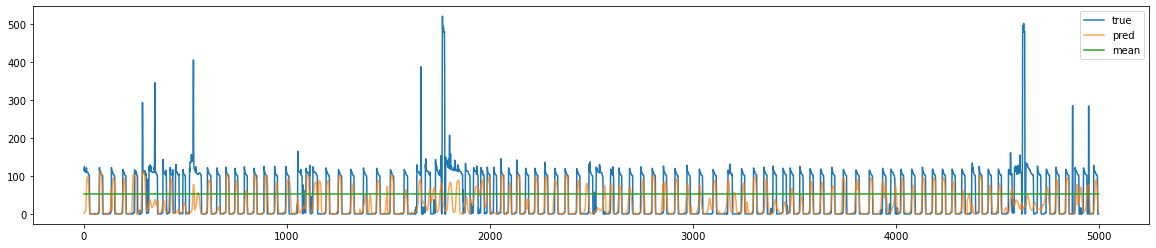

In [32]:
#box-cox normalization
for id in home_ids[0:1]:
    test_loader, y_min, y_max = load_test_data_loader("refrigerator", 142, "dec")
    true, pred = create_true_and_pred_lists(best_models[0], test_loader, y_min, y_max)
    plot_true_and_pred(true, pred, 5000)

In [ ]:
#standard normalization
for id in home_ids[0:1]:
    test_loader, y_min, y_max = load_test_data_loader("refrigerator", 5058, "dec")
    true, pred = create_true_and_pred_lists(model_test, test_loader, y_min, y_max)
    plot_true_and_pred(true, pred, 2000)

In [ ]:
[0.08261062204837799, 0.0006756758968593513, 0.47869045869881166, 0.7716401972127334, 0.6100338455022384, 40.55996281584161, 4326.6523]

In [33]:
calculate_model_metrics(true, pred, y_min, y_max)

{'MSE': 4326.653,
 'R2': 0.0006756475341188617,
 'F1': 0.47869045869881166,
 'NEP': 0.7716403,
 'NDE': 0.6100339,
 'MAE': 40.559966822094694}

In [ ]:
calculate_model_metrics(true, pred, y_min, y_max)

In [ ]:
"attention_boxcox_global_refrigerator_model_test_home_5058_all_homes_trial0.pth"

In [ ]:
test_inputs = []
predictions = []
true_vals = []

In [ ]:
model.cpu()

In [ ]:
test_path = r"C:\Users\aar245\Desktop\privacy_preserving_nn\input\1min_real_dec2019.csv"

In [ ]:
test_dataset = PecanStreetDataset(test_path, 'drye1', 169, [3000])

In [ ]:
test_loader = DataLoader(dataset=test_dataset, batch_size=config_['batch_size'], shuffle = False, num_workers=0)

In [ ]:
for i, (inputs, outputs) in enumerate(test_loader):
    inputs, outputs = inputs.cpu(), outputs.cpu()
    prediction = best_models[0](inputs)
    predictions.append(prediction.detach().numpy())
    true_vals.append(outputs.detach().numpy())
    test_inputs.append(inputs)

In [ ]:
plt.plot(predictions[0][0])

plt.plot(true_vals[0][0])
plt.legend(['prediction', 'true'])
#plt.plot(test_inputs[0][3])

In [ ]:
predictions_list = [i for subitems in predictions for i in subitems]

In [ ]:
predictions_list = [i for subitems in predictions_list for i in subitems]

In [ ]:
true_vals_list = [i for subitems in true_vals for i in subitems]

In [ ]:
true_vals_list = [i for subitems in true_vals_list for i in subitems]

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(true_vals_list)
plt.plot(predictions_list)

plt.legend(['true', 'pred'])

In [ ]:
torch.save(model.state_dict(), PATH)

In [ ]:
model_test = LSTM(
        config_['in_channels'],
        config_['out_channels'],
        config_['kernel_size'],
        config_['hidden_size_1'],
        config_['hidden_size_2'],
        config_['fc1'],
        config_['fc2'],
        config_['kernel_size_2'])

In [ ]:
model_test.load_state_dict(torch.load(r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\models\refrigerator_model_total_houses_53_trial_0.pth"))

In [ ]:
model_test.eval()